In [ ]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v10/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs'

if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
tf.__version__

In [ ]:
BATCH_SIZE = 64
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 100

END_TOKEN = 0

## Load Data

In [ ]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)
# neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [ ]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

## Create multitype SeqGan

In [ ]:

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    i_noise = Input(batch_shape=(batch_size, hidden_dim), name='hidden_noise')

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm, tm = TimeLSTM1(hidden_dim,
                       name='time_lstm',
                       stateful=True, 
                       return_sequences=False,
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
    
    hm_with_noise = tf.concat([hm, i_noise], axis=1)
    tm_with_noise = tf.concat([tm, i_noise], axis=1)
    
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm_with_noise)
        
    time_delta_out = Dense(1,
                   activation='softplus',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(tm_with_noise)
    
    generator = Model(
        inputs=[i_et, i_ts, i_noise],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [9]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm, tm = TimeLSTM1(hidden_dim,
                       name='time_lstm',
                       stateful=True, 
                       return_sequences=False,
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

## test initial G and D

In [10]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

In [11]:
G0

In [12]:
init_token_index = tf.ones([BATCH_SIZE, 1, 1], dtype=tf.int32)
init_token_prefix = tf.squeeze(tf.one_hot(init_token_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
init_time_delta = tf.zeros([BATCH_SIZE, 1, 1], dtype=tf.float64)

noise=tf.random.normal(shape=[BATCH_SIZE, HIDDEN_DIM], mean=0.0, stddev=0.1, dtype=tf.float64)

In [13]:
token_logits, time_delta_out = G0([init_token_prefix, init_time_delta, noise])

In [14]:
D0 = build_D(
    batch_size = BATCH_SIZE,
    T=T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim = HIDDEN_DIM,
    dropout_rate=0.25
)

In [16]:
prob = D0([init_token_prefix, init_time_delta])
# prob

## Define rollout and sequence generation

In [17]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [18]:
def rollout_from_prefix_gumbel(
        G, batch_size, prefix_et, prefix_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = prefix_et
    all_state_ts = prefix_ts
    
    l_prefix = prefix_et.shape[1]
    
    G.reset_states()

    for _ in range(L-l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        step_noise = tf.random.normal(shape=[batch_size, HIDDEN_DIM], mean=0.0, stddev=0.1, dtype=tf.float64)
        
        token_logits, time_delta_out = G([curr_state_et, curr_state_ts, step_noise])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    return all_state_et, all_state_ts


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_index = tf.ones([batch_size, 1, 1], dtype=tf.int32)
    init_token_prefix = tf.squeeze(tf.one_hot(init_token_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_delta = tf.zeros([batch_size, 1, 1], dtype=tf.float64)
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_prefix_gumbel(generator, batch_size, init_token_prefix, init_time_delta, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [19]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]
            
            step_noise = tf.random.normal(shape=[BATCH_SIZE, HIDDEN_DIM], mean=0.0, stddev=0.1, dtype=tf.float64)
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts, step_noise])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [20]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 10
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)

In [21]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [22]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
token ce loss:1.8316437637151632
time mae loss:17.653261915223375
train loss:19.48490567893854


1it [00:01,  1.11s/it]

Training Step: 2


2it [00:01,  1.28it/s]

token ce loss:1.8148353105571204
time mae loss:17.923279821418287
train loss:19.73811513197541
Training Step: 3


3it [00:02,  1.41it/s]

token ce loss:1.8066466351519623
time mae loss:16.825913535906587
train loss:18.63256017105855
Training Step: 4
token ce loss:1.7832676828304588
time mae loss:17.390991844996712
train loss:19.17425952782717


4it [00:02,  1.53it/s]

Training Step: 5


5it [00:03,  1.61it/s]

token ce loss:1.773273216721377
time mae loss:17.778430060367743
train loss:19.55170327708912
Training Step: 6
token ce loss:1.7545671473992823
time mae loss:17.51351886815683
train loss:19.26808601555611


6it [00:03,  1.66it/s]

Training Step: 7


7it [00:04,  1.69it/s]

token ce loss:1.7429509903958642
time mae loss:17.164018475563335
train loss:18.9069694659592
Training Step: 8


8it [00:05,  1.71it/s]

token ce loss:1.7368531070875335
time mae loss:17.125271571906886
train loss:18.86212467899442
Training Step: 9
token ce loss:1.7102028551342392
time mae loss:16.981771587295803
train loss:18.69197444243004


9it [00:05,  1.66it/s]

Training Step: 10


10it [00:06,  1.69it/s]

token ce loss:1.696155910169924
time mae loss:17.344283129755432
train loss:19.040439039925356
Training Step: 11


11it [00:06,  1.72it/s]

token ce loss:1.6825325635191366
time mae loss:17.265031095418685
train loss:18.94756365893782
Training Step: 12
token ce loss:1.6635822686334716
time mae loss:16.455664655372743
train loss:18.119246924006216


12it [00:07,  1.73it/s]

Training Step: 13


13it [00:08,  1.75it/s]

token ce loss:1.6426593914247765
time mae loss:16.900694297664714
train loss:18.54335368908949
Training Step: 14
token ce loss:1.6248489064247398
time mae loss:16.742466886174572
train loss:18.367315792599314


14it [00:08,  1.69it/s]

Training Step: 15
token ce loss:1.5972216173656368
time mae loss:16.858933776903307
train loss:18.456155394268944


15it [00:09,  1.71it/s]

Training Step: 16
token ce loss:1.5757944478010397
time mae loss:16.78616002063388
train loss:18.36195446843492


16it [00:09,  1.73it/s]

Training Step: 17
token ce loss:1.5652931220175978
time mae loss:16.68424338821843
train loss:18.249536510236027


17it [00:10,  1.73it/s]

Training Step: 18


18it [00:10,  1.73it/s]

token ce loss:1.5375377396534007
time mae loss:16.47906089153748
train loss:18.01659863119088
Training Step: 19
token ce loss:1.524026404975869
time mae loss:16.35801549852541
train loss:17.882041903501282


19it [00:11,  1.74it/s]

Training Step: 20


20it [00:12,  1.68it/s]

token ce loss:1.5148003461839996
time mae loss:15.726761371443558
train loss:17.241561717627558
Training Step: 21


21it [00:12,  1.71it/s]

token ce loss:1.4995669954373567
time mae loss:15.98021921933981
train loss:17.479786214777167
Training Step: 22


22it [00:13,  1.72it/s]

token ce loss:1.4940650194829923
time mae loss:16.032588000457846
train loss:17.526653019940838
Training Step: 23
token ce loss:1.4702784080709548
time mae loss:16.029421242530745
train loss:17.4996996506017


23it [00:13,  1.73it/s]

Training Step: 24
token ce loss:1.4636759610626429
time mae loss:15.857175717922024
train loss:17.320851678984667


24it [00:14,  1.73it/s]

Training Step: 25
token ce loss:1.4549865662658021
time mae loss:15.626983970615845
train loss:17.08197053688165


25it [00:15,  1.71it/s]

Training Step: 26
token ce loss:1.4458111848762616
time mae loss:15.465936271332804
train loss:16.911747456209067


26it [00:15,  1.65it/s]

Training Step: 27
token ce loss:1.4460183835049558
time mae loss:15.39016851189866
train loss:16.836186895403614


27it [00:16,  1.68it/s]

Training Step: 28
token ce loss:1.4331549098079188
time mae loss:15.119335065580344
train loss:16.552489975388262


28it [00:16,  1.69it/s]

Training Step: 29
token ce loss:1.451754965017
time mae loss:15.659895476905973
train loss:17.111650441922972


29it [00:17,  1.70it/s]

Training Step: 30
token ce loss:1.4336089896233668
time mae loss:15.23659203638012
train loss:16.670201026003486


30it [00:18,  1.70it/s]

Training Step: 31
token ce loss:1.4312042375585707
time mae loss:15.016076924091692
train loss:16.447281161650263


31it [00:18,  1.63it/s]

Training Step: 32
token ce loss:1.4329034979722675
time mae loss:15.173602172244358
train loss:16.606505670216627


32it [00:19,  1.64it/s]

Training Step: 33


33it [00:19,  1.67it/s]

token ce loss:1.4260656601890145
time mae loss:14.835068638978987
train loss:16.261134299168003
Training Step: 34
token ce loss:1.4194866018504548
time mae loss:14.838152158616666
train loss:16.25763876046712


34it [00:20,  1.69it/s]

Training Step: 35
token ce loss:1.421002749343917
time mae loss:14.954950190373072
train loss:16.37595293971699


35it [00:21,  1.69it/s]

Training Step: 36
token ce loss:1.4171243320538391
time mae loss:14.86756335872202
train loss:16.284687690775858


36it [00:21,  1.69it/s]

Training Step: 37
token ce loss:1.4175726836724043
time mae loss:14.824394886545054
train loss:16.241967570217458


37it [00:22,  1.63it/s]

Training Step: 38


38it [00:22,  1.66it/s]

token ce loss:1.4062689111808626
time mae loss:14.865998491792585
train loss:16.272267402973448
Training Step: 39
token ce loss:1.4171127297544996
time mae loss:14.91116552665714
train loss:16.32827825641164


39it [00:23,  1.67it/s]

Training Step: 40
token ce loss:1.401955649772068
time mae loss:14.405926516712096
train loss:15.807882166484164


40it [00:24,  1.68it/s]

Training Step: 41
token ce loss:1.4084399398082776
time mae loss:14.157144443134602
train loss:15.565584382942879


41it [00:24,  1.68it/s]

Training Step: 42
token ce loss:1.4050685211923342
time mae loss:14.196701275091971
train loss:15.601769796284305


42it [00:25,  1.63it/s]

Training Step: 43
token ce loss:1.4035477680891748
time mae loss:14.115814628695242
train loss:15.519362396784416


43it [00:25,  1.65it/s]

Training Step: 44
token ce loss:1.3999437193547897
time mae loss:13.987329220357207
train loss:15.387272939711997


44it [00:26,  1.67it/s]

Training Step: 45
token ce loss:1.391551431584279
time mae loss:13.878342631488385
train loss:15.269894063072664


45it [00:27,  1.67it/s]

Training Step: 46
token ce loss:1.3948578287069233
time mae loss:13.5203565357486
train loss:14.915214364455524


46it [00:27,  1.68it/s]

Training Step: 47
token ce loss:1.401014777937219
time mae loss:13.90386789159312
train loss:15.304882669530338


47it [00:28,  1.69it/s]

Training Step: 48
token ce loss:1.3906790540410738
time mae loss:13.57552224182545
train loss:14.966201295866524


48it [00:28,  1.63it/s]

Training Step: 49
token ce loss:1.4020649037493136
time mae loss:13.79172438550469
train loss:15.193789289254003


49it [00:29,  1.66it/s]

Training Step: 50


50it [00:30,  1.67it/s]

token ce loss:1.3942949592478748
time mae loss:13.533266776998147
train loss:14.927561736246021
Training Step: 51
token ce loss:1.3949416561519437
time mae loss:13.171584702753364
train loss:14.566526358905307


51it [00:30,  1.67it/s]

Training Step: 52


52it [00:31,  1.69it/s]

token ce loss:1.3928017461931224
time mae loss:12.911975087126445
train loss:14.304776833319567
Training Step: 53
token ce loss:1.3880907658769672
time mae loss:12.357759540677092
train loss:13.74585030655406


53it [00:31,  1.64it/s]

Training Step: 54


54it [00:32,  1.67it/s]

token ce loss:1.3917051108414198
time mae loss:13.37470976968315
train loss:14.76641488052457
Training Step: 55


55it [00:33,  1.70it/s]

token ce loss:1.3841924641967076
time mae loss:12.998689199497989
train loss:14.382881663694697
Training Step: 56


56it [00:33,  1.71it/s]

token ce loss:1.3807875051545309
time mae loss:12.560296929337834
train loss:13.941084434492366
Training Step: 57


57it [00:34,  1.72it/s]

token ce loss:1.3898144552065868
time mae loss:12.619036265461443
train loss:14.008850720668029
Training Step: 58
token ce loss:1.3924105759777583
time mae loss:12.511705383483534
train loss:13.904115959461292


58it [00:34,  1.72it/s]

Training Step: 59
token ce loss:1.3825700509579626
time mae loss:12.609717425372036
train loss:13.992287476329999


59it [00:35,  1.66it/s]

Training Step: 60
token ce loss:1.383393079126045
time mae loss:12.444998156507234
train loss:13.828391235633278


60it [00:35,  1.68it/s]

Training Step: 61


61it [00:36,  1.70it/s]

token ce loss:1.3837894858877302
time mae loss:12.441215383809453
train loss:13.825004869697183
Training Step: 62


62it [00:37,  1.71it/s]

token ce loss:1.391941168051972
time mae loss:12.475041665040127
train loss:13.866982833092099
Training Step: 63


63it [00:37,  1.71it/s]

token ce loss:1.3810998062032693
time mae loss:12.042238977592408
train loss:13.423338783795678
Training Step: 64
token ce loss:1.3743287697113769
time mae loss:12.173799072042987
train loss:13.548127841754365


64it [00:38,  1.72it/s]

Training Step: 65
token ce loss:1.3822474204183517
time mae loss:12.411044907783102
train loss:13.793292328201455


65it [00:38,  1.65it/s]

Training Step: 66
token ce loss:1.3789800014571876
time mae loss:12.418531202341812
train loss:13.797511203799


66it [00:39,  1.66it/s]

Training Step: 67


67it [00:40,  1.68it/s]

token ce loss:1.3807949696290014
time mae loss:12.345371409202121
train loss:13.726166378831122
Training Step: 68
token ce loss:1.3740196000097469
time mae loss:12.656828932609754
train loss:14.030848532619501


68it [00:40,  1.70it/s]

Training Step: 69


69it [00:41,  1.71it/s]

token ce loss:1.3722011734985506
time mae loss:11.872846546714285
train loss:13.245047720212836
Training Step: 70
token ce loss:1.3751994660438696
time mae loss:11.765920767495077
train loss:13.141120233538945


70it [00:41,  1.72it/s]

Training Step: 71
token ce loss:1.3839106469349782
time mae loss:11.821644511226726
train loss:13.205555158161705


71it [00:42,  1.66it/s]

Training Step: 72


72it [00:43,  1.69it/s]

token ce loss:1.3841343875227998
time mae loss:12.218665163882903
train loss:13.602799551405703
Training Step: 73
token ce loss:1.372362868990138
time mae loss:11.462769771847146
train loss:12.835132640837283


73it [00:43,  1.70it/s]

Training Step: 74
token ce loss:1.3707022961181055
time mae loss:11.293131913087873
train loss:12.663834209205978


74it [00:44,  1.72it/s]

Training Step: 75


75it [00:44,  1.72it/s]

token ce loss:1.3789562582421808
time mae loss:11.614604904131085
train loss:12.993561162373265
Training Step: 76


76it [00:45,  1.67it/s]

token ce loss:1.3811519786222544
time mae loss:11.20773354043482
train loss:12.588885519057074
Training Step: 77
token ce loss:1.3804701607789533
time mae loss:11.399161365319747
train loss:12.7796315260987


77it [00:46,  1.68it/s]

Training Step: 78
token ce loss:1.3664144683993515
time mae loss:10.997398881749172
train loss:12.363813350148524


78it [00:46,  1.71it/s]

Training Step: 79
token ce loss:1.369942601058033
time mae loss:11.15242951196505
train loss:12.522372113023083


79it [00:47,  1.71it/s]

Training Step: 80


80it [00:47,  1.72it/s]

token ce loss:1.366171268595077
time mae loss:11.209655285124228
train loss:12.575826553719304
Training Step: 81
token ce loss:1.3700549230305392
time mae loss:10.760120671646584
train loss:12.130175594677123


81it [00:48,  1.72it/s]

Training Step: 82
token ce loss:1.3685616579175186
time mae loss:10.40908811363542
train loss:11.77764977155294


82it [00:48,  1.65it/s]

Training Step: 83
token ce loss:1.375312403060093
time mae loss:10.775212324961705
train loss:12.150524728021798


83it [00:49,  1.67it/s]

Training Step: 84


84it [00:50,  1.69it/s]

token ce loss:1.3737684361530609
time mae loss:10.881139225537138
train loss:12.254907661690199
Training Step: 85
token ce loss:1.3703444677669965
time mae loss:10.430955319913569
train loss:11.801299787680565


85it [00:50,  1.70it/s]

Training Step: 86


86it [00:51,  1.71it/s]

token ce loss:1.3730972512043245
time mae loss:10.798805388337192
train loss:12.171902639541516
Training Step: 87
token ce loss:1.370143689478947
time mae loss:10.380766791664783
train loss:11.75091048114373


87it [00:51,  1.65it/s]

Training Step: 88
token ce loss:1.368694944703352
time mae loss:10.342987622132558
train loss:11.71168256683591


88it [00:52,  1.66it/s]

Training Step: 89
token ce loss:1.366240710819191
time mae loss:10.482693746307582
train loss:11.848934457126774


89it [00:53,  1.64it/s]

Training Step: 90
token ce loss:1.363644570683433
time mae loss:10.5043137821349
train loss:11.867958352818334


90it [00:53,  1.67it/s]

Training Step: 91
token ce loss:1.3715032203649067
time mae loss:10.688356420577966
train loss:12.059859640942873


91it [00:54,  1.67it/s]

Training Step: 92
token ce loss:1.370542640352218
time mae loss:10.457945407730438
train loss:11.828488048082656


92it [00:55,  1.59it/s]

Training Step: 93
token ce loss:1.3706914591786095
time mae loss:10.60500962966967
train loss:11.975701088848279


93it [00:55,  1.51it/s]

Training Step: 94
token ce loss:1.3689080942521001
time mae loss:10.054720024866427
train loss:11.423628119118527


94it [00:56,  1.48it/s]

Training Step: 95
token ce loss:1.3643406815942485
time mae loss:9.927207016583505
train loss:11.291547698177753


95it [00:57,  1.48it/s]

Training Step: 96
token ce loss:1.3698759464017427
time mae loss:10.006866680466054
train loss:11.376742626867797


96it [00:57,  1.55it/s]

Training Step: 97
token ce loss:1.3615481138753471
time mae loss:9.820163537168346
train loss:11.181711651043694


97it [00:58,  1.60it/s]

Training Step: 98


98it [00:58,  1.63it/s]

token ce loss:1.3541964940470137
time mae loss:9.243159937849095
train loss:10.597356431896108
Training Step: 99
token ce loss:1.3634550246322286
time mae loss:9.9976936373897
train loss:11.361148662021929


99it [00:59,  1.57it/s]

Training Step: 100
token ce loss:1.3668398425432258
time mae loss:9.772569224871713
train loss:11.139409067414938


100it [01:00,  1.61it/s]

Training Step: 101
token ce loss:1.3562400351478012
time mae loss:9.652911555647641
train loss:11.009151590795442


101it [01:00,  1.63it/s]

Training Step: 102


102it [01:01,  1.66it/s]

token ce loss:1.3545180124171587
time mae loss:9.996521241873406
train loss:11.351039254290566
Training Step: 103
token ce loss:1.3605695555976123
time mae loss:9.463801966602002
train loss:10.824371522199614


103it [01:01,  1.65it/s]

Training Step: 104


104it [01:02,  1.67it/s]

token ce loss:1.366967743491669
time mae loss:9.685131889839761
train loss:11.05209963333143
Training Step: 105
token ce loss:1.356708108433599
time mae loss:9.331452229999346
train loss:10.688160338432946


105it [01:03,  1.62it/s]

Training Step: 106
token ce loss:1.361819157854007
time mae loss:9.486614974864324
train loss:10.848434132718332


106it [01:03,  1.61it/s]

Training Step: 107
token ce loss:1.3594140450416126
time mae loss:9.555089751897734
train loss:10.914503796939346


107it [01:04,  1.63it/s]

Training Step: 108


108it [01:05,  1.65it/s]

token ce loss:1.3556096500927386
time mae loss:9.107863157853439
train loss:10.463472807946177
Training Step: 109
token ce loss:1.359833158349221
time mae loss:8.948767497407385
train loss:10.308600655756607


109it [01:05,  1.68it/s]

Training Step: 110
token ce loss:1.3533131850786222
time mae loss:8.95084570977313
train loss:10.304158894851753


110it [01:06,  1.64it/s]

Training Step: 111
token ce loss:1.35571017520237
time mae loss:8.982643378196206
train loss:10.338353553398576


111it [01:06,  1.67it/s]

Training Step: 112


112it [01:07,  1.69it/s]

token ce loss:1.3745694193584137
time mae loss:9.381141630172628
train loss:10.755711049531042
Training Step: 113
token ce loss:1.3568119019373972
time mae loss:8.908251686019232
train loss:10.265063587956629


113it [01:07,  1.69it/s]

Training Step: 114
token ce loss:1.35870408266471
time mae loss:9.161028777968165
train loss:10.519732860632875


114it [01:08,  1.71it/s]

Training Step: 115


115it [01:09,  1.72it/s]

token ce loss:1.3612665633210357
time mae loss:8.740476108222603
train loss:10.10174267154364
Training Step: 116
token ce loss:1.3583411187990415
time mae loss:8.688696321442288
train loss:10.04703744024133


116it [01:09,  1.67it/s]

Training Step: 117
token ce loss:1.356825267864743
time mae loss:9.191071769598077
train loss:10.54789703746282


117it [01:10,  1.68it/s]

Training Step: 118
token ce loss:1.348632587128447
time mae loss:9.068980463100434
train loss:10.417613050228882


118it [01:10,  1.70it/s]

Training Step: 119
token ce loss:1.3541225841806621
time mae loss:8.681569754601128
train loss:10.03569233878179


119it [01:11,  1.70it/s]

Training Step: 120
token ce loss:1.358378001870861
time mae loss:9.000642379133009
train loss:10.35902038100387


120it [01:12,  1.69it/s]

Training Step: 121
token ce loss:1.3524486930677804
time mae loss:8.57822803582144
train loss:9.93067672888922


121it [01:12,  1.64it/s]

Training Step: 122
token ce loss:1.3581179872697335
time mae loss:9.140518679724313
train loss:10.498636666994045


122it [01:13,  1.66it/s]

Training Step: 123


123it [01:13,  1.68it/s]

token ce loss:1.344986768181538
time mae loss:8.875567862423
train loss:10.22055463060454
Training Step: 124
token ce loss:1.3650198239491793
time mae loss:8.687671509727533
train loss:10.052691333676712


124it [01:14,  1.69it/s]

Training Step: 125
token ce loss:1.3498914997137468
time mae loss:8.463981053988608
train loss:9.813872553702355


125it [01:15,  1.69it/s]

Training Step: 126
token ce loss:1.3633455653413578
time mae loss:8.828647941611546
train loss:10.191993506952905


126it [01:15,  1.69it/s]

Training Step: 127
token ce loss:1.361530818132677
time mae loss:8.816617347895527
train loss:10.178148166028203


127it [01:16,  1.64it/s]

Training Step: 128
token ce loss:1.3622020126687875
time mae loss:8.748908855601906
train loss:10.111110868270693


128it [01:16,  1.68it/s]

Training Step: 129


129it [01:17,  1.68it/s]

token ce loss:1.3610940139606122
time mae loss:8.864647885452296
train loss:10.225741899412908
Training Step: 130
token ce loss:1.3536780837336218
time mae loss:8.634812170482606
train loss:9.988490254216227


130it [01:18,  1.69it/s]

Training Step: 131


131it [01:18,  1.70it/s]

token ce loss:1.354804202048013
time mae loss:8.298928135986568
train loss:9.653732338034581
Training Step: 132


132it [01:19,  1.71it/s]

token ce loss:1.353850377127824
time mae loss:8.64932943678202
train loss:10.003179813909844
Training Step: 133
token ce loss:1.3513173764383122
time mae loss:8.779843008821757
train loss:10.131160385260069


133it [01:19,  1.66it/s]

Training Step: 134


134it [01:20,  1.68it/s]

token ce loss:1.3460911965382878
time mae loss:8.705957178906349
train loss:10.052048375444636
Training Step: 135
token ce loss:1.3575436741123084
time mae loss:8.674850287656087
train loss:10.032393961768395


135it [01:21,  1.69it/s]

Training Step: 136
token ce loss:1.36283164255046
time mae loss:8.399430847147428
train loss:9.76226248969789


136it [01:21,  1.69it/s]

Training Step: 137
token ce loss:1.358363547514887
time mae loss:8.673299142828142
train loss:10.03166269034303


137it [01:22,  1.69it/s]

Training Step: 138
token ce loss:1.3498035250555005
time mae loss:8.39637750564275
train loss:9.746181030698251


138it [01:22,  1.69it/s]

Training Step: 139
token ce loss:1.3534740864848553
time mae loss:8.639965314579086
train loss:9.993439401063942


139it [01:23,  1.64it/s]

Training Step: 140
token ce loss:1.362056943979864
time mae loss:8.581326615923782
train loss:9.943383559903646


140it [01:24,  1.64it/s]

Training Step: 141
token ce loss:1.362824404558409
time mae loss:8.898445613296285
train loss:10.261270017854695


141it [01:24,  1.65it/s]

Training Step: 142


142it [01:25,  1.67it/s]

token ce loss:1.34944723586919
time mae loss:8.163117631555039
train loss:9.51256486742423
Training Step: 143
token ce loss:1.3629219047273229
time mae loss:8.116280976645822
train loss:9.479202881373144


143it [01:25,  1.68it/s]

Training Step: 144
token ce loss:1.3541936991241212
time mae loss:8.698805818700164
train loss:10.052999517824285


144it [01:26,  1.62it/s]

Training Step: 145
token ce loss:1.3554814817033343
time mae loss:7.950796793081655
train loss:9.30627827478499


145it [01:27,  1.65it/s]

Training Step: 146


146it [01:27,  1.67it/s]

token ce loss:1.3500036405350915
time mae loss:8.391103961259388
train loss:9.741107601794479
Training Step: 147
token ce loss:1.35154905893603
time mae loss:8.325885294652297
train loss:9.677434353588326


147it [01:28,  1.69it/s]

Training Step: 148


148it [01:28,  1.71it/s]

token ce loss:1.3521612280053392
time mae loss:8.257400519612736
train loss:9.609561747618075
Training Step: 149
token ce loss:1.351406074159804
time mae loss:8.638376099487047
train loss:9.989782173646852


149it [01:29,  1.71it/s]

Training Step: 150
token ce loss:1.3524551467568915
time mae loss:8.335530645682805
train loss:9.687985792439697


150it [01:30,  1.65it/s]

Training Step: 151


151it [01:30,  1.67it/s]

token ce loss:1.3584804623389766
time mae loss:8.357458030429132
train loss:9.715938492768109
Training Step: 152
token ce loss:1.355281524726199
time mae loss:8.327503498257672
train loss:9.68278502298387


152it [01:31,  1.69it/s]

Training Step: 153
token ce loss:1.3407372592238522
time mae loss:8.463263052676501
train loss:9.804000311900353


153it [01:31,  1.71it/s]

Training Step: 154


154it [01:32,  1.72it/s]

token ce loss:1.3538170653129549
time mae loss:8.079500090497826
train loss:9.43331715581078
Training Step: 155


155it [01:33,  1.66it/s]

token ce loss:1.3524743897234797
time mae loss:8.367637961273307
train loss:9.720112350996786
Training Step: 156


156it [01:33,  1.68it/s]

token ce loss:1.3576406405530634
time mae loss:8.516903824726782
train loss:9.874544465279845
Training Step: 157
token ce loss:1.3541631341143296
time mae loss:8.210740494678337
train loss:9.564903628792667


157it [01:34,  1.71it/s]

Training Step: 158
token ce loss:1.3463591115259081
time mae loss:8.420175730616318
train loss:9.766534842142226


158it [01:34,  1.69it/s]

Training Step: 159
token ce loss:1.3509104758458705
time mae loss:8.755730635064499
train loss:10.106641110910369


159it [01:35,  1.70it/s]

Training Step: 160


160it [01:35,  1.71it/s]

token ce loss:1.3538619069667182
time mae loss:8.437851964628607
train loss:9.791713871595325
Training Step: 161
token ce loss:1.3446371623140885
time mae loss:8.485059955629922
train loss:9.82969711794401


161it [01:36,  1.66it/s]

Training Step: 162
token ce loss:1.3428422376561362
time mae loss:8.189286897500251
train loss:9.532129135156387


162it [01:37,  1.68it/s]

Training Step: 163
token ce loss:1.367472812521756
time mae loss:8.296147639867538
train loss:9.663620452389294


163it [01:37,  1.68it/s]

Training Step: 164
token ce loss:1.3483636221107447
time mae loss:8.314115580716035
train loss:9.662479202826779


164it [01:38,  1.70it/s]

Training Step: 165
token ce loss:1.3415471301731867
time mae loss:8.36814414429273
train loss:9.709691274465916


165it [01:38,  1.71it/s]

Training Step: 166
token ce loss:1.3590206717175797
time mae loss:8.257277393810345
train loss:9.616298065527925


166it [01:39,  1.71it/s]

Training Step: 167
token ce loss:1.3491119866503685
time mae loss:8.143314474585985
train loss:9.492426461236354


167it [01:40,  1.65it/s]

Training Step: 168


168it [01:40,  1.68it/s]

token ce loss:1.3603532693075855
time mae loss:8.49054147265556
train loss:9.850894741963145
Training Step: 169


169it [01:41,  1.70it/s]

token ce loss:1.3388657655960894
time mae loss:8.236150875373934
train loss:9.575016640970023
Training Step: 170


170it [01:41,  1.71it/s]

token ce loss:1.3364137316689084
time mae loss:8.02215923206279
train loss:9.3585729637317
Training Step: 171
token ce loss:1.346802954288465
time mae loss:8.019641474125853
train loss:9.366444428414319


171it [01:42,  1.72it/s]

Training Step: 172
token ce loss:1.352577933786918
time mae loss:8.292206653425826
train loss:9.644784587212744


172it [01:42,  1.73it/s]

Training Step: 173


173it [01:43,  1.67it/s]

token ce loss:1.3523605946831512
time mae loss:8.190222600875254
train loss:9.542583195558406
Training Step: 174
token ce loss:1.35959353987589
time mae loss:8.424214415413298
train loss:9.783807955289188


174it [01:44,  1.68it/s]

Training Step: 175


175it [01:44,  1.69it/s]

token ce loss:1.3484110478363531
time mae loss:7.988405315265548
train loss:9.336816363101901
Training Step: 176
token ce loss:1.3429128267325874
time mae loss:8.538880077502295
train loss:9.881792904234882


176it [01:45,  1.71it/s]

Training Step: 177


177it [01:45,  1.72it/s]

token ce loss:1.3516653099519076
time mae loss:8.343498143884714
train loss:9.695163453836622
Training Step: 178


178it [01:46,  1.66it/s]

token ce loss:1.345634864401382
time mae loss:8.164805589238293
train loss:9.510440453639674
Training Step: 179


179it [01:47,  1.69it/s]

token ce loss:1.354435493207023
time mae loss:8.534417577493286
train loss:9.888853070700309
Training Step: 180


180it [01:47,  1.71it/s]

token ce loss:1.358435310875333
time mae loss:8.444261053553111
train loss:9.802696364428444
Training Step: 181
token ce loss:1.3440337899485146
time mae loss:8.312241170527923
train loss:9.656274960476438


181it [01:48,  1.71it/s]

Training Step: 182
token ce loss:1.3442848955490612
time mae loss:8.226578658215326
train loss:9.570863553764386


182it [01:48,  1.70it/s]

Training Step: 183


183it [01:49,  1.71it/s]

token ce loss:1.352761815124349
time mae loss:8.301548181144208
train loss:9.654309996268557
Training Step: 184
token ce loss:1.354741752869033
time mae loss:8.625351344851792
train loss:9.980093097720825


184it [01:50,  1.64it/s]

Training Step: 185
token ce loss:1.35795972151276
time mae loss:8.248437266560646
train loss:9.606396988073406


185it [01:50,  1.67it/s]

Training Step: 186


186it [01:51,  1.68it/s]

token ce loss:1.345455925000699
time mae loss:8.088324123458504
train loss:9.433780048459203
Training Step: 187
token ce loss:1.3453748554949283
time mae loss:8.306892116541512
train loss:9.65226697203644


187it [01:51,  1.69it/s]

Training Step: 188


188it [01:52,  1.70it/s]

token ce loss:1.3504420908156936
time mae loss:8.195865542394511
train loss:9.546307633210205
Training Step: 189
token ce loss:1.3530169396191685
time mae loss:8.357514290464092
train loss:9.71053123008326


189it [01:53,  1.62it/s]

Training Step: 190
token ce loss:1.347270907014568
time mae loss:8.265678503409221
train loss:9.61294941042379


190it [01:53,  1.54it/s]

Training Step: 191
token ce loss:1.3480841283353262
time mae loss:8.221623697587763
train loss:9.56970782592309


191it [01:54,  1.53it/s]

Training Step: 192
token ce loss:1.344985093587066
time mae loss:8.295875925677672
train loss:9.640861019264738


192it [01:55,  1.52it/s]

Training Step: 193
token ce loss:1.3589135661547649
time mae loss:8.345320131515743
train loss:9.704233697670508


193it [01:55,  1.51it/s]

Training Step: 194
token ce loss:1.3534645335404394
time mae loss:8.342234903399092
train loss:9.695699436939531


194it [01:56,  1.52it/s]

Training Step: 195
token ce loss:1.3530132232858596
time mae loss:8.214772185931015
train loss:9.567785409216874


195it [01:57,  1.47it/s]

Training Step: 196


196it [01:57,  1.52it/s]

token ce loss:1.3484888752912827
time mae loss:8.270817063768991
train loss:9.619305939060274
Training Step: 197
token ce loss:1.3485517174550377
time mae loss:8.248740131767295
train loss:9.597291849222334


197it [01:58,  1.57it/s]

Training Step: 198
token ce loss:1.359411633038376
time mae loss:8.415479231304422
train loss:9.774890864342797


198it [01:59,  1.60it/s]

Training Step: 199
token ce loss:1.3601626078703837
time mae loss:8.206435207262961
train loss:9.566597815133346


199it [01:59,  1.63it/s]

Training Step: 200
token ce loss:1.3429723958557758
time mae loss:8.259962671146905
train loss:9.602935067002681


200it [02:00,  1.65it/s]

Training Step: 201
token ce loss:1.3469857138194867
time mae loss:8.199119561987732
train loss:9.54610527580722


201it [02:00,  1.61it/s]

Training Step: 202


202it [02:01,  1.64it/s]

token ce loss:1.3556981499239749
time mae loss:8.273435163853042
train loss:9.629133313777018
Training Step: 203
token ce loss:1.3481246148877424
time mae loss:8.202609489898531
train loss:9.550734104786274


203it [02:02,  1.66it/s]

Training Step: 204
token ce loss:1.3511548260105575
time mae loss:8.636435706844688
train loss:9.987590532855245


204it [02:02,  1.69it/s]

Training Step: 205
token ce loss:1.3423510002674497
time mae loss:8.197920142826991
train loss:9.54027114309444


205it [02:03,  1.70it/s]

Training Step: 206
token ce loss:1.3574915097478262
time mae loss:8.413974677767946
train loss:9.771466187515772


206it [02:03,  1.71it/s]

Training Step: 207


207it [02:04,  1.66it/s]

token ce loss:1.3558548415320872
time mae loss:8.437598270453858
train loss:9.793453111985945
Training Step: 208
token ce loss:1.33734418804922
time mae loss:8.173233157931168
train loss:9.510577345980389


208it [02:04,  1.68it/s]

Training Step: 209


209it [02:05,  1.70it/s]

token ce loss:1.3476747837499001
time mae loss:8.324431188495273
train loss:9.672105972245173
Training Step: 210
token ce loss:1.3462930236521153
time mae loss:8.294431506950758
train loss:9.640724530602874


210it [02:06,  1.70it/s]

Training Step: 211


211it [02:06,  1.70it/s]

token ce loss:1.3462577863502925
time mae loss:8.243213085284921
train loss:9.589470871635214
Training Step: 212
token ce loss:1.3513015370069446
time mae loss:8.464366536584539
train loss:9.815668073591484


212it [02:07,  1.65it/s]

Training Step: 213
token ce loss:1.3467793561991463
time mae loss:8.149108864615377
train loss:9.495888220814523


213it [02:07,  1.66it/s]

Training Step: 214
token ce loss:1.3500468796664025
time mae loss:8.20336077798447
train loss:9.553407657650872


214it [02:08,  1.67it/s]

Training Step: 215
token ce loss:1.3534755066015092
time mae loss:8.591707634700887
train loss:9.945183141302396


215it [02:09,  1.67it/s]

Training Step: 216
token ce loss:1.3492024478198996
time mae loss:8.265529496444412
train loss:9.614731944264312


216it [02:09,  1.69it/s]

Training Step: 217
token ce loss:1.3410271949387769
time mae loss:8.285930059015508
train loss:9.626957253954284


217it [02:10,  1.70it/s]

Training Step: 218


218it [02:10,  1.64it/s]

token ce loss:1.354003180023939
time mae loss:8.18490286333184
train loss:9.53890604335578
Training Step: 219
token ce loss:1.3444883102721294
time mae loss:8.297895157151688
train loss:9.642383467423818


219it [02:11,  1.65it/s]

Training Step: 220


220it [02:12,  1.68it/s]

token ce loss:1.3430900879734
time mae loss:8.005088409070213
train loss:9.348178497043612
Training Step: 221
token ce loss:1.3414758349688614
time mae loss:8.043064349974149
train loss:9.38454018494301


221it [02:12,  1.69it/s]

Training Step: 222


222it [02:13,  1.70it/s]

token ce loss:1.3452744645369599
time mae loss:8.288398656752864
train loss:9.633673121289824
Training Step: 223
token ce loss:1.3540062478226178
time mae loss:8.319477503096454
train loss:9.673483750919072


223it [02:13,  1.64it/s]

Training Step: 224


224it [02:14,  1.67it/s]

token ce loss:1.3535624154450452
time mae loss:7.903541026466556
train loss:9.257103441911601
Training Step: 225
token ce loss:1.3481334645318555
time mae loss:8.09203005532097
train loss:9.440163519852826


225it [02:15,  1.68it/s]

Training Step: 226


226it [02:15,  1.71it/s]

token ce loss:1.3447991974556281
time mae loss:8.418170132338064
train loss:9.762969329793693
Training Step: 227


227it [02:16,  1.72it/s]

token ce loss:1.3512978239295554
time mae loss:8.331584995054465
train loss:9.68288281898402
Training Step: 228
token ce loss:1.3472018092713516
time mae loss:8.36332246816671
train loss:9.710524277438063


228it [02:16,  1.71it/s]

Training Step: 229
token ce loss:1.3542354666520093
time mae loss:8.387124969850696
train loss:9.741360436502704


229it [02:17,  1.65it/s]

Training Step: 230


230it [02:18,  1.68it/s]

token ce loss:1.3553736057777876
time mae loss:8.32956722140236
train loss:9.684940827180148
Training Step: 231
token ce loss:1.3624930940212279
time mae loss:8.424838834924177
train loss:9.787331928945406


231it [02:18,  1.71it/s]

Training Step: 232
token ce loss:1.3509091931405162
time mae loss:8.066822648448188
train loss:9.417731841588704


232it [02:19,  1.72it/s]

Training Step: 233
token ce loss:1.3413388831763435
time mae loss:8.007461257172983
train loss:9.348800140349326


233it [02:19,  1.74it/s]

Training Step: 234


234it [02:20,  1.74it/s]

token ce loss:1.3401895898647969
time mae loss:8.336946451806153
train loss:9.67713604167095
Training Step: 235


235it [02:20,  1.70it/s]

token ce loss:1.3454202221562084
time mae loss:8.161401284713246
train loss:9.506821506869455
Training Step: 236


236it [02:21,  1.71it/s]

token ce loss:1.3475518116409306
time mae loss:8.279275597656973
train loss:9.626827409297903
Training Step: 237


237it [02:22,  1.73it/s]

token ce loss:1.3596119786737926
time mae loss:8.795458742279802
train loss:10.155070720953594
Training Step: 238
token ce loss:1.3491659279446424
time mae loss:8.403226999724058
train loss:9.752392927668701


238it [02:22,  1.74it/s]

Training Step: 239


239it [02:23,  1.75it/s]

token ce loss:1.3440264394062686
time mae loss:8.294883190708024
train loss:9.638909630114293
Training Step: 240


240it [02:23,  1.76it/s]

token ce loss:1.3442961480186413
time mae loss:8.234815773352343
train loss:9.579111921370984
Training Step: 241


241it [02:24,  1.70it/s]

token ce loss:1.3477364746745502
time mae loss:8.149088507699858
train loss:9.496824982374408
Training Step: 242
token ce loss:1.3492118345158908
time mae loss:8.220351259920658
train loss:9.56956309443655


242it [02:25,  1.72it/s]

Training Step: 243
token ce loss:1.3536726655587994
time mae loss:7.953480754940289
train loss:9.307153420499088


243it [02:25,  1.72it/s]

Training Step: 244
token ce loss:1.3503126800691416
time mae loss:8.415788876681466
train loss:9.766101556750607


244it [02:26,  1.72it/s]

Training Step: 245
token ce loss:1.352564708520581
time mae loss:8.380944249377544
train loss:9.733508957898124


245it [02:26,  1.72it/s]

Training Step: 246
token ce loss:1.3500501523922128
time mae loss:8.560262827055357
train loss:9.91031297944757


246it [02:27,  1.66it/s]

Training Step: 247


247it [02:27,  1.68it/s]

token ce loss:1.33590128291845
time mae loss:8.19778471081792
train loss:9.53368599373637
Training Step: 248
token ce loss:1.3453711772045656
time mae loss:8.230357350312556
train loss:9.575728527517121


248it [02:28,  1.68it/s]

Training Step: 249
token ce loss:1.3527212870423324
time mae loss:8.065021628837258
train loss:9.41774291587959


249it [02:29,  1.70it/s]

Training Step: 250
token ce loss:1.3519904907985114
time mae loss:8.10802064824747
train loss:9.460011139045982


250it [02:29,  1.72it/s]

Training Step: 251
token ce loss:1.3572742642778937
time mae loss:8.537652072620773
train loss:9.894926336898667


251it [02:30,  1.67it/s]

Training Step: 252
token ce loss:1.3455837273470375
time mae loss:8.17581946171628
train loss:9.521403189063317


252it [02:31,  1.53it/s]

Training Step: 253
token ce loss:1.3511716794436754
time mae loss:8.51517028597263
train loss:9.866341965416305


253it [02:31,  1.45it/s]

Training Step: 254
token ce loss:1.3560309578827805
time mae loss:8.327089456760268
train loss:9.683120414643048


254it [02:32,  1.46it/s]

Training Step: 255
token ce loss:1.3478518075197614
time mae loss:8.280806271527489
train loss:9.62865807904725


255it [02:33,  1.49it/s]

Training Step: 256
token ce loss:1.3437276968086365
time mae loss:8.166964382135674
train loss:9.510692078944311


256it [02:33,  1.51it/s]

Training Step: 257
token ce loss:1.3492663439293051
time mae loss:7.9170442808450305
train loss:9.266310624774336


257it [02:34,  1.49it/s]

Training Step: 258
token ce loss:1.3438702769918038
time mae loss:8.538023984892602
train loss:9.881894261884407


258it [02:35,  1.50it/s]

Training Step: 259
token ce loss:1.3477874800560632
time mae loss:8.230932458456937
train loss:9.578719938513


259it [02:35,  1.53it/s]

Training Step: 260
token ce loss:1.3467991542933404
time mae loss:8.040635423725956
train loss:9.387434578019295


260it [02:36,  1.53it/s]

Training Step: 261
token ce loss:1.3540020940384399
time mae loss:8.232538862367305
train loss:9.586540956405745


261it [02:37,  1.52it/s]

Training Step: 262
token ce loss:1.351852699790845
time mae loss:8.42921137783369
train loss:9.781064077624535


262it [02:37,  1.58it/s]

Training Step: 263


263it [02:38,  1.56it/s]

token ce loss:1.3602678682056732
time mae loss:8.230496917038382
train loss:9.590764785244055
Training Step: 264
token ce loss:1.3490376107326651
time mae loss:8.058861884159844
train loss:9.40789949489251


264it [02:38,  1.60it/s]

Training Step: 265
token ce loss:1.34647254286714
time mae loss:8.096344478026941
train loss:9.442817020894081


265it [02:39,  1.64it/s]

Training Step: 266


266it [02:40,  1.67it/s]

token ce loss:1.3501997812376416
time mae loss:8.14345218452315
train loss:9.493651965760792
Training Step: 267


267it [02:40,  1.69it/s]

token ce loss:1.343845883617269
time mae loss:8.2845348417224
train loss:9.628380725339667
Training Step: 268


268it [02:41,  1.70it/s]

token ce loss:1.354024182351867
time mae loss:8.349365707958759
train loss:9.703389890310627
Training Step: 269
token ce loss:1.349833888689454
time mae loss:8.319596056707724
train loss:9.669429945397178


269it [02:41,  1.64it/s]

Training Step: 270
token ce loss:1.3478454681755572
time mae loss:8.360424130737874
train loss:9.70826959891343


270it [02:42,  1.66it/s]

Training Step: 271
token ce loss:1.3611307121814342
time mae loss:8.524799933134585
train loss:9.88593064531602


271it [02:43,  1.68it/s]

Training Step: 272
token ce loss:1.3559133001342887
time mae loss:8.443109589934732
train loss:9.79902289006902


272it [02:43,  1.69it/s]

Training Step: 273
token ce loss:1.3450491240478333
time mae loss:8.355924601454792
train loss:9.700973725502624


273it [02:44,  1.70it/s]

Training Step: 274


274it [02:44,  1.70it/s]

token ce loss:1.344395918546601
time mae loss:8.40828483885916
train loss:9.752680757405761
Training Step: 275
token ce loss:1.3482624135264338
time mae loss:8.130608958745245
train loss:9.47887137227168


275it [02:45,  1.63it/s]

Training Step: 276
token ce loss:1.3500304512594403
time mae loss:8.313828798442975
train loss:9.663859249702416


276it [02:46,  1.66it/s]

Training Step: 277
token ce loss:1.3498894672052255
time mae loss:8.45774810129485
train loss:9.807637568500075


277it [02:46,  1.68it/s]

Training Step: 278
token ce loss:1.3457931526400373
time mae loss:8.24552831823723
train loss:9.591321470877268


278it [02:47,  1.69it/s]

Training Step: 279
token ce loss:1.350608555663991
time mae loss:8.28388592746112
train loss:9.63449448312511


279it [02:47,  1.70it/s]

Training Step: 280
token ce loss:1.3507107033678143
time mae loss:8.299485086000217
train loss:9.650195789368032


280it [02:48,  1.63it/s]

Training Step: 281
token ce loss:1.3608334852277726
time mae loss:8.336591359716058
train loss:9.69742484494383


281it [02:49,  1.66it/s]

Training Step: 282


282it [02:49,  1.68it/s]

token ce loss:1.3443725198510263
time mae loss:8.277509499623935
train loss:9.621882019474961
Training Step: 283
token ce loss:1.3444022771141002
time mae loss:8.277174956058918
train loss:9.621577233173017


283it [02:50,  1.69it/s]

Training Step: 284


284it [02:50,  1.71it/s]

token ce loss:1.345445815662901
time mae loss:7.972421243251718
train loss:9.317867058914619
Training Step: 285
token ce loss:1.352053688286103
time mae loss:8.160008981495144
train loss:9.512062669781248


285it [02:51,  1.70it/s]

Training Step: 286
token ce loss:1.3524158759992306
time mae loss:8.51298114163134
train loss:9.86539701763057


286it [02:52,  1.65it/s]

Training Step: 287


287it [02:52,  1.67it/s]

token ce loss:1.3405662181396276
time mae loss:8.209654858315885
train loss:9.550221076455513
Training Step: 288


288it [02:53,  1.69it/s]

token ce loss:1.335731345190448
time mae loss:8.228296978779344
train loss:9.564028323969792
Training Step: 289
token ce loss:1.340502222107364
time mae loss:8.129197205243837
train loss:9.469699427351202


289it [02:53,  1.70it/s]

Training Step: 290
token ce loss:1.346096963397605
time mae loss:8.510627245661354
train loss:9.856724209058958


290it [02:54,  1.70it/s]

Training Step: 291
token ce loss:1.3391033776718138
time mae loss:8.280503232688172
train loss:9.619606610359986


291it [02:55,  1.64it/s]

Training Step: 292
token ce loss:1.3509230996993224
time mae loss:8.148375564838613
train loss:9.499298664537935


292it [02:55,  1.66it/s]

Training Step: 293


293it [02:56,  1.69it/s]

token ce loss:1.350666227058554
time mae loss:8.37488999716906
train loss:9.725556224227613
Training Step: 294


294it [02:56,  1.71it/s]

token ce loss:1.3524386147644336
time mae loss:8.491776701349314
train loss:9.844215316113749
Training Step: 295
token ce loss:1.3541669744141465
time mae loss:8.493072461771671
train loss:9.847239436185818


295it [02:57,  1.72it/s]

Training Step: 296


296it [02:57,  1.74it/s]

token ce loss:1.3497480158501198
time mae loss:8.31272458419554
train loss:9.662472600045659
Training Step: 297
token ce loss:1.344047396363408
time mae loss:8.6572887654304
train loss:10.001336161793807


297it [02:58,  1.65it/s]

Training Step: 298


298it [02:59,  1.67it/s]

token ce loss:1.343948881184311
time mae loss:8.66943544289444
train loss:10.01338432407875
Training Step: 299


299it [02:59,  1.69it/s]

token ce loss:1.3416116853174676
time mae loss:8.192035372809698
train loss:9.533647058127166
Training Step: 300
token ce loss:1.3529520506954262
time mae loss:8.536995848336678
train loss:9.889947899032105


300it [03:00,  1.70it/s]

Training Step: 301
token ce loss:1.3438875263543515
time mae loss:8.404623717310386
train loss:9.748511243664737


301it [03:00,  1.70it/s]

Training Step: 302
token ce loss:1.3462603103598627
time mae loss:8.354136815667895
train loss:9.700397126027758


302it [03:01,  1.72it/s]

Training Step: 303
token ce loss:1.3440785589562723
time mae loss:8.055885746641318
train loss:9.39996430559759


303it [03:02,  1.65it/s]

Training Step: 304
token ce loss:1.3465305327185213
time mae loss:8.254612285297606
train loss:9.601142818016127


304it [03:02,  1.67it/s]

Training Step: 305


305it [03:03,  1.68it/s]

token ce loss:1.3517125287113425
time mae loss:8.544290164993846
train loss:9.896002693705189
Training Step: 306
token ce loss:1.3368266272938907
time mae loss:8.246178162917964
train loss:9.583004790211854


306it [03:03,  1.63it/s]

Training Step: 307
token ce loss:1.3447441699637674
time mae loss:8.136067918050252
train loss:9.48081208801402


307it [03:04,  1.60it/s]

Training Step: 308
token ce loss:1.3502861455321429
time mae loss:7.953596470481924
train loss:9.303882616014066


308it [03:05,  1.57it/s]

Training Step: 309
token ce loss:1.3430548439949717
time mae loss:8.326247114667558
train loss:9.66930195866253


309it [03:06,  1.52it/s]

Training Step: 310


310it [03:06,  1.58it/s]

token ce loss:1.3392674993799683
time mae loss:8.046189040651559
train loss:9.385456540031527
Training Step: 311


311it [03:07,  1.63it/s]

token ce loss:1.346030630527061
time mae loss:8.318464438509134
train loss:9.664495069036194
Training Step: 312


312it [03:07,  1.66it/s]

token ce loss:1.3425049864737923
time mae loss:8.49578852730772
train loss:9.838293513781512
Training Step: 313


313it [03:08,  1.69it/s]

token ce loss:1.349589133444912
time mae loss:8.130393964841657
train loss:9.479983098286569
Training Step: 314
token ce loss:1.3382014176382255
time mae loss:8.229355013463003
train loss:9.567556431101229


314it [03:08,  1.63it/s]

Training Step: 315


315it [03:09,  1.66it/s]

token ce loss:1.351083031610657
time mae loss:8.442514561836962
train loss:9.793597593447618
Training Step: 316
token ce loss:1.3540971412125595
time mae loss:8.40446626527351
train loss:9.758563406486068


316it [03:10,  1.67it/s]

Training Step: 317
token ce loss:1.3442941954414864
time mae loss:8.486483789138697
train loss:9.830777984580184


317it [03:10,  1.69it/s]

Training Step: 318
token ce loss:1.3449714616030044
time mae loss:8.168653476208286
train loss:9.51362493781129


318it [03:11,  1.70it/s]

Training Step: 319


319it [03:11,  1.72it/s]

token ce loss:1.3431846862208903
time mae loss:8.223767153220445
train loss:9.566951839441336
Training Step: 320


320it [03:12,  1.66it/s]

token ce loss:1.3428681745797748
time mae loss:8.51214210318028
train loss:9.855010277760055
Training Step: 321


321it [03:13,  1.69it/s]

token ce loss:1.3483025054929345
time mae loss:8.673424225039042
train loss:10.021726730531977
Training Step: 322
token ce loss:1.3514399940447046
time mae loss:8.311681595002629
train loss:9.663121589047334


322it [03:13,  1.70it/s]

Training Step: 323
token ce loss:1.345283888000923
time mae loss:8.119100392908585
train loss:9.464384280909508


323it [03:14,  1.71it/s]

Training Step: 324
token ce loss:1.3468081844622186
time mae loss:8.481239521268108
train loss:9.828047705730327


324it [03:14,  1.71it/s]

Training Step: 325
token ce loss:1.3439369782935997
time mae loss:8.516811601676046
train loss:9.860748579969647


325it [03:15,  1.64it/s]

Training Step: 326
token ce loss:1.3431444933576717
time mae loss:8.255643277277617
train loss:9.598787770635289


326it [03:16,  1.66it/s]

Training Step: 327
token ce loss:1.3503186558541924
time mae loss:8.248244252355803
train loss:9.598562908209995


327it [03:16,  1.67it/s]

Training Step: 328
token ce loss:1.3489416207465672
time mae loss:8.283952197882687
train loss:9.632893818629254


328it [03:17,  1.69it/s]

Training Step: 329


329it [03:17,  1.70it/s]

token ce loss:1.3497855789073856
time mae loss:8.17683902541673
train loss:9.526624604324114
Training Step: 330
token ce loss:1.3344722352857321
time mae loss:8.500316409050768
train loss:9.8347886443365


330it [03:18,  1.71it/s]

Training Step: 331


331it [03:19,  1.66it/s]

token ce loss:1.3500823612727915
time mae loss:8.351817186894724
train loss:9.701899548167516
Training Step: 332


332it [03:19,  1.68it/s]

token ce loss:1.3455242130340956
time mae loss:8.366973411220656
train loss:9.712497624254752
Training Step: 333
token ce loss:1.3516543446266231
time mae loss:8.308377675961278
train loss:9.660032020587902


333it [03:20,  1.70it/s]

Training Step: 334
token ce loss:1.342444554746082
time mae loss:8.4890123420814
train loss:9.831456896827483


334it [03:20,  1.71it/s]

Training Step: 335
token ce loss:1.3500744078250801
time mae loss:8.384771369481914
train loss:9.734845777306994


335it [03:21,  1.70it/s]

Training Step: 336


336it [03:21,  1.70it/s]

token ce loss:1.3475085935971822
time mae loss:8.17495525833888
train loss:9.522463851936061
Training Step: 337


337it [03:22,  1.65it/s]

token ce loss:1.3515287326623437
time mae loss:8.32342448164527
train loss:9.674953214307614
Training Step: 338
token ce loss:1.3507507953279383
time mae loss:8.310980204301908
train loss:9.661730999629846


338it [03:23,  1.68it/s]

Training Step: 339
token ce loss:1.3412601750148383
time mae loss:8.800231112917189
train loss:10.141491287932027


339it [03:23,  1.70it/s]

Training Step: 340


340it [03:24,  1.71it/s]

token ce loss:1.3484311563536358
time mae loss:8.344795430890997
train loss:9.693226587244633
Training Step: 341
token ce loss:1.3460266371046559
time mae loss:8.236832599191953
train loss:9.582859236296608


341it [03:24,  1.70it/s]

Training Step: 342
token ce loss:1.3349504714867702
time mae loss:8.260693043234957
train loss:9.595643514721727


342it [03:25,  1.71it/s]

Training Step: 343
token ce loss:1.3361897502500473
time mae loss:8.20245758805485
train loss:9.538647338304898


343it [03:26,  1.65it/s]

Training Step: 344
token ce loss:1.3336414208765752
time mae loss:8.211956866910501
train loss:9.545598287787076


344it [03:26,  1.67it/s]

Training Step: 345
token ce loss:1.3444589537145486
time mae loss:8.402042515963384
train loss:9.746501469677932


345it [03:27,  1.68it/s]

Training Step: 346


346it [03:27,  1.70it/s]

token ce loss:1.346586481533156
time mae loss:8.096421175027483
train loss:9.44300765656064
Training Step: 347
token ce loss:1.341056288079714
time mae loss:8.103711033883446
train loss:9.44476732196316


347it [03:28,  1.71it/s]

Training Step: 348
token ce loss:1.3391364840078945
time mae loss:8.241939459569293
train loss:9.581075943577188


348it [03:29,  1.66it/s]

Training Step: 349
token ce loss:1.3426972980597618
time mae loss:8.150131774277487
train loss:9.492829072337248


349it [03:29,  1.68it/s]

Training Step: 350


350it [03:30,  1.69it/s]

token ce loss:1.3575318286307139
time mae loss:8.094565014825477
train loss:9.452096843456191
Training Step: 351
token ce loss:1.3497186414641145
time mae loss:8.409327445929856
train loss:9.75904608739397


351it [03:30,  1.69it/s]

Training Step: 352
token ce loss:1.342136613312635
time mae loss:8.109147275528404
train loss:9.451283888841038


352it [03:31,  1.71it/s]

Training Step: 353
token ce loss:1.3579362340726893
time mae loss:8.364215521941546
train loss:9.722151756014235


353it [03:31,  1.73it/s]

Training Step: 354


354it [03:32,  1.66it/s]

token ce loss:1.3544479555165085
time mae loss:8.435802750626959
train loss:9.790250706143468
Training Step: 355
token ce loss:1.3516879943906122
time mae loss:8.133019647600673
train loss:9.484707641991285


355it [03:33,  1.68it/s]

Training Step: 356


356it [03:33,  1.69it/s]

token ce loss:1.3451841030794316
time mae loss:8.223732967824636
train loss:9.568917070904067
Training Step: 357


357it [03:34,  1.70it/s]

token ce loss:1.3501720516490985
time mae loss:7.863351385444457
train loss:9.213523437093556
Training Step: 358
token ce loss:1.3535753864981819
time mae loss:8.553003201324268
train loss:9.90657858782245


358it [03:34,  1.71it/s]

Training Step: 359


359it [03:35,  1.65it/s]

token ce loss:1.3525917501801228
time mae loss:8.250812080969078
train loss:9.603403831149201
Training Step: 360


360it [03:36,  1.68it/s]

token ce loss:1.3383382739156402
time mae loss:8.355116188514552
train loss:9.693454462430193
Training Step: 361
token ce loss:1.3408734767578123
time mae loss:8.441697409983854
train loss:9.782570886741667


361it [03:36,  1.70it/s]

Training Step: 362
token ce loss:1.3474925804197404
time mae loss:8.473879708481991
train loss:9.821372288901731


362it [03:37,  1.71it/s]

Training Step: 363


363it [03:37,  1.72it/s]

token ce loss:1.3449252262891962
time mae loss:8.0692252267125
train loss:9.414150453001696
Training Step: 364
token ce loss:1.354057881607424
time mae loss:7.9054889135699735
train loss:9.259546795177398


364it [03:38,  1.74it/s]

Training Step: 365


365it [03:39,  1.69it/s]

token ce loss:1.3425787313309487
time mae loss:8.30296771733604
train loss:9.64554644866699
Training Step: 366
token ce loss:1.339844218672852
time mae loss:8.484977997927704
train loss:9.824822216600555


366it [03:39,  1.70it/s]

Training Step: 367


367it [03:40,  1.72it/s]

token ce loss:1.334081985396476
time mae loss:8.31976760625063
train loss:9.653849591647107
Training Step: 368


368it [03:40,  1.73it/s]

token ce loss:1.3492289989114685
time mae loss:8.401429179766659
train loss:9.750658178678128
Training Step: 369
token ce loss:1.35481158617665
time mae loss:8.33832332910832
train loss:9.69313491528497


369it [03:41,  1.74it/s]

Training Step: 370
token ce loss:1.3534172523132562
time mae loss:8.225954331048996
train loss:9.579371583362253


370it [03:41,  1.74it/s]

Training Step: 371
token ce loss:1.3370866985134917
time mae loss:8.11046354041964
train loss:9.447550238933133


371it [03:42,  1.68it/s]

Training Step: 372
token ce loss:1.337264714295152
time mae loss:8.653920556287218
train loss:9.99118527058237


372it [03:43,  1.69it/s]

Training Step: 373


373it [03:43,  1.72it/s]

token ce loss:1.347709497915618
time mae loss:8.122939645298988
train loss:9.470649143214606
Training Step: 374


374it [03:44,  1.73it/s]

token ce loss:1.3475086292119383
time mae loss:8.199347663335558
train loss:9.546856292547497
Training Step: 375


375it [03:44,  1.74it/s]

token ce loss:1.33539405061863
time mae loss:8.299941930365566
train loss:9.635335980984197
Training Step: 376
token ce loss:1.3435299749000673
time mae loss:8.06899808681377
train loss:9.412528061713836


376it [03:45,  1.74it/s]

Training Step: 377
token ce loss:1.3403403404996999
time mae loss:8.137626043877919
train loss:9.47796638437762


377it [03:46,  1.68it/s]

Training Step: 378


378it [03:46,  1.69it/s]

token ce loss:1.354641923341559
time mae loss:8.532259777031475
train loss:9.886901700373034
Training Step: 379
token ce loss:1.341143944039411
time mae loss:7.996049807410865
train loss:9.337193751450275


379it [03:47,  1.71it/s]

Training Step: 380
token ce loss:1.3393098896404172
time mae loss:8.30292700858099
train loss:9.642236898221407


380it [03:47,  1.73it/s]

Training Step: 381
token ce loss:1.3359343247567619
time mae loss:8.122385954274872
train loss:9.458320279031634


381it [03:48,  1.74it/s]

Training Step: 382


382it [03:49,  1.69it/s]

token ce loss:1.3417941590599316
time mae loss:8.360128794234404
train loss:9.701922953294336
Training Step: 383
token ce loss:1.3579476372136878
time mae loss:8.459808794590577
train loss:9.817756431804264


383it [03:49,  1.71it/s]

Training Step: 384
token ce loss:1.3384466776917434
time mae loss:8.331248571459554
train loss:9.669695249151298


384it [03:50,  1.72it/s]

Training Step: 385


385it [03:50,  1.72it/s]

token ce loss:1.33976783476408
time mae loss:8.28170313484388
train loss:9.62147096960796
Training Step: 386
token ce loss:1.341365711386262
time mae loss:8.10059123528264
train loss:9.4419569466689


386it [03:51,  1.72it/s]

Training Step: 387


387it [03:51,  1.73it/s]

token ce loss:1.3525034688608977
time mae loss:8.338919785193099
train loss:9.691423254053996
Training Step: 388
token ce loss:1.3322433213394458
time mae loss:8.156452069746706
train loss:9.488695391086152


388it [03:52,  1.62it/s]

Training Step: 389
token ce loss:1.345135469085767
time mae loss:8.222377172971674
train loss:9.56751264205744


389it [03:53,  1.59it/s]

Training Step: 390
token ce loss:1.3527961200299186
time mae loss:8.117542256083935
train loss:9.470338376113853


390it [03:53,  1.58it/s]

Training Step: 391
token ce loss:1.3468611765748526
time mae loss:8.270762938778109
train loss:9.617624115352962


391it [03:54,  1.55it/s]

Training Step: 392
token ce loss:1.3466888746557235
time mae loss:8.336697280844794
train loss:9.683386155500518


392it [03:55,  1.52it/s]

Training Step: 393
token ce loss:1.3425578124566702
time mae loss:7.9761861907077165
train loss:9.318744003164387


393it [03:56,  1.45it/s]

Training Step: 394
token ce loss:1.3548680589527553
time mae loss:8.233635628273282
train loss:9.588503687226037


394it [03:56,  1.47it/s]

Training Step: 395


395it [03:57,  1.52it/s]

token ce loss:1.3439674592599022
time mae loss:8.400908896589117
train loss:9.74487635584902
Training Step: 396
token ce loss:1.3517022130384126
time mae loss:8.447568818275993
train loss:9.799271031314406


396it [03:57,  1.58it/s]

Training Step: 397
token ce loss:1.3403272295925022
time mae loss:8.353533054416507
train loss:9.69386028400901


397it [03:58,  1.61it/s]

Training Step: 398
token ce loss:1.3459897434521007
time mae loss:8.519697611637037
train loss:9.865687355089138


398it [03:59,  1.64it/s]

Training Step: 399
token ce loss:1.340244197425529
time mae loss:8.267839008582746
train loss:9.608083206008274


399it [03:59,  1.61it/s]

Training Step: 400


400it [04:00,  1.64it/s]

token ce loss:1.3572130966694846
time mae loss:8.315616273848534
train loss:9.672829370518018
Training Step: 401
token ce loss:1.3575027991992008
time mae loss:8.181473239323651
train loss:9.538976038522852


401it [04:00,  1.68it/s]

Training Step: 402
token ce loss:1.3535339952610812
time mae loss:8.233466108114092
train loss:9.587000103375173


402it [04:01,  1.70it/s]

Training Step: 403
token ce loss:1.3410955532839932
time mae loss:8.23343071794405
train loss:9.574526271228043


403it [04:01,  1.70it/s]

Training Step: 404
token ce loss:1.3439563014813627
time mae loss:8.314598924185256
train loss:9.65855522566662


404it [04:02,  1.69it/s]

Training Step: 405
token ce loss:1.338004478382621
time mae loss:8.192561254623408
train loss:9.530565733006028


405it [04:03,  1.64it/s]

Training Step: 406
token ce loss:1.3488777094335744
time mae loss:8.205941022257207
train loss:9.554818731690782


406it [04:03,  1.66it/s]

Training Step: 407
token ce loss:1.3378570268398768
time mae loss:8.166182355205791
train loss:9.504039382045669


407it [04:04,  1.68it/s]

Training Step: 408
token ce loss:1.347706366083597
time mae loss:8.491475236793367
train loss:9.839181602876964


408it [04:04,  1.69it/s]

Training Step: 409
token ce loss:1.3407110471062675
time mae loss:8.356121798592918
train loss:9.696832845699186


409it [04:05,  1.70it/s]

Training Step: 410
token ce loss:1.3573946863654478
time mae loss:8.445437254873951
train loss:9.802831941239399


410it [04:06,  1.71it/s]

Training Step: 411
token ce loss:1.3420479522674564
time mae loss:7.9645995087692025
train loss:9.30664746103666


411it [04:06,  1.66it/s]

Training Step: 412


412it [04:07,  1.69it/s]

token ce loss:1.3522741774993272
time mae loss:8.68898605907049
train loss:10.041260236569817
Training Step: 413
token ce loss:1.3501519507310535
time mae loss:7.983386228166488
train loss:9.333538178897541


413it [04:07,  1.71it/s]

Training Step: 414


414it [04:08,  1.71it/s]

token ce loss:1.3463543485606073
time mae loss:8.425235703935968
train loss:9.771590052496576
Training Step: 415


415it [04:09,  1.72it/s]

token ce loss:1.344597531359329
time mae loss:8.41554237061213
train loss:9.760139901971458
Training Step: 416


416it [04:09,  1.67it/s]

token ce loss:1.3348962471052392
time mae loss:8.469252918139102
train loss:9.804149165244342
Training Step: 417


417it [04:10,  1.69it/s]

token ce loss:1.3396848029794703
time mae loss:7.872847411104938
train loss:9.212532214084408
Training Step: 418
token ce loss:1.3483210264115368
time mae loss:8.298260136292136
train loss:9.646581162703672


418it [04:10,  1.71it/s]

Training Step: 419
token ce loss:1.3335000844976554
time mae loss:8.36550311630328
train loss:9.699003200800936


419it [04:11,  1.72it/s]

Training Step: 420


420it [04:12,  1.72it/s]

token ce loss:1.3495151663972058
time mae loss:8.388903054283553
train loss:9.738418220680758
Training Step: 421


421it [04:12,  1.73it/s]

token ce loss:1.3527001668041148
time mae loss:8.174937412669632
train loss:9.527637579473746
Training Step: 422
token ce loss:1.3399465532842365
time mae loss:8.075245934717799
train loss:9.415192488002035


422it [04:13,  1.67it/s]

Training Step: 423


423it [04:13,  1.69it/s]

token ce loss:1.3468605042629296
time mae loss:8.158194128943103
train loss:9.505054633206033
Training Step: 424


424it [04:14,  1.71it/s]

token ce loss:1.3431366930159239
time mae loss:8.113688203216833
train loss:9.456824896232757
Training Step: 425


425it [04:14,  1.72it/s]

token ce loss:1.343539365745972
time mae loss:8.325714203987623
train loss:9.669253569733595
Training Step: 426
token ce loss:1.3432315398988561
time mae loss:8.371448397024036
train loss:9.714679936922892


426it [04:15,  1.72it/s]

Training Step: 427
token ce loss:1.348979675223561
time mae loss:8.237817223615526
train loss:9.586796898839086


427it [04:16,  1.66it/s]

Training Step: 428


428it [04:16,  1.67it/s]

token ce loss:1.341580132787702
time mae loss:8.329010622346376
train loss:9.670590755134077
Training Step: 429


429it [04:17,  1.70it/s]

token ce loss:1.3507809288145765
time mae loss:8.075763774293787
train loss:9.426544703108362
Training Step: 430
token ce loss:1.3487971458154786
time mae loss:8.425292653702352
train loss:9.77408979951783


430it [04:17,  1.71it/s]

Training Step: 431
token ce loss:1.3395106937653827
time mae loss:8.313794773210367
train loss:9.653305466975748


431it [04:18,  1.71it/s]

Training Step: 432
token ce loss:1.3511512464385294
time mae loss:8.491177587595121
train loss:9.842328834033651


432it [04:19,  1.71it/s]

Training Step: 433
token ce loss:1.3400965399139806
time mae loss:8.134259296574541
train loss:9.474355836488522


433it [04:19,  1.65it/s]

Training Step: 434
token ce loss:1.3510078441732074
time mae loss:8.348087998292295
train loss:9.699095842465502


434it [04:20,  1.66it/s]

Training Step: 435


435it [04:20,  1.68it/s]

token ce loss:1.3475869827718931
time mae loss:8.316764463876265
train loss:9.664351446648158
Training Step: 436


436it [04:21,  1.70it/s]

token ce loss:1.3440948060373115
time mae loss:8.314232584449726
train loss:9.658327390487038
Training Step: 437


437it [04:22,  1.71it/s]

token ce loss:1.3389224620124802
time mae loss:8.42783590102351
train loss:9.76675836303599
Training Step: 438
token ce loss:1.3405810723892706
time mae loss:8.088904087084856
train loss:9.429485159474126


438it [04:22,  1.70it/s]

Training Step: 439


439it [04:23,  1.64it/s]

token ce loss:1.3318999280336439
time mae loss:8.345534821983728
train loss:9.677434750017373
Training Step: 440


440it [04:23,  1.67it/s]

token ce loss:1.3439407218655777
time mae loss:8.39749487433453
train loss:9.741435596200107
Training Step: 441


441it [04:24,  1.69it/s]

token ce loss:1.35031886964541
time mae loss:8.239952133845186
train loss:9.590271003490596
Training Step: 442


442it [04:25,  1.70it/s]

token ce loss:1.3333081525619106
time mae loss:8.519838524595084
train loss:9.853146677156994
Training Step: 443
token ce loss:1.3401587462135676
time mae loss:8.253986435670624
train loss:9.594145181884192


443it [04:25,  1.69it/s]

Training Step: 444


444it [04:26,  1.70it/s]

token ce loss:1.3519562708454982
time mae loss:8.32000778254346
train loss:9.671964053388958
Training Step: 445


445it [04:26,  1.65it/s]

token ce loss:1.3465489320459418
time mae loss:8.53522368536024
train loss:9.881772617406181
Training Step: 446
token ce loss:1.3415246094171547
time mae loss:8.379850219959279
train loss:9.721374829376433


446it [04:27,  1.66it/s]

Training Step: 447
token ce loss:1.3418580867850518
time mae loss:7.9536845224626145
train loss:9.295542609247667


447it [04:28,  1.66it/s]

Training Step: 448
token ce loss:1.3365700182881532
time mae loss:8.22672195050408
train loss:9.563291968792234


448it [04:28,  1.67it/s]

Training Step: 449
token ce loss:1.3462791892453112
time mae loss:8.306291631074284
train loss:9.652570820319596


449it [04:29,  1.68it/s]

Training Step: 450
token ce loss:1.3500276105456166
time mae loss:8.416550717230457
train loss:9.766578327776074


450it [04:29,  1.62it/s]

Training Step: 451
token ce loss:1.3548609749868863
time mae loss:8.697595731757513
train loss:10.0524567067444


451it [04:30,  1.64it/s]

Training Step: 452
token ce loss:1.3478216755949757
time mae loss:8.359262630007969
train loss:9.707084305602944


452it [04:31,  1.66it/s]

Training Step: 453


453it [04:31,  1.68it/s]

token ce loss:1.3395872978954233
time mae loss:8.413288583365409
train loss:9.752875881260833
Training Step: 454


454it [04:32,  1.69it/s]

token ce loss:1.344729512445603
time mae loss:8.21904252455629
train loss:9.563772037001893
Training Step: 455


455it [04:32,  1.71it/s]

token ce loss:1.34834876181997
time mae loss:8.175823157617106
train loss:9.524171919437077
Training Step: 456
token ce loss:1.3420606642078396
time mae loss:8.381827729198012
train loss:9.72388839340585


456it [04:33,  1.65it/s]

Training Step: 457
token ce loss:1.334188102229939
time mae loss:8.400843636486819
train loss:9.735031738716758


457it [04:34,  1.67it/s]

Training Step: 458


458it [04:34,  1.69it/s]

token ce loss:1.353926762061093
time mae loss:8.093881061696093
train loss:9.447807823757186
Training Step: 459


459it [04:35,  1.71it/s]

token ce loss:1.3458103133414587
time mae loss:8.316450063954544
train loss:9.662260377296004
Training Step: 460


460it [04:35,  1.71it/s]

token ce loss:1.3448551655831724
time mae loss:7.861519718508404
train loss:9.206374884091577
Training Step: 461
token ce loss:1.3472559908735176
time mae loss:8.27751329132507
train loss:9.624769282198587


461it [04:36,  1.66it/s]

Training Step: 462
token ce loss:1.339879683630207
time mae loss:8.279493380704213
train loss:9.61937306433442


462it [04:37,  1.68it/s]

Training Step: 463


463it [04:37,  1.70it/s]

token ce loss:1.3331293951030216
time mae loss:8.186094700407855
train loss:9.519224095510877
Training Step: 464
token ce loss:1.3401328172665412
time mae loss:8.055162660779601
train loss:9.395295478046142


464it [04:38,  1.71it/s]

Training Step: 465


465it [04:38,  1.72it/s]

token ce loss:1.3574481518704526
time mae loss:8.140340985718103
train loss:9.497789137588555
Training Step: 466
token ce loss:1.337243158445589
time mae loss:7.881095733999876
train loss:9.218338892445466


466it [04:39,  1.73it/s]

Training Step: 467
token ce loss:1.3431408507455367
time mae loss:8.432769966601091
train loss:9.775910817346627


467it [04:39,  1.67it/s]

Training Step: 468
token ce loss:1.3510262850245067
time mae loss:8.679270596067989
train loss:10.030296881092495


468it [04:40,  1.69it/s]

Training Step: 469
token ce loss:1.342236381867544
time mae loss:8.189734128604623
train loss:9.531970510472167


469it [04:41,  1.71it/s]

Training Step: 470


470it [04:41,  1.72it/s]

token ce loss:1.3567497321652728
time mae loss:8.302175750323935
train loss:9.658925482489208
Training Step: 471
token ce loss:1.3399579713019008
time mae loss:8.114968541106006
train loss:9.454926512407907


471it [04:42,  1.73it/s]

Training Step: 472


472it [04:42,  1.74it/s]

token ce loss:1.3539373914785098
time mae loss:8.069557495606572
train loss:9.423494887085083
Training Step: 473
token ce loss:1.3422294565262924
time mae loss:8.261119655500696
train loss:9.603349112026988


473it [04:43,  1.69it/s]

Training Step: 474


474it [04:44,  1.71it/s]

token ce loss:1.343282999753778
time mae loss:8.261163910932504
train loss:9.604446910686283
Training Step: 475
token ce loss:1.3397207995898597
time mae loss:8.019217681215306
train loss:9.358938480805165


475it [04:44,  1.72it/s]

Training Step: 476


476it [04:45,  1.73it/s]

token ce loss:1.335497236784907
time mae loss:8.207775771200733
train loss:9.54327300798564
Training Step: 477


477it [04:45,  1.74it/s]

token ce loss:1.3423881823258843
time mae loss:8.03324243382578
train loss:9.375630616151664
Training Step: 478
token ce loss:1.333182891314091
time mae loss:8.043206086771407
train loss:9.3763889780855


478it [04:46,  1.75it/s]

Training Step: 479


479it [04:46,  1.70it/s]

token ce loss:1.3391035239854254
time mae loss:8.339833859898288
train loss:9.678937383883714
Training Step: 480


480it [04:47,  1.72it/s]

token ce loss:1.3409369795198511
time mae loss:8.056971812920839
train loss:9.39790879244069
Training Step: 481


481it [04:48,  1.73it/s]

token ce loss:1.3497534465744736
time mae loss:8.3237332978164
train loss:9.673486744390873
Training Step: 482
token ce loss:1.3474382529319144
time mae loss:8.245749827885616
train loss:9.59318808081753


482it [04:48,  1.75it/s]

Training Step: 483


483it [04:49,  1.75it/s]

token ce loss:1.3441884594367244
time mae loss:8.215424232019256
train loss:9.55961269145598
Training Step: 484
token ce loss:1.3395149253187209
time mae loss:8.234846556607259
train loss:9.57436148192598


484it [04:49,  1.67it/s]

Training Step: 485


485it [04:50,  1.70it/s]

token ce loss:1.3416740884528493
time mae loss:8.297604307054112
train loss:9.639278395506961
Training Step: 486


486it [04:50,  1.71it/s]

token ce loss:1.338353551999155
time mae loss:8.397774586186566
train loss:9.736128138185721
Training Step: 487


487it [04:51,  1.72it/s]

token ce loss:1.356057883500834
time mae loss:8.68228677818928
train loss:10.038344661690113
Training Step: 488
token ce loss:1.3391998036147217
time mae loss:8.08505377987203
train loss:9.424253583486752


488it [04:52,  1.72it/s]

Training Step: 489
token ce loss:1.3524746882092202
time mae loss:8.256321579254541
train loss:9.608796267463761


489it [04:52,  1.71it/s]

Training Step: 490
token ce loss:1.3424716751654664
time mae loss:8.515715773962688
train loss:9.858187449128154


490it [04:53,  1.65it/s]

Training Step: 491


491it [04:53,  1.68it/s]

token ce loss:1.3495224445262521
time mae loss:8.56175299670234
train loss:9.911275441228593
Training Step: 492
token ce loss:1.3427547989213715
time mae loss:8.274527766423294
train loss:9.617282565344665


492it [04:54,  1.69it/s]

Training Step: 493
token ce loss:1.3444444809016745
time mae loss:8.235939179886643
train loss:9.580383660788318


493it [04:55,  1.69it/s]

Training Step: 494


494it [04:55,  1.71it/s]

token ce loss:1.3371844452717256
time mae loss:8.119715616213552
train loss:9.456900061485278
Training Step: 495
token ce loss:1.3448714883868211
time mae loss:8.333183710339366
train loss:9.678055198726188


495it [04:56,  1.67it/s]

Training Step: 496
token ce loss:1.3370533837613117
time mae loss:8.325031777890308
train loss:9.66208516165162


496it [04:56,  1.70it/s]

Training Step: 497


497it [04:57,  1.73it/s]

token ce loss:1.3484450767763558
time mae loss:8.113413825877135
train loss:9.461858902653491
Training Step: 498


498it [04:58,  1.74it/s]

token ce loss:1.3408173137655512
time mae loss:8.214720814039769
train loss:9.55553812780532
Training Step: 499
token ce loss:1.3545311442474959
time mae loss:8.19057982307493
train loss:9.545110967322426


499it [04:58,  1.76it/s]

Training Step: 500
token ce loss:1.3417942477931881
time mae loss:8.249347868467726
train loss:9.591142116260915


500it [04:59,  1.75it/s]

Training Step: 501


501it [04:59,  1.69it/s]

token ce loss:1.338585388955678
time mae loss:8.131080059488005
train loss:9.469665448443683
Training Step: 502
token ce loss:1.332853019993274
time mae loss:8.33180762297405
train loss:9.664660642967325


502it [05:00,  1.70it/s]

Training Step: 503
token ce loss:1.335360259055195
time mae loss:8.323890556050833
train loss:9.659250815106027


503it [05:00,  1.72it/s]

Training Step: 504


504it [05:01,  1.74it/s]

token ce loss:1.3383023427742289
time mae loss:8.28973586923037
train loss:9.628038212004599
Training Step: 505


505it [05:02,  1.75it/s]

token ce loss:1.3569237299676744
time mae loss:8.12305443885774
train loss:9.479978168825413
Training Step: 506


506it [05:02,  1.76it/s]

token ce loss:1.345529348574344
time mae loss:8.405773753239252
train loss:9.751303101813596
Training Step: 507


507it [05:03,  1.70it/s]

token ce loss:1.3522340465356444
time mae loss:8.430088850791211
train loss:9.782322897326855
Training Step: 508


508it [05:03,  1.72it/s]

token ce loss:1.3419434559960233
time mae loss:8.241352922569948
train loss:9.583296378565972
Training Step: 509
token ce loss:1.3387570485308018
time mae loss:7.902137355948011
train loss:9.240894404478812


509it [05:04,  1.74it/s]

Training Step: 510
token ce loss:1.3398999692020528
time mae loss:8.055664417483882
train loss:9.395564386685935


510it [05:04,  1.75it/s]

Training Step: 511


511it [05:05,  1.76it/s]

token ce loss:1.349674619863953
time mae loss:8.40409988436228
train loss:9.753774504226232
Training Step: 512


512it [05:06,  1.77it/s]

token ce loss:1.3440925838728106
time mae loss:8.13178789558155
train loss:9.47588047945436
Training Step: 513
token ce loss:1.34597672018511
time mae loss:8.222146973516045
train loss:9.568123693701155


513it [05:06,  1.71it/s]

Training Step: 514
token ce loss:1.3450024323454814
time mae loss:8.24644852227791
train loss:9.591450954623392


514it [05:07,  1.70it/s]

Training Step: 515
token ce loss:1.3409878036145622
time mae loss:8.06192270428591
train loss:9.402910507900472


515it [05:07,  1.71it/s]

Training Step: 516
token ce loss:1.3394841992992408
time mae loss:8.654810323461804
train loss:9.994294522761045


516it [05:08,  1.71it/s]

Training Step: 517
token ce loss:1.3505266782820533
time mae loss:8.451013394907068
train loss:9.801540073189122


517it [05:09,  1.71it/s]

Training Step: 518


518it [05:09,  1.67it/s]

token ce loss:1.339461509473071
time mae loss:8.224858032023828
train loss:9.5643195414969
Training Step: 519
token ce loss:1.3338425473830768
time mae loss:8.193006008197107
train loss:9.526848555580184


519it [05:10,  1.68it/s]

Training Step: 520


520it [05:10,  1.70it/s]

token ce loss:1.3391082128344116
time mae loss:8.092388124797985
train loss:9.431496337632396
Training Step: 521
token ce loss:1.343494945934294
time mae loss:8.339029585449287
train loss:9.682524531383581


521it [05:11,  1.71it/s]

Training Step: 522
token ce loss:1.3409558952316796
time mae loss:8.291160387229626
train loss:9.632116282461306


522it [05:11,  1.72it/s]

Training Step: 523
token ce loss:1.3466530338797973
time mae loss:8.152849527699384
train loss:9.499502561579181


523it [05:12,  1.73it/s]

Training Step: 524
token ce loss:1.349520623360723
time mae loss:8.315105778577488
train loss:9.66462640193821


524it [05:13,  1.67it/s]

Training Step: 525


525it [05:13,  1.71it/s]

token ce loss:1.3411005521023234
time mae loss:7.730213565870107
train loss:9.071314117972431
Training Step: 526
token ce loss:1.3471850079979641
time mae loss:8.222013549851763
train loss:9.569198557849727


526it [05:14,  1.73it/s]

Training Step: 527


527it [05:14,  1.74it/s]

token ce loss:1.341608679287879
time mae loss:8.601183278514151
train loss:9.94279195780203
Training Step: 528


528it [05:15,  1.75it/s]

token ce loss:1.3408359128330338
time mae loss:8.104462219145091
train loss:9.445298131978126
Training Step: 529


529it [05:16,  1.71it/s]

token ce loss:1.351799965084136
time mae loss:8.327470217822633
train loss:9.67927018290677
Training Step: 530
token ce loss:1.3458089176714079
time mae loss:8.029726816598927
train loss:9.375535734270334


530it [05:16,  1.73it/s]

Training Step: 531


531it [05:17,  1.76it/s]

token ce loss:1.3442724065199045
time mae loss:8.276644960618544
train loss:9.620917367138448
Training Step: 532


532it [05:17,  1.78it/s]

token ce loss:1.3471538188461856
time mae loss:8.587714452232666
train loss:9.934868271078852
Training Step: 533
token ce loss:1.343506448681687
time mae loss:8.263273745106353
train loss:9.60678019378804


533it [05:18,  1.76it/s]

Training Step: 534


534it [05:18,  1.77it/s]

token ce loss:1.3405251399760414
time mae loss:8.447627998674404
train loss:9.788153138650445
Training Step: 535


535it [05:19,  1.72it/s]

token ce loss:1.3397890652889957
time mae loss:7.982768492860975
train loss:9.32255755814997
Training Step: 536


536it [05:20,  1.75it/s]

token ce loss:1.3380236643002081
time mae loss:8.132639382296418
train loss:9.470663046596625
Training Step: 537


537it [05:20,  1.77it/s]

token ce loss:1.3508353645121407
time mae loss:8.278411071492231
train loss:9.629246436004372
Training Step: 538


538it [05:21,  1.77it/s]

token ce loss:1.3452124559278558
time mae loss:8.5959329716789
train loss:9.941145427606756
Training Step: 539


539it [05:21,  1.78it/s]

token ce loss:1.3589650771314956
time mae loss:8.473292292409246
train loss:9.832257369540741
Training Step: 540
token ce loss:1.3415663711499721
time mae loss:8.649622263994564
train loss:9.991188635144535


540it [05:22,  1.76it/s]

Training Step: 541
token ce loss:1.3422803953590434
time mae loss:8.254036786237902
train loss:9.596317181596946


541it [05:22,  1.69it/s]

Training Step: 542


542it [05:23,  1.71it/s]

token ce loss:1.3392206683271757
time mae loss:8.334581957050247
train loss:9.673802625377423
Training Step: 543
token ce loss:1.3435087963516126
time mae loss:8.241926499224327
train loss:9.58543529557594


543it [05:24,  1.74it/s]

Training Step: 544
token ce loss:1.348860265018688
time mae loss:8.298127124062063
train loss:9.646987389080751


544it [05:24,  1.73it/s]

Training Step: 545


545it [05:25,  1.74it/s]

token ce loss:1.3576833560706647
time mae loss:8.087581080257545
train loss:9.445264436328209
Training Step: 546


546it [05:25,  1.74it/s]

token ce loss:1.3371467301214848
time mae loss:8.202719712550753
train loss:9.539866442672238
Training Step: 547


547it [05:26,  1.69it/s]

token ce loss:1.3433537210172228
time mae loss:8.281809936381984
train loss:9.625163657399208
Training Step: 548


548it [05:26,  1.74it/s]

token ce loss:1.3426239480421844
time mae loss:8.335036335763695
train loss:9.67766028380588
Training Step: 549


549it [05:27,  1.76it/s]

token ce loss:1.3522494841285073
time mae loss:8.215253387078462
train loss:9.567502871206969
Training Step: 550


550it [05:28,  1.78it/s]

token ce loss:1.34263806917674
time mae loss:8.253871418869545
train loss:9.596509488046285
Training Step: 551


551it [05:28,  1.79it/s]

token ce loss:1.3436607171449357
time mae loss:8.24320093509898
train loss:9.586861652243915
Training Step: 552
token ce loss:1.339053710193294
time mae loss:8.617322165304156
train loss:9.95637587549745


552it [05:29,  1.71it/s]

Training Step: 553


553it [05:29,  1.73it/s]

token ce loss:1.3468764364272356
time mae loss:8.22488263010619
train loss:9.571759066533426
Training Step: 554
token ce loss:1.3483414369444275
time mae loss:8.323599516316694
train loss:9.671940953261121


554it [05:30,  1.73it/s]

Training Step: 555


555it [05:30,  1.75it/s]

token ce loss:1.3338942739582793
time mae loss:8.173230528785737
train loss:9.507124802744016
Training Step: 556


556it [05:31,  1.76it/s]

token ce loss:1.3516439131313058
time mae loss:8.522676782117522
train loss:9.874320695248826
Training Step: 557


557it [05:32,  1.76it/s]

token ce loss:1.346259078751474
time mae loss:8.30678686334593
train loss:9.653045942097405
Training Step: 558
token ce loss:1.3434455994374794
time mae loss:8.46147675839671
train loss:9.80492235783419


558it [05:32,  1.69it/s]

Training Step: 559


559it [05:33,  1.71it/s]

token ce loss:1.3406282314634856
time mae loss:7.909620128216877
train loss:9.250248359680363
Training Step: 560


560it [05:33,  1.72it/s]

token ce loss:1.3462887007599078
time mae loss:8.233907830059916
train loss:9.580196530819824
Training Step: 561


561it [05:34,  1.72it/s]

token ce loss:1.3274325332414034
time mae loss:8.29640222456363
train loss:9.623834757805033
Training Step: 562
token ce loss:1.3368016052016218
time mae loss:8.211881753578332
train loss:9.548683358779954


562it [05:34,  1.74it/s]

Training Step: 563
token ce loss:1.3433151586670182
time mae loss:8.311700553400817
train loss:9.655015712067835


563it [05:35,  1.69it/s]

Training Step: 564
token ce loss:1.350935078452083
time mae loss:8.017528881486934
train loss:9.368463959939017


564it [05:36,  1.71it/s]

Training Step: 565
token ce loss:1.340844153673422
time mae loss:8.350216717848106
train loss:9.691060871521527


565it [05:36,  1.71it/s]

Training Step: 566
token ce loss:1.349980778662371
time mae loss:8.101851437304202
train loss:9.451832215966572


566it [05:37,  1.73it/s]

Training Step: 567
token ce loss:1.3366002198008746
time mae loss:8.039513739564285
train loss:9.37611395936516


567it [05:37,  1.74it/s]

Training Step: 568
token ce loss:1.3395922471978312
time mae loss:8.291513920021247
train loss:9.631106167219079


568it [05:38,  1.74it/s]

Training Step: 569
token ce loss:1.336435347255019
time mae loss:8.134951777021863
train loss:9.471387124276882


569it [05:39,  1.67it/s]

Training Step: 570
token ce loss:1.3386881749661341
time mae loss:8.341204943026245
train loss:9.679893117992378


570it [05:39,  1.69it/s]

Training Step: 571
token ce loss:1.3484951439198611
time mae loss:8.21121835635103
train loss:9.55971350027089


571it [05:40,  1.71it/s]

Training Step: 572
token ce loss:1.3480624321869557
time mae loss:8.492572420787031
train loss:9.840634852973986


572it [05:40,  1.73it/s]

Training Step: 573
token ce loss:1.346289578813486
time mae loss:8.07081641035236
train loss:9.417105989165847


573it [05:41,  1.75it/s]

Training Step: 574
token ce loss:1.3431489634980194
time mae loss:8.047499627730684
train loss:9.390648591228704


574it [05:41,  1.76it/s]

Training Step: 575


575it [05:42,  1.70it/s]

token ce loss:1.3380778474922743
time mae loss:8.402882168741003
train loss:9.740960016233277
Training Step: 576


576it [05:43,  1.72it/s]

token ce loss:1.3451703873507
time mae loss:8.32282678979243
train loss:9.66799717714313
Training Step: 577
token ce loss:1.3514010435653643
time mae loss:8.075004148842243
train loss:9.426405192407607


577it [05:43,  1.74it/s]

Training Step: 578


578it [05:44,  1.76it/s]

token ce loss:1.3361308249903974
time mae loss:8.161225640883117
train loss:9.497356465873514
Training Step: 579


579it [05:44,  1.78it/s]

token ce loss:1.354234575687379
time mae loss:8.354432439972346
train loss:9.708667015659724
Training Step: 580


580it [05:45,  1.79it/s]

token ce loss:1.3457239484789656
time mae loss:8.263287245214737
train loss:9.609011193693703
Training Step: 581


581it [05:45,  1.72it/s]

token ce loss:1.3280902749960473
time mae loss:7.884976696464525
train loss:9.213066971460572
Training Step: 582
token ce loss:1.3437961690538933
time mae loss:8.321256073449513
train loss:9.665052242503407


582it [05:46,  1.74it/s]

Training Step: 583
token ce loss:1.3455175579535834
time mae loss:8.434137428101815
train loss:9.779654986055398


583it [05:47,  1.75it/s]

Training Step: 584


584it [05:47,  1.76it/s]

token ce loss:1.3455477928077537
time mae loss:8.19384961515183
train loss:9.539397407959584
Training Step: 585


585it [05:48,  1.78it/s]

token ce loss:1.3513744398476097
time mae loss:8.403586062737812
train loss:9.754960502585423
Training Step: 586
token ce loss:1.3426108744355674
time mae loss:8.338168115977457
train loss:9.680778990413025


586it [05:48,  1.72it/s]

Training Step: 587


587it [05:49,  1.73it/s]

token ce loss:1.3467503449662417
time mae loss:7.864826653885807
train loss:9.211576998852049
Training Step: 588


588it [05:49,  1.75it/s]

token ce loss:1.3394001457342197
time mae loss:8.16493585982198
train loss:9.504336005556201
Training Step: 589
token ce loss:1.3444450001267847
time mae loss:8.219948673906426
train loss:9.56439367403321


589it [05:50,  1.76it/s]

Training Step: 590
token ce loss:1.3414977643240205
time mae loss:8.471200316012009
train loss:9.81269808033603


590it [05:51,  1.77it/s]

Training Step: 591


591it [05:51,  1.78it/s]

token ce loss:1.3377025369260815
time mae loss:8.259154936932417
train loss:9.596857473858499
Training Step: 592


592it [05:52,  1.72it/s]

token ce loss:1.3471532024927315
time mae loss:8.548698177040666
train loss:9.895851379533397
Training Step: 593


593it [05:52,  1.74it/s]

token ce loss:1.3466491071689688
time mae loss:8.269794466798274
train loss:9.616443573967242
Training Step: 594
token ce loss:1.3520838897523635
time mae loss:8.350662788694587
train loss:9.70274667844695


594it [05:53,  1.74it/s]

Training Step: 595
token ce loss:1.3451128315053773
time mae loss:8.200034985778114
train loss:9.54514781728349


595it [05:53,  1.76it/s]

Training Step: 596


596it [05:54,  1.77it/s]

token ce loss:1.3453235257085754
time mae loss:8.109102786159127
train loss:9.454426311867703
Training Step: 597
token ce loss:1.326606818375949
time mae loss:8.290182755887603
train loss:9.616789574263551


597it [05:55,  1.71it/s]

Training Step: 598
token ce loss:1.3530812498605733
time mae loss:8.363140285641775
train loss:9.716221535502347


598it [05:55,  1.69it/s]

Training Step: 599
token ce loss:1.3502029596057095
time mae loss:8.367130725581125
train loss:9.717333685186835


599it [05:56,  1.70it/s]

Training Step: 600
token ce loss:1.33768139383154
time mae loss:8.139085882027924
train loss:9.476767275859464


600it [05:56,  1.67it/s]

Training Step: 601
token ce loss:1.3398338544654924
time mae loss:8.256553294620673
train loss:9.596387149086166


601it [05:57,  1.62it/s]

Training Step: 602
token ce loss:1.34547100008712
time mae loss:8.230685364032075
train loss:9.576156364119194


602it [05:58,  1.61it/s]

Training Step: 603
token ce loss:1.3463946433029816
time mae loss:8.155512148918344
train loss:9.501906792221327


603it [05:58,  1.53it/s]

Training Step: 604
token ce loss:1.3486620846749706
time mae loss:8.390246996652149
train loss:9.738909081327119


604it [05:59,  1.54it/s]

Training Step: 605
token ce loss:1.3396573754602477
time mae loss:8.133395524576867
train loss:9.473052900037114


605it [06:00,  1.54it/s]

Training Step: 606


606it [06:00,  1.58it/s]

token ce loss:1.3496221284791041
time mae loss:8.268851433614014
train loss:9.618473562093119
Training Step: 607


607it [06:01,  1.65it/s]

token ce loss:1.3473079965889643
time mae loss:8.35874405741969
train loss:9.706052054008655
Training Step: 608


608it [06:01,  1.69it/s]

token ce loss:1.3402150564534308
time mae loss:8.247104488496927
train loss:9.587319544950358
Training Step: 609


609it [06:02,  1.66it/s]

token ce loss:1.3434472309160626
time mae loss:8.110314289959913
train loss:9.453761520875975
Training Step: 610
token ce loss:1.3574537921633294
time mae loss:8.408333253904427
train loss:9.765787046067757


610it [06:03,  1.70it/s]

Training Step: 611


611it [06:03,  1.73it/s]

token ce loss:1.3437076792223128
time mae loss:8.083283116647817
train loss:9.426990795870129
Training Step: 612
token ce loss:1.3473269178148457
time mae loss:8.543996782167632
train loss:9.891323699982477


612it [06:04,  1.75it/s]

Training Step: 613


613it [06:04,  1.77it/s]

token ce loss:1.3391667285943967
time mae loss:8.265578213929805
train loss:9.604744942524201
Training Step: 614


614it [06:05,  1.78it/s]

token ce loss:1.3533837224536784
time mae loss:8.147703631126292
train loss:9.50108735357997
Training Step: 615
token ce loss:1.3353281808365045
time mae loss:8.286723964324201
train loss:9.622052145160705


615it [06:06,  1.70it/s]

Training Step: 616


616it [06:06,  1.73it/s]

token ce loss:1.3498412945113492
time mae loss:8.408018388052204
train loss:9.757859682563552
Training Step: 617


617it [06:07,  1.76it/s]

token ce loss:1.346116170103103
time mae loss:8.16897240627134
train loss:9.515088576374444
Training Step: 618


618it [06:07,  1.78it/s]

token ce loss:1.3320803947534419
time mae loss:8.343301102808919
train loss:9.67538149756236
Training Step: 619
token ce loss:1.3411828101094045
time mae loss:8.444449302097063
train loss:9.785632112206468


619it [06:08,  1.78it/s]

Training Step: 620


620it [06:08,  1.72it/s]

token ce loss:1.3389835349320784
time mae loss:8.162900015317812
train loss:9.50188355024989
Training Step: 621
token ce loss:1.33542938603444
time mae loss:8.081493866836226
train loss:9.416923252870665


621it [06:09,  1.74it/s]

Training Step: 622


622it [06:09,  1.76it/s]

token ce loss:1.3523193210253266
time mae loss:8.57093233161162
train loss:9.923251652636948
Training Step: 623


623it [06:10,  1.77it/s]

token ce loss:1.340434990579605
time mae loss:8.264948447877526
train loss:9.60538343845713
Training Step: 624


624it [06:11,  1.78it/s]

token ce loss:1.338723715913909
time mae loss:8.251727374994358
train loss:9.590451090908267
Training Step: 625


625it [06:11,  1.78it/s]

token ce loss:1.3366851401263975
time mae loss:8.366858342183601
train loss:9.703543482309998
Training Step: 626


626it [06:12,  1.71it/s]

token ce loss:1.3414586969997437
time mae loss:8.141545561941825
train loss:9.48300425894157
Training Step: 627
token ce loss:1.3485857279767874
time mae loss:8.23715211483318
train loss:9.585737842809968


627it [06:12,  1.73it/s]

Training Step: 628
token ce loss:1.3530228090460903
time mae loss:8.335773380170869
train loss:9.688796189216959


628it [06:13,  1.74it/s]

Training Step: 629


629it [06:13,  1.76it/s]

token ce loss:1.3389634543703401
time mae loss:8.236050939930049
train loss:9.57501439430039
Training Step: 630


630it [06:14,  1.78it/s]

token ce loss:1.3396695961657004
time mae loss:8.377090296536215
train loss:9.716759892701916
Training Step: 631


631it [06:15,  1.71it/s]

token ce loss:1.3460580240824387
time mae loss:8.365929795422549
train loss:9.711987819504987
Training Step: 632


632it [06:15,  1.73it/s]

token ce loss:1.3542976490384018
time mae loss:8.354992403897125
train loss:9.709290052935527
Training Step: 633


633it [06:16,  1.75it/s]

token ce loss:1.345191462672042
time mae loss:8.212674178831042
train loss:9.557865641503085
Training Step: 634


634it [06:16,  1.77it/s]

token ce loss:1.3526615533556063
time mae loss:8.567910620439868
train loss:9.920572173795474
Training Step: 635


635it [06:17,  1.78it/s]

token ce loss:1.3497943478477
time mae loss:8.312199773040476
train loss:9.661994120888176
Training Step: 636


636it [06:17,  1.79it/s]

token ce loss:1.3318748920658499
time mae loss:8.33984996333857
train loss:9.67172485540442
Training Step: 637


637it [06:18,  1.73it/s]

token ce loss:1.3552839776841563
time mae loss:8.139646134252962
train loss:9.494930111937117
Training Step: 638


638it [06:19,  1.76it/s]

token ce loss:1.3468924651876155
time mae loss:8.178391593996844
train loss:9.52528405918446
Training Step: 639
token ce loss:1.3453287254830806
time mae loss:8.156054645894667
train loss:9.501383371377747


639it [06:19,  1.77it/s]

Training Step: 640


640it [06:20,  1.79it/s]

token ce loss:1.3371145438462135
time mae loss:8.586009829633479
train loss:9.923124373479693
Training Step: 641


641it [06:20,  1.80it/s]

token ce loss:1.3493461175487205
time mae loss:8.25160651221033
train loss:9.60095262975905
Training Step: 642


642it [06:21,  1.81it/s]

token ce loss:1.3359924751247108
time mae loss:8.495741917303004
train loss:9.831734392427714
Training Step: 643


643it [06:21,  1.75it/s]

token ce loss:1.3412147919580648
time mae loss:8.27441288366237
train loss:9.615627675620434
Training Step: 644


644it [06:22,  1.76it/s]

token ce loss:1.3337971497957823
time mae loss:8.173440479366153
train loss:9.507237629161935
Training Step: 645


645it [06:23,  1.77it/s]

token ce loss:1.340783361660114
time mae loss:8.476465892447806
train loss:9.817249254107919
Training Step: 646
token ce loss:1.3442523989137636
time mae loss:8.003862191152175
train loss:9.348114590065938


646it [06:23,  1.76it/s]

Training Step: 647


647it [06:24,  1.78it/s]

token ce loss:1.3442856292748389
time mae loss:8.342467535499363
train loss:9.686753164774203
Training Step: 648
token ce loss:1.3401537009994475
time mae loss:8.200087260379775
train loss:9.540240961379222


648it [06:24,  1.79it/s]

Training Step: 649
token ce loss:1.3431403709229108
time mae loss:8.337753598673498
train loss:9.680893969596408


649it [06:25,  1.72it/s]

Training Step: 650


650it [06:25,  1.75it/s]

token ce loss:1.3415151874876323
time mae loss:8.313276593585934
train loss:9.654791781073566
Training Step: 651


651it [06:26,  1.77it/s]

token ce loss:1.3384728741364023
time mae loss:8.155366500707064
train loss:9.493839374843466
Training Step: 652


652it [06:26,  1.80it/s]

token ce loss:1.3414733466410529
time mae loss:8.337620245224283
train loss:9.679093591865335
Training Step: 653
token ce loss:1.3376720511143056
time mae loss:8.309518588877738
train loss:9.647190639992044


653it [06:27,  1.79it/s]

Training Step: 654


654it [06:28,  1.73it/s]

token ce loss:1.3458947754287787
time mae loss:8.374702620409057
train loss:9.720597395837835
Training Step: 655


655it [06:28,  1.75it/s]

token ce loss:1.3443954206000561
time mae loss:8.507163690815274
train loss:9.85155911141533
Training Step: 656
token ce loss:1.3350054296460907
time mae loss:8.170703120160203
train loss:9.505708549806293


656it [06:29,  1.76it/s]

Training Step: 657
token ce loss:1.3368023792529935
time mae loss:8.34694145914661
train loss:9.683743838399604


657it [06:29,  1.77it/s]

Training Step: 658


658it [06:30,  1.78it/s]

token ce loss:1.3385327225636288
time mae loss:8.440974222392674
train loss:9.779506944956303
Training Step: 659
token ce loss:1.3481599107345228
time mae loss:8.643629072906762
train loss:9.991788983641285


659it [06:30,  1.79it/s]

Training Step: 660


660it [06:31,  1.74it/s]

token ce loss:1.3441427032926696
time mae loss:8.3420349160005
train loss:9.68617761929317
Training Step: 661


661it [06:32,  1.76it/s]

token ce loss:1.3395508285048563
time mae loss:8.088859553047621
train loss:9.428410381552478
Training Step: 662
token ce loss:1.3352004004006377
time mae loss:8.327821091079457
train loss:9.663021491480094


662it [06:32,  1.76it/s]

Training Step: 663


663it [06:33,  1.79it/s]

token ce loss:1.3432687856239696
time mae loss:8.161674731778424
train loss:9.504943517402394
Training Step: 664


664it [06:33,  1.81it/s]

token ce loss:1.3433976853919933
time mae loss:8.436530513496717
train loss:9.77992819888871
Training Step: 665


665it [06:34,  1.76it/s]

token ce loss:1.3370462327631012
time mae loss:8.31672353813559
train loss:9.653769770898691
Training Step: 666


666it [06:34,  1.80it/s]

token ce loss:1.3387317646738641
time mae loss:8.071350941248467
train loss:9.410082705922331
Training Step: 667


667it [06:35,  1.82it/s]

token ce loss:1.341966028305269
time mae loss:8.272100182767272
train loss:9.61406621107254
Training Step: 668


668it [06:35,  1.84it/s]

token ce loss:1.3387935725800897
time mae loss:8.06513641919317
train loss:9.403929991773259
Training Step: 669
token ce loss:1.3462146999461888
time mae loss:8.285253195836248
train loss:9.631467895782436


669it [06:36,  1.83it/s]

Training Step: 670


670it [06:37,  1.84it/s]

token ce loss:1.3354249484010476
time mae loss:8.419272911036199
train loss:9.754697859437247
Training Step: 671
token ce loss:1.3474941401081755
time mae loss:8.45995008828362
train loss:9.807444228391795


671it [06:37,  1.77it/s]

Training Step: 672


672it [06:38,  1.77it/s]

token ce loss:1.351416235741755
time mae loss:8.260184540597798
train loss:9.611600776339554
Training Step: 673


673it [06:38,  1.79it/s]

token ce loss:1.342488645081848
time mae loss:8.399955723400183
train loss:9.742444368482031
Training Step: 674


674it [06:39,  1.81it/s]

token ce loss:1.345998148649609
time mae loss:8.287489122194833
train loss:9.633487270844443
Training Step: 675


675it [06:39,  1.81it/s]

token ce loss:1.3364771382540643
time mae loss:8.282351818117423
train loss:9.618828956371487
Training Step: 676


676it [06:40,  1.82it/s]

token ce loss:1.3414635175475724
time mae loss:8.41675425146478
train loss:9.758217769012353
Training Step: 677


677it [06:40,  1.77it/s]

token ce loss:1.338203426639637
time mae loss:8.144780807378785
train loss:9.482984234018422
Training Step: 678


678it [06:41,  1.79it/s]

token ce loss:1.3434101317196234
time mae loss:8.42170461844062
train loss:9.765114750160244
Training Step: 679


679it [06:42,  1.80it/s]

token ce loss:1.3502086973571745
time mae loss:8.123993775378576
train loss:9.474202472735751
Training Step: 680


680it [06:42,  1.80it/s]

token ce loss:1.3396436959414433
time mae loss:8.304636456822786
train loss:9.64428015276423
Training Step: 681


681it [06:43,  1.81it/s]

token ce loss:1.3402797443649956
time mae loss:8.39978299128588
train loss:9.740062735650875
Training Step: 682
token ce loss:1.344782735008144
time mae loss:8.03040821388218
train loss:9.375190948890324


682it [06:43,  1.81it/s]

Training Step: 683


683it [06:44,  1.75it/s]

token ce loss:1.3440782699123175
time mae loss:8.417493567942238
train loss:9.761571837854556
Training Step: 684


684it [06:44,  1.79it/s]

token ce loss:1.3270420598593085
time mae loss:8.190131482025683
train loss:9.517173541884992
Training Step: 685
token ce loss:1.3419624756820403
time mae loss:8.347804831110158
train loss:9.689767306792199


685it [06:45,  1.79it/s]

Training Step: 686


686it [06:45,  1.80it/s]

token ce loss:1.3449560712478352
time mae loss:8.45146002887764
train loss:9.796416100125477
Training Step: 687


687it [06:46,  1.81it/s]

token ce loss:1.343284232648807
time mae loss:8.41933506253245
train loss:9.762619295181258
Training Step: 688


688it [06:47,  1.75it/s]

token ce loss:1.338524269122471
time mae loss:8.457789295361316
train loss:9.796313564483787
Training Step: 689


689it [06:47,  1.77it/s]

token ce loss:1.3416525659979335
time mae loss:8.301951309862913
train loss:9.643603875860846
Training Step: 690


690it [06:48,  1.79it/s]

token ce loss:1.3388900251790345
time mae loss:8.449664433744722
train loss:9.788554458923757
Training Step: 691


691it [06:48,  1.80it/s]

token ce loss:1.3422915801926472
time mae loss:8.393690119258832
train loss:9.735981699451479
Training Step: 692


692it [06:49,  1.81it/s]

token ce loss:1.3449903881340421
time mae loss:8.130837157383471
train loss:9.475827545517513
Training Step: 693


693it [06:49,  1.82it/s]

token ce loss:1.3455788821146304
time mae loss:8.39362000963634
train loss:9.73919889175097
Training Step: 694


694it [06:50,  1.76it/s]

token ce loss:1.3505523410700306
time mae loss:8.252602537835514
train loss:9.603154878905546
Training Step: 695


695it [06:51,  1.79it/s]

token ce loss:1.3415901661674572
time mae loss:8.094291957770867
train loss:9.435882123938324
Training Step: 696


696it [06:51,  1.81it/s]

token ce loss:1.338492939041941
time mae loss:8.156464821624612
train loss:9.494957760666553
Training Step: 697


697it [06:52,  1.82it/s]

token ce loss:1.3433409448294065
time mae loss:8.213957415165726
train loss:9.557298359995134
Training Step: 698


698it [06:52,  1.83it/s]

token ce loss:1.3410298641322693
time mae loss:8.18441553905011
train loss:9.52544540318238
Training Step: 699


699it [06:53,  1.77it/s]

token ce loss:1.3483356223741292
time mae loss:8.215665042963817
train loss:9.564000665337947
Training Step: 700


700it [06:53,  1.78it/s]

token ce loss:1.3413507996411511
time mae loss:8.138069590865728
train loss:9.47942039050688
Training Step: 701


701it [06:54,  1.80it/s]

token ce loss:1.3417368161688223
time mae loss:8.132011189830191
train loss:9.473748005999013
Training Step: 702
token ce loss:1.3411013588490863
time mae loss:8.262186472802899
train loss:9.603287831651985


702it [06:54,  1.79it/s]

Training Step: 703


703it [06:55,  1.81it/s]

token ce loss:1.3414424128244165
time mae loss:8.386773610393693
train loss:9.72821602321811
Training Step: 704


704it [06:55,  1.81it/s]

token ce loss:1.3364401416462197
time mae loss:8.362953553738615
train loss:9.699393695384835
Training Step: 705


705it [06:56,  1.74it/s]

token ce loss:1.3403803300384638
time mae loss:8.469340946097649
train loss:9.809721276136113
Training Step: 706
token ce loss:1.3421408877275964
time mae loss:8.175664284041833
train loss:9.51780517176943


706it [06:57,  1.76it/s]

Training Step: 707


707it [06:57,  1.78it/s]

token ce loss:1.3450984085135924
time mae loss:8.401712871882971
train loss:9.746811280396564
Training Step: 708


708it [06:58,  1.80it/s]

token ce loss:1.3452535970068538
time mae loss:8.46211259590351
train loss:9.807366192910365
Training Step: 709


709it [06:58,  1.81it/s]

token ce loss:1.340884934741591
time mae loss:8.108838686533417
train loss:9.449723621275009
Training Step: 710


710it [06:59,  1.82it/s]

token ce loss:1.3418908137736176
time mae loss:8.311661899445244
train loss:9.653552713218861
Training Step: 711


711it [06:59,  1.77it/s]

token ce loss:1.3387776953486707
time mae loss:8.139736670890501
train loss:9.478514366239173
Training Step: 712


712it [07:00,  1.79it/s]

token ce loss:1.3400598973113405
time mae loss:8.346341645974764
train loss:9.686401543286104
Training Step: 713


713it [07:01,  1.80it/s]

token ce loss:1.3431654204897299
time mae loss:8.415917151986251
train loss:9.75908257247598
Training Step: 714


714it [07:01,  1.81it/s]

token ce loss:1.3419788550453395
time mae loss:8.458851496271551
train loss:9.80083035131689
Training Step: 715


715it [07:02,  1.81it/s]

token ce loss:1.3409437204904822
time mae loss:8.646898475744232
train loss:9.987842196234714
Training Step: 716


716it [07:02,  1.82it/s]

token ce loss:1.341370362859184
time mae loss:8.2699958318171
train loss:9.611366194676284
Training Step: 717


717it [07:03,  1.75it/s]

token ce loss:1.338624818570169
time mae loss:8.377348453534617
train loss:9.715973272104787
Training Step: 718


718it [07:03,  1.78it/s]

token ce loss:1.3297646925754265
time mae loss:8.09213277435271
train loss:9.421897466928137
Training Step: 719


719it [07:04,  1.81it/s]

token ce loss:1.3388623920211429
time mae loss:8.321993781261208
train loss:9.660856173282351
Training Step: 720


720it [07:04,  1.82it/s]

token ce loss:1.3373607601155217
time mae loss:8.259144612928631
train loss:9.596505373044153
Training Step: 721
token ce loss:1.33376680595619
time mae loss:7.975763451472275
train loss:9.309530257428465


721it [07:05,  1.82it/s]

Training Step: 722


722it [07:06,  1.76it/s]

token ce loss:1.3329372958162016
time mae loss:8.121030625692473
train loss:9.453967921508674
Training Step: 723
token ce loss:1.3538998639385018
time mae loss:8.506644741269024
train loss:9.860544605207526


723it [07:06,  1.78it/s]

Training Step: 724


724it [07:07,  1.81it/s]

token ce loss:1.3421620249886517
time mae loss:8.480288666973404
train loss:9.822450691962056
Training Step: 725


725it [07:07,  1.83it/s]

token ce loss:1.3492958892838467
time mae loss:8.317495039754325
train loss:9.666790929038171
Training Step: 726


726it [07:08,  1.84it/s]

token ce loss:1.3349353736989553
time mae loss:8.126851276263855
train loss:9.46178664996281
Training Step: 727


727it [07:08,  1.86it/s]

token ce loss:1.353015220358051
time mae loss:8.268859829098261
train loss:9.621875049456312
Training Step: 728


728it [07:09,  1.79it/s]

token ce loss:1.3523452127737703
time mae loss:8.242431190463964
train loss:9.594776403237734
Training Step: 729


729it [07:09,  1.81it/s]

token ce loss:1.3409011388694632
time mae loss:8.325454443628976
train loss:9.66635558249844
Training Step: 730
token ce loss:1.3464011852525075
time mae loss:8.552715698687049
train loss:9.899116883939556


730it [07:10,  1.81it/s]

Training Step: 731


731it [07:10,  1.81it/s]

token ce loss:1.3506930079340542
time mae loss:8.394000461358878
train loss:9.744693469292933
Training Step: 732


732it [07:11,  1.81it/s]

token ce loss:1.33222014931888
time mae loss:8.443966893169907
train loss:9.776187042488788
Training Step: 733


733it [07:12,  1.76it/s]

token ce loss:1.3426609025174934
time mae loss:8.457223908481563
train loss:9.799884810999057
Training Step: 734


734it [07:12,  1.78it/s]

token ce loss:1.3491335910038074
time mae loss:8.266785270447812
train loss:9.61591886145162
Training Step: 735


735it [07:13,  1.78it/s]

token ce loss:1.3418880814267014
time mae loss:8.205812144114486
train loss:9.547700225541186
Training Step: 736
token ce loss:1.3402376695822458
time mae loss:8.192236607901739
train loss:9.532474277483985


736it [07:13,  1.79it/s]

Training Step: 737


737it [07:14,  1.81it/s]

token ce loss:1.3372854556171334
time mae loss:8.348071046680058
train loss:9.685356502297191
Training Step: 738


738it [07:14,  1.81it/s]

token ce loss:1.3402846064917053
time mae loss:8.096972859468686
train loss:9.437257465960391
Training Step: 739


739it [07:15,  1.75it/s]

token ce loss:1.3438537212512243
time mae loss:8.192857465773509
train loss:9.536711187024732
Training Step: 740


740it [07:16,  1.78it/s]

token ce loss:1.3255460220427637
time mae loss:8.05857609722963
train loss:9.384122119272392
Training Step: 741


741it [07:16,  1.79it/s]

token ce loss:1.3355058144822276
time mae loss:8.39789432953079
train loss:9.733400144013016
Training Step: 742


742it [07:17,  1.81it/s]

token ce loss:1.3576244446839256
time mae loss:8.060578483509232
train loss:9.418202928193157
Training Step: 743


742it [07:17,  1.70it/s]


KeyboardInterrupt: 

In [240]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [241]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 6)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      112         event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_99 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

### pre-train D

In [242]:
N_fake_D = N_real_D = N_total_G // 2

In [243]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [244]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [246]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 10
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [247]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [248]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

1it [00:00,  2.03it/s]

Training Step: 1
total discriminator loss:0.6949636303983041
Training Step: 2


2it [00:00,  3.28it/s]

total discriminator loss:0.694187904150094
Training Step: 3


3it [00:01,  3.01it/s]

total discriminator loss:0.6928756645205156
Training Step: 4
total discriminator loss:0.6941229047943038


5it [00:01,  4.26it/s]

Training Step: 5
total discriminator loss:0.6940065806854699
Training Step: 6


6it [00:01,  4.69it/s]

total discriminator loss:0.6938308191553484
Training Step: 7
total discriminator loss:0.6942862606004081


8it [00:01,  5.27it/s]

Training Step: 8
total discriminator loss:0.6938404119552373
Training Step: 9


9it [00:02,  5.43it/s]

total discriminator loss:0.6932797222872296
Training Step: 10
total discriminator loss:0.6938345891955224


11it [00:02,  5.67it/s]

Training Step: 11
total discriminator loss:0.6943373280884354
Training Step: 12


12it [00:02,  5.74it/s]

total discriminator loss:0.6925551628247324
Training Step: 13
total discriminator loss:0.6926217130615315


14it [00:02,  5.77it/s]

Training Step: 14
total discriminator loss:0.6926117463473856
Training Step: 15


15it [00:03,  5.78it/s]

total discriminator loss:0.6929352992324112
Training Step: 16
total discriminator loss:0.6932158470436394


17it [00:03,  5.81it/s]

Training Step: 17
total discriminator loss:0.6923290333607077
Training Step: 18


18it [00:03,  5.83it/s]

total discriminator loss:0.6912902448618327
Training Step: 19
total discriminator loss:0.6913575559358436


20it [00:03,  5.85it/s]

Training Step: 20
total discriminator loss:0.6920447542455175
Training Step: 21


21it [00:04,  5.86it/s]

total discriminator loss:0.6933318794052751
Training Step: 22
total discriminator loss:0.6924886593417774


23it [00:04,  5.83it/s]

Training Step: 23
total discriminator loss:0.6903051006438248
Training Step: 24


24it [00:04,  5.82it/s]

total discriminator loss:0.6957534713444735
Training Step: 25
total discriminator loss:0.6929267574465497


26it [00:04,  5.79it/s]

Training Step: 26
total discriminator loss:0.693440788194759
Training Step: 27


27it [00:05,  5.80it/s]

total discriminator loss:0.6950847399627635
Training Step: 28
total discriminator loss:0.6872369143053079


29it [00:05,  5.84it/s]

Training Step: 29
total discriminator loss:0.6918382535968772
Training Step: 30


30it [00:05,  5.83it/s]

total discriminator loss:0.6922200578443133
Training Step: 31
total discriminator loss:0.691928724279365


32it [00:05,  5.85it/s]

Training Step: 32
total discriminator loss:0.6933448946582157
Training Step: 33


33it [00:06,  5.83it/s]

total discriminator loss:0.6934045848131827
Training Step: 34
total discriminator loss:0.691348707278738


35it [00:06,  5.83it/s]

Training Step: 35
total discriminator loss:0.6920822608917417
Training Step: 36


36it [00:06,  5.81it/s]

total discriminator loss:0.6923741760911464
Training Step: 37


37it [00:07,  4.31it/s]

total discriminator loss:0.6931999494528501
Training Step: 38
total discriminator loss:0.6914833460602159


39it [00:07,  4.90it/s]

Training Step: 39
total discriminator loss:0.6928684191629092
Training Step: 40


40it [00:07,  5.14it/s]

total discriminator loss:0.6911096051557475
Training Step: 41
total discriminator loss:0.6900597116068948


42it [00:07,  5.47it/s]

Training Step: 42
total discriminator loss:0.6903791795220755
Training Step: 43


43it [00:08,  5.54it/s]

total discriminator loss:0.6899052008349505
Training Step: 44
total discriminator loss:0.6902704267788364


45it [00:08,  5.63it/s]

Training Step: 45
total discriminator loss:0.6896073240561071
Training Step: 46


46it [00:08,  5.68it/s]

total discriminator loss:0.6906472653691462
Training Step: 47
total discriminator loss:0.6878240502257968


48it [00:08,  5.72it/s]

Training Step: 48
total discriminator loss:0.6898789890775874
Training Step: 49


49it [00:09,  5.72it/s]

total discriminator loss:0.6870094489486273
Training Step: 50
total discriminator loss:0.6869725459521483


51it [00:09,  5.71it/s]

Training Step: 51
total discriminator loss:0.6858451980687857
Training Step: 52


52it [00:09,  5.70it/s]

total discriminator loss:0.6852834799763844
Training Step: 53
total discriminator loss:0.6831255152816194


54it [00:10,  5.70it/s]

Training Step: 54
total discriminator loss:0.6811840789975796
Training Step: 55


55it [00:10,  5.71it/s]

total discriminator loss:0.6834397264713798
Training Step: 56
total discriminator loss:0.6817401908993779


57it [00:10,  5.73it/s]

Training Step: 57
total discriminator loss:0.6790730500575711
Training Step: 58


58it [00:10,  5.74it/s]

total discriminator loss:0.6805355606437935
Training Step: 59
total discriminator loss:0.6780385024207315


60it [00:11,  5.73it/s]

Training Step: 60
total discriminator loss:0.6774795026129967
Training Step: 61


61it [00:11,  5.72it/s]

total discriminator loss:0.6794295878735156
Training Step: 62
total discriminator loss:0.6688001306869462


63it [00:11,  5.76it/s]

Training Step: 63
total discriminator loss:0.6759353681087403
Training Step: 64


64it [00:11,  5.77it/s]

total discriminator loss:0.6690908836098945
Training Step: 65
total discriminator loss:0.6655890822094933


66it [00:12,  5.82it/s]

Training Step: 66
total discriminator loss:0.6649960880490235
Training Step: 67


67it [00:12,  5.81it/s]

total discriminator loss:0.6560620027484669
Training Step: 68


68it [00:12,  4.35it/s]

total discriminator loss:0.6576780265806631
Training Step: 69
total discriminator loss:0.6581699466531514


70it [00:12,  4.95it/s]

Training Step: 70
total discriminator loss:0.6444626282117853
Training Step: 71


71it [00:13,  5.17it/s]

total discriminator loss:0.6482832638074821
Training Step: 72
total discriminator loss:0.6421193058162208


73it [00:13,  5.43it/s]

Training Step: 73
total discriminator loss:0.6377119220102838
Training Step: 74


74it [00:13,  5.53it/s]

total discriminator loss:0.6449568491392215
Training Step: 75
total discriminator loss:0.6444359466550654


76it [00:14,  5.68it/s]

Training Step: 76
total discriminator loss:0.6416062665098324
Training Step: 77


77it [00:14,  5.71it/s]

total discriminator loss:0.6398881612402763
Training Step: 78
total discriminator loss:0.6324545245241535


79it [00:14,  5.78it/s]

Training Step: 79
total discriminator loss:0.6909182665524014
Training Step: 80


80it [00:14,  5.79it/s]

total discriminator loss:0.6611895575717928
Training Step: 81
total discriminator loss:0.6941857853716192


82it [00:15,  5.78it/s]

Training Step: 82
total discriminator loss:0.6917881664235105
Training Step: 83


83it [00:15,  5.77it/s]

total discriminator loss:0.6803956252348249
Training Step: 84
total discriminator loss:0.6728985995471786


85it [00:15,  5.78it/s]

Training Step: 85
total discriminator loss:0.6768419114728496
Training Step: 86


86it [00:15,  5.76it/s]

total discriminator loss:0.6379634845762843
Training Step: 87
total discriminator loss:0.6198548921130659


88it [00:16,  5.79it/s]

Training Step: 88
total discriminator loss:0.6125040183943293
Training Step: 89


89it [00:16,  5.79it/s]

total discriminator loss:0.6375501945282476
Training Step: 90
total discriminator loss:0.6429385602926208


91it [00:16,  5.78it/s]

Training Step: 91
total discriminator loss:0.6547134752513375
Training Step: 92


92it [00:16,  5.74it/s]

total discriminator loss:0.6072603419859115
Training Step: 93
total discriminator loss:0.6274729764416342


94it [00:17,  5.75it/s]

Training Step: 94
total discriminator loss:0.625113654944741
Training Step: 95


95it [00:17,  5.73it/s]

total discriminator loss:0.6166648267057371
Training Step: 96
total discriminator loss:0.6096033699183504


97it [00:17,  5.74it/s]

Training Step: 97
total discriminator loss:0.5922745992118874
Training Step: 98


98it [00:17,  5.76it/s]

total discriminator loss:0.5935498669215427
Training Step: 99
total discriminator loss:0.6048094939785222


100it [00:18,  5.76it/s]

Training Step: 100
total discriminator loss:0.6043560284750142
Training Step: 101


101it [00:18,  5.76it/s]

total discriminator loss:0.6051162122061928
Training Step: 102
total discriminator loss:0.5941573373046899


103it [00:18,  5.79it/s]

Training Step: 103
total discriminator loss:0.5958331052050709
Training Step: 104


104it [00:18,  5.78it/s]

total discriminator loss:0.5871373343351922
Training Step: 105
total discriminator loss:0.5718150271633639


106it [00:19,  5.81it/s]

Training Step: 106
total discriminator loss:0.5594136897196067
Training Step: 107


107it [00:19,  5.80it/s]

total discriminator loss:0.5734544424164678
Training Step: 108


108it [00:19,  4.35it/s]

total discriminator loss:0.5615773337699951
Training Step: 109
total discriminator loss:0.6185353583259998


110it [00:20,  4.95it/s]

Training Step: 110
total discriminator loss:0.5892196402697452
Training Step: 111


111it [00:20,  5.16it/s]

total discriminator loss:0.5869361458612308
Training Step: 112
total discriminator loss:0.5803356731927674


113it [00:20,  5.47it/s]

Training Step: 113
total discriminator loss:0.544719337529828
Training Step: 114


114it [00:20,  5.57it/s]

total discriminator loss:0.5445237306802968
Training Step: 115
total discriminator loss:0.5595176423204951


116it [00:21,  5.64it/s]

Training Step: 116
total discriminator loss:0.5966147162317006
Training Step: 117


117it [00:21,  5.68it/s]

total discriminator loss:0.6305871976374275
Training Step: 118
total discriminator loss:0.6337584965511975


119it [00:21,  5.75it/s]

Training Step: 119
total discriminator loss:0.5813824802027072
Training Step: 120


120it [00:21,  5.76it/s]

total discriminator loss:0.5835708277697799
Training Step: 121
total discriminator loss:0.5587169998418217


122it [00:22,  5.77it/s]

Training Step: 122
total discriminator loss:0.5352145032675941
Training Step: 123


123it [00:22,  5.75it/s]

total discriminator loss:0.5339559827460583
Training Step: 124
total discriminator loss:0.5319666222768118


125it [00:22,  5.79it/s]

Training Step: 125
total discriminator loss:0.549295150740158
Training Step: 126


126it [00:22,  5.75it/s]

total discriminator loss:0.5333572766154016
Training Step: 127
total discriminator loss:0.5532872435909053


128it [00:23,  5.77it/s]

Training Step: 128
total discriminator loss:0.5737928377057447
Training Step: 129


129it [00:23,  5.77it/s]

total discriminator loss:0.5271211716327613
Training Step: 130
total discriminator loss:0.5333915811443704


131it [00:23,  5.80it/s]

Training Step: 131
total discriminator loss:0.5158192903862822
Training Step: 132


132it [00:23,  5.79it/s]

total discriminator loss:0.5164448622272458
Training Step: 133
total discriminator loss:0.5209104126907192


134it [00:24,  5.75it/s]

Training Step: 134
total discriminator loss:0.5031567980585927
Training Step: 135


135it [00:24,  5.77it/s]

total discriminator loss:0.5127789733234498
Training Step: 136
total discriminator loss:0.46739971337476255


137it [00:24,  5.81it/s]

Training Step: 137
total discriminator loss:0.446824343387872
Training Step: 138


138it [00:24,  5.79it/s]

total discriminator loss:0.4573546102157541
Training Step: 139
total discriminator loss:0.4520795006804376


140it [00:25,  5.76it/s]

Training Step: 140
total discriminator loss:0.4791959372983931
Training Step: 141


141it [00:25,  5.76it/s]

total discriminator loss:0.44311288658454917
Training Step: 142
total discriminator loss:0.4406069274357878


143it [00:25,  5.76it/s]

Training Step: 143
total discriminator loss:0.45244097350407214
Training Step: 144


144it [00:26,  5.75it/s]

total discriminator loss:0.4378464696330186
Training Step: 145


145it [00:26,  4.33it/s]

total discriminator loss:0.44167044884307083
Training Step: 146
total discriminator loss:0.4293381347260805


147it [00:26,  4.95it/s]

Training Step: 147
total discriminator loss:0.42685963055253284
Training Step: 148


148it [00:26,  5.16it/s]

total discriminator loss:0.3943305688144572
Training Step: 149
total discriminator loss:0.37923492789833063


150it [00:27,  5.45it/s]

Training Step: 150
total discriminator loss:0.3917706907117754
Training Step: 151


151it [00:27,  5.55it/s]

total discriminator loss:0.3828106689885674
Training Step: 152
total discriminator loss:0.36746136019549114


153it [00:27,  5.67it/s]

Training Step: 153
total discriminator loss:0.3692851943391987
Training Step: 154


154it [00:27,  5.69it/s]

total discriminator loss:0.3800482765382299
Training Step: 155
total discriminator loss:0.3771872241506906


156it [00:28,  5.70it/s]

Training Step: 156
total discriminator loss:0.34277641302159967
Training Step: 157


157it [00:28,  5.72it/s]

total discriminator loss:0.35362239369279064
Training Step: 158
total discriminator loss:0.3388652751872031


159it [00:28,  5.74it/s]

Training Step: 159
total discriminator loss:0.3455304403079431
Training Step: 160


160it [00:28,  5.74it/s]

total discriminator loss:0.3982235458163898
Training Step: 161
total discriminator loss:0.35078665171590184


162it [00:29,  5.75it/s]

Training Step: 162
total discriminator loss:0.3472560082780617
Training Step: 163


163it [00:29,  5.76it/s]

total discriminator loss:0.3265486326564491
Training Step: 164
total discriminator loss:0.35833561109866513


165it [00:29,  5.76it/s]

Training Step: 165
total discriminator loss:0.30473542551050126
Training Step: 166


166it [00:30,  5.68it/s]

total discriminator loss:0.2966799835116069
Training Step: 167
total discriminator loss:0.3192101457077932


168it [00:30,  5.70it/s]

Training Step: 168
total discriminator loss:0.3140142786767236
Training Step: 169


169it [00:30,  5.70it/s]

total discriminator loss:0.2835629965683668
Training Step: 170
total discriminator loss:0.2994928565914082


171it [00:30,  5.73it/s]

Training Step: 171
total discriminator loss:0.3409884277882781
Training Step: 172


172it [00:31,  5.74it/s]

total discriminator loss:0.27557042647128277
Training Step: 173
total discriminator loss:0.26930791983052893


174it [00:31,  5.74it/s]

Training Step: 174
total discriminator loss:0.29063888619921596
Training Step: 175


175it [00:31,  5.74it/s]

total discriminator loss:0.2625852812649594
Training Step: 176
total discriminator loss:0.23748074786294326


177it [00:31,  5.77it/s]

Training Step: 177
total discriminator loss:0.23632419852219944
Training Step: 178


178it [00:32,  5.76it/s]

total discriminator loss:0.2213403677992599
Training Step: 179
total discriminator loss:0.2493077716866961


180it [00:32,  5.76it/s]

Training Step: 180
total discriminator loss:0.2499809871797787
Training Step: 181


181it [00:32,  5.77it/s]

total discriminator loss:0.226172730978245
Training Step: 182


182it [00:33,  4.32it/s]

total discriminator loss:0.21898043200137923
Training Step: 183
total discriminator loss:0.24303644982500316


184it [00:33,  4.95it/s]

Training Step: 184
total discriminator loss:0.22126161782275988
Training Step: 185


185it [00:33,  5.18it/s]

total discriminator loss:0.19788942348990704
Training Step: 186
total discriminator loss:0.20499354274192438


187it [00:33,  5.46it/s]

Training Step: 187
total discriminator loss:0.25672217771321915
Training Step: 188


188it [00:34,  5.54it/s]

total discriminator loss:0.23690281627054147
Training Step: 189
total discriminator loss:0.2323455032917595


190it [00:34,  5.68it/s]

Training Step: 190
total discriminator loss:0.225327404981308
Training Step: 191


191it [00:34,  5.73it/s]

total discriminator loss:0.22870890372908623
Training Step: 192
total discriminator loss:0.22745881997136175


193it [00:34,  5.73it/s]

Training Step: 193
total discriminator loss:0.2019201120824235
Training Step: 194


194it [00:35,  5.72it/s]

total discriminator loss:0.18416537327323673
Training Step: 195
total discriminator loss:0.2010190578702561


196it [00:35,  5.77it/s]

Training Step: 196
total discriminator loss:0.1961360470055352
Training Step: 197


197it [00:35,  5.75it/s]

total discriminator loss:0.20650219414734777
Training Step: 198
total discriminator loss:0.19405541859535635


199it [00:35,  5.78it/s]

Training Step: 199
total discriminator loss:0.19379432495980187
Training Step: 200


200it [00:36,  5.78it/s]

total discriminator loss:0.1925980356988726
Training Step: 201
total discriminator loss:0.19920445344406876


202it [00:36,  5.77it/s]

Training Step: 202
total discriminator loss:0.18203885971834236
Training Step: 203


203it [00:36,  5.78it/s]

total discriminator loss:0.16221611139382686
Training Step: 204
total discriminator loss:0.18417248148830898


205it [00:36,  5.79it/s]

Training Step: 205
total discriminator loss:0.23076452012660037
Training Step: 206


206it [00:37,  5.77it/s]

total discriminator loss:0.18996597763223555
Training Step: 207
total discriminator loss:0.2702975813116276


208it [00:37,  5.76it/s]

Training Step: 208
total discriminator loss:0.2274036778611813
Training Step: 209


209it [00:37,  5.75it/s]

total discriminator loss:0.22541371333855165
Training Step: 210
total discriminator loss:0.17553651778071327


211it [00:38,  5.77it/s]

Training Step: 211
total discriminator loss:0.16411959130970186
Training Step: 212


212it [00:38,  5.76it/s]

total discriminator loss:0.21698717783570465
Training Step: 213
total discriminator loss:0.24516037956376446


214it [00:38,  5.79it/s]

Training Step: 214
total discriminator loss:0.2153636481090795
Training Step: 215


215it [00:38,  5.79it/s]

total discriminator loss:0.16720243968055704
Training Step: 216


216it [00:39,  4.35it/s]

total discriminator loss:0.15526036210117808
Training Step: 217
total discriminator loss:0.19788444207880423


218it [00:39,  4.96it/s]

Training Step: 218
total discriminator loss:0.20111532939920979
Training Step: 219


219it [00:39,  5.19it/s]

total discriminator loss:0.19365112217152258
Training Step: 220
total discriminator loss:0.15449623778001192


221it [00:39,  5.46it/s]

Training Step: 221
total discriminator loss:0.14659710839051504
Training Step: 222


222it [00:40,  5.53it/s]

total discriminator loss:0.15301117173910453
Training Step: 223
total discriminator loss:0.16877837676313104


224it [00:40,  5.64it/s]

Training Step: 224
total discriminator loss:0.17561165704790216
Training Step: 225


225it [00:40,  5.69it/s]

total discriminator loss:0.1706891625712047
Training Step: 226
total discriminator loss:0.18656355597906338


227it [00:40,  5.75it/s]

Training Step: 227
total discriminator loss:0.1498849721195595
Training Step: 228


228it [00:41,  5.74it/s]

total discriminator loss:0.1359583957369395
Training Step: 229
total discriminator loss:0.1475783278504773


230it [00:41,  5.75it/s]

Training Step: 230
total discriminator loss:0.14280007096408545
Training Step: 231


231it [00:41,  5.74it/s]

total discriminator loss:0.14979720782332145
Training Step: 232
total discriminator loss:0.12145558642950369


233it [00:42,  5.74it/s]

Training Step: 233
total discriminator loss:0.14932362356454523
Training Step: 234


234it [00:42,  5.73it/s]

total discriminator loss:0.1594643105281957
Training Step: 235
total discriminator loss:0.14768119356737922


236it [00:42,  5.75it/s]

Training Step: 236
total discriminator loss:0.13997843473162208
Training Step: 237


237it [00:42,  5.76it/s]

total discriminator loss:0.11631305837837129
Training Step: 238
total discriminator loss:0.1100361371188886


239it [00:43,  5.76it/s]

Training Step: 239
total discriminator loss:0.1164677703041591
Training Step: 240


240it [00:43,  5.74it/s]

total discriminator loss:0.13105548481194845
Training Step: 241
total discriminator loss:0.13079661352666522


242it [00:43,  5.75it/s]

Training Step: 242
total discriminator loss:0.12311929154966327
Training Step: 243


243it [00:43,  5.77it/s]

total discriminator loss:0.1359005219209933
Training Step: 244
total discriminator loss:0.14203131376033754


245it [00:44,  5.78it/s]

Training Step: 245
total discriminator loss:0.11271696289196673
Training Step: 246


246it [00:44,  5.77it/s]

total discriminator loss:0.10060930644764077
Training Step: 247


247it [00:44,  4.33it/s]

total discriminator loss:0.10773689199372716
Training Step: 248
total discriminator loss:0.10764440038350122


249it [00:45,  4.96it/s]

Training Step: 249
total discriminator loss:0.11069059804327551
Training Step: 250


250it [00:45,  5.19it/s]

total discriminator loss:0.10492883054650384
Training Step: 251
total discriminator loss:0.11597439871774085


252it [00:45,  5.48it/s]

Training Step: 252
total discriminator loss:0.11854522406506043
Training Step: 253


253it [00:45,  5.57it/s]

total discriminator loss:0.09237593215510646
Training Step: 254
total discriminator loss:0.09898522500984722


255it [00:46,  5.68it/s]

Training Step: 255
total discriminator loss:0.09341529424712415
Training Step: 256


256it [00:46,  5.72it/s]

total discriminator loss:0.09845573862701801
Training Step: 257
total discriminator loss:0.08956109555373597


258it [00:46,  5.74it/s]

Training Step: 258
total discriminator loss:0.09574108567535128
Training Step: 259


259it [00:46,  5.75it/s]

total discriminator loss:0.10455505918231045
Training Step: 260
total discriminator loss:0.10253154565615877


261it [00:47,  5.75it/s]

Training Step: 261
total discriminator loss:0.09687776700913861
Training Step: 262


262it [00:47,  5.76it/s]

total discriminator loss:0.09697704218818935
Training Step: 263
total discriminator loss:0.09099044062017843


264it [00:47,  5.79it/s]

Training Step: 264
total discriminator loss:0.09769249027295919
Training Step: 265


265it [00:47,  5.78it/s]

total discriminator loss:0.08468201970251216
Training Step: 266
total discriminator loss:0.08860926975374431


267it [00:48,  5.77it/s]

Training Step: 267
total discriminator loss:0.09138728769271721
Training Step: 268


268it [00:48,  5.77it/s]

total discriminator loss:0.08173295974987427
Training Step: 269
total discriminator loss:0.08268253371453047


270it [00:48,  5.77it/s]

Training Step: 270
total discriminator loss:0.10477628034736308
Training Step: 271


271it [00:48,  5.79it/s]

total discriminator loss:0.0856333150265134
Training Step: 272
total discriminator loss:0.08337981429282748


273it [00:49,  5.79it/s]

Training Step: 273
total discriminator loss:0.08085837809248186
Training Step: 274


274it [00:49,  5.78it/s]

total discriminator loss:0.07739313631510662
Training Step: 275
total discriminator loss:0.08438860762014239


276it [00:49,  5.74it/s]

Training Step: 276
total discriminator loss:0.08632030308485159
Training Step: 277


277it [00:49,  5.75it/s]

total discriminator loss:0.08060306458649033
Training Step: 278
total discriminator loss:0.07603230332460248


279it [00:50,  5.72it/s]

Training Step: 279
total discriminator loss:0.08484191558463308
Training Step: 280


280it [00:50,  5.75it/s]

total discriminator loss:0.07053642396073458
Training Step: 281
total discriminator loss:0.07998342655947512


282it [00:50,  5.77it/s]

Training Step: 282
total discriminator loss:0.07654724354464618
Training Step: 283


283it [00:50,  5.76it/s]

total discriminator loss:0.0749586232963291
Training Step: 284
total discriminator loss:0.07782694590412392


285it [00:51,  5.74it/s]

Training Step: 285
total discriminator loss:0.07065942982309764
Training Step: 286


286it [00:51,  5.76it/s]

total discriminator loss:0.0792220209786455
Training Step: 287


287it [00:51,  4.35it/s]

total discriminator loss:0.0831916011034308
Training Step: 288
total discriminator loss:0.07035335726273798


289it [00:52,  4.95it/s]

Training Step: 289
total discriminator loss:0.06546616230742186
Training Step: 290


290it [00:52,  5.17it/s]

total discriminator loss:0.0660259295287638
Training Step: 291
total discriminator loss:0.07718370758405907


292it [00:52,  5.45it/s]

Training Step: 292
total discriminator loss:0.07482616123151045
Training Step: 293


293it [00:52,  5.50it/s]

total discriminator loss:0.07398571573879584
Training Step: 294
total discriminator loss:0.07197391138720195


295it [00:53,  5.62it/s]

Training Step: 295
total discriminator loss:0.06828157769598103
Training Step: 296


296it [00:53,  5.66it/s]

total discriminator loss:0.0721809414185008
Training Step: 297
total discriminator loss:0.06588998167351952


298it [00:53,  5.74it/s]

Training Step: 298
total discriminator loss:0.061779129428292015
Training Step: 299


299it [00:53,  5.74it/s]

total discriminator loss:0.06753876465806005
Training Step: 300
total discriminator loss:0.06306745295347574


301it [00:54,  5.73it/s]

Training Step: 301
total discriminator loss:0.06450577160923443
Training Step: 302


302it [00:54,  5.74it/s]

total discriminator loss:0.06307375754548361
Training Step: 303
total discriminator loss:0.0593348964967049


304it [00:54,  5.75it/s]

Training Step: 304
total discriminator loss:0.060333251824553354
Training Step: 305


305it [00:54,  5.75it/s]

total discriminator loss:0.06312579736422477
Training Step: 306
total discriminator loss:0.06217524626033698


307it [00:55,  5.76it/s]

Training Step: 307
total discriminator loss:0.06374537342695027
Training Step: 308


308it [00:55,  5.74it/s]

total discriminator loss:0.06979523133991117
Training Step: 309
total discriminator loss:0.062163816799046395


310it [00:55,  5.71it/s]

Training Step: 310
total discriminator loss:0.06041362927900459
Training Step: 311


311it [00:55,  5.71it/s]

total discriminator loss:0.05955071089511789
Training Step: 312
total discriminator loss:0.058497802397842


313it [00:56,  5.72it/s]

Training Step: 313
total discriminator loss:0.056586168257804575
Training Step: 314


314it [00:56,  5.69it/s]

total discriminator loss:0.06026037721271989
Training Step: 315
total discriminator loss:0.05655350879570856


316it [00:56,  5.74it/s]

Training Step: 316
total discriminator loss:0.057053939495868185
Training Step: 317


317it [00:57,  5.72it/s]

total discriminator loss:0.05905685677459112
Training Step: 318
total discriminator loss:0.060355664847230824


319it [00:57,  5.73it/s]

Training Step: 319
total discriminator loss:0.0576130647760259
Training Step: 320


320it [00:57,  5.76it/s]

total discriminator loss:0.06794015304137015
Training Step: 321
total discriminator loss:0.0579545024692661


322it [00:57,  5.77it/s]

Training Step: 322
total discriminator loss:0.056098904082195235
Training Step: 323


323it [00:58,  5.73it/s]

total discriminator loss:0.052654749899137834
Training Step: 324


324it [00:58,  4.32it/s]

total discriminator loss:0.07624515561399062
Training Step: 325
total discriminator loss:0.05351371379205273


326it [00:58,  4.95it/s]

Training Step: 326
total discriminator loss:0.055665712118488545
Training Step: 327


327it [00:58,  5.17it/s]

total discriminator loss:0.05262301622473856
Training Step: 328
total discriminator loss:0.053978585377263175


329it [00:59,  5.47it/s]

Training Step: 329
total discriminator loss:0.05356601598452555
Training Step: 330


330it [00:59,  5.55it/s]

total discriminator loss:0.053185999347306216
Training Step: 331
total discriminator loss:0.06248188599264052


332it [00:59,  5.65it/s]

Training Step: 332
total discriminator loss:0.05868518490476045
Training Step: 333


333it [00:59,  5.69it/s]

total discriminator loss:0.055190396495548785
Training Step: 334
total discriminator loss:0.047567960846906066


335it [01:00,  5.70it/s]

Training Step: 335
total discriminator loss:0.06499069739909913
Training Step: 336


336it [01:00,  5.71it/s]

total discriminator loss:0.05398680282676421
Training Step: 337
total discriminator loss:0.05025721737995521


338it [01:00,  5.73it/s]

Training Step: 338
total discriminator loss:0.04882939827854875
Training Step: 339


339it [01:01,  5.71it/s]

total discriminator loss:0.0476328550346695
Training Step: 340
total discriminator loss:0.04756690200217381


341it [01:01,  5.73it/s]

Training Step: 341
total discriminator loss:0.04740958787599421
Training Step: 342


342it [01:01,  5.69it/s]

total discriminator loss:0.050707022416768555
Training Step: 343
total discriminator loss:0.04680428008255177


344it [01:01,  5.73it/s]

Training Step: 344
total discriminator loss:0.04773083780133927
Training Step: 345


345it [01:02,  5.73it/s]

total discriminator loss:0.0471342432069052
Training Step: 346
total discriminator loss:0.04521252186083732


347it [01:02,  5.72it/s]

Training Step: 347
total discriminator loss:0.04602282188769542
Training Step: 348


348it [01:02,  5.73it/s]

total discriminator loss:0.05386977230701373
Training Step: 349
total discriminator loss:0.04672847363422544


350it [01:02,  5.72it/s]

Training Step: 350
total discriminator loss:0.048436515538188084
Training Step: 351


351it [01:03,  5.73it/s]

total discriminator loss:0.050578220950477884
Training Step: 352
total discriminator loss:0.051189398658229385


353it [01:03,  5.74it/s]

Training Step: 353
total discriminator loss:0.05454838391188215
Training Step: 354


354it [01:03,  5.74it/s]

total discriminator loss:0.04816035521801374
Training Step: 355
total discriminator loss:0.04403666107065647


356it [01:04,  5.74it/s]

Training Step: 356
total discriminator loss:0.04078128764829955
Training Step: 357


357it [01:04,  5.75it/s]

total discriminator loss:0.04094772877291053
Training Step: 358
total discriminator loss:0.040856455335772035


359it [01:04,  5.80it/s]

Training Step: 359
total discriminator loss:0.04327709981349195
Training Step: 360


360it [01:04,  5.79it/s]

total discriminator loss:0.04595362725453279
Training Step: 361


361it [01:05,  4.35it/s]

total discriminator loss:0.04630364185172149
Training Step: 362
total discriminator loss:0.046305981810807195


363it [01:05,  5.00it/s]

Training Step: 363
total discriminator loss:0.04761999627174743
Training Step: 364


364it [01:05,  5.16it/s]

total discriminator loss:0.04194612311164813
Training Step: 365
total discriminator loss:0.04054525924563799


366it [01:05,  5.46it/s]

Training Step: 366
total discriminator loss:0.04165531068520811
Training Step: 367


367it [01:06,  5.55it/s]

total discriminator loss:0.038154020072323214
Training Step: 368
total discriminator loss:0.038151297803625334


369it [01:06,  5.65it/s]

Training Step: 369
total discriminator loss:0.040649729761248005
Training Step: 370


370it [01:06,  5.69it/s]

total discriminator loss:0.03871911008701679
Training Step: 371
total discriminator loss:0.041638477377310606


372it [01:06,  5.63it/s]

Training Step: 372
total discriminator loss:0.04056345511417622
Training Step: 373


373it [01:07,  5.63it/s]

total discriminator loss:0.03811956328786434
Training Step: 374
total discriminator loss:0.03915567586672106


375it [01:07,  5.70it/s]

Training Step: 375
total discriminator loss:0.04022902431042277
Training Step: 376


376it [01:07,  5.71it/s]

total discriminator loss:0.04482182967908824
Training Step: 377
total discriminator loss:0.036048153682443435


378it [01:08,  5.72it/s]

Training Step: 378
total discriminator loss:0.03677783962674313
Training Step: 379


379it [01:08,  5.73it/s]

total discriminator loss:0.035584670565564115
Training Step: 380
total discriminator loss:0.045535854154775124


381it [01:08,  5.75it/s]

Training Step: 381
total discriminator loss:0.03728701025169742
Training Step: 382


382it [01:08,  5.72it/s]

total discriminator loss:0.037556034052546095
Training Step: 383
total discriminator loss:0.037388732054286


384it [01:09,  5.73it/s]

Training Step: 384
total discriminator loss:0.038790808719218056
Training Step: 385


385it [01:09,  5.71it/s]

total discriminator loss:0.04151895313860069
Training Step: 386
total discriminator loss:0.03794109293217245


387it [01:09,  5.72it/s]

Training Step: 387
total discriminator loss:0.04394015360966032
Training Step: 388


388it [01:09,  5.72it/s]

total discriminator loss:0.038887144912166445
Training Step: 389
total discriminator loss:0.04564540403310635


390it [01:10,  5.65it/s]

Training Step: 390
total discriminator loss:0.04073248558558376
Training Step: 391


391it [01:10,  5.64it/s]

total discriminator loss:0.05786470364802819
Training Step: 392
total discriminator loss:0.0693736450564991


393it [01:10,  5.66it/s]

Training Step: 393
total discriminator loss:0.03687101045255674
Training Step: 394


394it [01:10,  5.66it/s]

total discriminator loss:0.03661205074523638
Training Step: 395


395it [01:11,  4.25it/s]

total discriminator loss:0.03768023294767368
Training Step: 396
total discriminator loss:0.03583266578830356


397it [01:11,  4.90it/s]

Training Step: 397
total discriminator loss:0.0467111585183006
Training Step: 398


398it [01:11,  5.11it/s]

total discriminator loss:0.03796135259294682
Training Step: 399
total discriminator loss:0.050594608817462874


400it [01:12,  5.44it/s]

Training Step: 400
total discriminator loss:0.05093382503069867
Training Step: 401


401it [01:12,  5.52it/s]

total discriminator loss:0.044683512870302936
Training Step: 402
total discriminator loss:0.04672525572898069


403it [01:12,  5.64it/s]

Training Step: 403
total discriminator loss:0.037751683864206714
Training Step: 404


404it [01:12,  5.67it/s]

total discriminator loss:0.071706046418483
Training Step: 405
total discriminator loss:0.07780418887535176


406it [01:13,  5.70it/s]

Training Step: 406
total discriminator loss:0.05566124743808806
Training Step: 407


407it [01:13,  5.69it/s]

total discriminator loss:0.03984835976735218
Training Step: 408
total discriminator loss:0.03502364868757771


409it [01:13,  5.71it/s]

Training Step: 409
total discriminator loss:0.03665667065710176
Training Step: 410


410it [01:13,  5.71it/s]

total discriminator loss:0.04980658977221264
Training Step: 411
total discriminator loss:0.05833394315065528


412it [01:14,  5.70it/s]

Training Step: 412
total discriminator loss:0.044539738640299684
Training Step: 413


413it [01:14,  5.71it/s]

total discriminator loss:0.0365934284459016
Training Step: 414
total discriminator loss:0.038401764528822296


415it [01:14,  5.74it/s]

Training Step: 415
total discriminator loss:0.04713968141529394
Training Step: 416


416it [01:14,  5.75it/s]

total discriminator loss:0.040424963653233226
Training Step: 417
total discriminator loss:0.038416355059961604


418it [01:15,  5.78it/s]

Training Step: 418
total discriminator loss:0.03618265698424937
Training Step: 419


419it [01:15,  5.76it/s]

total discriminator loss:0.033942275033664704
Training Step: 420
total discriminator loss:0.03280017621628485


421it [01:15,  5.77it/s]

Training Step: 421
total discriminator loss:0.03350802295770782
Training Step: 422


422it [01:15,  5.76it/s]

total discriminator loss:0.03465833609721912
Training Step: 423
total discriminator loss:0.030264874197250526


424it [01:16,  5.76it/s]

Training Step: 424
total discriminator loss:0.04037661541481671
Training Step: 425


425it [01:16,  5.76it/s]

total discriminator loss:0.03604818152472025
Training Step: 426


426it [01:16,  4.35it/s]

total discriminator loss:0.042153546149461096
Training Step: 427
total discriminator loss:0.03304337361427882


428it [01:17,  4.97it/s]

Training Step: 428
total discriminator loss:0.032704099519653376
Training Step: 429


429it [01:17,  5.18it/s]

total discriminator loss:0.03224283207735894
Training Step: 430
total discriminator loss:0.04993813529452


431it [01:17,  5.45it/s]

Training Step: 431
total discriminator loss:0.03967372244579635
Training Step: 432


432it [01:17,  5.54it/s]

total discriminator loss:0.034476283091950125
Training Step: 433
total discriminator loss:0.03293003397048143


434it [01:18,  5.66it/s]

Training Step: 434
total discriminator loss:0.03212465415998582
Training Step: 435


435it [01:18,  5.68it/s]

total discriminator loss:0.04470037631888535
Training Step: 436
total discriminator loss:0.04149573736080245


437it [01:18,  5.74it/s]

Training Step: 437
total discriminator loss:0.03323645265534181
Training Step: 438


438it [01:18,  5.73it/s]

total discriminator loss:0.03359567482158039
Training Step: 439
total discriminator loss:0.031194925276678626


440it [01:19,  5.76it/s]

Training Step: 440
total discriminator loss:0.02911229814991846
Training Step: 441


441it [01:19,  5.73it/s]

total discriminator loss:0.029796504047566584
Training Step: 442
total discriminator loss:0.031899718797785706


443it [01:19,  5.72it/s]

Training Step: 443
total discriminator loss:0.02967617201933784
Training Step: 444


444it [01:19,  5.69it/s]

total discriminator loss:0.029866353461348083
Training Step: 445
total discriminator loss:0.03635529104347263


446it [01:20,  5.65it/s]

Training Step: 446
total discriminator loss:0.029418550202838796
Training Step: 447


447it [01:20,  5.64it/s]

total discriminator loss:0.029509515131306684
Training Step: 448
total discriminator loss:0.036732100312388764


449it [01:20,  5.57it/s]

Training Step: 449
total discriminator loss:0.04931884202699038
Training Step: 450


450it [01:21,  5.58it/s]

total discriminator loss:0.031045302345554887
Training Step: 451
total discriminator loss:0.03207382849508047


452it [01:21,  5.57it/s]

Training Step: 452
total discriminator loss:0.03196168239090838
Training Step: 453


453it [01:21,  5.60it/s]

total discriminator loss:0.026827286570527707
Training Step: 454
total discriminator loss:0.028466030875171917


455it [01:21,  5.58it/s]

Training Step: 455
total discriminator loss:0.03476510352930558
Training Step: 456


456it [01:22,  5.57it/s]

total discriminator loss:0.028751701772532588
Training Step: 457
total discriminator loss:0.03212394304458452


458it [01:22,  5.63it/s]

Training Step: 458
total discriminator loss:0.027677862865362828
Training Step: 459


459it [01:22,  5.59it/s]

total discriminator loss:0.029665944202502025
Training Step: 460
total discriminator loss:0.02751041997158342


461it [01:22,  5.65it/s]

Training Step: 461
total discriminator loss:0.02648357787306379
Training Step: 462


462it [01:23,  5.66it/s]

total discriminator loss:0.027035551533874325
Training Step: 463
total discriminator loss:0.02634560902754884


464it [01:23,  5.72it/s]

Training Step: 464
total discriminator loss:0.024776517267013604
Training Step: 465


465it [01:23,  5.70it/s]

total discriminator loss:0.02938221191366571
Training Step: 466


466it [01:24,  4.30it/s]

total discriminator loss:0.02574249022560595
Training Step: 467
total discriminator loss:0.026413522996219886


468it [01:24,  4.92it/s]

Training Step: 468
total discriminator loss:0.02641804444563501
Training Step: 469


469it [01:24,  5.12it/s]

total discriminator loss:0.025900677400663628
Training Step: 470
total discriminator loss:0.02533657705572411


471it [01:24,  5.41it/s]

Training Step: 471
total discriminator loss:0.02441135266058045
Training Step: 472


472it [01:25,  5.51it/s]

total discriminator loss:0.036841273912260164
Training Step: 473
total discriminator loss:0.025914724837674482


474it [01:25,  5.61it/s]

Training Step: 474
total discriminator loss:0.02662913444567285
Training Step: 475


475it [01:25,  5.65it/s]

total discriminator loss:0.02895236587094785
Training Step: 476
total discriminator loss:0.02909811312547817


477it [01:25,  5.68it/s]

Training Step: 477
total discriminator loss:0.024387260410421857
Training Step: 478


478it [01:26,  5.71it/s]

total discriminator loss:0.024737720561657264
Training Step: 479
total discriminator loss:0.03984796844996191


480it [01:26,  5.71it/s]

Training Step: 480
total discriminator loss:0.027679246291094826
Training Step: 481


481it [01:26,  5.73it/s]

total discriminator loss:0.023589755464999973
Training Step: 482
total discriminator loss:0.0299069553035679


483it [01:27,  5.74it/s]

Training Step: 483
total discriminator loss:0.02830949480677178
Training Step: 484


484it [01:27,  5.73it/s]

total discriminator loss:0.02574730516228125
Training Step: 485
total discriminator loss:0.03578840128341544


486it [01:27,  5.71it/s]

Training Step: 486
total discriminator loss:0.025902757465192855
Training Step: 487


487it [01:27,  5.71it/s]

total discriminator loss:0.02545483282331496
Training Step: 488
total discriminator loss:0.0239748541632921


489it [01:28,  5.71it/s]

Training Step: 489
total discriminator loss:0.024996408213524484
Training Step: 490


490it [01:28,  5.72it/s]

total discriminator loss:0.02261283751732316
Training Step: 491
total discriminator loss:0.022179393935461828


492it [01:28,  5.73it/s]

Training Step: 492
total discriminator loss:0.023787358672949753
Training Step: 493


493it [01:28,  5.73it/s]

total discriminator loss:0.021768360579665948
Training Step: 494
total discriminator loss:0.023790397011211266


495it [01:29,  5.73it/s]

Training Step: 495
total discriminator loss:0.025237262024147555
Training Step: 496


496it [01:29,  5.73it/s]

total discriminator loss:0.02269598137578914
Training Step: 497
total discriminator loss:0.02597116290823162


498it [01:29,  5.71it/s]

Training Step: 498
total discriminator loss:0.022857472976647957
Training Step: 499


499it [01:29,  5.72it/s]

total discriminator loss:0.044122541262809976
Training Step: 500
total discriminator loss:0.02335926773487349


501it [01:30,  5.64it/s]

Training Step: 501
total discriminator loss:0.021903452787111324
Training Step: 502


502it [01:30,  5.66it/s]

total discriminator loss:0.02296354925837052
Training Step: 503


503it [01:30,  4.25it/s]

total discriminator loss:0.02282519793089138
Training Step: 504
total discriminator loss:0.022395141349798843


505it [01:31,  4.85it/s]

Training Step: 505
total discriminator loss:0.02928643166797469
Training Step: 506


506it [01:31,  5.08it/s]

total discriminator loss:0.02747524580702425
Training Step: 507
total discriminator loss:0.023257893657404882


508it [01:31,  5.36it/s]

Training Step: 508
total discriminator loss:0.0359269110183697
Training Step: 509


509it [01:31,  5.45it/s]

total discriminator loss:0.02672629276548038
Training Step: 510
total discriminator loss:0.0289942875230402


511it [01:32,  5.58it/s]

Training Step: 511
total discriminator loss:0.046439849115449426
Training Step: 512


512it [01:32,  5.62it/s]

total discriminator loss:0.02710941778992048
Training Step: 513
total discriminator loss:0.021453988131778054


514it [01:32,  5.65it/s]

Training Step: 514
total discriminator loss:0.021435264276930287
Training Step: 515


515it [01:32,  5.64it/s]

total discriminator loss:0.019977691429272842
Training Step: 516
total discriminator loss:0.022974154633121278


517it [01:33,  5.69it/s]

Training Step: 517
total discriminator loss:0.02217080910606188
Training Step: 518


518it [01:33,  5.70it/s]

total discriminator loss:0.02139697641023041
Training Step: 519
total discriminator loss:0.024383599382790833


520it [01:33,  5.72it/s]

Training Step: 520
total discriminator loss:0.020943626652838648
Training Step: 521


521it [01:33,  5.68it/s]

total discriminator loss:0.022089544913639996
Training Step: 522
total discriminator loss:0.03328959142443336


523it [01:34,  5.71it/s]

Training Step: 523
total discriminator loss:0.023163749268060425
Training Step: 524


524it [01:34,  5.71it/s]

total discriminator loss:0.021201596135585657
Training Step: 525
total discriminator loss:0.024095918780296672


526it [01:34,  5.73it/s]

Training Step: 526
total discriminator loss:0.02130221002594901
Training Step: 527


527it [01:34,  5.70it/s]

total discriminator loss:0.020175643483335927
Training Step: 528
total discriminator loss:0.020641413186292906


529it [01:35,  5.73it/s]

Training Step: 529
total discriminator loss:0.01932484715150554
Training Step: 530


530it [01:35,  5.71it/s]

total discriminator loss:0.025811962551388075
Training Step: 531
total discriminator loss:0.023318358485609352


532it [01:35,  5.70it/s]

Training Step: 532
total discriminator loss:0.019662710799909316
Training Step: 533


533it [01:35,  5.68it/s]

total discriminator loss:0.02328082217928979
Training Step: 534
total discriminator loss:0.023460307498173003


535it [01:36,  5.71it/s]

Training Step: 535
total discriminator loss:0.02071206220671798
Training Step: 536


536it [01:36,  5.73it/s]

total discriminator loss:0.02140975859375354
Training Step: 537
total discriminator loss:0.019852573525862477


538it [01:36,  5.71it/s]

Training Step: 538
total discriminator loss:0.019072547580403554
Training Step: 539


539it [01:37,  5.69it/s]

total discriminator loss:0.019108955866840457
Training Step: 540


540it [01:37,  4.27it/s]

total discriminator loss:0.021907346969679133
Training Step: 541
total discriminator loss:0.019025904024479012


542it [01:37,  4.91it/s]

Training Step: 542
total discriminator loss:0.018636919966634864
Training Step: 543


543it [01:37,  5.14it/s]

total discriminator loss:0.01912800697807958
Training Step: 544
total discriminator loss:0.018638205174023988


545it [01:38,  5.40it/s]

Training Step: 545
total discriminator loss:0.019170860355771358
Training Step: 546


546it [01:38,  5.47it/s]

total discriminator loss:0.020564591387121734
Training Step: 547
total discriminator loss:0.019926033948284485


548it [01:38,  5.60it/s]

Training Step: 548
total discriminator loss:0.02671502032852443
Training Step: 549


549it [01:38,  5.64it/s]

total discriminator loss:0.019803192485840247
Training Step: 550
total discriminator loss:0.01972425335191165


551it [01:39,  5.67it/s]

Training Step: 551
total discriminator loss:0.01855895584044749
Training Step: 552


552it [01:39,  5.65it/s]

total discriminator loss:0.019299842350440678
Training Step: 553
total discriminator loss:0.02085100390565745


554it [01:39,  5.69it/s]

Training Step: 554
total discriminator loss:0.017885743561935587
Training Step: 555


555it [01:40,  5.70it/s]

total discriminator loss:0.017512390878141684
Training Step: 556
total discriminator loss:0.01797543790230027


557it [01:40,  5.65it/s]

Training Step: 557
total discriminator loss:0.024321477157345534
Training Step: 558


558it [01:40,  5.67it/s]

total discriminator loss:0.017850143794374745
Training Step: 559
total discriminator loss:0.01738230180579794


560it [01:40,  5.69it/s]

Training Step: 560
total discriminator loss:0.01733724014144104
Training Step: 561


561it [01:41,  5.67it/s]

total discriminator loss:0.01705724672521172
Training Step: 562
total discriminator loss:0.018259795380986567


563it [01:41,  5.68it/s]

Training Step: 563
total discriminator loss:0.01986393222895367
Training Step: 564


564it [01:41,  5.68it/s]

total discriminator loss:0.02159874041076916
Training Step: 565
total discriminator loss:0.017049865686321563


566it [01:41,  5.69it/s]

Training Step: 566
total discriminator loss:0.028605582260548067
Training Step: 567


567it [01:42,  5.69it/s]

total discriminator loss:0.01906333839822063
Training Step: 568
total discriminator loss:0.03134034026254904


569it [01:42,  5.70it/s]

Training Step: 569
total discriminator loss:0.021253272921378685
Training Step: 570


570it [01:42,  5.68it/s]

total discriminator loss:0.0180426456658698
Training Step: 571
total discriminator loss:0.027987738093191612


572it [01:43,  5.68it/s]

Training Step: 572
total discriminator loss:0.020424383752340413
Training Step: 573


573it [01:43,  5.69it/s]

total discriminator loss:0.0407489560451325
Training Step: 574


574it [01:43,  4.30it/s]

total discriminator loss:0.03257620638501224
Training Step: 575
total discriminator loss:0.04169288476290421


576it [01:43,  4.92it/s]

Training Step: 576
total discriminator loss:0.016707650886274385
Training Step: 577


577it [01:44,  5.16it/s]

total discriminator loss:0.019870920503283776
Training Step: 578
total discriminator loss:0.024011754144967524


579it [01:44,  5.46it/s]

Training Step: 579
total discriminator loss:0.021633981028345545
Training Step: 580


580it [01:44,  5.55it/s]

total discriminator loss:0.027803851277099487
Training Step: 581
total discriminator loss:0.022915393393488897


582it [01:44,  5.66it/s]

Training Step: 582
total discriminator loss:0.02447834306177666
Training Step: 583


583it [01:45,  5.69it/s]

total discriminator loss:0.018893585864281803
Training Step: 584
total discriminator loss:0.026871615305232088


585it [01:45,  5.74it/s]

Training Step: 585
total discriminator loss:0.019975521854576364
Training Step: 586


586it [01:45,  5.75it/s]

total discriminator loss:0.029437978987030166
Training Step: 587
total discriminator loss:0.02918619374873692


588it [01:45,  5.74it/s]

Training Step: 588
total discriminator loss:0.03679302883293139
Training Step: 589


589it [01:46,  5.78it/s]

total discriminator loss:0.018472915513246688
Training Step: 590
total discriminator loss:0.01736445615016072


591it [01:46,  5.80it/s]

Training Step: 591
total discriminator loss:0.02181362158131343
Training Step: 592


592it [01:46,  5.78it/s]

total discriminator loss:0.02004587750952537
Training Step: 593
total discriminator loss:0.04313115345375568


594it [01:47,  5.77it/s]

Training Step: 594
total discriminator loss:0.023230448792484495
Training Step: 595


595it [01:47,  5.80it/s]

total discriminator loss:0.02144960921646782
Training Step: 596
total discriminator loss:0.017462875282533936


597it [01:47,  5.84it/s]

Training Step: 597
total discriminator loss:0.017513318486107366
Training Step: 598


598it [01:47,  5.86it/s]

total discriminator loss:0.01751440085192068
Training Step: 599
total discriminator loss:0.017451148014439494


600it [01:48,  5.85it/s]

Training Step: 600
total discriminator loss:0.017377176640991858
Training Step: 601


601it [01:48,  5.86it/s]

total discriminator loss:0.017021999707613755
Training Step: 602
total discriminator loss:0.016455434510791594


603it [01:48,  4.04it/s]

Training Step: 603
total discriminator loss:0.01684178250210644
Training Step: 604


604it [01:48,  4.44it/s]

total discriminator loss:0.018687441799628945
Training Step: 605


605it [01:49,  3.79it/s]

total discriminator loss:0.018080184206845245
Training Step: 606
total discriminator loss:0.022501587169252643


607it [01:49,  4.62it/s]

Training Step: 607
total discriminator loss:0.029625930021979975
Training Step: 608


608it [01:49,  4.93it/s]

total discriminator loss:0.015738999795026958
Training Step: 609
total discriminator loss:0.016137091994668822


610it [01:50,  5.28it/s]

Training Step: 610
total discriminator loss:0.016540153027614225
Training Step: 611


611it [01:50,  5.43it/s]

total discriminator loss:0.015579513794185535
Training Step: 612
total discriminator loss:0.0167678662672306


613it [01:50,  5.64it/s]

Training Step: 613
total discriminator loss:0.019955640843763747
Training Step: 614


614it [01:50,  5.72it/s]

total discriminator loss:0.018843491128696495
Training Step: 615
total discriminator loss:0.018051491558068712


616it [01:51,  5.79it/s]

Training Step: 616
total discriminator loss:0.017211208481473606
Training Step: 617


617it [01:51,  5.77it/s]

total discriminator loss:0.016645822332258503
Training Step: 618
total discriminator loss:0.01572474393261903


619it [01:51,  5.80it/s]

Training Step: 619
total discriminator loss:0.015783527927660346
Training Step: 620


620it [01:51,  5.79it/s]

total discriminator loss:0.015951736184337192
Training Step: 621
total discriminator loss:0.016298166408499626


622it [01:52,  5.77it/s]

Training Step: 622
total discriminator loss:0.015400184210893599
Training Step: 623


623it [01:52,  5.77it/s]

total discriminator loss:0.015669892218711005
Training Step: 624
total discriminator loss:0.015025241838646092


625it [01:52,  5.80it/s]

Training Step: 625
total discriminator loss:0.015110602875594913
Training Step: 626


626it [01:52,  5.77it/s]

total discriminator loss:0.015669353197469586
Training Step: 627
total discriminator loss:0.014639526162076685


628it [01:53,  5.78it/s]

Training Step: 628
total discriminator loss:0.0156719253039799
Training Step: 629


629it [01:53,  5.78it/s]

total discriminator loss:0.014183087336195548
Training Step: 630
total discriminator loss:0.01478836705783617


631it [01:53,  5.77it/s]

Training Step: 631
total discriminator loss:0.013995318905623388
Training Step: 632


632it [01:54,  5.75it/s]

total discriminator loss:0.017308487894374378
Training Step: 633
total discriminator loss:0.01644304614980155


634it [01:54,  5.80it/s]

Training Step: 634
total discriminator loss:0.014659947395435321
Training Step: 635


635it [01:54,  5.81it/s]

total discriminator loss:0.01428154463499343
Training Step: 636
total discriminator loss:0.014064846151831532


637it [01:54,  5.79it/s]

Training Step: 637
total discriminator loss:0.014341364076214518
Training Step: 638


638it [01:55,  5.77it/s]

total discriminator loss:0.014672050907773695
Training Step: 639
total discriminator loss:0.017472774947244953


640it [01:55,  5.78it/s]

Training Step: 640
total discriminator loss:0.021252675747820526
Training Step: 641


641it [01:55,  5.77it/s]

total discriminator loss:0.014270631541637376
Training Step: 642
total discriminator loss:0.013661693540213075


643it [01:55,  5.79it/s]

Training Step: 643
total discriminator loss:0.014337182408624763
Training Step: 644


644it [01:56,  5.77it/s]

total discriminator loss:0.030708380369793405
Training Step: 645


645it [01:56,  4.36it/s]

total discriminator loss:0.015252225310536329
Training Step: 646
total discriminator loss:0.015278462973570916


647it [01:56,  4.98it/s]

Training Step: 647
total discriminator loss:0.014033589372511642
Training Step: 648


648it [01:56,  5.20it/s]

total discriminator loss:0.016328971622404834
Training Step: 649
total discriminator loss:0.01774982346511502


650it [01:57,  5.49it/s]

Training Step: 650
total discriminator loss:0.016203303169032107
Training Step: 651


651it [01:57,  5.58it/s]

total discriminator loss:0.02481680981210955
Training Step: 652
total discriminator loss:0.026046705323099162


653it [01:57,  5.72it/s]

Training Step: 653
total discriminator loss:0.012950393242290812
Training Step: 654


654it [01:57,  5.72it/s]

total discriminator loss:0.012943152494803193
Training Step: 655
total discriminator loss:0.014874165977819183


656it [01:58,  5.77it/s]

Training Step: 656
total discriminator loss:0.017664056065358855
Training Step: 657


657it [01:58,  5.79it/s]

total discriminator loss:0.015319651690926075
Training Step: 658
total discriminator loss:0.014956018604076932


659it [01:58,  5.77it/s]

Training Step: 659
total discriminator loss:0.015473694373712727
Training Step: 660


660it [01:59,  5.76it/s]

total discriminator loss:0.01548397429285615
Training Step: 661
total discriminator loss:0.013684774592260753


662it [01:59,  5.76it/s]

Training Step: 662
total discriminator loss:0.01387718993201411
Training Step: 663


663it [01:59,  5.77it/s]

total discriminator loss:0.013727690377666826
Training Step: 664
total discriminator loss:0.013561682530214237


665it [01:59,  5.74it/s]

Training Step: 665
total discriminator loss:0.01543013237191904
Training Step: 666


666it [02:00,  5.73it/s]

total discriminator loss:0.015611101265405347
Training Step: 667
total discriminator loss:0.014691885084597348


668it [02:00,  5.73it/s]

Training Step: 668
total discriminator loss:0.013687781184484174
Training Step: 669


669it [02:00,  5.76it/s]

total discriminator loss:0.017300559447624674
Training Step: 670
total discriminator loss:0.01867881481049657


671it [02:00,  5.79it/s]

Training Step: 671
total discriminator loss:0.013362563834233409
Training Step: 672


672it [02:01,  5.77it/s]

total discriminator loss:0.013852098208415244
Training Step: 673
total discriminator loss:0.013475321686656896


674it [02:01,  5.77it/s]

Training Step: 674
total discriminator loss:0.013739223684759995
Training Step: 675


675it [02:01,  5.77it/s]

total discriminator loss:0.013385043776853818
Training Step: 676
total discriminator loss:0.014269307545341508


677it [02:01,  5.77it/s]

Training Step: 677
total discriminator loss:0.013751041203193997
Training Step: 678


678it [02:02,  5.77it/s]

total discriminator loss:0.013848106194048264
Training Step: 679
total discriminator loss:0.012632499293699844


680it [02:02,  5.76it/s]

Training Step: 680
total discriminator loss:0.012622494065737198
Training Step: 681


681it [02:02,  5.79it/s]

total discriminator loss:0.01307011957440613
Training Step: 682


682it [02:03,  4.36it/s]

total discriminator loss:0.013886173401360032
Training Step: 683
total discriminator loss:0.012127514225923501


684it [02:03,  4.97it/s]

Training Step: 684
total discriminator loss:0.012676476547429878
Training Step: 685


685it [02:03,  5.19it/s]

total discriminator loss:0.013068864193533727
Training Step: 686
total discriminator loss:0.012118002705385874


687it [02:03,  5.50it/s]

Training Step: 687
total discriminator loss:0.012152621877666574
Training Step: 688


688it [02:04,  5.59it/s]

total discriminator loss:0.011533858020107743
Training Step: 689
total discriminator loss:0.023627450481373886


690it [02:04,  5.70it/s]

Training Step: 690
total discriminator loss:0.01190289663073998
Training Step: 691


691it [02:04,  5.74it/s]

total discriminator loss:0.03414152363573996
Training Step: 692
total discriminator loss:0.01223852721788353


693it [02:04,  5.77it/s]

Training Step: 693
total discriminator loss:0.01221438967988098
Training Step: 694


694it [02:05,  5.77it/s]

total discriminator loss:0.012341732160770148
Training Step: 695
total discriminator loss:0.013800273143303711


696it [02:05,  5.77it/s]

Training Step: 696
total discriminator loss:0.01600616422871376
Training Step: 697


697it [02:05,  5.76it/s]

total discriminator loss:0.012441454913778707
Training Step: 698
total discriminator loss:0.011837356848067885


699it [02:05,  5.74it/s]

Training Step: 699
total discriminator loss:0.012449973279735469
Training Step: 700


700it [02:06,  5.73it/s]

total discriminator loss:0.011987630983035593
Training Step: 701
total discriminator loss:0.011825253319548527


702it [02:06,  5.74it/s]

Training Step: 702
total discriminator loss:0.011780404737388908
Training Step: 703


703it [02:06,  5.72it/s]

total discriminator loss:0.013594711253889448
Training Step: 704
total discriminator loss:0.01826662015157931


705it [02:07,  5.70it/s]

Training Step: 705
total discriminator loss:0.022144407419321114
Training Step: 706


706it [02:07,  5.68it/s]

total discriminator loss:0.012907739154470372
Training Step: 707
total discriminator loss:0.01208478159263101


708it [02:07,  5.71it/s]

Training Step: 708
total discriminator loss:0.012889670158870973
Training Step: 709


709it [02:07,  5.72it/s]

total discriminator loss:0.011207403674623542
Training Step: 710
total discriminator loss:0.011807083441009725


711it [02:08,  5.72it/s]

Training Step: 711
total discriminator loss:0.011855849053088244
Training Step: 712


712it [02:08,  5.72it/s]

total discriminator loss:0.013119459380378895
Training Step: 713
total discriminator loss:0.013287783110124348


714it [02:08,  5.71it/s]

Training Step: 714
total discriminator loss:0.015133043644999927
Training Step: 715


715it [02:08,  5.71it/s]

total discriminator loss:0.012246894048454101
Training Step: 716
total discriminator loss:0.011782897792228266


717it [02:09,  5.70it/s]

Training Step: 717
total discriminator loss:0.011138837469135514
Training Step: 718


718it [02:09,  5.70it/s]

total discriminator loss:0.012520648127228825
Training Step: 719


719it [02:09,  4.27it/s]

total discriminator loss:0.011045318553824486
Training Step: 720
total discriminator loss:0.011100851598525613


721it [02:10,  4.91it/s]

Training Step: 721
total discriminator loss:0.011690905896098395
Training Step: 722


722it [02:10,  5.14it/s]

total discriminator loss:0.012546110601697193
Training Step: 723
total discriminator loss:0.011023347183204427


724it [02:10,  5.42it/s]

Training Step: 724
total discriminator loss:0.010646777950443463
Training Step: 725


725it [02:10,  5.47it/s]

total discriminator loss:0.011016084868869196
Training Step: 726
total discriminator loss:0.011608167212581183


727it [02:11,  5.58it/s]

Training Step: 727
total discriminator loss:0.0110102213016198
Training Step: 728


728it [02:11,  5.61it/s]

total discriminator loss:0.01787231378958859
Training Step: 729
total discriminator loss:0.010452543659531261


730it [02:11,  5.65it/s]

Training Step: 730
total discriminator loss:0.011425035624191258
Training Step: 731


731it [02:11,  5.65it/s]

total discriminator loss:0.011008970579043752
Training Step: 732
total discriminator loss:0.01065707275620113


733it [02:12,  5.72it/s]

Training Step: 733
total discriminator loss:0.01289459050661856
Training Step: 734


734it [02:12,  5.73it/s]

total discriminator loss:0.011243178469963835
Training Step: 735
total discriminator loss:0.01117137381361304


736it [02:12,  5.73it/s]

Training Step: 736
total discriminator loss:0.011189282558917376
Training Step: 737


737it [02:12,  5.73it/s]

total discriminator loss:0.013767038050627785
Training Step: 738
total discriminator loss:0.010797343767399069


739it [02:13,  5.72it/s]

Training Step: 739
total discriminator loss:0.010391501529775964
Training Step: 740


740it [02:13,  5.70it/s]

total discriminator loss:0.014377884441334506
Training Step: 741
total discriminator loss:0.01053938418320142


742it [02:13,  5.70it/s]

Training Step: 742
total discriminator loss:0.011059920958886449
Training Step: 743


743it [02:13,  5.68it/s]

total discriminator loss:0.010771727661777052
Training Step: 744
total discriminator loss:0.011721195862963657


745it [02:14,  5.75it/s]

Training Step: 745
total discriminator loss:0.013109567684546825
Training Step: 746


746it [02:14,  5.77it/s]

total discriminator loss:0.013550402208046469
Training Step: 747
total discriminator loss:0.011767476184658543


748it [02:14,  5.79it/s]

Training Step: 748
total discriminator loss:0.010747406744115192
Training Step: 749


749it [02:14,  5.76it/s]

total discriminator loss:0.01021560444497876
Training Step: 750
total discriminator loss:0.011286965877328421


751it [02:15,  5.76it/s]

Training Step: 751
total discriminator loss:0.01075345357226428
Training Step: 752


752it [02:15,  5.76it/s]

total discriminator loss:0.010918467680711178
Training Step: 753


753it [02:15,  4.32it/s]

total discriminator loss:0.009711360602103836
Training Step: 754
total discriminator loss:0.010563090741812827


755it [02:16,  4.95it/s]

Training Step: 755
total discriminator loss:0.010608292981989944
Training Step: 756


756it [02:16,  5.17it/s]

total discriminator loss:0.010078752130059158
Training Step: 757
total discriminator loss:0.013725578137229038


758it [02:16,  5.44it/s]

Training Step: 758
total discriminator loss:0.014274520533334889
Training Step: 759


759it [02:16,  5.51it/s]

total discriminator loss:0.009809416079994457
Training Step: 760
total discriminator loss:0.010225170554958965


761it [02:17,  5.61it/s]

Training Step: 761
total discriminator loss:0.0098962977766099
Training Step: 762


762it [02:17,  5.67it/s]

total discriminator loss:0.010863920852982031
Training Step: 763
total discriminator loss:0.01009760458123201


764it [02:17,  5.72it/s]

Training Step: 764
total discriminator loss:0.013369155534324377
Training Step: 765


765it [02:17,  5.72it/s]

total discriminator loss:0.011958137747402228
Training Step: 766
total discriminator loss:0.011446697836872598


767it [02:18,  5.72it/s]

Training Step: 767
total discriminator loss:0.010235590757594214
Training Step: 768


768it [02:18,  5.71it/s]

total discriminator loss:0.011120144553965707
Training Step: 769
total discriminator loss:0.012073217649632201


770it [02:18,  5.76it/s]

Training Step: 770
total discriminator loss:0.010108758642307345
Training Step: 771


771it [02:18,  5.78it/s]

total discriminator loss:0.009717041244127828
Training Step: 772
total discriminator loss:0.010722977981356501


773it [02:19,  5.79it/s]

Training Step: 773
total discriminator loss:0.015866254978073806
Training Step: 774


774it [02:19,  5.79it/s]

total discriminator loss:0.010134225083319553
Training Step: 775
total discriminator loss:0.009668860914048208


776it [02:19,  5.75it/s]

Training Step: 776
total discriminator loss:0.010362703036946794
Training Step: 777


777it [02:19,  5.72it/s]

total discriminator loss:0.011054587948726926
Training Step: 778
total discriminator loss:0.009984987463049988


779it [02:20,  5.67it/s]

Training Step: 779
total discriminator loss:0.010109291700630102
Training Step: 780


780it [02:20,  5.70it/s]

total discriminator loss:0.010863899891449112
Training Step: 781
total discriminator loss:0.011392134402871406


782it [02:20,  5.75it/s]

Training Step: 782
total discriminator loss:0.009601502736677665
Training Step: 783


783it [02:21,  5.71it/s]

total discriminator loss:0.013068951660965769
Training Step: 784


784it [02:21,  4.31it/s]

total discriminator loss:0.010019368851147233
Training Step: 785
total discriminator loss:0.0094445215912774


786it [02:21,  4.94it/s]

Training Step: 786
total discriminator loss:0.009890505344566923
Training Step: 787


787it [02:21,  5.15it/s]

total discriminator loss:0.009444984954782347
Training Step: 788
total discriminator loss:0.012948129788718656


789it [02:22,  5.45it/s]

Training Step: 789
total discriminator loss:0.00922519851989741
Training Step: 790


790it [02:22,  5.52it/s]

total discriminator loss:0.009381043032026646
Training Step: 791
total discriminator loss:0.013299536713390358


792it [02:22,  5.65it/s]

Training Step: 792
total discriminator loss:0.009039527303765976
Training Step: 793


793it [02:22,  5.67it/s]

total discriminator loss:0.011407657126093661
Training Step: 794
total discriminator loss:0.010628936453294838


795it [02:23,  5.73it/s]

Training Step: 795
total discriminator loss:0.009893017210316924
Training Step: 796


796it [02:23,  5.75it/s]

total discriminator loss:0.011030969178401039
Training Step: 797
total discriminator loss:0.01577187321390714


798it [02:23,  5.78it/s]

Training Step: 798
total discriminator loss:0.009262346671122128
Training Step: 799


799it [02:24,  5.77it/s]

total discriminator loss:0.013430824000147548
Training Step: 800
total discriminator loss:0.009324979876092515


801it [02:24,  5.74it/s]

Training Step: 801
total discriminator loss:0.009300982071575906
Training Step: 802


802it [02:24,  5.74it/s]

total discriminator loss:0.009047957872591578
Training Step: 803
total discriminator loss:0.01502096218796932


804it [02:24,  5.77it/s]

Training Step: 804
total discriminator loss:0.009666245400790995
Training Step: 805


805it [02:25,  5.75it/s]

total discriminator loss:0.010564218470983546
Training Step: 806
total discriminator loss:0.023444760294886256


807it [02:25,  5.76it/s]

Training Step: 807
total discriminator loss:0.009669287185581566
Training Step: 808


808it [02:25,  5.75it/s]

total discriminator loss:0.024667790272287847
Training Step: 809
total discriminator loss:0.009029537897038512


810it [02:25,  5.78it/s]

Training Step: 810
total discriminator loss:0.009825839983191862
Training Step: 811


811it [02:26,  5.75it/s]

total discriminator loss:0.009275665306856477
Training Step: 812
total discriminator loss:0.011606426386389857


813it [02:26,  5.74it/s]

Training Step: 813
total discriminator loss:0.009910485395853
Training Step: 814


814it [02:26,  5.74it/s]

total discriminator loss:0.0094514986087874
Training Step: 815
total discriminator loss:0.008984781676864353


816it [02:26,  5.73it/s]

Training Step: 816
total discriminator loss:0.008645540611818398
Training Step: 817


817it [02:27,  5.72it/s]

total discriminator loss:0.008652416026875193
Training Step: 818
total discriminator loss:0.0088300628428544


819it [02:27,  5.72it/s]

Training Step: 819
total discriminator loss:0.008641234308598318
Training Step: 820


820it [02:27,  5.72it/s]

total discriminator loss:0.008724618605777732
Training Step: 821
total discriminator loss:0.012123346590668018


822it [02:28,  5.69it/s]

Training Step: 822
total discriminator loss:0.01056804701876872
Training Step: 823


823it [02:28,  5.69it/s]

total discriminator loss:0.00878677329668745
Training Step: 824


824it [02:28,  4.27it/s]

total discriminator loss:0.008393688999451813
Training Step: 825
total discriminator loss:0.009249680280100512


826it [02:28,  4.92it/s]

Training Step: 826
total discriminator loss:0.009131149996900977
Training Step: 827


827it [02:29,  5.15it/s]

total discriminator loss:0.011812891119705645
Training Step: 828
total discriminator loss:0.01300929976789474


829it [02:29,  5.43it/s]

Training Step: 829
total discriminator loss:0.008403306413873995
Training Step: 830


830it [02:29,  5.51it/s]

total discriminator loss:0.01489558459457069
Training Step: 831
total discriminator loss:0.008924992361605294


832it [02:29,  5.63it/s]

Training Step: 832
total discriminator loss:0.010257985916261793
Training Step: 833


833it [02:30,  5.67it/s]

total discriminator loss:0.018764289639792965
Training Step: 834
total discriminator loss:0.011092434621692814


835it [02:30,  5.70it/s]

Training Step: 835
total discriminator loss:0.009677632405108348
Training Step: 836


836it [02:30,  5.72it/s]

total discriminator loss:0.010920854459238093
Training Step: 837
total discriminator loss:0.009135250163784085


838it [02:31,  5.72it/s]

Training Step: 838
total discriminator loss:0.008402272708379514
Training Step: 839


839it [02:31,  5.74it/s]

total discriminator loss:0.008410771853281391
Training Step: 840
total discriminator loss:0.012658380317127975


841it [02:31,  5.76it/s]

Training Step: 841
total discriminator loss:0.008420527337001434
Training Step: 842


842it [02:31,  5.77it/s]

total discriminator loss:0.009369142441417788
Training Step: 843
total discriminator loss:0.00989885646419442


844it [02:32,  5.75it/s]

Training Step: 844
total discriminator loss:0.009614161301705101
Training Step: 845


845it [02:32,  5.76it/s]

total discriminator loss:0.010623588948617044
Training Step: 846
total discriminator loss:0.012677887331427037


847it [02:32,  5.78it/s]

Training Step: 847
total discriminator loss:0.013693759616659425
Training Step: 848


848it [02:32,  5.75it/s]

total discriminator loss:0.009111436936201055
Training Step: 849
total discriminator loss:0.009201605814884118


850it [02:33,  5.73it/s]

Training Step: 850
total discriminator loss:0.009067132818097748
Training Step: 851


851it [02:33,  5.74it/s]

total discriminator loss:0.008711326953660961
Training Step: 852
total discriminator loss:0.008487597480823542


853it [02:33,  5.76it/s]

Training Step: 853
total discriminator loss:0.009312657617904875
Training Step: 854


854it [02:33,  5.77it/s]

total discriminator loss:0.008737541894463179
Training Step: 855
total discriminator loss:0.008761329696286698


856it [02:34,  5.72it/s]

Training Step: 856
total discriminator loss:0.00847888451105654
Training Step: 857


857it [02:34,  5.76it/s]

total discriminator loss:0.008042438636024517
Training Step: 858
total discriminator loss:0.011476757107136401


859it [02:34,  5.76it/s]

Training Step: 859
total discriminator loss:0.007991280814454991
Training Step: 860


860it [02:34,  5.74it/s]

total discriminator loss:0.00813613458042298
Training Step: 861


861it [02:35,  4.33it/s]

total discriminator loss:0.008320660525131385
Training Step: 862
total discriminator loss:0.008284312213614899


863it [02:35,  4.95it/s]

Training Step: 863
total discriminator loss:0.010935670793966738
Training Step: 864


864it [02:35,  5.18it/s]

total discriminator loss:0.015856337628521042
Training Step: 865
total discriminator loss:0.010723954642102735


866it [02:36,  5.46it/s]

Training Step: 866
total discriminator loss:0.008131521854754988
Training Step: 867


867it [02:36,  5.56it/s]

total discriminator loss:0.010608261195619743
Training Step: 868
total discriminator loss:0.00867076640212881


869it [02:36,  5.68it/s]

Training Step: 869
total discriminator loss:0.008292761584897442
Training Step: 870


870it [02:36,  5.72it/s]

total discriminator loss:0.008695935276781298
Training Step: 871
total discriminator loss:0.009326134830606781


872it [02:37,  5.74it/s]

Training Step: 872
total discriminator loss:0.009057095324866728
Training Step: 873


873it [02:37,  5.73it/s]

total discriminator loss:0.008511680386024041
Training Step: 874
total discriminator loss:0.00933938268930391


875it [02:37,  5.74it/s]

Training Step: 875
total discriminator loss:0.008904781492613211
Training Step: 876


876it [02:37,  5.78it/s]

total discriminator loss:0.00858066782579258
Training Step: 877
total discriminator loss:0.00895952757049513


878it [02:38,  5.76it/s]

Training Step: 878
total discriminator loss:0.009526590593584235
Training Step: 879


879it [02:38,  5.76it/s]

total discriminator loss:0.008197282648778888
Training Step: 880
total discriminator loss:0.009337806227303265


881it [02:38,  5.80it/s]

Training Step: 881
total discriminator loss:0.008538284917676019
Training Step: 882


882it [02:38,  5.80it/s]

total discriminator loss:0.014821799159553789
Training Step: 883
total discriminator loss:0.007994311985252828


884it [02:39,  5.77it/s]

Training Step: 884
total discriminator loss:0.007728639083383828
Training Step: 885


885it [02:39,  5.77it/s]

total discriminator loss:0.008099024222394313
Training Step: 886
total discriminator loss:0.009154072761839372


887it [02:39,  5.72it/s]

Training Step: 887
total discriminator loss:0.009087248555574955
Training Step: 888


888it [02:39,  5.70it/s]

total discriminator loss:0.008931446250687031
Training Step: 889
total discriminator loss:0.008598101559857137


890it [02:40,  5.71it/s]

Training Step: 890
total discriminator loss:0.008164502977701407
Training Step: 891


891it [02:40,  5.67it/s]

total discriminator loss:0.007509175235503106
Training Step: 892
total discriminator loss:0.00816443186592696


893it [02:40,  5.69it/s]

Training Step: 893
total discriminator loss:0.007904045478743191
Training Step: 894


894it [02:40,  5.72it/s]

total discriminator loss:0.007245055661877153
Training Step: 895
total discriminator loss:0.007437390217505009


896it [02:41,  5.71it/s]

Training Step: 896
total discriminator loss:0.012269130164611411
Training Step: 897


897it [02:41,  5.71it/s]

total discriminator loss:0.008865510437786862
Training Step: 898


898it [02:41,  4.33it/s]

total discriminator loss:0.007274028125871145
Training Step: 899
total discriminator loss:0.007317778653214398


900it [02:42,  4.94it/s]

Training Step: 900
total discriminator loss:0.007709506934379737
Training Step: 901


901it [02:42,  5.16it/s]

total discriminator loss:0.00819111600834369
Training Step: 902
total discriminator loss:0.008310451633545754


903it [02:42,  5.45it/s]

Training Step: 903
total discriminator loss:0.012991115104421814
Training Step: 904


904it [02:42,  5.53it/s]

total discriminator loss:0.009598505278247831
Training Step: 905
total discriminator loss:0.008460441648499416


906it [02:43,  5.64it/s]

Training Step: 906
total discriminator loss:0.008039389252902618
Training Step: 907


907it [02:43,  5.65it/s]

total discriminator loss:0.0077197779145955405
Training Step: 908
total discriminator loss:0.007292667103237557


909it [02:43,  5.71it/s]

Training Step: 909
total discriminator loss:0.0073912860363278205
Training Step: 910


910it [02:43,  5.71it/s]

total discriminator loss:0.007779881587678548
Training Step: 911
total discriminator loss:0.01604843836062461


912it [02:44,  5.75it/s]

Training Step: 912
total discriminator loss:0.00851851366612429
Training Step: 913


913it [02:44,  5.76it/s]

total discriminator loss:0.007051903193113016
Training Step: 914
total discriminator loss:0.0073432106814352235


915it [02:44,  5.77it/s]

Training Step: 915
total discriminator loss:0.007690319203318535
Training Step: 916


916it [02:44,  5.77it/s]

total discriminator loss:0.00854714854698941
Training Step: 917
total discriminator loss:0.008213488976205927


918it [02:45,  5.79it/s]

Training Step: 918
total discriminator loss:0.012910668145145986
Training Step: 919


919it [02:45,  5.80it/s]

total discriminator loss:0.007424081598313423
Training Step: 920
total discriminator loss:0.0077049778016757536


921it [02:45,  5.77it/s]

Training Step: 921
total discriminator loss:0.007172230721425625
Training Step: 922


922it [02:45,  5.75it/s]

total discriminator loss:0.009358251930936964
Training Step: 923
total discriminator loss:0.007104500518601245


924it [02:46,  5.76it/s]

Training Step: 924
total discriminator loss:0.00828607929575496
Training Step: 925


925it [02:46,  5.78it/s]

total discriminator loss:0.007814485297689855
Training Step: 926
total discriminator loss:0.01675627090552003


927it [02:46,  5.75it/s]

Training Step: 927
total discriminator loss:0.00725103151838658
Training Step: 928


928it [02:47,  5.74it/s]

total discriminator loss:0.007686941298499494
Training Step: 929
total discriminator loss:0.00762074299317678


930it [02:47,  5.76it/s]

Training Step: 930
total discriminator loss:0.012133996779784622
Training Step: 931


931it [02:47,  5.78it/s]

total discriminator loss:0.007571005491206128
Training Step: 932


932it [02:47,  4.36it/s]

total discriminator loss:0.009504556899157687
Training Step: 933
total discriminator loss:0.020782133537260113


934it [02:48,  4.97it/s]

Training Step: 934
total discriminator loss:0.008519265889205853
Training Step: 935


935it [02:48,  5.17it/s]

total discriminator loss:0.007238104406246875
Training Step: 936
total discriminator loss:0.007081008706580226


937it [02:48,  5.47it/s]

Training Step: 937
total discriminator loss:0.007027642023928152
Training Step: 938


938it [02:48,  5.56it/s]

total discriminator loss:0.009934194140679791
Training Step: 939
total discriminator loss:0.0071149726026203


940it [02:49,  5.65it/s]

Training Step: 940
total discriminator loss:0.011783646768845026
Training Step: 941


941it [02:49,  5.67it/s]

total discriminator loss:0.007571126000095098
Training Step: 942
total discriminator loss:0.009777740172025132


943it [02:49,  5.73it/s]

Training Step: 943
total discriminator loss:0.006875200868911252
Training Step: 944


944it [02:49,  5.74it/s]

total discriminator loss:0.010006213701290862
Training Step: 945
total discriminator loss:0.013336702440953857


946it [02:50,  5.69it/s]

Training Step: 946
total discriminator loss:0.007993303757110203
Training Step: 947


947it [02:50,  5.72it/s]

total discriminator loss:0.009935543170269404
Training Step: 948
total discriminator loss:0.014174326194621212


949it [02:50,  5.73it/s]

Training Step: 949
total discriminator loss:0.009378231773789329
Training Step: 950


950it [02:51,  5.74it/s]

total discriminator loss:0.02153121083679252
Training Step: 951
total discriminator loss:0.0091995692882259


952it [02:51,  5.75it/s]

Training Step: 952
total discriminator loss:0.015287340498051742
Training Step: 953


953it [02:51,  5.78it/s]

total discriminator loss:0.008212618381525389
Training Step: 954
total discriminator loss:0.018014949879532123


955it [02:51,  5.77it/s]

Training Step: 955
total discriminator loss:0.02623560153407215
Training Step: 956


956it [02:52,  5.77it/s]

total discriminator loss:0.01252449585582715
Training Step: 957
total discriminator loss:0.0068527538772187955


958it [02:52,  5.76it/s]

Training Step: 958
total discriminator loss:0.0072282577275947415
Training Step: 959


959it [02:52,  5.77it/s]

total discriminator loss:0.0071149122109993995
Training Step: 960
total discriminator loss:0.007615290623269155


961it [02:52,  5.75it/s]

Training Step: 961
total discriminator loss:0.0071023570940803565
Training Step: 962


962it [02:53,  5.73it/s]

total discriminator loss:0.010100134070611892
Training Step: 963


963it [02:53,  4.33it/s]

total discriminator loss:0.009579038860500155
Training Step: 964
total discriminator loss:0.010736245744389913


965it [02:53,  4.94it/s]

Training Step: 965
total discriminator loss:0.013202605562008494
Training Step: 966


966it [02:54,  5.16it/s]

total discriminator loss:0.00791481716126546
Training Step: 967
total discriminator loss:0.007981017592538019


968it [02:54,  5.43it/s]

Training Step: 968
total discriminator loss:0.008029458947240959
Training Step: 969


969it [02:54,  5.51it/s]

total discriminator loss:0.009159865970843608
Training Step: 970
total discriminator loss:0.010161387034120263


971it [02:54,  5.63it/s]

Training Step: 971
total discriminator loss:0.008657956226436305
Training Step: 972


972it [02:55,  5.68it/s]

total discriminator loss:0.020996392339936307
Training Step: 973
total discriminator loss:0.022582125366107618


974it [02:55,  5.71it/s]

Training Step: 974
total discriminator loss:0.007097644364205491
Training Step: 975


975it [02:55,  5.72it/s]

total discriminator loss:0.007007990119760804
Training Step: 976
total discriminator loss:0.007072700093441685


977it [02:55,  5.76it/s]

Training Step: 977
total discriminator loss:0.006854966815000621
Training Step: 978


978it [02:56,  5.75it/s]

total discriminator loss:0.007342483807104095
Training Step: 979
total discriminator loss:0.008299062714138375


980it [02:56,  5.74it/s]

Training Step: 980
total discriminator loss:0.014584513769941786
Training Step: 981


981it [02:56,  5.74it/s]

total discriminator loss:0.00733357160662268
Training Step: 982
total discriminator loss:0.007306688528906499


983it [02:56,  5.77it/s]

Training Step: 983
total discriminator loss:0.007781411229360548
Training Step: 984


984it [02:57,  5.75it/s]

total discriminator loss:0.006640356352384496
Training Step: 985
total discriminator loss:0.006615968996169207


986it [02:57,  5.72it/s]

Training Step: 986
total discriminator loss:0.006989646958711148
Training Step: 987


987it [02:57,  5.73it/s]

total discriminator loss:0.006651750409244983
Training Step: 988
total discriminator loss:0.00685104990496248


989it [02:58,  5.73it/s]

Training Step: 989
total discriminator loss:0.007611176793240762
Training Step: 990


990it [02:58,  5.72it/s]

total discriminator loss:0.010247838569479611
Training Step: 991
total discriminator loss:0.0063953231566892445


992it [02:58,  5.72it/s]

Training Step: 992
total discriminator loss:0.009999967412345791
Training Step: 993


993it [02:58,  5.71it/s]

total discriminator loss:0.006356341781209357
Training Step: 994
total discriminator loss:0.006659735713112562


995it [02:59,  5.71it/s]

Training Step: 995
total discriminator loss:0.0068748142042781395
Training Step: 996


996it [02:59,  5.74it/s]

total discriminator loss:0.007070051729496873
Training Step: 997
total discriminator loss:0.009035797000276622


998it [02:59,  5.74it/s]

Training Step: 998
total discriminator loss:0.0075445305189097665
Training Step: 999


999it [02:59,  5.73it/s]

total discriminator loss:0.00789918992668847
Training Step: 1000
total discriminator loss:0.007430153850303125


1001it [03:00,  5.75it/s]

Training Step: 1001
total discriminator loss:0.007025749738587692
Training Step: 1002


1002it [03:00,  5.72it/s]

total discriminator loss:0.006893472010853185
Training Step: 1003


1003it [03:00,  4.32it/s]

total discriminator loss:0.00671354257017479
Training Step: 1004
total discriminator loss:0.006353945806689599


1005it [03:01,  4.95it/s]

Training Step: 1005
total discriminator loss:0.006168656080882096
Training Step: 1006


1006it [03:01,  5.16it/s]

total discriminator loss:0.00639854311202571
Training Step: 1007
total discriminator loss:0.006176076903073106


1008it [03:01,  5.46it/s]

Training Step: 1008
total discriminator loss:0.006063968309411048
Training Step: 1009


1009it [03:01,  5.55it/s]

total discriminator loss:0.006108821805822047
Training Step: 1010
total discriminator loss:0.010317450143736088


1011it [03:02,  5.64it/s]

Training Step: 1011
total discriminator loss:0.006010587454410424
Training Step: 1012


1012it [03:02,  5.67it/s]

total discriminator loss:0.005971873391167949
Training Step: 1013
total discriminator loss:0.005999853142339289


1014it [03:02,  5.73it/s]

Training Step: 1014
total discriminator loss:0.006018894140183542
Training Step: 1015


1015it [03:02,  5.74it/s]

total discriminator loss:0.00618632810196199
Training Step: 1016
total discriminator loss:0.006394463934563634


1017it [03:03,  5.72it/s]

Training Step: 1017
total discriminator loss:0.005955981918554862
Training Step: 1018


1018it [03:03,  5.70it/s]

total discriminator loss:0.005938733680192704
Training Step: 1019
total discriminator loss:0.006368455458854455


1020it [03:03,  5.76it/s]

Training Step: 1020
total discriminator loss:0.007230861675189944
Training Step: 1021


1021it [03:03,  5.74it/s]

total discriminator loss:0.0059925899557318404
Training Step: 1022
total discriminator loss:0.005998873745546602


1023it [03:04,  5.73it/s]

Training Step: 1023
total discriminator loss:0.006122701340090342
Training Step: 1024


1024it [03:04,  5.74it/s]

total discriminator loss:0.005871684554919428
Training Step: 1025
total discriminator loss:0.006148112282424985


1026it [03:04,  5.79it/s]

Training Step: 1026
total discriminator loss:0.006610793868503794
Training Step: 1027


1027it [03:04,  5.76it/s]

total discriminator loss:0.005904225977818185
Training Step: 1028
total discriminator loss:0.005924848034982996


1029it [03:05,  5.74it/s]

Training Step: 1029
total discriminator loss:0.006122126686655082
Training Step: 1030


1030it [03:05,  5.74it/s]

total discriminator loss:0.006091156218879007
Training Step: 1031
total discriminator loss:0.0061011327832127486


1032it [03:05,  5.78it/s]

Training Step: 1032
total discriminator loss:0.005969268943078788
Training Step: 1033


1033it [03:05,  5.77it/s]

total discriminator loss:0.006486371104627557
Training Step: 1034
total discriminator loss:0.005909595445942028


1035it [03:06,  5.76it/s]

Training Step: 1035
total discriminator loss:0.005921496137566467
Training Step: 1036


1036it [03:06,  5.75it/s]

total discriminator loss:0.0058568935832540095
Training Step: 1037
total discriminator loss:0.006286793438115686


1038it [03:06,  5.75it/s]

Training Step: 1038
total discriminator loss:0.005735269622812549
Training Step: 1039


1039it [03:06,  5.70it/s]

total discriminator loss:0.005973287083842582
Training Step: 1040


1040it [03:07,  4.27it/s]

total discriminator loss:0.005883478630996315
Training Step: 1041
total discriminator loss:0.005773104160171527


1042it [03:07,  4.91it/s]

Training Step: 1042
total discriminator loss:0.005723337149282342
Training Step: 1043


1043it [03:07,  5.14it/s]

total discriminator loss:0.005677226880278434
Training Step: 1044
total discriminator loss:0.005614568590788661


1045it [03:08,  5.42it/s]

Training Step: 1045
total discriminator loss:0.014132825709288904
Training Step: 1046


1046it [03:08,  5.51it/s]

total discriminator loss:0.005663827063019086
Training Step: 1047
total discriminator loss:0.0057788225887720245


1048it [03:08,  5.60it/s]

Training Step: 1048
total discriminator loss:0.006860969628495057
Training Step: 1049


1049it [03:08,  5.64it/s]

total discriminator loss:0.0066931708811630835
Training Step: 1050
total discriminator loss:0.0064635712870412115


1051it [03:09,  5.67it/s]

Training Step: 1051
total discriminator loss:0.006641154337037266
Training Step: 1052


1052it [03:09,  5.67it/s]

total discriminator loss:0.005888881519133577
Training Step: 1053
total discriminator loss:0.007060445879194824


1054it [03:09,  5.70it/s]

Training Step: 1054
total discriminator loss:0.0053276042432311875
Training Step: 1055


1055it [03:09,  5.69it/s]

total discriminator loss:0.005611223502939357
Training Step: 1056
total discriminator loss:0.005488086326331439


1057it [03:10,  5.71it/s]

Training Step: 1057
total discriminator loss:0.005396301730746393
Training Step: 1058


1058it [03:10,  5.68it/s]

total discriminator loss:0.00544508099484067
Training Step: 1059
total discriminator loss:0.006463139365682176


1060it [03:10,  5.71it/s]

Training Step: 1060
total discriminator loss:0.00633390592231812
Training Step: 1061


1061it [03:10,  5.73it/s]

total discriminator loss:0.005541212496966423
Training Step: 1062
total discriminator loss:0.00543577149571091


1063it [03:11,  5.75it/s]

Training Step: 1063
total discriminator loss:0.005523751689647613
Training Step: 1064


1064it [03:11,  5.74it/s]

total discriminator loss:0.005620104402506385
Training Step: 1065
total discriminator loss:0.006055911896753504


1066it [03:11,  5.74it/s]

Training Step: 1066
total discriminator loss:0.005447138976802453
Training Step: 1067


1067it [03:12,  5.74it/s]

total discriminator loss:0.005621386475824742
Training Step: 1068
total discriminator loss:0.005374812383142172


1069it [03:12,  5.72it/s]

Training Step: 1069
total discriminator loss:0.0052338184378263744
Training Step: 1070


1070it [03:12,  5.71it/s]

total discriminator loss:0.005591139812393307
Training Step: 1071
total discriminator loss:0.00527611310358999


1072it [03:12,  5.70it/s]

Training Step: 1072
total discriminator loss:0.005399263191038912
Training Step: 1073


1073it [03:13,  5.71it/s]

total discriminator loss:0.005327051003524353
Training Step: 1074
total discriminator loss:0.006265288590039852


1075it [03:13,  5.73it/s]

Training Step: 1075
total discriminator loss:0.005793985912660117
Training Step: 1076


1076it [03:13,  5.74it/s]

total discriminator loss:0.005384497896608276
Training Step: 1077


1077it [03:13,  4.29it/s]

total discriminator loss:0.005233949591313396
Training Step: 1078
total discriminator loss:0.00525904475313106


1079it [03:14,  4.92it/s]

Training Step: 1079
total discriminator loss:0.005216909048561709
Training Step: 1080


1080it [03:14,  5.14it/s]

total discriminator loss:0.0051384811976324645
Training Step: 1081
total discriminator loss:0.0052403158892230794


1082it [03:14,  5.44it/s]

Training Step: 1082
total discriminator loss:0.005688449893942228
Training Step: 1083


1083it [03:15,  5.49it/s]

total discriminator loss:0.005281949191371162
Training Step: 1084
total discriminator loss:0.005366345655971509


1085it [03:15,  5.60it/s]

Training Step: 1085
total discriminator loss:0.00593389067836596
Training Step: 1086


1086it [03:15,  5.63it/s]

total discriminator loss:0.005202579681038599
Training Step: 1087
total discriminator loss:0.005231543715957125


1088it [03:15,  5.70it/s]

Training Step: 1088
total discriminator loss:0.005114022210219286
Training Step: 1089


1089it [03:16,  5.71it/s]

total discriminator loss:0.005121215634951268
Training Step: 1090
total discriminator loss:0.005065513734863249


1091it [03:16,  5.74it/s]

Training Step: 1091
total discriminator loss:0.005023677707928973
Training Step: 1092


1092it [03:16,  5.75it/s]

total discriminator loss:0.005321254242628077
Training Step: 1093
total discriminator loss:0.004967563262947526


1094it [03:16,  5.75it/s]

Training Step: 1094
total discriminator loss:0.005161369289993465
Training Step: 1095


1095it [03:17,  5.73it/s]

total discriminator loss:0.00482803925475709
Training Step: 1096
total discriminator loss:0.008253621331293984


1097it [03:17,  5.75it/s]

Training Step: 1097
total discriminator loss:0.005180416615763601
Training Step: 1098


1098it [03:17,  5.77it/s]

total discriminator loss:0.004912451176877757
Training Step: 1099
total discriminator loss:0.005027392144208228


1100it [03:17,  5.78it/s]

Training Step: 1100
total discriminator loss:0.005081724515900873
Training Step: 1101


1101it [03:18,  5.76it/s]

total discriminator loss:0.004915931768254945
Training Step: 1102
total discriminator loss:0.005097145995409124


1103it [03:18,  5.75it/s]

Training Step: 1103
total discriminator loss:0.005023091615854672
Training Step: 1104


1104it [03:18,  5.76it/s]

total discriminator loss:0.005173886195168905
Training Step: 1105
total discriminator loss:0.005880641811929129


1106it [03:19,  5.73it/s]

Training Step: 1106
total discriminator loss:0.006127037757773039
Training Step: 1107


1107it [03:19,  5.73it/s]

total discriminator loss:0.005244318171371755
Training Step: 1108
total discriminator loss:0.0050806738199770905


1109it [03:19,  5.65it/s]

Training Step: 1109
total discriminator loss:0.005086761306600474
Training Step: 1110


1110it [03:19,  5.57it/s]

total discriminator loss:0.004902008306008662
Training Step: 1111


1111it [03:20,  4.28it/s]

total discriminator loss:0.00844640329204015
Training Step: 1112
total discriminator loss:0.00491329379996259


1113it [03:20,  4.76it/s]

Training Step: 1113
total discriminator loss:0.004845005458344359
Training Step: 1114


1114it [03:20,  4.96it/s]

total discriminator loss:0.004721962692361064
Training Step: 1115
total discriminator loss:0.004866061636988684


1116it [03:21,  5.16it/s]

Training Step: 1116
total discriminator loss:0.004980006891686185
Training Step: 1117


1117it [03:21,  5.19it/s]

total discriminator loss:0.005388194040219871
Training Step: 1118
total discriminator loss:0.005019760135783242


1119it [03:21,  5.30it/s]

Training Step: 1119
total discriminator loss:0.005420384791492818
Training Step: 1120


1120it [03:21,  5.29it/s]

total discriminator loss:0.0049129153553751515
Training Step: 1121
total discriminator loss:0.00476091077730561


1122it [03:22,  5.26it/s]

Training Step: 1122
total discriminator loss:0.004924849435489326
Training Step: 1123


1123it [03:22,  5.37it/s]

total discriminator loss:0.004772022538777486
Training Step: 1124
total discriminator loss:0.005264470637274792


1125it [03:22,  5.52it/s]

Training Step: 1125
total discriminator loss:0.004941946350771956
Training Step: 1126


1126it [03:22,  5.57it/s]

total discriminator loss:0.004696240057194108
Training Step: 1127
total discriminator loss:0.004821793456936734


1128it [03:23,  5.63it/s]

Training Step: 1128
total discriminator loss:0.004774294050265393
Training Step: 1129


1129it [03:23,  5.66it/s]

total discriminator loss:0.004676368321146209
Training Step: 1130
total discriminator loss:0.010504278713370003


1131it [03:23,  5.73it/s]

Training Step: 1131
total discriminator loss:0.005423156738041044
Training Step: 1132


1132it [03:23,  5.72it/s]

total discriminator loss:0.004932138865473494
Training Step: 1133
total discriminator loss:0.00478719260827362


1134it [03:24,  5.72it/s]

Training Step: 1134
total discriminator loss:0.004888100455467654
Training Step: 1135


1135it [03:24,  5.74it/s]

total discriminator loss:0.004893538829737538
Training Step: 1136
total discriminator loss:0.005620454863778429


1137it [03:24,  5.73it/s]

Training Step: 1137
total discriminator loss:0.005335378733445143
Training Step: 1138


1138it [03:24,  5.72it/s]

total discriminator loss:0.005792082747821988
Training Step: 1139
total discriminator loss:0.016387602609176162


1140it [03:25,  5.75it/s]

Training Step: 1140
total discriminator loss:0.005164397975274394
Training Step: 1141


1141it [03:25,  5.73it/s]

total discriminator loss:0.004897591442880862
Training Step: 1142


1142it [03:25,  4.33it/s]

total discriminator loss:0.0047063683129494735
Training Step: 1143
total discriminator loss:0.004838465788527207


1144it [03:26,  4.94it/s]

Training Step: 1144
total discriminator loss:0.00513035902302433
Training Step: 1145


1145it [03:26,  5.15it/s]

total discriminator loss:0.004920396929149624
Training Step: 1146
total discriminator loss:0.005950317215187543


1147it [03:26,  5.43it/s]

Training Step: 1147
total discriminator loss:0.004983393987736985
Training Step: 1148


1148it [03:26,  5.50it/s]

total discriminator loss:0.004711604949050215
Training Step: 1149
total discriminator loss:0.004564797581910918


1150it [03:27,  5.63it/s]

Training Step: 1150
total discriminator loss:0.006923889252413249
Training Step: 1151


1151it [03:27,  5.63it/s]

total discriminator loss:0.004550413847644123
Training Step: 1152
total discriminator loss:0.0100244640695073


1153it [03:27,  5.69it/s]

Training Step: 1153
total discriminator loss:0.0054858733271261435
Training Step: 1154


1154it [03:27,  5.66it/s]

total discriminator loss:0.005466882682215249
Training Step: 1155
total discriminator loss:0.0054022736716655105


1156it [03:28,  5.71it/s]

Training Step: 1156
total discriminator loss:0.006044110631649811
Training Step: 1157


1157it [03:28,  5.71it/s]

total discriminator loss:0.009676871983806925
Training Step: 1158
total discriminator loss:0.0062833817125379846


1159it [03:28,  5.71it/s]

Training Step: 1159
total discriminator loss:0.004887048513929307
Training Step: 1160


1160it [03:28,  5.71it/s]

total discriminator loss:0.004940260033150189
Training Step: 1161
total discriminator loss:0.004714602709882088


1162it [03:29,  5.73it/s]

Training Step: 1162
total discriminator loss:0.004758761715879389
Training Step: 1163


1163it [03:29,  5.69it/s]

total discriminator loss:0.005035483748164737
Training Step: 1164
total discriminator loss:0.004608637952950234


1165it [03:29,  5.70it/s]

Training Step: 1165
total discriminator loss:0.004614703044278341
Training Step: 1166


1166it [03:30,  5.70it/s]

total discriminator loss:0.004587897115612613
Training Step: 1167
total discriminator loss:0.005048561868601479


1168it [03:30,  5.63it/s]

Training Step: 1168
total discriminator loss:0.010596902682863285
Training Step: 1169


1169it [03:30,  5.61it/s]

total discriminator loss:0.004740869689341046
Training Step: 1170
total discriminator loss:0.004809150568581167


1171it [03:30,  5.65it/s]

Training Step: 1171
total discriminator loss:0.005093994620273042
Training Step: 1172


1172it [03:31,  5.64it/s]

total discriminator loss:0.009140805826415294
Training Step: 1173
total discriminator loss:0.005063383376710671


1174it [03:31,  5.65it/s]

Training Step: 1174
total discriminator loss:0.00598157228958702
Training Step: 1175


1175it [03:31,  5.65it/s]

total discriminator loss:0.00905393215524961
Training Step: 1176
total discriminator loss:0.015769568602786034


1177it [03:31,  5.65it/s]

Training Step: 1177
total discriminator loss:0.004470331715406107
Training Step: 1178


1178it [03:32,  5.67it/s]

total discriminator loss:0.005338159175081247
Training Step: 1179
total discriminator loss:0.004532745086673504


1180it [03:32,  5.67it/s]

Training Step: 1180
total discriminator loss:0.006170938841399234
Training Step: 1181


1181it [03:32,  5.69it/s]

total discriminator loss:0.004846537302369584
Training Step: 1182


1182it [03:33,  4.27it/s]

total discriminator loss:0.006602316418610814
Training Step: 1183
total discriminator loss:0.0528826109452676


1184it [03:33,  4.89it/s]

Training Step: 1184
total discriminator loss:0.006538146468589932
Training Step: 1185


1185it [03:33,  5.12it/s]

total discriminator loss:0.004950160126508271
Training Step: 1186
total discriminator loss:0.007363049681134536


1187it [03:33,  5.44it/s]

Training Step: 1187
total discriminator loss:0.014211043724268409
Training Step: 1188


1188it [03:34,  5.54it/s]

total discriminator loss:0.008729172562682103
Training Step: 1189
total discriminator loss:0.02245992797199382


1190it [03:34,  5.64it/s]

Training Step: 1190
total discriminator loss:0.006543340463296431
Training Step: 1191


1191it [03:34,  5.69it/s]

total discriminator loss:0.005136974412529414
Training Step: 1192
total discriminator loss:0.004617493705111673


1193it [03:34,  5.70it/s]

Training Step: 1193
total discriminator loss:0.004986271532569198
Training Step: 1194


1194it [03:35,  5.74it/s]

total discriminator loss:0.004664186127737727
Training Step: 1195
total discriminator loss:0.0045027913943148515


1196it [03:35,  5.79it/s]

Training Step: 1196
total discriminator loss:0.004683051718745465
Training Step: 1197


1197it [03:35,  5.77it/s]

total discriminator loss:0.005487057704576769
Training Step: 1198
total discriminator loss:0.004446344547608585


1199it [03:36,  5.80it/s]

Training Step: 1199
total discriminator loss:0.005283905993241058
Training Step: 1200


1200it [03:36,  5.83it/s]

total discriminator loss:0.005021715503512577
Training Step: 1201
total discriminator loss:0.0054865220264626


1202it [03:36,  5.85it/s]

Training Step: 1202
total discriminator loss:0.005561739849440567
Training Step: 1203


1203it [03:36,  5.85it/s]

total discriminator loss:0.005238180747122529
Training Step: 1204
total discriminator loss:0.010980292054322523


1205it [03:37,  4.03it/s]

Training Step: 1205
total discriminator loss:0.004623732505835008
Training Step: 1206


1206it [03:37,  4.44it/s]

total discriminator loss:0.005671841666438362
Training Step: 1207
total discriminator loss:0.005585967491686624


1208it [03:37,  5.05it/s]

Training Step: 1208
total discriminator loss:0.005269954538863716
Training Step: 1209


1209it [03:37,  5.27it/s]

total discriminator loss:0.005106266060025179
Training Step: 1210
total discriminator loss:0.004827595497853539


1211it [03:38,  5.54it/s]

Training Step: 1211
total discriminator loss:0.004694757465127365
Training Step: 1212


1212it [03:38,  5.62it/s]

total discriminator loss:0.004787051041789767
Training Step: 1213
total discriminator loss:0.004937459429792615


1214it [03:38,  5.72it/s]

Training Step: 1214
total discriminator loss:0.004777819473537706
Training Step: 1215


1215it [03:39,  5.73it/s]

total discriminator loss:0.004816831678997558
Training Step: 1216
total discriminator loss:0.004882169464459022


1217it [03:39,  5.77it/s]

Training Step: 1217
total discriminator loss:0.004844737710216539
Training Step: 1218


1218it [03:39,  5.79it/s]

total discriminator loss:0.005694035319606476
Training Step: 1219


1219it [03:39,  4.34it/s]

total discriminator loss:0.0049179089687213275
Training Step: 1220
total discriminator loss:0.005030939298252957


1221it [03:40,  4.97it/s]

Training Step: 1221
total discriminator loss:0.0045840240027782055
Training Step: 1222


1222it [03:40,  5.18it/s]

total discriminator loss:0.004577380889813877
Training Step: 1223
total discriminator loss:0.004463998791129107


1224it [03:40,  5.48it/s]

Training Step: 1224
total discriminator loss:0.005078109884640981
Training Step: 1225


1225it [03:40,  5.59it/s]

total discriminator loss:0.004789296161003518
Training Step: 1226
total discriminator loss:0.004351595620088377


1227it [03:41,  5.70it/s]

Training Step: 1227
total discriminator loss:0.004537943970119179
Training Step: 1228


1228it [03:41,  5.73it/s]

total discriminator loss:0.00458363280865267
Training Step: 1229
total discriminator loss:0.0044297743395671834


1230it [03:41,  5.79it/s]

Training Step: 1230
total discriminator loss:0.004441059250493146
Training Step: 1231


1231it [03:41,  5.77it/s]

total discriminator loss:0.004516886362786268
Training Step: 1232
total discriminator loss:0.00433618180890341


1233it [03:42,  5.82it/s]

Training Step: 1233
total discriminator loss:0.004315945771754908
Training Step: 1234


1234it [03:42,  5.82it/s]

total discriminator loss:0.0044958260256335505
Training Step: 1235
total discriminator loss:0.004228510649828753


1236it [03:42,  5.83it/s]

Training Step: 1236
total discriminator loss:0.004439126392516611
Training Step: 1237


1237it [03:42,  5.79it/s]

total discriminator loss:0.004224944024548488
Training Step: 1238
total discriminator loss:0.004216182723795038


1239it [03:43,  5.79it/s]

Training Step: 1239
total discriminator loss:0.004112089640471664
Training Step: 1240


1240it [03:43,  5.81it/s]

total discriminator loss:0.00410856881158078
Training Step: 1241
total discriminator loss:0.00410826007245743


1242it [03:43,  5.82it/s]

Training Step: 1242
total discriminator loss:0.004026503486069602
Training Step: 1243


1243it [03:44,  5.82it/s]

total discriminator loss:0.004035428935895008
Training Step: 1244
total discriminator loss:0.00419654820608621


1245it [03:44,  5.83it/s]

Training Step: 1245
total discriminator loss:0.004075693682875595
Training Step: 1246


1246it [03:44,  5.82it/s]

total discriminator loss:0.004228317066786415
Training Step: 1247
total discriminator loss:0.004025539970128035


1248it [03:44,  5.81it/s]

Training Step: 1248
total discriminator loss:0.004080430378558354
Training Step: 1249


1249it [03:45,  5.81it/s]

total discriminator loss:0.004026269392153838
Training Step: 1250
total discriminator loss:0.004119026618841367


1251it [03:45,  5.82it/s]

Training Step: 1251
total discriminator loss:0.003914913806351301
Training Step: 1252


1252it [03:45,  5.78it/s]

total discriminator loss:0.00398379287374315
Training Step: 1253
total discriminator loss:0.0039799296001379065


1254it [03:45,  5.78it/s]

Training Step: 1254
total discriminator loss:0.004136290748776315
Training Step: 1255


1255it [03:46,  5.73it/s]

total discriminator loss:0.00401436812529372
Training Step: 1256


1256it [03:46,  4.33it/s]

total discriminator loss:0.003872410050883912
Training Step: 1257
total discriminator loss:0.0040851918463817635


1258it [03:46,  4.98it/s]

Training Step: 1258
total discriminator loss:0.004015956339807065
Training Step: 1259


1259it [03:46,  5.20it/s]

total discriminator loss:0.003827173192175378
Training Step: 1260
total discriminator loss:0.003874055265267585


1261it [03:47,  5.49it/s]

Training Step: 1261
total discriminator loss:0.003910587566775699
Training Step: 1262


1262it [03:47,  5.60it/s]

total discriminator loss:0.004046947863936325
Training Step: 1263
total discriminator loss:0.008182147063416679


1264it [03:47,  5.73it/s]

Training Step: 1264
total discriminator loss:0.0038242336538711202
Training Step: 1265


1265it [03:47,  5.75it/s]

total discriminator loss:0.004363799515186018
Training Step: 1266
total discriminator loss:0.004502504488652127


1267it [03:48,  5.75it/s]

Training Step: 1267
total discriminator loss:0.0068087581247074
Training Step: 1268


1268it [03:48,  5.73it/s]

total discriminator loss:0.0041823828744491495
Training Step: 1269
total discriminator loss:0.004076320723126474


1270it [03:48,  5.81it/s]

Training Step: 1270
total discriminator loss:0.0038616664434344946
Training Step: 1271


1271it [03:49,  5.82it/s]

total discriminator loss:0.0045875266790523
Training Step: 1272
total discriminator loss:0.0036671723510541964


1273it [03:49,  5.81it/s]

Training Step: 1273
total discriminator loss:0.0037757369231912865
Training Step: 1274


1274it [03:49,  5.81it/s]

total discriminator loss:0.0037621167185072717
Training Step: 1275
total discriminator loss:0.0038616038296678764


1276it [03:49,  5.80it/s]

Training Step: 1276
total discriminator loss:0.003786242300394505
Training Step: 1277


1277it [03:50,  5.79it/s]

total discriminator loss:0.003808706767645491
Training Step: 1278
total discriminator loss:0.017634335524117


1279it [03:50,  5.79it/s]

Training Step: 1279
total discriminator loss:0.004025986749490464
Training Step: 1280


1280it [03:50,  5.77it/s]

total discriminator loss:0.0038338299454076016
Training Step: 1281
total discriminator loss:0.0038014153845257934


1282it [03:50,  5.79it/s]

Training Step: 1282
total discriminator loss:0.003711932158447677
Training Step: 1283


1283it [03:51,  5.80it/s]

total discriminator loss:0.003948249128830516
Training Step: 1284
total discriminator loss:0.004334845709995457


1285it [03:51,  5.80it/s]

Training Step: 1285
total discriminator loss:0.003995771296474385
Training Step: 1286


1286it [03:51,  5.76it/s]

total discriminator loss:0.004326362999632663
Training Step: 1287
total discriminator loss:0.004362648125641648


1288it [03:51,  5.79it/s]

Training Step: 1288
total discriminator loss:0.003850631343153216
Training Step: 1289


1289it [03:52,  5.81it/s]

total discriminator loss:0.006128231242284532
Training Step: 1290


1290it [03:52,  4.35it/s]

total discriminator loss:0.005011320750031975
Training Step: 1291
total discriminator loss:0.00373270757173492


1292it [03:52,  4.95it/s]

Training Step: 1292
total discriminator loss:0.003803251057268508
Training Step: 1293


1293it [03:53,  5.16it/s]

total discriminator loss:0.003984626702685217
Training Step: 1294
total discriminator loss:0.004177477344766053


1295it [03:53,  5.43it/s]

Training Step: 1295
total discriminator loss:0.004400877827694596
Training Step: 1296


1296it [03:53,  5.53it/s]

total discriminator loss:0.004541473719468287
Training Step: 1297
total discriminator loss:0.005258611066094073


1298it [03:53,  5.62it/s]

Training Step: 1298
total discriminator loss:0.003890818116134215
Training Step: 1299


1299it [03:54,  5.65it/s]

total discriminator loss:0.0036715645739986043
Training Step: 1300
total discriminator loss:0.0039390509178414525


1301it [03:54,  5.73it/s]

Training Step: 1301
total discriminator loss:0.0049478937874583365
Training Step: 1302


1302it [03:54,  5.73it/s]

total discriminator loss:0.003661459913258422
Training Step: 1303
total discriminator loss:0.003641843832692084


1304it [03:54,  5.73it/s]

Training Step: 1304
total discriminator loss:0.0039061671032100138
Training Step: 1305


1305it [03:55,  5.76it/s]

total discriminator loss:0.003724548856657569
Training Step: 1306
total discriminator loss:0.0036684656482095174


1307it [03:55,  5.78it/s]

Training Step: 1307
total discriminator loss:0.018557174642375694
Training Step: 1308


1308it [03:55,  5.76it/s]

total discriminator loss:0.0036291680261636887
Training Step: 1309
total discriminator loss:0.003605729819111755


1310it [03:55,  5.76it/s]

Training Step: 1310
total discriminator loss:0.0037141662736360033
Training Step: 1311


1311it [03:56,  5.76it/s]

total discriminator loss:0.003612272415121586
Training Step: 1312
total discriminator loss:0.0035163285403315126


1313it [03:56,  5.77it/s]

Training Step: 1313
total discriminator loss:0.003612733938895602
Training Step: 1314


1314it [03:56,  5.75it/s]

total discriminator loss:0.003928883063010995
Training Step: 1315
total discriminator loss:0.00391284389969011


1316it [03:57,  5.75it/s]

Training Step: 1316
total discriminator loss:0.0038687272794393555
Training Step: 1317


1317it [03:57,  5.76it/s]

total discriminator loss:0.0038359212396263443
Training Step: 1318
total discriminator loss:0.0037308543981164157


1319it [03:57,  5.78it/s]

Training Step: 1319
total discriminator loss:0.0037715275209080747
Training Step: 1320


1320it [03:57,  5.78it/s]

total discriminator loss:0.003899042384967562
Training Step: 1321


1321it [03:58,  4.35it/s]

total discriminator loss:0.003752069647298993
Training Step: 1322
total discriminator loss:0.003827669650648276


1323it [03:58,  4.99it/s]

Training Step: 1323
total discriminator loss:0.003768599777106108
Training Step: 1324


1324it [03:58,  5.20it/s]

total discriminator loss:0.0036733496119091013
Training Step: 1325
total discriminator loss:0.0036460155606207927


1326it [03:58,  5.51it/s]

Training Step: 1326
total discriminator loss:0.0037539928812153093
Training Step: 1327


1327it [03:59,  5.59it/s]

total discriminator loss:0.0037415911985206095
Training Step: 1328
total discriminator loss:0.003701333672005805


1329it [03:59,  5.71it/s]

Training Step: 1329
total discriminator loss:0.0037121207682970065
Training Step: 1330


1330it [03:59,  5.73it/s]

total discriminator loss:0.0038758626890315145
Training Step: 1331
total discriminator loss:0.003578138626529532


1332it [03:59,  5.76it/s]

Training Step: 1332
total discriminator loss:0.0035468361891943505
Training Step: 1333


1333it [04:00,  5.75it/s]

total discriminator loss:0.00363810853533404
Training Step: 1334
total discriminator loss:0.004011263996745197


1335it [04:00,  5.69it/s]

Training Step: 1335
total discriminator loss:0.00346396458191962
Training Step: 1336


1336it [04:00,  5.73it/s]

total discriminator loss:0.003522294251435066
Training Step: 1337
total discriminator loss:0.0034448731108462543


1338it [04:01,  5.76it/s]

Training Step: 1338
total discriminator loss:0.0035054795261831627
Training Step: 1339


1339it [04:01,  5.74it/s]

total discriminator loss:0.0035603480555206467
Training Step: 1340
total discriminator loss:0.0035961937989316736


1341it [04:01,  5.72it/s]

Training Step: 1341
total discriminator loss:0.003469299075646886
Training Step: 1342


1342it [04:01,  5.73it/s]

total discriminator loss:0.0035441501610783627
Training Step: 1343
total discriminator loss:0.0033215381935316653


1344it [04:02,  5.75it/s]

Training Step: 1344
total discriminator loss:0.003946696444947777
Training Step: 1345


1345it [04:02,  5.75it/s]

total discriminator loss:0.0033662968629436804
Training Step: 1346
total discriminator loss:0.0036236521502679073


1347it [04:02,  5.75it/s]

Training Step: 1347
total discriminator loss:0.003377550044198498
Training Step: 1348


1348it [04:02,  5.76it/s]

total discriminator loss:0.003325021309992156
Training Step: 1349
total discriminator loss:0.0035382048617602444


1350it [04:03,  5.77it/s]

Training Step: 1350
total discriminator loss:0.0034976117846380233
Training Step: 1351


1351it [04:03,  5.75it/s]

total discriminator loss:0.0033489110643533226
Training Step: 1352
total discriminator loss:0.003358739028002402


1353it [04:03,  5.78it/s]

Training Step: 1353
total discriminator loss:0.003392395515954414
Training Step: 1354


1354it [04:03,  5.77it/s]

total discriminator loss:0.0033654985079349642
Training Step: 1355
total discriminator loss:0.0034920862174261155


1356it [04:04,  5.73it/s]

Training Step: 1356
total discriminator loss:0.0031785608275361346
Training Step: 1357


1357it [04:04,  5.72it/s]

total discriminator loss:0.003360342862510056
Training Step: 1358
total discriminator loss:0.003193221322674221


1359it [04:04,  5.76it/s]

Training Step: 1359
total discriminator loss:0.0032536148183660374
Training Step: 1360


1360it [04:04,  5.75it/s]

total discriminator loss:0.0033388008255224896
Training Step: 1361


1361it [04:05,  4.35it/s]

total discriminator loss:0.003277316601619335
Training Step: 1362
total discriminator loss:0.0032909733814926005


1363it [04:05,  4.95it/s]

Training Step: 1363
total discriminator loss:0.0032529648258565755
Training Step: 1364


1364it [04:05,  5.18it/s]

total discriminator loss:0.003833677035125318
Training Step: 1365
total discriminator loss:0.0032389851978161716


1366it [04:06,  5.46it/s]

Training Step: 1366
total discriminator loss:0.0032531660963711516
Training Step: 1367


1367it [04:06,  5.56it/s]

total discriminator loss:0.003231816347702113
Training Step: 1368
total discriminator loss:0.0032665383158169137


1369it [04:06,  5.65it/s]

Training Step: 1369
total discriminator loss:0.004758302796047124
Training Step: 1370


1370it [04:06,  5.69it/s]

total discriminator loss:0.003278076578215252
Training Step: 1371
total discriminator loss:0.003255385772956993


1372it [04:07,  5.70it/s]

Training Step: 1372
total discriminator loss:0.003497848848626494
Training Step: 1373


1373it [04:07,  5.73it/s]

total discriminator loss:0.0035905706600117358
Training Step: 1374
total discriminator loss:0.003360480867564461


1375it [04:07,  5.75it/s]

Training Step: 1375
total discriminator loss:0.00587393696840475
Training Step: 1376


1376it [04:07,  5.77it/s]

total discriminator loss:0.0035419797696749308
Training Step: 1377
total discriminator loss:0.003345467367551002


1378it [04:08,  5.74it/s]

Training Step: 1378
total discriminator loss:0.00334001585273799
Training Step: 1379


1379it [04:08,  5.75it/s]

total discriminator loss:0.0032121806430691013
Training Step: 1380
total discriminator loss:0.0032500049549720866


1381it [04:08,  5.73it/s]

Training Step: 1381
total discriminator loss:0.003317494608683724
Training Step: 1382


1382it [04:08,  5.73it/s]

total discriminator loss:0.0032666098519275578
Training Step: 1383
total discriminator loss:0.003155562688732162


1384it [04:09,  5.72it/s]

Training Step: 1384
total discriminator loss:0.003220068536362801
Training Step: 1385


1385it [04:09,  5.72it/s]

total discriminator loss:0.003998608496859268
Training Step: 1386
total discriminator loss:0.0032941427034770213


1387it [04:09,  5.70it/s]

Training Step: 1387
total discriminator loss:0.003316516419665545
Training Step: 1388


1388it [04:09,  5.70it/s]

total discriminator loss:0.00334335341377139
Training Step: 1389
total discriminator loss:0.0032128490875921864


1390it [04:10,  5.73it/s]

Training Step: 1390
total discriminator loss:0.0033359437753585496
Training Step: 1391


1391it [04:10,  5.74it/s]

total discriminator loss:0.003265684496188784
Training Step: 1392
total discriminator loss:0.016190993995286715


1393it [04:10,  5.72it/s]

Training Step: 1393
total discriminator loss:0.003459840863209145
Training Step: 1394


1394it [04:10,  5.73it/s]

total discriminator loss:0.0031876188293571404
Training Step: 1395
total discriminator loss:0.0033556213167708652


1396it [04:11,  5.75it/s]

Training Step: 1396
total discriminator loss:0.003945452793009641
Training Step: 1397


1397it [04:11,  5.73it/s]

total discriminator loss:0.003652225050260264
Training Step: 1398


1398it [04:11,  4.31it/s]

total discriminator loss:0.005448392316189314
Training Step: 1399
total discriminator loss:0.004467329935338535


1400it [04:12,  4.97it/s]

Training Step: 1400
total discriminator loss:0.003418112792700877
Training Step: 1401


1401it [04:12,  5.20it/s]

total discriminator loss:0.004587560819837409
Training Step: 1402
total discriminator loss:0.0030703550437731707


1403it [04:12,  5.51it/s]

Training Step: 1403
total discriminator loss:0.0033547032043749936
Training Step: 1404


1404it [04:12,  5.60it/s]

total discriminator loss:0.0031164250983243074
Training Step: 1405
total discriminator loss:0.003258556152502242


1406it [04:13,  5.65it/s]

Training Step: 1406
total discriminator loss:0.0031822315305552497
Training Step: 1407


1407it [04:13,  5.68it/s]

total discriminator loss:0.0151864356156357
Training Step: 1408
total discriminator loss:0.0031866523926653905


1409it [04:13,  5.70it/s]

Training Step: 1409
total discriminator loss:0.004037494153539236
Training Step: 1410


1410it [04:13,  5.68it/s]

total discriminator loss:0.0033154422794819515
Training Step: 1411
total discriminator loss:0.011561634757387688


1412it [04:14,  5.76it/s]

Training Step: 1412
total discriminator loss:0.003446679692585637
Training Step: 1413


1413it [04:14,  5.79it/s]

total discriminator loss:0.0035286164744470633
Training Step: 1414
total discriminator loss:0.0031860107829422956


1415it [04:14,  5.78it/s]

Training Step: 1415
total discriminator loss:0.003388434821958612
Training Step: 1416


1416it [04:14,  5.77it/s]

total discriminator loss:0.004194925901326257
Training Step: 1417
total discriminator loss:0.0036681346756216116


1418it [04:15,  5.77it/s]

Training Step: 1418
total discriminator loss:0.0037642790912256656
Training Step: 1419


1419it [04:15,  5.76it/s]

total discriminator loss:0.004050775720988502
Training Step: 1420
total discriminator loss:0.003494674262439811


1421it [04:15,  5.73it/s]

Training Step: 1421
total discriminator loss:0.0034128923410119507
Training Step: 1422


1422it [04:16,  5.71it/s]

total discriminator loss:0.003450328624907113
Training Step: 1423
total discriminator loss:0.003397641718177619


1424it [04:16,  5.73it/s]

Training Step: 1424
total discriminator loss:0.0059919830683330105
Training Step: 1425


1425it [04:16,  5.74it/s]

total discriminator loss:0.0042461563415256195
Training Step: 1426
total discriminator loss:0.0035326133801001835


1427it [04:16,  5.77it/s]

Training Step: 1427
total discriminator loss:0.006100345622660365
Training Step: 1428


1428it [04:17,  5.75it/s]

total discriminator loss:0.0037585974364048582
Training Step: 1429
total discriminator loss:0.0032382054474870674


1430it [04:17,  5.77it/s]

Training Step: 1430
total discriminator loss:0.0031183093034818383
Training Step: 1431


1431it [04:17,  5.77it/s]

total discriminator loss:0.003153911426485792
Training Step: 1432
total discriminator loss:0.003306901628200969


1433it [04:17,  5.80it/s]

Training Step: 1433
total discriminator loss:0.0031999307676699174
Training Step: 1434


1434it [04:18,  5.76it/s]

total discriminator loss:0.004981990868147437
Training Step: 1435


1435it [04:18,  4.31it/s]

total discriminator loss:0.003076609798826818
Training Step: 1436
total discriminator loss:0.00308415619372581


1437it [04:18,  4.95it/s]

Training Step: 1437
total discriminator loss:0.003088722346413369
Training Step: 1438


1438it [04:18,  5.15it/s]

total discriminator loss:0.0034075127241578597
Training Step: 1439
total discriminator loss:0.0030566890756936606


1440it [04:19,  5.43it/s]

Training Step: 1440
total discriminator loss:0.004271328611336985
Training Step: 1441


1441it [04:19,  5.53it/s]

total discriminator loss:0.006706280208717401
Training Step: 1442
total discriminator loss:0.0030015138316656052


1443it [04:19,  5.65it/s]

Training Step: 1443
total discriminator loss:0.0047292626785322015
Training Step: 1444


1444it [04:20,  5.69it/s]

total discriminator loss:0.0031591533229753674
Training Step: 1445
total discriminator loss:0.0031598753020053733


1446it [04:20,  5.73it/s]

Training Step: 1446
total discriminator loss:0.0035114586607371706
Training Step: 1447


1447it [04:20,  5.68it/s]

total discriminator loss:0.0057501358973532
Training Step: 1448
total discriminator loss:0.003556596461175442


1449it [04:20,  5.74it/s]

Training Step: 1449
total discriminator loss:0.004502321445360227
Training Step: 1450


1450it [04:21,  5.76it/s]

total discriminator loss:0.013348776534863912
Training Step: 1451
total discriminator loss:0.004218751221297539


1452it [04:21,  5.76it/s]

Training Step: 1452
total discriminator loss:0.0037854193302532405
Training Step: 1453


1453it [04:21,  5.75it/s]

total discriminator loss:0.005338147183077303
Training Step: 1454
total discriminator loss:0.00629649402692393


1455it [04:21,  5.79it/s]

Training Step: 1455
total discriminator loss:0.01292258581301007
Training Step: 1456


1456it [04:22,  5.78it/s]

total discriminator loss:0.0031597303997944904
Training Step: 1457
total discriminator loss:0.003570503315975624


1458it [04:22,  5.79it/s]

Training Step: 1458
total discriminator loss:0.0030072076710227127
Training Step: 1459


1459it [04:22,  5.78it/s]

total discriminator loss:0.003128449008133339
Training Step: 1460
total discriminator loss:0.003150137427409885


1461it [04:22,  5.78it/s]

Training Step: 1461
total discriminator loss:0.0030673210346355
Training Step: 1462


1462it [04:23,  5.77it/s]

total discriminator loss:0.003024020007375055
Training Step: 1463
total discriminator loss:0.0031592528514604876


1464it [04:23,  5.78it/s]

Training Step: 1464
total discriminator loss:0.003766606316129964
Training Step: 1465


1465it [04:23,  5.79it/s]

total discriminator loss:0.003094042671129475
Training Step: 1466
total discriminator loss:0.004038355716625446


1467it [04:24,  5.81it/s]

Training Step: 1467
total discriminator loss:0.0032546490469871894
Training Step: 1468


1468it [04:24,  5.80it/s]

total discriminator loss:0.007384179400609238
Training Step: 1469


1469it [04:24,  4.33it/s]

total discriminator loss:0.0031538851637435876
Training Step: 1470
total discriminator loss:0.0031196841004052377


1471it [04:24,  4.96it/s]

Training Step: 1471
total discriminator loss:0.003138904304789783
Training Step: 1472


1472it [04:25,  5.16it/s]

total discriminator loss:0.0031308335263653835
Training Step: 1473
total discriminator loss:0.00308215097675189


1474it [04:25,  5.47it/s]

Training Step: 1474
total discriminator loss:0.0031595400635138285
Training Step: 1475


1475it [04:25,  5.57it/s]

total discriminator loss:0.003281811520256545
Training Step: 1476
total discriminator loss:0.003112536960961411


1477it [04:25,  5.67it/s]

Training Step: 1477
total discriminator loss:0.003263207471722091
Training Step: 1478


1478it [04:26,  5.70it/s]

total discriminator loss:0.0032703823130863802
Training Step: 1479
total discriminator loss:0.0032823561930337324


1480it [04:26,  5.75it/s]

Training Step: 1480
total discriminator loss:0.0032522851699858923
Training Step: 1481


1481it [04:26,  5.77it/s]

total discriminator loss:0.0032728792946095345
Training Step: 1482
total discriminator loss:0.003133125624429166


1483it [04:26,  5.77it/s]

Training Step: 1483
total discriminator loss:0.0032662609387537353
Training Step: 1484


1484it [04:27,  5.76it/s]

total discriminator loss:0.003303015104811205
Training Step: 1485
total discriminator loss:0.003207439852148706


1486it [04:27,  5.77it/s]

Training Step: 1486
total discriminator loss:0.0031781191677744207
Training Step: 1487


1487it [04:27,  5.75it/s]

total discriminator loss:0.0032284852649948465
Training Step: 1488
total discriminator loss:0.0031325552864260265


1489it [04:28,  5.76it/s]

Training Step: 1489
total discriminator loss:0.0030433556076282942
Training Step: 1490


1490it [04:28,  5.78it/s]

total discriminator loss:0.003082864004320106
Training Step: 1491
total discriminator loss:0.0030895883900006575


1492it [04:28,  5.78it/s]

Training Step: 1492
total discriminator loss:0.002966541389576866
Training Step: 1493


1493it [04:28,  5.78it/s]

total discriminator loss:0.006764523010998129
Training Step: 1494
total discriminator loss:0.003120180731013538


1495it [04:29,  5.78it/s]

Training Step: 1495
total discriminator loss:0.0032971548327939562
Training Step: 1496


1496it [04:29,  5.80it/s]

total discriminator loss:0.003151987705863177
Training Step: 1497
total discriminator loss:0.0034034664089492156


1498it [04:29,  5.78it/s]

Training Step: 1498
total discriminator loss:0.0032069925904171506
Training Step: 1499


1499it [04:29,  5.78it/s]

total discriminator loss:0.0037936471911313445
Training Step: 1500


1500it [04:30,  4.35it/s]

total discriminator loss:0.004180230060650847
Training Step: 1501
total discriminator loss:0.0035301293946374494


1502it [04:30,  4.98it/s]

Training Step: 1502
total discriminator loss:0.002981301378086526
Training Step: 1503


1503it [04:30,  5.19it/s]

total discriminator loss:0.0031864102167879793
Training Step: 1504
total discriminator loss:0.004142478310115885


1505it [04:30,  5.50it/s]

Training Step: 1505
total discriminator loss:0.0029709315197532556
Training Step: 1506


1506it [04:31,  5.55it/s]

total discriminator loss:0.00288693359546574
Training Step: 1507
total discriminator loss:0.003056750801283997


1508it [04:31,  5.65it/s]

Training Step: 1508
total discriminator loss:0.002855941592885415
Training Step: 1509


1509it [04:31,  5.67it/s]

total discriminator loss:0.0028912996556719264
Training Step: 1510
total discriminator loss:0.002960311673459396


1511it [04:32,  5.71it/s]

Training Step: 1511
total discriminator loss:0.0028538717931891463
Training Step: 1512


1512it [04:32,  5.74it/s]

total discriminator loss:0.004106572175769924
Training Step: 1513
total discriminator loss:0.0030559915962451957


1514it [04:32,  5.77it/s]

Training Step: 1514
total discriminator loss:0.014913516086498185
Training Step: 1515


1515it [04:32,  5.77it/s]

total discriminator loss:0.002926486378285521
Training Step: 1516
total discriminator loss:0.003682350376162254


1517it [04:33,  5.75it/s]

Training Step: 1517
total discriminator loss:0.0033941556832588126
Training Step: 1518


1518it [04:33,  5.73it/s]

total discriminator loss:0.0029309813494436494
Training Step: 1519
total discriminator loss:0.002825730209105296


1520it [04:33,  5.78it/s]

Training Step: 1520
total discriminator loss:0.0028733401064568904
Training Step: 1521


1521it [04:33,  5.78it/s]

total discriminator loss:0.0029283551469429497
Training Step: 1522
total discriminator loss:0.0028334032720044046


1523it [04:34,  5.74it/s]

Training Step: 1523
total discriminator loss:0.002847209259446649
Training Step: 1524


1524it [04:34,  5.72it/s]

total discriminator loss:0.006740915955420798
Training Step: 1525
total discriminator loss:0.0029276180155012534


1526it [04:34,  5.78it/s]

Training Step: 1526
total discriminator loss:0.0031779545062402543
Training Step: 1527


1527it [04:34,  5.79it/s]

total discriminator loss:0.004205627727583824
Training Step: 1528
total discriminator loss:0.00537796737886534


1529it [04:35,  5.76it/s]

Training Step: 1529
total discriminator loss:0.0035545095452155333
Training Step: 1530


1530it [04:35,  5.75it/s]

total discriminator loss:0.003569484504177939
Training Step: 1531
total discriminator loss:0.015280738488419968


1532it [04:35,  5.78it/s]

Training Step: 1532
total discriminator loss:0.003465105376773003
Training Step: 1533


1533it [04:35,  5.79it/s]

total discriminator loss:0.003150237564756627
Training Step: 1534
total discriminator loss:0.0035835479905293095


1535it [04:36,  5.77it/s]

Training Step: 1535
total discriminator loss:0.0031528745457423332
Training Step: 1536


1536it [04:36,  5.77it/s]

total discriminator loss:0.0035366604442246315
Training Step: 1537
total discriminator loss:0.0034779651693751922


1538it [04:36,  5.77it/s]

Training Step: 1538
total discriminator loss:0.0028971545614907444
Training Step: 1539


1539it [04:36,  5.79it/s]

total discriminator loss:0.0029922699373986965
Training Step: 1540


1540it [04:37,  4.36it/s]

total discriminator loss:0.003073995215728767
Training Step: 1541
total discriminator loss:0.0027776930185223325


1542it [04:37,  4.97it/s]

Training Step: 1542
total discriminator loss:0.0028160925793473575
Training Step: 1543


1543it [04:37,  5.18it/s]

total discriminator loss:0.0029510716872820615
Training Step: 1544
total discriminator loss:0.00271234521383407


1545it [04:38,  5.44it/s]

Training Step: 1545
total discriminator loss:0.0029282531678654833
Training Step: 1546


1546it [04:38,  5.54it/s]

total discriminator loss:0.0027060301863790328
Training Step: 1547
total discriminator loss:0.00286436310782097


1548it [04:38,  5.65it/s]

Training Step: 1548
total discriminator loss:0.0027729343016881405
Training Step: 1549


1549it [04:38,  5.68it/s]

total discriminator loss:0.002717161951286918
Training Step: 1550
total discriminator loss:0.0027948900457469648


1551it [04:39,  5.72it/s]

Training Step: 1551
total discriminator loss:0.013002327297309902
Training Step: 1552


1552it [04:39,  5.72it/s]

total discriminator loss:0.0028129816651848976
Training Step: 1553
total discriminator loss:0.0027383266215339937


1554it [04:39,  5.74it/s]

Training Step: 1554
total discriminator loss:0.002773468617899187
Training Step: 1555


1555it [04:39,  5.76it/s]

total discriminator loss:0.002820790572447612
Training Step: 1556
total discriminator loss:0.003025550126821631


1557it [04:40,  5.77it/s]

Training Step: 1557
total discriminator loss:0.003592645565351395
Training Step: 1558


1558it [04:40,  5.74it/s]

total discriminator loss:0.0036835088708929613
Training Step: 1559
total discriminator loss:0.0031846063063031586


1560it [04:40,  5.72it/s]

Training Step: 1560
total discriminator loss:0.006473330897387471
Training Step: 1561


1561it [04:40,  5.74it/s]

total discriminator loss:0.0037301498795172263
Training Step: 1562
total discriminator loss:0.0033987413334439177


1563it [04:41,  5.74it/s]

Training Step: 1563
total discriminator loss:0.0033562881022968973
Training Step: 1564


1564it [04:41,  5.73it/s]

total discriminator loss:0.0031384563254277303
Training Step: 1565
total discriminator loss:0.003224279735342867


1566it [04:41,  5.76it/s]

Training Step: 1566
total discriminator loss:0.003241389167116969
Training Step: 1567


1567it [04:41,  5.78it/s]

total discriminator loss:0.0033470472703081774
Training Step: 1568
total discriminator loss:0.00331528964679297


1569it [04:42,  5.77it/s]

Training Step: 1569
total discriminator loss:0.0035455625436233316
Training Step: 1570


1570it [04:42,  5.78it/s]

total discriminator loss:0.0027821072659828224
Training Step: 1571
total discriminator loss:0.0028280244423260106


1572it [04:42,  5.78it/s]

Training Step: 1572
total discriminator loss:0.0027680095751208313
Training Step: 1573


1573it [04:42,  5.78it/s]

total discriminator loss:0.0026654580168399286
Training Step: 1574
total discriminator loss:0.0026799646765078944


1575it [04:43,  5.78it/s]

Training Step: 1575
total discriminator loss:0.0035887497241509476
Training Step: 1576


1576it [04:43,  5.73it/s]

total discriminator loss:0.002647733869649029
Training Step: 1577


1577it [04:43,  4.36it/s]

total discriminator loss:0.00286962582276358
Training Step: 1578
total discriminator loss:0.004983862174933646


1579it [04:44,  4.97it/s]

Training Step: 1579
total discriminator loss:0.002604785681678275
Training Step: 1580


1580it [04:44,  5.19it/s]

total discriminator loss:0.0026586450283424407
Training Step: 1581
total discriminator loss:0.0026650528475302884


1582it [04:44,  5.48it/s]

Training Step: 1582
total discriminator loss:0.002598140229191452
Training Step: 1583


1583it [04:44,  5.54it/s]

total discriminator loss:0.002699991091841366
Training Step: 1584
total discriminator loss:0.002593885856952932


1585it [04:45,  5.66it/s]

Training Step: 1585
total discriminator loss:0.002719221629511272
Training Step: 1586


1586it [04:45,  5.68it/s]

total discriminator loss:0.0027240144740033655
Training Step: 1587
total discriminator loss:0.0026835066093936284


1588it [04:45,  5.70it/s]

Training Step: 1588
total discriminator loss:0.0026375681601093744
Training Step: 1589


1589it [04:45,  5.67it/s]

total discriminator loss:0.002703235426319346
Training Step: 1590
total discriminator loss:0.002657561916386111


1591it [04:46,  5.69it/s]

Training Step: 1591
total discriminator loss:0.002682108898566115
Training Step: 1592


1592it [04:46,  5.69it/s]

total discriminator loss:0.0028179118371618886
Training Step: 1593
total discriminator loss:0.0027249038759216975


1594it [04:46,  5.66it/s]

Training Step: 1594
total discriminator loss:0.0027175123234667985
Training Step: 1595


1595it [04:47,  5.64it/s]

total discriminator loss:0.0027854820669667366
Training Step: 1596
total discriminator loss:0.0026876103270736373


1597it [04:47,  5.69it/s]

Training Step: 1597
total discriminator loss:0.0027333933010973456
Training Step: 1598


1598it [04:47,  5.69it/s]

total discriminator loss:0.0026531286537480716
Training Step: 1599
total discriminator loss:0.002744603721155934


1600it [04:47,  5.71it/s]

Training Step: 1600
total discriminator loss:0.0026176790654238945
Training Step: 1601


1601it [04:48,  5.72it/s]

total discriminator loss:0.0025871795850019707
Training Step: 1602
total discriminator loss:0.0027635829922343456


1603it [04:48,  5.71it/s]

Training Step: 1603
total discriminator loss:0.002609226752387062
Training Step: 1604


1604it [04:48,  5.70it/s]

total discriminator loss:0.002760796046945935
Training Step: 1605
total discriminator loss:0.002583303851535584


1606it [04:48,  5.74it/s]

Training Step: 1606
total discriminator loss:0.0025997461274186464
Training Step: 1607


1607it [04:49,  5.71it/s]

total discriminator loss:0.002541461545609084
Training Step: 1608
total discriminator loss:0.0025387388485543947


1609it [04:49,  5.72it/s]

Training Step: 1609
total discriminator loss:0.002598369407123141
Training Step: 1610


1610it [04:49,  5.68it/s]

total discriminator loss:0.0038765308255229187
Training Step: 1611
total discriminator loss:0.0025960285361691622


1612it [04:49,  5.73it/s]

Training Step: 1612
total discriminator loss:0.002600976990848462
Training Step: 1613


1613it [04:50,  5.74it/s]

total discriminator loss:0.0028229892093319595
Training Step: 1614


1614it [04:50,  4.32it/s]

total discriminator loss:0.0028025747073713715
Training Step: 1615
total discriminator loss:0.002757265258478448


1616it [04:50,  4.94it/s]

Training Step: 1616
total discriminator loss:0.0025581610704054707
Training Step: 1617


1617it [04:51,  5.16it/s]

total discriminator loss:0.003033686251564664
Training Step: 1618
total discriminator loss:0.004369191893367978


1619it [04:51,  5.45it/s]

Training Step: 1619
total discriminator loss:0.0025874060642366034
Training Step: 1620


1620it [04:51,  5.54it/s]

total discriminator loss:0.0025230359010467367
Training Step: 1621
total discriminator loss:0.002468791113876154


1622it [04:51,  5.65it/s]

Training Step: 1622
total discriminator loss:0.004685381082042726
Training Step: 1623


1623it [04:52,  5.69it/s]

total discriminator loss:0.0024554679863075706
Training Step: 1624
total discriminator loss:0.002369479561933529


1625it [04:52,  5.72it/s]

Training Step: 1625
total discriminator loss:0.0023681049375362333
Training Step: 1626


1626it [04:52,  5.73it/s]

total discriminator loss:0.0024310405495218657
Training Step: 1627
total discriminator loss:0.0023218626311274537


1628it [04:52,  5.72it/s]

Training Step: 1628
total discriminator loss:0.002405030790490404
Training Step: 1629


1629it [04:53,  5.73it/s]

total discriminator loss:0.0024111480847702847
Training Step: 1630
total discriminator loss:0.0023309745193631553


1631it [04:53,  5.74it/s]

Training Step: 1631
total discriminator loss:0.0025256580538548542
Training Step: 1632


1632it [04:53,  5.75it/s]

total discriminator loss:0.002335083659393584
Training Step: 1633
total discriminator loss:0.002420623107126561


1634it [04:53,  5.75it/s]

Training Step: 1634
total discriminator loss:0.0024507113049977002
Training Step: 1635


1635it [04:54,  5.75it/s]

total discriminator loss:0.0023945862588812305
Training Step: 1636
total discriminator loss:0.003243131835562559


1637it [04:54,  5.76it/s]

Training Step: 1637
total discriminator loss:0.002486748190836896
Training Step: 1638


1638it [04:54,  5.76it/s]

total discriminator loss:0.00237883140428691
Training Step: 1639
total discriminator loss:0.0024790698186257206


1640it [04:55,  5.77it/s]

Training Step: 1640
total discriminator loss:0.002420692076433727
Training Step: 1641


1641it [04:55,  5.75it/s]

total discriminator loss:0.0022791175113891964
Training Step: 1642
total discriminator loss:0.00235230800002194


1643it [04:55,  5.78it/s]

Training Step: 1643
total discriminator loss:0.0023927459498205607
Training Step: 1644


1644it [04:55,  5.77it/s]

total discriminator loss:0.002463811437549433
Training Step: 1645
total discriminator loss:0.011755800417608942


1646it [04:56,  5.74it/s]

Training Step: 1646
total discriminator loss:0.002260744155993985
Training Step: 1647


1647it [04:56,  5.72it/s]

total discriminator loss:0.002405650218906695
Training Step: 1648


1648it [04:56,  4.31it/s]

total discriminator loss:0.002456388957186294
Training Step: 1649
total discriminator loss:0.0025982518072403117


1650it [04:56,  4.94it/s]

Training Step: 1650
total discriminator loss:0.005048246104625064
Training Step: 1651


1651it [04:57,  5.16it/s]

total discriminator loss:0.006018073602305879
Training Step: 1652
total discriminator loss:0.002503633294829166


1653it [04:57,  5.45it/s]

Training Step: 1653
total discriminator loss:0.002505854186706914
Training Step: 1654


1654it [04:57,  5.53it/s]

total discriminator loss:0.002529681485035982
Training Step: 1655
total discriminator loss:0.004561547903202843


1656it [04:58,  5.61it/s]

Training Step: 1656
total discriminator loss:0.002432862129716393
Training Step: 1657


1657it [04:58,  5.67it/s]

total discriminator loss:0.0024081558327213445
Training Step: 1658
total discriminator loss:0.0031831371397250006


1659it [04:58,  5.70it/s]

Training Step: 1659
total discriminator loss:0.013905455502534091
Training Step: 1660


1660it [04:58,  5.70it/s]

total discriminator loss:0.002409931655717883
Training Step: 1661
total discriminator loss:0.002454200332334353


1662it [04:59,  5.69it/s]

Training Step: 1662
total discriminator loss:0.0029835367126851467
Training Step: 1663


1663it [04:59,  5.69it/s]

total discriminator loss:0.0025169140179453356
Training Step: 1664
total discriminator loss:0.002589923564168952


1665it [04:59,  5.69it/s]

Training Step: 1665
total discriminator loss:0.0025787186479287864
Training Step: 1666


1666it [04:59,  5.69it/s]

total discriminator loss:0.004824198414052624
Training Step: 1667
total discriminator loss:0.0026191484745179483


1668it [05:00,  5.63it/s]

Training Step: 1668
total discriminator loss:0.005597082451900031
Training Step: 1669


1669it [05:00,  5.65it/s]

total discriminator loss:0.0029590351899638828
Training Step: 1670
total discriminator loss:0.0028318992999843344


1671it [05:00,  5.64it/s]

Training Step: 1671
total discriminator loss:0.005924224189479247
Training Step: 1672


1672it [05:00,  5.65it/s]

total discriminator loss:0.003077949397349516
Training Step: 1673
total discriminator loss:0.0026525666208814538


1674it [05:01,  5.69it/s]

Training Step: 1674
total discriminator loss:0.0028258016767965842
Training Step: 1675


1675it [05:01,  5.66it/s]

total discriminator loss:0.002595098349310504
Training Step: 1676
total discriminator loss:0.002734142435515298


1677it [05:01,  5.65it/s]

Training Step: 1677
total discriminator loss:0.0026888127000280117
Training Step: 1678


1678it [05:01,  5.66it/s]

total discriminator loss:0.0028741872838911713
Training Step: 1679


1679it [05:02,  4.30it/s]

total discriminator loss:0.002632334465856736
Training Step: 1680
total discriminator loss:0.002685496213801045


1681it [05:02,  4.95it/s]

Training Step: 1681
total discriminator loss:0.0030904520990540857
Training Step: 1682


1682it [05:02,  5.16it/s]

total discriminator loss:0.0025382220211371876
Training Step: 1683
total discriminator loss:0.0028015880389448224


1684it [05:03,  5.42it/s]

Training Step: 1684
total discriminator loss:0.0028719401671648977
Training Step: 1685


1685it [05:03,  5.50it/s]

total discriminator loss:0.0027136064360572796
Training Step: 1686
total discriminator loss:0.002556854523282611


1687it [05:03,  5.60it/s]

Training Step: 1687
total discriminator loss:0.0025069891841255636
Training Step: 1688


1688it [05:03,  5.63it/s]

total discriminator loss:0.0024902161841505914
Training Step: 1689
total discriminator loss:0.004239547158504426


1690it [05:04,  5.66it/s]

Training Step: 1690
total discriminator loss:0.002598272469538571
Training Step: 1691


1691it [05:04,  5.68it/s]

total discriminator loss:0.002516487889032916
Training Step: 1692
total discriminator loss:0.00245015253200714


1693it [05:04,  5.73it/s]

Training Step: 1693
total discriminator loss:0.002455058316660728
Training Step: 1694


1694it [05:04,  5.69it/s]

total discriminator loss:0.0024956587653535275
Training Step: 1695
total discriminator loss:0.0024640724474514855


1696it [05:05,  5.71it/s]

Training Step: 1696
total discriminator loss:0.0025221582550137168
Training Step: 1697


1697it [05:05,  5.71it/s]

total discriminator loss:0.0029583929848645517
Training Step: 1698
total discriminator loss:0.0032706710846337386


1699it [05:05,  5.73it/s]

Training Step: 1699
total discriminator loss:0.003683148197750659
Training Step: 1700


1700it [05:05,  5.72it/s]

total discriminator loss:0.002442386305596199
Training Step: 1701
total discriminator loss:0.0022807108715839084


1702it [05:06,  5.70it/s]

Training Step: 1702
total discriminator loss:0.002304469857534603
Training Step: 1703


1703it [05:06,  5.69it/s]

total discriminator loss:0.0022915713867853824
Training Step: 1704
total discriminator loss:0.0024094964383791157


1705it [05:06,  5.70it/s]

Training Step: 1705
total discriminator loss:0.0022571479972087177
Training Step: 1706


1706it [05:06,  5.68it/s]

total discriminator loss:0.0025396186327884766
Training Step: 1707
total discriminator loss:0.0022995359337481328


1708it [05:07,  5.67it/s]

Training Step: 1708
total discriminator loss:0.002539946689444208
Training Step: 1709


1709it [05:07,  5.66it/s]

total discriminator loss:0.0021848614707633933
Training Step: 1710
total discriminator loss:0.0022420089144350435


1711it [05:07,  5.66it/s]

Training Step: 1711
total discriminator loss:0.0022537939251816306
Training Step: 1712


1712it [05:08,  5.67it/s]

total discriminator loss:0.0026444826433264456
Training Step: 1713
total discriminator loss:0.0046311244978888


1714it [05:08,  5.67it/s]

Training Step: 1714
total discriminator loss:0.002257711362608175
Training Step: 1715


1715it [05:08,  5.64it/s]

total discriminator loss:0.0023533082956133373
Training Step: 1716
total discriminator loss:0.0022088140040990114


1717it [05:08,  5.64it/s]

Training Step: 1717
total discriminator loss:0.002241258500167022
Training Step: 1718


1718it [05:09,  5.62it/s]

total discriminator loss:0.0022089822667680373
Training Step: 1719


1719it [05:09,  4.23it/s]

total discriminator loss:0.0025610799742968636
Training Step: 1720
total discriminator loss:0.0023204523408190923


1721it [05:09,  4.84it/s]

Training Step: 1721
total discriminator loss:0.002275883549786955
Training Step: 1722


1722it [05:10,  5.08it/s]

total discriminator loss:0.0023153527918253684
Training Step: 1723
total discriminator loss:0.0024363631524236323


1724it [05:10,  5.36it/s]

Training Step: 1724
total discriminator loss:0.002436722271689094
Training Step: 1725


1725it [05:10,  5.45it/s]

total discriminator loss:0.0026813855536498912
Training Step: 1726
total discriminator loss:0.0023818147174909455


1727it [05:10,  5.52it/s]

Training Step: 1727
total discriminator loss:0.002225842311015229
Training Step: 1728


1728it [05:11,  5.58it/s]

total discriminator loss:0.002319062982315608
Training Step: 1729
total discriminator loss:0.002249161128702248


1730it [05:11,  5.64it/s]

Training Step: 1730
total discriminator loss:0.0022242501722347487
Training Step: 1731


1731it [05:11,  5.67it/s]

total discriminator loss:0.0023197178799107283
Training Step: 1732
total discriminator loss:0.0021447984938515615


1733it [05:11,  5.66it/s]

Training Step: 1733
total discriminator loss:0.00217570023210298
Training Step: 1734


1734it [05:12,  5.68it/s]

total discriminator loss:0.002157007777312508
Training Step: 1735
total discriminator loss:0.0021607513376086926


1736it [05:12,  5.74it/s]

Training Step: 1736
total discriminator loss:0.002220529870891538
Training Step: 1737


1737it [05:12,  5.73it/s]

total discriminator loss:0.002146344283140929
Training Step: 1738
total discriminator loss:0.002119532108161405


1739it [05:12,  5.74it/s]

Training Step: 1739
total discriminator loss:0.002211770203355467
Training Step: 1740


1740it [05:13,  5.74it/s]

total discriminator loss:0.0021419851074597775
Training Step: 1741
total discriminator loss:0.002152129353167764


1742it [05:13,  5.72it/s]

Training Step: 1742
total discriminator loss:0.0021337092314211064
Training Step: 1743


1743it [05:13,  5.72it/s]

total discriminator loss:0.002124022778256498
Training Step: 1744
total discriminator loss:0.002153682920856625


1745it [05:14,  5.71it/s]

Training Step: 1745
total discriminator loss:0.002086469601763493
Training Step: 1746


1746it [05:14,  5.74it/s]

total discriminator loss:0.0020581506210764784
Training Step: 1747
total discriminator loss:0.00207516266338434


1748it [05:14,  5.74it/s]

Training Step: 1748
total discriminator loss:0.002109165633620445
Training Step: 1749


1749it [05:14,  5.72it/s]

total discriminator loss:0.002113080953539895
Training Step: 1750
total discriminator loss:0.002138196309073297


1751it [05:15,  5.71it/s]

Training Step: 1751
total discriminator loss:0.002035019389822124
Training Step: 1752


1752it [05:15,  5.73it/s]

total discriminator loss:0.0020693750319199095
Training Step: 1753
total discriminator loss:0.002107493824121171


1754it [05:15,  5.74it/s]

Training Step: 1754
total discriminator loss:0.0020592957067073663
Training Step: 1755


1755it [05:15,  5.74it/s]

total discriminator loss:0.0020330095644121196
Training Step: 1756


1756it [05:16,  4.35it/s]

total discriminator loss:0.002058296264151679
Training Step: 1757
total discriminator loss:0.0021189334035653508


1758it [05:16,  4.97it/s]

Training Step: 1758
total discriminator loss:0.002015855144652656
Training Step: 1759


1759it [05:16,  5.18it/s]

total discriminator loss:0.014489105328931863
Training Step: 1760
total discriminator loss:0.0022120515808179164


1761it [05:17,  5.45it/s]

Training Step: 1761
total discriminator loss:0.002111731205638679
Training Step: 1762


1762it [05:17,  5.52it/s]

total discriminator loss:0.002094372687796121
Training Step: 1763
total discriminator loss:0.0020790532039218195


1764it [05:17,  5.59it/s]

Training Step: 1764
total discriminator loss:0.0021670665177467526
Training Step: 1765


1765it [05:17,  5.63it/s]

total discriminator loss:0.002172032745119886
Training Step: 1766
total discriminator loss:0.0022383078744580226


1767it [05:18,  5.67it/s]

Training Step: 1767
total discriminator loss:0.002159854037560355
Training Step: 1768


1768it [05:18,  5.68it/s]

total discriminator loss:0.002302955781005726
Training Step: 1769
total discriminator loss:0.002402602990273061


1770it [05:18,  5.75it/s]

Training Step: 1770
total discriminator loss:0.002244850173072922
Training Step: 1771


1771it [05:18,  5.74it/s]

total discriminator loss:0.00281661910811044
Training Step: 1772
total discriminator loss:0.0022680602681644305


1773it [05:19,  5.75it/s]

Training Step: 1773
total discriminator loss:0.002222252109476018
Training Step: 1774


1774it [05:19,  5.76it/s]

total discriminator loss:0.0022061078053365367
Training Step: 1775
total discriminator loss:0.002072695684417739


1776it [05:19,  5.72it/s]

Training Step: 1776
total discriminator loss:0.00209695622792877
Training Step: 1777


1777it [05:19,  5.74it/s]

total discriminator loss:0.0020001545697390984
Training Step: 1778
total discriminator loss:0.00208559364445787


1779it [05:20,  5.73it/s]

Training Step: 1779
total discriminator loss:0.002127541569438314
Training Step: 1780


1780it [05:20,  5.72it/s]

total discriminator loss:0.0020273762466191995
Training Step: 1781
total discriminator loss:0.0020504118841683616


1782it [05:20,  5.64it/s]

Training Step: 1782
total discriminator loss:0.002352259615639057
Training Step: 1783


1783it [05:20,  5.66it/s]

total discriminator loss:0.0020226977698884563
Training Step: 1784
total discriminator loss:0.0021566032123854677


1785it [05:21,  5.66it/s]

Training Step: 1785
total discriminator loss:0.0019985983302585938
Training Step: 1786


1786it [05:21,  5.67it/s]

total discriminator loss:0.0019425737490007611
Training Step: 1787
total discriminator loss:0.001960478849122922


1788it [05:21,  5.63it/s]

Training Step: 1788
total discriminator loss:0.001997215287874607
Training Step: 1789


1789it [05:21,  5.64it/s]

total discriminator loss:0.0019302149222600424
Training Step: 1790
total discriminator loss:0.0019980132193918258


1791it [05:22,  5.53it/s]

Training Step: 1791
total discriminator loss:0.002957528807756438
Training Step: 1792


1792it [05:22,  5.46it/s]

total discriminator loss:0.001959187510530474
Training Step: 1793


1793it [05:22,  4.18it/s]

total discriminator loss:0.0019730242548872765
Training Step: 1794
total discriminator loss:0.001897666761114809


1795it [05:23,  4.81it/s]

Training Step: 1795
total discriminator loss:0.0019445354616710673
Training Step: 1796


1796it [05:23,  5.01it/s]

total discriminator loss:0.001972639170085763
Training Step: 1797
total discriminator loss:0.0019802131851673704


1798it [05:23,  5.32it/s]

Training Step: 1798
total discriminator loss:0.002060722441066612
Training Step: 1799


1799it [05:23,  5.36it/s]

total discriminator loss:0.0020191710993758575
Training Step: 1800
total discriminator loss:0.0020795302331229515


1801it [05:24,  5.44it/s]

Training Step: 1801
total discriminator loss:0.0019783405854540987
Training Step: 1802


1802it [05:24,  5.52it/s]

total discriminator loss:0.002106008483457058
Training Step: 1803
total discriminator loss:0.0020833457482711047


1804it [05:24,  5.59it/s]

Training Step: 1804
total discriminator loss:0.0020716064528107036
Training Step: 1805


1805it [05:25,  5.57it/s]

total discriminator loss:0.002030406001674556
Training Step: 1806
total discriminator loss:0.0019911619853950507


1807it [05:25,  3.97it/s]

Training Step: 1807
total discriminator loss:0.002226189613139435
Training Step: 1808


1808it [05:25,  4.39it/s]

total discriminator loss:0.0022582262512526154
Training Step: 1809
total discriminator loss:0.0020678636148068934


1810it [05:26,  5.03it/s]

Training Step: 1810
total discriminator loss:0.001969903672065413
Training Step: 1811


1811it [05:26,  5.24it/s]

total discriminator loss:0.0019495898065309755
Training Step: 1812
total discriminator loss:0.001962478276899239


1813it [05:26,  5.54it/s]

Training Step: 1813
total discriminator loss:0.001991223369228042
Training Step: 1814


1814it [05:26,  5.62it/s]

total discriminator loss:0.0019617080682542086
Training Step: 1815
total discriminator loss:0.0019328048106884408


1816it [05:27,  5.71it/s]

Training Step: 1816
total discriminator loss:0.001950728106053606
Training Step: 1817


1817it [05:27,  5.75it/s]

total discriminator loss:0.0019351643970974466
Training Step: 1818
total discriminator loss:0.002078112611390962


1819it [05:27,  5.79it/s]

Training Step: 1819
total discriminator loss:0.001911561177170635
Training Step: 1820


1820it [05:27,  5.79it/s]

total discriminator loss:0.001952401184188452
Training Step: 1821
total discriminator loss:0.0019094096125241425


1822it [05:28,  5.82it/s]

Training Step: 1822
total discriminator loss:0.0018826661696350194
Training Step: 1823


1823it [05:28,  5.82it/s]

total discriminator loss:0.0018897076408947212
Training Step: 1824
total discriminator loss:0.0019102010426131463


1825it [05:28,  5.81it/s]

Training Step: 1825
total discriminator loss:0.001922857282262879
Training Step: 1826


1826it [05:28,  5.81it/s]

total discriminator loss:0.001931257408629672
Training Step: 1827


1827it [05:29,  4.36it/s]

total discriminator loss:0.0018735289514400957
Training Step: 1828
total discriminator loss:0.0018571637823717626


1829it [05:29,  4.99it/s]

Training Step: 1829
total discriminator loss:0.0018571218745680072
Training Step: 1830


1830it [05:29,  5.20it/s]

total discriminator loss:0.0018464657479842375
Training Step: 1831
total discriminator loss:0.0019282127966251741


1832it [05:30,  5.50it/s]

Training Step: 1832
total discriminator loss:0.0018744466190487841
Training Step: 1833


1833it [05:30,  5.60it/s]

total discriminator loss:0.0026424761768616186
Training Step: 1834
total discriminator loss:0.00182961949193124


1835it [05:30,  5.71it/s]

Training Step: 1835
total discriminator loss:0.001820203891148921
Training Step: 1836


1836it [05:30,  5.75it/s]

total discriminator loss:0.0018500627940570224
Training Step: 1837
total discriminator loss:0.0018224025131805322


1838it [05:31,  5.79it/s]

Training Step: 1838
total discriminator loss:0.0018963100537226427
Training Step: 1839


1839it [05:31,  5.80it/s]

total discriminator loss:0.0018449422287071208
Training Step: 1840
total discriminator loss:0.0018979376664202989


1841it [05:31,  5.79it/s]

Training Step: 1841
total discriminator loss:0.0018213456281789254
Training Step: 1842


1842it [05:31,  5.79it/s]

total discriminator loss:0.0018563069028140935
Training Step: 1843
total discriminator loss:0.0017832498100562367


1844it [05:32,  5.82it/s]

Training Step: 1844
total discriminator loss:0.0018479838119694581
Training Step: 1845


1845it [05:32,  5.83it/s]

total discriminator loss:0.0018969889720124164
Training Step: 1846
total discriminator loss:0.0018527043162626954


1847it [05:32,  5.82it/s]

Training Step: 1847
total discriminator loss:0.0018478624089686745
Training Step: 1848


1848it [05:32,  5.83it/s]

total discriminator loss:0.00178854263753768
Training Step: 1849
total discriminator loss:0.0018339121198766148


1850it [05:33,  5.83it/s]

Training Step: 1850
total discriminator loss:0.0018266104908810372
Training Step: 1851


1851it [05:33,  5.82it/s]

total discriminator loss:0.001845589522531249
Training Step: 1852
total discriminator loss:0.001868642053020763


1853it [05:33,  5.82it/s]

Training Step: 1853
total discriminator loss:0.0017889146741364294
Training Step: 1854


1854it [05:33,  5.83it/s]

total discriminator loss:0.001852904712756657
Training Step: 1855
total discriminator loss:0.0018835577914964527


1856it [05:34,  5.85it/s]

Training Step: 1856
total discriminator loss:0.001826313938576578
Training Step: 1857


1857it [05:34,  5.84it/s]

total discriminator loss:0.0018063455734886843
Training Step: 1858


1858it [05:34,  4.37it/s]

total discriminator loss:0.0017799542231030014
Training Step: 1859
total discriminator loss:0.0018061121617292109


1860it [05:35,  5.01it/s]

Training Step: 1860
total discriminator loss:0.001847875395553184
Training Step: 1861


1861it [05:35,  5.21it/s]

total discriminator loss:0.001848816405385142
Training Step: 1862
total discriminator loss:0.002031746203497171


1863it [05:35,  5.49it/s]

Training Step: 1863
total discriminator loss:0.001798150923681322
Training Step: 1864


1864it [05:35,  5.58it/s]

total discriminator loss:0.0018211737093566235
Training Step: 1865
total discriminator loss:0.0017688379609745446


1866it [05:36,  5.69it/s]

Training Step: 1866
total discriminator loss:0.001860897310849756
Training Step: 1867


1867it [05:36,  5.71it/s]

total discriminator loss:0.0018125101971050632
Training Step: 1868
total discriminator loss:0.0018267568116574866


1869it [05:36,  5.76it/s]

Training Step: 1869
total discriminator loss:0.00180862106506061
Training Step: 1870


1870it [05:36,  5.78it/s]

total discriminator loss:0.0017357588709611843
Training Step: 1871
total discriminator loss:0.001738847244517124


1872it [05:37,  5.76it/s]

Training Step: 1872
total discriminator loss:0.00197261758307843
Training Step: 1873


1873it [05:37,  5.76it/s]

total discriminator loss:0.003979723767593671
Training Step: 1874
total discriminator loss:0.0017332895454028508


1875it [05:37,  5.76it/s]

Training Step: 1875
total discriminator loss:0.0017155043500543185
Training Step: 1876


1876it [05:37,  5.76it/s]

total discriminator loss:0.002050054959665253
Training Step: 1877
total discriminator loss:0.0031105464585769156


1878it [05:38,  5.76it/s]

Training Step: 1878
total discriminator loss:0.0021695301844181177
Training Step: 1879


1879it [05:38,  5.77it/s]

total discriminator loss:0.002256845879068033
Training Step: 1880
total discriminator loss:0.0017934272269057288


1881it [05:38,  5.76it/s]

Training Step: 1881
total discriminator loss:0.0017449707244094048
Training Step: 1882


1882it [05:38,  5.75it/s]

total discriminator loss:0.0016853727917691388
Training Step: 1883
total discriminator loss:0.0016871153943062466


1884it [05:39,  5.76it/s]

Training Step: 1884
total discriminator loss:0.0018120183144528506
Training Step: 1885


1885it [05:39,  5.77it/s]

total discriminator loss:0.0017990972115351717
Training Step: 1886
total discriminator loss:0.0017186645385135644


1887it [05:39,  5.80it/s]

Training Step: 1887
total discriminator loss:0.001779439375515971
Training Step: 1888


1888it [05:39,  5.80it/s]

total discriminator loss:0.001804826691849341
Training Step: 1889
total discriminator loss:0.0016812758653052687


1890it [05:40,  5.76it/s]

Training Step: 1890
total discriminator loss:0.0017008145401856936
Training Step: 1891


1891it [05:40,  5.75it/s]

total discriminator loss:0.001716340486898281
Training Step: 1892
total discriminator loss:0.0149587071782491


1893it [05:40,  5.75it/s]

Training Step: 1893
total discriminator loss:0.001819606541521828
Training Step: 1894


1894it [05:40,  5.76it/s]

total discriminator loss:0.010108223125991328
Training Step: 1895
total discriminator loss:0.0017334144669555146


1896it [05:41,  5.75it/s]

Training Step: 1896
total discriminator loss:0.0018557427817648792
Training Step: 1897


1897it [05:41,  5.75it/s]

total discriminator loss:0.0020756264828707557
Training Step: 1898


1898it [05:41,  4.37it/s]

total discriminator loss:0.016398384019306003
Training Step: 1899
total discriminator loss:0.0017727770140500854


1900it [05:42,  4.99it/s]

Training Step: 1900
total discriminator loss:0.0017470304326887233
Training Step: 1901


1901it [05:42,  5.22it/s]

total discriminator loss:0.010678400353683566
Training Step: 1902
total discriminator loss:0.00239124142839205


1903it [05:42,  5.49it/s]

Training Step: 1903
total discriminator loss:0.025334279436731028
Training Step: 1904


1904it [05:42,  5.55it/s]

total discriminator loss:0.014272718197861273
Training Step: 1905
total discriminator loss:0.010108758006284038


1906it [05:43,  5.66it/s]

Training Step: 1906
total discriminator loss:0.004929589291980228
Training Step: 1907


1907it [05:43,  5.69it/s]

total discriminator loss:0.0019034485567217523
Training Step: 1908
total discriminator loss:0.001974642524734367


1909it [05:43,  5.75it/s]

Training Step: 1909
total discriminator loss:0.00404038029943085
Training Step: 1910


1910it [05:43,  5.77it/s]

total discriminator loss:0.017352280566514458
Training Step: 1911
total discriminator loss:0.004177843114340855


1912it [05:44,  5.79it/s]

Training Step: 1912
total discriminator loss:0.002077992656732362
Training Step: 1913


1913it [05:44,  5.81it/s]

total discriminator loss:0.002088123226554309
Training Step: 1914
total discriminator loss:0.009193286979162486


1915it [05:44,  5.79it/s]

Training Step: 1915
total discriminator loss:0.0021559130664481427
Training Step: 1916


1916it [05:44,  5.78it/s]

total discriminator loss:0.04077312703915831
Training Step: 1917
total discriminator loss:0.0024043586047512587


1918it [05:45,  5.76it/s]

Training Step: 1918
total discriminator loss:0.002076887263269246
Training Step: 1919


1919it [05:45,  5.77it/s]

total discriminator loss:0.0029414291619642686
Training Step: 1920
total discriminator loss:0.01697763546286621


1921it [05:45,  5.80it/s]

Training Step: 1921
total discriminator loss:0.0020603331462001715
Training Step: 1922


1922it [05:46,  5.79it/s]

total discriminator loss:0.0038835247363795955
Training Step: 1923
total discriminator loss:0.042410287361918556


1924it [05:46,  5.79it/s]

Training Step: 1924
total discriminator loss:0.03694997159336496
Training Step: 1925


1925it [05:46,  5.79it/s]

total discriminator loss:0.021559981562984807
Training Step: 1926
total discriminator loss:0.002498879317164712


1927it [05:46,  5.80it/s]

Training Step: 1927
total discriminator loss:0.0020426283203621104
Training Step: 1928


1928it [05:47,  5.77it/s]

total discriminator loss:0.0023895630168725025
Training Step: 1929
total discriminator loss:0.008792975918778853


1930it [05:47,  5.77it/s]

Training Step: 1930
total discriminator loss:0.012485665462737121
Training Step: 1931


1931it [05:47,  5.79it/s]

total discriminator loss:0.004824878552482806
Training Step: 1932
total discriminator loss:0.0035096440349602137


1933it [05:47,  5.76it/s]

Training Step: 1933
total discriminator loss:0.0025244476652663728
Training Step: 1934


1934it [05:48,  5.73it/s]

total discriminator loss:0.00264789962738442
Training Step: 1935


1935it [05:48,  4.31it/s]

total discriminator loss:0.002635367304662441
Training Step: 1936
total discriminator loss:0.0039514503168398135


1937it [05:48,  4.95it/s]

Training Step: 1937
total discriminator loss:0.0029766059414254704
Training Step: 1938


1938it [05:48,  5.16it/s]

total discriminator loss:0.0037342367721071106
Training Step: 1939
total discriminator loss:0.01490434498950369


1940it [05:49,  5.46it/s]

Training Step: 1940
total discriminator loss:0.003875349376809409
Training Step: 1941


1941it [05:49,  5.54it/s]

total discriminator loss:0.0025626490908341234
Training Step: 1942
total discriminator loss:0.005016685024050716


1943it [05:49,  5.62it/s]

Training Step: 1943
total discriminator loss:0.005267793936248351
Training Step: 1944


1944it [05:50,  5.62it/s]

total discriminator loss:0.0027590829431630936
Training Step: 1945
total discriminator loss:0.0031038089794647675


1946it [05:50,  5.69it/s]

Training Step: 1946
total discriminator loss:0.0038980486800446875
Training Step: 1947


1947it [05:50,  5.70it/s]

total discriminator loss:0.003747927104571563
Training Step: 1948
total discriminator loss:0.003958769876268836


1949it [05:50,  5.67it/s]

Training Step: 1949
total discriminator loss:0.003838180004747498
Training Step: 1950


1950it [05:51,  5.68it/s]

total discriminator loss:0.004219753033668606
Training Step: 1951
total discriminator loss:0.0034865754927022002


1952it [05:51,  5.75it/s]

Training Step: 1952
total discriminator loss:0.0033842030950872485
Training Step: 1953


1953it [05:51,  5.73it/s]

total discriminator loss:0.003165855047084966
Training Step: 1954
total discriminator loss:0.0030118954315183927


1955it [05:51,  5.76it/s]

Training Step: 1955
total discriminator loss:0.002715343751779867
Training Step: 1956


1956it [05:52,  5.76it/s]

total discriminator loss:0.0028712092648025098
Training Step: 1957
total discriminator loss:0.002740919849080088


1958it [05:52,  5.76it/s]

Training Step: 1958
total discriminator loss:0.0029206431413425463
Training Step: 1959


1959it [05:52,  5.74it/s]

total discriminator loss:0.0024486430681414833
Training Step: 1960
total discriminator loss:0.002383451090954272


1961it [05:53,  5.74it/s]

Training Step: 1961
total discriminator loss:0.0025410525611534807
Training Step: 1962


1962it [05:53,  5.74it/s]

total discriminator loss:0.002511255108621652
Training Step: 1963
total discriminator loss:0.0023709915325869787


1964it [05:53,  5.76it/s]

Training Step: 1964
total discriminator loss:0.0023562874323100414
Training Step: 1965


1965it [05:53,  5.74it/s]

total discriminator loss:0.002351433784396211
Training Step: 1966
total discriminator loss:0.002389650126753961


1967it [05:54,  5.73it/s]

Training Step: 1967
total discriminator loss:0.003048001664645486
Training Step: 1968


1968it [05:54,  5.74it/s]

total discriminator loss:0.0023387917986467796
Training Step: 1969
total discriminator loss:0.0022424223107042197


1970it [05:54,  5.75it/s]

Training Step: 1970
total discriminator loss:0.0021910259457485074
Training Step: 1971


1971it [05:54,  5.75it/s]

total discriminator loss:0.002174990268005406
Training Step: 1972


1972it [05:55,  4.29it/s]

total discriminator loss:0.002301428798760834
Training Step: 1973
total discriminator loss:0.002182486946102708


1974it [05:55,  4.91it/s]

Training Step: 1974
total discriminator loss:0.0021237960209291827
Training Step: 1975


1975it [05:55,  5.10it/s]

total discriminator loss:0.0021786838669965915
Training Step: 1976
total discriminator loss:0.011855009453847414


1977it [05:55,  5.43it/s]

Training Step: 1977
total discriminator loss:0.0021505378125278494
Training Step: 1978


1978it [05:56,  5.50it/s]

total discriminator loss:0.002095517245711949
Training Step: 1979
total discriminator loss:0.003001708122601303


1980it [05:56,  5.64it/s]

Training Step: 1980
total discriminator loss:0.002024897258261842
Training Step: 1981


1981it [05:56,  5.67it/s]

total discriminator loss:0.0020698455866411357
Training Step: 1982
total discriminator loss:0.0021234324621214632


1983it [05:57,  5.67it/s]

Training Step: 1983
total discriminator loss:0.0020863587102383906
Training Step: 1984


1984it [05:57,  5.68it/s]

total discriminator loss:0.0020599301261614565
Training Step: 1985
total discriminator loss:0.0020262663950630167


1986it [05:57,  5.70it/s]

Training Step: 1986
total discriminator loss:0.0019858910169667935
Training Step: 1987


1987it [05:57,  5.75it/s]

total discriminator loss:0.00207748750657174
Training Step: 1988
total discriminator loss:0.0020382645094417402


1989it [05:58,  5.74it/s]

Training Step: 1989
total discriminator loss:0.002137758214728935
Training Step: 1990


1990it [05:58,  5.76it/s]

total discriminator loss:0.002125998998936493
Training Step: 1991
total discriminator loss:0.0021348051241503897


1992it [05:58,  5.79it/s]

Training Step: 1992
total discriminator loss:0.002119905745783876
Training Step: 1993


1993it [05:58,  5.77it/s]

total discriminator loss:0.0020857191037724696
Training Step: 1994
total discriminator loss:0.0021425399764898783


1995it [05:59,  5.76it/s]

Training Step: 1995
total discriminator loss:0.002247976632517931
Training Step: 1996


1996it [05:59,  5.76it/s]

total discriminator loss:0.0020380782033169505
Training Step: 1997
total discriminator loss:0.0018928453402050102


1998it [05:59,  5.72it/s]

Training Step: 1998
total discriminator loss:0.0019562876983077963
Training Step: 1999


1999it [05:59,  5.71it/s]

total discriminator loss:0.0019352128059364876
Training Step: 2000
total discriminator loss:0.001981690553401665


2001it [06:00,  5.73it/s]

Training Step: 2001
total discriminator loss:0.0018352088402165125
Training Step: 2002


2002it [06:00,  5.73it/s]

total discriminator loss:0.0019688444595383956
Training Step: 2003
total discriminator loss:0.001898445369457818


2004it [06:00,  5.77it/s]

Training Step: 2004
total discriminator loss:0.0018618401257900297
Training Step: 2005


2005it [06:00,  5.73it/s]

total discriminator loss:0.001857883816446462
Training Step: 2006


2006it [06:01,  4.31it/s]

total discriminator loss:0.0018131314217640997
Training Step: 2007
total discriminator loss:0.0019303294086700554


2008it [06:01,  4.94it/s]

Training Step: 2008
total discriminator loss:0.0018310628241260981
Training Step: 2009


2009it [06:01,  5.19it/s]

total discriminator loss:0.0017812960523399264
Training Step: 2010
total discriminator loss:0.0019387443682777768


2011it [06:02,  5.49it/s]

Training Step: 2011
total discriminator loss:0.0017972360360992124
Training Step: 2012


2012it [06:02,  5.56it/s]

total discriminator loss:0.001881538656595596
Training Step: 2013
total discriminator loss:0.0018001115625889486


2014it [06:02,  5.66it/s]

Training Step: 2014
total discriminator loss:0.001791834501096835
Training Step: 2015


2015it [06:02,  5.70it/s]

total discriminator loss:0.001853643423659767
Training Step: 2016
total discriminator loss:0.0017502982108262666


2017it [06:03,  5.70it/s]

Training Step: 2017
total discriminator loss:0.0017584574113852281
Training Step: 2018


2018it [06:03,  5.73it/s]

total discriminator loss:0.001739350656655109
Training Step: 2019
total discriminator loss:0.0017564008785477493


2020it [06:03,  5.75it/s]

Training Step: 2020
total discriminator loss:0.001812860844260689
Training Step: 2021


2021it [06:03,  5.76it/s]

total discriminator loss:0.0018500898299305105
Training Step: 2022
total discriminator loss:0.001828505455770756


2023it [06:04,  5.77it/s]

Training Step: 2023
total discriminator loss:0.0018656849647439736
Training Step: 2024


2024it [06:04,  5.77it/s]

total discriminator loss:0.0017899935725311984
Training Step: 2025
total discriminator loss:0.0017281256800925416


2026it [06:04,  5.76it/s]

Training Step: 2026
total discriminator loss:0.0017516850513120557
Training Step: 2027


2027it [06:04,  5.77it/s]

total discriminator loss:0.0017094445566599437
Training Step: 2028
total discriminator loss:0.0018664277464590998


2029it [06:05,  5.74it/s]

Training Step: 2029
total discriminator loss:0.0020798881155347565
Training Step: 2030


2030it [06:05,  5.75it/s]

total discriminator loss:0.0017207081461111237
Training Step: 2031
total discriminator loss:0.001745509768213877


2032it [06:05,  5.78it/s]

Training Step: 2032
total discriminator loss:0.0018686659423195742
Training Step: 2033


2033it [06:05,  5.77it/s]

total discriminator loss:0.0017268680391173098
Training Step: 2034
total discriminator loss:0.0017378426542233247


2035it [06:06,  5.78it/s]

Training Step: 2035
total discriminator loss:0.0017506081963085446
Training Step: 2036


2036it [06:06,  5.75it/s]

total discriminator loss:0.001738912691110958
Training Step: 2037


2037it [06:06,  4.27it/s]

total discriminator loss:0.0017531546777489683
Training Step: 2038
total discriminator loss:0.0016729176227621564


2039it [06:07,  4.91it/s]

Training Step: 2039
total discriminator loss:0.0016875768914435822
Training Step: 2040


2040it [06:07,  5.13it/s]

total discriminator loss:0.0017345764216829158
Training Step: 2041
total discriminator loss:0.0016859334219158765


2042it [06:07,  5.43it/s]

Training Step: 2042
total discriminator loss:0.0016888728428003097
Training Step: 2043


2043it [06:07,  5.52it/s]

total discriminator loss:0.001912859824645128
Training Step: 2044
total discriminator loss:0.0017130809045265705


2045it [06:08,  5.59it/s]

Training Step: 2045
total discriminator loss:0.0017636334845664303
Training Step: 2046


2046it [06:08,  5.66it/s]

total discriminator loss:0.0016705406441193272
Training Step: 2047
total discriminator loss:0.0017399357465750897


2048it [06:08,  5.72it/s]

Training Step: 2048
total discriminator loss:0.0017103763506511446
Training Step: 2049


2049it [06:08,  5.71it/s]

total discriminator loss:0.0017047916128367926
Training Step: 2050
total discriminator loss:0.0016936597309138218


2051it [06:09,  5.70it/s]

Training Step: 2051
total discriminator loss:0.001671653637017031
Training Step: 2052


2052it [06:09,  5.67it/s]

total discriminator loss:0.0018834727608108396
Training Step: 2053
total discriminator loss:0.001686237491213125


2054it [06:09,  5.66it/s]

Training Step: 2054
total discriminator loss:0.0017029832593041363
Training Step: 2055


2055it [06:09,  5.65it/s]

total discriminator loss:0.0016821420869313922
Training Step: 2056
total discriminator loss:0.0016746817549988594


2057it [06:10,  5.68it/s]

Training Step: 2057
total discriminator loss:0.0016768562327497691
Training Step: 2058


2058it [06:10,  5.71it/s]

total discriminator loss:0.0018964692482311858
Training Step: 2059
total discriminator loss:0.0017147251899949218


2060it [06:10,  5.70it/s]

Training Step: 2060
total discriminator loss:0.0016877184467692218
Training Step: 2061


2061it [06:11,  5.71it/s]

total discriminator loss:0.001621814397834306
Training Step: 2062
total discriminator loss:0.0016381327863688496


2063it [06:11,  5.76it/s]

Training Step: 2063
total discriminator loss:0.0016425804338693019
Training Step: 2064


2064it [06:11,  5.77it/s]

total discriminator loss:0.005248813562050761
Training Step: 2065
total discriminator loss:0.0016874179732493926


2066it [06:11,  5.75it/s]

Training Step: 2066
total discriminator loss:0.0016617803960444653
Training Step: 2067


2067it [06:12,  5.75it/s]

total discriminator loss:0.0017970570713251454
Training Step: 2068
total discriminator loss:0.0017248953479296206


2069it [06:12,  5.79it/s]

Training Step: 2069
total discriminator loss:0.0018324401101219383
Training Step: 2070


2070it [06:12,  5.77it/s]

total discriminator loss:0.002037592527821685
Training Step: 2071
total discriminator loss:0.0018145069284388154


2072it [06:12,  5.76it/s]

Training Step: 2072
total discriminator loss:0.001886481573955741
Training Step: 2073


2073it [06:13,  5.76it/s]

total discriminator loss:0.0019076797725691118
Training Step: 2074
total discriminator loss:0.0019136829565764158


2075it [06:13,  5.78it/s]

Training Step: 2075
total discriminator loss:0.0021172819543103217
Training Step: 2076


2076it [06:13,  5.78it/s]

total discriminator loss:0.0019059883993365427
Training Step: 2077


2077it [06:13,  4.35it/s]

total discriminator loss:0.0020500365150937444
Training Step: 2078
total discriminator loss:0.001981047456029848


2079it [06:14,  4.99it/s]

Training Step: 2079
total discriminator loss:0.0018298359136323427
Training Step: 2080


2080it [06:14,  5.21it/s]

total discriminator loss:0.0019474147846199974
Training Step: 2081
total discriminator loss:0.0018211569664834887


2082it [06:14,  5.51it/s]

Training Step: 2082
total discriminator loss:0.0019291703754688687
Training Step: 2083


2083it [06:15,  5.58it/s]

total discriminator loss:0.0018210623836246304
Training Step: 2084
total discriminator loss:0.0017147227017222995


2085it [06:15,  5.66it/s]

Training Step: 2085
total discriminator loss:0.0017797889034163205
Training Step: 2086


2086it [06:15,  5.66it/s]

total discriminator loss:0.0017207965133171535
Training Step: 2087
total discriminator loss:0.001714353979701481


2088it [06:15,  5.68it/s]

Training Step: 2088
total discriminator loss:0.0018349918101041804
Training Step: 2089


2089it [06:16,  5.69it/s]

total discriminator loss:0.0016834622966863098
Training Step: 2090
total discriminator loss:0.0017054655002521845


2091it [06:16,  5.70it/s]

Training Step: 2091
total discriminator loss:0.0017141448581616367
Training Step: 2092


2092it [06:16,  5.68it/s]

total discriminator loss:0.0016054897258750464
Training Step: 2093
total discriminator loss:0.0016300843822240159


2094it [06:16,  5.72it/s]

Training Step: 2094
total discriminator loss:0.0016705966292728126
Training Step: 2095


2095it [06:17,  5.71it/s]

total discriminator loss:0.0016155058961725179
Training Step: 2096
total discriminator loss:0.0016640686609559379


2097it [06:17,  5.75it/s]

Training Step: 2097
total discriminator loss:0.0015754863768964653
Training Step: 2098


2098it [06:17,  5.76it/s]

total discriminator loss:0.0028161746048887912
Training Step: 2099
total discriminator loss:0.0016074109975014199


2100it [06:17,  5.79it/s]

Training Step: 2100
total discriminator loss:0.0015903204396709974
Training Step: 2101


2101it [06:18,  5.78it/s]

total discriminator loss:0.001622636986363924
Training Step: 2102
total discriminator loss:0.0015470892710034996


2103it [06:18,  5.77it/s]

Training Step: 2103
total discriminator loss:0.001605217204734938
Training Step: 2104


2104it [06:18,  5.78it/s]

total discriminator loss:0.0016053347702781906
Training Step: 2105
total discriminator loss:0.0015625280421381882


2106it [06:19,  5.79it/s]

Training Step: 2106
total discriminator loss:0.0015424591461660627
Training Step: 2107


2107it [06:19,  5.76it/s]

total discriminator loss:0.0015493360745060794
Training Step: 2108
total discriminator loss:0.0016653173585391863


2109it [06:19,  5.74it/s]

Training Step: 2109
total discriminator loss:0.0016155507444183131
Training Step: 2110


2110it [06:19,  5.72it/s]

total discriminator loss:0.0015694892355222344
Training Step: 2111
total discriminator loss:0.0016085793685888129


2112it [06:20,  5.74it/s]

Training Step: 2112
total discriminator loss:0.0015994182891981765
Training Step: 2113


2113it [06:20,  5.75it/s]

total discriminator loss:0.0015445974050591167
Training Step: 2114


2114it [06:20,  4.33it/s]

total discriminator loss:0.001630105151117358
Training Step: 2115
total discriminator loss:0.0015202536659880796


2116it [06:20,  4.92it/s]

Training Step: 2116
total discriminator loss:0.0015141869657506802
Training Step: 2117


2117it [06:21,  5.15it/s]

total discriminator loss:0.001535987894862278
Training Step: 2118
total discriminator loss:0.0015201601518956337


2119it [06:21,  5.45it/s]

Training Step: 2119
total discriminator loss:0.0014801812512499008
Training Step: 2120


2120it [06:21,  5.53it/s]

total discriminator loss:0.0015233415569026825
Training Step: 2121
total discriminator loss:0.001516934258859205


2122it [06:21,  5.64it/s]

Training Step: 2122
total discriminator loss:0.0018823217151848497
Training Step: 2123


2123it [06:22,  5.69it/s]

total discriminator loss:0.0015409646172367254
Training Step: 2124
total discriminator loss:0.0014960043913165406


2125it [06:22,  5.74it/s]

Training Step: 2125
total discriminator loss:0.001520855059408135
Training Step: 2126


2126it [06:22,  5.74it/s]

total discriminator loss:0.0014446048410711818
Training Step: 2127
total discriminator loss:0.0015530325082177276


2128it [06:23,  5.73it/s]

Training Step: 2128
total discriminator loss:0.0014738672980133235
Training Step: 2129


2129it [06:23,  5.76it/s]

total discriminator loss:0.0014504491035014565
Training Step: 2130
total discriminator loss:0.0015436742606443038


2131it [06:23,  5.78it/s]

Training Step: 2131
total discriminator loss:0.0014927172183849364
Training Step: 2132


2132it [06:23,  5.76it/s]

total discriminator loss:0.0014725409416759038
Training Step: 2133
total discriminator loss:0.0015297099535638127


2134it [06:24,  5.80it/s]

Training Step: 2134
total discriminator loss:0.0014827768427153995
Training Step: 2135


2135it [06:24,  5.79it/s]

total discriminator loss:0.0014479869285849043
Training Step: 2136
total discriminator loss:0.001503783550931814


2137it [06:24,  5.75it/s]

Training Step: 2137
total discriminator loss:0.0014789544541577448
Training Step: 2138


2138it [06:24,  5.75it/s]

total discriminator loss:0.0014720177150430469
Training Step: 2139
total discriminator loss:0.007602880898725699


2140it [06:25,  5.75it/s]

Training Step: 2140
total discriminator loss:0.0015486458117483786
Training Step: 2141


2141it [06:25,  5.75it/s]

total discriminator loss:0.0018738839711044753
Training Step: 2142
total discriminator loss:0.001700528871393923


2143it [06:25,  5.79it/s]

Training Step: 2143
total discriminator loss:0.0033004319733126704
Training Step: 2144


2144it [06:25,  5.78it/s]

total discriminator loss:0.004810269464865052
Training Step: 2145
total discriminator loss:0.0016134524394166667


2146it [06:26,  5.77it/s]

Training Step: 2146
total discriminator loss:0.0014966758803229955
Training Step: 2147


2147it [06:26,  5.77it/s]

total discriminator loss:0.0014771060677636657
Training Step: 2148
total discriminator loss:0.001639850418653901


2149it [06:26,  5.77it/s]

Training Step: 2149
total discriminator loss:0.0015156256012542639
Training Step: 2150


2150it [06:26,  5.76it/s]

total discriminator loss:0.0015562771503502884
Training Step: 2151


2151it [06:27,  4.35it/s]

total discriminator loss:0.0017839856436297915
Training Step: 2152
total discriminator loss:0.001538733143786377


2153it [06:27,  5.00it/s]

Training Step: 2153
total discriminator loss:0.004801418586341985
Training Step: 2154


2154it [06:27,  5.20it/s]

total discriminator loss:0.004721009140955783
Training Step: 2155
total discriminator loss:0.0015858684200912468


2156it [06:28,  5.46it/s]

Training Step: 2156
total discriminator loss:0.0015234224406028589
Training Step: 2157


2157it [06:28,  5.54it/s]

total discriminator loss:0.001506050886312852
Training Step: 2158
total discriminator loss:0.0015138741675980792


2159it [06:28,  5.67it/s]

Training Step: 2159
total discriminator loss:0.0015956228065118101
Training Step: 2160


2160it [06:28,  5.70it/s]

total discriminator loss:0.0017628091218102758
Training Step: 2161
total discriminator loss:0.0022561221416798442


2162it [06:29,  5.72it/s]

Training Step: 2162
total discriminator loss:0.004600438274052952
Training Step: 2163


2163it [06:29,  5.74it/s]

total discriminator loss:0.0017138124023253602
Training Step: 2164
total discriminator loss:0.0015188586650683625


2165it [06:29,  5.74it/s]

Training Step: 2165
total discriminator loss:0.0018133312751483816
Training Step: 2166


2166it [06:29,  5.77it/s]

total discriminator loss:0.0015076532988090743
Training Step: 2167
total discriminator loss:0.0014587316939728724


2168it [06:30,  5.74it/s]

Training Step: 2168
total discriminator loss:0.0014726290920880991
Training Step: 2169


2169it [06:30,  5.76it/s]

total discriminator loss:0.014699585952195098
Training Step: 2170
total discriminator loss:0.0015168852449215125


2171it [06:30,  5.78it/s]

Training Step: 2171
total discriminator loss:0.0014798815096050476
Training Step: 2172


2172it [06:30,  5.69it/s]

total discriminator loss:0.0014678880990910308
Training Step: 2173
total discriminator loss:0.0014666704963318868


2174it [06:31,  5.71it/s]

Training Step: 2174
total discriminator loss:0.001511344534543178
Training Step: 2175


2175it [06:31,  5.70it/s]

total discriminator loss:0.0031689413940024845
Training Step: 2176
total discriminator loss:0.0015568365872344453


2177it [06:31,  5.74it/s]

Training Step: 2177
total discriminator loss:0.0015236906498461936
Training Step: 2178


2178it [06:31,  5.75it/s]

total discriminator loss:0.0014928251989485832
Training Step: 2179
total discriminator loss:0.0014988053334920198


2180it [06:32,  5.76it/s]

Training Step: 2180
total discriminator loss:0.00145855279766183
Training Step: 2181


2181it [06:32,  5.74it/s]

total discriminator loss:0.0015133432196071661
Training Step: 2182
total discriminator loss:0.0014895824092839684


2183it [06:32,  5.71it/s]

Training Step: 2183
total discriminator loss:0.0014698503813633545
Training Step: 2184


2184it [06:32,  5.71it/s]

total discriminator loss:0.0014540313651407767
Training Step: 2185


2185it [06:33,  4.26it/s]

total discriminator loss:0.001581169264379176
Training Step: 2186
total discriminator loss:0.0014450962882065852


2187it [06:33,  4.91it/s]

Training Step: 2187
total discriminator loss:0.0014752403763357838
Training Step: 2188


2188it [06:33,  5.12it/s]

total discriminator loss:0.001485353122849886
Training Step: 2189
total discriminator loss:0.0014056664943476569


2190it [06:34,  5.42it/s]

Training Step: 2190
total discriminator loss:0.0015254913076033145
Training Step: 2191


2191it [06:34,  5.50it/s]

total discriminator loss:0.0014060455545702013
Training Step: 2192
total discriminator loss:0.0014777785165668753


2193it [06:34,  5.65it/s]

Training Step: 2193
total discriminator loss:0.005209033283409955
Training Step: 2194


2194it [06:34,  5.67it/s]

total discriminator loss:0.001483189064118917
Training Step: 2195
total discriminator loss:0.0026044135981901605


2196it [06:35,  5.71it/s]

Training Step: 2196
total discriminator loss:0.0015421266473312537
Training Step: 2197


2197it [06:35,  5.71it/s]

total discriminator loss:0.0016651162614946585
Training Step: 2198
total discriminator loss:0.0018343262876654816


2199it [06:35,  5.74it/s]

Training Step: 2199
total discriminator loss:0.003863596956875105
Training Step: 2200


2200it [06:35,  5.75it/s]

total discriminator loss:0.0033652160914456964
Training Step: 2201
total discriminator loss:0.0019587270929747073


2202it [06:36,  5.76it/s]

Training Step: 2202
total discriminator loss:0.001795208908790904
Training Step: 2203


2203it [06:36,  5.75it/s]

total discriminator loss:0.0017442801210203842
Training Step: 2204
total discriminator loss:0.0016640939785788282


2205it [06:36,  5.76it/s]

Training Step: 2205
total discriminator loss:0.001522704138105894
Training Step: 2206


2206it [06:36,  5.76it/s]

total discriminator loss:0.0016158288603953315
Training Step: 2207
total discriminator loss:0.0015599910417104694


2208it [06:37,  5.75it/s]

Training Step: 2208
total discriminator loss:0.0015183995397159333
Training Step: 2209


2209it [06:37,  5.75it/s]

total discriminator loss:0.0015052052922056407
Training Step: 2210
total discriminator loss:0.0014636165394048765


2211it [06:37,  5.76it/s]

Training Step: 2211
total discriminator loss:0.0014780471707255857
Training Step: 2212


2212it [06:38,  5.76it/s]

total discriminator loss:0.0015115435136210916
Training Step: 2213
total discriminator loss:0.0015174054124375794


2214it [06:38,  5.76it/s]

Training Step: 2214
total discriminator loss:0.001422675963058823
Training Step: 2215


2215it [06:38,  5.76it/s]

total discriminator loss:0.0014516326376644393
Training Step: 2216


2216it [06:38,  4.30it/s]

total discriminator loss:0.0015003769739920883
Training Step: 2217
total discriminator loss:0.0014038996007115718


2218it [06:39,  4.91it/s]

Training Step: 2218
total discriminator loss:0.0015341094632260748
Training Step: 2219


2219it [06:39,  5.11it/s]

total discriminator loss:0.001571285878070744
Training Step: 2220
total discriminator loss:0.0014766718356152633


2221it [06:39,  5.40it/s]

Training Step: 2221
total discriminator loss:0.0014832145953842864
Training Step: 2222


2222it [06:39,  5.46it/s]

total discriminator loss:0.0015071512119317048
Training Step: 2223
total discriminator loss:0.0014278690890207695


2224it [06:40,  5.58it/s]

Training Step: 2224
total discriminator loss:0.0015877921628831288
Training Step: 2225


2225it [06:40,  5.62it/s]

total discriminator loss:0.0014362995969070375
Training Step: 2226
total discriminator loss:0.0014789583589487109


2227it [06:40,  5.61it/s]

Training Step: 2227
total discriminator loss:0.0014638624921069414
Training Step: 2228


2228it [06:41,  5.63it/s]

total discriminator loss:0.0014093373808728453
Training Step: 2229
total discriminator loss:0.001423914543823582


2230it [06:41,  5.69it/s]

Training Step: 2230
total discriminator loss:0.001487782596973572
Training Step: 2231


2231it [06:41,  5.69it/s]

total discriminator loss:0.0013810600500823215
Training Step: 2232
total discriminator loss:0.0017704999521467137


2233it [06:41,  5.71it/s]

Training Step: 2233
total discriminator loss:0.002324768704473763
Training Step: 2234


2234it [06:42,  5.69it/s]

total discriminator loss:0.0014586617892141946
Training Step: 2235
total discriminator loss:0.00143804237787979


2236it [06:42,  5.74it/s]

Training Step: 2236
total discriminator loss:0.0013968824601393918
Training Step: 2237


2237it [06:42,  5.76it/s]

total discriminator loss:0.0014154113490522412
Training Step: 2238
total discriminator loss:0.0014529976475358385


2239it [06:42,  5.75it/s]

Training Step: 2239
total discriminator loss:0.0014189334228280467
Training Step: 2240


2240it [06:43,  5.74it/s]

total discriminator loss:0.0014386732640484976
Training Step: 2241
total discriminator loss:0.0013694839279639382


2242it [06:43,  5.75it/s]

Training Step: 2242
total discriminator loss:0.0014359385987095874
Training Step: 2243


2243it [06:43,  5.76it/s]

total discriminator loss:0.0014010465903707562
Training Step: 2244
total discriminator loss:0.0015081771031001793


2245it [06:43,  5.75it/s]

Training Step: 2245
total discriminator loss:0.0014655477056340015
Training Step: 2246


2246it [06:44,  5.75it/s]

total discriminator loss:0.0014366003315959691
Training Step: 2247
total discriminator loss:0.0014965742009253008


2248it [06:44,  5.76it/s]

Training Step: 2248
total discriminator loss:0.0014186913224627313
Training Step: 2249


2249it [06:44,  5.77it/s]

total discriminator loss:0.0014484178070323906
Training Step: 2250
total discriminator loss:0.0014183410365231418


2251it [06:45,  5.77it/s]

Training Step: 2251
total discriminator loss:0.0013674752190066864
Training Step: 2252


2252it [06:45,  5.76it/s]

total discriminator loss:0.0014534845877764507
Training Step: 2253
total discriminator loss:0.0014000343480768936


2254it [06:45,  5.77it/s]

Training Step: 2254
total discriminator loss:0.001381232505993992
Training Step: 2255


2255it [06:45,  5.75it/s]

total discriminator loss:0.0014034630928030458
Training Step: 2256


2256it [06:46,  4.32it/s]

total discriminator loss:0.0013942281192124166
Training Step: 2257
total discriminator loss:0.0014083451377490852


2258it [06:46,  4.93it/s]

Training Step: 2258
total discriminator loss:0.0013515166246688228
Training Step: 2259


2259it [06:46,  5.15it/s]

total discriminator loss:0.0013375539675181299
Training Step: 2260
total discriminator loss:0.001387859932992269


2261it [06:46,  5.43it/s]

Training Step: 2261
total discriminator loss:0.0013833579760057246
Training Step: 2262


2262it [06:47,  5.51it/s]

total discriminator loss:0.001342991661839979
Training Step: 2263
total discriminator loss:0.001365831263761645


2264it [06:47,  5.63it/s]

Training Step: 2264
total discriminator loss:0.0014043579238150429
Training Step: 2265


2265it [06:47,  5.64it/s]

total discriminator loss:0.0013556139112271275
Training Step: 2266
total discriminator loss:0.001318915311387251


2267it [06:48,  5.68it/s]

Training Step: 2267
total discriminator loss:0.001316672893995331
Training Step: 2268


2268it [06:48,  5.67it/s]

total discriminator loss:0.0014010677555004818
Training Step: 2269
total discriminator loss:0.0013930111765138417


2270it [06:48,  5.67it/s]

Training Step: 2270
total discriminator loss:0.0013119453653213562
Training Step: 2271


2271it [06:48,  5.69it/s]

total discriminator loss:0.0013501414344972672
Training Step: 2272
total discriminator loss:0.0013060236429979384


2273it [06:49,  5.70it/s]

Training Step: 2273
total discriminator loss:0.001316112446757788
Training Step: 2274


2274it [06:49,  5.69it/s]

total discriminator loss:0.0013396125746704326
Training Step: 2275
total discriminator loss:0.0013060984650406155


2276it [06:49,  5.68it/s]

Training Step: 2276
total discriminator loss:0.0013533971136847546
Training Step: 2277


2277it [06:49,  5.72it/s]

total discriminator loss:0.01690987153546318
Training Step: 2278
total discriminator loss:0.0015804472017152808


2279it [06:50,  5.70it/s]

Training Step: 2279
total discriminator loss:0.0014475460476264506
Training Step: 2280


2280it [06:50,  5.69it/s]

total discriminator loss:0.0013658569902226018
Training Step: 2281
total discriminator loss:0.0013381836151539614


2282it [06:50,  5.72it/s]

Training Step: 2282
total discriminator loss:0.0017190374890682105
Training Step: 2283


2283it [06:50,  5.72it/s]

total discriminator loss:0.0017299349724937635
Training Step: 2284
total discriminator loss:0.0015247132856310189


2285it [06:51,  5.72it/s]

Training Step: 2285
total discriminator loss:0.0019166109012057546
Training Step: 2286


2286it [06:51,  5.73it/s]

total discriminator loss:0.001564189854823745
Training Step: 2287
total discriminator loss:0.0015070040512882156


2288it [06:51,  5.74it/s]

Training Step: 2288
total discriminator loss:0.0013197853933077687
Training Step: 2289


2289it [06:51,  5.73it/s]

total discriminator loss:0.0012893649496039652
Training Step: 2290
total discriminator loss:0.0019407338882629374


2291it [06:52,  5.75it/s]

Training Step: 2291
total discriminator loss:0.0013333041105938561
Training Step: 2292


2292it [06:52,  5.72it/s]

total discriminator loss:0.0012835594507418075
Training Step: 2293


2293it [06:52,  4.31it/s]

total discriminator loss:0.0014403271076825867
Training Step: 2294
total discriminator loss:0.0013139951924042456


2295it [06:53,  4.92it/s]

Training Step: 2295
total discriminator loss:0.0014425140192079263
Training Step: 2296


2296it [06:53,  5.13it/s]

total discriminator loss:0.0013332438061636597
Training Step: 2297
total discriminator loss:0.001284608716112997


2298it [06:53,  5.45it/s]

Training Step: 2298
total discriminator loss:0.0013052261899359604
Training Step: 2299


2299it [06:53,  5.50it/s]

total discriminator loss:0.001271489215482363
Training Step: 2300
total discriminator loss:0.0012706359444376871


2301it [06:54,  5.61it/s]

Training Step: 2301
total discriminator loss:0.001234794507658261
Training Step: 2302


2302it [06:54,  5.67it/s]

total discriminator loss:0.0013150618795078907
Training Step: 2303
total discriminator loss:0.0012464302542247044


2304it [06:54,  5.74it/s]

Training Step: 2304
total discriminator loss:0.0012996426080594215
Training Step: 2305


2305it [06:54,  5.74it/s]

total discriminator loss:0.0012269578846060098
Training Step: 2306
total discriminator loss:0.0012849141445147555


2307it [06:55,  5.73it/s]

Training Step: 2307
total discriminator loss:0.0012573084825627072
Training Step: 2308


2308it [06:55,  5.73it/s]

total discriminator loss:0.001274148443836668
Training Step: 2309
total discriminator loss:0.001225659321303611


2310it [06:55,  5.74it/s]

Training Step: 2310
total discriminator loss:0.0012908651209218164
Training Step: 2311


2311it [06:55,  5.76it/s]

total discriminator loss:0.0012283188277373799
Training Step: 2312
total discriminator loss:0.0012346705335512997


2313it [06:56,  5.76it/s]

Training Step: 2313
total discriminator loss:0.0012350146935557324
Training Step: 2314


2314it [06:56,  5.75it/s]

total discriminator loss:0.015427197927249801
Training Step: 2315
total discriminator loss:0.0012598522839197838


2316it [06:56,  5.75it/s]

Training Step: 2316
total discriminator loss:0.0012319859833315758
Training Step: 2317


2317it [06:56,  5.74it/s]

total discriminator loss:0.001297429977117328
Training Step: 2318
total discriminator loss:0.0013768426285372373


2319it [06:57,  5.74it/s]

Training Step: 2319
total discriminator loss:0.0013672954564555306
Training Step: 2320


2320it [06:57,  5.73it/s]

total discriminator loss:0.0015105148308518412
Training Step: 2321
total discriminator loss:0.0018328278514411372


2322it [06:57,  5.72it/s]

Training Step: 2322
total discriminator loss:0.0016076719884637282
Training Step: 2323


2323it [06:57,  5.72it/s]

total discriminator loss:0.0014098191594968416
Training Step: 2324
total discriminator loss:0.0013798349829753892


2325it [06:58,  5.70it/s]

Training Step: 2325
total discriminator loss:0.0013864679930082062
Training Step: 2326


2326it [06:58,  5.72it/s]

total discriminator loss:0.0013425855741723658
Training Step: 2327
total discriminator loss:0.001318022244384247


2328it [06:58,  5.71it/s]

Training Step: 2328
total discriminator loss:0.0013906457163387043
Training Step: 2329


2329it [06:59,  5.68it/s]

total discriminator loss:0.001357454735671486
Training Step: 2330


2330it [06:59,  4.26it/s]

total discriminator loss:0.0012967620360138704
Training Step: 2331
total discriminator loss:0.001292605099382782


2332it [06:59,  4.91it/s]

Training Step: 2332
total discriminator loss:0.0012531845858549128
Training Step: 2333


2333it [06:59,  5.13it/s]

total discriminator loss:0.0013343989575834527
Training Step: 2334
total discriminator loss:0.0012576469648156964


2335it [07:00,  5.41it/s]

Training Step: 2335
total discriminator loss:0.0012924300619323488
Training Step: 2336


2336it [07:00,  5.50it/s]

total discriminator loss:0.0012158729273792487
Training Step: 2337
total discriminator loss:0.0012830652765681873


2338it [07:00,  5.63it/s]

Training Step: 2338
total discriminator loss:0.0014057317968445236
Training Step: 2339


2339it [07:00,  5.62it/s]

total discriminator loss:0.0013014708880463703
Training Step: 2340
total discriminator loss:0.0011972133994410993


2341it [07:01,  5.66it/s]

Training Step: 2341
total discriminator loss:0.0012525939605095922
Training Step: 2342


2342it [07:01,  5.67it/s]

total discriminator loss:0.0012352364285582256
Training Step: 2343
total discriminator loss:0.001241100166986739


2344it [07:01,  5.71it/s]

Training Step: 2344
total discriminator loss:0.0011927674696961632
Training Step: 2345


2345it [07:02,  5.70it/s]

total discriminator loss:0.0012218307470971564
Training Step: 2346
total discriminator loss:0.0012945957233646494


2347it [07:02,  5.70it/s]

Training Step: 2347
total discriminator loss:0.0012045208628904181
Training Step: 2348


2348it [07:02,  5.71it/s]

total discriminator loss:0.0012417938269250325
Training Step: 2349
total discriminator loss:0.0011738464305309356


2350it [07:02,  5.71it/s]

Training Step: 2350
total discriminator loss:0.0011786636428239897
Training Step: 2351


2351it [07:03,  5.68it/s]

total discriminator loss:0.001243753018385189
Training Step: 2352
total discriminator loss:0.0012222364296575995


2353it [07:03,  5.70it/s]

Training Step: 2353
total discriminator loss:0.0011741021588473404
Training Step: 2354


2354it [07:03,  5.69it/s]

total discriminator loss:0.0012405474111324586
Training Step: 2355
total discriminator loss:0.0012179230575656726


2356it [07:03,  5.73it/s]

Training Step: 2356
total discriminator loss:0.0011589084882276778
Training Step: 2357


2357it [07:04,  5.74it/s]

total discriminator loss:0.0012054541933306131
Training Step: 2358
total discriminator loss:0.0011723977385329595


2359it [07:04,  5.68it/s]

Training Step: 2359
total discriminator loss:0.0011462357550007674
Training Step: 2360


2360it [07:04,  5.67it/s]

total discriminator loss:0.0012692511229240558
Training Step: 2361
total discriminator loss:0.0011684980163549092


2362it [07:05,  5.68it/s]

Training Step: 2362
total discriminator loss:0.0012004012770595624
Training Step: 2363


2363it [07:05,  5.67it/s]

total discriminator loss:0.001173397238100783
Training Step: 2364


2364it [07:05,  4.29it/s]

total discriminator loss:0.0011672389777367675
Training Step: 2365
total discriminator loss:0.0011450249224668717


2366it [07:05,  4.91it/s]

Training Step: 2366
total discriminator loss:0.0011623338917710413
Training Step: 2367


2367it [07:06,  5.12it/s]

total discriminator loss:0.0011747919677587032
Training Step: 2368
total discriminator loss:0.001171023223752528


2369it [07:06,  5.41it/s]

Training Step: 2369
total discriminator loss:0.002228277675518555
Training Step: 2370


2370it [07:06,  5.49it/s]

total discriminator loss:0.001191838459915415
Training Step: 2371
total discriminator loss:0.001141925715972761


2372it [07:06,  5.60it/s]

Training Step: 2372
total discriminator loss:0.0012048852303659723
Training Step: 2373


2373it [07:07,  5.63it/s]

total discriminator loss:0.0012147761337346116
Training Step: 2374
total discriminator loss:0.001209741782465244


2375it [07:07,  5.70it/s]

Training Step: 2375
total discriminator loss:0.0011568525630112842
Training Step: 2376


2376it [07:07,  5.69it/s]

total discriminator loss:0.0012614362962234465
Training Step: 2377
total discriminator loss:0.0011736052413198503


2378it [07:08,  5.71it/s]

Training Step: 2378
total discriminator loss:0.0012613509352813902
Training Step: 2379


2379it [07:08,  5.69it/s]

total discriminator loss:0.0012085565140759844
Training Step: 2380
total discriminator loss:0.002130805977707251


2381it [07:08,  5.70it/s]

Training Step: 2381
total discriminator loss:0.001184932301210518
Training Step: 2382


2382it [07:08,  5.72it/s]

total discriminator loss:0.0011871055739026569
Training Step: 2383
total discriminator loss:0.00118286358570849


2384it [07:09,  5.71it/s]

Training Step: 2384
total discriminator loss:0.001153809146437622
Training Step: 2385


2385it [07:09,  5.72it/s]

total discriminator loss:0.0011371891089056003
Training Step: 2386
total discriminator loss:0.0012782123430058756


2387it [07:09,  5.70it/s]

Training Step: 2387
total discriminator loss:0.0011247836668903742
Training Step: 2388


2388it [07:09,  5.70it/s]

total discriminator loss:0.0011251744289882243
Training Step: 2389
total discriminator loss:0.001126828048754017


2390it [07:10,  5.69it/s]

Training Step: 2390
total discriminator loss:0.0032674536517348146
Training Step: 2391


2391it [07:10,  5.67it/s]

total discriminator loss:0.0011596662335845267
Training Step: 2392
total discriminator loss:0.001228887339364142


2393it [07:10,  5.71it/s]

Training Step: 2393
total discriminator loss:0.0011934431331058425
Training Step: 2394


2394it [07:10,  5.73it/s]

total discriminator loss:0.0017558539453089166
Training Step: 2395


2395it [07:11,  4.29it/s]

total discriminator loss:0.002288111521244878
Training Step: 2396
total discriminator loss:0.0017133703419576652


2397it [07:11,  4.97it/s]

Training Step: 2397
total discriminator loss:0.0012740529904232015
Training Step: 2398


2398it [07:11,  5.17it/s]

total discriminator loss:0.0014173383711225652
Training Step: 2399
total discriminator loss:0.0013119866166708305


2400it [07:12,  5.48it/s]

Training Step: 2400
total discriminator loss:0.0012020996113322087
Training Step: 2401


2401it [07:12,  5.60it/s]

total discriminator loss:0.0012199697255861532
Training Step: 2402
total discriminator loss:0.00500415584415871


2403it [07:12,  5.70it/s]

Training Step: 2403
total discriminator loss:0.0011887428549994042
Training Step: 2404


2404it [07:12,  5.72it/s]

total discriminator loss:0.0012144800170946915
Training Step: 2405
total discriminator loss:0.0013408211313765785


2406it [07:13,  5.72it/s]

Training Step: 2406
total discriminator loss:0.001773859493418844
Training Step: 2407


2407it [07:13,  5.71it/s]

total discriminator loss:0.0017693892543754449
Training Step: 2408
total discriminator loss:0.0028165244668313287


2409it [07:13,  5.76it/s]

Training Step: 2409
total discriminator loss:0.003204076221210402


2410it [07:14,  3.97it/s]

Training Step: 2410
total discriminator loss:0.0014327114802960266
Training Step: 2411


2411it [07:14,  4.39it/s]

total discriminator loss:0.0011849730739478888
Training Step: 2412
total discriminator loss:0.001169365138708393


2413it [07:14,  4.99it/s]

Training Step: 2413
total discriminator loss:0.0011678560108238142
Training Step: 2414


2414it [07:14,  5.21it/s]

total discriminator loss:0.0011264432678146034
Training Step: 2415
total discriminator loss:0.0011216515817818783


2416it [07:15,  5.50it/s]

Training Step: 2416
total discriminator loss:0.0011734615756524886
Training Step: 2417


2417it [07:15,  5.59it/s]

total discriminator loss:0.001274447037625321
Training Step: 2418
total discriminator loss:0.0012090905628444934


2419it [07:15,  5.70it/s]

Training Step: 2419
total discriminator loss:0.001153141169736
Training Step: 2420


2420it [07:15,  5.71it/s]

total discriminator loss:0.0011694160544162252
Training Step: 2421
total discriminator loss:0.0011992326764185017


2422it [07:16,  5.78it/s]

Training Step: 2422
total discriminator loss:0.0012104457894885608
Training Step: 2423


2423it [07:16,  5.80it/s]

total discriminator loss:0.0024221543270203016
Training Step: 2424
total discriminator loss:0.0011711682724872623


2425it [07:16,  5.73it/s]

Training Step: 2425
total discriminator loss:0.001237360281298714
Training Step: 2426


2426it [07:16,  5.72it/s]

total discriminator loss:0.0013706708124938732
Training Step: 2427
total discriminator loss:0.0017464239219919077


2428it [07:17,  5.72it/s]

Training Step: 2428
total discriminator loss:0.0015075416104599311
Training Step: 2429


2429it [07:17,  5.75it/s]

total discriminator loss:0.0011424029013847132
Training Step: 2430
total discriminator loss:0.0023281518435767767


2431it [07:17,  5.76it/s]

Training Step: 2431
total discriminator loss:0.0011384075693500035
Training Step: 2432


2432it [07:17,  5.76it/s]

total discriminator loss:0.0010795692818933971
Training Step: 2433
total discriminator loss:0.001131122226030786


2434it [07:18,  5.76it/s]

Training Step: 2434
total discriminator loss:0.0011035286804183672
Training Step: 2435


2435it [07:18,  4.32it/s]

total discriminator loss:0.001105718405755414
Training Step: 2436
total discriminator loss:0.0011175219007038713


2437it [07:18,  4.96it/s]

Training Step: 2437
total discriminator loss:0.0011334740304399812
Training Step: 2438


2438it [07:19,  5.18it/s]

total discriminator loss:0.001155625998195124
Training Step: 2439
total discriminator loss:0.0011593832641874026


2440it [07:19,  5.39it/s]

Training Step: 2440
total discriminator loss:0.001126173710884281
Training Step: 2441


2441it [07:19,  5.47it/s]

total discriminator loss:0.001124959571248751
Training Step: 2442
total discriminator loss:0.0013178910641755343


2443it [07:19,  5.55it/s]

Training Step: 2443
total discriminator loss:0.001549907713051467
Training Step: 2444


2444it [07:20,  5.59it/s]

total discriminator loss:0.0012469200369983461
Training Step: 2445
total discriminator loss:0.0011992351280874568


2446it [07:20,  5.50it/s]

Training Step: 2446
total discriminator loss:0.0012026415831184658
Training Step: 2447


2447it [07:20,  5.52it/s]

total discriminator loss:0.001128878740576418
Training Step: 2448
total discriminator loss:0.0025320268889442426


2449it [07:21,  5.56it/s]

Training Step: 2449
total discriminator loss:0.0010970039015878747
Training Step: 2450


2450it [07:21,  5.54it/s]

total discriminator loss:0.00111002376640318
Training Step: 2451
total discriminator loss:0.0011758731164640062


2452it [07:21,  5.65it/s]

Training Step: 2452
total discriminator loss:0.0010467764786590123
Training Step: 2453


2453it [07:21,  5.64it/s]

total discriminator loss:0.0010487695892052926
Training Step: 2454
total discriminator loss:0.001087895082255307


2455it [07:22,  5.71it/s]

Training Step: 2455
total discriminator loss:0.0011160845693223209
Training Step: 2456


2456it [07:22,  5.66it/s]

total discriminator loss:0.0010881880749883895
Training Step: 2457
total discriminator loss:0.0010756628804447796


2458it [07:22,  5.57it/s]

Training Step: 2458
total discriminator loss:0.0011175672114018707
Training Step: 2459


2459it [07:22,  5.61it/s]

total discriminator loss:0.0010927329119158552
Training Step: 2460
total discriminator loss:0.0010935960814004923


2461it [07:23,  5.53it/s]

Training Step: 2461
total discriminator loss:0.0011643673094605795
Training Step: 2462


2462it [07:23,  5.61it/s]

total discriminator loss:0.001086354354187856
Training Step: 2463
total discriminator loss:0.0010826182671095363


2464it [07:23,  5.73it/s]

Training Step: 2464
total discriminator loss:0.00108703272525815
Training Step: 2465


2465it [07:23,  5.76it/s]

total discriminator loss:0.001125389490811578
Training Step: 2466
total discriminator loss:0.0011569566709684006


2467it [07:24,  5.82it/s]

Training Step: 2467
total discriminator loss:0.021406969506587586
Training Step: 2468


2468it [07:24,  5.82it/s]

total discriminator loss:0.0011585030866222172
Training Step: 2469
total discriminator loss:0.016610383186262873


2470it [07:24,  5.83it/s]

Training Step: 2470
total discriminator loss:0.0011003092559208924
Training Step: 2471


2471it [07:24,  5.82it/s]

total discriminator loss:0.0010683138416362158
Training Step: 2472


2472it [07:25,  4.40it/s]

total discriminator loss:0.0011447649816745077
Training Step: 2473
total discriminator loss:0.004220328431429009


2474it [07:25,  5.04it/s]

Training Step: 2474
total discriminator loss:0.001534681383136346
Training Step: 2475


2475it [07:25,  5.25it/s]

total discriminator loss:0.0012394421180717185
Training Step: 2476
total discriminator loss:0.0013648507276498953


2477it [07:26,  5.50it/s]

Training Step: 2477
total discriminator loss:0.0012059842398307618
Training Step: 2478


2478it [07:26,  5.57it/s]

total discriminator loss:0.0011336577936073905
Training Step: 2479
total discriminator loss:0.001068063643186886


2480it [07:26,  5.66it/s]

Training Step: 2480
total discriminator loss:0.0010485408268518025
Training Step: 2481


2481it [07:26,  5.69it/s]

total discriminator loss:0.001108767359515918
Training Step: 2482
total discriminator loss:0.0010956892444975083


2483it [07:27,  5.75it/s]

Training Step: 2483
total discriminator loss:0.0010700397888211226
Training Step: 2484


2484it [07:27,  5.74it/s]

total discriminator loss:0.0010703030222524053
Training Step: 2485
total discriminator loss:0.0010693699753109962


2486it [07:27,  5.77it/s]

Training Step: 2486
total discriminator loss:0.001046016184913004
Training Step: 2487


2487it [07:27,  5.78it/s]

total discriminator loss:0.0010780739972768051
Training Step: 2488
total discriminator loss:0.0010632210247866463


2489it [07:28,  5.77it/s]

Training Step: 2489
total discriminator loss:0.001085094805606872
Training Step: 2490


2490it [07:28,  5.78it/s]

total discriminator loss:0.0011087474305302206
Training Step: 2491
total discriminator loss:0.0011453106322816885


2492it [07:28,  5.80it/s]

Training Step: 2492
total discriminator loss:0.002238226856387242
Training Step: 2493


2493it [07:28,  5.79it/s]

total discriminator loss:0.0010974116226365024
Training Step: 2494
total discriminator loss:0.0010824944143385234


2495it [07:29,  5.78it/s]

Training Step: 2495
total discriminator loss:0.0010586480809830529
Training Step: 2496


2496it [07:29,  5.79it/s]

total discriminator loss:0.0011032308606161658
Training Step: 2497
total discriminator loss:0.0011055444750026077


2498it [07:29,  5.79it/s]

Training Step: 2498
total discriminator loss:0.0010608891045238505
Training Step: 2499


2499it [07:29,  5.80it/s]

total discriminator loss:0.0010423360107873242
Training Step: 2500
total discriminator loss:0.0010585510254418026


2501it [07:30,  5.78it/s]

Training Step: 2501
total discriminator loss:0.001070767324996291
Training Step: 2502


2502it [07:30,  5.78it/s]

total discriminator loss:0.0010673450378421523
Training Step: 2503
total discriminator loss:0.0011290812495649157


2504it [07:30,  5.79it/s]

Training Step: 2504
total discriminator loss:0.0012120801791700095
Training Step: 2505


2505it [07:30,  5.70it/s]

total discriminator loss:0.0010370929097477787
Training Step: 2506
total discriminator loss:0.0011912848548434039


2507it [07:31,  5.72it/s]

Training Step: 2507
total discriminator loss:0.0011312732572673464
Training Step: 2508


2508it [07:31,  5.69it/s]

total discriminator loss:0.0010313292938476046
Training Step: 2509


2509it [07:31,  4.28it/s]

total discriminator loss:0.0010439520693351174
Training Step: 2510
total discriminator loss:0.0011805512080204474


2511it [07:32,  4.94it/s]

Training Step: 2511
total discriminator loss:0.0010427497930389782
Training Step: 2512


2512it [07:32,  5.17it/s]

total discriminator loss:0.0010259210590389746
Training Step: 2513
total discriminator loss:0.0010493277679219475


2514it [07:32,  5.45it/s]

Training Step: 2514
total discriminator loss:0.0011198047366263561
Training Step: 2515


2515it [07:32,  5.54it/s]

total discriminator loss:0.001121051506745794
Training Step: 2516
total discriminator loss:0.0010032470077172312


2517it [07:33,  5.65it/s]

Training Step: 2517
total discriminator loss:0.001130940769189302
Training Step: 2518


2518it [07:33,  5.69it/s]

total discriminator loss:0.0011194093272044047
Training Step: 2519
total discriminator loss:0.0010252589274282228


2520it [07:33,  5.73it/s]

Training Step: 2520
total discriminator loss:0.001042632589391697
Training Step: 2521


2521it [07:33,  5.74it/s]

total discriminator loss:0.0011293226812003725
Training Step: 2522
total discriminator loss:0.0010232603998754


2523it [07:34,  5.80it/s]

Training Step: 2523
total discriminator loss:0.0010111371079321633
Training Step: 2524


2524it [07:34,  5.79it/s]

total discriminator loss:0.0010380976808866515
Training Step: 2525
total discriminator loss:0.0010120251443049312


2526it [07:34,  5.75it/s]

Training Step: 2526
total discriminator loss:0.0011010928479575483
Training Step: 2527


2527it [07:34,  5.75it/s]

total discriminator loss:0.0010366121371628782
Training Step: 2528
total discriminator loss:0.0014650053428853973


2529it [07:35,  5.80it/s]

Training Step: 2529
total discriminator loss:0.0010229348894479407
Training Step: 2530


2530it [07:35,  5.78it/s]

total discriminator loss:0.0010421694572408172
Training Step: 2531
total discriminator loss:0.001037774174329978


2532it [07:35,  5.78it/s]

Training Step: 2532
total discriminator loss:0.001011926818293906
Training Step: 2533


2533it [07:36,  5.76it/s]

total discriminator loss:0.0010699655803053138
Training Step: 2534
total discriminator loss:0.0010168771253325302


2535it [07:36,  5.81it/s]

Training Step: 2535
total discriminator loss:0.0010523929905883142
Training Step: 2536


2536it [07:36,  5.80it/s]

total discriminator loss:0.0010711165077106738
Training Step: 2537
total discriminator loss:0.0011295951133989176


2538it [07:36,  5.78it/s]

Training Step: 2538
total discriminator loss:0.0010785794850022659
Training Step: 2539


2539it [07:37,  5.78it/s]

total discriminator loss:0.001038418163615607
Training Step: 2540
total discriminator loss:0.0011447565457386013


2541it [07:37,  5.78it/s]

Training Step: 2541
total discriminator loss:0.0010871568806395423
Training Step: 2542


2542it [07:37,  5.77it/s]

total discriminator loss:0.0010868631473737135
Training Step: 2543


2543it [07:37,  4.37it/s]

total discriminator loss:0.0010614414558647426
Training Step: 2544
total discriminator loss:0.0010344513894380266


2545it [07:38,  4.97it/s]

Training Step: 2545
total discriminator loss:0.001040711516597985
Training Step: 2546


2546it [07:38,  5.20it/s]

total discriminator loss:0.001052193081861566
Training Step: 2547
total discriminator loss:0.001030365778923497


2548it [07:38,  5.50it/s]

Training Step: 2548
total discriminator loss:0.001026137200449387
Training Step: 2549


2549it [07:38,  5.57it/s]

total discriminator loss:0.0010506257874588192
Training Step: 2550
total discriminator loss:0.001018477266507184


2551it [07:39,  5.69it/s]

Training Step: 2551
total discriminator loss:0.0010070881938815054
Training Step: 2552


2552it [07:39,  5.72it/s]

total discriminator loss:0.0010140702864736054
Training Step: 2553
total discriminator loss:0.0010106106587086969


2554it [07:39,  5.74it/s]

Training Step: 2554
total discriminator loss:0.001092125182133044
Training Step: 2555


2555it [07:40,  5.71it/s]

total discriminator loss:0.001024809984562755
Training Step: 2556
total discriminator loss:0.001032849748726489


2557it [07:40,  5.72it/s]

Training Step: 2557
total discriminator loss:0.0010246037099583551
Training Step: 2558


2558it [07:40,  5.73it/s]

total discriminator loss:0.0009976217864595244
Training Step: 2559
total discriminator loss:0.0010198653528365955


2560it [07:40,  5.75it/s]

Training Step: 2560
total discriminator loss:0.0010183128590876846
Training Step: 2561


2561it [07:41,  5.70it/s]

total discriminator loss:0.0009717608883629279
Training Step: 2562
total discriminator loss:0.0009666647289184768


2563it [07:41,  5.72it/s]

Training Step: 2563
total discriminator loss:0.00100541784908394
Training Step: 2564


2564it [07:41,  5.75it/s]

total discriminator loss:0.000987332388370707
Training Step: 2565
total discriminator loss:0.0010139634241156429


2566it [07:41,  5.75it/s]

Training Step: 2566
total discriminator loss:0.0010151785558690299
Training Step: 2567


2567it [07:42,  5.75it/s]

total discriminator loss:0.000994411481242831
Training Step: 2568
total discriminator loss:0.0009683989293547711


2569it [07:42,  5.78it/s]

Training Step: 2569
total discriminator loss:0.000981883310213378
Training Step: 2570


2570it [07:42,  5.78it/s]

total discriminator loss:0.0009919976152363767
Training Step: 2571
total discriminator loss:0.0009888264620872976


2572it [07:42,  5.76it/s]

Training Step: 2572
total discriminator loss:0.0009903894603397801
Training Step: 2573


2573it [07:43,  5.76it/s]

total discriminator loss:0.001023149776634204
Training Step: 2574


2574it [07:43,  4.31it/s]

total discriminator loss:0.0009647629561436917
Training Step: 2575
total discriminator loss:0.0009667636459457788


2576it [07:43,  4.99it/s]

Training Step: 2576
total discriminator loss:0.0009530233507802496
Training Step: 2577


2577it [07:44,  5.19it/s]

total discriminator loss:0.0009743488071887722
Training Step: 2578
total discriminator loss:0.0010161801393686392


2579it [07:44,  5.48it/s]

Training Step: 2579
total discriminator loss:0.0009836783507693155
Training Step: 2580


2580it [07:44,  5.56it/s]

total discriminator loss:0.0009575650870645375
Training Step: 2581
total discriminator loss:0.0009595886339291244


2582it [07:44,  5.65it/s]

Training Step: 2582
total discriminator loss:0.0009587582053435863
Training Step: 2583


2583it [07:45,  5.70it/s]

total discriminator loss:0.0009680028209898832
Training Step: 2584
total discriminator loss:0.0009496847283915804


2585it [07:45,  5.77it/s]

Training Step: 2585
total discriminator loss:0.0009534754099073959
Training Step: 2586


2586it [07:45,  5.78it/s]

total discriminator loss:0.001173963406270804
Training Step: 2587
total discriminator loss:0.0009444083772829924


2588it [07:45,  5.76it/s]

Training Step: 2588
total discriminator loss:0.0009340783837853867
Training Step: 2589


2589it [07:46,  5.78it/s]

total discriminator loss:0.0009614638706774723
Training Step: 2590
total discriminator loss:0.0009993467462585419


2591it [07:46,  5.76it/s]

Training Step: 2591
total discriminator loss:0.0009568286150638617
Training Step: 2592


2592it [07:46,  5.76it/s]

total discriminator loss:0.00096369788444608
Training Step: 2593
total discriminator loss:0.0009668052407618818


2594it [07:46,  5.78it/s]

Training Step: 2594
total discriminator loss:0.0009518310155208058
Training Step: 2595


2595it [07:47,  5.78it/s]

total discriminator loss:0.0009601929036013602
Training Step: 2596
total discriminator loss:0.0009508827088435556


2597it [07:47,  5.85it/s]

Training Step: 2597
total discriminator loss:0.0009800635966720696
Training Step: 2598


2598it [07:47,  5.83it/s]

total discriminator loss:0.0009531882274014153
Training Step: 2599
total discriminator loss:0.0009256914635907966


2600it [07:48,  5.81it/s]

Training Step: 2600
total discriminator loss:0.0009905844506488135
Training Step: 2601


2601it [07:48,  5.80it/s]

total discriminator loss:0.0009674178970062289
Training Step: 2602
total discriminator loss:0.0009570523942452984


2603it [07:48,  5.79it/s]

Training Step: 2603
total discriminator loss:0.0009486564520679516
Training Step: 2604


2604it [07:48,  5.79it/s]

total discriminator loss:0.0009173031114012955
Training Step: 2605
total discriminator loss:0.0009754009456718701


2606it [07:49,  5.78it/s]

Training Step: 2606
total discriminator loss:0.0009556433242719434
Training Step: 2607


2607it [07:49,  5.80it/s]

total discriminator loss:0.0009420325605654839
Training Step: 2608
total discriminator loss:0.002944640626081182


2609it [07:49,  5.76it/s]

Training Step: 2609
total discriminator loss:0.0009619117193194992
Training Step: 2610


2610it [07:49,  5.76it/s]

total discriminator loss:0.0009887159759124154
Training Step: 2611
total discriminator loss:0.0010147145337621078


2612it [07:50,  5.78it/s]

Training Step: 2612
total discriminator loss:0.001376686695599341
Training Step: 2613


2613it [07:50,  5.72it/s]

total discriminator loss:0.0010148863355113635
Training Step: 2614


2614it [07:50,  4.31it/s]

total discriminator loss:0.0009601903375772463
Training Step: 2615
total discriminator loss:0.0010481551248041193


2616it [07:50,  4.89it/s]

Training Step: 2616
total discriminator loss:0.0011017323980913505
Training Step: 2617


2617it [07:51,  5.13it/s]

total discriminator loss:0.0009907668495406632
Training Step: 2618
total discriminator loss:0.0010259022934799838


2619it [07:51,  5.46it/s]

Training Step: 2619
total discriminator loss:0.001052923799951793
Training Step: 2620


2620it [07:51,  5.56it/s]

total discriminator loss:0.0012104347214274705
Training Step: 2621
total discriminator loss:0.001049568294767675


2622it [07:52,  5.67it/s]

Training Step: 2622
total discriminator loss:0.0009558673674983597
Training Step: 2623


2623it [07:52,  5.73it/s]

total discriminator loss:0.0009886110084584687
Training Step: 2624
total discriminator loss:0.0009198448059518332


2625it [07:52,  5.76it/s]

Training Step: 2625
total discriminator loss:0.0009483939843410079
Training Step: 2626


2626it [07:52,  5.76it/s]

total discriminator loss:0.0009841174131858521
Training Step: 2627
total discriminator loss:0.001009965522142726


2628it [07:53,  5.77it/s]

Training Step: 2628
total discriminator loss:0.0009480483436039656
Training Step: 2629


2629it [07:53,  5.79it/s]

total discriminator loss:0.0009143231343006146
Training Step: 2630
total discriminator loss:0.0009414689451886541


2631it [07:53,  5.82it/s]

Training Step: 2631
total discriminator loss:0.0008629581580624357
Training Step: 2632


2632it [07:53,  5.81it/s]

total discriminator loss:0.0009306311898455023
Training Step: 2633
total discriminator loss:0.0009044708327668171


2634it [07:54,  5.75it/s]

Training Step: 2634
total discriminator loss:0.0009434900253040149
Training Step: 2635


2635it [07:54,  5.78it/s]

total discriminator loss:0.0009013933128814342
Training Step: 2636
total discriminator loss:0.0024621188244236336


2637it [07:54,  5.78it/s]

Training Step: 2637
total discriminator loss:0.0009365099974110744
Training Step: 2638


2638it [07:54,  5.77it/s]

total discriminator loss:0.0009021150033366682
Training Step: 2639
total discriminator loss:0.0009650364837841897


2640it [07:55,  5.76it/s]

Training Step: 2640
total discriminator loss:0.0012158649301269747
Training Step: 2641


2641it [07:55,  5.77it/s]

total discriminator loss:0.0014781552941431552
Training Step: 2642
total discriminator loss:0.0011467928601026944


2643it [07:55,  5.78it/s]

Training Step: 2643
total discriminator loss:0.00122488698272873
Training Step: 2644


2644it [07:55,  5.79it/s]

total discriminator loss:0.0014635553771092974
Training Step: 2645
total discriminator loss:0.0010486876044566908


2646it [07:56,  5.78it/s]

Training Step: 2646
total discriminator loss:0.000995772468173661
Training Step: 2647


2647it [07:56,  5.79it/s]

total discriminator loss:0.0009797206964515443
Training Step: 2648
total discriminator loss:0.0009257524691939307


2649it [07:56,  5.78it/s]

Training Step: 2649
total discriminator loss:0.0009090524519171205
Training Step: 2650


2650it [07:56,  5.77it/s]

total discriminator loss:0.00087663675572633
Training Step: 2651


2651it [07:57,  4.34it/s]

total discriminator loss:0.0009096976610519219
Training Step: 2652
total discriminator loss:0.0008877893645359913


2653it [07:57,  5.00it/s]

Training Step: 2653
total discriminator loss:0.0008717614422031237
Training Step: 2654


2654it [07:57,  5.23it/s]

total discriminator loss:0.0009249951425763666
Training Step: 2655
total discriminator loss:0.0009069933495815421


2656it [07:58,  5.50it/s]

Training Step: 2656
total discriminator loss:0.0009023034807704581
Training Step: 2657


2657it [07:58,  5.57it/s]

total discriminator loss:0.0009096387494623144
Training Step: 2658
total discriminator loss:0.0009132558699995776


2659it [07:58,  5.70it/s]

Training Step: 2659
total discriminator loss:0.0009377596460899249
Training Step: 2660


2660it [07:58,  5.71it/s]

total discriminator loss:0.0008994572073998107
Training Step: 2661
total discriminator loss:0.0008913664302063912


2662it [07:59,  5.76it/s]

Training Step: 2662
total discriminator loss:0.0009155595099256579
Training Step: 2663


2663it [07:59,  5.77it/s]

total discriminator loss:0.0009932670485079307
Training Step: 2664
total discriminator loss:0.000892315468172154


2665it [07:59,  5.76it/s]

Training Step: 2665
total discriminator loss:0.0008964148725243089
Training Step: 2666


2666it [07:59,  5.77it/s]

total discriminator loss:0.0009406892984131606
Training Step: 2667
total discriminator loss:0.0008950899770704868


2668it [08:00,  5.75it/s]

Training Step: 2668
total discriminator loss:0.0008735560686626903
Training Step: 2669


2669it [08:00,  5.76it/s]

total discriminator loss:0.0008575841252760275
Training Step: 2670
total discriminator loss:0.0009026346872904677


2671it [08:00,  5.79it/s]

Training Step: 2671
total discriminator loss:0.0008601717158204602
Training Step: 2672


2672it [08:00,  5.81it/s]

total discriminator loss:0.0009205690488520072
Training Step: 2673
total discriminator loss:0.0008946272016660309


2674it [08:01,  5.72it/s]

Training Step: 2674
total discriminator loss:0.0009336636776313436
Training Step: 2675


2675it [08:01,  5.71it/s]

total discriminator loss:0.0009186466047373203
Training Step: 2676
total discriminator loss:0.0008979058430447093


2677it [08:01,  5.75it/s]

Training Step: 2677
total discriminator loss:0.0009440055154293395
Training Step: 2678


2678it [08:01,  5.78it/s]

total discriminator loss:0.007129537334559654
Training Step: 2679
total discriminator loss:0.0008891944828094189


2680it [08:02,  5.80it/s]

Training Step: 2680
total discriminator loss:0.0015079319223177104
Training Step: 2681


2681it [08:02,  5.79it/s]

total discriminator loss:0.014814330343336929
Training Step: 2682
total discriminator loss:0.00099387076943277


2683it [08:02,  5.79it/s]

Training Step: 2683
total discriminator loss:0.0009960447840654594
Training Step: 2684


2684it [08:02,  5.77it/s]

total discriminator loss:0.0011620749103668352
Training Step: 2685
total discriminator loss:0.03264086187729827


2686it [08:03,  5.79it/s]

Training Step: 2686
total discriminator loss:0.008780629336340315
Training Step: 2687


2687it [08:03,  5.78it/s]

total discriminator loss:0.016806194521697463
Training Step: 2688


2688it [08:03,  4.40it/s]

total discriminator loss:0.0073266932405700695
Training Step: 2689
total discriminator loss:0.001171772898249579


2690it [08:04,  5.02it/s]

Training Step: 2690
total discriminator loss:0.004585016855681055
Training Step: 2691


2691it [08:04,  5.23it/s]

total discriminator loss:0.06101143615467603
Training Step: 2692
total discriminator loss:0.0013481753001402716


2693it [08:04,  5.49it/s]

Training Step: 2693
total discriminator loss:0.021278236118658186
Training Step: 2694


2694it [08:04,  5.55it/s]

total discriminator loss:0.04416045048782126
Training Step: 2695
total discriminator loss:0.03642004418698725


2696it [08:05,  5.69it/s]

Training Step: 2696
total discriminator loss:0.04582857772552521
Training Step: 2697


2697it [08:05,  5.69it/s]

total discriminator loss:0.13116154344051123
Training Step: 2698
total discriminator loss:0.0411112665491653


2699it [08:05,  5.73it/s]

Training Step: 2699
total discriminator loss:0.028713589362191295
Training Step: 2700


2700it [08:05,  5.75it/s]

total discriminator loss:0.07686240362847606
Training Step: 2701
total discriminator loss:0.07641702468957721


2702it [08:06,  5.76it/s]

Training Step: 2702
total discriminator loss:0.052880546478580495
Training Step: 2703


2703it [08:06,  5.76it/s]

total discriminator loss:0.0019921490480737706
Training Step: 2704
total discriminator loss:0.0016474514231841343


2705it [08:06,  5.78it/s]

Training Step: 2705
total discriminator loss:0.03265584417190988
Training Step: 2706


2706it [08:06,  5.76it/s]

total discriminator loss:0.04323378154338443
Training Step: 2707
total discriminator loss:0.004676633876730175


2708it [08:07,  5.77it/s]

Training Step: 2708
total discriminator loss:0.001698730660497702
Training Step: 2709


2709it [08:07,  5.77it/s]

total discriminator loss:0.01729229965650156
Training Step: 2710
total discriminator loss:0.0525731525529054


2711it [08:07,  5.77it/s]

Training Step: 2711
total discriminator loss:0.042663669309595295
Training Step: 2712


2712it [08:07,  5.73it/s]

total discriminator loss:0.0100284024230982
Training Step: 2713
total discriminator loss:0.016595097574206998


2714it [08:08,  5.77it/s]

Training Step: 2714
total discriminator loss:0.0021834172317744603
Training Step: 2715


2715it [08:08,  5.77it/s]

total discriminator loss:0.002514839945876586
Training Step: 2716
total discriminator loss:0.006679111659139295


2717it [08:08,  5.77it/s]

Training Step: 2717
total discriminator loss:0.0070146815358389245
Training Step: 2718


2718it [08:09,  5.73it/s]

total discriminator loss:0.008662138242554716
Training Step: 2719
total discriminator loss:0.013860967575748253


2720it [08:09,  5.77it/s]

Training Step: 2720
total discriminator loss:0.009345965300748481
Training Step: 2721


2721it [08:09,  5.76it/s]

total discriminator loss:0.013945491178621663
Training Step: 2722


2722it [08:09,  4.33it/s]

total discriminator loss:0.01002638674490067
Training Step: 2723
total discriminator loss:0.005024108477335865


2724it [08:10,  4.96it/s]

Training Step: 2724
total discriminator loss:0.007757683039380124
Training Step: 2725


2725it [08:10,  5.19it/s]

total discriminator loss:0.00354865890285545
Training Step: 2726
total discriminator loss:0.0029699939686156675


2727it [08:10,  5.46it/s]

Training Step: 2727
total discriminator loss:0.003487405415200497
Training Step: 2728


2728it [08:10,  5.55it/s]

total discriminator loss:0.0027759677356408875
Training Step: 2729
total discriminator loss:0.004735671470705427


2730it [08:11,  5.61it/s]

Training Step: 2730
total discriminator loss:0.00543151477002448
Training Step: 2731


2731it [08:11,  5.67it/s]

total discriminator loss:0.012486475865292196
Training Step: 2732
total discriminator loss:0.002205690328390895


2733it [08:11,  5.71it/s]

Training Step: 2733
total discriminator loss:0.0024679838237717908
Training Step: 2734


2734it [08:11,  5.72it/s]

total discriminator loss:0.0022198310684093275
Training Step: 2735
total discriminator loss:0.002620749473755013


2736it [08:12,  5.71it/s]

Training Step: 2736
total discriminator loss:0.0023910146022113033
Training Step: 2737


2737it [08:12,  5.71it/s]

total discriminator loss:0.002212139482397967
Training Step: 2738
total discriminator loss:0.002231691923348697


2739it [08:12,  5.73it/s]

Training Step: 2739
total discriminator loss:0.002168107888062129
Training Step: 2740


2740it [08:13,  5.75it/s]

total discriminator loss:0.0023739341465218596
Training Step: 2741
total discriminator loss:0.0021512877808601517


2742it [08:13,  5.71it/s]

Training Step: 2742
total discriminator loss:0.0024714665288227268
Training Step: 2743


2743it [08:13,  5.73it/s]

total discriminator loss:0.002106909998152209
Training Step: 2744
total discriminator loss:0.0021115887498041534


2745it [08:13,  5.78it/s]

Training Step: 2745
total discriminator loss:0.002048009458353974
Training Step: 2746


2746it [08:14,  5.80it/s]

total discriminator loss:0.002046497497701642
Training Step: 2747
total discriminator loss:0.0022252410519804262


2748it [08:14,  5.79it/s]

Training Step: 2748
total discriminator loss:0.002034099358983069
Training Step: 2749


2749it [08:14,  5.79it/s]

total discriminator loss:0.0020648818238266707
Training Step: 2750
total discriminator loss:0.0020222824681979308


2751it [08:14,  5.80it/s]

Training Step: 2751
total discriminator loss:0.0020995033340123134
Training Step: 2752


2752it [08:15,  5.79it/s]

total discriminator loss:0.002270625963900475
Training Step: 2753


2753it [08:15,  4.36it/s]

total discriminator loss:0.0020643408043838464
Training Step: 2754
total discriminator loss:0.0017903500519983661


2755it [08:15,  5.01it/s]

Training Step: 2755
total discriminator loss:0.0036800275874426316
Training Step: 2756


2756it [08:15,  5.22it/s]

total discriminator loss:0.0017817355964446328
Training Step: 2757
total discriminator loss:0.0018187501549887354


2758it [08:16,  5.51it/s]

Training Step: 2758
total discriminator loss:0.0017554972307126547
Training Step: 2759


2759it [08:16,  5.58it/s]

total discriminator loss:0.0018446259980903702
Training Step: 2760
total discriminator loss:0.0025250874367877037


2761it [08:16,  5.69it/s]

Training Step: 2761
total discriminator loss:0.001772344157089561
Training Step: 2762


2762it [08:17,  5.72it/s]

total discriminator loss:0.0018878240360834177
Training Step: 2763
total discriminator loss:0.0018496002272262433


2764it [08:17,  5.74it/s]

Training Step: 2764
total discriminator loss:0.0017559042228121808
Training Step: 2765


2765it [08:17,  5.75it/s]

total discriminator loss:0.0018051249466165126
Training Step: 2766
total discriminator loss:0.0016849849208215631


2767it [08:17,  5.75it/s]

Training Step: 2767
total discriminator loss:0.001900580872132276
Training Step: 2768


2768it [08:18,  5.76it/s]

total discriminator loss:0.0017446423792528585
Training Step: 2769
total discriminator loss:0.0018138095321751408


2770it [08:18,  5.77it/s]

Training Step: 2770
total discriminator loss:0.0018391398668464328
Training Step: 2771


2771it [08:18,  5.77it/s]

total discriminator loss:0.0016410830575630602
Training Step: 2772
total discriminator loss:0.0017095559492805818


2773it [08:18,  5.77it/s]

Training Step: 2773
total discriminator loss:0.0016557892910816147
Training Step: 2774


2774it [08:19,  5.77it/s]

total discriminator loss:0.0016995436752259042
Training Step: 2775
total discriminator loss:0.0015677260337406199


2776it [08:19,  5.75it/s]

Training Step: 2776
total discriminator loss:0.0063809108964626715
Training Step: 2777


2777it [08:19,  5.72it/s]

total discriminator loss:0.0015351313199660332
Training Step: 2778
total discriminator loss:0.0016934270113114058


2779it [08:19,  5.74it/s]

Training Step: 2779
total discriminator loss:0.0016427267924859074
Training Step: 2780


2780it [08:20,  5.74it/s]

total discriminator loss:0.0016150676467787813
Training Step: 2781
total discriminator loss:0.0015673629424436666


2782it [08:20,  5.74it/s]

Training Step: 2782
total discriminator loss:0.001620478906146646
Training Step: 2783


2783it [08:20,  5.70it/s]

total discriminator loss:0.001586632617049271
Training Step: 2784
total discriminator loss:0.0016311793942750733


2785it [08:21,  5.71it/s]

Training Step: 2785
total discriminator loss:0.0017018233863967626
Training Step: 2786


2786it [08:21,  5.73it/s]

total discriminator loss:0.0016433699432227865
Training Step: 2787
total discriminator loss:0.0015829774213429971


2788it [08:21,  5.76it/s]

Training Step: 2788
total discriminator loss:0.0015639528763182133
Training Step: 2789


2789it [08:21,  5.74it/s]

total discriminator loss:0.007378456441641685
Training Step: 2790
total discriminator loss:0.0015511171719940963


2791it [08:22,  5.75it/s]

Training Step: 2791
total discriminator loss:0.0015705511904924563
Training Step: 2792


2792it [08:22,  5.73it/s]

total discriminator loss:0.0019783917192776643
Training Step: 2793


2793it [08:22,  4.29it/s]

total discriminator loss:0.0018050843695737906
Training Step: 2794
total discriminator loss:0.002474521436082791


2795it [08:22,  4.91it/s]

Training Step: 2795
total discriminator loss:0.002753866800727466
Training Step: 2796


2796it [08:23,  5.12it/s]

total discriminator loss:0.0017572952241754565
Training Step: 2797
total discriminator loss:0.0019746797330723997


2798it [08:23,  5.42it/s]

Training Step: 2798
total discriminator loss:0.0018671304463289732
Training Step: 2799


2799it [08:23,  5.50it/s]

total discriminator loss:0.0018555165192845795
Training Step: 2800
total discriminator loss:0.001488432136174099


2801it [08:24,  5.62it/s]

Training Step: 2801
total discriminator loss:0.001662428415597479
Training Step: 2802


2802it [08:24,  5.64it/s]

total discriminator loss:0.0015586259643917758
Training Step: 2803
total discriminator loss:0.0014906864536844613


2804it [08:24,  5.71it/s]

Training Step: 2804
total discriminator loss:0.0014595358736530762
Training Step: 2805


2805it [08:24,  5.73it/s]

total discriminator loss:0.0016175559775393517
Training Step: 2806
total discriminator loss:0.001434454464387034


2807it [08:25,  5.70it/s]

Training Step: 2807
total discriminator loss:0.004752295036381785
Training Step: 2808


2808it [08:25,  5.71it/s]

total discriminator loss:0.0014356127089233664
Training Step: 2809
total discriminator loss:0.0014134760296628348


2810it [08:25,  5.75it/s]

Training Step: 2810
total discriminator loss:0.0014962717410571113
Training Step: 2811


2811it [08:25,  5.76it/s]

total discriminator loss:0.001386405915240386
Training Step: 2812
total discriminator loss:0.0029669271709631293


2813it [08:26,  5.74it/s]

Training Step: 2813
total discriminator loss:0.001460306466563316
Training Step: 2814


2814it [08:26,  5.74it/s]

total discriminator loss:0.0014444059871923532
Training Step: 2815
total discriminator loss:0.001469165933813632


2816it [08:26,  5.73it/s]

Training Step: 2816
total discriminator loss:0.0015926829918989352
Training Step: 2817


2817it [08:26,  5.70it/s]

total discriminator loss:0.0015396352438933228
Training Step: 2818
total discriminator loss:0.0015549034530521143


2819it [08:27,  5.68it/s]

Training Step: 2819
total discriminator loss:0.0015843140056019584
Training Step: 2820


2820it [08:27,  5.71it/s]

total discriminator loss:0.0015788986254422015
Training Step: 2821
total discriminator loss:0.0016372593623814916


2822it [08:27,  5.75it/s]

Training Step: 2822
total discriminator loss:0.0016399090226141499
Training Step: 2823


2823it [08:27,  5.73it/s]

total discriminator loss:0.0014330290023210933
Training Step: 2824
total discriminator loss:0.0014307729056923144


2825it [08:28,  5.71it/s]

Training Step: 2825
total discriminator loss:0.001518670836932209
Training Step: 2826


2826it [08:28,  5.68it/s]

total discriminator loss:0.0015275501148704048
Training Step: 2827
total discriminator loss:0.0013047916950560475


2828it [08:28,  5.74it/s]

Training Step: 2828
total discriminator loss:0.0013732199068296996
Training Step: 2829


2829it [08:28,  5.71it/s]

total discriminator loss:0.00139582893935128
Training Step: 2830


2830it [08:29,  4.29it/s]

total discriminator loss:0.0013956889870667347
Training Step: 2831
total discriminator loss:0.0014101421768720653


2832it [08:29,  4.92it/s]

Training Step: 2832
total discriminator loss:0.0013181127072929304
Training Step: 2833


2833it [08:29,  5.16it/s]

total discriminator loss:0.0022262872821913774
Training Step: 2834
total discriminator loss:0.0017853787621639411


2835it [08:30,  5.42it/s]

Training Step: 2835
total discriminator loss:0.0013027378727772233
Training Step: 2836


2836it [08:30,  5.48it/s]

total discriminator loss:0.001292219166487718
Training Step: 2837
total discriminator loss:0.0013913935195321923


2838it [08:30,  5.62it/s]

Training Step: 2838
total discriminator loss:0.0012678084623803083
Training Step: 2839


2839it [08:30,  5.66it/s]

total discriminator loss:0.0014890626968139741
Training Step: 2840
total discriminator loss:0.0012334167303792469


2841it [08:31,  5.70it/s]

Training Step: 2841
total discriminator loss:0.0013972179038310958
Training Step: 2842


2842it [08:31,  5.71it/s]

total discriminator loss:0.001294206146635914
Training Step: 2843
total discriminator loss:0.0013369258015502852


2844it [08:31,  5.74it/s]

Training Step: 2844
total discriminator loss:0.0012677086249273475
Training Step: 2845


2845it [08:31,  5.73it/s]

total discriminator loss:0.0012635751278336814
Training Step: 2846
total discriminator loss:0.0012624058969928028


2847it [08:32,  5.73it/s]

Training Step: 2847
total discriminator loss:0.0013691825414349833
Training Step: 2848


2848it [08:32,  5.74it/s]

total discriminator loss:0.0011917469010871095
Training Step: 2849
total discriminator loss:0.0012435911304301936


2850it [08:32,  5.77it/s]

Training Step: 2850
total discriminator loss:0.0012422371615532857
Training Step: 2851


2851it [08:32,  5.73it/s]

total discriminator loss:0.0011993656610150476
Training Step: 2852
total discriminator loss:0.001378783494740771


2853it [08:33,  5.74it/s]

Training Step: 2853
total discriminator loss:0.0012229084160444244
Training Step: 2854


2854it [08:33,  5.73it/s]

total discriminator loss:0.0011507356325901267
Training Step: 2855
total discriminator loss:0.0012397386622244357


2856it [08:33,  5.72it/s]

Training Step: 2856
total discriminator loss:0.0011850542354551925
Training Step: 2857


2857it [08:33,  5.72it/s]

total discriminator loss:0.0012215004108755076
Training Step: 2858
total discriminator loss:0.0013097414359368093


2859it [08:34,  5.75it/s]

Training Step: 2859
total discriminator loss:0.0012605331227915151
Training Step: 2860


2860it [08:34,  5.76it/s]

total discriminator loss:0.0011947913569317526
Training Step: 2861
total discriminator loss:0.001210417145521479


2862it [08:34,  5.74it/s]

Training Step: 2862
total discriminator loss:0.0011567894311000878
Training Step: 2863


2863it [08:35,  5.73it/s]

total discriminator loss:0.0012076350025983357
Training Step: 2864
total discriminator loss:0.0011670012630451477


2865it [08:35,  5.74it/s]

Training Step: 2865
total discriminator loss:0.0011214445057530227
Training Step: 2866


2866it [08:35,  5.72it/s]

total discriminator loss:0.0011084761916626091
Training Step: 2867


2867it [08:35,  4.31it/s]

total discriminator loss:0.0011727715592147272
Training Step: 2868
total discriminator loss:0.001150047329330973


2869it [08:36,  4.87it/s]

Training Step: 2869
total discriminator loss:0.001117761539720832
Training Step: 2870


2870it [08:36,  5.01it/s]

total discriminator loss:0.001121243213233078
Training Step: 2871
total discriminator loss:0.0011116341109280064


2872it [08:36,  5.31it/s]

Training Step: 2872
total discriminator loss:0.0011553675076349122
Training Step: 2873


2873it [08:36,  5.41it/s]

total discriminator loss:0.0011300212071438723
Training Step: 2874
total discriminator loss:0.0010686207951038549


2875it [08:37,  5.55it/s]

Training Step: 2875
total discriminator loss:0.0011089735658573606
Training Step: 2876


2876it [08:37,  5.56it/s]

total discriminator loss:0.0010983369956460713
Training Step: 2877
total discriminator loss:0.001128829738136218


2878it [08:37,  5.58it/s]

Training Step: 2878
total discriminator loss:0.00111371594107718
Training Step: 2879


2879it [08:38,  5.61it/s]

total discriminator loss:0.0011089631631284937
Training Step: 2880
total discriminator loss:0.001132227375117876


2881it [08:38,  5.65it/s]

Training Step: 2881
total discriminator loss:0.001079523979559049
Training Step: 2882


2882it [08:38,  5.67it/s]

total discriminator loss:0.0010505317726973433
Training Step: 2883
total discriminator loss:0.0010727456708005687


2884it [08:38,  5.69it/s]

Training Step: 2884
total discriminator loss:0.0010942733238853185
Training Step: 2885


2885it [08:39,  5.69it/s]

total discriminator loss:0.0010524657226147853
Training Step: 2886
total discriminator loss:0.0010427726939156736


2887it [08:39,  5.72it/s]

Training Step: 2887
total discriminator loss:0.0010616424516002225
Training Step: 2888


2888it [08:39,  5.72it/s]

total discriminator loss:0.0011125137351096414
Training Step: 2889
total discriminator loss:0.001048148931481568


2890it [08:39,  5.71it/s]

Training Step: 2890
total discriminator loss:0.0010364501788059986
Training Step: 2891


2891it [08:40,  5.67it/s]

total discriminator loss:0.0010857666672998729
Training Step: 2892
total discriminator loss:0.001101320489076408


2893it [08:40,  5.70it/s]

Training Step: 2893
total discriminator loss:0.0010298241621959092
Training Step: 2894


2894it [08:40,  5.72it/s]

total discriminator loss:0.0010652948009086905
Training Step: 2895
total discriminator loss:0.0010346418735536788


2896it [08:41,  5.71it/s]

Training Step: 2896
total discriminator loss:0.0010649641265688412
Training Step: 2897


2897it [08:41,  5.65it/s]

total discriminator loss:0.0011325390648489098
Training Step: 2898
total discriminator loss:0.0010634320893802252


2899it [08:41,  5.70it/s]

Training Step: 2899
total discriminator loss:0.00106869954443237
Training Step: 2900


2900it [08:41,  5.69it/s]

total discriminator loss:0.001010660949353264
Training Step: 2901


2901it [08:42,  4.30it/s]

total discriminator loss:0.001042540609284839
Training Step: 2902
total discriminator loss:0.0010437259543809453


2903it [08:42,  4.93it/s]

Training Step: 2903
total discriminator loss:0.000997206190593306
Training Step: 2904


2904it [08:42,  5.15it/s]

total discriminator loss:0.001064303084183126
Training Step: 2905
total discriminator loss:0.0010075126479891377


2906it [08:42,  5.44it/s]

Training Step: 2906
total discriminator loss:0.001076988856803759
Training Step: 2907


2907it [08:43,  5.52it/s]

total discriminator loss:0.0010007597506776237
Training Step: 2908
total discriminator loss:0.0010024902971361904


2909it [08:43,  5.62it/s]

Training Step: 2909
total discriminator loss:0.0010196474379533102
Training Step: 2910


2910it [08:43,  5.66it/s]

total discriminator loss:0.0010445659113878763
Training Step: 2911
total discriminator loss:0.0010384944777556328


2912it [08:44,  5.69it/s]

Training Step: 2912
total discriminator loss:0.0010295598871400214
Training Step: 2913


2913it [08:44,  5.69it/s]

total discriminator loss:0.0010562282458224043
Training Step: 2914
total discriminator loss:0.0010716732987932649


2915it [08:44,  5.74it/s]

Training Step: 2915
total discriminator loss:0.0009810997740798872
Training Step: 2916


2916it [08:44,  5.75it/s]

total discriminator loss:0.0009878785887059978
Training Step: 2917
total discriminator loss:0.008006388121835288


2918it [08:45,  5.75it/s]

Training Step: 2918
total discriminator loss:0.0010298679781449134
Training Step: 2919


2919it [08:45,  5.73it/s]

total discriminator loss:0.0010131671052805975
Training Step: 2920
total discriminator loss:0.0010479651455215567


2921it [08:45,  5.70it/s]

Training Step: 2921
total discriminator loss:0.0011242491482071134
Training Step: 2922


2922it [08:45,  5.73it/s]

total discriminator loss:0.001447918235446531
Training Step: 2923
total discriminator loss:0.0010840783534745101


2924it [08:46,  5.75it/s]

Training Step: 2924
total discriminator loss:0.0012486476800934905
Training Step: 2925


2925it [08:46,  5.77it/s]

total discriminator loss:0.0011538020784333468
Training Step: 2926
total discriminator loss:0.001219497231578383


2927it [08:46,  5.74it/s]

Training Step: 2927
total discriminator loss:0.0013522690512438535
Training Step: 2928


2928it [08:46,  5.73it/s]

total discriminator loss:0.0012781226080406604
Training Step: 2929
total discriminator loss:0.0012734207084963305


2930it [08:47,  5.74it/s]

Training Step: 2930
total discriminator loss:0.0018801107507162847
Training Step: 2931


2931it [08:47,  5.72it/s]

total discriminator loss:0.0012048070362141185
Training Step: 2932


2932it [08:47,  4.30it/s]

total discriminator loss:0.0015883624987046382
Training Step: 2933
total discriminator loss:0.0012267028796723854


2934it [08:48,  4.91it/s]

Training Step: 2934
total discriminator loss:0.0012554271684191878
Training Step: 2935


2935it [08:48,  5.12it/s]

total discriminator loss:0.0012659236182826223
Training Step: 2936
total discriminator loss:0.0011072223841259807


2937it [08:48,  5.41it/s]

Training Step: 2937
total discriminator loss:0.0013521875034366434
Training Step: 2938


2938it [08:48,  5.49it/s]

total discriminator loss:0.0010984968722833827
Training Step: 2939
total discriminator loss:0.0010331385004353657


2940it [08:49,  5.61it/s]

Training Step: 2940
total discriminator loss:0.0010574302555743467
Training Step: 2941


2941it [08:49,  5.65it/s]

total discriminator loss:0.0010130705786433629
Training Step: 2942
total discriminator loss:0.0009888284259647333


2943it [08:49,  5.68it/s]

Training Step: 2943
total discriminator loss:0.0010120039911702095
Training Step: 2944


2944it [08:49,  5.70it/s]

total discriminator loss:0.000989372049635391
Training Step: 2945
total discriminator loss:0.0010160564574404794


2946it [08:50,  5.69it/s]

Training Step: 2946
total discriminator loss:0.0009884487044735657
Training Step: 2947


2947it [08:50,  5.70it/s]

total discriminator loss:0.0009931590936931218
Training Step: 2948
total discriminator loss:0.0010021066972328708


2949it [08:50,  5.74it/s]

Training Step: 2949
total discriminator loss:0.0009480829704502711
Training Step: 2950


2950it [08:50,  5.74it/s]

total discriminator loss:0.0009762626025475233
Training Step: 2951
total discriminator loss:0.0009696968119921617


2952it [08:51,  5.73it/s]

Training Step: 2952
total discriminator loss:0.0034971731794273164
Training Step: 2953


2953it [08:51,  5.72it/s]

total discriminator loss:0.0010194529351451643
Training Step: 2954
total discriminator loss:0.0011019772062678516


2955it [08:51,  5.70it/s]

Training Step: 2955
total discriminator loss:0.0010226279882427469
Training Step: 2956


2956it [08:51,  5.70it/s]

total discriminator loss:0.000953526418338812
Training Step: 2957
total discriminator loss:0.0009988438274034662


2958it [08:52,  5.74it/s]

Training Step: 2958
total discriminator loss:0.001031688627358139
Training Step: 2959


2959it [08:52,  5.75it/s]

total discriminator loss:0.0009477477003144341
Training Step: 2960
total discriminator loss:0.0009978419513877275


2961it [08:52,  5.73it/s]

Training Step: 2961
total discriminator loss:0.0010506435708394993
Training Step: 2962


2962it [08:52,  5.73it/s]

total discriminator loss:0.0009464037993951217
Training Step: 2963
total discriminator loss:0.0010478772408708118


2964it [08:53,  5.70it/s]

Training Step: 2964
total discriminator loss:0.0009899717527540742
Training Step: 2965


2965it [08:53,  5.69it/s]

total discriminator loss:0.0010697932666721335
Training Step: 2966
total discriminator loss:0.001086155025639835


2967it [08:53,  5.73it/s]

Training Step: 2967
total discriminator loss:0.0011100562131118213
Training Step: 2968


2968it [08:54,  5.74it/s]

total discriminator loss:0.0010819008394841831
Training Step: 2969
total discriminator loss:0.0010288789009701986


2970it [08:54,  5.75it/s]

Training Step: 2970
total discriminator loss:0.0010301702531061736
Training Step: 2971


2971it [08:54,  5.75it/s]

total discriminator loss:0.0009809514997542001
Training Step: 2972


2972it [08:54,  4.34it/s]

total discriminator loss:0.0009937139317076746
Training Step: 2973
total discriminator loss:0.00101233024767108


2974it [08:55,  4.93it/s]

Training Step: 2974
total discriminator loss:0.0010394106586490736
Training Step: 2975


2975it [08:55,  5.15it/s]

total discriminator loss:0.0009329837458967628
Training Step: 2976
total discriminator loss:0.0010519580892785676


2977it [08:55,  5.45it/s]

Training Step: 2977
total discriminator loss:0.0009430866211398658
Training Step: 2978


2978it [08:55,  5.54it/s]

total discriminator loss:0.0010730750792175498
Training Step: 2979
total discriminator loss:0.0009438049713436739


2980it [08:56,  5.66it/s]

Training Step: 2980
total discriminator loss:0.0010096720104472612
Training Step: 2981


2981it [08:56,  5.66it/s]

total discriminator loss:0.000988014472575443
Training Step: 2982
total discriminator loss:0.0009781365734784736


2983it [08:56,  5.71it/s]

Training Step: 2983
total discriminator loss:0.001046664730181049
Training Step: 2984


2984it [08:56,  5.72it/s]

total discriminator loss:0.000924004002374445
Training Step: 2985
total discriminator loss:0.0008877904163827523


2986it [08:57,  5.73it/s]

Training Step: 2986
total discriminator loss:0.0009567154886933559
Training Step: 2987


2987it [08:57,  5.74it/s]

total discriminator loss:0.0009234081854817815
Training Step: 2988
total discriminator loss:0.0010321577350260803


2989it [08:57,  5.78it/s]

Training Step: 2989
total discriminator loss:0.0009538647922760163
Training Step: 2990


2990it [08:58,  5.79it/s]

total discriminator loss:0.0009637699715107361
Training Step: 2991
total discriminator loss:0.0009008133031168319


2992it [08:58,  5.78it/s]

Training Step: 2992
total discriminator loss:0.0009178954745684227
Training Step: 2993


2993it [08:58,  5.73it/s]

total discriminator loss:0.0009218957633471869
Training Step: 2994
total discriminator loss:0.0009326416665379289


2995it [08:58,  5.75it/s]

Training Step: 2995
total discriminator loss:0.0008728051007901973
Training Step: 2996


2996it [08:59,  5.74it/s]

total discriminator loss:0.0009144572055336275
Training Step: 2997
total discriminator loss:0.0009047517295286013


2998it [08:59,  5.78it/s]

Training Step: 2998
total discriminator loss:0.000908599238774706
Training Step: 2999


2999it [08:59,  5.77it/s]

total discriminator loss:0.0009143180067780923
Training Step: 3000
total discriminator loss:0.0009174271903039774


3001it [08:59,  5.79it/s]

Training Step: 3001
total discriminator loss:0.0008801428275416918
Training Step: 3002


3002it [09:00,  5.78it/s]

total discriminator loss:0.0008817135220715879
Training Step: 3003
total discriminator loss:0.0008971847822502958


3004it [09:00,  5.78it/s]

Training Step: 3004
total discriminator loss:0.0008817793346280107
Training Step: 3005


3005it [09:00,  5.81it/s]

total discriminator loss:0.0009213861663995139
Training Step: 3006
total discriminator loss:0.0009173164960865096


3007it [09:00,  5.82it/s]

Training Step: 3007
total discriminator loss:0.0009116015848001485
Training Step: 3008


3008it [09:01,  5.72it/s]

total discriminator loss:0.0009025139486775767
Training Step: 3009


3009it [09:01,  4.30it/s]

total discriminator loss:0.0008936741956116616
Training Step: 3010
total discriminator loss:0.0009078575769551568


3011it [09:01,  4.98it/s]

Training Step: 3011
total discriminator loss:0.011785700235341725


3012it [09:02,  3.71it/s]

Training Step: 3012
total discriminator loss:0.0010243993425153404
Training Step: 3013


3013it [09:02,  4.17it/s]

total discriminator loss:0.0009613402169432312
Training Step: 3014
total discriminator loss:0.0009931715066917046


3015it [09:02,  4.87it/s]

Training Step: 3015
total discriminator loss:0.0009125628950788516
Training Step: 3016


3016it [09:02,  5.12it/s]

total discriminator loss:0.0008726749994654463
Training Step: 3017
total discriminator loss:0.0010070894720358601


3018it [09:03,  5.47it/s]

Training Step: 3018
total discriminator loss:0.0009035186968194585
Training Step: 3019


3019it [09:03,  5.56it/s]

total discriminator loss:0.0009342537378654644
Training Step: 3020
total discriminator loss:0.0017195110804395814


3021it [09:03,  5.68it/s]

Training Step: 3021
total discriminator loss:0.0009283890111340303
Training Step: 3022


3022it [09:03,  5.72it/s]

total discriminator loss:0.0011032449737920999
Training Step: 3023
total discriminator loss:0.0010352941428455583


3024it [09:04,  5.78it/s]

Training Step: 3024
total discriminator loss:0.001121007942377583
Training Step: 3025


3025it [09:04,  5.80it/s]

total discriminator loss:0.0010009935574111484
Training Step: 3026
total discriminator loss:0.0010406727831271507


3027it [09:04,  5.80it/s]

Training Step: 3027
total discriminator loss:0.0010273369884717235
Training Step: 3028


3028it [09:05,  5.77it/s]

total discriminator loss:0.0009297634866801301
Training Step: 3029
total discriminator loss:0.0009630112407265787


3030it [09:05,  5.81it/s]

Training Step: 3030
total discriminator loss:0.0010333554452498096
Training Step: 3031


3031it [09:05,  5.78it/s]

total discriminator loss:0.001018706203023282
Training Step: 3032
total discriminator loss:0.0009552479719649874


3033it [09:05,  5.79it/s]

Training Step: 3033
total discriminator loss:0.0009538716731293941
Training Step: 3034


3034it [09:06,  5.79it/s]

total discriminator loss:0.0010201426513276714
Training Step: 3035
total discriminator loss:0.0009128646374396647


3036it [09:06,  5.79it/s]

Training Step: 3036
total discriminator loss:0.0009396049357044761
Training Step: 3037


3037it [09:06,  5.77it/s]

total discriminator loss:0.0008888801460729845
Training Step: 3038
total discriminator loss:0.0009542204194279558


3039it [09:06,  5.77it/s]

Training Step: 3039
total discriminator loss:0.0008702138516748207
Training Step: 3040


3040it [09:07,  5.74it/s]

total discriminator loss:0.0009560819731025111
Training Step: 3041
total discriminator loss:0.0009861016819022656


3042it [09:07,  5.80it/s]

Training Step: 3042
total discriminator loss:0.000915400213785624
Training Step: 3043


3043it [09:07,  5.80it/s]

total discriminator loss:0.0009167860685876181
Training Step: 3044
total discriminator loss:0.0009697387004308834


3045it [09:07,  5.77it/s]

Training Step: 3045
total discriminator loss:0.0008889225334890042
Training Step: 3046


3046it [09:08,  4.27it/s]

total discriminator loss:0.0010246376028335599
Training Step: 3047
total discriminator loss:0.0008709593053109417


3048it [09:08,  4.92it/s]

Training Step: 3048
total discriminator loss:0.0008484508869734758
Training Step: 3049


3049it [09:08,  5.13it/s]

total discriminator loss:0.0008523451166013021
Training Step: 3050
total discriminator loss:0.0009146134361092633


3051it [09:09,  5.43it/s]

Training Step: 3051
total discriminator loss:0.0008606424351473162
Training Step: 3052


3052it [09:09,  5.52it/s]

total discriminator loss:0.0008741757835408039
Training Step: 3053
total discriminator loss:0.0009020963040116327


3054it [09:09,  5.65it/s]

Training Step: 3054
total discriminator loss:0.013371760700693472
Training Step: 3055


3055it [09:09,  5.69it/s]

total discriminator loss:0.0008670698719881318
Training Step: 3056
total discriminator loss:0.0010159221076169677


3057it [09:10,  5.74it/s]

Training Step: 3057
total discriminator loss:0.0008741751159140605
Training Step: 3058


3058it [09:10,  5.75it/s]

total discriminator loss:0.0009039563784221742
Training Step: 3059
total discriminator loss:0.0009254710792963661


3060it [09:10,  5.75it/s]

Training Step: 3060
total discriminator loss:0.0009542376542245382
Training Step: 3061


3061it [09:10,  5.77it/s]

total discriminator loss:0.0009625953511756948
Training Step: 3062
total discriminator loss:0.0009470578706431932


3063it [09:11,  5.78it/s]

Training Step: 3063
total discriminator loss:0.0009007734851081768
Training Step: 3064


3064it [09:11,  5.77it/s]

total discriminator loss:0.0009761769148924409
Training Step: 3065
total discriminator loss:0.0009663149047259851


3066it [09:11,  5.76it/s]

Training Step: 3066
total discriminator loss:0.0009449103497269633
Training Step: 3067


3067it [09:11,  5.79it/s]

total discriminator loss:0.0009080744779596523
Training Step: 3068
total discriminator loss:0.0009917314028457234


3069it [09:12,  5.81it/s]

Training Step: 3069
total discriminator loss:0.0010275753836838715
Training Step: 3070


3070it [09:12,  5.81it/s]

total discriminator loss:0.0009618047606361573
Training Step: 3071
total discriminator loss:0.0025113773683801


3072it [09:12,  5.82it/s]

Training Step: 3072
total discriminator loss:0.0009104888009838668
Training Step: 3073


3073it [09:13,  5.79it/s]

total discriminator loss:0.0009537500206786016
Training Step: 3074
total discriminator loss:0.0008812599825075912


3075it [09:13,  5.78it/s]

Training Step: 3075
total discriminator loss:0.0008841407753998932
Training Step: 3076


3076it [09:13,  5.79it/s]

total discriminator loss:0.0008263364388748607
Training Step: 3077
total discriminator loss:0.0008542138789291707


3078it [09:13,  5.81it/s]

Training Step: 3078
total discriminator loss:0.0008271624589311361
Training Step: 3079


3079it [09:14,  5.80it/s]

total discriminator loss:0.0008382718128181811
Training Step: 3080


3080it [09:14,  4.37it/s]

total discriminator loss:0.0008690580696500282
Training Step: 3081
total discriminator loss:0.0008239739685778493


3082it [09:14,  5.01it/s]

Training Step: 3082
total discriminator loss:0.0008425948353903639
Training Step: 3083


3083it [09:14,  5.22it/s]

total discriminator loss:0.0008266734991621504
Training Step: 3084
total discriminator loss:0.0008304590582913906


3085it [09:15,  5.53it/s]

Training Step: 3085
total discriminator loss:0.0008769723274184079
Training Step: 3086


3086it [09:15,  5.60it/s]

total discriminator loss:0.0009559708996473131
Training Step: 3087
total discriminator loss:0.0008341198291225915


3088it [09:15,  5.70it/s]

Training Step: 3088
total discriminator loss:0.0007963446701322196
Training Step: 3089


3089it [09:15,  5.74it/s]

total discriminator loss:0.0007789061654065646
Training Step: 3090
total discriminator loss:0.0008807847008052998


3091it [09:16,  5.78it/s]

Training Step: 3091
total discriminator loss:0.0007824736872299404
Training Step: 3092


3092it [09:16,  5.77it/s]

total discriminator loss:0.0019639237457437673
Training Step: 3093
total discriminator loss:0.0007827396846574115


3094it [09:16,  5.80it/s]

Training Step: 3094
total discriminator loss:0.0008370806216392954
Training Step: 3095


3095it [09:17,  5.75it/s]

total discriminator loss:0.0008114949926142237
Training Step: 3096
total discriminator loss:0.0008565523939102399


3097it [09:17,  5.75it/s]

Training Step: 3097
total discriminator loss:0.0008457919066916982
Training Step: 3098


3098it [09:17,  5.76it/s]

total discriminator loss:0.0008577634515677017
Training Step: 3099
total discriminator loss:0.0008288913795166898


3100it [09:17,  5.79it/s]

Training Step: 3100
total discriminator loss:0.0008723204377621104
Training Step: 3101


3101it [09:18,  5.78it/s]

total discriminator loss:0.0008808839250009253
Training Step: 3102
total discriminator loss:0.0009043722418195881


3103it [09:18,  5.75it/s]

Training Step: 3103
total discriminator loss:0.0009151835039692989
Training Step: 3104


3104it [09:18,  5.74it/s]

total discriminator loss:0.0009567188290973386
Training Step: 3105
total discriminator loss:0.0009544907632524149


3106it [09:18,  5.71it/s]

Training Step: 3106
total discriminator loss:0.000877819618236639
Training Step: 3107


3107it [09:19,  5.71it/s]

total discriminator loss:0.000948947065874413
Training Step: 3108
total discriminator loss:0.0008599447334260379


3109it [09:19,  5.71it/s]

Training Step: 3109
total discriminator loss:0.0009672510329887521
Training Step: 3110


3110it [09:19,  5.62it/s]

total discriminator loss:0.0010225535172099722
Training Step: 3111


3111it [09:19,  4.25it/s]

total discriminator loss:0.0009046248710266842
Training Step: 3112
total discriminator loss:0.0008421111485537513


3113it [09:20,  4.83it/s]

Training Step: 3113
total discriminator loss:0.0009044927088701343
Training Step: 3114


3114it [09:20,  5.05it/s]

total discriminator loss:0.0008615963461869517
Training Step: 3115
total discriminator loss:0.0008569391002442709


3116it [09:20,  5.37it/s]

Training Step: 3116
total discriminator loss:0.0008390408430809445
Training Step: 3117


3117it [09:21,  5.45it/s]

total discriminator loss:0.00084369471307268
Training Step: 3118
total discriminator loss:0.0008426767854724062


3119it [09:21,  5.49it/s]

Training Step: 3119
total discriminator loss:0.0008574331829290316
Training Step: 3120


3120it [09:21,  5.54it/s]

total discriminator loss:0.0008450175541645651
Training Step: 3121
total discriminator loss:0.0008309989979128895


3122it [09:21,  5.55it/s]

Training Step: 3122
total discriminator loss:0.0008663313282973493
Training Step: 3123


3123it [09:22,  5.47it/s]

total discriminator loss:0.0008361736334979006
Training Step: 3124
total discriminator loss:0.0008538804559508459


3125it [09:22,  5.48it/s]

Training Step: 3125
total discriminator loss:0.0007641076643809407
Training Step: 3126


3126it [09:22,  5.53it/s]

total discriminator loss:0.0008363708731009687
Training Step: 3127
total discriminator loss:0.000816827228073275


3128it [09:23,  5.59it/s]

Training Step: 3128
total discriminator loss:0.0008417255217124411
Training Step: 3129


3129it [09:23,  5.48it/s]

total discriminator loss:0.0007802773847137884
Training Step: 3130
total discriminator loss:0.0008051382811274585


3131it [09:23,  5.54it/s]

Training Step: 3131
total discriminator loss:0.0008330318309390731
Training Step: 3132


3132it [09:23,  5.61it/s]

total discriminator loss:0.0008838136305209552
Training Step: 3133
total discriminator loss:0.0007779311512934561


3134it [09:24,  5.69it/s]

Training Step: 3134
total discriminator loss:0.0007591162695788599
Training Step: 3135


3135it [09:24,  5.70it/s]

total discriminator loss:0.0008126489409893715
Training Step: 3136
total discriminator loss:0.0007737922634056323


3137it [09:24,  5.76it/s]

Training Step: 3137
total discriminator loss:0.0008457363917003224
Training Step: 3138


3138it [09:24,  5.77it/s]

total discriminator loss:0.0007574331003782054
Training Step: 3139
total discriminator loss:0.0008052823205483347


3140it [09:25,  5.78it/s]

Training Step: 3140
total discriminator loss:0.0008069945428762711
Training Step: 3141


3141it [09:25,  5.77it/s]

total discriminator loss:0.0007981583975846737
Training Step: 3142
total discriminator loss:0.0008158528744430227


3143it [09:25,  5.76it/s]

Training Step: 3143
total discriminator loss:0.0008958263179321211
Training Step: 3144


3144it [09:25,  5.76it/s]

total discriminator loss:0.0007619780367940825
Training Step: 3145
total discriminator loss:0.0007762528152245099


3146it [09:26,  5.75it/s]

Training Step: 3146
total discriminator loss:0.0007979571237433223
Training Step: 3147


3147it [09:26,  5.75it/s]

total discriminator loss:0.0007300617420118261
Training Step: 3148
total discriminator loss:0.0007714648285802326


3149it [09:26,  5.75it/s]

Training Step: 3149
total discriminator loss:0.0007731589120101717
Training Step: 3150


3150it [09:26,  5.74it/s]

total discriminator loss:0.0008254232468732416
Training Step: 3151


3151it [09:27,  4.32it/s]

total discriminator loss:0.000746015915316104
Training Step: 3152
total discriminator loss:0.0007822034258818135


3153it [09:27,  4.96it/s]

Training Step: 3153
total discriminator loss:0.0007593527987387581
Training Step: 3154


3154it [09:27,  5.19it/s]

total discriminator loss:0.0007458912447054122
Training Step: 3155
total discriminator loss:0.000776066534047248


3156it [09:28,  5.48it/s]

Training Step: 3156
total discriminator loss:0.000754529064424193
Training Step: 3157


3157it [09:28,  5.57it/s]

total discriminator loss:0.000804638192339988
Training Step: 3158
total discriminator loss:0.000747739691165488


3159it [09:28,  5.69it/s]

Training Step: 3159
total discriminator loss:0.000785508076376149
Training Step: 3160


3160it [09:28,  5.73it/s]

total discriminator loss:0.000751004548012424
Training Step: 3161
total discriminator loss:0.0007944322291866606


3162it [09:29,  5.72it/s]

Training Step: 3162
total discriminator loss:0.0008082957652228224
Training Step: 3163


3163it [09:29,  5.73it/s]

total discriminator loss:0.0007784558697259663
Training Step: 3164
total discriminator loss:0.0007635755923165393


3165it [09:29,  5.74it/s]

Training Step: 3165
total discriminator loss:0.0007402914036902324
Training Step: 3166


3166it [09:29,  5.73it/s]

total discriminator loss:0.0007902463388574035
Training Step: 3167
total discriminator loss:0.0007459858971008537


3168it [09:30,  5.76it/s]

Training Step: 3168
total discriminator loss:0.0007419347195667956
Training Step: 3169


3169it [09:30,  5.76it/s]

total discriminator loss:0.0007434634928822357
Training Step: 3170
total discriminator loss:0.0007324981104173257


3171it [09:30,  5.75it/s]

Training Step: 3171
total discriminator loss:0.0007639597611444505
Training Step: 3172


3172it [09:30,  5.75it/s]

total discriminator loss:0.0007351547673579672
Training Step: 3173
total discriminator loss:0.000747972124846342


3174it [09:31,  5.71it/s]

Training Step: 3174
total discriminator loss:0.0007128012889508254
Training Step: 3175


3175it [09:31,  5.73it/s]

total discriminator loss:0.0007503669229255879
Training Step: 3176
total discriminator loss:0.0007414351848406037


3177it [09:31,  5.76it/s]

Training Step: 3177
total discriminator loss:0.0007551542763451256
Training Step: 3178


3178it [09:31,  5.76it/s]

total discriminator loss:0.0007829404063926743
Training Step: 3179
total discriminator loss:0.0007176103384770164


3180it [09:32,  5.79it/s]

Training Step: 3180
total discriminator loss:0.0007590546956045207
Training Step: 3181


3181it [09:32,  5.77it/s]

total discriminator loss:0.0007193189058165481
Training Step: 3182
total discriminator loss:0.000707259415945936


3183it [09:32,  5.80it/s]

Training Step: 3183
total discriminator loss:0.000736138192066993
Training Step: 3184


3184it [09:32,  5.81it/s]

total discriminator loss:0.0007584739378345875
Training Step: 3185
total discriminator loss:0.0007418345153524556


3186it [09:33,  5.80it/s]

Training Step: 3186
total discriminator loss:0.0007160308246161138
Training Step: 3187


3187it [09:33,  5.81it/s]

total discriminator loss:0.0009979748232542504
Training Step: 3188


3188it [09:33,  4.36it/s]

total discriminator loss:0.0007619302795591678
Training Step: 3189
total discriminator loss:0.0007256539459619713


3190it [09:34,  4.99it/s]

Training Step: 3190
total discriminator loss:0.0007303397781527653
Training Step: 3191


3191it [09:34,  5.21it/s]

total discriminator loss:0.0007170084016381498
Training Step: 3192
total discriminator loss:0.0007271425830625267


3193it [09:34,  5.48it/s]

Training Step: 3193
total discriminator loss:0.0007677955757982489
Training Step: 3194


3194it [09:34,  5.56it/s]

total discriminator loss:0.0006920527472795553
Training Step: 3195
total discriminator loss:0.0007431610183939337


3196it [09:35,  5.67it/s]

Training Step: 3196
total discriminator loss:0.0006999706721593898
Training Step: 3197


3197it [09:35,  5.68it/s]

total discriminator loss:0.0007244423345426846
Training Step: 3198
total discriminator loss:0.0007102712178709625


3199it [09:35,  5.73it/s]

Training Step: 3199
total discriminator loss:0.0007021027666681633
Training Step: 3200


3200it [09:35,  5.73it/s]

total discriminator loss:0.0007292763791106325
Training Step: 3201
total discriminator loss:0.0007137844949814189


3202it [09:36,  5.74it/s]

Training Step: 3202
total discriminator loss:0.000726241286494831
Training Step: 3203


3203it [09:36,  5.76it/s]

total discriminator loss:0.0007133209817590798
Training Step: 3204
total discriminator loss:0.0007458718693092988


3205it [09:36,  5.79it/s]

Training Step: 3205
total discriminator loss:0.0006832421336197959
Training Step: 3206


3206it [09:36,  5.79it/s]

total discriminator loss:0.0008397528149344468
Training Step: 3207
total discriminator loss:0.0007184556914145397


3208it [09:37,  5.76it/s]

Training Step: 3208
total discriminator loss:0.0007123774410921963
Training Step: 3209


3209it [09:37,  5.77it/s]

total discriminator loss:0.0007238135538092441
Training Step: 3210
total discriminator loss:0.0017895776836644004


3211it [09:37,  5.78it/s]

Training Step: 3211
total discriminator loss:0.0007086290337151321
Training Step: 3212


3212it [09:38,  5.78it/s]

total discriminator loss:0.0007078211335849606
Training Step: 3213
total discriminator loss:0.0007398941846282215


3214it [09:38,  5.79it/s]

Training Step: 3214
total discriminator loss:0.0007611717178980029
Training Step: 3215


3215it [09:38,  5.79it/s]

total discriminator loss:0.0007531317972122146
Training Step: 3216
total discriminator loss:0.0007004227204782047


3217it [09:38,  5.79it/s]

Training Step: 3217
total discriminator loss:0.0007142895206346295
Training Step: 3218


3218it [09:39,  5.77it/s]

total discriminator loss:0.0007496630724433548
Training Step: 3219
total discriminator loss:0.0007175499079837254


3220it [09:39,  5.73it/s]

Training Step: 3220
total discriminator loss:0.0007313368300845074
Training Step: 3221


3221it [09:39,  5.72it/s]

total discriminator loss:0.0007683562405813849
Training Step: 3222
total discriminator loss:0.0007137181349274905


3223it [09:39,  5.73it/s]

Training Step: 3223
total discriminator loss:0.0006807710036556669
Training Step: 3224


3224it [09:40,  5.73it/s]

total discriminator loss:0.0007499712287505173
Training Step: 3225


3225it [09:40,  4.31it/s]

total discriminator loss:0.0006957527875437829
Training Step: 3226
total discriminator loss:0.0007778804181276075


3227it [09:40,  4.98it/s]

Training Step: 3227
total discriminator loss:0.0007537540844695441
Training Step: 3228


3228it [09:40,  5.19it/s]

total discriminator loss:0.0007070033212589961
Training Step: 3229
total discriminator loss:0.0007411163440055084


3230it [09:41,  5.46it/s]

Training Step: 3230
total discriminator loss:0.0007164560639578001
Training Step: 3231


3231it [09:41,  5.56it/s]

total discriminator loss:0.0007104937992564543
Training Step: 3232
total discriminator loss:0.0007142704565638418


3233it [09:41,  5.67it/s]

Training Step: 3233
total discriminator loss:0.000689487304990019
Training Step: 3234


3234it [09:42,  5.70it/s]

total discriminator loss:0.0006802648853044088
Training Step: 3235
total discriminator loss:0.0007093892195426528


3236it [09:42,  5.73it/s]

Training Step: 3236
total discriminator loss:0.0007623286109930018
Training Step: 3237


3237it [09:42,  5.75it/s]

total discriminator loss:0.0006861652624927341
Training Step: 3238
total discriminator loss:0.0006890388542403619


3239it [09:42,  5.77it/s]

Training Step: 3239
total discriminator loss:0.0006743690007143487
Training Step: 3240


3240it [09:43,  5.77it/s]

total discriminator loss:0.000722955391322545
Training Step: 3241
total discriminator loss:0.0006903614425746388


3242it [09:43,  5.79it/s]

Training Step: 3242
total discriminator loss:0.0006743179824700876
Training Step: 3243


3243it [09:43,  5.76it/s]

total discriminator loss:0.0007310586524390012
Training Step: 3244
total discriminator loss:0.0006645021155665977


3245it [09:43,  5.78it/s]

Training Step: 3245
total discriminator loss:0.000680624067280509
Training Step: 3246


3246it [09:44,  5.80it/s]

total discriminator loss:0.0006555495466526533
Training Step: 3247
total discriminator loss:0.000674640126203184


3248it [09:44,  5.78it/s]

Training Step: 3248
total discriminator loss:0.0006828556189470957
Training Step: 3249


3249it [09:44,  5.78it/s]

total discriminator loss:0.0006708356410645116
Training Step: 3250
total discriminator loss:0.0007143939733716277


3251it [09:44,  5.79it/s]

Training Step: 3251
total discriminator loss:0.0006984537704454402
Training Step: 3252


3252it [09:45,  5.77it/s]

total discriminator loss:0.0006686407445314762
Training Step: 3253
total discriminator loss:0.0006657003944518852


3254it [09:45,  5.78it/s]

Training Step: 3254
total discriminator loss:0.000665135052769859
Training Step: 3255


3255it [09:45,  5.73it/s]

total discriminator loss:0.0006755510533558985
Training Step: 3256
total discriminator loss:0.0006756131591168093


3257it [09:46,  5.73it/s]

Training Step: 3257
total discriminator loss:0.0006621740777390477
Training Step: 3258


3258it [09:46,  5.75it/s]

total discriminator loss:0.00064953789662394
Training Step: 3259


3259it [09:46,  4.32it/s]

total discriminator loss:0.0006527497791418893
Training Step: 3260
total discriminator loss:0.000689630753958658


3261it [09:46,  4.93it/s]

Training Step: 3261
total discriminator loss:0.0018703788987547805
Training Step: 3262


3262it [09:47,  5.14it/s]

total discriminator loss:0.0008804852322845178
Training Step: 3263
total discriminator loss:0.0008685742299443708


3264it [09:47,  5.47it/s]

Training Step: 3264
total discriminator loss:0.0006845024775683683
Training Step: 3265


3265it [09:47,  5.56it/s]

total discriminator loss:0.0006605682940882638
Training Step: 3266
total discriminator loss:0.0006569458821269779


3267it [09:47,  5.67it/s]

Training Step: 3267
total discriminator loss:0.0007728772766461085
Training Step: 3268


3268it [09:48,  5.68it/s]

total discriminator loss:0.000674613647713601
Training Step: 3269
total discriminator loss:0.0006747767065824019


3270it [09:48,  5.73it/s]

Training Step: 3270
total discriminator loss:0.0007340455806601246
Training Step: 3271


3271it [09:48,  5.75it/s]

total discriminator loss:0.0006734656169492948
Training Step: 3272
total discriminator loss:0.0007455378336200242


3273it [09:48,  5.74it/s]

Training Step: 3273
total discriminator loss:0.0007409856487427119
Training Step: 3274


3274it [09:49,  5.76it/s]

total discriminator loss:0.0007101203174897352
Training Step: 3275
total discriminator loss:0.0007369424669453917


3276it [09:49,  5.76it/s]

Training Step: 3276
total discriminator loss:0.0007234653103690564
Training Step: 3277


3277it [09:49,  5.72it/s]

total discriminator loss:0.0008502306954683421
Training Step: 3278
total discriminator loss:0.0007335043590665871


3279it [09:50,  5.72it/s]

Training Step: 3279
total discriminator loss:0.000718590956500027
Training Step: 3280


3280it [09:50,  5.74it/s]

total discriminator loss:0.0007320995434399598
Training Step: 3281
total discriminator loss:0.0009661892076688208


3282it [09:50,  5.77it/s]

Training Step: 3282
total discriminator loss:0.0007208848480502021
Training Step: 3283


3283it [09:50,  5.77it/s]

total discriminator loss:0.0007720215275740415
Training Step: 3284
total discriminator loss:0.0006947632116196519


3285it [09:51,  5.77it/s]

Training Step: 3285
total discriminator loss:0.0006848579480145003
Training Step: 3286


3286it [09:51,  5.78it/s]

total discriminator loss:0.0007348448727229586
Training Step: 3287
total discriminator loss:0.0006429265233228271


3288it [09:51,  5.78it/s]

Training Step: 3288
total discriminator loss:0.0006841629764843347
Training Step: 3289


3289it [09:51,  5.78it/s]

total discriminator loss:0.0006737945107201784
Training Step: 3290


3290it [09:52,  4.34it/s]

total discriminator loss:0.0006680807114785576
Training Step: 3291
total discriminator loss:0.0006595732622066279


3292it [09:52,  4.98it/s]

Training Step: 3292
total discriminator loss:0.0006715472295277371
Training Step: 3293


3293it [09:52,  5.18it/s]

total discriminator loss:0.0006777074094328155
Training Step: 3294
total discriminator loss:0.0006896833057857688


3295it [09:52,  5.43it/s]

Training Step: 3295
total discriminator loss:0.0006933193988729618
Training Step: 3296


3296it [09:53,  5.50it/s]

total discriminator loss:0.0006352639873888574
Training Step: 3297
total discriminator loss:0.0006544440213176063


3298it [09:53,  5.60it/s]

Training Step: 3298
total discriminator loss:0.0006690551949206985
Training Step: 3299


3299it [09:53,  5.63it/s]

total discriminator loss:0.0007254471620311638
Training Step: 3300
total discriminator loss:0.0006535069449179007


3301it [09:54,  5.66it/s]

Training Step: 3301
total discriminator loss:0.0006550203918263683
Training Step: 3302


3302it [09:54,  5.67it/s]

total discriminator loss:0.0006220652966164213
Training Step: 3303
total discriminator loss:0.0006369112785152058


3304it [09:54,  5.72it/s]

Training Step: 3304
total discriminator loss:0.0006568414798458318
Training Step: 3305


3305it [09:54,  5.70it/s]

total discriminator loss:0.0006532418330590523
Training Step: 3306
total discriminator loss:0.0006488264254698108


3307it [09:55,  5.69it/s]

Training Step: 3307
total discriminator loss:0.0007293760624797397
Training Step: 3308


3308it [09:55,  5.69it/s]

total discriminator loss:0.0006422712923496734
Training Step: 3309
total discriminator loss:0.000695787211395242


3310it [09:55,  5.73it/s]

Training Step: 3310
total discriminator loss:0.0006295402867337666
Training Step: 3311


3311it [09:55,  5.75it/s]

total discriminator loss:0.0006206146906340324
Training Step: 3312
total discriminator loss:0.0006281691598801511


3313it [09:56,  5.77it/s]

Training Step: 3313
total discriminator loss:0.0006252052295671895
Training Step: 3314


3314it [09:56,  5.75it/s]

total discriminator loss:0.000615320281206017
Training Step: 3315
total discriminator loss:0.0006837411225156597


3316it [09:56,  5.77it/s]

Training Step: 3316
total discriminator loss:0.0006258516303608708
Training Step: 3317


3317it [09:56,  5.75it/s]

total discriminator loss:0.0006363149953510232
Training Step: 3318
total discriminator loss:0.0006507805947124611


3319it [09:57,  5.73it/s]

Training Step: 3319
total discriminator loss:0.0006388624117706049
Training Step: 3320


3320it [09:57,  5.73it/s]

total discriminator loss:0.0006520286588007482
Training Step: 3321
total discriminator loss:0.0006336331558425902


3322it [09:57,  5.77it/s]

Training Step: 3322
total discriminator loss:0.0006195582320850142
Training Step: 3323


3323it [09:57,  5.77it/s]

total discriminator loss:0.0006199286215365196
Training Step: 3324
total discriminator loss:0.0005867028374046278


3325it [09:58,  5.76it/s]

Training Step: 3325
total discriminator loss:0.000631861188634428
Training Step: 3326


3326it [09:58,  5.71it/s]

total discriminator loss:0.0006222263318009263
Training Step: 3327
total discriminator loss:0.0006018821911949989


3328it [09:58,  5.75it/s]

Training Step: 3328
total discriminator loss:0.0006418612019387232
Training Step: 3329


3329it [09:58,  5.76it/s]

total discriminator loss:0.000613952249163398
Training Step: 3330


3330it [09:59,  4.35it/s]

total discriminator loss:0.0006514891553101271
Training Step: 3331
total discriminator loss:0.0005864132814441131


3332it [09:59,  4.95it/s]

Training Step: 3332
total discriminator loss:0.0006265415682818571
Training Step: 3333


3333it [09:59,  5.19it/s]

total discriminator loss:0.0006118466507203709
Training Step: 3334
total discriminator loss:0.0006201941257100326


3335it [10:00,  5.48it/s]

Training Step: 3335
total discriminator loss:0.0006235956765890187
Training Step: 3336


3336it [10:00,  5.56it/s]

total discriminator loss:0.0005950586498888
Training Step: 3337
total discriminator loss:0.0006019984526816566


3338it [10:00,  5.67it/s]

Training Step: 3338
total discriminator loss:0.0006133217687877273
Training Step: 3339


3339it [10:00,  5.72it/s]

total discriminator loss:0.0006218319676480058
Training Step: 3340
total discriminator loss:0.0006046080219476691


3341it [10:01,  5.76it/s]

Training Step: 3341
total discriminator loss:0.0006179527944082384
Training Step: 3342


3342it [10:01,  5.69it/s]

total discriminator loss:0.0006135963437398393
Training Step: 3343
total discriminator loss:0.0006189005001134445


3344it [10:01,  5.72it/s]

Training Step: 3344
total discriminator loss:0.0005788560339831271
Training Step: 3345


3345it [10:01,  5.72it/s]

total discriminator loss:0.000660340810564718
Training Step: 3346
total discriminator loss:0.0006086565122648492


3347it [10:02,  5.75it/s]

Training Step: 3347
total discriminator loss:0.0005891353850465276
Training Step: 3348


3348it [10:02,  5.75it/s]

total discriminator loss:0.000599956518493592
Training Step: 3349
total discriminator loss:0.0006102547044256426


3350it [10:02,  5.78it/s]

Training Step: 3350
total discriminator loss:0.0006429800453856393
Training Step: 3351


3351it [10:02,  5.78it/s]

total discriminator loss:0.0006152790663327728
Training Step: 3352
total discriminator loss:0.0006294861280846751


3353it [10:03,  5.78it/s]

Training Step: 3353
total discriminator loss:0.0006238017619856022
Training Step: 3354


3354it [10:03,  5.79it/s]

total discriminator loss:0.0005926320196732261
Training Step: 3355
total discriminator loss:0.0006037455171211086


3356it [10:03,  5.79it/s]

Training Step: 3356
total discriminator loss:0.0005872355615034291
Training Step: 3357


3357it [10:03,  5.79it/s]

total discriminator loss:0.0006209987063182365
Training Step: 3358
total discriminator loss:0.022956574072354522


3359it [10:04,  5.80it/s]

Training Step: 3359
total discriminator loss:0.000628440281654374
Training Step: 3360


3360it [10:04,  5.80it/s]

total discriminator loss:0.0006212817118152219
Training Step: 3361
total discriminator loss:0.0006256142923625723


3362it [10:04,  5.80it/s]

Training Step: 3362
total discriminator loss:0.0006353653430605088
Training Step: 3363


3363it [10:04,  5.79it/s]

total discriminator loss:0.000624305633863825
Training Step: 3364
total discriminator loss:0.0006609091685378857


3365it [10:05,  5.76it/s]

Training Step: 3365
total discriminator loss:0.00068451675124126
Training Step: 3366


3366it [10:05,  5.75it/s]

total discriminator loss:0.0018047298108462696
Training Step: 3367


3367it [10:05,  4.27it/s]

total discriminator loss:0.0008097491113570563
Training Step: 3368
total discriminator loss:0.0007377836048450721


3369it [10:06,  4.90it/s]

Training Step: 3369
total discriminator loss:0.0007068108112877709
Training Step: 3370


3370it [10:06,  5.13it/s]

total discriminator loss:0.0006722632706492475
Training Step: 3371
total discriminator loss:0.0006722824302419108


3372it [10:06,  5.44it/s]

Training Step: 3372
total discriminator loss:0.0007688226800362171
Training Step: 3373


3373it [10:06,  5.49it/s]

total discriminator loss:0.0006717294891094622
Training Step: 3374
total discriminator loss:0.0006445976393860125


3375it [10:07,  5.62it/s]

Training Step: 3375
total discriminator loss:0.0006174466152929893
Training Step: 3376


3376it [10:07,  5.66it/s]

total discriminator loss:0.0006207071245873722
Training Step: 3377
total discriminator loss:0.0006251912706995719


3378it [10:07,  5.69it/s]

Training Step: 3378
total discriminator loss:0.0006378059957565227
Training Step: 3379


3379it [10:07,  5.69it/s]

total discriminator loss:0.000622498303797302
Training Step: 3380
total discriminator loss:0.0005747201951007861


3381it [10:08,  5.71it/s]

Training Step: 3381
total discriminator loss:0.0006006593985459584
Training Step: 3382


3382it [10:08,  5.71it/s]

total discriminator loss:0.0006211905503396854
Training Step: 3383
total discriminator loss:0.0005664055547047642


3384it [10:08,  5.76it/s]

Training Step: 3384
total discriminator loss:0.0005704539642290912
Training Step: 3385


3385it [10:09,  5.73it/s]

total discriminator loss:0.0005921347123756557
Training Step: 3386
total discriminator loss:0.0005908712586940178


3387it [10:09,  5.70it/s]

Training Step: 3387
total discriminator loss:0.000591842708224509
Training Step: 3388


3388it [10:09,  5.69it/s]

total discriminator loss:0.0006192432682839642
Training Step: 3389
total discriminator loss:0.0005717888208988085


3390it [10:09,  5.71it/s]

Training Step: 3390
total discriminator loss:0.0006033325384543801
Training Step: 3391


3391it [10:10,  5.73it/s]

total discriminator loss:0.0005869794450553786
Training Step: 3392
total discriminator loss:0.0005883858498133218


3393it [10:10,  5.72it/s]

Training Step: 3393
total discriminator loss:0.0005779929547710431
Training Step: 3394


3394it [10:10,  5.68it/s]

total discriminator loss:0.004137942901690732
Training Step: 3395
total discriminator loss:0.0006005252911099404


3396it [10:10,  5.74it/s]

Training Step: 3396
total discriminator loss:0.0006594912956939403
Training Step: 3397


3397it [10:11,  5.73it/s]

total discriminator loss:0.0009688404508733822
Training Step: 3398
total discriminator loss:0.0034346156339522416


3399it [10:11,  5.69it/s]

Training Step: 3399
total discriminator loss:0.003849615790876913
Training Step: 3400


3400it [10:11,  5.70it/s]

total discriminator loss:0.0010643947458741133
Training Step: 3401
total discriminator loss:0.0006954900589451406


3402it [10:12,  5.71it/s]

Training Step: 3402
total discriminator loss:0.0007582028800079096
Training Step: 3403


3403it [10:12,  5.74it/s]

total discriminator loss:0.0006732583675732478
Training Step: 3404


3404it [10:12,  4.36it/s]

total discriminator loss:0.0006495380306530845
Training Step: 3405
total discriminator loss:0.0006225696720546307


3406it [10:12,  4.97it/s]

Training Step: 3406
total discriminator loss:0.0008004048657544477
Training Step: 3407


3407it [10:13,  5.16it/s]

total discriminator loss:0.0006481745289919057
Training Step: 3408
total discriminator loss:0.000642017930501577


3409it [10:13,  5.44it/s]

Training Step: 3409
total discriminator loss:0.0006197652982878729
Training Step: 3410


3410it [10:13,  5.53it/s]

total discriminator loss:0.0006228962470611543
Training Step: 3411
total discriminator loss:0.0006456100986053562


3412it [10:13,  5.66it/s]

Training Step: 3412
total discriminator loss:0.0006275903401329248
Training Step: 3413


3413it [10:14,  5.70it/s]

total discriminator loss:0.0007006081751290384
Training Step: 3414
total discriminator loss:0.0006244926236302455


3415it [10:14,  5.76it/s]

Training Step: 3415
total discriminator loss:0.0009447053089116075
Training Step: 3416


3416it [10:14,  5.75it/s]

total discriminator loss:0.0006757959696922209
Training Step: 3417
total discriminator loss:0.0007635921899898565


3418it [10:14,  5.76it/s]

Training Step: 3418
total discriminator loss:0.0006888168549960565
Training Step: 3419


3419it [10:15,  5.77it/s]

total discriminator loss:0.0006936250979149249
Training Step: 3420
total discriminator loss:0.0006959128116453393


3421it [10:15,  5.75it/s]

Training Step: 3421
total discriminator loss:0.0006488472113501745
Training Step: 3422


3422it [10:15,  5.75it/s]

total discriminator loss:0.004623988252390312
Training Step: 3423
total discriminator loss:0.0006927643931241189


3424it [10:16,  5.74it/s]

Training Step: 3424
total discriminator loss:0.0019169160737484332
Training Step: 3425


3425it [10:16,  5.75it/s]

total discriminator loss:0.0066392250981806575
Training Step: 3426
total discriminator loss:0.0006562491522675426


3427it [10:16,  5.75it/s]

Training Step: 3427
total discriminator loss:0.0006859252021033489
Training Step: 3428


3428it [10:16,  5.74it/s]

total discriminator loss:0.0006761274353754973
Training Step: 3429
total discriminator loss:0.0008373108748141284


3430it [10:17,  5.72it/s]

Training Step: 3430
total discriminator loss:0.0008630243532637198
Training Step: 3431


3431it [10:17,  5.72it/s]

total discriminator loss:0.001072438568809799
Training Step: 3432
total discriminator loss:0.0032544252019910515


3433it [10:17,  5.74it/s]

Training Step: 3433
total discriminator loss:0.0014465996679065528
Training Step: 3434


3434it [10:17,  5.72it/s]

total discriminator loss:0.0013980732958597528
Training Step: 3435
total discriminator loss:0.0008892513698732016


3436it [10:18,  5.73it/s]

Training Step: 3436
total discriminator loss:0.0008970628477686886
Training Step: 3437


3437it [10:18,  5.75it/s]

total discriminator loss:0.0012385630304571963
Training Step: 3438


3438it [10:18,  4.32it/s]

total discriminator loss:0.0009135907429846087
Training Step: 3439
total discriminator loss:0.0008956175793874397


3440it [10:19,  4.94it/s]

Training Step: 3440
total discriminator loss:0.0008155628685285624
Training Step: 3441


3441it [10:19,  5.16it/s]

total discriminator loss:0.0011532356718559275
Training Step: 3442
total discriminator loss:0.0009295307592722423


3443it [10:19,  5.41it/s]

Training Step: 3443
total discriminator loss:0.0007243160012614956
Training Step: 3444


3444it [10:19,  5.49it/s]

total discriminator loss:0.0007632956198054496
Training Step: 3445
total discriminator loss:0.001726752329843044


3446it [10:20,  5.59it/s]

Training Step: 3446
total discriminator loss:0.0008186104182998418
Training Step: 3447


3447it [10:20,  5.63it/s]

total discriminator loss:0.0007943164004977706
Training Step: 3448
total discriminator loss:0.0010995811176772547


3449it [10:20,  5.69it/s]

Training Step: 3449
total discriminator loss:0.0007344718126254641
Training Step: 3450


3450it [10:20,  5.68it/s]

total discriminator loss:0.0007707063943262566
Training Step: 3451
total discriminator loss:0.0007793876740788033


3452it [10:21,  5.70it/s]

Training Step: 3452
total discriminator loss:0.0007709590091913802
Training Step: 3453


3453it [10:21,  5.71it/s]

total discriminator loss:0.0007543570630929013
Training Step: 3454
total discriminator loss:0.0007443921989370693


3455it [10:21,  5.74it/s]

Training Step: 3455
total discriminator loss:0.0006951404395563784
Training Step: 3456


3456it [10:21,  5.74it/s]

total discriminator loss:0.0007013687788083119
Training Step: 3457
total discriminator loss:0.0006926566854710313


3458it [10:22,  5.72it/s]

Training Step: 3458
total discriminator loss:0.0006854647075777071
Training Step: 3459


3459it [10:22,  5.72it/s]

total discriminator loss:0.0006772343725140912
Training Step: 3460
total discriminator loss:0.0006596985299046947


3461it [10:22,  5.77it/s]

Training Step: 3461
total discriminator loss:0.0006442283839651414
Training Step: 3462


3462it [10:22,  5.74it/s]

total discriminator loss:0.0006842951163636147
Training Step: 3463
total discriminator loss:0.0006766803863661531


3464it [10:23,  5.75it/s]

Training Step: 3464
total discriminator loss:0.0006341247003550795
Training Step: 3465


3465it [10:23,  5.74it/s]

total discriminator loss:0.0006383096891844056
Training Step: 3466
total discriminator loss:0.0006742581932231061


3467it [10:23,  5.76it/s]

Training Step: 3467
total discriminator loss:0.0006527887170379339
Training Step: 3468


3468it [10:23,  5.74it/s]

total discriminator loss:0.0006350156688851828
Training Step: 3469


3469it [10:24,  4.35it/s]

total discriminator loss:0.0006831310063818723
Training Step: 3470
total discriminator loss:0.0006986864387925174


3471it [10:24,  4.99it/s]

Training Step: 3471
total discriminator loss:0.0006422794979465222
Training Step: 3472


3472it [10:24,  5.21it/s]

total discriminator loss:0.0006293317558330357
Training Step: 3473
total discriminator loss:0.000617361407472302


3474it [10:25,  5.46it/s]

Training Step: 3474
total discriminator loss:0.0006310500995462433
Training Step: 3475


3475it [10:25,  5.53it/s]

total discriminator loss:0.0006340921181953057
Training Step: 3476
total discriminator loss:0.0006179565293979656


3477it [10:25,  5.65it/s]

Training Step: 3477
total discriminator loss:0.0006506426684663392
Training Step: 3478


3478it [10:25,  5.69it/s]

total discriminator loss:0.0006084929655548943
Training Step: 3479
total discriminator loss:0.0006287942869965868


3480it [10:26,  5.72it/s]

Training Step: 3480
total discriminator loss:0.000640964046967519
Training Step: 3481


3481it [10:26,  5.71it/s]

total discriminator loss:0.0006015886178462745
Training Step: 3482
total discriminator loss:0.0006089576007687458


3483it [10:26,  5.67it/s]

Training Step: 3483
total discriminator loss:0.0006434907795004836
Training Step: 3484


3484it [10:26,  5.65it/s]

total discriminator loss:0.0006279443367633262
Training Step: 3485
total discriminator loss:0.0006471260048420582


3486it [10:27,  5.67it/s]

Training Step: 3486
total discriminator loss:0.000597196420802804
Training Step: 3487


3487it [10:27,  5.66it/s]

total discriminator loss:0.0006092056010276164
Training Step: 3488
total discriminator loss:0.0006112996748927945


3489it [10:27,  5.68it/s]

Training Step: 3489
total discriminator loss:0.0006268219045493851
Training Step: 3490


3490it [10:27,  5.69it/s]

total discriminator loss:0.0005922907455540382
Training Step: 3491
total discriminator loss:0.0006105795595671916


3492it [10:28,  5.67it/s]

Training Step: 3492
total discriminator loss:0.0006061189362371775
Training Step: 3493


3493it [10:28,  5.66it/s]

total discriminator loss:0.0006093285851863522
Training Step: 3494
total discriminator loss:0.0005985744161577458


3495it [10:28,  5.63it/s]

Training Step: 3495
total discriminator loss:0.0005951662431388126
Training Step: 3496


3496it [10:28,  5.60it/s]

total discriminator loss:0.0005688382882549138
Training Step: 3497
total discriminator loss:0.0005948097138359263


3498it [10:29,  5.61it/s]

Training Step: 3498
total discriminator loss:0.0005942923043647626
Training Step: 3499


3499it [10:29,  5.61it/s]

total discriminator loss:0.0006277714462632451
Training Step: 3500
total discriminator loss:0.0006066517537834731


3501it [10:29,  5.68it/s]

Training Step: 3501
total discriminator loss:0.000581026681770797
Training Step: 3502


3502it [10:30,  5.65it/s]

total discriminator loss:0.000654181128994706
Training Step: 3503
total discriminator loss:0.0006444294595822993


3504it [10:30,  5.66it/s]

Training Step: 3504
total discriminator loss:0.0005892454740462193
Training Step: 3505


3505it [10:30,  5.66it/s]

total discriminator loss:0.001976457495516189
Training Step: 3506
total discriminator loss:0.000570798011415502


3507it [10:30,  5.70it/s]

Training Step: 3507
total discriminator loss:0.0005698656781423709
Training Step: 3508


3508it [10:31,  5.70it/s]

total discriminator loss:0.0006047861117260806
Training Step: 3509


3509it [10:31,  4.29it/s]

total discriminator loss:0.0005951058630181332
Training Step: 3510
total discriminator loss:0.0006082963351928662


3511it [10:31,  4.92it/s]

Training Step: 3511
total discriminator loss:0.0005790331038663197
Training Step: 3512


3512it [10:32,  5.14it/s]

total discriminator loss:0.000582274145801046
Training Step: 3513
total discriminator loss:0.0005891588449381419


3514it [10:32,  5.43it/s]

Training Step: 3514
total discriminator loss:0.0006784560408294293
Training Step: 3515


3515it [10:32,  5.51it/s]

total discriminator loss:0.0006077347120407458
Training Step: 3516
total discriminator loss:0.0006136052257996189


3517it [10:32,  5.61it/s]

Training Step: 3517
total discriminator loss:0.0006014335197825822
Training Step: 3518


3518it [10:33,  5.62it/s]

total discriminator loss:0.0006175350986625872
Training Step: 3519
total discriminator loss:0.0006082177522837618


3520it [10:33,  5.69it/s]

Training Step: 3520
total discriminator loss:0.0006642934893148642
Training Step: 3521


3521it [10:33,  5.68it/s]

total discriminator loss:0.0005708192419939558
Training Step: 3522
total discriminator loss:0.0006058128207352147


3523it [10:33,  5.71it/s]

Training Step: 3523
total discriminator loss:0.0005856016282428986
Training Step: 3524


3524it [10:34,  5.71it/s]

total discriminator loss:0.0006696925741815204
Training Step: 3525
total discriminator loss:0.0005812064824381545


3526it [10:34,  5.73it/s]

Training Step: 3526
total discriminator loss:0.0005562134556000705
Training Step: 3527


3527it [10:34,  5.73it/s]

total discriminator loss:0.000598896110748761
Training Step: 3528
total discriminator loss:0.000596083142274295


3529it [10:34,  5.71it/s]

Training Step: 3529
total discriminator loss:0.0006846235007933212
Training Step: 3530


3530it [10:35,  5.71it/s]

total discriminator loss:0.0006053913077294418
Training Step: 3531
total discriminator loss:0.0005843829833890723


3532it [10:35,  5.73it/s]

Training Step: 3532
total discriminator loss:0.0005572219995861316
Training Step: 3533


3533it [10:35,  5.74it/s]

total discriminator loss:0.0005978016013259602
Training Step: 3534
total discriminator loss:0.0005526085861306952


3535it [10:36,  5.72it/s]

Training Step: 3535
total discriminator loss:0.0005855613156768174
Training Step: 3536


3536it [10:36,  5.71it/s]

total discriminator loss:0.0005527325166102145
Training Step: 3537
total discriminator loss:0.0005421630668038991


3538it [10:36,  5.71it/s]

Training Step: 3538
total discriminator loss:0.0005671841935465825
Training Step: 3539


3539it [10:36,  5.72it/s]

total discriminator loss:0.0005924511350186534
Training Step: 3540
total discriminator loss:0.0005802354071072594


3541it [10:37,  5.72it/s]

Training Step: 3541
total discriminator loss:0.0005830126854266256
Training Step: 3542


3542it [10:37,  5.72it/s]

total discriminator loss:0.0005608512223523225
Training Step: 3543
total discriminator loss:0.0005403589720199444


3544it [10:37,  5.73it/s]

Training Step: 3544
total discriminator loss:0.0005437194886838421
Training Step: 3545


3545it [10:37,  5.71it/s]

total discriminator loss:0.0005693442477970967
Training Step: 3546


3546it [10:38,  4.33it/s]

total discriminator loss:0.0005606079434973991
Training Step: 3547
total discriminator loss:0.0005461809729753501


3548it [10:38,  4.94it/s]

Training Step: 3548
total discriminator loss:0.0005343069081574695
Training Step: 3549


3549it [10:38,  5.14it/s]

total discriminator loss:0.0005481428977525179
Training Step: 3550
total discriminator loss:0.0005333716196449154


3551it [10:39,  5.41it/s]

Training Step: 3551
total discriminator loss:0.0005275699060426853
Training Step: 3552


3552it [10:39,  5.50it/s]

total discriminator loss:0.0005685097813975893
Training Step: 3553
total discriminator loss:0.0006290025992938459


3554it [10:39,  5.62it/s]

Training Step: 3554
total discriminator loss:0.0005437335233385338
Training Step: 3555


3555it [10:39,  5.66it/s]

total discriminator loss:0.0005668289575334758
Training Step: 3556
total discriminator loss:0.0005369216489923769


3557it [10:40,  5.67it/s]

Training Step: 3557
total discriminator loss:0.0005426882121476928
Training Step: 3558


3558it [10:40,  5.66it/s]

total discriminator loss:0.0005458896243574928
Training Step: 3559
total discriminator loss:0.0005348075740762042


3560it [10:40,  5.65it/s]

Training Step: 3560
total discriminator loss:0.000513050243818354
Training Step: 3561


3561it [10:40,  5.65it/s]

total discriminator loss:0.0005285685719951714
Training Step: 3562
total discriminator loss:0.0005127311292325774


3563it [10:41,  5.68it/s]

Training Step: 3563
total discriminator loss:0.0005190728442902086
Training Step: 3564


3564it [10:41,  5.70it/s]

total discriminator loss:0.000540372496342709
Training Step: 3565
total discriminator loss:0.0005159440927097769


3566it [10:41,  5.67it/s]

Training Step: 3566
total discriminator loss:0.0005148511287179558
Training Step: 3567


3567it [10:41,  5.70it/s]

total discriminator loss:0.0005500688652046391
Training Step: 3568
total discriminator loss:0.0005006504059130994


3569it [10:42,  5.74it/s]

Training Step: 3569
total discriminator loss:0.0005244909762104051
Training Step: 3570


3570it [10:42,  5.75it/s]

total discriminator loss:0.0005084520638363897
Training Step: 3571
total discriminator loss:0.0005100220221790335


3572it [10:42,  5.75it/s]

Training Step: 3572
total discriminator loss:0.0005296570410396142
Training Step: 3573


3573it [10:42,  5.75it/s]

total discriminator loss:0.0005056961039664402
Training Step: 3574
total discriminator loss:0.0005176045025646125


3575it [10:43,  5.73it/s]

Training Step: 3575
total discriminator loss:0.0005237445508817312
Training Step: 3576


3576it [10:43,  5.68it/s]

total discriminator loss:0.0005283072699481528
Training Step: 3577
total discriminator loss:0.0005143068659610599


3578it [10:43,  5.65it/s]

Training Step: 3578
total discriminator loss:0.0005230988979280862
Training Step: 3579


3579it [10:43,  5.62it/s]

total discriminator loss:0.0005355671556669317
Training Step: 3580
total discriminator loss:0.0005085252912468206


3581it [10:44,  5.59it/s]

Training Step: 3581
total discriminator loss:0.0005129415091917593
Training Step: 3582


3582it [10:44,  5.55it/s]

total discriminator loss:0.0004977713893958571
Training Step: 3583


3583it [10:44,  4.16it/s]

total discriminator loss:0.0005161648764437777
Training Step: 3584
total discriminator loss:0.0005033117346589678


3585it [10:45,  4.80it/s]

Training Step: 3585
total discriminator loss:0.0004936011821771165
Training Step: 3586


3586it [10:45,  5.04it/s]

total discriminator loss:0.0004900267148487397
Training Step: 3587
total discriminator loss:0.0005092137322923772


3588it [10:45,  5.32it/s]

Training Step: 3588
total discriminator loss:0.0005164491715436877
Training Step: 3589


3589it [10:45,  5.39it/s]

total discriminator loss:0.0009273552329159103
Training Step: 3590
total discriminator loss:0.00048742691142698494


3591it [10:46,  5.51it/s]

Training Step: 3591
total discriminator loss:0.000518180606990784
Training Step: 3592


3592it [10:46,  5.56it/s]

total discriminator loss:0.0004808796526712815
Training Step: 3593
total discriminator loss:0.0005156796078285193


3594it [10:46,  5.68it/s]

Training Step: 3594
total discriminator loss:0.0005358561070326162
Training Step: 3595


3595it [10:46,  5.70it/s]

total discriminator loss:0.0005231888156060413
Training Step: 3596
total discriminator loss:0.0005101336090063331


3597it [10:47,  5.74it/s]

Training Step: 3597
total discriminator loss:0.0005175943785170943
Training Step: 3598


3598it [10:47,  5.75it/s]

total discriminator loss:0.0005086388566907612
Training Step: 3599
total discriminator loss:0.0005170067170285507


3600it [10:47,  5.78it/s]

Training Step: 3600
total discriminator loss:0.0005221281515449697
Training Step: 3601


3601it [10:48,  5.75it/s]

total discriminator loss:0.000491516965217989
Training Step: 3602
total discriminator loss:0.0004999534494598878


3603it [10:48,  5.78it/s]

Training Step: 3603
total discriminator loss:0.0005023455646780974
Training Step: 3604


3604it [10:48,  5.77it/s]

total discriminator loss:0.0005338304415187898
Training Step: 3605
total discriminator loss:0.0005092289994313292


3606it [10:48,  5.82it/s]

Training Step: 3606
total discriminator loss:0.0005056837643859126
Training Step: 3607


3607it [10:49,  5.82it/s]

total discriminator loss:0.0005061024046648021
Training Step: 3608
total discriminator loss:0.0004905905904277903


3609it [10:49,  5.83it/s]

Training Step: 3609
total discriminator loss:0.0005064901966700328
Training Step: 3610


3610it [10:49,  5.85it/s]

total discriminator loss:0.0004980556403284761
Training Step: 3611
total discriminator loss:0.0004999879170173331


3612it [10:49,  5.83it/s]

Training Step: 3612
total discriminator loss:0.0004743955119964731
Training Step: 3613


3613it [10:50,  5.81it/s]

total discriminator loss:0.0004797108053118463


3614it [10:50,  4.02it/s]

Training Step: 3614
total discriminator loss:0.0005051879624401954
Training Step: 3615


3615it [10:50,  4.44it/s]

total discriminator loss:0.0005019167885656118
Training Step: 3616
total discriminator loss:0.0004807065713131125


3616it [10:50,  4.78it/s]

Training Step: 3617


3617it [10:51,  3.93it/s]

total discriminator loss:0.0004879762771655009
Training Step: 3618
total discriminator loss:0.0004951527132828315


3619it [10:51,  4.67it/s]

Training Step: 3619
total discriminator loss:0.0005265113156911323
Training Step: 3620


3620it [10:51,  4.96it/s]

total discriminator loss:0.0004823761449864287
Training Step: 3621
total discriminator loss:0.0005131194289411344


3622it [10:52,  5.38it/s]

Training Step: 3622
total discriminator loss:0.000492592599600907
Training Step: 3623


3623it [10:52,  5.49it/s]

total discriminator loss:0.0004997507231260631
Training Step: 3624
total discriminator loss:0.0005342185293939168


3625it [10:52,  5.63it/s]

Training Step: 3625
total discriminator loss:0.0004994338519387481
Training Step: 3626


3626it [10:52,  5.69it/s]

total discriminator loss:0.0005036364509574496
Training Step: 3627
total discriminator loss:0.015335912156848958


3628it [10:53,  5.75it/s]

Training Step: 3628
total discriminator loss:0.000495869168101563
Training Step: 3629


3629it [10:53,  5.77it/s]

total discriminator loss:0.0004953291055217685
Training Step: 3630
total discriminator loss:0.00048728338963684626


3631it [10:53,  5.75it/s]

Training Step: 3631
total discriminator loss:0.0005037986879076709
Training Step: 3632


3632it [10:53,  5.76it/s]

total discriminator loss:0.0005863402866328514
Training Step: 3633
total discriminator loss:0.0006131575877672793


3634it [10:54,  5.80it/s]

Training Step: 3634
total discriminator loss:0.0005662380084910073
Training Step: 3635


3635it [10:54,  5.80it/s]

total discriminator loss:0.0005534103368475228
Training Step: 3636
total discriminator loss:0.0005450490380731442


3637it [10:54,  5.80it/s]

Training Step: 3637
total discriminator loss:0.0005861322047017389
Training Step: 3638


3638it [10:54,  5.80it/s]

total discriminator loss:0.0005361522492299763
Training Step: 3639
total discriminator loss:0.0005305779583178688


3640it [10:55,  5.81it/s]

Training Step: 3640
total discriminator loss:0.0007453943545731196
Training Step: 3641


3641it [10:55,  5.82it/s]

total discriminator loss:0.0005419273652528156
Training Step: 3642
total discriminator loss:0.0005361774183264623


3643it [10:55,  5.79it/s]

Training Step: 3643
total discriminator loss:0.0005393272855428218
Training Step: 3644


3644it [10:55,  5.78it/s]

total discriminator loss:0.0005488265190881684
Training Step: 3645
total discriminator loss:0.0005211793041608551


3646it [10:56,  5.77it/s]

Training Step: 3646
total discriminator loss:0.0005559572198962966
Training Step: 3647


3647it [10:56,  5.77it/s]

total discriminator loss:0.0005238220203614527
Training Step: 3648


3648it [10:56,  4.30it/s]

total discriminator loss:0.0005540574884136181
Training Step: 3649
total discriminator loss:0.0004984583238730343


3650it [10:57,  4.99it/s]

Training Step: 3650
total discriminator loss:0.00048358322267279437
Training Step: 3651


3651it [10:57,  5.22it/s]

total discriminator loss:0.0004835026115991547
Training Step: 3652
total discriminator loss:0.00048569794697363


3653it [10:57,  5.50it/s]

Training Step: 3653
total discriminator loss:0.0004946287302954127
Training Step: 3654


3654it [10:57,  5.60it/s]

total discriminator loss:0.000536778105530744
Training Step: 3655
total discriminator loss:0.00048694772746839943


3656it [10:58,  5.70it/s]

Training Step: 3656
total discriminator loss:0.0004844990021151688
Training Step: 3657


3657it [10:58,  5.73it/s]

total discriminator loss:0.0005011776190593356
Training Step: 3658
total discriminator loss:0.00046588543385231624


3659it [10:58,  5.76it/s]

Training Step: 3659
total discriminator loss:0.0004842967034002859
Training Step: 3660


3660it [10:58,  5.77it/s]

total discriminator loss:0.0006286872013380612
Training Step: 3661
total discriminator loss:0.00048525844393257486


3662it [10:59,  5.80it/s]

Training Step: 3662
total discriminator loss:0.0005033202760768944
Training Step: 3663


3663it [10:59,  5.82it/s]

total discriminator loss:0.00048056001971311216
Training Step: 3664
total discriminator loss:0.000474810810033008


3665it [10:59,  5.81it/s]

Training Step: 3665
total discriminator loss:0.0004891786433189067
Training Step: 3666


3666it [10:59,  5.78it/s]

total discriminator loss:0.00048696480208567673
Training Step: 3667
total discriminator loss:0.0004634988965357493


3668it [11:00,  5.77it/s]

Training Step: 3668
total discriminator loss:0.0004964648774423272
Training Step: 3669


3669it [11:00,  5.73it/s]

total discriminator loss:0.0004790491167523553
Training Step: 3670
total discriminator loss:0.0004722342283168618


3671it [11:00,  5.76it/s]

Training Step: 3671
total discriminator loss:0.00048135909544219126
Training Step: 3672


3672it [11:00,  5.78it/s]

total discriminator loss:0.0004531622838677598
Training Step: 3673
total discriminator loss:0.0004829143459788343


3674it [11:01,  5.77it/s]

Training Step: 3674
total discriminator loss:0.00047098875022512344
Training Step: 3675


3675it [11:01,  5.71it/s]

total discriminator loss:0.0004671290196297264
Training Step: 3676
total discriminator loss:0.0004649401547547464


3677it [11:01,  5.73it/s]

Training Step: 3677
total discriminator loss:0.0004701717548209667
Training Step: 3678


3678it [11:01,  5.73it/s]

total discriminator loss:0.0004781082853442905
Training Step: 3679
total discriminator loss:0.00047106935184550684


3680it [11:02,  5.73it/s]

Training Step: 3680
total discriminator loss:0.0004708804428162157
Training Step: 3681


3681it [11:02,  5.74it/s]

total discriminator loss:0.0004786095983102218
Training Step: 3682
total discriminator loss:0.00045743127350645295


3683it [11:02,  5.76it/s]

Training Step: 3683
total discriminator loss:0.0004915359585082001
Training Step: 3684


3684it [11:02,  5.74it/s]

total discriminator loss:0.0004800164016809347
Training Step: 3685
total discriminator loss:0.0004765233554660065


3686it [11:03,  5.74it/s]

Training Step: 3686
total discriminator loss:0.0004677740356027857
Training Step: 3687


3687it [11:03,  5.77it/s]

total discriminator loss:0.0005025884090543404
Training Step: 3688


3688it [11:03,  4.33it/s]

total discriminator loss:0.0005215827697992777
Training Step: 3689
total discriminator loss:0.00043913548982389184


3690it [11:04,  4.96it/s]

Training Step: 3690
total discriminator loss:0.00047245176876218204
Training Step: 3691


3691it [11:04,  5.19it/s]

total discriminator loss:0.0005103509109449668
Training Step: 3692
total discriminator loss:0.0004625486251366792


3693it [11:04,  5.50it/s]

Training Step: 3693
total discriminator loss:0.0004740907242032268
Training Step: 3694


3694it [11:04,  5.57it/s]

total discriminator loss:0.00045078444020387625
Training Step: 3695
total discriminator loss:0.0028898159171266385


3696it [11:05,  5.71it/s]

Training Step: 3696
total discriminator loss:0.0004607206239135721
Training Step: 3697


3697it [11:05,  5.70it/s]

total discriminator loss:0.0005053547872218489
Training Step: 3698
total discriminator loss:0.0005352928604183038


3699it [11:05,  5.76it/s]

Training Step: 3699
total discriminator loss:0.00046003056123406866
Training Step: 3700


3700it [11:05,  5.77it/s]

total discriminator loss:0.0004886295328327078
Training Step: 3701
total discriminator loss:0.0005116982785239631


3702it [11:06,  5.77it/s]

Training Step: 3702
total discriminator loss:0.0004930327292442962
Training Step: 3703


3703it [11:06,  5.79it/s]

total discriminator loss:0.00048596822815443093
Training Step: 3704
total discriminator loss:0.0005110936953836253


3705it [11:06,  5.79it/s]

Training Step: 3705
total discriminator loss:0.0004936735025315648
Training Step: 3706


3706it [11:06,  5.78it/s]

total discriminator loss:0.0005218646798648978
Training Step: 3707
total discriminator loss:0.0005389638724432931


3708it [11:07,  5.78it/s]

Training Step: 3708
total discriminator loss:0.000638222358560557
Training Step: 3709


3709it [11:07,  5.79it/s]

total discriminator loss:0.0005717525217540391
Training Step: 3710
total discriminator loss:0.0005555227003951771


3711it [11:07,  5.79it/s]

Training Step: 3711
total discriminator loss:0.0005953793212805136
Training Step: 3712


3712it [11:08,  5.77it/s]

total discriminator loss:0.0005229440664351413
Training Step: 3713
total discriminator loss:0.0005031081768905948


3714it [11:08,  5.78it/s]

Training Step: 3714
total discriminator loss:0.0005333920365483589
Training Step: 3715


3715it [11:08,  5.77it/s]

total discriminator loss:0.0005097416664477551
Training Step: 3716
total discriminator loss:0.000514238226399013


3717it [11:08,  5.79it/s]

Training Step: 3717
total discriminator loss:0.0005236763617678648
Training Step: 3718


3718it [11:09,  5.75it/s]

total discriminator loss:0.0005144270681236487
Training Step: 3719
total discriminator loss:0.0005248861906789683


3720it [11:09,  5.74it/s]

Training Step: 3720
total discriminator loss:0.0005146005241866806
Training Step: 3721


3721it [11:09,  5.75it/s]

total discriminator loss:0.0005234740846451634
Training Step: 3722
total discriminator loss:0.0005279419303191937


3723it [11:09,  5.78it/s]

Training Step: 3723
total discriminator loss:0.0005573628344873363
Training Step: 3724


3724it [11:10,  5.77it/s]

total discriminator loss:0.0005125584527720048
Training Step: 3725


3725it [11:10,  4.34it/s]

total discriminator loss:0.0005097423287863163
Training Step: 3726
total discriminator loss:0.0005206127620150257


3727it [11:10,  4.96it/s]

Training Step: 3727
total discriminator loss:0.0005011611571234097
Training Step: 3728


3728it [11:10,  5.16it/s]

total discriminator loss:0.00046532821173286105
Training Step: 3729
total discriminator loss:0.0005856270240366837


3730it [11:11,  5.46it/s]

Training Step: 3730
total discriminator loss:0.0005169170057237648
Training Step: 3731


3731it [11:11,  5.53it/s]

total discriminator loss:0.0004988235087694227
Training Step: 3732
total discriminator loss:0.000497898771715919


3733it [11:11,  5.65it/s]

Training Step: 3733
total discriminator loss:0.0005269781339395659
Training Step: 3734


3734it [11:12,  5.71it/s]

total discriminator loss:0.0005218053089328684
Training Step: 3735
total discriminator loss:0.0005588687442156981


3736it [11:12,  5.76it/s]

Training Step: 3736
total discriminator loss:0.0004731335722275874
Training Step: 3737


3737it [11:12,  5.78it/s]

total discriminator loss:0.0004894431999767058
Training Step: 3738
total discriminator loss:0.00046555881071441306


3739it [11:12,  5.76it/s]

Training Step: 3739
total discriminator loss:0.00047355608701634593
Training Step: 3740


3740it [11:13,  5.76it/s]

total discriminator loss:0.000494593033250197
Training Step: 3741
total discriminator loss:0.00046291266011938196


3742it [11:13,  5.77it/s]

Training Step: 3742
total discriminator loss:0.0004742449228732595
Training Step: 3743


3743it [11:13,  5.76it/s]

total discriminator loss:0.0004640909107417688
Training Step: 3744
total discriminator loss:0.0004708485773310746


3745it [11:13,  5.76it/s]

Training Step: 3745
total discriminator loss:0.00047095202172913104
Training Step: 3746


3746it [11:14,  5.74it/s]

total discriminator loss:0.0004648642717760235
Training Step: 3747
total discriminator loss:0.00047895488897201186


3748it [11:14,  5.78it/s]

Training Step: 3748
total discriminator loss:0.00048306031153805967
Training Step: 3749


3749it [11:14,  5.74it/s]

total discriminator loss:0.0004407561304082952
Training Step: 3750
total discriminator loss:0.00045698190831881054


3751it [11:14,  5.75it/s]

Training Step: 3751
total discriminator loss:0.00045602488376408434
Training Step: 3752


3752it [11:15,  5.75it/s]

total discriminator loss:0.00046304091575899854
Training Step: 3753
total discriminator loss:0.0004482776326794471


3754it [11:15,  5.75it/s]

Training Step: 3754
total discriminator loss:0.00045473114621111905
Training Step: 3755


3755it [11:15,  5.75it/s]

total discriminator loss:0.0004500516248535425
Training Step: 3756
total discriminator loss:0.0004443119484177845


3757it [11:16,  5.77it/s]

Training Step: 3757
total discriminator loss:0.0004969746770911748
Training Step: 3758


3758it [11:16,  5.76it/s]

total discriminator loss:0.0004385008491967357
Training Step: 3759
total discriminator loss:0.0004520255359767652


3760it [11:16,  5.78it/s]

Training Step: 3760
total discriminator loss:0.0004590886264943463
Training Step: 3761


3761it [11:16,  5.76it/s]

total discriminator loss:0.0004456260007573585
Training Step: 3762


3762it [11:17,  4.38it/s]

total discriminator loss:0.0004587419455660453
Training Step: 3763
total discriminator loss:0.0004367424394257478


3764it [11:17,  5.01it/s]

Training Step: 3764
total discriminator loss:0.0011809911213099872
Training Step: 3765


3765it [11:17,  5.22it/s]

total discriminator loss:0.0004827098636636537
Training Step: 3766
total discriminator loss:0.00044726831308852994


3767it [11:17,  5.51it/s]

Training Step: 3767
total discriminator loss:0.00048752995717614276
Training Step: 3768


3768it [11:18,  5.54it/s]

total discriminator loss:0.0004274408873972001
Training Step: 3769
total discriminator loss:0.00044325792169703886


3770it [11:18,  5.67it/s]

Training Step: 3770
total discriminator loss:0.00044505593453094983
Training Step: 3771


3771it [11:18,  5.72it/s]

total discriminator loss:0.0004474279844792642
Training Step: 3772
total discriminator loss:0.0004522483121954425


3773it [11:18,  5.74it/s]

Training Step: 3773
total discriminator loss:0.0004639367347920026
Training Step: 3774


3774it [11:19,  5.73it/s]

total discriminator loss:0.00047953119360984447
Training Step: 3775
total discriminator loss:0.0004630368399361571


3776it [11:19,  5.68it/s]

Training Step: 3776
total discriminator loss:0.0004233125547968529
Training Step: 3777


3777it [11:19,  5.68it/s]

total discriminator loss:0.00046036116598437046
Training Step: 3778
total discriminator loss:0.00044576355215749725


3779it [11:20,  5.65it/s]

Training Step: 3779
total discriminator loss:0.0004313482830129834
Training Step: 3780


3780it [11:20,  5.59it/s]

total discriminator loss:0.0004581063767945718
Training Step: 3781
total discriminator loss:0.0005395890940426843


3782it [11:20,  5.59it/s]

Training Step: 3782
total discriminator loss:0.00043647959732929977
Training Step: 3783


3783it [11:20,  5.58it/s]

total discriminator loss:0.00044570961863594415
Training Step: 3784
total discriminator loss:0.00042727202491238625


3785it [11:21,  5.55it/s]

Training Step: 3785
total discriminator loss:0.000444470091245234
Training Step: 3786


3786it [11:21,  5.60it/s]

total discriminator loss:0.00043429376487193113
Training Step: 3787
total discriminator loss:0.0004307639613055997


3788it [11:21,  5.49it/s]

Training Step: 3788
total discriminator loss:0.00043660507371045827
Training Step: 3789


3789it [11:21,  5.53it/s]

total discriminator loss:0.0004426339215137698
Training Step: 3790
total discriminator loss:0.0004338564076949356


3791it [11:22,  5.47it/s]

Training Step: 3791
total discriminator loss:0.0004901231661530354
Training Step: 3792


3792it [11:22,  5.53it/s]

total discriminator loss:0.0004446055311039174
Training Step: 3793
total discriminator loss:0.00041933362729478


3794it [11:22,  5.50it/s]

Training Step: 3794
total discriminator loss:0.0004544827722996865
Training Step: 3795


3795it [11:22,  5.46it/s]

total discriminator loss:0.0004451476075603498
Training Step: 3796


3796it [11:23,  4.17it/s]

total discriminator loss:0.0004474036222689301
Training Step: 3797
total discriminator loss:0.00042724176555136907


3798it [11:23,  4.84it/s]

Training Step: 3798
total discriminator loss:0.00044679977728096773
Training Step: 3799


3799it [11:23,  5.10it/s]

total discriminator loss:0.0007370880587514495
Training Step: 3800
total discriminator loss:0.00042053871658481203


3801it [11:24,  5.37it/s]

Training Step: 3801
total discriminator loss:0.0004310249932958082
Training Step: 3802


3802it [11:24,  5.47it/s]

total discriminator loss:0.0004231897148650174
Training Step: 3803
total discriminator loss:0.0004091961083869201


3804it [11:24,  5.65it/s]

Training Step: 3804
total discriminator loss:0.00046149816605506235
Training Step: 3805


3805it [11:24,  5.68it/s]

total discriminator loss:0.0004426258678930984
Training Step: 3806
total discriminator loss:0.0004289171543080726


3807it [11:25,  5.77it/s]

Training Step: 3807
total discriminator loss:0.0004318674285226614
Training Step: 3808


3808it [11:25,  5.78it/s]

total discriminator loss:0.00042034214736446393
Training Step: 3809
total discriminator loss:0.000443344968186512


3810it [11:25,  5.82it/s]

Training Step: 3810
total discriminator loss:0.00042045464183825204
Training Step: 3811


3811it [11:25,  5.81it/s]

total discriminator loss:0.0004267128735636836
Training Step: 3812
total discriminator loss:0.00041589619453458713


3813it [11:26,  5.79it/s]

Training Step: 3813
total discriminator loss:0.0004198599979291488
Training Step: 3814


3814it [11:26,  5.79it/s]

total discriminator loss:0.0004340196519969843
Training Step: 3815
total discriminator loss:0.0004211750335589053


3816it [11:26,  5.79it/s]

Training Step: 3816
total discriminator loss:0.000691625906718742
Training Step: 3817


3817it [11:26,  5.79it/s]

total discriminator loss:0.00041074205165663255
Training Step: 3818
total discriminator loss:0.0004239953131542257


3819it [11:27,  5.78it/s]

Training Step: 3819
total discriminator loss:0.0004085737486747779
Training Step: 3820


3820it [11:27,  5.79it/s]

total discriminator loss:0.00041570130491560723
Training Step: 3821
total discriminator loss:0.00042462495626799585


3822it [11:27,  5.79it/s]

Training Step: 3822
total discriminator loss:0.00042541981409907484
Training Step: 3823


3823it [11:27,  5.79it/s]

total discriminator loss:0.0004224457505740848
Training Step: 3824
total discriminator loss:0.0004329405757017324


3825it [11:28,  5.80it/s]

Training Step: 3825
total discriminator loss:0.00043225048237773673
Training Step: 3826


3826it [11:28,  5.81it/s]

total discriminator loss:0.0004253206908238744
Training Step: 3827


3827it [11:28,  4.36it/s]

total discriminator loss:0.0004121222246317583
Training Step: 3828
total discriminator loss:0.0004200816060406829


3829it [11:29,  4.98it/s]

Training Step: 3829
total discriminator loss:0.000408206911142634
Training Step: 3830


3830it [11:29,  5.19it/s]

total discriminator loss:0.0012906465398529368
Training Step: 3831
total discriminator loss:0.000451479949099156


3832it [11:29,  5.46it/s]

Training Step: 3832
total discriminator loss:0.0004343549807451948
Training Step: 3833


3833it [11:29,  5.53it/s]

total discriminator loss:0.0004105047995904133
Training Step: 3834
total discriminator loss:0.0004138395867641445


3835it [11:30,  5.63it/s]

Training Step: 3835
total discriminator loss:0.0004247965879502929
Training Step: 3836


3836it [11:30,  5.64it/s]

total discriminator loss:0.0004155659709394774
Training Step: 3837
total discriminator loss:0.00041727393444369973


3838it [11:30,  5.69it/s]

Training Step: 3838
total discriminator loss:0.00046035334337622496
Training Step: 3839


3839it [11:30,  5.69it/s]

total discriminator loss:0.0007453302505726596
Training Step: 3840
total discriminator loss:0.0004959047320082001


3841it [11:31,  5.70it/s]

Training Step: 3841
total discriminator loss:0.0004545829719205433
Training Step: 3842


3842it [11:31,  5.64it/s]

total discriminator loss:0.0005401785153869405
Training Step: 3843
total discriminator loss:0.0005605426009333838


3844it [11:31,  5.67it/s]

Training Step: 3844
total discriminator loss:0.0006632811575876217
Training Step: 3845


3845it [11:32,  5.67it/s]

total discriminator loss:0.0004972081185024386
Training Step: 3846
total discriminator loss:0.0004173447035369709


3847it [11:32,  5.76it/s]

Training Step: 3847
total discriminator loss:0.0004450322754509078
Training Step: 3848


3848it [11:32,  5.77it/s]

total discriminator loss:0.0003961425090353659
Training Step: 3849
total discriminator loss:0.00043208101328709014


3850it [11:32,  5.75it/s]

Training Step: 3850
total discriminator loss:0.00044094789297151457
Training Step: 3851


3851it [11:33,  5.75it/s]

total discriminator loss:0.0004354620531296712
Training Step: 3852
total discriminator loss:0.000407203343778719


3853it [11:33,  5.79it/s]

Training Step: 3853
total discriminator loss:0.00041764086480297667
Training Step: 3854


3854it [11:33,  5.80it/s]

total discriminator loss:0.00040538572074454886
Training Step: 3855
total discriminator loss:0.00042620198844131574


3856it [11:33,  5.77it/s]

Training Step: 3856
total discriminator loss:0.00039984210415118954
Training Step: 3857


3857it [11:34,  5.78it/s]

total discriminator loss:0.00040827878981951967
Training Step: 3858
total discriminator loss:0.00041714452931085756


3859it [11:34,  5.80it/s]

Training Step: 3859
total discriminator loss:0.00042148214192113016
Training Step: 3860


3860it [11:34,  5.81it/s]

total discriminator loss:0.0004145155978681923
Training Step: 3861
total discriminator loss:0.0004193767980460167


3862it [11:34,  5.81it/s]

Training Step: 3862
total discriminator loss:0.00040835758296315456
Training Step: 3863


3863it [11:35,  5.80it/s]

total discriminator loss:0.0004152454762318138
Training Step: 3864
total discriminator loss:0.00039605015494108265


3865it [11:35,  5.82it/s]

Training Step: 3865
total discriminator loss:0.0004060254734522624
Training Step: 3866


3866it [11:35,  5.81it/s]

total discriminator loss:0.00039171532990181886
Training Step: 3867


3867it [11:36,  4.36it/s]

total discriminator loss:0.00039034562988509965
Training Step: 3868
total discriminator loss:0.000387782805644488


3869it [11:36,  5.01it/s]

Training Step: 3869
total discriminator loss:0.00038798233082967923
Training Step: 3870


3870it [11:36,  5.23it/s]

total discriminator loss:0.0004155630439151184
Training Step: 3871
total discriminator loss:0.0003859977917233272


3872it [11:36,  5.52it/s]

Training Step: 3872
total discriminator loss:0.0003863237153106079
Training Step: 3873


3873it [11:37,  5.59it/s]

total discriminator loss:0.0004183567915185677
Training Step: 3874
total discriminator loss:0.00041074866595362656


3875it [11:37,  5.67it/s]

Training Step: 3875
total discriminator loss:0.00040079958742651604
Training Step: 3876


3876it [11:37,  5.71it/s]

total discriminator loss:0.0004236323991161075
Training Step: 3877
total discriminator loss:0.000392633208828328


3878it [11:37,  5.77it/s]

Training Step: 3878
total discriminator loss:0.00039124428229152036
Training Step: 3879


3879it [11:38,  5.78it/s]

total discriminator loss:0.00040923114563904046
Training Step: 3880
total discriminator loss:0.00038785098614005256


3881it [11:38,  5.80it/s]

Training Step: 3881
total discriminator loss:0.00039280221381533483
Training Step: 3882


3882it [11:38,  5.78it/s]

total discriminator loss:0.0004082275553506943
Training Step: 3883
total discriminator loss:0.0004009804019341062


3884it [11:38,  5.78it/s]

Training Step: 3884
total discriminator loss:0.0003980430654276387
Training Step: 3885


3885it [11:39,  5.78it/s]

total discriminator loss:0.00037726652116214785
Training Step: 3886
total discriminator loss:0.00040574896000686864


3887it [11:39,  5.76it/s]

Training Step: 3887
total discriminator loss:0.000393225030685242
Training Step: 3888


3888it [11:39,  5.75it/s]

total discriminator loss:0.0003951008979041598
Training Step: 3889
total discriminator loss:0.00040227475990526793


3890it [11:39,  5.75it/s]

Training Step: 3890
total discriminator loss:0.00037647857728466345
Training Step: 3891


3891it [11:40,  5.73it/s]

total discriminator loss:0.0004226847352243957
Training Step: 3892
total discriminator loss:0.00038137975881838106


3893it [11:40,  5.75it/s]

Training Step: 3893
total discriminator loss:0.00038836471998329904
Training Step: 3894


3894it [11:40,  5.74it/s]

total discriminator loss:0.00040094863586798314
Training Step: 3895
total discriminator loss:0.00038512984482467154


3896it [11:41,  5.76it/s]

Training Step: 3896
total discriminator loss:0.0003989380380805085
Training Step: 3897


3897it [11:41,  5.74it/s]

total discriminator loss:0.00038616660416823027
Training Step: 3898
total discriminator loss:0.0003856277595373931


3899it [11:41,  5.65it/s]

Training Step: 3899
total discriminator loss:0.00038919461931568385
Training Step: 3900


3900it [11:41,  5.67it/s]

total discriminator loss:0.00039322300590450925
Training Step: 3901
total discriminator loss:0.0003694219982742739


3902it [11:42,  5.72it/s]

Training Step: 3902
total discriminator loss:0.00038858494475913673
Training Step: 3903


3903it [11:42,  5.73it/s]

total discriminator loss:0.0003781044443419637
Training Step: 3904


3904it [11:42,  4.32it/s]

total discriminator loss:0.0003934315347364154
Training Step: 3905
total discriminator loss:0.0003835531560426053


3906it [11:42,  4.95it/s]

Training Step: 3906
total discriminator loss:0.0003706536899562126
Training Step: 3907


3907it [11:43,  5.15it/s]

total discriminator loss:0.0003904480880020637
Training Step: 3908
total discriminator loss:0.00038691833508305005


3909it [11:43,  5.47it/s]

Training Step: 3909
total discriminator loss:0.0004478485917515786
Training Step: 3910


3910it [11:43,  5.57it/s]

total discriminator loss:0.0003779814218316175
Training Step: 3911
total discriminator loss:0.0003794291375444891


3912it [11:43,  5.69it/s]

Training Step: 3912
total discriminator loss:0.01112691625155645
Training Step: 3913


3913it [11:44,  5.73it/s]

total discriminator loss:0.0004452947034170042
Training Step: 3914
total discriminator loss:0.0005432323567553289


3915it [11:44,  5.78it/s]

Training Step: 3915
total discriminator loss:0.0037881855988472785
Training Step: 3916


3916it [11:44,  5.77it/s]

total discriminator loss:0.0006081856243648935
Training Step: 3917
total discriminator loss:0.0006658990938274537


3918it [11:45,  5.81it/s]

Training Step: 3918
total discriminator loss:0.0005093692081130535
Training Step: 3919


3919it [11:45,  5.81it/s]

total discriminator loss:0.0006765722341090829
Training Step: 3920
total discriminator loss:0.0005801258575812501


3921it [11:45,  5.79it/s]

Training Step: 3921
total discriminator loss:0.0006310329393149454
Training Step: 3922


3922it [11:45,  5.78it/s]

total discriminator loss:0.0005971435980058678
Training Step: 3923
total discriminator loss:0.0004962791190901031


3924it [11:46,  5.80it/s]

Training Step: 3924
total discriminator loss:0.0004942621443778696
Training Step: 3925


3925it [11:46,  5.80it/s]

total discriminator loss:0.0004914941150978515
Training Step: 3926
total discriminator loss:0.0005537113742348683


3927it [11:46,  5.80it/s]

Training Step: 3927
total discriminator loss:0.0004766189270020332
Training Step: 3928


3928it [11:46,  5.79it/s]

total discriminator loss:0.0005449225925231116
Training Step: 3929
total discriminator loss:0.000467067007905562


3930it [11:47,  5.78it/s]

Training Step: 3930
total discriminator loss:0.0005290433847784869
Training Step: 3931


3931it [11:47,  5.79it/s]

total discriminator loss:0.0004855253246590888
Training Step: 3932
total discriminator loss:0.000471761955158381


3933it [11:47,  5.81it/s]

Training Step: 3933
total discriminator loss:0.0004653162813270459
Training Step: 3934


3934it [11:47,  5.78it/s]

total discriminator loss:0.000490784157153866
Training Step: 3935
total discriminator loss:0.0004626157984838625


3936it [11:48,  5.78it/s]

Training Step: 3936
total discriminator loss:0.0004677389610328557
Training Step: 3937


3937it [11:48,  5.77it/s]

total discriminator loss:0.00047944955248397346
Training Step: 3938
total discriminator loss:0.0004675249413103677


3939it [11:48,  5.80it/s]

Training Step: 3939
total discriminator loss:0.00044981989422877725
Training Step: 3940


3940it [11:48,  5.80it/s]

total discriminator loss:0.00046727687072798654
Training Step: 3941


3941it [11:49,  4.33it/s]

total discriminator loss:0.00048486460029768276
Training Step: 3942
total discriminator loss:0.0004701289665516377


3943it [11:49,  4.98it/s]

Training Step: 3943
total discriminator loss:0.00042446472952851317
Training Step: 3944


3944it [11:49,  5.19it/s]

total discriminator loss:0.00045934152750335533
Training Step: 3945
total discriminator loss:0.00044688558711748056


3946it [11:50,  5.46it/s]

Training Step: 3946
total discriminator loss:0.00047330252524232174
Training Step: 3947


3947it [11:50,  5.55it/s]

total discriminator loss:0.0004183894834199228
Training Step: 3948
total discriminator loss:0.0004671758292221492


3949it [11:50,  5.66it/s]

Training Step: 3949
total discriminator loss:0.00043401674103240754
Training Step: 3950


3950it [11:50,  5.72it/s]

total discriminator loss:0.0004514523536659483
Training Step: 3951
total discriminator loss:0.000419010112428517


3952it [11:51,  5.75it/s]

Training Step: 3952
total discriminator loss:0.00041206588874496557
Training Step: 3953


3953it [11:51,  5.77it/s]

total discriminator loss:0.0004215130975788827
Training Step: 3954
total discriminator loss:0.0004361109873500484


3955it [11:51,  5.72it/s]

Training Step: 3955
total discriminator loss:0.0004324333394269935
Training Step: 3956


3956it [11:51,  5.72it/s]

total discriminator loss:0.00042661832392240396
Training Step: 3957
total discriminator loss:0.0004216805274642433


3958it [11:52,  5.75it/s]

Training Step: 3958
total discriminator loss:0.00044180725562156613
Training Step: 3959


3959it [11:52,  5.75it/s]

total discriminator loss:0.0004235390193493534
Training Step: 3960
total discriminator loss:0.0004351608571219264


3961it [11:52,  5.79it/s]

Training Step: 3961
total discriminator loss:0.0004527534576892489
Training Step: 3962


3962it [11:52,  5.77it/s]

total discriminator loss:0.00041749236009562887
Training Step: 3963
total discriminator loss:0.0004384761657969386


3964it [11:53,  5.76it/s]

Training Step: 3964
total discriminator loss:0.0004389868808349299
Training Step: 3965


3965it [11:53,  5.76it/s]

total discriminator loss:0.0004285258347517338
Training Step: 3966
total discriminator loss:0.00042933623466934244


3967it [11:53,  5.76it/s]

Training Step: 3967
total discriminator loss:0.0004328029217096922
Training Step: 3968


3968it [11:53,  5.75it/s]

total discriminator loss:0.00041509766430370884
Training Step: 3969
total discriminator loss:0.000420732711999639


3970it [11:54,  5.76it/s]

Training Step: 3970
total discriminator loss:0.0006549334317988984
Training Step: 3971


3971it [11:54,  5.75it/s]

total discriminator loss:0.00041327980810397513
Training Step: 3972
total discriminator loss:0.0004246244450575021


3973it [11:54,  5.76it/s]

Training Step: 3973
total discriminator loss:0.00040990557163134427
Training Step: 3974


3974it [11:54,  5.77it/s]

total discriminator loss:0.0004071156503172734
Training Step: 3975


3975it [11:55,  4.34it/s]

total discriminator loss:0.0004191252834210706
Training Step: 3976
total discriminator loss:0.00040931416112897196


3977it [11:55,  4.95it/s]

Training Step: 3977
total discriminator loss:0.0007411587418657305
Training Step: 3978


3978it [11:55,  5.18it/s]

total discriminator loss:0.0004388431536353843
Training Step: 3979
total discriminator loss:0.0004201500816163721


3980it [11:56,  5.48it/s]

Training Step: 3980
total discriminator loss:0.0004188687700371761
Training Step: 3981


3981it [11:56,  5.54it/s]

total discriminator loss:0.0004368584489856019
Training Step: 3982
total discriminator loss:0.0004075181528662513


3983it [11:56,  5.65it/s]

Training Step: 3983
total discriminator loss:0.00042513699692889827
Training Step: 3984


3984it [11:56,  5.69it/s]

total discriminator loss:0.0004247139772959265
Training Step: 3985
total discriminator loss:0.00041584228045987996


3986it [11:57,  5.76it/s]

Training Step: 3986
total discriminator loss:0.0003973299419813858
Training Step: 3987


3987it [11:57,  5.76it/s]

total discriminator loss:0.00044055002940009624
Training Step: 3988
total discriminator loss:0.00041176487349725923


3989it [11:57,  5.77it/s]

Training Step: 3989
total discriminator loss:0.0004120170934186218
Training Step: 3990


3990it [11:57,  5.78it/s]

total discriminator loss:0.00041763804914656156
Training Step: 3991
total discriminator loss:0.00038493788333109514


3992it [11:58,  5.79it/s]

Training Step: 3992
total discriminator loss:0.00041168780246227446
Training Step: 3993


3993it [11:58,  5.79it/s]

total discriminator loss:0.00043957545434057915
Training Step: 3994
total discriminator loss:0.00041339319552073807


3995it [11:58,  5.78it/s]

Training Step: 3995
total discriminator loss:0.0004043963169284674
Training Step: 3996


3996it [11:58,  5.78it/s]

total discriminator loss:0.0004414829937766742
Training Step: 3997
total discriminator loss:0.0003965245128612589


3998it [11:59,  5.78it/s]

Training Step: 3998
total discriminator loss:0.00043736679525249706
Training Step: 3999


3999it [11:59,  5.78it/s]

total discriminator loss:0.00039627582875008936
Training Step: 4000
total discriminator loss:0.00041816813463735976


4001it [11:59,  5.75it/s]

Training Step: 4001
total discriminator loss:0.0004186785274615353
Training Step: 4002


4002it [11:59,  5.77it/s]

total discriminator loss:0.0004240632992737552
Training Step: 4003
total discriminator loss:0.00038373608189486326


4004it [12:00,  5.76it/s]

Training Step: 4004
total discriminator loss:0.0004131187298354872
Training Step: 4005


4005it [12:00,  5.73it/s]

total discriminator loss:0.00040104920274434985
Training Step: 4006


4006it [12:00,  4.29it/s]

total discriminator loss:0.00037809030705592537
Training Step: 4007
total discriminator loss:0.0004039486099916912


4008it [12:01,  4.91it/s]

Training Step: 4008
total discriminator loss:0.0004421867514066522
Training Step: 4009


4009it [12:01,  5.12it/s]

total discriminator loss:0.00043943438257456637
Training Step: 4010
total discriminator loss:0.0004181109808672846


4011it [12:01,  5.40it/s]

Training Step: 4011
total discriminator loss:0.0003962077361442642
Training Step: 4012


4012it [12:01,  5.50it/s]

total discriminator loss:0.0003875799771723289
Training Step: 4013
total discriminator loss:0.0004136673950532562


4014it [12:02,  5.65it/s]

Training Step: 4014
total discriminator loss:0.0004006673292821652
Training Step: 4015


4015it [12:02,  5.71it/s]

total discriminator loss:0.0003921183064825475
Training Step: 4016
total discriminator loss:0.0003876028491312716


4017it [12:02,  5.74it/s]

Training Step: 4017
total discriminator loss:0.0003827607378414571
Training Step: 4018


4018it [12:02,  5.75it/s]

total discriminator loss:0.00039098758601253925
Training Step: 4019
total discriminator loss:0.015788342397726193


4020it [12:03,  5.77it/s]

Training Step: 4020
total discriminator loss:0.0004429326321762925
Training Step: 4021


4021it [12:03,  5.77it/s]

total discriminator loss:0.0005772062929316609
Training Step: 4022
total discriminator loss:0.001313949753327033


4023it [12:03,  5.79it/s]

Training Step: 4023
total discriminator loss:0.006929425658681156
Training Step: 4024


4024it [12:03,  5.76it/s]

total discriminator loss:0.0009089404727358076
Training Step: 4025
total discriminator loss:0.0005449550976500655


4026it [12:04,  5.80it/s]

Training Step: 4026
total discriminator loss:0.0006356329254312086
Training Step: 4027


4027it [12:04,  5.73it/s]

total discriminator loss:0.0007428394213999473
Training Step: 4028
total discriminator loss:0.0007626806708743764


4029it [12:04,  5.73it/s]

Training Step: 4029
total discriminator loss:0.0006205787691694338
Training Step: 4030


4030it [12:05,  5.70it/s]

total discriminator loss:0.0008023249973362805
Training Step: 4031
total discriminator loss:0.0005224463099374139


4032it [12:05,  5.74it/s]

Training Step: 4032
total discriminator loss:0.0006083244999290143
Training Step: 4033


4033it [12:05,  5.73it/s]

total discriminator loss:0.0006714776872648156
Training Step: 4034
total discriminator loss:0.011546164780574476


4035it [12:05,  5.73it/s]

Training Step: 4035
total discriminator loss:0.0005921952629566814
Training Step: 4036


4036it [12:06,  5.69it/s]

total discriminator loss:0.0006304549219584436
Training Step: 4037
total discriminator loss:0.0006754200767794244


4038it [12:06,  5.70it/s]

Training Step: 4038
total discriminator loss:0.0006425719719339895
Training Step: 4039


4039it [12:06,  5.72it/s]

total discriminator loss:0.0006224775416137751
Training Step: 4040
total discriminator loss:0.0008290767591987156


4041it [12:06,  5.71it/s]

Training Step: 4041
total discriminator loss:0.0006283924074645025
Training Step: 4042


4042it [12:07,  5.69it/s]

total discriminator loss:0.0005058152207618005
Training Step: 4043
total discriminator loss:0.0005647772120716233


4044it [12:07,  5.75it/s]

Training Step: 4044
total discriminator loss:0.0005850862165772464
Training Step: 4045


4045it [12:07,  5.74it/s]

total discriminator loss:0.0007893084546045317
Training Step: 4046


4046it [12:08,  4.32it/s]

total discriminator loss:0.0006120701879368904
Training Step: 4047
total discriminator loss:0.0007001122758427101


4048it [12:08,  4.95it/s]

Training Step: 4048
total discriminator loss:0.0005346842887559576
Training Step: 4049


4049it [12:08,  5.17it/s]

total discriminator loss:0.0005834639095973566
Training Step: 4050
total discriminator loss:0.00046682044081558494


4051it [12:08,  5.47it/s]

Training Step: 4051
total discriminator loss:0.0006197794545781663
Training Step: 4052


4052it [12:09,  5.53it/s]

total discriminator loss:0.0004771060794489867
Training Step: 4053
total discriminator loss:0.0004655378498402108


4054it [12:09,  5.60it/s]

Training Step: 4054
total discriminator loss:0.00044914615162773455
Training Step: 4055


4055it [12:09,  5.61it/s]

total discriminator loss:0.0004405984976661497
Training Step: 4056
total discriminator loss:0.00047121913657820484


4057it [12:09,  5.62it/s]

Training Step: 4057
total discriminator loss:0.00045091419777705023
Training Step: 4058


4058it [12:10,  5.64it/s]

total discriminator loss:0.00043310508286460595
Training Step: 4059
total discriminator loss:0.0004779938197741128


4060it [12:10,  5.63it/s]

Training Step: 4060
total discriminator loss:0.00043551988473165934
Training Step: 4061


4061it [12:10,  5.63it/s]

total discriminator loss:0.00048615944237326254
Training Step: 4062
total discriminator loss:0.00041950939429423874


4063it [12:11,  5.67it/s]

Training Step: 4063
total discriminator loss:0.00043147076220710693
Training Step: 4064


4064it [12:11,  5.68it/s]

total discriminator loss:0.0004316378313574634
Training Step: 4065
total discriminator loss:0.0004304292201494503


4066it [12:11,  5.73it/s]

Training Step: 4066
total discriminator loss:0.00043634741528319234
Training Step: 4067


4067it [12:11,  5.69it/s]

total discriminator loss:0.00043151292888657394
Training Step: 4068
total discriminator loss:0.00041720213655156366


4069it [12:12,  5.73it/s]

Training Step: 4069
total discriminator loss:0.00044918454691391025
Training Step: 4070


4070it [12:12,  5.76it/s]

total discriminator loss:0.0004164530069632413
Training Step: 4071
total discriminator loss:0.0004112112709869648


4072it [12:12,  5.72it/s]

Training Step: 4072
total discriminator loss:0.0004487786393960675
Training Step: 4073


4073it [12:12,  5.74it/s]

total discriminator loss:0.00040274111103306135
Training Step: 4074
total discriminator loss:0.00041908460385966893


4075it [12:13,  5.75it/s]

Training Step: 4075
total discriminator loss:0.0004263595921604873
Training Step: 4076


4076it [12:13,  5.72it/s]

total discriminator loss:0.0004495928492533924
Training Step: 4077
total discriminator loss:0.0004207780162451272


4078it [12:13,  5.74it/s]

Training Step: 4078
total discriminator loss:0.0004218849796711484
Training Step: 4079


4079it [12:13,  5.72it/s]

total discriminator loss:0.00042598042202158116
Training Step: 4080
total discriminator loss:0.0004125035125428847


4081it [12:14,  5.75it/s]

Training Step: 4081
total discriminator loss:0.0004179782219114454
Training Step: 4082


4082it [12:14,  5.73it/s]

total discriminator loss:0.0004441111811796758
Training Step: 4083


4083it [12:14,  4.34it/s]

total discriminator loss:0.00039574802654716775
Training Step: 4084
total discriminator loss:0.0003824185702969715


4085it [12:15,  4.97it/s]

Training Step: 4085
total discriminator loss:0.0003983757773111172
Training Step: 4086


4086it [12:15,  5.16it/s]

total discriminator loss:0.0004167795545654686
Training Step: 4087
total discriminator loss:0.0004397286249011071


4088it [12:15,  5.43it/s]

Training Step: 4088
total discriminator loss:0.00040995422880176944
Training Step: 4089


4089it [12:15,  5.54it/s]

total discriminator loss:0.0004108071214637207
Training Step: 4090
total discriminator loss:0.0003894994705686213


4091it [12:16,  5.65it/s]

Training Step: 4091
total discriminator loss:0.00044063647837693344
Training Step: 4092


4092it [12:16,  5.70it/s]

total discriminator loss:0.00041368535879702313
Training Step: 4093
total discriminator loss:0.00041682756515356916


4094it [12:16,  5.72it/s]

Training Step: 4094
total discriminator loss:0.0005567537812829553
Training Step: 4095


4095it [12:16,  5.73it/s]

total discriminator loss:0.0004139832322414494
Training Step: 4096
total discriminator loss:0.0003749430753385355


4097it [12:17,  5.73it/s]

Training Step: 4097
total discriminator loss:0.00040473534542925625
Training Step: 4098


4098it [12:17,  5.74it/s]

total discriminator loss:0.0004054457448358391
Training Step: 4099
total discriminator loss:0.00040089860006083507


4100it [12:17,  5.74it/s]

Training Step: 4100
total discriminator loss:0.00039880713480435116
Training Step: 4101


4101it [12:17,  5.74it/s]

total discriminator loss:0.0003885642033128235
Training Step: 4102
total discriminator loss:0.00038585951093976023


4103it [12:18,  5.74it/s]

Training Step: 4103
total discriminator loss:0.0003915811918976817
Training Step: 4104


4104it [12:18,  5.71it/s]

total discriminator loss:0.00038348242397213836
Training Step: 4105
total discriminator loss:0.0004049091366081929


4106it [12:18,  5.75it/s]

Training Step: 4106
total discriminator loss:0.0003998528592951252
Training Step: 4107


4107it [12:18,  5.73it/s]

total discriminator loss:0.00039623867731417917
Training Step: 4108
total discriminator loss:0.00038344590511132134


4109it [12:19,  5.70it/s]

Training Step: 4109
total discriminator loss:0.000379704045617272
Training Step: 4110


4110it [12:19,  5.67it/s]

total discriminator loss:0.0004216346125740717
Training Step: 4111
total discriminator loss:0.00038826587449622917


4112it [12:19,  5.64it/s]

Training Step: 4112
total discriminator loss:0.0004131014019970441
Training Step: 4113


4113it [12:19,  5.65it/s]

total discriminator loss:0.000368728208332795
Training Step: 4114
total discriminator loss:0.00039213913578414023


4115it [12:20,  5.65it/s]

Training Step: 4115
total discriminator loss:0.0004117006518948563
Training Step: 4116


4116it [12:20,  5.68it/s]

total discriminator loss:0.00037321016255806316
Training Step: 4117
total discriminator loss:0.00037980093728988136


4118it [12:20,  5.68it/s]

Training Step: 4118
total discriminator loss:0.00037147275623174327
Training Step: 4119


4119it [12:20,  5.67it/s]

total discriminator loss:0.0003931968933531016
Training Step: 4120


4120it [12:21,  4.25it/s]

total discriminator loss:0.0003797977371139688
Training Step: 4121
total discriminator loss:0.00038705447948557284


4122it [12:21,  4.85it/s]

Training Step: 4122
total discriminator loss:0.00041165045173368784
Training Step: 4123


4123it [12:21,  5.07it/s]

total discriminator loss:0.00037817339518131734
Training Step: 4124
total discriminator loss:0.00038350093048542997


4125it [12:22,  5.36it/s]

Training Step: 4125
total discriminator loss:0.0003991159954219305
Training Step: 4126


4126it [12:22,  5.45it/s]

total discriminator loss:0.0003771965741221959
Training Step: 4127
total discriminator loss:0.00039643355881180056


4128it [12:22,  5.58it/s]

Training Step: 4128
total discriminator loss:0.0003864915227912124
Training Step: 4129


4129it [12:22,  5.60it/s]

total discriminator loss:0.00036608073749709775
Training Step: 4130
total discriminator loss:0.0003703776139071462


4131it [12:23,  5.64it/s]

Training Step: 4131
total discriminator loss:0.0003719823188994081
Training Step: 4132


4132it [12:23,  5.64it/s]

total discriminator loss:0.00037569772499437457
Training Step: 4133
total discriminator loss:0.00038257853350478626


4134it [12:23,  5.67it/s]

Training Step: 4134
total discriminator loss:0.0003844928311176239
Training Step: 4135


4135it [12:23,  5.67it/s]

total discriminator loss:0.0003697708461377581
Training Step: 4136
total discriminator loss:0.0003930595727621865


4137it [12:24,  5.69it/s]

Training Step: 4137
total discriminator loss:0.0003893593766021416
Training Step: 4138


4138it [12:24,  5.68it/s]

total discriminator loss:0.0004064594114771688
Training Step: 4139
total discriminator loss:0.0003680216492312019


4140it [12:24,  5.73it/s]

Training Step: 4140
total discriminator loss:0.0003833512929083395
Training Step: 4141


4141it [12:25,  5.73it/s]

total discriminator loss:0.0003765807539172347
Training Step: 4142
total discriminator loss:0.00037501900124602383


4143it [12:25,  5.72it/s]

Training Step: 4143
total discriminator loss:0.00036275083610299685
Training Step: 4144


4144it [12:25,  5.71it/s]

total discriminator loss:0.0003594906575687877
Training Step: 4145
total discriminator loss:0.0003960901280509272


4146it [12:25,  5.75it/s]

Training Step: 4146
total discriminator loss:0.00037881577842794885
Training Step: 4147


4147it [12:26,  5.75it/s]

total discriminator loss:0.0003675409213156897
Training Step: 4148
total discriminator loss:0.0003765021951287131


4149it [12:26,  5.74it/s]

Training Step: 4149
total discriminator loss:0.00036247029325502155
Training Step: 4150


4150it [12:26,  5.73it/s]

total discriminator loss:0.000370019946743136
Training Step: 4151
total discriminator loss:0.00037590263006484666


4152it [12:26,  5.71it/s]

Training Step: 4152
total discriminator loss:0.0003696505654707375
Training Step: 4153


4153it [12:27,  5.72it/s]

total discriminator loss:0.0003504568431764553
Training Step: 4154


4154it [12:27,  4.33it/s]

total discriminator loss:0.00042580573617561127
Training Step: 4155
total discriminator loss:0.00036976472920391363


4156it [12:27,  4.95it/s]

Training Step: 4156
total discriminator loss:0.00036925650426914173
Training Step: 4157


4157it [12:28,  5.16it/s]

total discriminator loss:0.0003388277396782529
Training Step: 4158
total discriminator loss:0.0003466267115239546


4159it [12:28,  5.46it/s]

Training Step: 4159
total discriminator loss:0.00035821685266776784
Training Step: 4160


4160it [12:28,  5.51it/s]

total discriminator loss:0.00035571106574005303
Training Step: 4161
total discriminator loss:0.00040797474352221593


4162it [12:28,  5.62it/s]

Training Step: 4162
total discriminator loss:0.00035929093174442886
Training Step: 4163


4163it [12:29,  5.61it/s]

total discriminator loss:0.00036348389307680245
Training Step: 4164
total discriminator loss:0.0003519622856496772


4165it [12:29,  5.67it/s]

Training Step: 4165
total discriminator loss:0.00044187439074927704
Training Step: 4166


4166it [12:29,  5.69it/s]

total discriminator loss:0.0003617688396376752
Training Step: 4167
total discriminator loss:0.00036105945366257067


4168it [12:29,  5.72it/s]

Training Step: 4168
total discriminator loss:0.0003526792256100314
Training Step: 4169


4169it [12:30,  5.72it/s]

total discriminator loss:0.0003501303035275474
Training Step: 4170
total discriminator loss:0.0003634973569147968


4171it [12:30,  5.67it/s]

Training Step: 4171
total discriminator loss:0.0003478002704277647
Training Step: 4172


4172it [12:30,  5.66it/s]

total discriminator loss:0.0003419062933980449
Training Step: 4173
total discriminator loss:0.0003498848494490385


4174it [12:31,  5.65it/s]

Training Step: 4174
total discriminator loss:0.00035008365483325755
Training Step: 4175


4175it [12:31,  5.65it/s]

total discriminator loss:0.0003592074241269885
Training Step: 4176
total discriminator loss:0.0003591917213004122


4177it [12:31,  5.71it/s]

Training Step: 4177
total discriminator loss:0.000350189887851615
Training Step: 4178


4178it [12:31,  5.69it/s]

total discriminator loss:0.0003642357934418067
Training Step: 4179
total discriminator loss:0.00034458490183242557


4180it [12:32,  5.72it/s]

Training Step: 4180
total discriminator loss:0.0003495794687500821
Training Step: 4181


4181it [12:32,  5.74it/s]

total discriminator loss:0.0003576984092847138
Training Step: 4182
total discriminator loss:0.0003419125013453474


4183it [12:32,  5.76it/s]

Training Step: 4183
total discriminator loss:0.00035162237944007084
Training Step: 4184


4184it [12:32,  5.71it/s]

total discriminator loss:0.00034960318210915716
Training Step: 4185


4185it [12:33,  4.31it/s]

total discriminator loss:0.0003509285324040164
Training Step: 4186
total discriminator loss:0.000350442079086953


4187it [12:33,  4.94it/s]

Training Step: 4187
total discriminator loss:0.0003519466912637846
Training Step: 4188


4188it [12:33,  5.15it/s]

total discriminator loss:0.00034701470506063133
Training Step: 4189
total discriminator loss:0.0003463160088088732


4190it [12:33,  5.48it/s]

Training Step: 4190
total discriminator loss:0.0003676418749880993
Training Step: 4191


4191it [12:34,  5.56it/s]

total discriminator loss:0.00034003730866050044
Training Step: 4192
total discriminator loss:0.0003641047754984119


4193it [12:34,  5.68it/s]

Training Step: 4193
total discriminator loss:0.0005007136163918239
Training Step: 4194


4194it [12:34,  5.73it/s]

total discriminator loss:0.0003565646476691054
Training Step: 4195
total discriminator loss:0.000424133201313375


4196it [12:35,  5.71it/s]

Training Step: 4196
total discriminator loss:0.0003413527840743537
Training Step: 4197


4197it [12:35,  5.72it/s]

total discriminator loss:0.0003440648050978555
Training Step: 4198
total discriminator loss:0.0003393286439777556


4199it [12:35,  5.76it/s]

Training Step: 4199
total discriminator loss:0.00036311937154027686
Training Step: 4200


4200it [12:35,  5.80it/s]

total discriminator loss:0.00034194091916091773
Training Step: 4201
total discriminator loss:0.0003482070158476382


4202it [12:36,  5.81it/s]

Training Step: 4202
total discriminator loss:0.00034782870459193943
Training Step: 4203


4203it [12:36,  5.80it/s]

total discriminator loss:0.00038450369268845837
Training Step: 4204
total discriminator loss:0.0003483188455700744


4205it [12:36,  5.81it/s]

Training Step: 4205
total discriminator loss:0.00035350556871145493
Training Step: 4206


4206it [12:36,  5.83it/s]

total discriminator loss:0.0003264575270608053
Training Step: 4207
total discriminator loss:0.0003399228032933238


4208it [12:37,  5.84it/s]

Training Step: 4208
total discriminator loss:0.00034392347131857357
Training Step: 4209


4209it [12:37,  5.83it/s]

total discriminator loss:0.0003455099570159773
Training Step: 4210
total discriminator loss:0.0003307869986823845


4211it [12:37,  5.89it/s]

Training Step: 4211
total discriminator loss:0.00033995326183210265
Training Step: 4212


4212it [12:37,  5.91it/s]

total discriminator loss:0.00032443012136380085
Training Step: 4213
total discriminator loss:0.000334906409477541


4213it [12:37,  5.56it/s]

Training Step: 4214


KeyboardInterrupt: 

In [249]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [250]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 6)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      112         event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_103 (TensorF [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

## Gumbel  Traning

In [251]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [252]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 6)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      112         event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_104 (TensorF [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [253]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 10
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

In [270]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())

0it [00:00, ?it/s]

Training Step: 5477
generator loss:1.0354045208782985
-----------------------


1it [00:01,  1.25s/it]

total discriminator loss:0.3440088244889545
average true return:0.4947985959684883
-----------------------
Training Step: 5478
generator loss:1.040007750407642
-----------------------


2it [00:02,  1.08s/it]

total discriminator loss:0.3242543299990759
average true return:0.4948765444300337
-----------------------
Training Step: 5479
generator loss:1.043165934232805
-----------------------


3it [00:03,  1.02s/it]

total discriminator loss:0.3338748695949271
average true return:0.49481877518048034
-----------------------
Training Step: 5480
generator loss:1.0455068423190141
-----------------------


4it [00:04,  1.01it/s]

total discriminator loss:0.3323685648478183
average true return:0.49570266826100434
-----------------------
Training Step: 5481
generator loss:1.0494308962414236
-----------------------


5it [00:05,  1.02it/s]

total discriminator loss:0.3205433873032098
average true return:0.495045996596415
-----------------------
Training Step: 5482
generator loss:1.0511615475139862
-----------------------


6it [00:06,  1.03it/s]

total discriminator loss:0.32418896108472967
average true return:0.4954345531465477
-----------------------
Training Step: 5483
generator loss:1.0533128505894305
-----------------------


7it [00:06,  1.03it/s]

total discriminator loss:0.3131012066891318
average true return:0.4963453342490725
-----------------------
Training Step: 5484
generator loss:1.0557284746565336
-----------------------


8it [00:08,  1.06s/it]

total discriminator loss:0.33714915709489596
average true return:0.4968577893949405
-----------------------
Training Step: 5485
generator loss:1.0597674299362387
-----------------------


9it [00:09,  1.03s/it]

total discriminator loss:0.3280454810712822
average true return:0.4969789022090581
-----------------------
Training Step: 5486
generator loss:1.0613849730099854
-----------------------


10it [00:10,  1.01s/it]

total discriminator loss:0.31757826925261023
average true return:0.49737599797569165
-----------------------
Training Step: 5487
generator loss:1.062981405573562
-----------------------


11it [00:11,  1.00it/s]

total discriminator loss:0.3475766594367004
average true return:0.4973051671442263
-----------------------
Training Step: 5488
generator loss:1.0650171303915952
-----------------------


12it [00:12,  1.01it/s]

total discriminator loss:0.33546911346071917
average true return:0.4977812130466172
-----------------------
Training Step: 5489
generator loss:1.0674937594187641
-----------------------


13it [00:13,  1.02it/s]

total discriminator loss:0.3366029580920922
average true return:0.4986070685485091
-----------------------
Training Step: 5490
generator loss:1.0736294788032936
-----------------------


14it [00:14,  1.02it/s]

total discriminator loss:0.33217316924602724
average true return:0.49796442418537235
-----------------------
Training Step: 5491
generator loss:1.0792530794462116
-----------------------


15it [00:15,  1.07s/it]

total discriminator loss:0.30972158391403587
average true return:0.49746751292359165
-----------------------
Training Step: 5492
generator loss:1.0843640760505298
-----------------------


16it [00:16,  1.04s/it]

total discriminator loss:0.32619087326147445
average true return:0.4971141123949203
-----------------------
Training Step: 5493
generator loss:1.0893543753707187
-----------------------


17it [00:17,  1.02s/it]

total discriminator loss:0.32318983394207557
average true return:0.4973106366881452
-----------------------
Training Step: 5494
generator loss:1.0920563325279664
-----------------------


18it [00:18,  1.00s/it]

total discriminator loss:0.3339807973985901
average true return:0.4981012862043641
-----------------------
Training Step: 5495
generator loss:1.0943108708058638
-----------------------


19it [00:19,  1.01it/s]

total discriminator loss:0.33362080153799817
average true return:0.49704733856815486
-----------------------
Training Step: 5496
generator loss:1.0952876515433747
-----------------------


20it [00:20,  1.02it/s]

total discriminator loss:0.30792263032978
average true return:0.4980262585734797
-----------------------
Training Step: 5497
generator loss:1.0970010991172172
-----------------------


21it [00:21,  1.03it/s]

total discriminator loss:0.3397892214241772
average true return:0.498208990366553
-----------------------
Training Step: 5498
generator loss:1.0996540852300716
-----------------------


22it [00:22,  1.06s/it]

total discriminator loss:0.33332192427518115
average true return:0.4980742381755566
-----------------------
Training Step: 5499
generator loss:1.1029396267883398
-----------------------


23it [00:23,  1.03s/it]

total discriminator loss:0.3096391754926352
average true return:0.49860303900996883
-----------------------
Training Step: 5500
generator loss:1.1087339037411321
-----------------------


24it [00:24,  1.01s/it]

total discriminator loss:0.305591908885014
average true return:0.4977848185376157
-----------------------
Training Step: 5501
generator loss:1.1129274029136471
-----------------------


25it [00:25,  1.01it/s]

total discriminator loss:0.33056840472359705
average true return:0.4977541780484744
-----------------------
Training Step: 5502
generator loss:1.1159187020663075
-----------------------


26it [00:26,  1.01it/s]

total discriminator loss:0.32467063077728453
average true return:0.497349698734897
-----------------------
Training Step: 5503
generator loss:1.1201433969252095
-----------------------


27it [00:27,  1.02it/s]

total discriminator loss:0.3298991171299522
average true return:0.4963230539680351
-----------------------
Training Step: 5504
generator loss:1.1244735597001145
-----------------------


28it [00:28,  1.03it/s]

total discriminator loss:0.3247590648354806
average true return:0.4971293116128316
-----------------------
Training Step: 5505
generator loss:1.130424784748426
-----------------------


29it [00:29,  1.06s/it]

total discriminator loss:0.33016270486112
average true return:0.49607718630158537
-----------------------
Training Step: 5506
generator loss:1.1362649815392964
-----------------------


30it [00:30,  1.03s/it]

total discriminator loss:0.3134265892653118
average true return:0.49632624181199486
-----------------------
Training Step: 5507
generator loss:1.1380098486074899
-----------------------


31it [00:31,  1.01s/it]

total discriminator loss:0.31183857543485294
average true return:0.49626435657312085
-----------------------
Training Step: 5508
generator loss:1.1397883401904076
-----------------------


32it [00:32,  1.01it/s]

total discriminator loss:0.32220790987513004
average true return:0.49689109235293083
-----------------------
Training Step: 5509
generator loss:1.139064922893526
-----------------------


33it [00:33,  1.02it/s]

total discriminator loss:0.29838063511707796
average true return:0.4965945274021496
-----------------------
Training Step: 5510
generator loss:1.141156443346238
-----------------------


34it [00:34,  1.02it/s]

total discriminator loss:0.31979082765579997
average true return:0.49671744066759177
-----------------------
Training Step: 5511
generator loss:1.1435725370261034
-----------------------


35it [00:35,  1.02it/s]

total discriminator loss:0.33038581378017146
average true return:0.496983423207783
-----------------------
Training Step: 5512
generator loss:1.1477791933822554
-----------------------


36it [00:36,  1.01it/s]

total discriminator loss:0.3106886534226035
average true return:0.4969484634403725
-----------------------
Training Step: 5513
generator loss:1.1509234706022615
-----------------------


37it [00:37,  1.08s/it]

total discriminator loss:0.30562072421299546
average true return:0.49604721067249224
-----------------------
Training Step: 5514
generator loss:1.1570910014415623
-----------------------


38it [00:38,  1.05s/it]

total discriminator loss:0.3148428455753067
average true return:0.4957995886845413
-----------------------
Training Step: 5515
generator loss:1.1647636338705147
-----------------------


39it [00:39,  1.02s/it]

total discriminator loss:0.3419655729113518
average true return:0.4953897876384029
-----------------------
Training Step: 5516
generator loss:1.1635327480800803
-----------------------


40it [00:40,  1.01s/it]

total discriminator loss:0.3320246263250284
average true return:0.49562483035798705
-----------------------
Training Step: 5517
generator loss:1.1653977176064965
-----------------------


41it [00:41,  1.00it/s]

total discriminator loss:0.30235370818763396
average true return:0.49588109458022145
-----------------------
Training Step: 5518
generator loss:1.1639084701017595
-----------------------


42it [00:42,  1.01it/s]

total discriminator loss:0.2900021875389044
average true return:0.49602225087415297
-----------------------
Training Step: 5519
generator loss:1.1649813940061802
-----------------------


43it [00:43,  1.02it/s]

total discriminator loss:0.3405324440511989
average true return:0.49729554794787517
-----------------------
Training Step: 5520
generator loss:1.1633166553450507
-----------------------


44it [00:44,  1.02it/s]

total discriminator loss:0.30613373813224987
average true return:0.4969478940071339
-----------------------
Training Step: 5521
generator loss:1.1607829614637455
-----------------------


45it [00:45,  1.06s/it]

total discriminator loss:0.2913084938867876
average true return:0.49826673177125075
-----------------------
Training Step: 5522
generator loss:1.157773806794596
-----------------------


46it [00:46,  1.05s/it]

total discriminator loss:0.29212368857449345
average true return:0.4988501276363941
-----------------------
Training Step: 5523
generator loss:1.1557323366897587
-----------------------


47it [00:47,  1.04s/it]

total discriminator loss:0.3094238887755031
average true return:0.5004343694669475
-----------------------
Training Step: 5524
generator loss:1.15467454162222
-----------------------


48it [00:48,  1.03s/it]

total discriminator loss:0.32474393613588093
average true return:0.5015171783540301
-----------------------
Training Step: 5525
generator loss:1.151968139761374
-----------------------


49it [00:49,  1.02s/it]

total discriminator loss:0.33596499047920103
average true return:0.5014095300112063
-----------------------
Training Step: 5526
generator loss:1.145641099324862
-----------------------


50it [00:50,  1.02s/it]

total discriminator loss:0.28527406123028826
average true return:0.5031540837003347
-----------------------
Training Step: 5527
generator loss:1.1478702801120293
-----------------------


51it [00:51,  1.00s/it]

total discriminator loss:0.3323439683186328
average true return:0.5031776119127679
-----------------------
Training Step: 5528
generator loss:1.1479751494466122
-----------------------


52it [00:52,  1.09s/it]

total discriminator loss:0.29049351795791667
average true return:0.5030741874286165
-----------------------
Training Step: 5529
generator loss:1.1529031632671725
-----------------------


53it [00:53,  1.05s/it]

total discriminator loss:0.2945676799263675
average true return:0.5035049384738424
-----------------------
Training Step: 5530
generator loss:1.155954758591658
-----------------------


54it [00:54,  1.02s/it]

total discriminator loss:0.3026063673949082
average true return:0.5030667912531149
-----------------------
Training Step: 5531
generator loss:1.1595297143402423
-----------------------


55it [00:55,  1.00s/it]

total discriminator loss:0.3116032842735139
average true return:0.503509190578294
-----------------------
Training Step: 5532
generator loss:1.1580563641022419
-----------------------


56it [00:56,  1.01it/s]

total discriminator loss:0.30402910649930626
average true return:0.5026357731678447
-----------------------
Training Step: 5533
generator loss:1.163898641015571
-----------------------


57it [00:57,  1.02it/s]

total discriminator loss:0.32672606557435735
average true return:0.5023793117734525
-----------------------
Training Step: 5534
generator loss:1.17022519393934
-----------------------


58it [00:58,  1.03it/s]

total discriminator loss:0.31888270566790433
average true return:0.5016932655104958
-----------------------
Training Step: 5535
generator loss:1.177141969693017
-----------------------


59it [00:59,  1.06s/it]

total discriminator loss:0.29526865710065303
average true return:0.5010051673547784
-----------------------
Training Step: 5536
generator loss:1.183854029544929
-----------------------


60it [01:00,  1.03s/it]

total discriminator loss:0.3301331067262063
average true return:0.5000430977042641
-----------------------
Training Step: 5537
generator loss:1.1896730953832801
-----------------------


61it [01:01,  1.01s/it]

total discriminator loss:0.31720721116627826
average true return:0.49991747334440684
-----------------------
Training Step: 5538
generator loss:1.1875152891180252
-----------------------


62it [01:02,  1.00it/s]

total discriminator loss:0.30064780002438907
average true return:0.49782661664909456
-----------------------
Training Step: 5539
generator loss:1.1959683060659323
-----------------------


63it [01:03,  1.02it/s]

total discriminator loss:0.3041249132008247
average true return:0.49843242328223103
-----------------------
Training Step: 5540
generator loss:1.1935174703184739
-----------------------


64it [01:04,  1.02it/s]

total discriminator loss:0.3054675032449445
average true return:0.498296767981943
-----------------------
Training Step: 5541
generator loss:1.191656809343972
-----------------------


65it [01:05,  1.03it/s]

total discriminator loss:0.3029788549015195
average true return:0.49917903527
-----------------------
Training Step: 5542
generator loss:1.1937741633679557
-----------------------


66it [01:06,  1.03it/s]

total discriminator loss:2.073058741412308
average true return:0.49960868642822165
-----------------------
Training Step: 5543
generator loss:1.1823417043302527
-----------------------


67it [01:07,  1.06s/it]

total discriminator loss:0.3235750776654611
average true return:0.4997425298031322
-----------------------
Training Step: 5544
generator loss:1.1716055613607168
-----------------------


68it [01:08,  1.03s/it]

total discriminator loss:0.31505895944439677
average true return:0.5010463207521726
-----------------------
Training Step: 5545
generator loss:1.1605740145203995
-----------------------


69it [01:09,  1.01s/it]

total discriminator loss:0.2960762939757991
average true return:0.5021512539227494
-----------------------
Training Step: 5546
generator loss:1.1462291099846387
-----------------------


70it [01:10,  1.00it/s]

total discriminator loss:0.30288793818116655
average true return:0.5033953706047829
-----------------------
Training Step: 5547
generator loss:1.1427992926649946
-----------------------


71it [01:11,  1.01it/s]

total discriminator loss:0.3290756807702685
average true return:0.5041776241430482
-----------------------
Training Step: 5548
generator loss:1.1337046070668397
-----------------------


72it [01:12,  1.02it/s]

total discriminator loss:0.32052988880390415
average true return:0.5049987958016977
-----------------------
Training Step: 5549
generator loss:1.125094561782428
-----------------------


73it [01:13,  1.02it/s]

total discriminator loss:0.3143158294706447
average true return:0.5064536523784693
-----------------------
Training Step: 5550
generator loss:1.1198158622617895
-----------------------


74it [01:14,  1.07s/it]

total discriminator loss:0.30105735883724855
average true return:0.5066496498141901
-----------------------
Training Step: 5551
total discriminator loss:0.3117992247901993
average true return:0.49762876660378585
-----------------------
Training Step: 5662
generator loss:1.0401890470317712
-----------------------


186it [03:07,  1.06s/it]

total discriminator loss:0.34579499034974864
average true return:0.4965960152738038
-----------------------
Training Step: 5663
generator loss:1.0476977013565754
-----------------------


187it [03:08,  1.03s/it]

total discriminator loss:0.3356810991794599
average true return:0.4959046143373801
-----------------------
Training Step: 5664
generator loss:1.0560527260730215
-----------------------


188it [03:09,  1.01s/it]

total discriminator loss:0.31299130331969266
average true return:0.49509594595963924
-----------------------
Training Step: 5665
generator loss:1.062669467359231
-----------------------


189it [03:10,  1.00it/s]

total discriminator loss:0.32097670486828456
average true return:0.49371556985640297
-----------------------
Training Step: 5666
generator loss:1.0659777561930133
-----------------------


190it [03:11,  1.01it/s]

total discriminator loss:0.342330889086337
average true return:0.4930600102822051
-----------------------
Training Step: 5667
generator loss:1.0741484631181357
-----------------------


191it [03:12,  1.02it/s]

total discriminator loss:0.30711147272179457
average true return:0.4928266912824848
-----------------------
Training Step: 5668
generator loss:1.0784168036687998
-----------------------


192it [03:13,  1.02it/s]

total discriminator loss:0.34302025343991194
average true return:0.4926699535337632
-----------------------
Training Step: 5669
generator loss:1.0793553906513291
-----------------------


193it [03:15,  1.06s/it]

total discriminator loss:0.3090250943826768
average true return:0.4928777628179838
-----------------------
Training Step: 5670
generator loss:1.0817946761816772
-----------------------


194it [03:15,  1.03s/it]

total discriminator loss:0.3093505758995775
average true return:0.4929092466546866
-----------------------
Training Step: 5671
generator loss:1.0830147752190376
-----------------------


195it [03:16,  1.01s/it]

total discriminator loss:0.2989465255147737
average true return:0.49387415289491776
-----------------------
Training Step: 5672
generator loss:1.0863163053473488
-----------------------


196it [03:17,  1.00it/s]

total discriminator loss:0.31622230134148055
average true return:0.49322323099205767
-----------------------
Training Step: 5673
generator loss:1.0865666580154532
-----------------------


197it [03:18,  1.01it/s]

total discriminator loss:0.33962177667318233
average true return:0.49369679911811937
-----------------------
Training Step: 5674
generator loss:1.0866451057539706
-----------------------


198it [03:19,  1.02it/s]

total discriminator loss:0.3032523756519597
average true return:0.4949531371532073
-----------------------
Training Step: 5675
generator loss:1.0873382928880098
-----------------------


199it [03:20,  1.03it/s]

total discriminator loss:0.33049111465301495
average true return:0.49577216507968147
-----------------------
Training Step: 5676
generator loss:1.0834656079259166
-----------------------


200it [03:21,  1.03it/s]

total discriminator loss:0.32917789267909237
average true return:0.4963885103240306
-----------------------
Training Step: 5677
generator loss:1.0824717672639472
-----------------------


201it [03:23,  1.06s/it]

total discriminator loss:0.2970365565757018
average true return:0.49826645680784504
-----------------------
Training Step: 5678
generator loss:1.0801515212533461
-----------------------


202it [03:23,  1.03s/it]

total discriminator loss:0.3452653604756484
average true return:0.4993862901307342
-----------------------
Training Step: 5679
generator loss:1.0770496335390303
-----------------------


203it [03:24,  1.01s/it]

total discriminator loss:1.8165404330159163
average true return:0.5005232034041165
-----------------------
Training Step: 5680
generator loss:1.066858293782457
-----------------------


204it [03:25,  1.01it/s]

total discriminator loss:0.3108044353592312
average true return:0.5027495400994666
-----------------------
Training Step: 5681
generator loss:1.058800195948491
-----------------------


205it [03:26,  1.01it/s]

total discriminator loss:0.32543411856120213
average true return:0.5041900127382889
-----------------------
Training Step: 5682
generator loss:1.0485375912918498
-----------------------


206it [03:27,  1.02it/s]

total discriminator loss:0.3038854847231768
average true return:0.5058684094412098
-----------------------
Training Step: 5683
generator loss:1.0428388275467553
-----------------------


207it [03:28,  1.03it/s]

total discriminator loss:0.32279049534035
average true return:0.5069941187508696
-----------------------
Training Step: 5684
generator loss:1.0392127171489975
-----------------------


208it [03:30,  1.06s/it]

total discriminator loss:0.32926265184270453
average true return:0.5071482106263833
-----------------------
Training Step: 5685
generator loss:1.0391548280424618
-----------------------


209it [03:31,  1.03s/it]

total discriminator loss:0.33115922697169675
average true return:0.5079660067953159
-----------------------
Training Step: 5686
generator loss:1.0407509228144491
-----------------------


210it [03:31,  1.01s/it]

total discriminator loss:0.33051015706574927
average true return:0.5069782616260304
-----------------------
Training Step: 5687
generator loss:1.0426622936117826
-----------------------


211it [03:32,  1.01it/s]

total discriminator loss:0.3308840031491938
average true return:0.5075103862490993
-----------------------
Training Step: 5688
generator loss:1.0463832228995118
-----------------------


212it [03:33,  1.02it/s]

total discriminator loss:0.3258730883390511
average true return:0.5056390791703166
-----------------------
Training Step: 5689
generator loss:1.0515096704982851
-----------------------


213it [03:34,  1.02it/s]

total discriminator loss:1.8347923662266643
average true return:0.5049811976550389
-----------------------
Training Step: 5690
generator loss:1.0445635702251843
-----------------------


214it [03:35,  1.02it/s]

total discriminator loss:0.31358823740389163
average true return:0.505655009628866
-----------------------
Training Step: 5691
generator loss:1.0414941444198007
-----------------------


215it [03:36,  1.02it/s]

total discriminator loss:0.3389121498992928
average true return:0.505446190882141
-----------------------
Training Step: 5692
generator loss:1.0382682678289612
-----------------------


216it [03:38,  1.06s/it]

total discriminator loss:0.33676356259592205
average true return:0.5053242768652471
-----------------------
Training Step: 5693
generator loss:1.037055157668867
-----------------------


217it [03:39,  1.03s/it]

total discriminator loss:0.30802830075385007
average true return:0.5048887107566793
-----------------------
Training Step: 5694
generator loss:1.0386838618393042
-----------------------


218it [03:40,  1.01s/it]

total discriminator loss:0.34400106240199935
average true return:0.5040384304817043
-----------------------
Training Step: 5695
generator loss:1.0400301266903575
-----------------------


219it [03:40,  1.00it/s]

total discriminator loss:1.7737747133774344
average true return:0.5036680631566028
-----------------------
Training Step: 5696
generator loss:1.0336062166612952
-----------------------


220it [03:41,  1.01it/s]

total discriminator loss:0.3262233268209867
average true return:0.5031775345188528
-----------------------
Training Step: 5697
generator loss:1.0300208494999152
-----------------------


221it [03:42,  1.02it/s]

total discriminator loss:0.32526901077183207
average true return:0.5032646297721942
-----------------------
Training Step: 5698
generator loss:1.0271908183089464
-----------------------


222it [03:43,  1.02it/s]

total discriminator loss:0.33107120374019916
average true return:0.5026667854951813
-----------------------
Training Step: 5699
generator loss:1.0267286860079783
-----------------------


223it [03:45,  1.06s/it]

total discriminator loss:0.32925830066086825
average true return:0.5017364699098148
-----------------------
Training Step: 5700
generator loss:1.025269323975483
-----------------------


224it [03:46,  1.03s/it]

total discriminator loss:0.33823559734417863
average true return:0.5014914199564502
-----------------------
Training Step: 5701
generator loss:1.024767544264345
-----------------------


225it [03:47,  1.01s/it]

total discriminator loss:1.7303389520076355
average true return:0.5011401544301611
-----------------------
Training Step: 5702
generator loss:1.0165019226157164
-----------------------


226it [03:48,  1.00it/s]

total discriminator loss:0.3106011210209135
average true return:0.5017028588363497
-----------------------
Training Step: 5703
generator loss:1.011532459217409
-----------------------


227it [03:48,  1.01it/s]

total discriminator loss:0.3377717028104924
average true return:0.5014632117043564
-----------------------
Training Step: 5704
generator loss:1.0081422477080961
-----------------------


228it [03:49,  1.02it/s]

total discriminator loss:0.34586866647426073
average true return:0.5010591303587839
-----------------------
Training Step: 5705
generator loss:1.0061486139008593
-----------------------


229it [03:50,  1.02it/s]

total discriminator loss:0.341736481050967
average true return:0.5006479445693638
-----------------------
Training Step: 5706
generator loss:1.0031321665591912
-----------------------


230it [03:51,  1.02it/s]

total discriminator loss:0.29808554818288774
average true return:0.5006678544627547
-----------------------
Training Step: 5707
generator loss:1.0035464050345637
-----------------------


231it [03:53,  1.07s/it]

total discriminator loss:0.34547484454426014
average true return:0.4998623689157811
-----------------------
Training Step: 5708
generator loss:1.0037817427629843
-----------------------


232it [03:54,  1.04s/it]

total discriminator loss:0.33252161133903824
average true return:0.49910031389365195
-----------------------
Training Step: 5709
generator loss:1.004608546149014
-----------------------


233it [03:55,  1.02s/it]

total discriminator loss:0.3441024361037901
average true return:0.4986154226503529
-----------------------
Training Step: 5710
generator loss:1.0042853336560345
-----------------------


234it [03:56,  1.00s/it]

total discriminator loss:0.3392554435581774
average true return:0.49850082463271644
-----------------------
Training Step: 5711
generator loss:1.005822131696565
-----------------------


235it [03:57,  1.01it/s]

total discriminator loss:0.337836508196416
average true return:0.49822885806176753
-----------------------
Training Step: 5712
generator loss:1.0077898723743512
-----------------------


236it [03:58,  1.02it/s]

total discriminator loss:0.32873041466329367
average true return:0.49728343320449186
-----------------------
Training Step: 5713
generator loss:1.0105394202663875
-----------------------


237it [03:58,  1.03it/s]

total discriminator loss:0.335157234764503
average true return:0.4969122896569804
-----------------------
Training Step: 5714
generator loss:1.0121380545110408
-----------------------


238it [04:00,  1.06s/it]

total discriminator loss:0.3238078897150107
average true return:0.49670978179253633
-----------------------
Training Step: 5715
generator loss:1.016385673626191
-----------------------


239it [04:01,  1.03s/it]

total discriminator loss:0.31988649229091703
average true return:0.4963079025486735
-----------------------
Training Step: 5716
generator loss:1.0197164745151235
-----------------------


240it [04:02,  1.01s/it]

total discriminator loss:0.34817599098458213
average true return:0.49573884105943283
-----------------------
Training Step: 5717
generator loss:1.0199908606871395
-----------------------


241it [04:03,  1.00it/s]

total discriminator loss:0.31958774246055455
average true return:0.4954081025686969
-----------------------
Training Step: 5718
generator loss:1.0233792393274923
-----------------------


242it [04:04,  1.02it/s]

total discriminator loss:0.3359083465072984
average true return:0.49481488345610813
-----------------------
Training Step: 5719
generator loss:1.0260689734755175
-----------------------


243it [04:05,  1.02it/s]

total discriminator loss:0.3371224481861579
average true return:0.49485542004490735
-----------------------
Training Step: 5720
generator loss:1.0277866664534674
-----------------------


244it [04:05,  1.03it/s]

total discriminator loss:0.3249003205907227
average true return:0.4950838099711602
-----------------------
Training Step: 5721
generator loss:1.0302445648452103
-----------------------


245it [04:06,  1.03it/s]

total discriminator loss:0.3354998111187698
average true return:0.49521876143795107
-----------------------
Training Step: 5722
generator loss:1.032388252233214
-----------------------


246it [04:08,  1.06s/it]

total discriminator loss:0.3422283676664607
average true return:0.4954985643662648
-----------------------
Training Step: 5723
generator loss:1.033688779979903
-----------------------


247it [04:09,  1.03s/it]

total discriminator loss:0.318911275794188
average true return:0.4955443761829858
-----------------------
Training Step: 5724
generator loss:1.0348995945385477
-----------------------


248it [04:10,  1.01s/it]

total discriminator loss:0.33015587584498074
average true return:0.4960485617057384
-----------------------
Training Step: 5725
generator loss:1.037126104193725
-----------------------


249it [04:11,  1.00s/it]

total discriminator loss:0.3566182949537283
average true return:0.4961676122899973
-----------------------
Training Step: 5726
generator loss:1.037218956186694
-----------------------


250it [04:12,  1.01it/s]

total discriminator loss:0.33068510590326067
average true return:0.4965788856551254
-----------------------
Training Step: 5727
generator loss:1.0374244060799387
-----------------------


251it [04:13,  1.02it/s]

total discriminator loss:0.3170922876449877
average true return:0.49780298096489567
-----------------------
Training Step: 5728
generator loss:1.0390316203706575
-----------------------


252it [04:14,  1.02it/s]

total discriminator loss:0.3177069965095113
average true return:0.4975781345001668
-----------------------
Training Step: 5729
generator loss:1.0398765312313005
-----------------------


253it [04:15,  1.07s/it]

total discriminator loss:0.3354028421810815
average true return:0.49865313687029617
-----------------------
Training Step: 5730
generator loss:1.0417074097276893
-----------------------


254it [04:16,  1.04s/it]

total discriminator loss:0.3126420391982564
average true return:0.49900842047477956
-----------------------
Training Step: 5731
generator loss:1.0465517997764988
-----------------------


255it [04:17,  1.02s/it]

total discriminator loss:0.3324794950601311
average true return:0.4984374074013941
-----------------------
Training Step: 5732
generator loss:1.0466765299065948
-----------------------


256it [04:18,  1.00s/it]

total discriminator loss:0.3267094987038618
average true return:0.4994597321377379
-----------------------
Training Step: 5733
generator loss:1.04912174174831
-----------------------


257it [04:19,  1.01it/s]

total discriminator loss:0.30648928183517277
average true return:0.4992250991184554
-----------------------
Training Step: 5734
generator loss:1.0543481784395605
-----------------------


258it [04:20,  1.02it/s]

total discriminator loss:1.7753139308376873
average true return:0.4988172793739176
-----------------------
Training Step: 5735
generator loss:1.04792136768873
-----------------------


259it [04:21,  1.02it/s]

total discriminator loss:0.31744482927070694
average true return:0.49938552581499274
-----------------------
Training Step: 5736
generator loss:1.0413509530809555
-----------------------


260it [04:22,  1.03it/s]

total discriminator loss:0.33276556561445253
average true return:0.5008611226117088
-----------------------
Training Step: 5737
generator loss:1.0396672979986956
-----------------------


261it [04:23,  1.07s/it]

total discriminator loss:0.3176892756411243
average true return:0.5015459098741972
-----------------------
Training Step: 5738
generator loss:1.0392547572806465
-----------------------


262it [04:24,  1.04s/it]

total discriminator loss:1.7495789128263546
average true return:0.5009477807192069
-----------------------
Training Step: 5739
generator loss:1.0283326537200508
-----------------------


263it [04:25,  1.02s/it]

total discriminator loss:0.3033361248998802
average true return:0.5025184161792424
-----------------------
Training Step: 5740
generator loss:1.0215384975404054
-----------------------


264it [04:26,  1.00it/s]

total discriminator loss:0.31799561313357
average true return:0.5030808391353014
-----------------------
Training Step: 5741
generator loss:1.0170268981957116
-----------------------


265it [04:27,  1.01it/s]

total discriminator loss:0.31799340620813243
average true return:0.5037125855359913
-----------------------
Training Step: 5742
generator loss:1.0119211120173952
-----------------------


266it [04:28,  1.02it/s]

total discriminator loss:0.32008993306386596
average true return:0.5034867567745094
-----------------------
Training Step: 5743
generator loss:1.009958169372508
-----------------------


267it [04:29,  1.03it/s]

total discriminator loss:0.34630439002041336
average true return:0.504076859004148
-----------------------
Training Step: 5744
generator loss:1.0092169615475062
-----------------------


268it [04:30,  1.06s/it]

total discriminator loss:0.31478420061661483
average true return:0.5035729884976854
-----------------------
Training Step: 5745
generator loss:1.0108663565956666
-----------------------


269it [04:31,  1.03s/it]

total discriminator loss:0.30276067592623856
average true return:0.5028821039067388
-----------------------
Training Step: 5746
generator loss:1.0150087583562337
-----------------------


270it [04:32,  1.01s/it]

total discriminator loss:0.30820517759128985
average true return:0.5021136460001188
-----------------------
Training Step: 5747
generator loss:1.019045245663008
-----------------------


271it [04:33,  1.00it/s]

total discriminator loss:1.7070168712998908
average true return:0.5011218756741596
-----------------------
Training Step: 5748
generator loss:1.0170868453045792
-----------------------


272it [04:34,  1.01it/s]

total discriminator loss:0.3324786408237125
average true return:0.5002331032731886
-----------------------
Training Step: 5749
generator loss:1.0149172872057992
-----------------------


273it [04:35,  1.02it/s]

total discriminator loss:0.31334430077777087
average true return:0.4999962965167343
-----------------------
Training Step: 5750
generator loss:1.0152080472899199
-----------------------


274it [04:36,  1.03it/s]

total discriminator loss:0.34872060183516307
average true return:0.4995569919719509
-----------------------
Training Step: 5751
generator loss:1.0138740136201336
-----------------------


275it [04:37,  1.03it/s]

total discriminator loss:1.6925938177953561
average true return:0.49874120332028726
-----------------------
Training Step: 5752
generator loss:1.0042433165824154
-----------------------


276it [04:38,  1.07s/it]

total discriminator loss:0.3272816675929206
average true return:0.49974639463747444
-----------------------
Training Step: 5753
generator loss:0.9958301615465899
-----------------------


277it [04:39,  1.03s/it]

total discriminator loss:0.34998220178512907
average true return:0.5008685958360062
-----------------------
Training Step: 5754
generator loss:0.9873597287359398
-----------------------


278it [04:40,  1.01s/it]

total discriminator loss:0.320880966026328
average true return:0.5021464439961411
-----------------------
Training Step: 5755
generator loss:0.9804531946756094
-----------------------


279it [04:41,  1.00it/s]

total discriminator loss:0.3339811876218841
average true return:0.5029923784181703
-----------------------
Training Step: 5756
generator loss:0.976533997334607
-----------------------


280it [04:42,  1.01it/s]

total discriminator loss:0.3227455963098128
average true return:0.5029097754794093
-----------------------
Training Step: 5757
generator loss:0.972928009672039
-----------------------


281it [04:43,  1.02it/s]

total discriminator loss:0.33120896489658697
average true return:0.5032870261827427
-----------------------
Training Step: 5758
generator loss:0.9706412485423482
-----------------------


282it [04:44,  1.02it/s]

total discriminator loss:0.32511069076327004
average true return:0.5029717864312182
-----------------------
Training Step: 5759
generator loss:0.9692690342616094
-----------------------


283it [04:45,  1.07s/it]

total discriminator loss:0.330122677078631
average true return:0.5033411785542641
-----------------------
Training Step: 5760
generator loss:0.9687628381673548
-----------------------


284it [04:46,  1.03s/it]

total discriminator loss:0.3301123462825047
average true return:0.503385320168332
-----------------------
Training Step: 5761
generator loss:0.9727547008378538
-----------------------


285it [04:47,  1.01s/it]

total discriminator loss:0.3558899775165096
average true return:0.5024904686479835
-----------------------
Training Step: 5762
generator loss:0.9780429883675879
-----------------------


286it [04:48,  1.00it/s]

total discriminator loss:0.34884723859371014
average true return:0.5006007879419436
-----------------------
Training Step: 5763
generator loss:0.9830153137591938
-----------------------


287it [04:49,  1.01it/s]

total discriminator loss:0.3324491568993843
average true return:0.4997679407920519
-----------------------
Training Step: 5764
generator loss:0.9867377237406149
-----------------------


288it [04:50,  1.02it/s]

total discriminator loss:0.3274775896178165
average true return:0.49861762746322075
-----------------------
Training Step: 5765
generator loss:0.9897258128970585
-----------------------


289it [04:51,  1.02it/s]

total discriminator loss:0.33221787821291504
average true return:0.49818025415574285
-----------------------
Training Step: 5766
generator loss:0.9933988598246268
-----------------------


290it [04:52,  1.02it/s]

total discriminator loss:0.36698895283547184
average true return:0.4981885766995746
-----------------------
Training Step: 5767
generator loss:0.9972581515261603
-----------------------


291it [04:53,  1.07s/it]

total discriminator loss:0.32210514827088665
average true return:0.4970042394831242
-----------------------
Training Step: 5768
generator loss:1.0024707211439263
-----------------------


292it [04:54,  1.04s/it]

total discriminator loss:0.3300257070344149
average true return:0.4965232510903651
-----------------------
Training Step: 5769
generator loss:1.010955187919836
-----------------------


293it [04:55,  1.01s/it]

total discriminator loss:0.3172338979527137
average true return:0.4954917479899093
-----------------------
Training Step: 5770
generator loss:1.0146518935925974
-----------------------


294it [04:56,  1.00it/s]

total discriminator loss:0.3340510864866021
average true return:0.49410303077691886
-----------------------
Training Step: 5771
generator loss:1.0185072560799524
-----------------------


295it [04:57,  1.01it/s]

total discriminator loss:0.33298342216921173
average true return:0.49414488447211347
-----------------------
Training Step: 5772
generator loss:1.0224220615496065
-----------------------


296it [04:58,  1.02it/s]

total discriminator loss:0.3135650165883806
average true return:0.49370345690637407
-----------------------
Training Step: 5773
generator loss:1.0262890494633332
-----------------------


297it [04:59,  1.03it/s]

total discriminator loss:0.32801067694354646
average true return:0.49347791032590094
-----------------------
Training Step: 5774
generator loss:1.030119618688453
-----------------------


298it [05:00,  1.06s/it]

total discriminator loss:0.328887323554197
average true return:0.4931478881253084
-----------------------
Training Step: 5775
generator loss:1.036216607813841
-----------------------


299it [05:01,  1.03s/it]

total discriminator loss:0.31737814617584115
average true return:0.4925734032408339
-----------------------
Training Step: 5776
generator loss:1.0393656230529336
-----------------------


300it [05:02,  1.01s/it]

total discriminator loss:0.33944982102865673
average true return:0.49273068166891465
-----------------------
Training Step: 5777
generator loss:1.0397865408108529
-----------------------


301it [05:03,  1.00it/s]

total discriminator loss:0.3380458729150533
average true return:0.4933102070338847
-----------------------
Training Step: 5778
generator loss:1.0426855299079603
-----------------------


302it [05:04,  1.01it/s]

total discriminator loss:1.72717865587413
average true return:0.4935062590900562
-----------------------
Training Step: 5779
generator loss:1.0342273099496946
-----------------------


303it [05:05,  1.02it/s]

total discriminator loss:0.3236678947640059
average true return:0.4955716398222945
-----------------------
Training Step: 5780
generator loss:1.0281334564970568
-----------------------


304it [05:06,  1.03it/s]

total discriminator loss:0.3492843085070857
average true return:0.49641014544674883
-----------------------
Training Step: 5781
generator loss:1.0225493674080472
-----------------------


305it [05:07,  1.03it/s]

total discriminator loss:0.36674119423840146
average true return:0.4972960104531021
-----------------------
Training Step: 5782
generator loss:1.019421727519764
-----------------------


306it [05:08,  1.06s/it]

total discriminator loss:0.3328241806909708
average true return:0.49810259563108555
-----------------------
Training Step: 5783
generator loss:1.0148552700733762
-----------------------


307it [05:09,  1.03s/it]

total discriminator loss:0.35007601256989934
average true return:0.4993288987950884
-----------------------
Training Step: 5784
generator loss:1.0147481472195643
-----------------------


308it [05:10,  1.01s/it]

total discriminator loss:0.3135863855856714
average true return:0.5000984439758379
-----------------------
Training Step: 5785
generator loss:1.0129810767847736
-----------------------


309it [05:11,  1.00it/s]

total discriminator loss:0.350129542456232
average true return:0.5007153964222196
-----------------------
Training Step: 5786
generator loss:1.010746052782077
-----------------------


310it [05:12,  1.01it/s]

total discriminator loss:0.33607176913434866
average true return:0.5012982890979686
-----------------------
Training Step: 5787
generator loss:1.011499612294275
-----------------------


311it [05:13,  1.02it/s]

total discriminator loss:0.307669213885867
average true return:0.5013657081844045
-----------------------
Training Step: 5788
generator loss:1.0112832836963332
-----------------------


312it [05:14,  1.02it/s]

total discriminator loss:0.30985361261233685
average true return:0.5019189725189008
-----------------------
Training Step: 5789
generator loss:1.014068521866525
-----------------------


313it [05:15,  1.06s/it]

total discriminator loss:0.3524510467985431
average true return:0.5014802568275349
-----------------------
Training Step: 5790
generator loss:1.0146123037969041
-----------------------


314it [05:16,  1.04s/it]

total discriminator loss:0.29756942230635397
average true return:0.5017059222925819
-----------------------
Training Step: 5791
generator loss:1.0164515542283783
-----------------------


315it [05:17,  1.02s/it]

total discriminator loss:0.32901796877622635
average true return:0.5016334961417809
-----------------------
Training Step: 5792
generator loss:1.0197892732980556
-----------------------


316it [05:18,  1.00s/it]

total discriminator loss:0.32388117338813066
average true return:0.5020170752514048
-----------------------
Training Step: 5793
generator loss:1.0263572189358883
-----------------------


317it [05:19,  1.01it/s]

total discriminator loss:0.30768787038970785
average true return:0.5003018374859143
-----------------------
Training Step: 5794
generator loss:1.0339150912557997
-----------------------


318it [05:20,  1.02it/s]

total discriminator loss:0.31841537364042405
average true return:0.4993542661716722
-----------------------
Training Step: 5795
generator loss:1.0396271481320716
-----------------------


319it [05:21,  1.02it/s]

total discriminator loss:0.3172927729680648
average true return:0.4987352858239545
-----------------------
Training Step: 5796
generator loss:1.0456520944066225
-----------------------


320it [05:22,  1.02it/s]

total discriminator loss:0.3200467625237079
average true return:0.4969574463341973
-----------------------
Training Step: 5797
generator loss:1.0503924195278884
-----------------------


321it [05:23,  1.07s/it]

total discriminator loss:0.32090500485234763
average true return:0.4970934094873794
-----------------------
Training Step: 5798
generator loss:1.054727015800653
-----------------------


322it [05:24,  1.04s/it]

total discriminator loss:0.32532215931958375
average true return:0.4968297589562506
-----------------------
Training Step: 5799
generator loss:1.0595099119450415
-----------------------


323it [05:25,  1.02s/it]

total discriminator loss:0.34729059258752404
average true return:0.49686164857050263
-----------------------
Training Step: 5800
generator loss:1.0635029311566466
-----------------------


324it [05:26,  1.00s/it]

total discriminator loss:0.3114363327278098
average true return:0.49639541495668094
-----------------------
Training Step: 5801
generator loss:1.0679974827351897
-----------------------


325it [05:27,  1.01it/s]

total discriminator loss:0.317021856112719
average true return:0.4958826377532709
-----------------------
Training Step: 5802
generator loss:1.0706757307970471
-----------------------


326it [05:28,  1.02it/s]

total discriminator loss:0.3231579912111526
average true return:0.4957888759694937
-----------------------
Training Step: 5803
generator loss:1.0747899174420783
-----------------------


327it [05:29,  1.03it/s]

total discriminator loss:0.33249987708388296
average true return:0.49565741179991357
-----------------------
Training Step: 5804
generator loss:1.076790216571157
-----------------------


328it [05:30,  1.06s/it]

total discriminator loss:0.30540495626314945
average true return:0.4956209133574183
-----------------------
Training Step: 5805
generator loss:1.0802770665818593
-----------------------


329it [05:31,  1.03s/it]

total discriminator loss:0.3057256139086916
average true return:0.49565015996946965
-----------------------
Training Step: 5806
generator loss:1.0789313436349262
-----------------------


330it [05:32,  1.01s/it]

total discriminator loss:0.3102645588170885
average true return:0.49642242196980396
-----------------------
Training Step: 5807
generator loss:1.0798560396252903
-----------------------


331it [05:33,  1.00it/s]

total discriminator loss:0.3188172387030539
average true return:0.497381351240768
-----------------------
Training Step: 5808
generator loss:1.0777772665348995
-----------------------


332it [05:34,  1.01it/s]

total discriminator loss:0.304308208315068
average true return:0.49810089475111435
-----------------------
Training Step: 5809
generator loss:1.0765041453415014
-----------------------


333it [05:35,  1.02it/s]

total discriminator loss:0.31744073187847954
average true return:0.49913547903927724
-----------------------
Training Step: 5810
generator loss:1.076471283926321
-----------------------


334it [05:36,  1.02it/s]

total discriminator loss:0.3146397620540182
average true return:0.49988389135889566
-----------------------
Training Step: 5811
generator loss:1.0758984134477965
-----------------------


335it [05:37,  1.03it/s]

total discriminator loss:0.3131669925724572
average true return:0.5008096349391278
-----------------------
Training Step: 5812
generator loss:1.0771458023682825
-----------------------


336it [05:38,  1.06s/it]

total discriminator loss:0.34296067643352063
average true return:0.5012258421097309
-----------------------
Training Step: 5813
generator loss:1.0793597092995093
-----------------------


337it [05:39,  1.04s/it]

total discriminator loss:0.337180778206667
average true return:0.5011042371599277
-----------------------
Training Step: 5814
generator loss:1.081954822606415
-----------------------


338it [05:40,  1.02s/it]

total discriminator loss:0.3151102814584683
average true return:0.501298073751617
-----------------------
Training Step: 5815
generator loss:1.0821401903235472
-----------------------


339it [05:41,  1.00s/it]

total discriminator loss:0.2982981491464263
average true return:0.5019133904864264
-----------------------
Training Step: 5816
generator loss:1.0815557936290474
-----------------------


340it [05:42,  1.01it/s]

total discriminator loss:0.32924382140136266
average true return:0.5024411502083088
-----------------------
Training Step: 5817
generator loss:1.082378050318915
-----------------------


341it [05:43,  1.01it/s]

total discriminator loss:0.3188609136116583
average true return:0.5027853325544414
-----------------------
Training Step: 5818
generator loss:1.0800077201230873
-----------------------


342it [05:44,  1.02it/s]

total discriminator loss:0.30694778549068974
average true return:0.5033001521807633
-----------------------
Training Step: 5819
generator loss:1.080217770033697
-----------------------


343it [05:45,  1.07s/it]

total discriminator loss:0.3426467021418581
average true return:0.504147498303958
-----------------------
Training Step: 5820
generator loss:1.0827337480049282
-----------------------


344it [05:46,  1.04s/it]

total discriminator loss:0.31136302152374745
average true return:0.5049972871025898
-----------------------
Training Step: 5821
generator loss:1.081836828965696
-----------------------


345it [05:47,  1.02s/it]

total discriminator loss:0.2874331004950262
average true return:0.5052358936652374
-----------------------
Training Step: 5822
generator loss:1.0856260567497957
-----------------------


346it [05:48,  1.00s/it]

total discriminator loss:0.3162531160514217
average true return:0.5050739428565312
-----------------------
Training Step: 5823
generator loss:1.0900483518623452
-----------------------


347it [05:49,  1.00it/s]

total discriminator loss:0.316161560311308
average true return:0.5049737766990712
-----------------------
Training Step: 5824
generator loss:1.092415657431711
-----------------------


348it [05:50,  1.01it/s]

total discriminator loss:0.3448946335743407
average true return:0.5049366882647557
-----------------------
Training Step: 5825
generator loss:1.092731065230907
-----------------------


349it [05:51,  1.01it/s]

total discriminator loss:0.34108135744486956
average true return:0.5044350329355523
-----------------------
Training Step: 5826
generator loss:1.1008883282840594
-----------------------


350it [05:52,  1.02it/s]

total discriminator loss:0.34202071098669573
average true return:0.5037703703622133
-----------------------
Training Step: 5827
generator loss:1.1038563801139936
-----------------------


351it [05:54,  1.07s/it]

total discriminator loss:0.30213888545891227
average true return:0.5032825199173316
-----------------------
Training Step: 5828
generator loss:1.1108051958492553
-----------------------


352it [05:54,  1.04s/it]

total discriminator loss:0.3232341525503222
average true return:0.5028338477973926
-----------------------
Training Step: 5829
generator loss:1.11857916595614
-----------------------


353it [05:55,  1.02s/it]

total discriminator loss:0.31242926231331286
average true return:0.5009953355665866
-----------------------
Training Step: 5830
generator loss:1.124205544612264
-----------------------


354it [05:56,  1.00s/it]

total discriminator loss:0.32278847557291335
average true return:0.5005162016981624
-----------------------
Training Step: 5831
generator loss:1.1293072132190978
-----------------------


355it [05:57,  1.01it/s]

total discriminator loss:0.3198008787659322
average true return:0.49936049918639447
-----------------------
Training Step: 5832
generator loss:1.1379186666623546
-----------------------


356it [05:58,  1.02it/s]

total discriminator loss:0.30907883312732787
average true return:0.4989124341718514
-----------------------
Training Step: 5833
generator loss:1.1429516423211128
-----------------------


357it [05:59,  1.02it/s]

total discriminator loss:0.3310700610521625
average true return:0.49752441975915607
-----------------------
Training Step: 5834
generator loss:1.1453617893500632
-----------------------


358it [06:01,  1.06s/it]

total discriminator loss:0.3000662997143525
average true return:0.4974534463463506
-----------------------
Training Step: 5835
generator loss:1.15161556542671
-----------------------


359it [06:02,  1.03s/it]

total discriminator loss:0.33092488089810423
average true return:0.49699540019127597
-----------------------
Training Step: 5836
generator loss:1.1569773704790978
-----------------------


360it [06:02,  1.01s/it]

total discriminator loss:0.33065416294338
average true return:0.4958228269618367
-----------------------
Training Step: 5837
generator loss:1.1609079553441777
-----------------------


361it [06:03,  1.00it/s]

total discriminator loss:0.31049974261884555
average true return:0.49529831136992786
-----------------------
Training Step: 5838
generator loss:1.166779756861203
-----------------------


362it [06:04,  1.01it/s]

total discriminator loss:0.30382094264638093
average true return:0.49526434247049367
-----------------------
Training Step: 5839
generator loss:1.1677218724557363
-----------------------


363it [06:05,  1.02it/s]

total discriminator loss:0.31836807893757246
average true return:0.4955717985133661
-----------------------
Training Step: 5840
generator loss:1.17108823476395
-----------------------


364it [06:06,  1.02it/s]

total discriminator loss:0.3036437813090534
average true return:0.4957413944740954
-----------------------
Training Step: 5841
generator loss:1.1682601089897942
-----------------------


365it [06:07,  1.03it/s]

total discriminator loss:0.31939764150806316
average true return:0.4960730234392329
-----------------------
Training Step: 5842
generator loss:1.1694458446686182
-----------------------


366it [06:09,  1.07s/it]

total discriminator loss:0.3194361235510349
average true return:0.49601409319484335
-----------------------
Training Step: 5843
generator loss:1.1692520993694306
-----------------------


367it [06:10,  1.04s/it]

total discriminator loss:0.2927699308456162
average true return:0.4954314697411228
-----------------------
Training Step: 5844
generator loss:1.1714519078597945
-----------------------


368it [06:11,  1.02s/it]

total discriminator loss:0.2907716221346728
average true return:0.49637134926816107
-----------------------
Training Step: 5845
generator loss:1.171207205794774
-----------------------


369it [06:11,  1.00s/it]

total discriminator loss:0.31016702229027615
average true return:0.49681731612743235
-----------------------
Training Step: 5846
generator loss:1.1726532839065227
-----------------------


370it [06:12,  1.01it/s]

total discriminator loss:0.31119601487668813
average true return:0.49678065974487373
-----------------------
Training Step: 5847
generator loss:1.167496289360437
-----------------------


371it [06:13,  1.02it/s]

total discriminator loss:0.2850540821088711
average true return:0.4981289892051448
-----------------------
Training Step: 5848
generator loss:1.168827898385144
-----------------------


372it [06:14,  1.02it/s]

total discriminator loss:0.30105927949363687
average true return:0.4977838892270378
-----------------------
Training Step: 5849
generator loss:1.165143285908736
-----------------------


373it [06:16,  1.07s/it]

total discriminator loss:0.3304042104888012
average true return:0.49882996885684
-----------------------
Training Step: 5850
generator loss:1.1611810509026446
-----------------------


374it [06:17,  1.04s/it]

total discriminator loss:0.2705485260197396
average true return:0.5000030199173595
-----------------------
Training Step: 5851
generator loss:1.1593326312771293
-----------------------


375it [06:18,  1.02s/it]

total discriminator loss:0.2901418315497782
average true return:0.5012434833199837
-----------------------
Training Step: 5852
generator loss:1.1562559455256132
-----------------------


376it [06:19,  1.00it/s]

total discriminator loss:0.32190423779579974
average true return:0.5018099508934113
-----------------------
Training Step: 5853
generator loss:1.1543529054957875
-----------------------


377it [06:20,  1.01it/s]

total discriminator loss:0.30563238869464726
average true return:0.5021440674672775
-----------------------
Training Step: 5854
generator loss:1.1547295027457385
-----------------------


378it [06:20,  1.02it/s]

total discriminator loss:0.2842212137456247
average true return:0.5026630160866279
-----------------------
Training Step: 5855
generator loss:1.1585126602171987
-----------------------


379it [06:21,  1.02it/s]

total discriminator loss:0.30901352376642843
average true return:0.5030394090840214
-----------------------
Training Step: 5856
generator loss:1.1586155350683298
-----------------------


380it [06:22,  1.03it/s]

total discriminator loss:0.3037630771117924
average true return:0.5023111969059706
-----------------------
Training Step: 5857
generator loss:1.1662299802096419
-----------------------


381it [06:24,  1.07s/it]

total discriminator loss:0.2990605423929595
average true return:0.5021146348671619
-----------------------
Training Step: 5858
generator loss:1.1668167931441915
-----------------------


382it [06:25,  1.04s/it]

total discriminator loss:2.0604552856720555
average true return:0.5015093155157339
-----------------------
Training Step: 5859
generator loss:1.1601192621244525
-----------------------


383it [06:26,  1.02s/it]

total discriminator loss:0.3074867075276676
average true return:0.5020288801672486
-----------------------
Training Step: 5860
generator loss:1.1498487267221984
-----------------------


384it [06:27,  1.01s/it]

total discriminator loss:0.3073247829038973
average true return:0.5024099334178007
-----------------------
Training Step: 5861
generator loss:1.1467867120327744
-----------------------


385it [06:28,  1.00it/s]

total discriminator loss:0.3030233996978102
average true return:0.5021408396614705
-----------------------
Training Step: 5862
generator loss:1.1479154936034182
-----------------------


386it [06:29,  1.01it/s]

total discriminator loss:2.0135182599830657
average true return:0.5020702789727906
-----------------------
Training Step: 5863
generator loss:1.1255802467521452
-----------------------


387it [06:30,  1.02it/s]

total discriminator loss:0.31904006971109033
average true return:0.5029634821559357
-----------------------
Training Step: 5864
generator loss:1.1140569316614903
-----------------------


388it [06:31,  1.07s/it]

total discriminator loss:0.319113029859421
average true return:0.5041888605546923
-----------------------
Training Step: 5865
generator loss:1.099512915074782
-----------------------


389it [06:32,  1.04s/it]

total discriminator loss:0.30786551195384
average true return:0.5052019566431311
-----------------------
Training Step: 5866
generator loss:1.087449050357418
-----------------------


390it [06:33,  1.02s/it]

total discriminator loss:0.3275064392368343
average true return:0.5052696003444985
-----------------------
Training Step: 5867
generator loss:1.0872012829580044
-----------------------


391it [06:34,  1.00s/it]

total discriminator loss:0.3098098211776641
average true return:0.5059807277616153
-----------------------
Training Step: 5868
generator loss:1.0809335417502548
-----------------------


392it [06:35,  1.01it/s]

total discriminator loss:0.30728098247415936
average true return:0.50614555471086
-----------------------
Training Step: 5869
generator loss:1.076203982238476
-----------------------


393it [06:36,  1.02it/s]

total discriminator loss:0.31850872481692916
average true return:0.5057250367011017
-----------------------
Training Step: 5870
generator loss:1.073342130385
-----------------------


394it [06:37,  1.02it/s]

total discriminator loss:0.30601768922025896
average true return:0.5051252936193937
-----------------------
Training Step: 5871
generator loss:1.074204370640579
-----------------------


395it [06:38,  1.03it/s]

total discriminator loss:0.31447555852467696
average true return:0.5041753986304369
-----------------------
Training Step: 5872
generator loss:1.0718480672870423
-----------------------


396it [06:39,  1.07s/it]

total discriminator loss:0.34065012403016504
average true return:0.5043378947477659
-----------------------
Training Step: 5873
generator loss:1.073831598529377
-----------------------


397it [06:40,  1.04s/it]

total discriminator loss:0.3372564988728591
average true return:0.5035031099850389
-----------------------
Training Step: 5874
generator loss:1.079728261348364
-----------------------


398it [06:41,  1.02s/it]

total discriminator loss:0.3220941617191838
average true return:0.502115616526568
-----------------------
Training Step: 5875
generator loss:1.0806945982838858
-----------------------


399it [06:42,  1.00s/it]

total discriminator loss:0.3018007597243948
average true return:0.5013130690152926
-----------------------
Training Step: 5876
generator loss:1.0822927468458428
-----------------------


400it [06:43,  1.01it/s]

total discriminator loss:0.318736694880831
average true return:0.500533996018065
-----------------------
Training Step: 5877
generator loss:1.0880724494255714
-----------------------


401it [06:44,  1.01it/s]

total discriminator loss:0.31372391626193785
average true return:0.4998332137168856
-----------------------
Training Step: 5878
generator loss:1.0920729607772528
-----------------------


402it [06:45,  1.02it/s]

total discriminator loss:0.3057153720298837
average true return:0.4990010431777603
-----------------------
Training Step: 5879
generator loss:1.0995372792537705
-----------------------


403it [06:46,  1.07s/it]

total discriminator loss:0.2980068296034952
average true return:0.4975062356496466
-----------------------
Training Step: 5880
generator loss:1.1023555444399833
-----------------------


404it [06:47,  1.05s/it]

total discriminator loss:0.2895548113830411
average true return:0.4970324524724366
-----------------------
Training Step: 5881
generator loss:1.1058879649285926
-----------------------


405it [06:48,  1.02s/it]

total discriminator loss:0.3568466593379196
average true return:0.49597635852580446
-----------------------
Training Step: 5882
generator loss:1.1063106312035167
-----------------------


406it [06:49,  1.01s/it]

total discriminator loss:0.3020340854022395
average true return:0.49623570029525915
-----------------------
Training Step: 5883
generator loss:1.1097668760172956
-----------------------


407it [06:50,  1.00s/it]

total discriminator loss:0.31104821162193863
average true return:0.49572807032948535
-----------------------
Training Step: 5884
generator loss:1.1169802997303233
-----------------------


408it [06:51,  1.00it/s]

total discriminator loss:0.3018737069784105
average true return:0.49522812715132425
-----------------------
Training Step: 5885
generator loss:1.1202095786579371
-----------------------


409it [06:52,  1.01it/s]

total discriminator loss:0.28294750036140215
average true return:0.4939733952592761
-----------------------
Training Step: 5886
generator loss:1.1278326327643065
-----------------------


410it [06:53,  1.02it/s]

total discriminator loss:0.3141722229741152
average true return:0.49369148976187116
-----------------------
Training Step: 5887
generator loss:1.132882756560353
-----------------------


411it [06:54,  1.07s/it]

total discriminator loss:0.3059628132180747
average true return:0.49217439313657185
-----------------------
Training Step: 5888
generator loss:1.1365104974214968
-----------------------


412it [06:55,  1.04s/it]

total discriminator loss:0.3080073988518861
average true return:0.4926311855820177
-----------------------
Training Step: 5889
generator loss:1.1396857964401712
-----------------------


413it [06:56,  1.02s/it]

total discriminator loss:0.3068305929030935
average true return:0.49207433337191986
-----------------------
Training Step: 5890
generator loss:1.1434431856855998
-----------------------


414it [06:57,  1.00s/it]

total discriminator loss:0.2954815523360803
average true return:0.49179602023085867
-----------------------
Training Step: 5891
generator loss:1.1470967943213697
-----------------------


415it [06:58,  1.01it/s]

total discriminator loss:0.3260303498877084
average true return:0.49161903824025244
-----------------------
Training Step: 5892
generator loss:1.1496521767416794
-----------------------


416it [06:59,  1.02it/s]

total discriminator loss:0.3279014125059305
average true return:0.4919094959831894
-----------------------
Training Step: 5893
generator loss:1.1536834141114714
-----------------------


417it [07:00,  1.02it/s]

total discriminator loss:0.30961895745905044
average true return:0.4916227706195533
-----------------------
Training Step: 5894
generator loss:1.1570860277089645
-----------------------


418it [07:01,  1.06s/it]

total discriminator loss:0.3185853269827841
average true return:0.4914222910811449
-----------------------
Training Step: 5895
generator loss:1.1567699530374402
-----------------------


419it [07:02,  1.04s/it]

total discriminator loss:0.29002604726938447
average true return:0.49220826795575573
-----------------------
Training Step: 5896
generator loss:1.156796137339698
-----------------------


420it [07:03,  1.01s/it]

total discriminator loss:0.31462824174084647
average true return:0.4928741818018007
-----------------------
Training Step: 5897
generator loss:1.1569370331769886
-----------------------


421it [07:04,  1.00it/s]

total discriminator loss:0.3391016337455268
average true return:0.4933699952062068
-----------------------
Training Step: 5898
generator loss:1.1546733777149913
-----------------------


422it [07:05,  1.01it/s]

total discriminator loss:0.3466028484466363
average true return:0.49387802199498365
-----------------------
Training Step: 5899
generator loss:1.1533636982853488
-----------------------


423it [07:06,  1.02it/s]

total discriminator loss:0.3222437361717245
average true return:0.49545157655133065
-----------------------
Training Step: 5900
generator loss:1.1522982905133912
-----------------------


424it [07:07,  1.02it/s]

total discriminator loss:0.3096354362570045
average true return:0.4959235284550599
-----------------------
Training Step: 5901
generator loss:1.1518999852000738
-----------------------


425it [07:08,  1.02it/s]

total discriminator loss:0.3324703054939496
average true return:0.49615548315169067
-----------------------
Training Step: 5902
generator loss:1.1511311787992842
-----------------------


426it [07:09,  1.07s/it]

total discriminator loss:0.3153286920819828
average true return:0.4970531545383633
-----------------------
Training Step: 5903
generator loss:1.1520420316129716
-----------------------


427it [07:10,  1.04s/it]

total discriminator loss:1.9491865102791202
average true return:0.49678759633419545
-----------------------
Training Step: 5904
generator loss:1.1393130972337469
-----------------------


428it [07:11,  1.02s/it]

total discriminator loss:0.3440505629019499
average true return:0.49827093735069344
-----------------------
Training Step: 5905
generator loss:1.1272836729150693
-----------------------


429it [07:12,  1.01s/it]

total discriminator loss:0.31581573701661414
average true return:0.4991113042508012
-----------------------
Training Step: 5906
generator loss:1.119524660419947
-----------------------


430it [07:13,  1.00it/s]

total discriminator loss:0.33341248762758013
average true return:0.5002438684489918
-----------------------
Training Step: 5907
generator loss:1.110451872561741
-----------------------


431it [07:14,  1.01it/s]

total discriminator loss:0.31928506479199315
average true return:0.5010870313990914
-----------------------
Training Step: 5908
generator loss:1.1050859885982443
-----------------------


432it [07:15,  1.02it/s]

total discriminator loss:0.30629003054042847
average true return:0.5020537553826235
-----------------------
Training Step: 5909
generator loss:1.0986585004954779
-----------------------


433it [07:16,  1.07s/it]

total discriminator loss:0.32887293861595884
average true return:0.5017695882162397
-----------------------
Training Step: 5910
generator loss:1.0978641031552332
-----------------------


434it [07:17,  1.04s/it]

total discriminator loss:0.32885920161444737
average true return:0.5027325359133517
-----------------------
Training Step: 5911
generator loss:1.0956972286152922
-----------------------


435it [07:18,  1.02s/it]

total discriminator loss:0.29228927290173345
average true return:0.5027174714154948
-----------------------
Training Step: 5912
generator loss:1.0939216917916479
-----------------------


436it [07:19,  1.00s/it]

total discriminator loss:0.3190985670595183
average true return:0.5026236337665266
-----------------------
Training Step: 5913
generator loss:1.0909014831666384
-----------------------


437it [07:20,  1.01it/s]

total discriminator loss:0.2993493150782603
average true return:0.5026925641811748
-----------------------
Training Step: 5914
generator loss:1.0936662592779263
-----------------------


438it [07:21,  1.01it/s]

total discriminator loss:0.33770654588864657
average true return:0.502516780035851
-----------------------
Training Step: 5915
generator loss:1.099857630646782
-----------------------


439it [07:22,  1.02it/s]

total discriminator loss:0.33417774537449707
average true return:0.5006065641266534
-----------------------
Training Step: 5916
generator loss:1.1061004960447796
-----------------------


440it [07:23,  1.03it/s]

total discriminator loss:0.29988922849299415
average true return:0.49996270721062513
-----------------------
Training Step: 5917
generator loss:1.111044820042757
-----------------------


441it [07:24,  1.07s/it]

total discriminator loss:0.2815702157091169
average true return:0.49841931067460954
-----------------------
Training Step: 5918
generator loss:1.1185385485736299
-----------------------


442it [07:25,  1.04s/it]

total discriminator loss:0.32662277390919797
average true return:0.49726785965231346
-----------------------
Training Step: 5919
generator loss:1.1258627189578077
-----------------------


443it [07:26,  1.02s/it]

total discriminator loss:0.28263431902654423
average true return:0.49623352033024315
-----------------------
Training Step: 5920
generator loss:1.1305206045049403
-----------------------


444it [07:27,  1.01s/it]

total discriminator loss:0.32539614645371406
average true return:0.4951927051691779
-----------------------
Training Step: 5921
generator loss:1.1359026495640334
-----------------------


445it [07:28,  1.01it/s]

total discriminator loss:0.3382665487110849
average true return:0.4951156209610794
-----------------------
Training Step: 5922
generator loss:1.138981209581881
-----------------------


446it [07:29,  1.01it/s]

total discriminator loss:0.3321510827565445
average true return:0.49400386630496396
-----------------------
Training Step: 5923
generator loss:1.1422527873909423
-----------------------


447it [07:30,  1.01it/s]

total discriminator loss:0.31431335990329823
average true return:0.4943720926017563
-----------------------
Training Step: 5924
generator loss:1.1455091671691742
-----------------------


448it [07:31,  1.07s/it]

total discriminator loss:0.31633729311919645
average true return:0.4942398721950616
-----------------------
Training Step: 5925
generator loss:1.1444284648685992
-----------------------


449it [07:32,  1.04s/it]

total discriminator loss:0.3131853633193744
average true return:0.49457253622304836
-----------------------
Training Step: 5926
generator loss:1.145061556632232
-----------------------


450it [07:33,  1.02s/it]

total discriminator loss:0.3093787348989201
average true return:0.49454183436424215
-----------------------
Training Step: 5927
generator loss:1.1426356326562392
-----------------------


451it [07:34,  1.01s/it]

total discriminator loss:0.3026093808384165
average true return:0.4954316960295712
-----------------------
Training Step: 5928
generator loss:1.1401322168347232
-----------------------


452it [07:35,  1.01it/s]

total discriminator loss:0.3119618271837675
average true return:0.496072712870272
-----------------------
Training Step: 5929
generator loss:1.1392959992585796
-----------------------


453it [07:36,  1.02it/s]

total discriminator loss:0.3077839861970929
average true return:0.4974025724903982
-----------------------
Training Step: 5930
generator loss:1.138302109703135
-----------------------


454it [07:37,  1.02it/s]

total discriminator loss:0.3063606647239171
average true return:0.4978573161834534
-----------------------
Training Step: 5931
generator loss:1.1406930583529302
-----------------------


455it [07:38,  1.03it/s]

total discriminator loss:0.3020795370577585
average true return:0.49775050494276346
-----------------------
Training Step: 5932
generator loss:1.140123267123231
-----------------------


456it [07:40,  1.07s/it]

total discriminator loss:0.31344873426036124
average true return:0.49845552487993405
-----------------------
Training Step: 5933
generator loss:1.1411067340811063
-----------------------


457it [07:41,  1.04s/it]

total discriminator loss:0.3183727522536799
average true return:0.4990765496926027
-----------------------
Training Step: 5934
generator loss:1.1402589838550123
-----------------------


458it [07:41,  1.02s/it]

total discriminator loss:0.3148572791252896
average true return:0.499185608345588
-----------------------
Training Step: 5935
generator loss:1.1382869681958547
-----------------------


459it [07:42,  1.00s/it]

total discriminator loss:0.31811742169837376
average true return:0.5003116910011691
-----------------------
Training Step: 5936
generator loss:1.138493947045714
-----------------------


460it [07:43,  1.01it/s]

total discriminator loss:0.323544012232609
average true return:0.5009447021133695
-----------------------
Training Step: 5937
generator loss:1.1361395061082713
-----------------------


461it [07:44,  1.02it/s]

total discriminator loss:0.30625486994691153
average true return:0.5017473550936266
-----------------------
Training Step: 5938
generator loss:1.1338429843674305
-----------------------


462it [07:45,  1.02it/s]

total discriminator loss:0.31472535457126194
average true return:0.5025377694742317
-----------------------
Training Step: 5939
generator loss:1.1351412883354757
-----------------------


463it [07:47,  1.07s/it]

total discriminator loss:0.31543402755762584
average true return:0.5035399633785752
-----------------------
Training Step: 5940
generator loss:1.1346072570658792
-----------------------


464it [07:48,  1.04s/it]

total discriminator loss:0.3196928393899829
average true return:0.5032424565454322
-----------------------
Training Step: 5941
generator loss:1.1365465709449063
-----------------------


465it [07:49,  1.02s/it]

total discriminator loss:0.3108713796958991
average true return:0.5031897760951309
-----------------------
Training Step: 5942
generator loss:1.1372980786889553
-----------------------


466it [07:50,  1.01s/it]

total discriminator loss:0.3120474715123597
average true return:0.5034337287595854
-----------------------
Training Step: 5943
generator loss:1.141087384953133
-----------------------


467it [07:51,  1.00it/s]

total discriminator loss:0.30658004345903533
average true return:0.5034415129072956
-----------------------
Training Step: 5944
generator loss:1.1446095434580534
-----------------------


468it [07:52,  1.01it/s]

total discriminator loss:0.3312517182587185
average true return:0.5025893801703657
-----------------------
Training Step: 5945
generator loss:1.1499554453646963
-----------------------


469it [07:53,  1.01it/s]

total discriminator loss:0.3074448908718188
average true return:0.501890489759061
-----------------------
Training Step: 5946
generator loss:1.1576934440761693
-----------------------


470it [07:53,  1.01it/s]

total discriminator loss:0.3183148606288635
average true return:0.50057444472167
-----------------------
Training Step: 5947
generator loss:1.1612918895843145
-----------------------


471it [07:55,  1.07s/it]

total discriminator loss:0.32166356504074645
average true return:0.5003663540581786
-----------------------
Training Step: 5948
generator loss:1.1710528438698278
-----------------------


472it [07:56,  1.04s/it]

total discriminator loss:0.3135257189546062
average true return:0.49969742062315103
-----------------------
Training Step: 5949
generator loss:1.1773717444378455
-----------------------


473it [07:57,  1.02s/it]

total discriminator loss:0.3055926236470879
average true return:0.4988362130708868
-----------------------
Training Step: 5950
generator loss:1.1817034823622057
-----------------------


474it [07:58,  1.01s/it]

total discriminator loss:0.29639070351211705
average true return:0.4986435942156927
-----------------------
Training Step: 5951
generator loss:1.1820377988005555
-----------------------


475it [07:59,  1.00it/s]

total discriminator loss:0.3199424694606145
average true return:0.4983696339230002
-----------------------
Training Step: 5952
generator loss:1.1828335501174374
-----------------------


476it [08:00,  1.01it/s]

total discriminator loss:0.33538449702211115
average true return:0.4985421410843625
-----------------------
Training Step: 5953
generator loss:1.1847101878435344
-----------------------


477it [08:01,  1.02it/s]

total discriminator loss:0.31560979099865794
average true return:0.49820875958164396
-----------------------
Training Step: 5954
generator loss:1.191977643669787
-----------------------


478it [08:02,  1.07s/it]

total discriminator loss:0.3276856464302009
average true return:0.4979249560181621
-----------------------
Training Step: 5955
generator loss:1.1932848626572836
-----------------------


479it [08:03,  1.04s/it]

total discriminator loss:0.32655451739204105
average true return:0.497603289009339
-----------------------
Training Step: 5956
generator loss:1.1926972557237812
-----------------------


480it [08:04,  1.02s/it]

total discriminator loss:0.3167543299771247
average true return:0.4975454339328852
-----------------------
Training Step: 5957
generator loss:1.1943960212004958
-----------------------


481it [08:05,  1.01s/it]

total discriminator loss:0.30669776294571266
average true return:0.4977958041751374
-----------------------
Training Step: 5958
generator loss:1.1927450496328134
-----------------------


482it [08:06,  1.00it/s]

total discriminator loss:0.30710237829324794
average true return:0.49759729086114335
-----------------------
Training Step: 5959
generator loss:1.198706538034876
-----------------------


483it [08:07,  1.01it/s]

total discriminator loss:0.31565512603027546
average true return:0.4970351858746778
-----------------------
Training Step: 5960
generator loss:1.2026648946108018
-----------------------


484it [08:08,  1.01it/s]

total discriminator loss:0.3186914552813417
average true return:0.4969815195681505
-----------------------
Training Step: 5961
generator loss:1.2015839464971378
-----------------------


485it [08:09,  1.02it/s]

total discriminator loss:0.29735607261981445
average true return:0.4972431708767454
-----------------------
Training Step: 5962
generator loss:1.2054152834505785
-----------------------


486it [08:10,  1.07s/it]

total discriminator loss:0.3273981323829863
average true return:0.49708715296435513
-----------------------
Training Step: 5963
generator loss:1.2036416618577985
-----------------------


487it [08:11,  1.04s/it]

total discriminator loss:0.2998911045498651
average true return:0.4973220409920548
-----------------------
Training Step: 5964
generator loss:1.199003303252097
-----------------------


488it [08:12,  1.02s/it]

total discriminator loss:0.30693941435072747
average true return:0.4979608002030448
-----------------------
Training Step: 5965
generator loss:1.1962065514600106
-----------------------


489it [08:13,  1.00s/it]

total discriminator loss:0.319724738645547
average true return:0.49916940685853317
-----------------------
Training Step: 5966
generator loss:1.1933422654628791
-----------------------


490it [08:14,  1.01it/s]

total discriminator loss:0.3138197894827355
average true return:0.49968473667479013
-----------------------
Training Step: 5967
generator loss:1.1875169369135579
-----------------------


491it [08:15,  1.01it/s]

total discriminator loss:0.3252959386334898
average true return:0.5008514081552179
-----------------------
Training Step: 5968
generator loss:1.1792722603602188
-----------------------


492it [08:16,  1.02it/s]

total discriminator loss:0.3087512946246881
average true return:0.5014851549383124
-----------------------
Training Step: 5969
generator loss:1.1793923213394357
-----------------------


493it [08:17,  1.07s/it]

total discriminator loss:0.28925959463552603
average true return:0.5020796472267359
-----------------------
Training Step: 5970
generator loss:1.1766928842559254
-----------------------


494it [08:18,  1.04s/it]

total discriminator loss:0.310174524229769
average true return:0.5037731751876265
-----------------------
Training Step: 5971
generator loss:1.1763414317220908
-----------------------


495it [08:19,  1.01s/it]

total discriminator loss:0.3156784330694964
average true return:0.5033633419897514
-----------------------
Training Step: 5972
generator loss:1.1773849322956793
-----------------------


496it [08:20,  1.00s/it]

total discriminator loss:0.31831826274105274
average true return:0.5034436534837797
-----------------------
Training Step: 5973
generator loss:1.1773404875858944
-----------------------


497it [08:21,  1.00it/s]

total discriminator loss:0.2925568863536759
average true return:0.5033559561378627
-----------------------
Training Step: 5974
generator loss:1.182938330787505
-----------------------


498it [08:22,  1.01it/s]

total discriminator loss:0.34081102199187463
average true return:0.5032990522270984
-----------------------
Training Step: 5975
generator loss:1.1896490431757105
-----------------------


499it [08:23,  1.02it/s]

total discriminator loss:0.323741851805877
average true return:0.5016998532117105
-----------------------
Training Step: 5976
generator loss:1.1927596609817184
-----------------------


500it [08:24,  1.02it/s]

total discriminator loss:0.2959001572347637
average true return:0.501816534162105
-----------------------
Training Step: 5977
generator loss:1.1938013526967224
-----------------------


501it [08:25,  1.07s/it]

total discriminator loss:0.3374770800552783
average true return:0.5007534887942422
-----------------------
Training Step: 5978
generator loss:1.198617510978511
-----------------------


502it [08:26,  1.04s/it]

total discriminator loss:0.3168994372882513
average true return:0.5001817266689865
-----------------------
Training Step: 5979
generator loss:1.2040258658436618
-----------------------


503it [08:27,  1.02s/it]

total discriminator loss:0.30746225147669115
average true return:0.49966682658301675
-----------------------
Training Step: 5980
generator loss:1.2041034250481557
-----------------------


504it [08:28,  1.00s/it]

total discriminator loss:0.3319033275502289
average true return:0.4999578255117632
-----------------------
Training Step: 5981
generator loss:1.2042645466114588
-----------------------


505it [08:29,  1.01it/s]

total discriminator loss:0.30576124873675137
average true return:0.4996187997335301
-----------------------
Training Step: 5982
generator loss:1.2074045701298282
-----------------------


506it [08:30,  1.01it/s]

total discriminator loss:0.36155234325379904
average true return:0.49955555195967327
-----------------------
Training Step: 5983
generator loss:1.2101396465220193
-----------------------


507it [08:31,  1.02it/s]

total discriminator loss:0.2921912099916934
average true return:0.49878385260484615
-----------------------
Training Step: 5984
generator loss:1.2142993873454004
-----------------------


508it [08:32,  1.07s/it]

total discriminator loss:0.3094801258347278
average true return:0.49839191913851566
-----------------------
Training Step: 5985
generator loss:1.214904631710464
-----------------------


509it [08:33,  1.04s/it]

total discriminator loss:0.3212392506779994
average true return:0.4978912834070925
-----------------------
Training Step: 5986
generator loss:1.224609569803921
-----------------------


510it [08:34,  1.02s/it]

total discriminator loss:0.3106209050814389
average true return:0.49714501034618364
-----------------------
Training Step: 5987
generator loss:1.2296152062498642
-----------------------


511it [08:35,  1.01s/it]

total discriminator loss:2.1045727252597306
average true return:0.49615241326531095
-----------------------
Training Step: 5988
generator loss:1.2141224218609974
-----------------------


512it [08:36,  1.00it/s]

total discriminator loss:0.3073584603608001
average true return:0.4968042065180204
-----------------------
Training Step: 5989
generator loss:1.2043250726005883
-----------------------


513it [08:37,  1.01it/s]

total discriminator loss:0.34645970046833197
average true return:0.49755462195110467
-----------------------
Training Step: 5990
generator loss:1.192290514935011
-----------------------


514it [08:38,  1.02it/s]

total discriminator loss:0.28704458656406573
average true return:0.49818620795674595
-----------------------
Training Step: 5991
generator loss:1.1845137593285004
-----------------------


515it [08:39,  1.02it/s]

total discriminator loss:0.333353417567615
average true return:0.49953194099494613
-----------------------
Training Step: 5992
generator loss:1.176580975644442
-----------------------


516it [08:40,  1.07s/it]

total discriminator loss:0.31277669795847657
average true return:0.49943053721986186
-----------------------
Training Step: 5993
generator loss:1.1718180319062634
-----------------------


517it [08:41,  1.04s/it]

total discriminator loss:0.31544563679028015
average true return:0.49921627024874793
-----------------------
Training Step: 5994
generator loss:1.1676097573203803
-----------------------


518it [08:42,  1.02s/it]

total discriminator loss:0.3031227374982146
average true return:0.4997627492933062
-----------------------
Training Step: 5995
generator loss:1.1651249497007228
-----------------------


519it [08:43,  1.01s/it]

total discriminator loss:0.323243932911066
average true return:0.4990229034039643
-----------------------
Training Step: 5996
generator loss:1.1640369799952435
-----------------------


520it [08:44,  1.01it/s]

total discriminator loss:0.3215929812613104
average true return:0.4988957043162703
-----------------------
Training Step: 5997
generator loss:1.1622990878791135
-----------------------


521it [08:45,  1.01it/s]

total discriminator loss:0.34282770489752235
average true return:0.4988105087115372
-----------------------
Training Step: 5998
generator loss:1.1636225262807012
-----------------------


522it [08:46,  1.02it/s]

total discriminator loss:0.2985493009302
average true return:0.4984784170548882
-----------------------
Training Step: 5999
generator loss:1.1620774649915289
-----------------------


523it [08:47,  1.08s/it]

total discriminator loss:0.30359095812147385
average true return:0.49812328445998416
-----------------------
Training Step: 6000
generator loss:1.1613709006856778
-----------------------


524it [08:48,  1.04s/it]

total discriminator loss:0.3301092981425533
average true return:0.49801491007788107
-----------------------
Training Step: 6001
generator loss:1.1630263111180357
-----------------------


525it [08:49,  1.02s/it]

total discriminator loss:0.32163620224334627
average true return:0.4976334450288372
-----------------------
Training Step: 6002
generator loss:1.1650424548838028
-----------------------


526it [08:50,  1.01s/it]

total discriminator loss:0.3294813367274138
average true return:0.497099919049258
-----------------------
Training Step: 6003
generator loss:1.1683040575493018
-----------------------


527it [08:51,  1.00s/it]

total discriminator loss:0.317925743550645
average true return:0.49653964660574734
-----------------------
Training Step: 6004
generator loss:1.172788440131528
-----------------------


528it [08:52,  1.01it/s]

total discriminator loss:0.3131889010342758
average true return:0.4954725365375265
-----------------------
Training Step: 6005
generator loss:1.1814833674918135
-----------------------


529it [08:53,  1.01it/s]

total discriminator loss:0.32691313243393993
average true return:0.4943438678438471
-----------------------
Training Step: 6006
generator loss:1.1828728793677588
-----------------------


530it [08:54,  1.02it/s]

total discriminator loss:0.31431657850466693
average true return:0.4935829491657324
-----------------------
Training Step: 6007
generator loss:1.1864922458060303
-----------------------


531it [08:56,  1.07s/it]

total discriminator loss:0.329214329909125
average true return:0.4927203983913302
-----------------------
Training Step: 6008
generator loss:1.1875529407362058
-----------------------


532it [08:57,  1.04s/it]

total discriminator loss:0.3165039680600059
average true return:0.4926034173558511
-----------------------
Training Step: 6009
generator loss:1.186327237960915
-----------------------


533it [08:58,  1.02s/it]

total discriminator loss:0.30506889185452857
average true return:0.4924770166339353
-----------------------
Training Step: 6010
generator loss:1.1854260591177312
-----------------------


534it [08:58,  1.00s/it]

total discriminator loss:0.3158771525632846
average true return:0.4927854090531243
-----------------------
Training Step: 6011
generator loss:1.184332727134455
-----------------------


535it [08:59,  1.01it/s]

total discriminator loss:0.3394303696886982
average true return:0.4941325239049881
-----------------------
Training Step: 6012
generator loss:1.1751850955411645
-----------------------


536it [09:00,  1.01it/s]

total discriminator loss:0.33357080269183337
average true return:0.495182929652304
-----------------------
Training Step: 6013
generator loss:1.174601016700708
-----------------------


537it [09:01,  1.02it/s]

total discriminator loss:0.33004264573195224
average true return:0.4950209789142338
-----------------------
Training Step: 6014
generator loss:1.1728050705063557
-----------------------


538it [09:03,  1.07s/it]

total discriminator loss:0.3240460780094381
average true return:0.49621934896128495
-----------------------
Training Step: 6015
generator loss:1.1696523193474275
-----------------------


539it [09:04,  1.04s/it]

total discriminator loss:0.32962438678497563
average true return:0.4968816683039273
-----------------------
Training Step: 6016
generator loss:1.1649317053525516
-----------------------


540it [09:05,  1.02s/it]

total discriminator loss:0.31036716471003245
average true return:0.4979739360869346
-----------------------
Training Step: 6017
generator loss:1.1605589955274611
-----------------------


541it [09:06,  1.00s/it]

total discriminator loss:0.2952701228644874
average true return:0.49859175437408565
-----------------------
Training Step: 6018
generator loss:1.1563807209182948
-----------------------


542it [09:07,  1.01it/s]

total discriminator loss:0.3194169203314279
average true return:0.499878032458627
-----------------------
Training Step: 6019
generator loss:1.1527288002999116
-----------------------


543it [09:07,  1.02it/s]

total discriminator loss:0.34920702803386877
average true return:0.5003937630347733
-----------------------
Training Step: 6020
generator loss:1.15133445192267
-----------------------


544it [09:08,  1.02it/s]

total discriminator loss:0.33043050362767545
average true return:0.5011438177190821
-----------------------
Training Step: 6021
generator loss:1.1510626307408307
-----------------------


545it [09:09,  1.02it/s]

total discriminator loss:0.3236346316518819
average true return:0.5015271639387657
-----------------------
Training Step: 6022
generator loss:1.150532378901325
-----------------------


546it [09:11,  1.07s/it]

total discriminator loss:0.3250952991584779
average true return:0.5014861496254112
-----------------------
Training Step: 6023
generator loss:1.1482195862312832
-----------------------


547it [09:12,  1.04s/it]

total discriminator loss:0.3014390590615881
average true return:0.5016270422608939
-----------------------
Training Step: 6024
generator loss:1.1508311716380146
-----------------------


548it [09:13,  1.02s/it]

total discriminator loss:0.35316712150879176
average true return:0.5015583717907578
-----------------------
Training Step: 6025
generator loss:1.1497857166289327
-----------------------


549it [09:14,  1.01s/it]

total discriminator loss:0.3280932443328539
average true return:0.5019768137144576
-----------------------
Training Step: 6026
generator loss:1.151634226806681
-----------------------


550it [09:15,  1.01it/s]

total discriminator loss:0.33265846526405063
average true return:0.5020697344750134
-----------------------
Training Step: 6027
generator loss:1.1554810567820897
-----------------------


551it [09:16,  1.01it/s]

total discriminator loss:0.32167307534740375
average true return:0.5014126389481566
-----------------------
Training Step: 6028
generator loss:1.1569995970873355
-----------------------


552it [09:17,  1.02it/s]

total discriminator loss:0.3178237182624609
average true return:0.5013431977205202
-----------------------
Training Step: 6029
generator loss:1.1579369846527028
-----------------------


553it [09:18,  1.08s/it]

total discriminator loss:0.287129712466926
average true return:0.5009282724906979
-----------------------
Training Step: 6030
generator loss:1.1609766781272237
-----------------------


554it [09:19,  1.04s/it]

total discriminator loss:0.3422850465948263
average true return:0.5005352655940813
-----------------------
Training Step: 6031
generator loss:1.1619643003441746
-----------------------


555it [09:20,  1.02s/it]

total discriminator loss:0.30121397998075927
average true return:0.500470876947567
-----------------------
Training Step: 6032
generator loss:1.1635380323952782
-----------------------


556it [09:21,  1.01s/it]

total discriminator loss:0.2971668613966655
average true return:0.5002696206086745
-----------------------
Training Step: 6033
generator loss:1.1660219006091328
-----------------------


557it [09:22,  1.00it/s]

total discriminator loss:0.32109685087018325
average true return:0.5002213705388967
-----------------------
Training Step: 6034
generator loss:1.1649867022463805
-----------------------


558it [09:23,  1.01it/s]

total discriminator loss:0.310089947285156
average true return:0.5004406094740972
-----------------------
Training Step: 6035
generator loss:1.16720691321227
-----------------------


559it [09:24,  1.01it/s]

total discriminator loss:0.310897062679446
average true return:0.5005907057563324
-----------------------
Training Step: 6036
generator loss:1.166601879540801
-----------------------


560it [09:25,  1.02it/s]

total discriminator loss:0.31272341954476146
average true return:0.5013158838129821
-----------------------
Training Step: 6037
generator loss:1.166866134954661
-----------------------


561it [09:26,  1.07s/it]

total discriminator loss:0.3234153232147148
average true return:0.5006293099365217
-----------------------
Training Step: 6038
generator loss:1.1721026209805225
-----------------------


562it [09:27,  1.04s/it]

total discriminator loss:0.3274636436583406
average true return:0.5001327546057985
-----------------------
Training Step: 6039
generator loss:1.175477248425599
-----------------------


563it [09:28,  1.02s/it]

total discriminator loss:0.32912399471351894
average true return:0.4998133175016015
-----------------------
Training Step: 6040
generator loss:1.1786627767055462
-----------------------


564it [09:29,  1.00s/it]

total discriminator loss:0.30631914441717145
average true return:0.49919666406141106
-----------------------
Training Step: 6041
generator loss:1.1813908913291682
-----------------------


565it [09:30,  1.01it/s]

total discriminator loss:0.30663736423712873
average true return:0.49931709694823945
-----------------------
Training Step: 6042
generator loss:1.1836169700985586
-----------------------


566it [09:31,  1.02it/s]

total discriminator loss:0.3216059928879906
average true return:0.4982872296850097
-----------------------
Training Step: 6043
generator loss:1.186244909930408
-----------------------


567it [09:32,  1.02it/s]

total discriminator loss:0.3251652873609521
average true return:0.49851400532032053
-----------------------
Training Step: 6044
generator loss:1.1859334865525044
-----------------------


568it [09:33,  1.07s/it]

total discriminator loss:0.2814001216508319
average true return:0.4983489085721008
-----------------------
Training Step: 6045
generator loss:1.1897464713195598
-----------------------


569it [09:34,  1.04s/it]

total discriminator loss:0.3264551284527415
average true return:0.4981808048279595
-----------------------
Training Step: 6046
generator loss:1.1969335028641277
-----------------------


570it [09:35,  1.01s/it]

total discriminator loss:0.3226797165836459
average true return:0.49677781864189546
-----------------------
Training Step: 6047
generator loss:1.2037584230577834
-----------------------


571it [09:36,  1.00it/s]

total discriminator loss:0.2864354936844903
average true return:0.4959406781161375
-----------------------
Training Step: 6048
generator loss:1.2088889679050288
-----------------------


572it [09:37,  1.01it/s]

total discriminator loss:0.3235283595687234
average true return:0.4953921285494625
-----------------------
Training Step: 6049
generator loss:1.2118379955826986
-----------------------


573it [09:38,  1.02it/s]

total discriminator loss:0.3228413302186063
average true return:0.49449410275405375
-----------------------
Training Step: 6050
generator loss:1.2139322863790196
-----------------------


574it [09:39,  1.03it/s]

total discriminator loss:0.32033395358787164
average true return:0.4939226625532642
-----------------------
Training Step: 6051
generator loss:1.2157804220997155
-----------------------


575it [09:40,  1.03it/s]

total discriminator loss:0.3117834629414465
average true return:0.49444237617109266
-----------------------
Training Step: 6052
generator loss:1.218166923838744
-----------------------


576it [09:41,  1.06s/it]

total discriminator loss:0.3205188265614366
average true return:0.49510269134632756
-----------------------
Training Step: 6053
generator loss:1.217866137012185
-----------------------


577it [09:42,  1.03s/it]

total discriminator loss:0.34095586136248324
average true return:0.4941902491051412
-----------------------
Training Step: 6054
generator loss:1.2148590542360982
-----------------------


578it [09:43,  1.01s/it]

total discriminator loss:0.3157944436796852
average true return:0.4950396639912636
-----------------------
Training Step: 6055
generator loss:1.2170885875281603
-----------------------


579it [09:44,  1.00it/s]

total discriminator loss:0.33834633622493215
average true return:0.4951105261812778
-----------------------
Training Step: 6056
generator loss:1.2171388419924842
-----------------------


580it [09:45,  1.01it/s]

total discriminator loss:0.31938634239396224
average true return:0.49515450497689906
-----------------------
Training Step: 6057
generator loss:1.2143492529906288
-----------------------


581it [09:46,  1.02it/s]

total discriminator loss:0.31826721747747533
average true return:0.4956585389862347
-----------------------
Training Step: 6058
generator loss:1.213636381912091
-----------------------


582it [09:47,  1.03it/s]

total discriminator loss:0.3252511678984764
average true return:0.4959265285139258
-----------------------
Training Step: 6059
generator loss:1.207279630127334
-----------------------


583it [09:48,  1.07s/it]

total discriminator loss:0.31763759618511744
average true return:0.49714536442898016
-----------------------
Training Step: 6060
generator loss:1.2051281274030337
-----------------------


584it [09:49,  1.04s/it]

total discriminator loss:2.0994093460425423
average true return:0.497613315621655
-----------------------
Training Step: 6061
generator loss:1.187054893588439
-----------------------


585it [09:50,  1.02s/it]

total discriminator loss:0.3342674827704013
average true return:0.499238430179462
-----------------------
Training Step: 6062
generator loss:1.1683574911391692
-----------------------


586it [09:51,  1.00s/it]

total discriminator loss:0.3105361841473864
average true return:0.5014977310904818
-----------------------
Training Step: 6063
generator loss:1.1545929509370738
-----------------------


587it [09:52,  1.01it/s]

total discriminator loss:0.3142267014887365
average true return:0.5034583184132067
-----------------------
Training Step: 6064
generator loss:1.1405825328039891
-----------------------


588it [09:53,  1.02it/s]

total discriminator loss:0.3281775427438765
average true return:0.5046888816276972
-----------------------
Training Step: 6065
generator loss:1.1340777100956
-----------------------


589it [09:54,  1.02it/s]

total discriminator loss:0.30384329897572526
average true return:0.5053624183086644
-----------------------
Training Step: 6066
generator loss:1.1276693513427523
-----------------------


590it [09:55,  1.03it/s]

total discriminator loss:0.30457970666472917
average true return:0.5060596452560073
-----------------------
Training Step: 6067
generator loss:1.1233324835495218
-----------------------


591it [09:56,  1.06s/it]

total discriminator loss:0.3124191271278882
average true return:0.5063720980856902
-----------------------
Training Step: 6068
generator loss:1.1250603807984316
-----------------------


592it [09:57,  1.03s/it]

total discriminator loss:0.2950278339535781
average true return:0.5057883437262534
-----------------------
Training Step: 6069
generator loss:1.1232040297826753
-----------------------


593it [09:58,  1.01s/it]

total discriminator loss:0.29777123236231234
average true return:0.5057004180827114
-----------------------
Training Step: 6070
generator loss:1.1258261131156864
-----------------------


594it [09:59,  1.01it/s]

total discriminator loss:1.987761315196412
average true return:0.5047608386940579
-----------------------
Training Step: 6071
generator loss:1.1172985463964504
-----------------------


595it [10:00,  1.02it/s]

total discriminator loss:0.331069956913757
average true return:0.5054115184511688
-----------------------
Training Step: 6072
generator loss:1.1114161802253015
-----------------------


596it [10:01,  1.03it/s]

total discriminator loss:0.2932107789512829
average true return:0.5045677808492346
-----------------------
Training Step: 6073
generator loss:1.1080979116262042
-----------------------


597it [10:02,  1.04it/s]

total discriminator loss:0.2757153151854309
average true return:0.5042949191201839
-----------------------
Training Step: 6074
generator loss:1.1079379926357777
-----------------------


598it [10:03,  1.06s/it]

total discriminator loss:0.33274176373112985
average true return:0.5033810527037708
-----------------------
Training Step: 6075
generator loss:1.1079319945924067
-----------------------


599it [10:04,  1.03s/it]

total discriminator loss:0.325629120554429
average true return:0.5028464849013901
-----------------------
Training Step: 6076
generator loss:1.1095561918979386
-----------------------


600it [10:05,  1.00s/it]

total discriminator loss:0.3307036333705437
average true return:0.5024159002164887
-----------------------
Training Step: 6077
generator loss:1.1081899761548883
-----------------------


601it [10:06,  1.01it/s]

total discriminator loss:0.3441708223828508
average true return:0.501337216677325
-----------------------
Training Step: 6078
generator loss:1.1076812050452547
-----------------------


602it [10:07,  1.02it/s]

total discriminator loss:0.3029926950212509
average true return:0.5012619189773899
-----------------------
Training Step: 6079
generator loss:1.1097475915435637
-----------------------


603it [10:08,  1.05s/it]

total discriminator loss:0.32085359267067715
average true return:0.5006057136574746
-----------------------
Training Step: 6080
generator loss:1.1070166559120842
-----------------------


604it [10:09,  1.02s/it]

total discriminator loss:0.3037844411870284
average true return:0.5004182695872053
-----------------------
Training Step: 6081
generator loss:1.1057478519393311
-----------------------


605it [10:10,  1.00it/s]

total discriminator loss:0.3066717498767993
average true return:0.5002940918393648
-----------------------
Training Step: 6082
generator loss:1.1080286611826464
-----------------------


606it [10:11,  1.08s/it]

total discriminator loss:0.3233178833814391
average true return:0.49962404185964954
-----------------------
Training Step: 6083
generator loss:1.110177844996063
-----------------------


607it [10:12,  1.05s/it]

total discriminator loss:0.3197422481602603
average true return:0.4991220719535119
-----------------------
Training Step: 6084
generator loss:1.1172272938275567
-----------------------


608it [10:13,  1.02s/it]

total discriminator loss:0.2982712526934373
average true return:0.4978517066211572
-----------------------
Training Step: 6085
generator loss:1.1218532077088783
-----------------------


609it [10:14,  1.00s/it]

total discriminator loss:0.31241731748250595
average true return:0.4972162318231524
-----------------------
Training Step: 6086
generator loss:1.1228161670930223
-----------------------


610it [10:15,  1.01it/s]

total discriminator loss:0.3155528650755124
average true return:0.49584623695817803
-----------------------
Training Step: 6087
generator loss:1.1246255116726873
-----------------------


611it [10:16,  1.02it/s]

total discriminator loss:0.3334329541627427
average true return:0.4955410385476825
-----------------------
Training Step: 6088
generator loss:1.1293614880801166
-----------------------


612it [10:17,  1.03it/s]

total discriminator loss:0.33889350934748147
average true return:0.4960304002337318
-----------------------
Training Step: 6089
generator loss:1.129529017622267
-----------------------


613it [10:18,  1.06s/it]

total discriminator loss:1.9138829472745236
average true return:0.49510450889824986
-----------------------
Training Step: 6090
generator loss:1.1239687810638295
-----------------------


614it [10:19,  1.03s/it]

total discriminator loss:0.315418244940762
average true return:0.4953754506641249
-----------------------
Training Step: 6091
generator loss:1.1189452736555212
-----------------------


615it [10:20,  1.01s/it]

total discriminator loss:0.3335917977859717
average true return:0.496192724545632
-----------------------
Training Step: 6092
generator loss:1.112900899837819
-----------------------


616it [10:21,  1.01it/s]

total discriminator loss:0.305580065271338
average true return:0.4963026217611902
-----------------------
Training Step: 6093
generator loss:1.1104112942039601
-----------------------


617it [10:22,  1.02it/s]

total discriminator loss:0.3217855110083735
average true return:0.49621110870559454
-----------------------
Training Step: 6094
generator loss:1.106218533032076
-----------------------


618it [10:23,  1.02it/s]

total discriminator loss:0.3280617504372142
average true return:0.49572316646851416
-----------------------
Training Step: 6095
generator loss:1.1018228235198047
-----------------------


619it [10:24,  1.03it/s]

total discriminator loss:0.3464272786897169
average true return:0.4962368470384411
-----------------------
Training Step: 6096
generator loss:1.0983936083390953
-----------------------


620it [10:25,  1.03it/s]

total discriminator loss:0.3304803738044662
average true return:0.4971810431792335
-----------------------
Training Step: 6097
generator loss:1.091654552189659
-----------------------


621it [10:26,  1.06s/it]

total discriminator loss:0.33632487660764054
average true return:0.49744700304627687
-----------------------
Training Step: 6098
generator loss:1.0852130989811948
-----------------------


622it [10:27,  1.03s/it]

total discriminator loss:0.3112500987849306
average true return:0.4990868852104735
-----------------------
Training Step: 6099
generator loss:1.0789409871071867
-----------------------


623it [10:28,  1.01s/it]

total discriminator loss:0.33385562732937124
average true return:0.5009642035000188
-----------------------
Training Step: 6100
generator loss:1.070702087541613
-----------------------


624it [10:29,  1.00it/s]

total discriminator loss:0.34657214340016096
average true return:0.5027561249739162
-----------------------
Training Step: 6101
generator loss:1.0654801660493602
-----------------------


625it [10:30,  1.01it/s]

total discriminator loss:0.31366225479428267
average true return:0.5036185810673744
-----------------------
Training Step: 6102
generator loss:1.0614368729415793
-----------------------


626it [10:31,  1.02it/s]

total discriminator loss:0.34580827134009084
average true return:0.5039292214688347
-----------------------
Training Step: 6103
generator loss:1.0598761188002044
-----------------------


627it [10:32,  1.02it/s]

total discriminator loss:0.3102766269062034
average true return:0.5047143664592587
-----------------------
Training Step: 6104
generator loss:1.0613676946668698
-----------------------


628it [10:33,  1.07s/it]

total discriminator loss:0.3183330576864668
average true return:0.5045352374035426
-----------------------
Training Step: 6105
generator loss:1.0625354342642634
-----------------------


629it [10:34,  1.04s/it]

total discriminator loss:0.3089811161396254
average true return:0.5050045778955816
-----------------------
Training Step: 6106
generator loss:1.0662161619882013
-----------------------


630it [10:35,  1.01s/it]

total discriminator loss:0.30261582088672956
average true return:0.5041939580294641
-----------------------
Training Step: 6107
generator loss:1.0682639667889386
-----------------------


631it [10:36,  1.00it/s]

total discriminator loss:0.3333275212475358
average true return:0.5038807627636075
-----------------------
Training Step: 6108
generator loss:1.0745777823424354
-----------------------


632it [10:37,  1.01it/s]

total discriminator loss:0.3241655593522125
average true return:0.502530955096337
-----------------------
Training Step: 6109
generator loss:1.08067357302517
-----------------------


633it [10:38,  1.02it/s]

total discriminator loss:0.30211115490500506
average true return:0.5008826781601099
-----------------------
Training Step: 6110
generator loss:1.0882018585306015
-----------------------


634it [10:39,  1.03it/s]

total discriminator loss:0.3195492138632998
average true return:0.5002917314288817
-----------------------
Training Step: 6111
generator loss:1.094853016924161
-----------------------


635it [10:40,  1.03it/s]

total discriminator loss:0.3099430986027516
average true return:0.4988574566975672
-----------------------
Training Step: 6112
generator loss:1.1041728389999081
-----------------------


636it [10:41,  1.07s/it]

total discriminator loss:0.3098168653973739
average true return:0.4979415239767225
-----------------------
Training Step: 6113
generator loss:1.108750601895061
-----------------------


637it [10:42,  1.04s/it]

total discriminator loss:1.9046165898153726
average true return:0.49675417113754694
-----------------------
Training Step: 6114
generator loss:1.1111595631857143
-----------------------


638it [10:43,  1.01s/it]

total discriminator loss:0.30352748926401923
average true return:0.4953408598910528
-----------------------
Training Step: 6115
generator loss:1.109819080345148
-----------------------


639it [10:44,  1.00s/it]

total discriminator loss:0.3199853252153738
average true return:0.49454787618492924
-----------------------
Training Step: 6116
generator loss:1.109096812408515
-----------------------


640it [10:45,  1.01it/s]

total discriminator loss:0.326899145290061
average true return:0.4940805970083125
-----------------------
Training Step: 6117
generator loss:1.111151379962753
-----------------------


641it [10:46,  1.02it/s]

total discriminator loss:0.319573354832251
average true return:0.49355957339619627
-----------------------
Training Step: 6118
generator loss:1.1103809715859576
-----------------------


642it [10:47,  1.02it/s]

total discriminator loss:0.3380395840845458
average true return:0.4931001128136068
-----------------------
Training Step: 6119
generator loss:1.1128651008950063
-----------------------


643it [10:48,  1.07s/it]

total discriminator loss:0.3283188668591655
average true return:0.49288210940635346
-----------------------
Training Step: 6120
generator loss:1.1079881306804338
-----------------------


644it [10:49,  1.04s/it]

total discriminator loss:0.3060534857179832
average true return:0.49303967427614714
-----------------------
Training Step: 6121
generator loss:1.1098679347267364
-----------------------


645it [10:50,  1.02s/it]

total discriminator loss:0.30673635013868306
average true return:0.4929038064284533
-----------------------
Training Step: 6122
generator loss:1.1039605284642726
-----------------------


646it [10:51,  1.01s/it]

total discriminator loss:0.3048604555707759
average true return:0.4935076404192369
-----------------------
Training Step: 6123
generator loss:1.1054657509008803
-----------------------


647it [10:52,  1.00it/s]

total discriminator loss:0.3399767722475925
average true return:0.494149608047419
-----------------------
Training Step: 6124
generator loss:1.1013463087711262
-----------------------


648it [10:53,  1.02it/s]

total discriminator loss:0.31767623661438554
average true return:0.4952838644539362
-----------------------
Training Step: 6125
generator loss:1.0985792260080547
-----------------------


649it [10:54,  1.02it/s]

total discriminator loss:0.3256744246067298
average true return:0.49582385780245214
-----------------------
Training Step: 6126
generator loss:1.0945691323501658
-----------------------


650it [10:55,  1.03it/s]

total discriminator loss:0.3192304305980969
average true return:0.49695275250839405
-----------------------
Training Step: 6127
generator loss:1.0925533722741716
-----------------------


651it [10:57,  1.06s/it]

total discriminator loss:0.33475052362925484
average true return:0.4979577188117241
-----------------------
Training Step: 6128
generator loss:1.0872837596131202
-----------------------


652it [10:57,  1.03s/it]

total discriminator loss:0.3130540165137356
average true return:0.498794087903791
-----------------------
Training Step: 6129
generator loss:1.08270556414288
-----------------------


653it [10:58,  1.01s/it]

total discriminator loss:0.319011403449315
average true return:0.5001141628361039
-----------------------
Training Step: 6130
generator loss:1.0807575672942256
-----------------------


654it [10:59,  1.00it/s]

total discriminator loss:0.33910462475400527
average true return:0.5012553558563908
-----------------------
Training Step: 6131
generator loss:1.080969870974136
-----------------------


655it [11:00,  1.01it/s]

total discriminator loss:0.3352797765565825
average true return:0.5016765603795845
-----------------------
Training Step: 6132
generator loss:1.077889471886124
-----------------------


656it [11:01,  1.02it/s]

total discriminator loss:0.3166116669358744
average true return:0.5014649874747225
-----------------------
Training Step: 6133
generator loss:1.0819835621596352
-----------------------


657it [11:02,  1.03it/s]

total discriminator loss:0.33338968086613774
average true return:0.5019927282560463
-----------------------
Training Step: 6134
generator loss:1.0836864508666784
-----------------------


658it [11:04,  1.07s/it]

total discriminator loss:0.31529903438956114
average true return:0.5015732398115114
-----------------------
Training Step: 6135
generator loss:1.0886339063200903
-----------------------


659it [11:05,  1.04s/it]

total discriminator loss:0.3251010583569355
average true return:0.5008050616549227
-----------------------
Training Step: 6136
generator loss:1.0927733674878315
-----------------------


660it [11:05,  1.01s/it]

total discriminator loss:0.32244430053093326
average true return:0.5006102151275913
-----------------------
Training Step: 6137
generator loss:1.0965463686960473
-----------------------


661it [11:06,  1.00it/s]

total discriminator loss:0.32091310296974257
average true return:0.49999674964958324
-----------------------
Training Step: 6138
generator loss:1.095151019472519
-----------------------


662it [11:07,  1.01it/s]

total discriminator loss:0.35889833500793356
average true return:0.5003669334657851
-----------------------
Training Step: 6139
generator loss:1.0956671934114828
-----------------------


663it [11:08,  1.02it/s]

total discriminator loss:0.3113568725614929
average true return:0.5010751364091666
-----------------------
Training Step: 6140
generator loss:1.098304283004137
-----------------------


664it [11:09,  1.03it/s]

total discriminator loss:0.3363572721776441
average true return:0.5007131844335533
-----------------------
Training Step: 6141
generator loss:1.1002764119592605
-----------------------


665it [11:10,  1.03it/s]

total discriminator loss:0.32115761581796537
average true return:0.500703260720351
-----------------------
Training Step: 6142
generator loss:1.1025457248377546
-----------------------


666it [11:12,  1.06s/it]

total discriminator loss:0.3341284082652888
average true return:0.49992527227271266
-----------------------
Training Step: 6143
generator loss:1.1050210831978775
-----------------------


667it [11:13,  1.03s/it]

total discriminator loss:0.3307886618995429
average true return:0.4996735400383605
-----------------------
Training Step: 6144
generator loss:1.108193766858916
-----------------------


668it [11:13,  1.01s/it]

total discriminator loss:0.3151726650776733
average true return:0.49990996583503094
-----------------------
Training Step: 6145
generator loss:1.114181660219922
-----------------------


669it [11:14,  1.00it/s]

total discriminator loss:0.3078641659658929
average true return:0.4994463188686932
-----------------------
Training Step: 6146
generator loss:1.1175263163757252
-----------------------


670it [11:15,  1.01it/s]

total discriminator loss:0.30591311190939735
average true return:0.49877473386765636
-----------------------
Training Step: 6147
generator loss:1.1208833126508118
-----------------------


671it [11:16,  1.02it/s]

total discriminator loss:0.33543207039639406
average true return:0.4989608655428419
-----------------------
Training Step: 6148
generator loss:1.1209427884512846
-----------------------


672it [11:17,  1.02it/s]

total discriminator loss:0.33663896588832853
average true return:0.49945638532156444
-----------------------
Training Step: 6149
generator loss:1.1229441540191272
-----------------------


673it [11:19,  1.06s/it]

total discriminator loss:0.31391725880762505
average true return:0.49933939727255616
-----------------------
Training Step: 6150
generator loss:1.1216129142164113
-----------------------


674it [11:20,  1.03s/it]

total discriminator loss:0.3185582352926317
average true return:0.49922245117648945
-----------------------
Training Step: 6151
generator loss:1.1247205180236401
-----------------------


675it [11:21,  1.01s/it]

total discriminator loss:1.9346990234110866
average true return:0.4987878149382242
-----------------------
Training Step: 6152
generator loss:1.115764504983955
-----------------------


676it [11:22,  1.00it/s]

total discriminator loss:1.9376161785857349
average true return:0.49994475558853746
-----------------------
Training Step: 6153
generator loss:1.0976471342179686
-----------------------


677it [11:22,  1.01it/s]

total discriminator loss:0.32849242919489574
average true return:0.5022680768905936
-----------------------
Training Step: 6154
generator loss:1.0809744192347204
-----------------------


678it [11:23,  1.02it/s]

total discriminator loss:0.2855643150711805
average true return:0.5037896601699627
-----------------------
Training Step: 6155
generator loss:1.064044098627471
-----------------------


679it [11:24,  1.02it/s]

total discriminator loss:0.3385814138839107
average true return:0.5061832130274448
-----------------------
Training Step: 6156
generator loss:1.0520908629066557
-----------------------


680it [11:25,  1.02it/s]

total discriminator loss:0.32791908144235393
average true return:0.5076747841670853
-----------------------
Training Step: 6157
generator loss:1.0394788580204368
-----------------------


681it [11:27,  1.06s/it]

total discriminator loss:0.3208935983992034
average true return:0.5090024548421945
-----------------------
Training Step: 6158
generator loss:1.033552518811221
-----------------------


682it [11:28,  1.04s/it]

total discriminator loss:0.3159531296789083
average true return:0.5104136370410872
-----------------------
Training Step: 6159
generator loss:1.0290022509429764
-----------------------


683it [11:29,  1.02s/it]

total discriminator loss:0.32786593220787164
average true return:0.510307985917295
-----------------------
Training Step: 6160
generator loss:1.0267110486956985
-----------------------


684it [11:30,  1.00s/it]

total discriminator loss:0.311133509941857
average true return:0.5100154753914651
-----------------------
Training Step: 6161
generator loss:1.025546757410808
-----------------------


685it [11:31,  1.01it/s]

total discriminator loss:1.7964032433212807
average true return:0.5093841303393244
-----------------------
Training Step: 6162
generator loss:1.0193547729582626
-----------------------


686it [11:31,  1.02it/s]

total discriminator loss:0.3087489446993934
average true return:0.508836325238628
-----------------------
Training Step: 6163
generator loss:1.0172046584241161
-----------------------


687it [11:32,  1.02it/s]

total discriminator loss:0.29893254027193017
average true return:0.5091423599266662
-----------------------
Training Step: 6164
generator loss:1.0167757377903295
-----------------------


688it [11:34,  1.07s/it]

total discriminator loss:0.32465497575673996
average true return:0.5079775076479351
-----------------------
Training Step: 6165
generator loss:1.0177151626020224
-----------------------


689it [11:35,  1.04s/it]

total discriminator loss:0.3079199334286492
average true return:0.5062940659225317
-----------------------
Training Step: 6166
generator loss:1.0154130073920078
-----------------------


690it [11:36,  1.02s/it]

total discriminator loss:0.33881074216092755
average true return:0.505823253762536
-----------------------
Training Step: 6167
generator loss:1.0238218719756587
-----------------------


691it [11:37,  1.01s/it]

total discriminator loss:0.3278856071145906
average true return:0.5036560552542952
-----------------------
Training Step: 6168
generator loss:1.0299485590335962
-----------------------


692it [11:38,  1.00it/s]

total discriminator loss:0.306312099299424
average true return:0.502061557760337
-----------------------
Training Step: 6169
generator loss:1.032467364915007
-----------------------


693it [11:39,  1.01it/s]

total discriminator loss:0.33935650109182725
average true return:0.501166653615698
-----------------------
Training Step: 6170
generator loss:1.0328175730483675
-----------------------


694it [11:40,  1.01it/s]

total discriminator loss:0.32361047487176264
average true return:0.49873403123069016
-----------------------
Training Step: 6171
generator loss:1.0390165742887
-----------------------


695it [11:41,  1.02it/s]

total discriminator loss:0.32772834486849334
average true return:0.49843754148626485
-----------------------
Training Step: 6172
generator loss:1.0402852931113271
-----------------------


696it [11:42,  1.08s/it]

total discriminator loss:0.2955972315347
average true return:0.4981211258414133
-----------------------
Training Step: 6173
generator loss:1.0457869141959861
-----------------------


697it [11:43,  1.05s/it]

total discriminator loss:0.3223851498665603
average true return:0.4976240532031355
-----------------------
Training Step: 6174
generator loss:1.0456131694428357
-----------------------


698it [11:44,  1.02s/it]

total discriminator loss:0.3130124020763335
average true return:0.4967288310060948
-----------------------
Training Step: 6175
generator loss:1.0519325252358942
-----------------------


699it [11:45,  1.01s/it]

total discriminator loss:0.33608354223772774
average true return:0.4956899884590892
-----------------------
Training Step: 6176
generator loss:1.0558249307172276
-----------------------


700it [11:46,  1.01it/s]

total discriminator loss:0.33682851925476953
average true return:0.4956873980986477
-----------------------
Training Step: 6177
generator loss:1.0586701619540504
-----------------------


701it [11:47,  1.02it/s]

total discriminator loss:0.3283234376407466
average true return:0.49496201658117467
-----------------------
Training Step: 6178
generator loss:1.0620247789515305
-----------------------


702it [11:48,  1.02it/s]

total discriminator loss:0.3071760096796986
average true return:0.49427451529369787
-----------------------
Training Step: 6179
generator loss:1.0683683900618672
-----------------------


703it [11:49,  1.07s/it]

total discriminator loss:0.33543032869302586
average true return:0.4925515666799846
-----------------------
Training Step: 6180
generator loss:1.074602248217928
-----------------------


704it [11:50,  1.04s/it]

total discriminator loss:1.7821908474472754
average true return:0.4925626378963176
-----------------------
Training Step: 6181
generator loss:1.0678420773660025
-----------------------


705it [11:51,  1.02s/it]

total discriminator loss:0.3089164518358246
average true return:0.49246235003549177
-----------------------
Training Step: 6182
generator loss:1.0660023785131436
-----------------------


706it [11:52,  1.01s/it]

total discriminator loss:0.3465434099676181
average true return:0.4926891568734369
-----------------------
Training Step: 6183
generator loss:1.0619736000626023
-----------------------


707it [11:53,  1.00it/s]

total discriminator loss:0.35844555458183347
average true return:0.49308315013603776
-----------------------
Training Step: 6184
generator loss:1.0577085311389034
-----------------------


708it [11:54,  1.01it/s]

total discriminator loss:0.3240903234099932
average true return:0.49373430620764835
-----------------------
Training Step: 6185
generator loss:1.051658822360225
-----------------------


709it [11:55,  1.01it/s]

total discriminator loss:0.3124864127408723
average true return:0.49484191575906056
-----------------------
Training Step: 6186
generator loss:1.0488061277131107
-----------------------


710it [11:56,  1.02it/s]

total discriminator loss:0.3339893036842965
average true return:0.49623801077631136
-----------------------
Training Step: 6187
generator loss:1.04537333137764
-----------------------


711it [11:57,  1.07s/it]

total discriminator loss:0.3387387542545149
average true return:0.49616444620856764
-----------------------
Training Step: 6188
generator loss:1.0430377530319839
-----------------------


712it [11:58,  1.04s/it]

total discriminator loss:0.3629655345345568
average true return:0.497097023333167
-----------------------
Training Step: 6189
generator loss:1.0406999824438348
-----------------------


713it [11:59,  1.01s/it]

total discriminator loss:0.36675483203034537
average true return:0.4975642566006524
-----------------------
Training Step: 6190
generator loss:1.0343141698296645
-----------------------


714it [12:00,  1.00it/s]

total discriminator loss:0.33404405367582024
average true return:0.4987084863048594
-----------------------
Training Step: 6191
generator loss:1.0320153320191703
-----------------------


715it [12:01,  1.01it/s]

total discriminator loss:0.3197666623994022
average true return:0.49958196959838985
-----------------------
Training Step: 6192
generator loss:1.0290689280147718
-----------------------


716it [12:02,  1.02it/s]

total discriminator loss:0.3196060366659902
average true return:0.5001538268524193
-----------------------
Training Step: 6193
generator loss:1.0285676752909623
-----------------------


717it [12:03,  1.03it/s]

total discriminator loss:0.33204546942803503
average true return:0.5008766509165229
-----------------------
Training Step: 6194
generator loss:1.0325992896873903
-----------------------


718it [12:04,  1.03it/s]

total discriminator loss:0.31087704455135456
average true return:0.5013765491456182
-----------------------
Training Step: 6195
generator loss:1.0303087457645277
-----------------------


719it [12:05,  1.06s/it]

total discriminator loss:0.34167924505025754
average true return:0.5021688414956904
-----------------------
Training Step: 6196
generator loss:1.031325717719711
-----------------------


720it [12:06,  1.03s/it]

total discriminator loss:1.745434833739011
average true return:0.5025225346762907
-----------------------
Training Step: 6197
generator loss:1.0229627947333495
-----------------------


721it [12:07,  1.01s/it]

total discriminator loss:0.30727747283892637
average true return:0.5039060348652913
-----------------------
Training Step: 6198
generator loss:1.0149285543699595
-----------------------


722it [12:08,  1.00it/s]

total discriminator loss:0.314495741485837
average true return:0.5048948698253972
-----------------------
Training Step: 6199
generator loss:1.0161671379379695
-----------------------


723it [12:09,  1.01it/s]

total discriminator loss:0.320567593169477
average true return:0.5043189689800336
-----------------------
Training Step: 6200
generator loss:1.0131599155671331
-----------------------


724it [12:10,  1.02it/s]

total discriminator loss:0.32136273128997
average true return:0.5041546439045715
-----------------------
Training Step: 6201
generator loss:1.0164356651414863
-----------------------


725it [12:11,  1.03it/s]

total discriminator loss:0.33755832095298344
average true return:0.5036586804681612
-----------------------
Training Step: 6202
generator loss:1.0195299768686226
-----------------------


726it [12:12,  1.03it/s]

total discriminator loss:0.325495211901693
average true return:0.5032722861124459
-----------------------
Training Step: 6203
generator loss:1.0206849577888821
-----------------------


727it [12:13,  1.07s/it]

total discriminator loss:0.3303172325230594
average true return:0.5018063082429703
-----------------------
Training Step: 6204
generator loss:1.024918472058478
-----------------------


728it [12:14,  1.03s/it]

total discriminator loss:0.33438584947691
average true return:0.5014947078573763
-----------------------
Training Step: 6205
generator loss:1.0279243486050897
-----------------------


729it [12:15,  1.01s/it]

total discriminator loss:0.30988057973885963
average true return:0.5011797344575604
-----------------------
Training Step: 6206
generator loss:1.0287740853289933
-----------------------


730it [12:16,  1.00it/s]

total discriminator loss:0.3193152143214575
average true return:0.5004315410479011
-----------------------
Training Step: 6207
generator loss:1.0322123053232666
-----------------------


731it [12:17,  1.01it/s]

total discriminator loss:1.7306547939785772
average true return:0.49985201348497565
-----------------------
Training Step: 6208
generator loss:1.0254935460156305
-----------------------


732it [12:18,  1.02it/s]

total discriminator loss:0.3169737035885363
average true return:0.5010795703861135
-----------------------
Training Step: 6209
generator loss:1.0207842165942733
-----------------------


733it [12:19,  1.02it/s]

total discriminator loss:0.3102436408115599
average true return:0.5011723123228266
-----------------------
Training Step: 6210
generator loss:1.0176170584022903
-----------------------


734it [12:20,  1.07s/it]

total discriminator loss:0.3237525825292155
average true return:0.5018844156126779
-----------------------
Training Step: 6211
generator loss:1.0146200159758478
-----------------------


735it [12:21,  1.04s/it]

total discriminator loss:0.3263665496476694
average true return:0.5022870638957605
-----------------------
Training Step: 6212
generator loss:1.007198369164352
-----------------------


736it [12:22,  1.02s/it]

total discriminator loss:0.347199838844686
average true return:0.5028746880312157
-----------------------
Training Step: 6213
generator loss:1.007995985035254
-----------------------


737it [12:23,  1.00s/it]

total discriminator loss:0.3598799462630221
average true return:0.5036004262471709
-----------------------
Training Step: 6214
generator loss:1.0053549126042196
-----------------------


738it [12:24,  1.01it/s]

total discriminator loss:0.34634893298359176
average true return:0.5040039259739186
-----------------------
Training Step: 6215
generator loss:1.0052662719580243
-----------------------


739it [12:25,  1.02it/s]

total discriminator loss:0.3284178751476204
average true return:0.5031588389074043
-----------------------
Training Step: 6216
generator loss:1.0084011870186884
-----------------------


740it [12:26,  1.03it/s]

total discriminator loss:0.30251035942990984
average true return:0.502353214458601
-----------------------
Training Step: 6217
generator loss:1.0131757999552842
-----------------------


741it [12:27,  1.03it/s]

total discriminator loss:0.3329390119411944
average true return:0.5018246072960986
-----------------------
Training Step: 6218
generator loss:1.0195361882268235
-----------------------


742it [12:28,  1.06s/it]

total discriminator loss:0.3204368328692322
average true return:0.5007128322165747
-----------------------
Training Step: 6219
generator loss:1.0226256383831056
-----------------------


743it [12:29,  1.03s/it]

total discriminator loss:0.33569134061293243
average true return:0.4995606693837875
-----------------------
Training Step: 6220
generator loss:1.0318205621756307
-----------------------


744it [12:30,  1.01s/it]

total discriminator loss:0.3424893474189295
average true return:0.49789696518238546
-----------------------
Training Step: 6221
generator loss:1.0395344253610657
-----------------------


745it [12:31,  1.01it/s]

total discriminator loss:0.32022862830236476
average true return:0.49735481441049534
-----------------------
Training Step: 6222
generator loss:1.0423961972529976
-----------------------


746it [12:32,  1.02it/s]

total discriminator loss:0.3109543470446814
average true return:0.49652181399471773
-----------------------
Training Step: 6223
generator loss:1.0453963134576776
-----------------------


747it [12:33,  1.02it/s]

total discriminator loss:0.32049035778580265
average true return:0.49590722968607553
-----------------------
Training Step: 6224
generator loss:1.0532761155613952
-----------------------


748it [12:34,  1.03it/s]

total discriminator loss:0.3148215871115888
average true return:0.4948207529277523
-----------------------
Training Step: 6225
generator loss:1.0580343810997355
-----------------------


749it [12:35,  1.03it/s]

total discriminator loss:0.3159264458012347
average true return:0.49408140921029614
-----------------------
Training Step: 6226
generator loss:1.060794778402876
-----------------------


750it [12:36,  1.06s/it]

total discriminator loss:0.3301078804017855
average true return:0.49452669015401124
-----------------------
Training Step: 6227
generator loss:1.0651265823442055
-----------------------


751it [12:37,  1.03s/it]

total discriminator loss:0.3195440502888343
average true return:0.4941660383270042
-----------------------
Training Step: 6228
generator loss:1.0658503134693647
-----------------------


752it [12:38,  1.01s/it]

total discriminator loss:1.7865309880158073
average true return:0.49429242883487673
-----------------------
Training Step: 6229
generator loss:1.0550215464806247
-----------------------


753it [12:39,  1.00it/s]

total discriminator loss:0.30866142836817656
average true return:0.49626383207001723
-----------------------
Training Step: 6230
generator loss:1.0490637715174824
-----------------------


754it [12:40,  1.02it/s]

total discriminator loss:0.3038791211401959
average true return:0.49765986702018655
-----------------------
Training Step: 6231
generator loss:1.0443731207489906
-----------------------


755it [12:41,  1.02it/s]

total discriminator loss:0.31956328937285355
average true return:0.4988113011446135
-----------------------
Training Step: 6232
generator loss:1.0372849916782148
-----------------------


756it [12:42,  1.03it/s]

total discriminator loss:0.3321272665251527
average true return:0.4994589579559747
-----------------------
Training Step: 6233
generator loss:1.0334995253004806
-----------------------


757it [12:43,  1.03it/s]

total discriminator loss:0.33354454458205507
average true return:0.499826315808803
-----------------------
Training Step: 6234
generator loss:1.036222415486284
-----------------------


758it [12:44,  1.06s/it]

total discriminator loss:0.3149924378856708
average true return:0.5003812221626208
-----------------------
Training Step: 6235
generator loss:1.0320753032770331
-----------------------


759it [12:45,  1.03s/it]

total discriminator loss:1.7462035254822514
average true return:0.5007732316939624
-----------------------
Training Step: 6236
generator loss:1.027410215502662
-----------------------


760it [12:46,  1.01s/it]

total discriminator loss:1.7365359079042453
average true return:0.5012529519449228
-----------------------
Training Step: 6237
generator loss:1.0091678986579462
-----------------------


761it [12:47,  1.00s/it]

total discriminator loss:0.3438065284962662
average true return:0.5022978690184834
-----------------------
Training Step: 6238
generator loss:1.0026050805203088
-----------------------


762it [12:48,  1.00s/it]

total discriminator loss:0.32066856656785137
average true return:0.5033720399961666
-----------------------
Training Step: 6239
generator loss:0.9929625353721687
-----------------------


763it [12:49,  1.01s/it]

total discriminator loss:1.69702917207225
average true return:0.5043357249172161
-----------------------
Training Step: 6240
generator loss:0.9794344437054346
-----------------------


764it [12:50,  1.01s/it]

total discriminator loss:0.3313310140814304
average true return:0.5043148350014608
-----------------------
Training Step: 6241
generator loss:0.9669846583399261
-----------------------


765it [12:51,  1.10s/it]

total discriminator loss:0.33667131053616844
average true return:0.5062541692218445
-----------------------
Training Step: 6242
generator loss:0.958872110464017
-----------------------


766it [12:52,  1.06s/it]

total discriminator loss:0.3278554098020008
average true return:0.5053626567636201
-----------------------
Training Step: 6243
generator loss:0.9552605808127831
-----------------------


767it [12:53,  1.04s/it]

total discriminator loss:0.3627331954489603
average true return:0.5064341805545164
-----------------------
Training Step: 6244
generator loss:0.9541031978505603
-----------------------


768it [12:54,  1.02s/it]

total discriminator loss:0.33675974616155446
average true return:0.5048303667983871
-----------------------
Training Step: 6245
generator loss:0.9548427700989233
-----------------------


769it [12:55,  1.00it/s]

total discriminator loss:0.330777313709665
average true return:0.503224389572275
-----------------------
Training Step: 6246
generator loss:0.9543088691109688
-----------------------


770it [12:56,  1.01it/s]

total discriminator loss:0.3427684025292732
average true return:0.5029621383372432
-----------------------
Training Step: 6247
generator loss:0.954286349595157
-----------------------


771it [12:57,  1.02it/s]

total discriminator loss:0.3291550735414108
average true return:0.5014501087664782
-----------------------
Training Step: 6248
generator loss:0.9555341309233922
-----------------------


772it [12:58,  1.02it/s]

total discriminator loss:0.35399422401458214
average true return:0.5002539318729121
-----------------------
Training Step: 6249
generator loss:0.9593750031635546
-----------------------


773it [12:59,  1.07s/it]

total discriminator loss:0.3305676785361673
average true return:0.49822723078184095
-----------------------
Training Step: 6250
generator loss:0.9647846456421295
-----------------------


774it [13:00,  1.04s/it]

total discriminator loss:0.34724186485222985
average true return:0.4964672087606632
-----------------------
Training Step: 6251
generator loss:0.9683607655400321
-----------------------


775it [13:01,  1.02s/it]

total discriminator loss:0.3497556521575024
average true return:0.4961607036809451
-----------------------
Training Step: 6252
generator loss:0.9736161513413318
-----------------------


776it [13:02,  1.00it/s]

total discriminator loss:0.3266538900689865
average true return:0.49466668427148186
-----------------------
Training Step: 6253
generator loss:0.9750594749885625
-----------------------


777it [13:03,  1.01it/s]

total discriminator loss:1.5804380897458503
average true return:0.4931264511331731
-----------------------
Training Step: 6254
generator loss:0.9699985430974135
-----------------------


778it [13:04,  1.02it/s]

total discriminator loss:0.34698480416443145
average true return:0.4946388048432525
-----------------------
Training Step: 6255
generator loss:0.961152545741776
-----------------------


779it [13:05,  1.03it/s]

total discriminator loss:0.34186594942071036
average true return:0.49690109738330573
-----------------------
Training Step: 6256
generator loss:0.9531666497756424
-----------------------


780it [13:06,  1.03it/s]

total discriminator loss:0.34434159011223225
average true return:0.49854503048846843
-----------------------
Training Step: 6257
generator loss:0.9432580810080248
-----------------------


781it [13:07,  1.06s/it]

total discriminator loss:1.5607482228194773
average true return:0.5007706318675502
-----------------------
Training Step: 6258
generator loss:0.9301309085522329
-----------------------


782it [13:08,  1.03s/it]

total discriminator loss:0.3512490288179472
average true return:0.5038498133105538
-----------------------
Training Step: 6259
generator loss:0.9161493439184341
-----------------------


783it [13:09,  1.01s/it]

total discriminator loss:0.33757501500114623
average true return:0.5060871948004654
-----------------------
Training Step: 6260
generator loss:0.9092595001377667
-----------------------


784it [13:10,  1.00it/s]

total discriminator loss:0.3137200368875893
average true return:0.5089839512173351
-----------------------
Training Step: 6261
generator loss:0.9062288231961297
-----------------------


785it [13:11,  1.01it/s]

total discriminator loss:0.3408075540579853
average true return:0.5096458962710724
-----------------------
Training Step: 6262
generator loss:0.9015324358856227
-----------------------


786it [13:12,  1.02it/s]

total discriminator loss:0.3410618014397667
average true return:0.5103692671768459
-----------------------
Training Step: 6263
generator loss:0.9028749979512692
-----------------------


787it [13:13,  1.02it/s]

total discriminator loss:1.5416754735598643
average true return:0.5099948088701618
-----------------------
Training Step: 6264
generator loss:0.9004109116436005
-----------------------


788it [13:14,  1.03it/s]

total discriminator loss:0.3463257627222033
average true return:0.509003099228874
-----------------------
Training Step: 6265
generator loss:0.9059500744883373
-----------------------


789it [13:16,  1.07s/it]

total discriminator loss:0.3263317289927632
average true return:0.5080547866814464
-----------------------
Training Step: 6266
generator loss:0.9064583634283976
-----------------------


790it [13:16,  1.04s/it]

total discriminator loss:0.33461659439510905
average true return:0.5068895863271523
-----------------------
Training Step: 6267
generator loss:0.9144253755683471
-----------------------


791it [13:17,  1.01s/it]

total discriminator loss:0.35509437784526265
average true return:0.5052582456965833
-----------------------
Training Step: 6268
generator loss:0.9182394894681827
-----------------------


792it [13:18,  1.00it/s]

total discriminator loss:0.3298829162907376
average true return:0.5023036804046479
-----------------------
Training Step: 6269
generator loss:0.9242806832280178
-----------------------


793it [13:19,  1.01it/s]

total discriminator loss:0.3475827010820802
average true return:0.5000271230950005
-----------------------
Training Step: 6270
generator loss:0.9285049293248482
-----------------------


794it [13:20,  1.02it/s]

total discriminator loss:0.3516490218850816
average true return:0.499216609486114
-----------------------
Training Step: 6271
generator loss:0.9344312408068589
-----------------------


795it [13:21,  1.03it/s]

total discriminator loss:0.3480723627390073
average true return:0.4976029241236377
-----------------------
Training Step: 6272
generator loss:0.9408334165403103
-----------------------


796it [13:23,  1.07s/it]

total discriminator loss:0.34661754836428355
average true return:0.4961877103440292
-----------------------
Training Step: 6273
generator loss:0.9439944235376893
-----------------------


797it [13:24,  1.03s/it]

total discriminator loss:0.3553118276046306
average true return:0.49571010260440984
-----------------------
Training Step: 6274
generator loss:0.9490394444803016
-----------------------


798it [13:24,  1.01s/it]

total discriminator loss:0.3517288934148364
average true return:0.4948859350820951
-----------------------
Training Step: 6275
generator loss:0.9538328034959394
-----------------------


799it [13:25,  1.00it/s]

total discriminator loss:0.33373821566274087
average true return:0.4942971298773583
-----------------------
Training Step: 6276
generator loss:0.9531922764377926
-----------------------


800it [13:26,  1.02it/s]

total discriminator loss:0.34323625839956684
average true return:0.4950347389436577
-----------------------
Training Step: 6277
generator loss:0.9575238199200184
-----------------------


801it [13:27,  1.02it/s]

total discriminator loss:0.3520753412081803
average true return:0.49555132621886966
-----------------------
Training Step: 6278
generator loss:0.9588301185516799
-----------------------


802it [13:28,  1.03it/s]

total discriminator loss:0.359745922500039
average true return:0.49566243938593935
-----------------------
Training Step: 6279
generator loss:0.9620438554273745
-----------------------


803it [13:29,  1.03it/s]

total discriminator loss:0.34494841940952187
average true return:0.49614926838626294
-----------------------
Training Step: 6280
generator loss:0.9627434658469644
-----------------------


804it [13:31,  1.06s/it]

total discriminator loss:0.33286744232638593
average true return:0.4976568785414773
-----------------------
Training Step: 6281
generator loss:0.9621312429594399
-----------------------


805it [13:32,  1.03s/it]

total discriminator loss:0.34959508731687194
average true return:0.4984382500829437
-----------------------
Training Step: 6282
generator loss:0.9654567803565048
-----------------------


806it [13:32,  1.01s/it]

total discriminator loss:0.35412227904237914
average true return:0.49925034951339714
-----------------------
Training Step: 6283
generator loss:0.9653641530975894
-----------------------


807it [13:33,  1.00it/s]

total discriminator loss:0.31971745325723355
average true return:0.499388099314111
-----------------------
Training Step: 6284
generator loss:0.9697642039584744
-----------------------


808it [13:34,  1.02it/s]

total discriminator loss:0.3513816801439255
average true return:0.4990389380352957
-----------------------
Training Step: 6285
generator loss:0.9741579397697886
-----------------------


809it [13:35,  1.02it/s]

total discriminator loss:0.34711206873499223
average true return:0.4991730441848513
-----------------------
Training Step: 6286
generator loss:0.9792594071877979
-----------------------


810it [13:36,  1.03it/s]

total discriminator loss:0.32640643123380064
average true return:0.4993380838526049
-----------------------
Training Step: 6287
generator loss:0.9843664918509016
-----------------------


811it [13:37,  1.03it/s]

total discriminator loss:0.3425614475788997
average true return:0.4986954545592409
-----------------------
Training Step: 6288
generator loss:0.9892611816472268
-----------------------


812it [13:39,  1.06s/it]

total discriminator loss:0.3064814612507569
average true return:0.49933385145637554
-----------------------
Training Step: 6289
generator loss:0.9934218607181647
-----------------------


813it [13:40,  1.04s/it]

total discriminator loss:0.3500053763661404
average true return:0.49860407177562016
-----------------------
Training Step: 6290
generator loss:1.0006563032804061
-----------------------


814it [13:41,  1.02s/it]

total discriminator loss:0.327995759794883
average true return:0.4986269156769195
-----------------------
Training Step: 6291
generator loss:1.005103411275968
-----------------------


815it [13:41,  1.00it/s]

total discriminator loss:0.31019464509173234
average true return:0.4984967712712783
-----------------------
Training Step: 6292
generator loss:1.0092196592097658
-----------------------


816it [13:42,  1.01it/s]

total discriminator loss:0.32669000049049796
average true return:0.49806376668292857
-----------------------
Training Step: 6293
generator loss:1.0127323973445608
-----------------------


817it [13:43,  1.02it/s]

total discriminator loss:0.32695389038376754
average true return:0.49889333133580716
-----------------------
Training Step: 6294
generator loss:1.0157847492810286
-----------------------


818it [13:44,  1.03it/s]

total discriminator loss:0.3242992630538829
average true return:0.4992778778085124
-----------------------
Training Step: 6295
generator loss:1.0227355320003468
-----------------------


819it [13:45,  1.03it/s]

total discriminator loss:0.3475280110562312
average true return:0.49831323992822646
-----------------------
Training Step: 6296
generator loss:1.024854942953048
-----------------------


820it [13:47,  1.06s/it]

total discriminator loss:0.33364981834003726
average true return:0.4990864808837846
-----------------------
Training Step: 6297
generator loss:1.0272770467183896
-----------------------


821it [13:48,  1.03s/it]

total discriminator loss:0.2980720432462731
average true return:0.5000615289917274
-----------------------
Training Step: 6298
generator loss:1.0283963088637122
-----------------------


822it [13:49,  1.01s/it]

total discriminator loss:0.3136341222966438
average true return:0.5002303356643292
-----------------------
Training Step: 6299
generator loss:1.031547381971178
-----------------------


823it [13:50,  1.00s/it]

total discriminator loss:0.3413384671511418
average true return:0.5012494898700494
-----------------------
Training Step: 6300
generator loss:1.0349199344598445
-----------------------


824it [13:50,  1.00it/s]

total discriminator loss:0.318734549527114
average true return:0.50085963362114
-----------------------
Training Step: 6301
generator loss:1.0371173710774826
-----------------------


825it [13:51,  1.00it/s]

total discriminator loss:0.34056882420270057
average true return:0.5019147334287489
-----------------------
Training Step: 6302
generator loss:1.0429113571379762
-----------------------


826it [13:52,  1.01it/s]

total discriminator loss:1.7528765131033484
average true return:0.5017925185932196
-----------------------
Training Step: 6303
generator loss:1.0387225635727066
-----------------------


827it [13:54,  1.08s/it]

total discriminator loss:0.30516448436626264
average true return:0.5021923323146402
-----------------------
Training Step: 6304
generator loss:1.035438528039681
-----------------------


828it [13:55,  1.05s/it]

total discriminator loss:0.30666890146234127
average true return:0.5035900595498797
-----------------------
Training Step: 6305
generator loss:1.0326088946715957
-----------------------


829it [13:56,  1.02s/it]

total discriminator loss:0.33986253305878644
average true return:0.5030400660259245
-----------------------
Training Step: 6306
generator loss:1.0324974283075758
-----------------------


830it [13:57,  1.00s/it]

total discriminator loss:0.3495816364231329
average true return:0.504244126529269
-----------------------
Training Step: 6307
generator loss:1.0318916592577352
-----------------------


831it [13:58,  1.01it/s]

total discriminator loss:0.31895008549686465
average true return:0.5040272189176893
-----------------------
Training Step: 6308
generator loss:1.0297188110164037
-----------------------


832it [13:59,  1.02it/s]

total discriminator loss:0.34851732609002983
average true return:0.5046284568332013
-----------------------
Training Step: 6309
generator loss:1.0319189661477328
-----------------------


833it [14:00,  1.03it/s]

total discriminator loss:0.3168297918821892
average true return:0.5040605564785167
-----------------------
Training Step: 6310
generator loss:1.0360364317581745
-----------------------


834it [14:00,  1.03it/s]

total discriminator loss:0.3325470083731906
average true return:0.5037391826638217
-----------------------
Training Step: 6311
generator loss:1.0390416934742743
-----------------------


835it [14:02,  1.07s/it]

total discriminator loss:0.30386997250533987
average true return:0.5033343251794281
-----------------------
Training Step: 6312
generator loss:1.040981959211243
-----------------------


836it [14:03,  1.04s/it]

total discriminator loss:0.33613217263926565
average true return:0.5024036914671531
-----------------------
Training Step: 6313
generator loss:1.0448755691695153
-----------------------


837it [14:04,  1.02s/it]

total discriminator loss:0.32277125386939426
average true return:0.5029724581446492
-----------------------
Training Step: 6314
generator loss:1.0477981641622676
-----------------------


838it [14:05,  1.00s/it]

total discriminator loss:0.3224038817681848
average true return:0.5019708534986915
-----------------------
Training Step: 6315
generator loss:1.050951019239335
-----------------------


839it [14:06,  1.01it/s]

total discriminator loss:0.3273679960351671
average true return:0.5021188053208696
-----------------------
Training Step: 6316
generator loss:1.0542669022439404
-----------------------


840it [14:07,  1.02it/s]

total discriminator loss:0.3115378729253223
average true return:0.5016645541217583
-----------------------
Training Step: 6317
generator loss:1.0551900911139334
-----------------------


841it [14:08,  1.02it/s]

total discriminator loss:0.3316750738737426
average true return:0.5004562232218037
-----------------------
Training Step: 6318
generator loss:1.0573089662337543
-----------------------


842it [14:09,  1.02it/s]

total discriminator loss:0.32506638116963754
average true return:0.5012903006984556
-----------------------
Training Step: 6319
generator loss:1.0622960224765783
-----------------------


843it [14:10,  1.07s/it]

total discriminator loss:0.302705752421878
average true return:0.502249546603557
-----------------------
Training Step: 6320
generator loss:1.0624732418090919
-----------------------


844it [14:11,  1.04s/it]

total discriminator loss:0.32989606583861864
average true return:0.5002786246522805
-----------------------
Training Step: 6321
generator loss:1.0672469093243186
-----------------------


845it [14:12,  1.02s/it]

total discriminator loss:0.3329709528426628
average true return:0.5015811421514172
-----------------------
Training Step: 6322
generator loss:1.0738414825438434
-----------------------


846it [14:13,  1.00s/it]

total discriminator loss:1.7979459739298016
average true return:0.5007818429072124
-----------------------
Training Step: 6323
generator loss:1.076186615685173
-----------------------


847it [14:14,  1.01it/s]

total discriminator loss:0.3083356513878088
average true return:0.4981705585391391
-----------------------
Training Step: 6324
generator loss:1.0765883277473365
-----------------------


848it [14:15,  1.02it/s]

total discriminator loss:0.33356889410487844
average true return:0.49848119404372554
-----------------------
Training Step: 6325
generator loss:1.0786263576033102
-----------------------


849it [14:16,  1.03it/s]

total discriminator loss:0.3205829851218892
average true return:0.49701561709534126
-----------------------
Training Step: 6326
generator loss:1.0784482768370227
-----------------------


850it [14:17,  1.03it/s]

total discriminator loss:0.34809739092800757
average true return:0.49704375497299697
-----------------------
Training Step: 6327
generator loss:1.0764368504932653
-----------------------


851it [14:18,  1.06s/it]

total discriminator loss:0.33739274254451923
average true return:0.49717309939556975
-----------------------
Training Step: 6328
generator loss:1.0755255058043
-----------------------


852it [14:19,  1.03s/it]

total discriminator loss:0.32379447223310015
average true return:0.4966043783765957
-----------------------
Training Step: 6329
generator loss:1.073707075075657
-----------------------


853it [14:20,  1.01s/it]

total discriminator loss:0.32083417890077215
average true return:0.4964757927775692
-----------------------
Training Step: 6330
generator loss:1.073888767188166
-----------------------


854it [14:21,  1.01it/s]

total discriminator loss:0.3130158891381334
average true return:0.49673428702275246
-----------------------
Training Step: 6331
generator loss:1.0698611826373714
-----------------------


855it [14:22,  1.01it/s]

total discriminator loss:0.33392547940990175
average true return:0.4978928185851972
-----------------------
Training Step: 6332
generator loss:1.0705217797312505
-----------------------


856it [14:23,  1.02it/s]

total discriminator loss:0.31391496146032694
average true return:0.4975146380002915
-----------------------
Training Step: 6333
generator loss:1.0705788015958189
-----------------------


857it [14:24,  1.02it/s]

total discriminator loss:0.33846229835193836
average true return:0.4977301738168648
-----------------------
Training Step: 6334
generator loss:1.0693140094674867
-----------------------


858it [14:25,  1.07s/it]

total discriminator loss:0.3289838006262795
average true return:0.49873285052246275
-----------------------
Training Step: 6335
generator loss:1.066536901789377
-----------------------


859it [14:26,  1.04s/it]

total discriminator loss:0.31471011013972927
average true return:0.49853783387804
-----------------------
Training Step: 6336
generator loss:1.0676689664068264
-----------------------


860it [14:27,  1.01s/it]

total discriminator loss:0.34478150910278227
average true return:0.49872233075631045
-----------------------
Training Step: 6337
generator loss:1.0692009804929512
-----------------------


861it [14:28,  1.00it/s]

total discriminator loss:0.33247822157589674
average true return:0.49855762876567733
-----------------------
Training Step: 6338
generator loss:1.07171342094999
-----------------------


862it [14:29,  1.01it/s]

total discriminator loss:0.32933856341222
average true return:0.49852206265653476
-----------------------
Training Step: 6339
generator loss:1.072994671329293
-----------------------


863it [14:30,  1.02it/s]

total discriminator loss:0.3128010583376327
average true return:0.49755547822557944
-----------------------
Training Step: 6340
generator loss:1.075937965305151
-----------------------


864it [14:31,  1.03it/s]

total discriminator loss:0.32614126709598246
average true return:0.49777373699070354
-----------------------
Training Step: 6341
generator loss:1.0820530315325723
-----------------------


865it [14:32,  1.03it/s]

total discriminator loss:0.31698050011933265
average true return:0.4979330394966261
-----------------------
Training Step: 6342
generator loss:1.0841818668924452
-----------------------


866it [14:33,  1.06s/it]

total discriminator loss:0.32012444899869985
average true return:0.4976940132445077
-----------------------
Training Step: 6343
generator loss:1.0857959294011823
-----------------------


867it [14:34,  1.03s/it]

total discriminator loss:0.3133099049949969
average true return:0.4971491624242913
-----------------------
Training Step: 6344
generator loss:1.0888703580995116
-----------------------


868it [14:35,  1.01s/it]

total discriminator loss:1.8139771600281733
average true return:0.49642878866385476
-----------------------
Training Step: 6345
generator loss:1.0840405211505808
-----------------------


869it [14:36,  1.00it/s]

total discriminator loss:0.33170495972841296
average true return:0.496842172272216
-----------------------
Training Step: 6346
generator loss:1.0830193194078896
-----------------------


870it [14:37,  1.01it/s]

total discriminator loss:0.3309357370718821
average true return:0.4982645002461018
-----------------------
Training Step: 6347
generator loss:1.0783102641775262
-----------------------


871it [14:38,  1.02it/s]

total discriminator loss:0.3182603842208325
average true return:0.4973778191369781
-----------------------
Training Step: 6348
generator loss:1.0762109924268008
-----------------------


872it [14:39,  1.03it/s]

total discriminator loss:0.3064463808888522
average true return:0.4973295142775439
-----------------------
Training Step: 6349
generator loss:1.0751075622716135
-----------------------


873it [14:40,  1.03it/s]

total discriminator loss:0.31097348770510425
average true return:0.49813659672321875
-----------------------
Training Step: 6350
generator loss:1.0747080444845336
-----------------------


874it [14:41,  1.07s/it]

total discriminator loss:0.3184312047847411
average true return:0.4964113113467088
-----------------------
Training Step: 6351
generator loss:1.0767893850495993
-----------------------


875it [14:42,  1.04s/it]

total discriminator loss:0.32444689870964993
average true return:0.496772222166587
-----------------------
Training Step: 6352
generator loss:1.0742419579770774
-----------------------


876it [14:43,  1.01s/it]

total discriminator loss:0.3212358806027049
average true return:0.4973812475452169
-----------------------
Training Step: 6353
generator loss:1.0725383675748272
-----------------------


877it [14:44,  1.00it/s]

total discriminator loss:0.3114008468204381
average true return:0.4971297735930715
-----------------------
Training Step: 6354
generator loss:1.0713089350849103
-----------------------


878it [14:45,  1.01it/s]

total discriminator loss:0.31823558150578696
average true return:0.49820484570347917
-----------------------
Training Step: 6355
generator loss:1.073787654241864
-----------------------


879it [14:46,  1.02it/s]

total discriminator loss:0.32433367958539006
average true return:0.4983935257456822
-----------------------
Training Step: 6356
generator loss:1.0712939347603756
-----------------------


880it [14:47,  1.03it/s]

total discriminator loss:0.3306622724209437
average true return:0.4986446142927067
-----------------------
Training Step: 6357
generator loss:1.073401987340398
-----------------------


881it [14:48,  1.03it/s]

total discriminator loss:0.33997444403640353
average true return:0.49750507380845554
-----------------------
Training Step: 6358
generator loss:1.0776996992763834
-----------------------


882it [14:49,  1.06s/it]

total discriminator loss:0.3284346995896437
average true return:0.49739029982103794
-----------------------
Training Step: 6359
generator loss:1.0805727936469174
-----------------------


883it [14:50,  1.04s/it]

total discriminator loss:0.3307521435587616
average true return:0.4967304515081633
-----------------------
Training Step: 6360
generator loss:1.0821359672514226
-----------------------


884it [14:51,  1.01s/it]

total discriminator loss:0.315249047424557
average true return:0.4966021932628871
-----------------------
Training Step: 6361
generator loss:1.0835481239423217
-----------------------


885it [14:52,  1.01s/it]

total discriminator loss:0.2971323476764789
average true return:0.49731762908536836
-----------------------
Training Step: 6362
generator loss:1.0866442256766113
-----------------------


886it [14:53,  1.00it/s]

total discriminator loss:0.3376488975912476
average true return:0.4977332984646015
-----------------------
Training Step: 6363
generator loss:1.085870384249998
-----------------------


887it [14:54,  1.01it/s]

total discriminator loss:0.34408127858140425
average true return:0.49777674557636525
-----------------------
Training Step: 6364
generator loss:1.0839429438077428
-----------------------


888it [14:55,  1.02it/s]

total discriminator loss:0.3212595033366957
average true return:0.49852820318585367
-----------------------
Training Step: 6365
generator loss:1.082319143204762
-----------------------


889it [14:56,  1.07s/it]

total discriminator loss:0.330492264368189
average true return:0.49866823840154695
-----------------------
Training Step: 6366
generator loss:1.0814969456763366
-----------------------


890it [14:57,  1.04s/it]

total discriminator loss:0.3116001920261641
average true return:0.49963048950606986
-----------------------
Training Step: 6367
generator loss:1.0795371133002685
-----------------------


891it [14:58,  1.02s/it]

total discriminator loss:0.2986511736034773
average true return:0.4999245971683584
-----------------------
Training Step: 6368
generator loss:1.081314574265714
-----------------------


892it [14:59,  1.00s/it]

total discriminator loss:0.33257220171598106
average true return:0.500016702076747
-----------------------
Training Step: 6369
generator loss:1.0840376249580732
-----------------------


893it [15:00,  1.01it/s]

total discriminator loss:0.31347646459717826
average true return:0.5004325023386855
-----------------------
Training Step: 6370
generator loss:1.0848605186156526
-----------------------


894it [15:01,  1.02it/s]

total discriminator loss:0.3367510465938845
average true return:0.5003383020775399
-----------------------
Training Step: 6371
generator loss:1.086468020325996
-----------------------


895it [15:02,  1.03it/s]

total discriminator loss:0.36189699024076605
average true return:0.5004031871154495
-----------------------
Training Step: 6372
generator loss:1.0881977437382782
-----------------------


896it [15:03,  1.03it/s]

total discriminator loss:0.31661169725969174
average true return:0.5008960242285273
-----------------------
Training Step: 6373
generator loss:1.0907203609574385
-----------------------


897it [15:04,  1.03it/s]

total discriminator loss:0.31194632973683184
average true return:0.5011402368903329
-----------------------
Training Step: 6374
generator loss:1.0928100420409517
-----------------------


898it [15:05,  1.06s/it]

total discriminator loss:0.3105998781379602
average true return:0.5011463579939825
-----------------------
Training Step: 6375
generator loss:1.0930862207618537
-----------------------


899it [15:06,  1.03s/it]

total discriminator loss:0.32626592698063195
average true return:0.5007225988064611
-----------------------
Training Step: 6376
generator loss:1.0934461941176878
-----------------------


900it [15:07,  1.01s/it]

total discriminator loss:0.30204138950815895
average true return:0.5015128156447173
-----------------------
Training Step: 6377
generator loss:1.094556358658188
-----------------------


901it [15:08,  1.01it/s]

total discriminator loss:0.3298701372469496
average true return:0.5014121592617921
-----------------------
Training Step: 6378
generator loss:1.0965832743099155
-----------------------


902it [15:09,  1.01it/s]

total discriminator loss:0.29711871920625266
average true return:0.5025015345056896
-----------------------
Training Step: 6379
generator loss:1.0965145308892874
-----------------------


903it [15:10,  1.02it/s]

total discriminator loss:0.32365801113391524
average true return:0.5025515406409555
-----------------------
Training Step: 6380
generator loss:1.0996395630792692
-----------------------


904it [15:11,  1.03it/s]

total discriminator loss:0.3155532299799302
average true return:0.5028963096548699
-----------------------
Training Step: 6381
generator loss:1.1033199087718482
-----------------------


905it [15:12,  1.07s/it]

total discriminator loss:0.31057855647485877
average true return:0.5018492622002833
-----------------------
Training Step: 6382
generator loss:1.1091052716755874
-----------------------


906it [15:13,  1.04s/it]

total discriminator loss:0.31469960005462333
average true return:0.5002191833103399
-----------------------
Training Step: 6383
generator loss:1.1135480251038934
-----------------------


907it [15:14,  1.01s/it]

total discriminator loss:0.3115232849717299
average true return:0.5009681260310561
-----------------------
Training Step: 6384
generator loss:1.1145825107387277
-----------------------


908it [15:15,  1.00it/s]

total discriminator loss:0.30067456846248086
average true return:0.5005605018757404
-----------------------
Training Step: 6385
generator loss:1.114797137583722
-----------------------


909it [15:16,  1.01it/s]

total discriminator loss:0.32105059941575603
average true return:0.5015867753330742
-----------------------
Training Step: 6386
generator loss:1.1161754810650315
-----------------------


910it [15:17,  1.02it/s]

total discriminator loss:0.31038538266498333
average true return:0.502106034387096
-----------------------
Training Step: 6387
generator loss:1.1167754155621177
-----------------------


911it [15:18,  1.02it/s]

total discriminator loss:0.30145315167246545
average true return:0.5018128316639318
-----------------------
Training Step: 6388
generator loss:1.1180441149857283
-----------------------


912it [15:19,  1.03it/s]

total discriminator loss:0.32558031906738694
average true return:0.5025058147694621
-----------------------
Training Step: 6389
generator loss:1.1198487466222802
-----------------------


913it [15:20,  1.07s/it]

total discriminator loss:0.34399442506640676
average true return:0.5031371750546991
-----------------------
Training Step: 6390
generator loss:1.1202684168035189
-----------------------


914it [15:21,  1.04s/it]

total discriminator loss:0.31937867053072555
average true return:0.5033617284294785
-----------------------
Training Step: 6391
generator loss:1.1232542476668477
-----------------------


915it [15:22,  1.01s/it]

total discriminator loss:0.3137078367680599
average true return:0.5025142312871703
-----------------------
Training Step: 6392
generator loss:1.1256704528257462
-----------------------


916it [15:23,  1.00it/s]

total discriminator loss:0.32090169103831356
average true return:0.5019772513833598
-----------------------
Training Step: 6393
generator loss:1.1261229053162798
-----------------------


917it [15:24,  1.01it/s]

total discriminator loss:0.30289011881464123
average true return:0.502011470455262
-----------------------
Training Step: 6394
generator loss:1.1248717251804412
-----------------------


918it [15:25,  1.02it/s]

total discriminator loss:0.31709872084018265
average true return:0.5029237515171909
-----------------------
Training Step: 6395
generator loss:1.1254250364835436
-----------------------


919it [15:26,  1.03it/s]

total discriminator loss:0.3319145011332209
average true return:0.5023577835235007
-----------------------
Training Step: 6396
generator loss:1.1255127307903345
-----------------------


920it [15:27,  1.07s/it]

total discriminator loss:0.314400703246168
average true return:0.5041949081501118
-----------------------
Training Step: 6397
generator loss:1.127725815393046
-----------------------


921it [15:28,  1.04s/it]

total discriminator loss:0.2723649410689035
average true return:0.5037935920418763
-----------------------
Training Step: 6398
generator loss:1.1297546100825901
-----------------------


922it [15:29,  1.02s/it]

total discriminator loss:0.339962485993691
average true return:0.5037771316055508
-----------------------
Training Step: 6399
generator loss:1.1358824985128408
-----------------------


923it [15:30,  1.00s/it]

total discriminator loss:0.3143860396077187
average true return:0.5025852771098294
-----------------------
Training Step: 6400
generator loss:1.1379917922500482
-----------------------


924it [15:31,  1.00it/s]

total discriminator loss:0.34177731470698397
average true return:0.5039127611004577
-----------------------
Training Step: 6401
generator loss:1.1422496795528811
-----------------------


925it [15:32,  1.00it/s]

total discriminator loss:0.3237690028274215
average true return:0.5011398332704334
-----------------------
Training Step: 6402
generator loss:1.1439189174175675
-----------------------


926it [15:33,  1.01it/s]

total discriminator loss:0.2905385751024645
average true return:0.5016422894461572
-----------------------
Training Step: 6403
generator loss:1.1480496052810492
-----------------------


927it [15:34,  1.08s/it]

total discriminator loss:0.3006034055740425
average true return:0.5025549552732193
-----------------------
Training Step: 6404
generator loss:1.1503648306514433
-----------------------


928it [15:35,  1.04s/it]

total discriminator loss:1.9667718224215793
average true return:0.5021336313916898
-----------------------
Training Step: 6405
generator loss:1.1441006624050898
-----------------------


929it [15:36,  1.02s/it]

total discriminator loss:0.3121529714190882
average true return:0.5017812827942122
-----------------------
Training Step: 6406
generator loss:1.1369374643140937
-----------------------


930it [15:37,  1.00s/it]

total discriminator loss:0.3271821181771356
average true return:0.5037169483969014
-----------------------
Training Step: 6407
generator loss:1.1291918432238504
-----------------------


931it [15:38,  1.00it/s]

total discriminator loss:0.2948827526960087
average true return:0.5036154115517457
-----------------------
Training Step: 6408
generator loss:1.123121631886109
-----------------------


932it [15:39,  1.01it/s]

total discriminator loss:0.3230682655252747
average true return:0.5042033212811691
-----------------------
Training Step: 6409
generator loss:1.1223974076319547
-----------------------


933it [15:40,  1.02it/s]

total discriminator loss:0.3029875505223533
average true return:0.5050096631348937
-----------------------
Training Step: 6410
generator loss:1.1197018128714025
-----------------------


934it [15:41,  1.02it/s]

total discriminator loss:0.3046273756366817
average true return:0.5037231258803395
-----------------------
Training Step: 6411
generator loss:1.1236819748626656
-----------------------


935it [15:42,  1.07s/it]

total discriminator loss:0.3117782995408864
average true return:0.5034524106069329
-----------------------
Training Step: 6412
generator loss:1.1251453836452088
-----------------------


936it [15:43,  1.04s/it]

total discriminator loss:0.33784931465516865
average true return:0.5030432937076945
-----------------------
Training Step: 6413
generator loss:1.1268898584668308
-----------------------


937it [15:44,  1.02s/it]

total discriminator loss:0.28798850066606674
average true return:0.5024458545998197
-----------------------
Training Step: 6414
generator loss:1.128652752064255
-----------------------


938it [15:45,  1.00s/it]

total discriminator loss:0.32602478768904414
average true return:0.5018045261659304
-----------------------
Training Step: 6415
generator loss:1.1328309812542812
-----------------------


939it [15:46,  1.01it/s]

total discriminator loss:0.32816492599015273
average true return:0.5002049106359456
-----------------------
Training Step: 6416
generator loss:1.1367134227610023
-----------------------


940it [15:47,  1.02it/s]

total discriminator loss:0.30494778790932275
average true return:0.4992745889005584
-----------------------
Training Step: 6417
generator loss:1.1430284914284852
-----------------------


941it [15:48,  1.01it/s]

total discriminator loss:0.32428896268007
average true return:0.49808441354023614
-----------------------
Training Step: 6418
generator loss:1.146264850879955
-----------------------


942it [15:49,  1.01it/s]

total discriminator loss:0.3287381858625823
average true return:0.4972493326420444
-----------------------
Training Step: 6419
generator loss:1.147982179781514
-----------------------


943it [15:51,  1.09s/it]

total discriminator loss:0.32545683018970745
average true return:0.49754797672505535
-----------------------
Training Step: 6420
generator loss:1.1489285101220565
-----------------------


944it [15:52,  1.05s/it]

total discriminator loss:0.3617385053825999
average true return:0.49692786227212665
-----------------------
Training Step: 6421
generator loss:1.1498109751278864
-----------------------


945it [15:53,  1.03s/it]

total discriminator loss:0.31972328329996985
average true return:0.4974231594548465
-----------------------
Training Step: 6422
generator loss:1.148570457143169
-----------------------


946it [15:54,  1.02s/it]

total discriminator loss:0.31058646135770185
average true return:0.4986395443098403
-----------------------
Training Step: 6423
generator loss:1.1510397329747624
-----------------------


947it [15:55,  1.01s/it]

total discriminator loss:0.3130864960371985
average true return:0.49718166228172456
-----------------------
Training Step: 6424
generator loss:1.1538538976354649
-----------------------


948it [15:56,  1.00s/it]

total discriminator loss:0.33581188453961
average true return:0.4964180665101755
-----------------------
Training Step: 6425
generator loss:1.1544773164803273
-----------------------


949it [15:56,  1.01it/s]

total discriminator loss:0.31842806564255877
average true return:0.4965526859529575
-----------------------
Training Step: 6426
generator loss:1.1575531769702416
-----------------------


950it [15:58,  1.08s/it]

total discriminator loss:0.314566645183307
average true return:0.496621366620129
-----------------------
Training Step: 6427
generator loss:1.1572876709740454
-----------------------


951it [15:59,  1.04s/it]

total discriminator loss:0.3003264681873503
average true return:0.4970551123171867
-----------------------
Training Step: 6428
generator loss:1.1530475880910844
-----------------------


952it [16:00,  1.02s/it]

total discriminator loss:0.3337700313081424
average true return:0.4970123448899886
-----------------------
Training Step: 6429
generator loss:1.1508326897247425
-----------------------


953it [16:01,  1.00s/it]

total discriminator loss:0.3100496917298325
average true return:0.49796065129859496
-----------------------
Training Step: 6430
generator loss:1.1488742267096832
-----------------------


954it [16:02,  1.01it/s]

total discriminator loss:0.31009839807971923
average true return:0.49900305978524573
-----------------------
Training Step: 6431
generator loss:1.1442680944203605
-----------------------


955it [16:03,  1.02it/s]

total discriminator loss:0.32372031628655146
average true return:0.500600695860277
-----------------------
Training Step: 6432
generator loss:1.1417115148122465
-----------------------


956it [16:04,  1.02it/s]

total discriminator loss:0.30719534137405546
average true return:0.5008528719497765
-----------------------
Training Step: 6433
generator loss:1.141091389783567
-----------------------


957it [16:05,  1.03it/s]

total discriminator loss:0.3249495623559221
average true return:0.5017790988122803
-----------------------
Training Step: 6434
generator loss:1.1389108480337957
-----------------------


958it [16:06,  1.06s/it]

total discriminator loss:0.32133957558520454
average true return:0.5016466920156151
-----------------------
Training Step: 6435
generator loss:1.1385510816313573
-----------------------


959it [16:07,  1.03s/it]

total discriminator loss:0.34393200825224257
average true return:0.5017141024423211
-----------------------
Training Step: 6436
generator loss:1.1413987417894118
-----------------------


960it [16:08,  1.01s/it]

total discriminator loss:1.9892142460803741
average true return:0.5023421965391408
-----------------------
Training Step: 6437
generator loss:1.129503467195859
-----------------------


961it [16:09,  1.00it/s]

total discriminator loss:0.313624842636818
average true return:0.5027039488039498
-----------------------
Training Step: 6438
generator loss:1.1205654912560505
-----------------------


962it [16:10,  1.01it/s]

total discriminator loss:0.2901361879669685
average true return:0.503079932334974
-----------------------
Training Step: 6439
generator loss:1.113016762483975
-----------------------


963it [16:11,  1.02it/s]

total discriminator loss:0.33937120283384126
average true return:0.5040508262559547
-----------------------
Training Step: 6440
generator loss:1.11112902123238
-----------------------


964it [16:12,  1.03it/s]

total discriminator loss:0.30770575068025485
average true return:0.5039513723643463
-----------------------
Training Step: 6441
generator loss:1.107116464701006
-----------------------


965it [16:13,  1.03it/s]

total discriminator loss:0.31486118343929126
average true return:0.5044953305914921
-----------------------
Training Step: 6442
generator loss:1.1049882722516204
-----------------------


966it [16:14,  1.07s/it]

total discriminator loss:0.3015935880318913
average true return:0.5047395554456886
-----------------------
Training Step: 6443
generator loss:1.1008644490536719
-----------------------


967it [16:15,  1.04s/it]

total discriminator loss:0.3474403957315968
average true return:0.5048867830086763
-----------------------
Training Step: 6444
generator loss:1.102160013027079
-----------------------


968it [16:16,  1.02s/it]

total discriminator loss:0.3176081464556447
average true return:0.504427364997376
-----------------------
Training Step: 6445
generator loss:1.102900544157916
-----------------------


969it [16:17,  1.00s/it]

total discriminator loss:0.31305221075259027
average true return:0.5038476009541267
-----------------------
Training Step: 6446
generator loss:1.1030440753354054
-----------------------


970it [16:18,  1.01it/s]

total discriminator loss:0.3095169275673576
average true return:0.5039893908908237
-----------------------
Training Step: 6447
generator loss:1.101218375524717
-----------------------


971it [16:19,  1.02it/s]

total discriminator loss:0.317357342247435
average true return:0.5040171872417025
-----------------------
Training Step: 6448
generator loss:1.104074516262314
-----------------------


972it [16:20,  1.02it/s]

total discriminator loss:1.9139037084292179
average true return:0.5032417731032242
-----------------------
Training Step: 6449
generator loss:1.0979065559102832
-----------------------


973it [16:21,  1.03it/s]

total discriminator loss:0.3149193453420851
average true return:0.5031887641192785
-----------------------
Training Step: 6450
generator loss:1.0926455708377998
-----------------------


974it [16:22,  1.07s/it]

total discriminator loss:0.3489717959740167
average true return:0.5030511615714939
-----------------------
Training Step: 6451
generator loss:1.0909765767372401
-----------------------


975it [16:23,  1.04s/it]

total discriminator loss:0.3140891782261706
average true return:0.5032579300232087
-----------------------
Training Step: 6452
generator loss:1.0883136000396827
-----------------------


976it [16:24,  1.02s/it]

total discriminator loss:0.3373716651154025
average true return:0.5026749929018678
-----------------------
Training Step: 6453
generator loss:1.0890764258819758
-----------------------


977it [16:25,  1.00s/it]

total discriminator loss:0.31548235463077257
average true return:0.501577885466356
-----------------------
Training Step: 6454
generator loss:1.0912225537524418
-----------------------


978it [16:26,  1.01it/s]

total discriminator loss:0.32632396497334215
average true return:0.5006498097486778
-----------------------
Training Step: 6455
generator loss:1.0918203012476821
-----------------------


979it [16:27,  1.02it/s]

total discriminator loss:0.33382417425200045
average true return:0.500134227453594
-----------------------
Training Step: 6456
generator loss:1.0893524119498288
-----------------------


980it [16:28,  1.02it/s]

total discriminator loss:0.3232509266461131
average true return:0.5001700224442688
-----------------------
Training Step: 6457
generator loss:1.0912670917012846
-----------------------


981it [16:29,  1.02it/s]

total discriminator loss:0.29995913479970926
average true return:0.4998200544534272
-----------------------
Training Step: 6458
generator loss:1.092889674062195
-----------------------


982it [16:30,  1.07s/it]

total discriminator loss:0.3180376958703929
average true return:0.4986177608464156
-----------------------
Training Step: 6459
generator loss:1.0916901926968658
-----------------------


983it [16:31,  1.04s/it]

total discriminator loss:0.29668663682790264
average true return:0.49905985945212705
-----------------------
Training Step: 6460
generator loss:1.0941723756802686
-----------------------


984it [16:32,  1.02s/it]

total discriminator loss:0.33130191926622377
average true return:0.4985803687550726
-----------------------
Training Step: 6461
generator loss:1.0962620183911658
-----------------------


985it [16:33,  1.02s/it]

total discriminator loss:0.3308932775632928
average true return:0.4976362754025907
-----------------------
Training Step: 6462
generator loss:1.0978283391824317
-----------------------


986it [16:34,  1.01s/it]

total discriminator loss:0.31791788605403726
average true return:0.4985612878428124
-----------------------
Training Step: 6463
generator loss:1.1015580981614368
-----------------------


987it [16:35,  1.00s/it]

total discriminator loss:0.32728103500606787
average true return:0.4973280356013752
-----------------------
Training Step: 6464
generator loss:1.1037457388212726
-----------------------


988it [16:36,  1.00it/s]

total discriminator loss:0.33576456755011025
average true return:0.49639282274551155
-----------------------
Training Step: 6465
generator loss:1.106319949640046
-----------------------


989it [16:37,  1.01it/s]

total discriminator loss:0.3155709577605142
average true return:0.49628029493258047
-----------------------
Training Step: 6466
generator loss:1.111281829423567
-----------------------


990it [16:38,  1.08s/it]

total discriminator loss:0.32347544450005694
average true return:0.4957748345565072
-----------------------
Training Step: 6467
generator loss:1.1163991297465619
-----------------------


991it [16:39,  1.05s/it]

total discriminator loss:0.3301235833387278
average true return:0.4947974395756958
-----------------------
Training Step: 6468
generator loss:1.121739750284658
-----------------------


992it [16:40,  1.03s/it]

total discriminator loss:0.30588024241533973
average true return:0.49409092250332937
-----------------------
Training Step: 6469
generator loss:1.1253061364799568
-----------------------


993it [16:41,  1.01s/it]

total discriminator loss:0.3284650097768246
average true return:0.4931647310564663
-----------------------
Training Step: 6470
generator loss:1.1270607525585676
-----------------------


994it [16:42,  1.00it/s]

total discriminator loss:0.32064344774061143
average true return:0.4933247546099374
-----------------------
Training Step: 6471
generator loss:1.1266848245509355
-----------------------


995it [16:43,  1.01it/s]

total discriminator loss:0.3216105617038074
average true return:0.49413618690991556
-----------------------
Training Step: 6472
generator loss:1.1267466014996579
-----------------------


996it [16:44,  1.01it/s]

total discriminator loss:0.29646336832818676
average true return:0.4942839620752408
-----------------------
Training Step: 6473
generator loss:1.1243760091368635
-----------------------


997it [16:45,  1.08s/it]

total discriminator loss:0.3185035076409791
average true return:0.4949551851407681
-----------------------
Training Step: 6474
generator loss:1.1226701837662105
-----------------------


998it [16:46,  1.05s/it]

total discriminator loss:0.29777461192849275
average true return:0.496312948414784
-----------------------
Training Step: 6475
generator loss:1.1203345832683373
-----------------------


999it [16:47,  1.03s/it]

total discriminator loss:0.320656955893854
average true return:0.49697024420062236
-----------------------
Training Step: 6476
generator loss:1.1175653052524106
-----------------------


1000it [16:48,  1.01s/it]

total discriminator loss:0.32526476918860886
average true return:0.4976602580781445
-----------------------
Training Step: 6477
generator loss:1.115130437337657
-----------------------


1001it [16:49,  1.00s/it]

total discriminator loss:0.3208542307480693
average true return:0.499296815782502
-----------------------
Training Step: 6478
generator loss:1.1136226023492775
-----------------------


1002it [16:50,  1.01it/s]

total discriminator loss:0.32623120949995166
average true return:0.4996920700542664
-----------------------
Training Step: 6479
generator loss:1.1145345045118749
-----------------------


1003it [16:51,  1.00it/s]

total discriminator loss:0.319503956140465
average true return:0.4995930043848121
-----------------------
Training Step: 6480
generator loss:1.1171991935222227
-----------------------


1004it [16:52,  1.11s/it]

total discriminator loss:0.33782063230768195
average true return:0.49910286137018983
-----------------------
Training Step: 6481
generator loss:1.1180413867027215
-----------------------


1005it [16:53,  1.07s/it]

total discriminator loss:0.30806936004881585
average true return:0.49957473248367157
-----------------------
Training Step: 6482
generator loss:1.119861112411812
-----------------------


1006it [16:54,  1.04s/it]

total discriminator loss:0.31878922708979607
average true return:0.4997442309061407
-----------------------
Training Step: 6483
generator loss:1.1223434315626128
-----------------------


1007it [16:55,  1.02s/it]

total discriminator loss:0.30662037578905954
average true return:0.5006074285230301
-----------------------
Training Step: 6484
generator loss:1.126460319691529
-----------------------


1008it [16:56,  1.00s/it]

total discriminator loss:0.31341793591015354
average true return:0.49985991965768395
-----------------------
Training Step: 6485
generator loss:1.1297757586637447
-----------------------


1009it [16:57,  1.01it/s]

total discriminator loss:0.30654441451666203
average true return:0.49919834223309845
-----------------------
Training Step: 6486
generator loss:1.132804292578692
-----------------------


1010it [16:58,  1.01it/s]

total discriminator loss:0.32349369423077423
average true return:0.4989537569119542
-----------------------
Training Step: 6487
generator loss:1.1351918312710008
-----------------------


1011it [16:59,  1.02it/s]

total discriminator loss:0.3178525605718677
average true return:0.49863183845697784
-----------------------
Training Step: 6488
generator loss:1.1351040806886135
-----------------------


1012it [17:00,  1.02it/s]

total discriminator loss:0.30672894141444046
average true return:0.499350463847246
-----------------------
Training Step: 6489
generator loss:1.1399489304366168
-----------------------


1013it [17:02,  1.07s/it]

total discriminator loss:0.30939180719155013
average true return:0.4988497964394457
-----------------------
Training Step: 6490
generator loss:1.1449853982020373
-----------------------


1014it [17:03,  1.04s/it]

total discriminator loss:0.30908353189828786
average true return:0.49754042209824445
-----------------------
Training Step: 6491
generator loss:1.148431822044536
-----------------------


1015it [17:04,  1.02s/it]

total discriminator loss:0.31283460376348377
average true return:0.4979623675828665
-----------------------
Training Step: 6492
generator loss:1.15154716691987
-----------------------


1016it [17:04,  1.00s/it]

total discriminator loss:0.3291983878363815
average true return:0.497837950214222
-----------------------
Training Step: 6493
generator loss:1.154098557244114
-----------------------


1017it [17:05,  1.01it/s]

total discriminator loss:0.33180874714711633
average true return:0.4976188446523014
-----------------------
Training Step: 6494
generator loss:1.1547657279890584
-----------------------


1018it [17:06,  1.02it/s]

total discriminator loss:1.979617844729397
average true return:0.4989082528735629
-----------------------
Training Step: 6495
generator loss:1.1455103694879385
-----------------------


1019it [17:07,  1.02it/s]

total discriminator loss:0.31381004082195163
average true return:0.4996611879426577
-----------------------
Training Step: 6496
generator loss:1.135635443774773
-----------------------


1020it [17:09,  1.07s/it]

total discriminator loss:0.29820698256861156
average true return:0.500012765819138
-----------------------
Training Step: 6497
generator loss:1.1276025453927425
-----------------------


1021it [17:10,  1.04s/it]

total discriminator loss:1.9513131690316385
average true return:0.5008644491378129
-----------------------
Training Step: 6498
generator loss:1.1136086764824462
-----------------------


1022it [17:11,  1.02s/it]

total discriminator loss:0.3221001085957918
average true return:0.5018631227097694
-----------------------
Training Step: 6499
generator loss:1.102136188988096
-----------------------


1023it [17:12,  1.01s/it]

total discriminator loss:0.28677117765581633
average true return:0.5025720684752968
-----------------------
Training Step: 6500
generator loss:1.0965100390061202
-----------------------


1024it [17:13,  1.00s/it]

total discriminator loss:0.3181278572090447
average true return:0.5023077281632489
-----------------------
Training Step: 6501
generator loss:1.0902042981650841
-----------------------


1025it [17:14,  1.01it/s]

total discriminator loss:0.3382238898128697
average true return:0.5018952957133618
-----------------------
Training Step: 6502
generator loss:1.087809567427013
-----------------------


1026it [17:14,  1.02it/s]

total discriminator loss:0.31157756951472526
average true return:0.5013939895274844
-----------------------
Training Step: 6503
generator loss:1.0843941026913901
-----------------------


1027it [17:16,  1.07s/it]

total discriminator loss:0.32911010315022715
average true return:0.5013811321072617
-----------------------
Training Step: 6504
generator loss:1.080500455414874
-----------------------


1028it [17:17,  1.04s/it]

total discriminator loss:0.33881574706708795
average true return:0.5007443784165154
-----------------------
Training Step: 6505
generator loss:1.0789875905152275
-----------------------


1029it [17:18,  1.02s/it]

total discriminator loss:0.2978537152354078
average true return:0.5006059918781582
-----------------------
Training Step: 6506
generator loss:1.0763758274050679
-----------------------


1030it [17:19,  1.00s/it]

total discriminator loss:0.3061490969513753
average true return:0.5007987010633285
-----------------------
Training Step: 6507
generator loss:1.0734713425135758
-----------------------


1031it [17:20,  1.01it/s]

total discriminator loss:0.32085298775851656
average true return:0.5011083476056049
-----------------------
Training Step: 6508
generator loss:1.0731376629670026
-----------------------


1032it [17:21,  1.02it/s]

total discriminator loss:0.33599672905973704
average true return:0.5011895485755933
-----------------------
Training Step: 6509
generator loss:1.0728074743865972
-----------------------


1033it [17:22,  1.02it/s]

total discriminator loss:0.3424884843867147
average true return:0.5010550969511827
-----------------------
Training Step: 6510
generator loss:1.0732458793026094
-----------------------


1034it [17:23,  1.03it/s]

total discriminator loss:0.3101459965856872
average true return:0.5005463869407852
-----------------------
Training Step: 6511
generator loss:1.0742276878531989
-----------------------


1035it [17:24,  1.07s/it]

total discriminator loss:0.3050352576607829
average true return:0.49979060498278344
-----------------------
Training Step: 6512
generator loss:1.0752629975982373
-----------------------


1036it [17:25,  1.04s/it]

total discriminator loss:0.3028669724917131
average true return:0.4999036900033934
-----------------------
Training Step: 6513
generator loss:1.077840916455291
-----------------------


1037it [17:26,  1.02s/it]

total discriminator loss:0.3080404888758338
average true return:0.4992449161732192
-----------------------
Training Step: 6514
generator loss:1.0791237134329639
-----------------------


1038it [17:27,  1.00s/it]

total discriminator loss:0.3371177559822732
average true return:0.4995362685657962
-----------------------
Training Step: 6515
generator loss:1.0803055343464174
-----------------------


1039it [17:28,  1.01it/s]

total discriminator loss:0.33955214073121065
average true return:0.4993935655227799
-----------------------
Training Step: 6516
generator loss:1.0810505622941808
-----------------------


1040it [17:29,  1.02it/s]

total discriminator loss:0.34255708103866045
average true return:0.49941627159582513
-----------------------
Training Step: 6517
generator loss:1.084597268570072
-----------------------


1041it [17:30,  1.02it/s]

total discriminator loss:0.33242947129241057
average true return:0.499029174311095
-----------------------
Training Step: 6518
generator loss:1.085333593773996
-----------------------


1042it [17:31,  1.03it/s]

total discriminator loss:0.3102075625969517
average true return:0.4987743189291403
-----------------------
Training Step: 6519
generator loss:1.0865183569578
-----------------------


1043it [17:32,  1.03it/s]

total discriminator loss:0.32829859526225647
average true return:0.49907026720514397
-----------------------
Training Step: 6520
generator loss:1.087663140257522
-----------------------


1044it [17:33,  1.07s/it]

total discriminator loss:0.3367702872210786
average true return:0.4987632133759061
-----------------------
Training Step: 6521
generator loss:1.0868452017196761
-----------------------


1045it [17:34,  1.04s/it]

total discriminator loss:0.34375585067802905
average true return:0.49963906861086854
-----------------------
Training Step: 6522
generator loss:1.0856360031525623
-----------------------


1046it [17:35,  1.01s/it]

total discriminator loss:0.3092607830228836
average true return:0.5003676816994863
-----------------------
Training Step: 6523
generator loss:1.0848128418353764
-----------------------


1047it [17:36,  1.00it/s]

total discriminator loss:0.31589270625395116
average true return:0.5009047133530404
-----------------------
Training Step: 6524
generator loss:1.084788075504777
-----------------------


1048it [17:37,  1.01it/s]

total discriminator loss:0.3122556382142905
average true return:0.5016651623525501
-----------------------
Training Step: 6525
generator loss:1.0843845603634663
-----------------------


1049it [17:38,  1.02it/s]

total discriminator loss:1.869522697722715
average true return:0.5012204117638961
-----------------------
Training Step: 6526
generator loss:1.0747904173182548
-----------------------


1050it [17:39,  1.02it/s]

total discriminator loss:0.29353133458189196
average true return:0.5031183694407824
-----------------------
Training Step: 6527
generator loss:1.0690411692388948
-----------------------


1051it [17:40,  1.07s/it]

total discriminator loss:0.3128540089056661
average true return:0.503449736003394
-----------------------
Training Step: 6528
generator loss:1.0616385291903558
-----------------------


1052it [17:41,  1.04s/it]

total discriminator loss:0.3049882588967682
average true return:0.5044984659475769
-----------------------
Training Step: 6529
generator loss:1.0553076906232983
-----------------------


1053it [17:42,  1.02s/it]

total discriminator loss:0.3194469253328723
average true return:0.5052579781981665
-----------------------
Training Step: 6530
generator loss:1.0511482851588343
-----------------------


1054it [17:43,  1.01s/it]

total discriminator loss:0.31059292286855006
average true return:0.5062365337739458
-----------------------
Training Step: 6531
generator loss:1.0484654104325877
-----------------------


1055it [17:44,  1.01it/s]

total discriminator loss:1.8247836717009294
average true return:0.5061903652752974
-----------------------
Training Step: 6532
generator loss:1.0368603553715339
-----------------------


1056it [17:45,  1.02it/s]

total discriminator loss:0.3234468958608033
average true return:0.5080410998977176
-----------------------
Training Step: 6533
generator loss:1.0288824545802195
-----------------------


1057it [17:46,  1.02it/s]

total discriminator loss:0.28962729742596727
average true return:0.5088652152719852
-----------------------
Training Step: 6534
generator loss:1.023894802722031
-----------------------


1058it [17:47,  1.07s/it]

total discriminator loss:0.33878098203478746
average true return:0.5093042368628702
-----------------------
Training Step: 6535
generator loss:1.0236373622021362
-----------------------


1059it [17:48,  1.04s/it]

total discriminator loss:0.3331686040747389
average true return:0.5076782653430726
-----------------------
Training Step: 6536
generator loss:1.024637054979306
-----------------------


1060it [17:49,  1.02s/it]

total discriminator loss:0.31555855523149867
average true return:0.5069932729770039
-----------------------
Training Step: 6537
generator loss:1.0282975996917214
-----------------------


1061it [17:50,  1.01s/it]

total discriminator loss:0.3189489973075102
average true return:0.5053867790583506
-----------------------
Training Step: 6538
generator loss:1.03030559732002
-----------------------


1062it [17:51,  1.00it/s]

total discriminator loss:0.3341297102996779
average true return:0.5044932797518218
-----------------------
Training Step: 6539
generator loss:1.0369773029586256
-----------------------


1063it [17:52,  1.01it/s]

total discriminator loss:0.32705169476173357
average true return:0.503016606448365
-----------------------
Training Step: 6540
generator loss:1.04417841084065
-----------------------


1064it [17:53,  1.02it/s]

total discriminator loss:0.3165402105633107
average true return:0.5004011352900877
-----------------------
Training Step: 6541
generator loss:1.0488808049550102
-----------------------


1065it [17:54,  1.02it/s]

total discriminator loss:0.32201921964927327
average true return:0.4994494144683389
-----------------------
Training Step: 6542
generator loss:1.0538493802636069
-----------------------


1066it [17:55,  1.08s/it]

total discriminator loss:0.31766510768495576
average true return:0.4985988216858278
-----------------------
Training Step: 6543
generator loss:1.058804365925717
-----------------------


1067it [17:56,  1.04s/it]

total discriminator loss:0.3317519496936287
average true return:0.4969581231716975
-----------------------
Training Step: 6544
generator loss:1.0635076221025455
-----------------------


1068it [17:57,  1.02s/it]

total discriminator loss:0.3179802442299248
average true return:0.49590322428404954
-----------------------
Training Step: 6545
generator loss:1.0664752269399391
-----------------------


1069it [17:58,  1.00s/it]

total discriminator loss:0.30392065594650475
average true return:0.49612104593730266
-----------------------
Training Step: 6546
generator loss:1.0685580695075927
-----------------------


1070it [17:59,  1.01it/s]

total discriminator loss:0.328607475120518
average true return:0.4947099308913224
-----------------------
Training Step: 6547
generator loss:1.0690358918765979
-----------------------


1071it [18:00,  1.02it/s]

total discriminator loss:0.3137446186491801
average true return:0.4952534403366313
-----------------------
Training Step: 6548
generator loss:1.069766856117604
-----------------------


1072it [18:01,  1.02it/s]

total discriminator loss:0.31885212679416375
average true return:0.4959036057895946
-----------------------
Training Step: 6549
generator loss:1.0699795466662736
-----------------------


1073it [18:02,  1.03it/s]

total discriminator loss:0.3373095939544126
average true return:0.4968125543215006
-----------------------
Training Step: 6550
generator loss:1.0662132030738807
-----------------------


1074it [18:03,  1.03it/s]

total discriminator loss:0.3335947986648618
average true return:0.49684129507754426
-----------------------
Training Step: 6551
generator loss:1.0632152289693835
-----------------------


1075it [18:04,  1.07s/it]

total discriminator loss:0.3514219800226047
average true return:0.49827981922328834
-----------------------
Training Step: 6552
generator loss:1.06182382175479
-----------------------


1076it [18:05,  1.05s/it]

total discriminator loss:0.3178910689725406
average true return:0.4990432888349923
-----------------------
Training Step: 6553
generator loss:1.0604890947195826
-----------------------


1077it [18:06,  1.03s/it]

total discriminator loss:0.332170231189306
average true return:0.5004330761035578
-----------------------
Training Step: 6554
generator loss:1.0591682890959
-----------------------


1078it [18:07,  1.01s/it]

total discriminator loss:0.3234607475229141
average true return:0.5012230211809967
-----------------------
Training Step: 6555
generator loss:1.0579113707137249
-----------------------


1079it [18:08,  1.00it/s]

total discriminator loss:0.31743931601364117
average true return:0.5015972543902618
-----------------------
Training Step: 6556
generator loss:1.0585481747583976
-----------------------


1080it [18:09,  1.01it/s]

total discriminator loss:0.35115458056875815
average true return:0.5019889428375703
-----------------------
Training Step: 6557
generator loss:1.0582878149084198
-----------------------


1081it [18:10,  1.02it/s]

total discriminator loss:0.3188097168026274
average true return:0.5033336536831634
-----------------------
Training Step: 6558
generator loss:1.0580770068796317
-----------------------


1082it [18:11,  1.08s/it]

total discriminator loss:0.3328861081552278
average true return:0.5035322230196704
-----------------------
Training Step: 6559
generator loss:1.0587516252383247
-----------------------


1083it [18:12,  1.04s/it]

total discriminator loss:0.30562504732282
average true return:0.5039487980564923
-----------------------
Training Step: 6560
generator loss:1.059667279435639
-----------------------


1084it [18:13,  1.02s/it]

total discriminator loss:0.30979126915593436
average true return:0.5045689426470875
-----------------------
Training Step: 6561
generator loss:1.0616883438786968
-----------------------


1085it [18:14,  1.01s/it]

total discriminator loss:0.32981406974949606
average true return:0.5044913690142169
-----------------------
Training Step: 6562
generator loss:1.0660378667504977
-----------------------


1086it [18:15,  1.01it/s]

total discriminator loss:0.3018167637709644
average true return:0.5035700204059446
-----------------------
Training Step: 6563
generator loss:1.0683336579095286
-----------------------


1087it [18:16,  1.02it/s]

total discriminator loss:0.31243781945765947
average true return:0.5042092852635157
-----------------------
Training Step: 6564
generator loss:1.0721684681752066
-----------------------


1088it [18:17,  1.02it/s]

total discriminator loss:0.32771329247209297
average true return:0.5039574059777356
-----------------------
Training Step: 6565
generator loss:1.0767384441269283
-----------------------


1089it [18:18,  1.07s/it]

total discriminator loss:0.3291617543323723
average true return:0.5034455163156539
-----------------------
Training Step: 6566
generator loss:1.081762233334639
-----------------------


1090it [18:19,  1.04s/it]

total discriminator loss:0.3042884007790153
average true return:0.5030167280005441
-----------------------
Training Step: 6567
generator loss:1.0889304629713092
-----------------------


1091it [18:20,  1.02s/it]

total discriminator loss:0.3520198601802152
average true return:0.502044829386222
-----------------------
Training Step: 6568
generator loss:1.0973681670619384
-----------------------


1092it [18:21,  1.00s/it]

total discriminator loss:0.3045532767245978
average true return:0.5003082156726026
-----------------------
Training Step: 6569
generator loss:1.106434606335887
-----------------------


1093it [18:22,  1.01it/s]

total discriminator loss:0.3224992009138422
average true return:0.4990137500958297
-----------------------
Training Step: 6570
generator loss:1.1156811102230013
-----------------------


1094it [18:23,  1.02it/s]

total discriminator loss:0.29859629959333134
average true return:0.49796915528789387
-----------------------
Training Step: 6571
generator loss:1.1242205361553705
-----------------------


1095it [18:24,  1.02it/s]

total discriminator loss:0.32031840300769104
average true return:0.4968928299153945
-----------------------
Training Step: 6572
generator loss:1.1318858669158915
-----------------------


1096it [18:25,  1.02it/s]

total discriminator loss:0.32126301461636403
average true return:0.49530520073191087
-----------------------
Training Step: 6573
generator loss:1.1385639957563227
-----------------------


1097it [18:26,  1.07s/it]

total discriminator loss:0.3323417303766172
average true return:0.4957898269095311
-----------------------
Training Step: 6574
generator loss:1.1438262463516997
-----------------------


1098it [18:27,  1.04s/it]

total discriminator loss:0.32732041853347976
average true return:0.49475472558838396
-----------------------
Training Step: 6575
generator loss:1.1486198718464342
-----------------------


1099it [18:28,  1.02s/it]

total discriminator loss:0.3255507790883865
average true return:0.494041775380066
-----------------------
Training Step: 6576
generator loss:1.1517017310829472
-----------------------


1100it [18:29,  1.00s/it]

total discriminator loss:0.2994299626980983
average true return:0.49410008322970744
-----------------------
Training Step: 6577
generator loss:1.1530434091844342
-----------------------


1101it [18:30,  1.01it/s]

total discriminator loss:0.31964966185960375
average true return:0.49371609013345374
-----------------------
Training Step: 6578
generator loss:1.1524939871435427
-----------------------


1102it [18:31,  1.02it/s]

total discriminator loss:0.3223277875016345
average true return:0.4945997857700959
-----------------------
Training Step: 6579
generator loss:1.1528677578490365
-----------------------


1103it [18:32,  1.02it/s]

total discriminator loss:0.330986171880275
average true return:0.4955966173822725
-----------------------
Training Step: 6580
generator loss:1.1501834511142657
-----------------------


1104it [18:33,  1.02it/s]

total discriminator loss:0.3155023724434107
average true return:0.496332752992949
-----------------------
Training Step: 6581
generator loss:1.1438734771403538
-----------------------


1105it [18:34,  1.03it/s]

total discriminator loss:0.3064137766732001
average true return:0.49804673101000907
-----------------------
Training Step: 6582
generator loss:1.138749203570805
-----------------------


1106it [18:35,  1.07s/it]

total discriminator loss:0.32194577004117353
average true return:0.49826909283094056
-----------------------
Training Step: 6583
generator loss:1.1385691841914567
-----------------------


1107it [18:36,  1.03s/it]

total discriminator loss:0.29934354496025584
average true return:0.49979141650464787
-----------------------
Training Step: 6584
generator loss:1.136314766500346
-----------------------


1108it [18:37,  1.01s/it]

total discriminator loss:0.30930126766382116
average true return:0.5002735507826462
-----------------------
Training Step: 6585
generator loss:1.1348519281245524
-----------------------


1109it [18:38,  1.00it/s]

total discriminator loss:0.3628074092397098
average true return:0.5004311623781896
-----------------------
Training Step: 6586
generator loss:1.1382615760126544
-----------------------


1110it [18:39,  1.01it/s]

total discriminator loss:0.31080141012414564
average true return:0.500512875044308
-----------------------
Training Step: 6587
generator loss:1.1392494797892
-----------------------


1111it [18:40,  1.02it/s]

total discriminator loss:0.32517501777050406
average true return:0.500949139793288
-----------------------
Training Step: 6588
generator loss:1.139438538028522
-----------------------


1112it [18:41,  1.02it/s]

total discriminator loss:0.3165468742681539
average true return:0.5003303933909613
-----------------------
Training Step: 6589
generator loss:1.137744056566592
-----------------------


1113it [18:43,  1.08s/it]

total discriminator loss:0.3141810639033738
average true return:0.5010940046979078
-----------------------
Training Step: 6590
generator loss:1.1413659399755767
-----------------------


1114it [18:44,  1.05s/it]

total discriminator loss:1.9768245262647532
average true return:0.501100112420048
-----------------------
Training Step: 6591
generator loss:1.1243812366407007
-----------------------


1115it [18:44,  1.02s/it]

total discriminator loss:0.3082643338419079
average true return:0.5040422939178156
-----------------------
Training Step: 6592
generator loss:1.1129165676157253
-----------------------


1116it [18:45,  1.01s/it]

total discriminator loss:0.3181212149492999
average true return:0.504381089558058
-----------------------
Training Step: 6593
generator loss:1.1067264025567125
-----------------------


1117it [18:46,  1.00it/s]

total discriminator loss:0.31694533053003826
average true return:0.5050711394361214
-----------------------
Training Step: 6594
generator loss:1.1063900453944115
-----------------------


1118it [18:47,  1.01it/s]

total discriminator loss:0.32950839588066905
average true return:0.5050710811444232
-----------------------
Training Step: 6595
generator loss:1.1083287798091634
-----------------------


1119it [18:48,  1.02it/s]

total discriminator loss:0.2866229164616567
average true return:0.5042094895503797
-----------------------
Training Step: 6596
generator loss:1.111936791186078
-----------------------


1120it [18:50,  1.08s/it]

total discriminator loss:0.3163696631904302
average true return:0.5030709314509001
-----------------------
Training Step: 6597
generator loss:1.1148556132856453
-----------------------


1121it [18:51,  1.05s/it]

total discriminator loss:0.30727149573847623
average true return:0.5025202278943073
-----------------------
Training Step: 6598
generator loss:1.1169442618168721
-----------------------


1122it [18:52,  1.03s/it]

total discriminator loss:0.306048030801272
average true return:0.5017236091950674
-----------------------
Training Step: 6599
generator loss:1.121658422539534
-----------------------


1123it [18:53,  1.01s/it]

total discriminator loss:0.3216556234218012
average true return:0.5002854368860635
-----------------------
Training Step: 6600
generator loss:1.125841343246205
-----------------------


1124it [18:54,  1.00s/it]

total discriminator loss:0.3039353191293599
average true return:0.4990062369837131
-----------------------
Training Step: 6601
generator loss:1.1297980517725756
-----------------------


1125it [18:55,  1.01it/s]

total discriminator loss:0.3303645411909822
average true return:0.4982976269454209
-----------------------
Training Step: 6602
generator loss:1.1320257198421722
-----------------------


1126it [18:56,  1.01it/s]

total discriminator loss:0.32701737702361067
average true return:0.49764192419961
-----------------------
Training Step: 6603
generator loss:1.135198175647264
-----------------------


1127it [18:56,  1.02it/s]

total discriminator loss:0.29343739987369155
average true return:0.49734097226758067
-----------------------
Training Step: 6604
generator loss:1.1372490519787783
-----------------------


1128it [18:58,  1.08s/it]

total discriminator loss:0.31133428604295077
average true return:0.4975523620965449
-----------------------
Training Step: 6605
generator loss:1.1371172013297375
-----------------------


1129it [18:59,  1.05s/it]

total discriminator loss:0.3225652195959041
average true return:0.4970539996472427
-----------------------
Training Step: 6606
generator loss:1.136744956416265
-----------------------


1130it [19:00,  1.03s/it]

total discriminator loss:0.29699720007675745
average true return:0.49744436065903697
-----------------------
Training Step: 6607
generator loss:1.1384894309299347
-----------------------


1131it [19:01,  1.01s/it]

total discriminator loss:0.3472173173096875
average true return:0.4971828733694791
-----------------------
Training Step: 6608
generator loss:1.1365067677551788
-----------------------


1132it [19:02,  1.00it/s]

total discriminator loss:0.3362945357022087
average true return:0.4975070187110379
-----------------------
Training Step: 6609
generator loss:1.1324202021131196
-----------------------


1133it [19:03,  1.01it/s]

total discriminator loss:0.31709686703330375
average true return:0.49857017186990316
-----------------------
Training Step: 6610
generator loss:1.1304271922441567
-----------------------


1134it [19:04,  1.01it/s]

total discriminator loss:0.3137192503786589
average true return:0.499501635844182
-----------------------
Training Step: 6611
generator loss:1.130588829228655
-----------------------


1135it [19:05,  1.02it/s]

total discriminator loss:0.3003732568323011
average true return:0.4991419935047079
-----------------------
Training Step: 6612
generator loss:1.1311027024260847
-----------------------


1136it [19:06,  1.02it/s]

total discriminator loss:0.3188263529095546
average true return:0.4999330506764703
-----------------------
Training Step: 6613
generator loss:1.1301309720373838
-----------------------


1137it [19:07,  1.07s/it]

total discriminator loss:0.31732380088429546
average true return:0.5010615378859877
-----------------------
Training Step: 6614
generator loss:1.128429512731088
-----------------------


1138it [19:08,  1.04s/it]

total discriminator loss:0.31467987919546986
average true return:0.5001292825567294
-----------------------
Training Step: 6615
generator loss:1.1314998316269484
-----------------------


1139it [19:09,  1.02s/it]

total discriminator loss:0.3397021287844828
average true return:0.5005909040125386
-----------------------
Training Step: 6616
generator loss:1.1298933994213147
-----------------------


1140it [19:10,  1.01s/it]

total discriminator loss:0.33006725611800647
average true return:0.500562812462273
-----------------------
Training Step: 6617
generator loss:1.1260545905180215
-----------------------


1141it [19:11,  1.00it/s]

total discriminator loss:0.32779152216426005
average true return:0.5019561693119194
-----------------------
Training Step: 6618
generator loss:1.1274351051403912
-----------------------


1142it [19:12,  1.01it/s]

total discriminator loss:0.3116133705630455
average true return:0.502362810842373
-----------------------
Training Step: 6619
generator loss:1.1274294013791475
-----------------------


1143it [19:13,  1.02it/s]

total discriminator loss:0.3131467852286892
average true return:0.5019416215481685
-----------------------
Training Step: 6620
generator loss:1.1302165630682142
-----------------------


1144it [19:14,  1.08s/it]

total discriminator loss:0.33388922941765176
average true return:0.5018162329556313
-----------------------
Training Step: 6621
generator loss:1.1322031441778904
-----------------------


1145it [19:15,  1.05s/it]

total discriminator loss:0.32762718020327675
average true return:0.5012911946728649
-----------------------
Training Step: 6622
generator loss:1.1393774231223974
-----------------------


1146it [19:16,  1.03s/it]

total discriminator loss:0.26024319371058785
average true return:0.5013930981797234
-----------------------
Training Step: 6623
generator loss:1.144811824074776
-----------------------


1147it [19:17,  1.01s/it]

total discriminator loss:0.320989107794814
average true return:0.49994761867114346
-----------------------
Training Step: 6624
generator loss:1.1560648462697396
-----------------------


1148it [19:18,  1.00it/s]

total discriminator loss:0.32420712405159846
average true return:0.4984057783700869
-----------------------
Training Step: 6625
generator loss:1.1627562745998818
-----------------------


1149it [19:19,  1.01it/s]

total discriminator loss:0.3175570883907049
average true return:0.4971833507377161
-----------------------
Training Step: 6626
generator loss:1.1740237980693582
-----------------------


1150it [19:20,  1.02it/s]

total discriminator loss:0.32143471539051593
average true return:0.49605871060856943
-----------------------
Training Step: 6627
generator loss:1.1830576852872652
-----------------------


1151it [19:21,  1.02it/s]

total discriminator loss:0.3141649715641055
average true return:0.4936072986726792
-----------------------
Training Step: 6628
generator loss:1.1870074039124199
-----------------------


1152it [19:22,  1.08s/it]

total discriminator loss:0.32179489088672886
average true return:0.4928214409570564
-----------------------
Training Step: 6629
generator loss:1.1914044048090215
-----------------------


1153it [19:23,  1.05s/it]

total discriminator loss:0.3271230542663221
average true return:0.49280835664120215
-----------------------
Training Step: 6630
generator loss:1.1923428914899687
-----------------------


1154it [19:24,  1.03s/it]

total discriminator loss:0.33472839967320445
average true return:0.4920163085807794
-----------------------
Training Step: 6631
generator loss:1.196387653168742
-----------------------


1155it [19:25,  1.01s/it]

total discriminator loss:0.3281481946672651
average true return:0.49283944712299177
-----------------------
Training Step: 6632
generator loss:1.1934283749077705
-----------------------


1156it [19:26,  1.01it/s]

total discriminator loss:0.3128046705548405
average true return:0.4925497156903641
-----------------------
Training Step: 6633
generator loss:1.1949443920759322
-----------------------


1157it [19:27,  1.01it/s]

total discriminator loss:0.3278288785224699
average true return:0.4930639790843968
-----------------------
Training Step: 6634
generator loss:1.192319071205425
-----------------------


1158it [19:28,  1.02it/s]

total discriminator loss:0.3034281058394426
average true return:0.49425016682852574
-----------------------
Training Step: 6635
generator loss:1.1932861604301959
-----------------------


1159it [19:29,  1.02it/s]

total discriminator loss:0.3000932355665792
average true return:0.4940234203710401
-----------------------
Training Step: 6636
generator loss:1.1922338468772258
-----------------------


1160it [19:30,  1.07s/it]

total discriminator loss:0.31256406772944845
average true return:0.49496626510301966
-----------------------
Training Step: 6637
generator loss:1.1942079013430646
-----------------------


1161it [19:31,  1.04s/it]

total discriminator loss:0.33724901087420767
average true return:0.49404639835585223
-----------------------
Training Step: 6638
generator loss:1.1883446302479868
-----------------------


1162it [19:32,  1.02s/it]

total discriminator loss:0.34613109530141434
average true return:0.49523169098785097
-----------------------
Training Step: 6639
generator loss:1.1860541818332782
-----------------------


1163it [19:33,  1.00s/it]

total discriminator loss:0.2999392537751666
average true return:0.495857349727889
-----------------------
Training Step: 6640
generator loss:1.180194253348947
-----------------------


1164it [19:34,  1.01it/s]

total discriminator loss:0.32226223675986343
average true return:0.49650701345713544
-----------------------
Training Step: 6641
generator loss:1.1834371844879092
-----------------------


1165it [19:35,  1.02it/s]

total discriminator loss:0.3150643647686483
average true return:0.4972770176962149
-----------------------
Training Step: 6642
generator loss:1.1813389798223157
-----------------------


1166it [19:36,  1.02it/s]

total discriminator loss:0.31730079939914013
average true return:0.49785645289474423
-----------------------
Training Step: 6643
generator loss:1.1771147610145662
-----------------------


1167it [19:37,  1.03it/s]

total discriminator loss:0.3363748588253108
average true return:0.49845961421505786
-----------------------
Training Step: 6644
generator loss:1.1739209081740998
-----------------------


1168it [19:38,  1.06s/it]

total discriminator loss:0.29653388190602537
average true return:0.4996792814563652
-----------------------
Training Step: 6645
generator loss:1.1681605821306194
-----------------------


1169it [19:39,  1.03s/it]

total discriminator loss:0.3054141936435655
average true return:0.4990023534377544
-----------------------
Training Step: 6646
generator loss:1.1692289620084577
-----------------------


1170it [19:40,  1.01s/it]

total discriminator loss:0.30652701907542035
average true return:0.5005917518564897
-----------------------
Training Step: 6647
generator loss:1.1625041665385316
-----------------------


1171it [19:41,  1.00it/s]

total discriminator loss:0.3165854589855558
average true return:0.5009141430491135
-----------------------
Training Step: 6648
generator loss:1.1638686383183612
-----------------------


1172it [19:42,  1.01it/s]

total discriminator loss:0.2923132474227445
average true return:0.5016735062914375
-----------------------
Training Step: 6649
generator loss:1.1632519044869383
-----------------------


1173it [19:43,  1.02it/s]

total discriminator loss:0.3196187586078264
average true return:0.5017014549818923
-----------------------
Training Step: 6650
generator loss:1.1611023137725547
-----------------------


1174it [19:44,  1.02it/s]

total discriminator loss:0.3304200461292975
average true return:0.5015543624428703
-----------------------
Training Step: 6651
generator loss:1.1660715267187032
-----------------------


1175it [19:45,  1.07s/it]

total discriminator loss:0.30924715154008475
average true return:0.5014764783198364
-----------------------
Training Step: 6652
generator loss:1.167226880829641
-----------------------


1176it [19:46,  1.04s/it]

total discriminator loss:0.3212995618919961
average true return:0.5013595951049388
-----------------------
Training Step: 6653
generator loss:1.1690206020121803
-----------------------


1177it [19:47,  1.02s/it]

total discriminator loss:0.2957516948688329
average true return:0.5007193102792807
-----------------------
Training Step: 6654
generator loss:1.1692469033757606
-----------------------


1178it [19:48,  1.00s/it]

total discriminator loss:0.31833330037355634
average true return:0.5008619460849444
-----------------------
Training Step: 6655
generator loss:1.1710904327521394
-----------------------


1179it [19:49,  1.01it/s]

total discriminator loss:0.3190292727879734
average true return:0.5011684495605022
-----------------------
Training Step: 6656
generator loss:1.169280641085015
-----------------------


1180it [19:50,  1.02it/s]

total discriminator loss:0.35300699026023286
average true return:0.5014636796265635
-----------------------
Training Step: 6657
generator loss:1.172946784746343
-----------------------


1181it [19:51,  1.02it/s]

total discriminator loss:0.3189517039265404
average true return:0.502432501116602
-----------------------
Training Step: 6658
generator loss:1.1720557577491357
-----------------------


1182it [19:52,  1.02it/s]

total discriminator loss:0.3372454537566025
average true return:0.5023562437194296
-----------------------
Training Step: 6659
generator loss:1.1704777098420984
-----------------------


1183it [19:53,  1.07s/it]

total discriminator loss:0.29070942034343555
average true return:0.5008360116274837
-----------------------
Training Step: 6660
generator loss:1.1747914246761821
-----------------------


1184it [19:54,  1.04s/it]

total discriminator loss:0.3287155756759829
average true return:0.5008657578692509
-----------------------
Training Step: 6661
generator loss:1.1705612328288795
-----------------------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



generator loss:1.082956375592525
-----------------------


4448it [1:14:43,  1.04it/s]

total discriminator loss:0.30686470794872156
average true return:0.5037047283262165
-----------------------
Training Step: 9925
generator loss:1.0843972697502808
-----------------------


4449it [1:14:45,  1.07s/it]

total discriminator loss:0.3189113983068642
average true return:0.5036131683799341
-----------------------
Training Step: 9926
generator loss:1.0866298369538248
-----------------------


4450it [1:14:46,  1.04s/it]

total discriminator loss:0.3304793823463128
average true return:0.5028773139852867
-----------------------
Training Step: 9927
generator loss:1.08980365992606
-----------------------


4451it [1:14:47,  1.02s/it]

total discriminator loss:0.34887958738494984
average true return:0.5030815348597084
-----------------------
Training Step: 9928
generator loss:1.0933850182139104
-----------------------


4452it [1:14:48,  1.00s/it]

total discriminator loss:0.32453838550291814
average true return:0.5024144468417197
-----------------------
Training Step: 9929
generator loss:1.097355564719348
-----------------------


4453it [1:14:49,  1.01it/s]

total discriminator loss:0.3204765216955835
average true return:0.5018967681482908
-----------------------
Training Step: 9930
generator loss:1.1003601294307521
-----------------------


4454it [1:14:50,  1.02it/s]

total discriminator loss:0.32721702196725233
average true return:0.5018282667542694
-----------------------
Training Step: 9931
generator loss:1.1050480237951885
-----------------------


4455it [1:14:51,  1.02it/s]

total discriminator loss:0.30189767631967823
average true return:0.501352388983479
-----------------------
Training Step: 9932
generator loss:1.1105513677069134
-----------------------


4456it [1:14:52,  1.02it/s]

total discriminator loss:1.9019264514952958
average true return:0.5000142419071736
-----------------------
Training Step: 9933
generator loss:1.1120650625978372
-----------------------


4457it [1:14:53,  1.02it/s]

total discriminator loss:0.3210583260118271
average true return:0.4989787608218046
-----------------------
Training Step: 9934
generator loss:1.1102256430197395
-----------------------


4458it [1:14:54,  1.08s/it]

total discriminator loss:0.3307830452271078
average true return:0.4983824017720385
-----------------------
Training Step: 9935
generator loss:1.1097667223399514
-----------------------


4459it [1:14:55,  1.04s/it]

total discriminator loss:0.3340090179093218
average true return:0.4982726684682252
-----------------------
Training Step: 9936
generator loss:1.1101660830440485
-----------------------


4460it [1:14:56,  1.02s/it]

total discriminator loss:0.33230997235837856
average true return:0.4980759685842614
-----------------------
Training Step: 9937
generator loss:1.1096695909948942
-----------------------


4461it [1:14:57,  1.00it/s]

total discriminator loss:0.2983692430909787
average true return:0.49833129855126357
-----------------------
Training Step: 9938
generator loss:1.1094216864949225
-----------------------


4462it [1:14:58,  1.01it/s]

total discriminator loss:0.3404209376219788
average true return:0.49751901384283326
-----------------------
Training Step: 9939
generator loss:1.1083580501979
-----------------------


4463it [1:14:59,  1.02it/s]

total discriminator loss:0.3269524201750059
average true return:0.4973893840360675
-----------------------
Training Step: 9940
generator loss:1.1087857493071245
-----------------------


4464it [1:15:00,  1.03it/s]

total discriminator loss:0.2929184955322107
average true return:0.49773467875911126
-----------------------
Training Step: 9941
generator loss:1.1097981345513261
-----------------------


4465it [1:15:01,  1.03it/s]

total discriminator loss:0.3126064403279598
average true return:0.4970922674317223
-----------------------
Training Step: 9942
generator loss:1.1117169555218762
-----------------------


4466it [1:15:02,  1.08s/it]

total discriminator loss:0.30534486533198973
average true return:0.497023274168099
-----------------------
Training Step: 9943
generator loss:1.1133170036208893
-----------------------


4467it [1:15:03,  1.04s/it]

total discriminator loss:0.2948335056380054
average true return:0.4974905394786873
-----------------------
Training Step: 9944
generator loss:1.113533624435677
-----------------------


4468it [1:15:04,  1.02s/it]

total discriminator loss:0.3258579462305371
average true return:0.49618453249783406
-----------------------
Training Step: 9945
generator loss:1.1149745893931282
-----------------------


4469it [1:15:05,  1.00it/s]

total discriminator loss:0.331540081820643
average true return:0.495982585715917
-----------------------
Training Step: 9946
generator loss:1.116928714812965
-----------------------


4470it [1:15:06,  1.01it/s]

total discriminator loss:0.3208993387860593
average true return:0.49673923603266207
-----------------------
Training Step: 9947
generator loss:1.117470709587339
-----------------------


4471it [1:15:07,  1.02it/s]

total discriminator loss:0.29962924931810353
average true return:0.4962713480356501
-----------------------
Training Step: 9948
generator loss:1.1163739025627435
-----------------------


4472it [1:15:08,  1.02it/s]

total discriminator loss:0.3051621272148033
average true return:0.49660477122447155
-----------------------
Training Step: 9949
generator loss:1.1153335433859284
-----------------------


4473it [1:15:09,  1.03it/s]

total discriminator loss:0.29870845377498595
average true return:0.4967366378462356
-----------------------
Training Step: 9950
generator loss:1.1159752297501337
-----------------------


4474it [1:15:10,  1.03it/s]

total discriminator loss:0.31549725982762683
average true return:0.4973717336685734
-----------------------
Training Step: 9951
generator loss:1.116783379884094
-----------------------


4475it [1:15:11,  1.08s/it]

total discriminator loss:0.3248971239815453
average true return:0.49783356586189687
-----------------------
Training Step: 9952
generator loss:1.1172508864595132
-----------------------


4476it [1:15:12,  1.04s/it]

total discriminator loss:0.3025412239521322
average true return:0.4976448518079212
-----------------------
Training Step: 9953
generator loss:1.1190559686410393
-----------------------


4477it [1:15:13,  1.02s/it]

total discriminator loss:0.31071568710116887
average true return:0.4977696718420195
-----------------------
Training Step: 9954
generator loss:1.120115341891815
-----------------------


4478it [1:15:14,  1.00s/it]

total discriminator loss:0.30256039182451727
average true return:0.4973527572134811
-----------------------
Training Step: 9955
generator loss:1.1208462677893025
-----------------------


4479it [1:15:15,  1.01it/s]

total discriminator loss:0.3001179839241223
average true return:0.49811544936146834
-----------------------
Training Step: 9956
generator loss:1.1206194809154404
-----------------------


4480it [1:15:16,  1.02it/s]

total discriminator loss:0.3469240016191786
average true return:0.4975322778552506
-----------------------
Training Step: 9957
generator loss:1.1197554981821591
-----------------------


4481it [1:15:17,  1.02it/s]

total discriminator loss:0.3452884805387502
average true return:0.49885791451112516
-----------------------
Training Step: 9958
generator loss:1.119360415644137
-----------------------


4482it [1:15:18,  1.03it/s]

total discriminator loss:0.3167870264145667
average true return:0.4992599303397578
-----------------------
Training Step: 9959
generator loss:1.1196860022044248
-----------------------


4483it [1:15:19,  1.08s/it]

total discriminator loss:0.31626905743216677
average true return:0.4989655104812648
-----------------------
Training Step: 9960
generator loss:1.1195209760298153
-----------------------


4484it [1:15:20,  1.04s/it]

total discriminator loss:0.2926340732033067
average true return:0.49933394385127733
-----------------------
Training Step: 9961
generator loss:1.1220227987086264
-----------------------


4485it [1:15:21,  1.02s/it]

total discriminator loss:0.2971839044537014
average true return:0.49975639805921646
-----------------------
Training Step: 9962
generator loss:1.1246414056068939
-----------------------


4486it [1:15:22,  1.00s/it]

total discriminator loss:0.3269703005080255
average true return:0.4990003995169346
-----------------------
Training Step: 9963
generator loss:1.126526019283016
-----------------------


4487it [1:15:23,  1.01it/s]

total discriminator loss:0.3114070396977971
average true return:0.4990930896467415
-----------------------
Training Step: 9964
generator loss:1.1298551978921036
-----------------------


4488it [1:15:24,  1.02it/s]

total discriminator loss:0.3088872554970066
average true return:0.4984556710199238
-----------------------
Training Step: 9965
generator loss:1.1323015043426574
-----------------------


4489it [1:15:25,  1.03it/s]

total discriminator loss:0.31704062001631655
average true return:0.49810141491409987
-----------------------
Training Step: 9966
generator loss:1.1333106751574875
-----------------------


4490it [1:15:26,  1.03it/s]

total discriminator loss:0.3239191523750514
average true return:0.4982702220594315
-----------------------
Training Step: 9967
generator loss:1.1342188620921636
-----------------------


4491it [1:15:27,  1.08s/it]

total discriminator loss:0.31764742012055847
average true return:0.49880856415161023
-----------------------
Training Step: 9968
generator loss:1.1345309840276792
-----------------------


4492it [1:15:28,  1.04s/it]

total discriminator loss:0.3353000162389858
average true return:0.49881928065215114
-----------------------
Training Step: 9969
generator loss:1.1331699928569887
-----------------------


4493it [1:15:29,  1.02s/it]

total discriminator loss:0.32603748059294857
average true return:0.49965203863039565
-----------------------
Training Step: 9970
generator loss:1.1334424972036152
-----------------------


4494it [1:15:30,  1.00it/s]

total discriminator loss:1.958614534006593
average true return:0.5001440850097796
-----------------------
Training Step: 9971
generator loss:1.1298376958373582
-----------------------


4495it [1:15:31,  1.01it/s]

total discriminator loss:0.32031091008304957
average true return:0.49961726462887013
-----------------------
Training Step: 9972
generator loss:1.1276371265514413
-----------------------


4496it [1:15:32,  1.02it/s]

total discriminator loss:0.30657045039798814
average true return:0.49956747847718735
-----------------------
Training Step: 9973
generator loss:1.1261237156030888
-----------------------


4497it [1:15:33,  1.03it/s]

total discriminator loss:0.32901755039155195
average true return:0.49928840617883097
-----------------------
Training Step: 9974
generator loss:1.124318956703159
-----------------------


4498it [1:15:34,  1.03it/s]

total discriminator loss:0.3600817323771961
average true return:0.49949394531023494
-----------------------
Training Step: 9975
generator loss:1.1221409519313132
-----------------------


4499it [1:15:35,  1.08s/it]

total discriminator loss:0.32261845289016045
average true return:0.4992647517344423
-----------------------
Training Step: 9976
generator loss:1.1195931156472667
-----------------------


4500it [1:15:36,  1.04s/it]

total discriminator loss:0.334698882990928
average true return:0.49943031181598524
-----------------------
Training Step: 9977
generator loss:1.1191494294754718
-----------------------


4501it [1:15:37,  1.02s/it]

total discriminator loss:0.3162371632432597
average true return:0.4998667478551439
-----------------------
Training Step: 9978
generator loss:1.119755160678841
-----------------------


4502it [1:15:38,  1.00it/s]

total discriminator loss:1.8806695970369038
average true return:0.49902722252082726
-----------------------
Training Step: 9979
generator loss:1.1155373265106685
-----------------------


4503it [1:15:39,  1.01it/s]

total discriminator loss:0.3327664669312697
average true return:0.4987729526366126
-----------------------
Training Step: 9980
generator loss:1.1134875342007726
-----------------------


4504it [1:15:40,  1.01it/s]

total discriminator loss:0.3024962429030317
average true return:0.4984323862854097
-----------------------
Training Step: 9981
generator loss:1.1123796013016185
-----------------------


4505it [1:15:41,  1.02it/s]

total discriminator loss:0.3054181754594322
average true return:0.4976731847502702
-----------------------
Training Step: 9982
generator loss:1.1106866973177645
-----------------------


4506it [1:15:42,  1.02it/s]

total discriminator loss:0.30919002498125847
average true return:0.4973543227601591
-----------------------
Training Step: 9983
generator loss:1.1093608563547446
-----------------------


4507it [1:15:43,  1.08s/it]

total discriminator loss:0.3048372628724457
average true return:0.4968784829626023
-----------------------
Training Step: 9984
generator loss:1.1070450214337055
-----------------------


4508it [1:15:44,  1.05s/it]

total discriminator loss:0.32719160035473227
average true return:0.4973366778487975
-----------------------
Training Step: 9985
generator loss:1.1049614581677314
-----------------------


4509it [1:15:45,  1.02s/it]

total discriminator loss:0.3003266913273557
average true return:0.4974417243494419
-----------------------
Training Step: 9986
generator loss:1.1028322714803966
-----------------------


4510it [1:15:46,  1.00s/it]

total discriminator loss:0.31916109176798213
average true return:0.4970893495743916
-----------------------
Training Step: 9987
generator loss:1.10219230553769
-----------------------


4511it [1:15:47,  1.01it/s]

total discriminator loss:0.3327125786072935
average true return:0.4975004147100265
-----------------------
Training Step: 9988
generator loss:1.099261094988888
-----------------------


4512it [1:15:48,  1.01it/s]

total discriminator loss:0.3029067773660804
average true return:0.4975831716436026
-----------------------
Training Step: 9989
generator loss:1.0980884711764967
-----------------------


4513it [1:15:49,  1.02it/s]

total discriminator loss:0.3273443855765612
average true return:0.4979602592932757
-----------------------
Training Step: 9990
generator loss:1.096801029248087
-----------------------


4514it [1:15:50,  1.02it/s]

total discriminator loss:0.350299536298607
average true return:0.4982873858960445
-----------------------
Training Step: 9991
generator loss:1.0948537523501933
-----------------------


4515it [1:15:51,  1.08s/it]

total discriminator loss:0.30715161914878075
average true return:0.49866625771131656
-----------------------
Training Step: 9992
generator loss:1.0932768377808029
-----------------------


4516it [1:15:52,  1.05s/it]

total discriminator loss:0.3116353492757011
average true return:0.4987265236437501
-----------------------
Training Step: 9993
generator loss:1.0919924637302498
-----------------------


4517it [1:15:53,  1.03s/it]

total discriminator loss:0.307203468869888
average true return:0.49961032508372016
-----------------------
Training Step: 9994
generator loss:1.0904867046555469
-----------------------


4518it [1:15:54,  1.01s/it]

total discriminator loss:0.31528398717399786
average true return:0.49961069120208973
-----------------------
Training Step: 9995
generator loss:1.0889565108921355
-----------------------


4519it [1:15:55,  1.01it/s]

total discriminator loss:0.30328041304766307
average true return:0.5002730931878674
-----------------------
Training Step: 9996
generator loss:1.0861401107744306
-----------------------


4520it [1:15:56,  1.02it/s]

total discriminator loss:0.3099431530594841
average true return:0.501010132397351
-----------------------
Training Step: 9997
generator loss:1.0852341655438313
-----------------------


4521it [1:15:57,  1.03it/s]

total discriminator loss:0.3012266454500195
average true return:0.5014011161771045
-----------------------
Training Step: 9998
generator loss:1.0831578900113852
-----------------------


4522it [1:15:58,  1.03it/s]

total discriminator loss:0.332471869929688
average true return:0.5017929688440662
-----------------------
Training Step: 9999
generator loss:1.0821886679877213
-----------------------


4523it [1:15:59,  1.08s/it]

total discriminator loss:0.3349569377542581
average true return:0.502716060204837
-----------------------
Training Step: 10000
generator loss:1.083641103972647
-----------------------


4524it [1:16:00,  1.04s/it]

total discriminator loss:0.33106475075806713
average true return:0.502771646403449
-----------------------
Training Step: 10001
generator loss:1.0848237853493283
-----------------------


4525it [1:16:01,  1.02s/it]

total discriminator loss:0.33144915696282723
average true return:0.5024991670734443
-----------------------
Training Step: 10002
generator loss:1.084514944075893
-----------------------


4526it [1:16:02,  1.00s/it]

total discriminator loss:0.3211538837609151
average true return:0.5027378148126214
-----------------------
Training Step: 10003
generator loss:1.0859186203025921
-----------------------


4527it [1:16:03,  1.01it/s]

total discriminator loss:0.3164826211404774
average true return:0.5026079097315743
-----------------------
Training Step: 10004
generator loss:1.0882686477495709
-----------------------


4528it [1:16:04,  1.02it/s]

total discriminator loss:0.3317894621554605
average true return:0.5029134739764712
-----------------------
Training Step: 10005
generator loss:1.0910202641999098
-----------------------


4529it [1:16:05,  1.03it/s]

total discriminator loss:0.3079743586314254
average true return:0.5017874247202525
-----------------------
Training Step: 10006
generator loss:1.095185207235824
-----------------------


4530it [1:16:06,  1.03it/s]

total discriminator loss:0.3224820689797221
average true return:0.5019758670943979
-----------------------
Training Step: 10007
generator loss:1.099988093350173
-----------------------


4531it [1:16:07,  1.08s/it]

total discriminator loss:0.32889695578470013
average true return:0.5002769562843086
-----------------------
Training Step: 10008
generator loss:1.104365465932533
-----------------------


4532it [1:16:08,  1.04s/it]

total discriminator loss:0.3138474573237169
average true return:0.5001526961221638
-----------------------
Training Step: 10009
generator loss:1.10777049219422
-----------------------


4533it [1:16:09,  1.02s/it]

total discriminator loss:0.3364097282382753
average true return:0.4998773870041001
-----------------------
Training Step: 10010
generator loss:1.1122443046286028
-----------------------


4534it [1:16:10,  1.00s/it]

total discriminator loss:0.3285881477385699
average true return:0.4991820230732438
-----------------------
Training Step: 10011
generator loss:1.114193266410315
-----------------------


4535it [1:16:11,  1.01it/s]

total discriminator loss:0.3086165321124775
average true return:0.49881058594706346
-----------------------
Training Step: 10012
generator loss:1.1175101083695698
-----------------------


4536it [1:16:12,  1.02it/s]

total discriminator loss:0.33880045174880746
average true return:0.4985432453110139
-----------------------
Training Step: 10013
generator loss:1.120158845427536
-----------------------


4537it [1:16:13,  1.02it/s]

total discriminator loss:1.9008211856351709
average true return:0.4986990112391777
-----------------------
Training Step: 10014
generator loss:1.117033581974384
-----------------------


4538it [1:16:14,  1.03it/s]

total discriminator loss:0.29852731061431964
average true return:0.4980833164777675
-----------------------
Training Step: 10015
generator loss:1.1155850341244595
-----------------------


4539it [1:16:15,  1.08s/it]

total discriminator loss:0.333008737049147
average true return:0.4975691974886005
-----------------------
Training Step: 10016
generator loss:1.1132569224074347
-----------------------


4540it [1:16:16,  1.04s/it]

total discriminator loss:1.8801774038148318
average true return:0.4983565697011851
-----------------------
Training Step: 10017
generator loss:1.1073060259099747
-----------------------


4541it [1:16:17,  1.02s/it]

total discriminator loss:0.31548854088263034
average true return:0.49805685945638706
-----------------------
Training Step: 10018
generator loss:1.1014645245602412
-----------------------


4542it [1:16:18,  1.00s/it]

total discriminator loss:0.342623783828954
average true return:0.4983819655932624
-----------------------
Training Step: 10019
generator loss:1.0958634672760725
-----------------------


4543it [1:16:19,  1.01it/s]

total discriminator loss:0.2976217074306776
average true return:0.4979778374806888
-----------------------
Training Step: 10020
generator loss:1.0905072766405994
-----------------------


4544it [1:16:20,  1.02it/s]

total discriminator loss:0.3209918543235286
average true return:0.4988517723662641
-----------------------
Training Step: 10021
generator loss:1.084773234195572
-----------------------


4545it [1:16:21,  1.02it/s]

total discriminator loss:0.3261439630666613
average true return:0.49887473813181527
-----------------------
Training Step: 10022
generator loss:1.0795484800348198
-----------------------


4546it [1:16:22,  1.03it/s]

total discriminator loss:0.29477318814209896
average true return:0.4999219036682145
-----------------------
Training Step: 10023
generator loss:1.0747314872988285
-----------------------


4547it [1:16:24,  1.08s/it]

total discriminator loss:0.30863325176809336
average true return:0.5007802469635537
-----------------------
Training Step: 10024
generator loss:1.0713495518370435
-----------------------


4548it [1:16:24,  1.05s/it]

total discriminator loss:0.34686549132927313
average true return:0.5009942399427427
-----------------------
Training Step: 10025
generator loss:1.068181864879329
-----------------------


4549it [1:16:25,  1.02s/it]

total discriminator loss:1.8326096895105075
average true return:0.5013248440226021
-----------------------
Training Step: 10026
generator loss:1.0612713002061585
-----------------------


4550it [1:16:26,  1.00s/it]

total discriminator loss:0.3097645593484615
average true return:0.5022189674147215
-----------------------
Training Step: 10027
generator loss:1.054502340269316
-----------------------


4551it [1:16:27,  1.01it/s]

total discriminator loss:0.304474140536204
average true return:0.5018881406381666
-----------------------
Training Step: 10028
generator loss:1.0484023783314529
-----------------------


4552it [1:16:28,  1.02it/s]

total discriminator loss:0.3078608728743307
average true return:0.5032548882219308
-----------------------
Training Step: 10029
generator loss:1.042700287206217
-----------------------


4553it [1:16:29,  1.02it/s]

total discriminator loss:0.3401709468850282
average true return:0.5038380354150516
-----------------------
Training Step: 10030
generator loss:1.039422669589565
-----------------------


4554it [1:16:30,  1.02it/s]

total discriminator loss:1.8086360159416621
average true return:0.5038176105389452
-----------------------
Training Step: 10031
generator loss:1.0346970846354577
-----------------------


4555it [1:16:32,  1.09s/it]

total discriminator loss:0.3281287505733459
average true return:0.5033641461695401
-----------------------
Training Step: 10032
generator loss:1.032067733209219
-----------------------


4556it [1:16:33,  1.05s/it]

total discriminator loss:0.30851858327534865
average true return:0.5025090795052461
-----------------------
Training Step: 10033
generator loss:1.0290811462831762
-----------------------


4557it [1:16:34,  1.02s/it]

total discriminator loss:0.3342632555794324
average true return:0.5026466638778972
-----------------------
Training Step: 10034
generator loss:1.0272835348636882
-----------------------


4558it [1:16:35,  1.00s/it]

total discriminator loss:1.7504055015228714
average true return:0.5024545660455586
-----------------------
Training Step: 10035
generator loss:1.02302292719509
-----------------------


4559it [1:16:35,  1.00it/s]

total discriminator loss:0.320695557840467
average true return:0.501294143175927
-----------------------
Training Step: 10036
generator loss:1.0196095842989101
-----------------------


4560it [1:16:36,  1.01it/s]

total discriminator loss:1.7450184896695362
average true return:0.5015427357974099
-----------------------
Training Step: 10037
generator loss:1.0146338723726904
-----------------------


4561it [1:16:37,  1.02it/s]

total discriminator loss:0.33879292896494334
average true return:0.5009441369321866
-----------------------
Training Step: 10038
generator loss:1.0103363793193765
-----------------------


4562it [1:16:38,  1.03it/s]

total discriminator loss:0.33245516722091945
average true return:0.49980982239993693
-----------------------
Training Step: 10039
generator loss:1.0076059901556538
-----------------------


4563it [1:16:40,  1.08s/it]

total discriminator loss:0.3209870926327184
average true return:0.49908076590084993
-----------------------
Training Step: 10040
generator loss:1.00415824521114
-----------------------


4564it [1:16:41,  1.05s/it]

total discriminator loss:0.32398424566278966
average true return:0.4979960074548516
-----------------------
Training Step: 10041
generator loss:1.0027697725880267
-----------------------


4565it [1:16:42,  1.02s/it]

total discriminator loss:0.3397221510037611
average true return:0.4974930578891357
-----------------------
Training Step: 10042
generator loss:0.9987822990914799
-----------------------


4566it [1:16:43,  1.00s/it]

total discriminator loss:0.33526788741048763
average true return:0.4982159243808699
-----------------------
Training Step: 10043
generator loss:0.9964502099210477
-----------------------


4567it [1:16:44,  1.01it/s]

total discriminator loss:0.34496711120663315
average true return:0.4982729621037771
-----------------------
Training Step: 10044
generator loss:0.9937440844627408
-----------------------


4568it [1:16:45,  1.02it/s]

total discriminator loss:0.3369024425449012
average true return:0.49785929454362
-----------------------
Training Step: 10045
generator loss:0.9920169334190816
-----------------------


4569it [1:16:45,  1.02it/s]

total discriminator loss:0.33210105439214405
average true return:0.4978142475719846
-----------------------
Training Step: 10046
generator loss:0.9904842599171606
-----------------------


4570it [1:16:46,  1.03it/s]

total discriminator loss:0.3405542173998908
average true return:0.49843817569633225
-----------------------
Training Step: 10047
generator loss:0.9901555105687105
-----------------------


4571it [1:16:48,  1.08s/it]

total discriminator loss:0.3203566365026015
average true return:0.4991364088349485
-----------------------
Training Step: 10048
generator loss:0.9886288179433675
-----------------------


4572it [1:16:49,  1.05s/it]

total discriminator loss:0.3234101315811077
average true return:0.49852293065721753
-----------------------
Training Step: 10049
generator loss:0.9868868743301394
-----------------------


4573it [1:16:50,  1.02s/it]

total discriminator loss:0.3434140889512455
average true return:0.49809458761889314
-----------------------
Training Step: 10050
generator loss:0.9850862628021749
-----------------------


4574it [1:16:51,  1.01s/it]

total discriminator loss:0.32890481534791227
average true return:0.4985580852274122
-----------------------
Training Step: 10051
generator loss:0.9838036378632458
-----------------------


4575it [1:16:52,  1.00it/s]

total discriminator loss:0.33647581313228137
average true return:0.4997908086670206
-----------------------
Training Step: 10052
generator loss:0.9850066563831255
-----------------------


4576it [1:16:53,  1.01it/s]

total discriminator loss:0.34319250771814086
average true return:0.5004368153513316
-----------------------
Training Step: 10053
generator loss:0.985614764263407
-----------------------


4577it [1:16:54,  1.02it/s]

total discriminator loss:0.330144661351246
average true return:0.49953279554788865
-----------------------
Training Step: 10054
generator loss:0.9873383830808895
-----------------------


4578it [1:16:55,  1.01it/s]

total discriminator loss:0.33869104346582574
average true return:0.4997296222524443
-----------------------
Training Step: 10055
generator loss:0.9883052897308742
-----------------------


4579it [1:16:56,  1.09s/it]

total discriminator loss:1.6423063045181752
average true return:0.49965539153846106
-----------------------
Training Step: 10056
generator loss:0.9866672168249524
-----------------------


4580it [1:16:57,  1.05s/it]

total discriminator loss:0.33742994703393137
average true return:0.4995696352298725
-----------------------
Training Step: 10057
generator loss:0.9861330861318295
-----------------------


4581it [1:16:58,  1.03s/it]

total discriminator loss:0.32104437152756593
average true return:0.4988855844498569
-----------------------
Training Step: 10058
generator loss:0.9867736848007032
-----------------------


4582it [1:16:59,  1.01s/it]

total discriminator loss:0.35652714947846664
average true return:0.499383941240118
-----------------------
Training Step: 10059
generator loss:0.9874129261979986
-----------------------


4583it [1:17:00,  1.00it/s]

total discriminator loss:0.33365451945090496
average true return:0.4989403504334405
-----------------------
Training Step: 10060
generator loss:0.9884642352799053
-----------------------


4584it [1:17:01,  1.02it/s]

total discriminator loss:0.3373673315390075
average true return:0.49786971460637075
-----------------------
Training Step: 10061
generator loss:0.9876995593317875
-----------------------


4585it [1:17:02,  1.02it/s]

total discriminator loss:0.33576230676976637
average true return:0.4984384982231542
-----------------------
Training Step: 10062
generator loss:0.9897421988388138
-----------------------


4586it [1:17:03,  1.03it/s]

total discriminator loss:0.3497548635313421
average true return:0.4986673442011143
-----------------------
Training Step: 10063
generator loss:0.9902839705794722
-----------------------


4587it [1:17:04,  1.08s/it]

total discriminator loss:0.3418158468488238
average true return:0.4981315228326747
-----------------------
Training Step: 10064
generator loss:0.991294493791106
-----------------------


4588it [1:17:05,  1.05s/it]

total discriminator loss:0.3230048281707372
average true return:0.49834485584924304
-----------------------
Training Step: 10065
generator loss:0.9916796361404904
-----------------------


4589it [1:17:06,  1.02s/it]

total discriminator loss:1.6317289765355907
average true return:0.4987206437728357
-----------------------
Training Step: 10066
generator loss:0.9898407566085718
-----------------------


4590it [1:17:07,  1.00s/it]

total discriminator loss:0.35016495018084454
average true return:0.4978619718509384
-----------------------
Training Step: 10067
generator loss:0.9894628440412293
-----------------------


4591it [1:17:08,  1.01it/s]

total discriminator loss:0.33849824339874585
average true return:0.4977604864807339
-----------------------
Training Step: 10068
generator loss:0.9887956559041873
-----------------------


4592it [1:17:09,  1.02it/s]

total discriminator loss:0.3423524380035854
average true return:0.4980589550708838
-----------------------
Training Step: 10069
generator loss:0.9890832987881246
-----------------------


4593it [1:17:10,  1.03it/s]

total discriminator loss:0.3354097506581045
average true return:0.49814596015115997
-----------------------
Training Step: 10070
generator loss:0.9875977341183657
-----------------------


4594it [1:17:11,  1.03it/s]

total discriminator loss:0.31808606104795073
average true return:0.49763035990225557
-----------------------
Training Step: 10071
generator loss:0.9867119941308586
-----------------------


4595it [1:17:12,  1.08s/it]

total discriminator loss:0.3313817124855357
average true return:0.49873173281165617
-----------------------
Training Step: 10072
generator loss:0.986684520324153
-----------------------


4596it [1:17:13,  1.04s/it]

total discriminator loss:0.3175404184395904
average true return:0.49824587337198556
-----------------------
Training Step: 10073
generator loss:0.9858691929193348
-----------------------


4597it [1:17:14,  1.02s/it]

total discriminator loss:0.3479162723564685
average true return:0.4989270644941903
-----------------------
Training Step: 10074
generator loss:0.9846465459265177
-----------------------


4598it [1:17:15,  1.00s/it]

total discriminator loss:0.3325695094553222
average true return:0.49953676192056023
-----------------------
Training Step: 10075
generator loss:0.9838304681953112
-----------------------


4599it [1:17:16,  1.01it/s]

total discriminator loss:0.31689359021982966
average true return:0.500251912480029
-----------------------
Training Step: 10076
generator loss:0.9843827317050574
-----------------------


4600it [1:17:17,  1.02it/s]

total discriminator loss:0.3091994366509563
average true return:0.5005439981995393
-----------------------
Training Step: 10077
generator loss:0.986156818226833
-----------------------


4601it [1:17:18,  1.03it/s]

total discriminator loss:0.32895158113764666
average true return:0.500661165930488
-----------------------
Training Step: 10078
generator loss:0.9874605408734038
-----------------------


4602it [1:17:19,  1.03it/s]

total discriminator loss:0.345782364252243
average true return:0.50013201421736
-----------------------
Training Step: 10079
generator loss:0.9890466064121513
-----------------------


4603it [1:17:20,  1.08s/it]

total discriminator loss:0.34372759165036126
average true return:0.5001018272698026
-----------------------
Training Step: 10080
generator loss:0.9908154135503338
-----------------------


4604it [1:17:21,  1.05s/it]

total discriminator loss:0.3156754842026171
average true return:0.5003320718511337
-----------------------
Training Step: 10081
generator loss:0.9915507911705098
-----------------------


4605it [1:17:22,  1.03s/it]

total discriminator loss:0.35481575767312323
average true return:0.5000876142805111
-----------------------
Training Step: 10082
generator loss:0.9922516675168508
-----------------------


4606it [1:17:23,  1.01s/it]

total discriminator loss:0.3385680192047621
average true return:0.5006991792653837
-----------------------
Training Step: 10083
generator loss:0.9942499289199864
-----------------------


4607it [1:17:24,  1.01it/s]

total discriminator loss:0.3335703331552575
average true return:0.5009080622649709
-----------------------
Training Step: 10084
generator loss:0.995037073806345
-----------------------


4608it [1:17:25,  1.02it/s]

total discriminator loss:0.33751300729946676
average true return:0.5007909320804218
-----------------------
Training Step: 10085
generator loss:0.996196039543737
-----------------------


4609it [1:17:26,  1.02it/s]

total discriminator loss:0.3067697318005804
average true return:0.5013377367476068
-----------------------
Training Step: 10086
generator loss:0.9968167292346064
-----------------------


4610it [1:17:27,  1.03it/s]

total discriminator loss:0.34366475185568707
average true return:0.501499805233028
-----------------------
Training Step: 10087
generator loss:0.9962984204423779
-----------------------


4611it [1:17:28,  1.08s/it]

total discriminator loss:0.3549996246248125
average true return:0.5021605861831585
-----------------------
Training Step: 10088
generator loss:0.9963264161769894
-----------------------


4612it [1:17:29,  1.04s/it]

total discriminator loss:0.3290832814511816
average true return:0.502042460172142
-----------------------
Training Step: 10089
generator loss:0.9974877841535347
-----------------------


4613it [1:17:30,  1.02s/it]

total discriminator loss:0.33188075418665386
average true return:0.5030360022635556
-----------------------
Training Step: 10090
generator loss:0.9984614809022462
-----------------------


4614it [1:17:31,  1.00s/it]

total discriminator loss:0.3128445607248408
average true return:0.5030299662715726
-----------------------
Training Step: 10091
generator loss:0.9999518623345518
-----------------------


4615it [1:17:32,  1.01it/s]

total discriminator loss:0.34976200922868106
average true return:0.5030728685790791
-----------------------
Training Step: 10092
generator loss:1.0022830487134184
-----------------------


4616it [1:17:33,  1.02it/s]

total discriminator loss:0.3330485963711092
average true return:0.5036903964404169
-----------------------
Training Step: 10093
generator loss:1.0048630015461308
-----------------------


4617it [1:17:34,  1.03it/s]

total discriminator loss:0.3283559524838551
average true return:0.5034620644363935
-----------------------
Training Step: 10094
generator loss:1.0056910376196242
-----------------------


4618it [1:17:35,  1.03it/s]

total discriminator loss:0.3361059696914964
average true return:0.503937800473788
-----------------------
Training Step: 10095
generator loss:1.0063353905714885
-----------------------


4619it [1:17:36,  1.08s/it]

total discriminator loss:0.34771834684951075
average true return:0.5037276287360013
-----------------------
Training Step: 10096
generator loss:1.0077559112866656
-----------------------


4620it [1:17:37,  1.04s/it]

total discriminator loss:1.7157744554716698
average true return:0.5051735814459515
-----------------------
Training Step: 10097
generator loss:1.0069386396917386
-----------------------


4621it [1:17:38,  1.02s/it]

total discriminator loss:0.3207393184577323
average true return:0.5043936993489284
-----------------------
Training Step: 10098
generator loss:1.0062085955445093
-----------------------


4622it [1:17:39,  1.01s/it]

total discriminator loss:0.34448574957175854
average true return:0.5041883357658268
-----------------------
Training Step: 10099
generator loss:1.0059180153981022
-----------------------


4623it [1:17:40,  1.01it/s]

total discriminator loss:0.3143086744368872
average true return:0.5042597589003224
-----------------------
Training Step: 10100
generator loss:1.0068899332554921
-----------------------


4624it [1:17:41,  1.01it/s]

total discriminator loss:0.33156154454489095
average true return:0.5040749996629641
-----------------------
Training Step: 10101
generator loss:1.0087824439971018
-----------------------


4625it [1:17:42,  1.01it/s]

total discriminator loss:0.31778861095413996
average true return:0.503473215724728
-----------------------
Training Step: 10102
generator loss:1.010575200761474
-----------------------


4626it [1:17:43,  1.02it/s]

total discriminator loss:0.3277185030963146
average true return:0.5036504885643822
-----------------------
Training Step: 10103
generator loss:1.0136552738891298
-----------------------


4627it [1:17:44,  1.08s/it]

total discriminator loss:0.3580874711157903
average true return:0.5025141868077174
-----------------------
Training Step: 10104
generator loss:1.015834410870379
-----------------------


4628it [1:17:45,  1.05s/it]

total discriminator loss:0.3306364300200183
average true return:0.5025835944342012
-----------------------
Training Step: 10105
generator loss:1.0190532712810656
-----------------------


4629it [1:17:46,  1.02s/it]

total discriminator loss:0.3166015834164969
average true return:0.5020249066779028
-----------------------
Training Step: 10106
generator loss:1.0224391270565967
-----------------------


4630it [1:17:47,  1.01s/it]

total discriminator loss:0.318717905470129
average true return:0.5010384591696203
-----------------------
Training Step: 10107
generator loss:1.026611695547596
-----------------------


4631it [1:17:48,  1.01it/s]

total discriminator loss:0.3238413265612443
average true return:0.4999997422205827
-----------------------
Training Step: 10108
generator loss:1.0303224364398231
-----------------------


4632it [1:17:49,  1.01it/s]

total discriminator loss:0.30779881356053973
average true return:0.4998288002134414
-----------------------
Training Step: 10109
generator loss:1.0342866203758825
-----------------------


4633it [1:17:50,  1.02it/s]

total discriminator loss:0.3407780698725508
average true return:0.49830610823843013
-----------------------
Training Step: 10110
generator loss:1.037601515379499
-----------------------


4634it [1:17:51,  1.02it/s]

total discriminator loss:0.32061187697680094
average true return:0.4981128679915675
-----------------------
Training Step: 10111
generator loss:1.0401079048832162
-----------------------


4635it [1:17:53,  1.09s/it]

total discriminator loss:0.32429565872516475
average true return:0.49797684175339985
-----------------------
Training Step: 10112
generator loss:1.0419494714907196
-----------------------


4636it [1:17:53,  1.05s/it]

total discriminator loss:0.3247748794731489
average true return:0.4970951638257003
-----------------------
Training Step: 10113
generator loss:1.043382248415547
-----------------------


4637it [1:17:54,  1.03s/it]

total discriminator loss:0.3157775913135695
average true return:0.49799004424358806
-----------------------
Training Step: 10114
generator loss:1.0460666099324267
-----------------------


4638it [1:17:55,  1.01s/it]

total discriminator loss:0.3185418612127311
average true return:0.498181390813212
-----------------------
Training Step: 10115
generator loss:1.047499475230747
-----------------------


4639it [1:17:56,  1.01it/s]

total discriminator loss:0.32288489003543075
average true return:0.49793661922508625
-----------------------
Training Step: 10116
generator loss:1.0485895259766593
-----------------------


4640it [1:17:57,  1.02it/s]

total discriminator loss:0.314310075546486
average true return:0.4978712173838673
-----------------------
Training Step: 10117
generator loss:1.0510295907643576
-----------------------


4641it [1:17:58,  1.02it/s]

total discriminator loss:0.3101652312099509
average true return:0.49842282852777
-----------------------
Training Step: 10118
generator loss:1.0524458567788821
-----------------------


4642it [1:17:59,  1.03it/s]

total discriminator loss:0.3142128747118028
average true return:0.4982459943864452
-----------------------
Training Step: 10119
generator loss:1.0531603434688912
-----------------------


4643it [1:18:01,  1.08s/it]

total discriminator loss:0.30822555656060924
average true return:0.498632579778124
-----------------------
Training Step: 10120
generator loss:1.05289170071633
-----------------------


4644it [1:18:02,  1.05s/it]

total discriminator loss:0.31602103681842353
average true return:0.49990207450559254
-----------------------
Training Step: 10121
generator loss:1.0541531313522368
-----------------------


4645it [1:18:03,  1.02s/it]

total discriminator loss:0.3357286627265377
average true return:0.5001286707947281
-----------------------
Training Step: 10122
generator loss:1.0547896065983382
-----------------------


4646it [1:18:03,  1.01s/it]

total discriminator loss:0.3350402128665618
average true return:0.49927853537258504
-----------------------
Training Step: 10123
generator loss:1.0574530632622643
-----------------------


4647it [1:18:04,  1.00it/s]

total discriminator loss:0.30112662353993863
average true return:0.5001009617671814
-----------------------
Training Step: 10124
generator loss:1.0612443368653615
-----------------------


4648it [1:18:05,  1.01it/s]

total discriminator loss:0.3406109396809627
average true return:0.4989392425041156
-----------------------
Training Step: 10125
generator loss:1.0651922002086434
-----------------------


4649it [1:18:06,  1.01it/s]

total discriminator loss:0.30055909032021333
average true return:0.4990899221234715
-----------------------
Training Step: 10126
generator loss:1.0678475956620115
-----------------------


4650it [1:18:07,  1.02it/s]

total discriminator loss:0.3218350538914105
average true return:0.4988312654584829
-----------------------
Training Step: 10127
generator loss:1.070010228001411
-----------------------


4651it [1:18:09,  1.09s/it]

total discriminator loss:0.31041292456058656
average true return:0.498421775825521
-----------------------
Training Step: 10128
generator loss:1.0726360331548297
-----------------------


4652it [1:18:10,  1.05s/it]

total discriminator loss:0.29353555594434905
average true return:0.49873625285210266
-----------------------
Training Step: 10129
generator loss:1.0748589023717263
-----------------------


4653it [1:18:11,  1.02s/it]

total discriminator loss:1.8031795791596785
average true return:0.49830798949514843
-----------------------
Training Step: 10130
generator loss:1.0733196508611713
-----------------------


4654it [1:18:12,  1.01s/it]

total discriminator loss:0.34079482933927907
average true return:0.49872753589355845
-----------------------
Training Step: 10131
generator loss:1.072142553578975
-----------------------


4655it [1:18:13,  1.01it/s]

total discriminator loss:0.3282037709138774
average true return:0.4985972838860939
-----------------------
Training Step: 10132
generator loss:1.070137044168523
-----------------------


4656it [1:18:14,  1.02it/s]

total discriminator loss:0.3445929349079971
average true return:0.4989708062200453
-----------------------
Training Step: 10133
generator loss:1.0699986925786344
-----------------------


4657it [1:18:15,  1.02it/s]

total discriminator loss:0.3132343950101234
average true return:0.49872292481972186
-----------------------
Training Step: 10134
generator loss:1.0701993572788617
-----------------------


4658it [1:18:15,  1.03it/s]

total discriminator loss:0.34031613713326947
average true return:0.4986582185081806
-----------------------
Training Step: 10135
generator loss:1.0699370527497551
-----------------------


4659it [1:18:17,  1.08s/it]

total discriminator loss:0.33376887187560417
average true return:0.49845032534390354
-----------------------
Training Step: 10136
generator loss:1.0679795495781963
-----------------------


4660it [1:18:18,  1.04s/it]

total discriminator loss:0.32956073710659417
average true return:0.49876881302475784
-----------------------
Training Step: 10137
generator loss:1.0680839918322047
-----------------------


4661it [1:18:19,  1.02s/it]

total discriminator loss:0.32181350424485483
average true return:0.4988238181904411
-----------------------
Training Step: 10138
generator loss:1.0671413144145547
-----------------------


4662it [1:18:20,  1.00s/it]

total discriminator loss:0.31053390319840357
average true return:0.49895486746182366
-----------------------
Training Step: 10139
generator loss:1.0659751624270641
-----------------------


4663it [1:18:21,  1.01it/s]

total discriminator loss:0.3253348740967775
average true return:0.4999065895525332
-----------------------
Training Step: 10140
generator loss:1.0665494258473247
-----------------------


4664it [1:18:22,  1.02it/s]

total discriminator loss:0.33461921080850554
average true return:0.49959670747523466
-----------------------
Training Step: 10141
generator loss:1.0665311618104405
-----------------------


4665it [1:18:23,  1.02it/s]

total discriminator loss:0.2985213465831695
average true return:0.49988526148295037
-----------------------
Training Step: 10142
generator loss:1.0665186335536965
-----------------------


4666it [1:18:24,  1.03it/s]

total discriminator loss:0.3034408726041074
average true return:0.5002102580395094
-----------------------
Training Step: 10143
generator loss:1.065264130116326
-----------------------


4667it [1:18:25,  1.08s/it]

total discriminator loss:0.3445421345030196
average true return:0.5006108076174602
-----------------------
Training Step: 10144
generator loss:1.0633360437671078
-----------------------


4668it [1:18:26,  1.05s/it]

total discriminator loss:0.3174097675949029
average true return:0.5015161601028328
-----------------------
Training Step: 10145
generator loss:1.0605878118343992
-----------------------


4669it [1:18:27,  1.02s/it]

total discriminator loss:0.3223159746190898
average true return:0.502374142695873
-----------------------
Training Step: 10146
generator loss:1.0588056387945826
-----------------------


4670it [1:18:28,  1.00s/it]

total discriminator loss:0.3072699109043002
average true return:0.5030395164295918
-----------------------
Training Step: 10147
generator loss:1.0574193913449657
-----------------------


4671it [1:18:29,  1.01it/s]

total discriminator loss:0.3404117617053576
average true return:0.5034097267366828
-----------------------
Training Step: 10148
generator loss:1.0578760062744883
-----------------------


4672it [1:18:30,  1.02it/s]

total discriminator loss:0.3192052379689769
average true return:0.5037449933119771
-----------------------
Training Step: 10149
generator loss:1.0588841738875558
-----------------------


4673it [1:18:31,  1.02it/s]

total discriminator loss:0.35596802992918664
average true return:0.5039170490011253
-----------------------
Training Step: 10150
generator loss:1.0591396788081142
-----------------------


4674it [1:18:32,  1.02it/s]

total discriminator loss:0.2875801256054697
average true return:0.5040019543875826
-----------------------
Training Step: 10151
generator loss:1.0591635699107407
-----------------------


4675it [1:18:33,  1.09s/it]

total discriminator loss:0.30028461898834646
average true return:0.5042506855451815
-----------------------
Training Step: 10152
generator loss:1.0600688470928543
-----------------------


4676it [1:18:34,  1.05s/it]

total discriminator loss:0.3137260561569172
average true return:0.5046167831468169
-----------------------
Training Step: 10153
generator loss:1.0611701994021936
-----------------------


4677it [1:18:35,  1.02s/it]

total discriminator loss:0.3362323291492255
average true return:0.5048832590985566
-----------------------
Training Step: 10154
generator loss:1.0618353439851835
-----------------------


4678it [1:18:36,  1.01s/it]

total discriminator loss:0.3183393429575549
average true return:0.504776068394605
-----------------------
Training Step: 10155
generator loss:1.0630940048056374
-----------------------


4679it [1:18:37,  1.01it/s]

total discriminator loss:0.32261720263970817
average true return:0.5049822434365763
-----------------------
Training Step: 10156
generator loss:1.0647690460744856
-----------------------


4680it [1:18:38,  1.01it/s]

total discriminator loss:0.30656585128015856
average true return:0.5054021319647097
-----------------------
Training Step: 10157
generator loss:1.0682631762232042
-----------------------


4681it [1:18:39,  1.02it/s]

total discriminator loss:0.32215666765728845
average true return:0.5045233377678942
-----------------------
Training Step: 10158
generator loss:1.0731776961943544
-----------------------


4682it [1:18:40,  1.03it/s]

total discriminator loss:0.3129092016504678
average true return:0.5038260195540997
-----------------------
Training Step: 10159
generator loss:1.078645735633228
-----------------------


4683it [1:18:41,  1.08s/it]

total discriminator loss:0.29757940183320436
average true return:0.5027305181939432
-----------------------
Training Step: 10160
generator loss:1.0845787656384849
-----------------------


4684it [1:18:42,  1.05s/it]

total discriminator loss:1.8417955836221875
average true return:0.5017058668751071
-----------------------
Training Step: 10161
generator loss:1.0869558550584628
-----------------------


4685it [1:18:43,  1.02s/it]

total discriminator loss:0.35408810011096103
average true return:0.5008324597347883
-----------------------
Training Step: 10162
generator loss:1.0900716478060537
-----------------------


4686it [1:18:44,  1.00s/it]

total discriminator loss:0.32459083919864473
average true return:0.5002115528739184
-----------------------
Training Step: 10163
generator loss:1.0925154233287593
-----------------------


4687it [1:18:45,  1.01it/s]

total discriminator loss:0.31164703936608623
average true return:0.49937976060873474
-----------------------
Training Step: 10164
generator loss:1.0948608373748154
-----------------------


4688it [1:18:46,  1.02it/s]

total discriminator loss:0.3107065686868542
average true return:0.4985060394296088
-----------------------
Training Step: 10165
generator loss:1.099282232012532
-----------------------


4689it [1:18:47,  1.02it/s]

total discriminator loss:0.3173254121782372
average true return:0.4972729119572662
-----------------------
Training Step: 10166
generator loss:1.1026670640397611
-----------------------


4690it [1:18:48,  1.03it/s]

total discriminator loss:1.8494469538378955
average true return:0.49617393785396535
-----------------------
Training Step: 10167
generator loss:1.1016229762182386
-----------------------


4691it [1:18:49,  1.08s/it]

total discriminator loss:0.3097798023135162
average true return:0.4954315445118509
-----------------------
Training Step: 10168
generator loss:1.1009994831898129
-----------------------


4692it [1:18:50,  1.05s/it]

total discriminator loss:0.33639042315526885
average true return:0.49490617900743994
-----------------------
Training Step: 10169
generator loss:1.099943972307885
-----------------------


4693it [1:18:51,  1.03s/it]

total discriminator loss:0.34450367758365297
average true return:0.49409072999714876
-----------------------
Training Step: 10170
generator loss:1.0970762918302686
-----------------------


4694it [1:18:52,  1.02s/it]

total discriminator loss:0.31033856200379367
average true return:0.4940918818201354
-----------------------
Training Step: 10171
generator loss:1.0926186984605384
-----------------------


4695it [1:18:53,  1.01s/it]

total discriminator loss:0.3184660839130627
average true return:0.49478931051411823
-----------------------
Training Step: 10172
generator loss:1.089059845088602
-----------------------


4696it [1:18:54,  1.00it/s]

total discriminator loss:0.3165825025550038
average true return:0.49549451048127585
-----------------------
Training Step: 10173
generator loss:1.0857999722607905
-----------------------


4697it [1:18:55,  1.00it/s]

total discriminator loss:0.30961596331524704
average true return:0.495544120909187
-----------------------
Training Step: 10174
generator loss:1.0826192096425016
-----------------------


4698it [1:18:56,  1.01it/s]

total discriminator loss:0.32171789607183465
average true return:0.4962212573482278
-----------------------
Training Step: 10175
generator loss:1.0800852580705755
-----------------------


4699it [1:18:57,  1.10s/it]

total discriminator loss:0.308978040699386
average true return:0.49681002262714036
-----------------------
Training Step: 10176
generator loss:1.0779706798182551
-----------------------


4700it [1:18:58,  1.06s/it]

total discriminator loss:0.29897359110077654
average true return:0.49677402305212304
-----------------------
Training Step: 10177
generator loss:1.0765966016580721
-----------------------


4701it [1:18:59,  1.03s/it]

total discriminator loss:0.3242640480747922
average true return:0.4970655664508208
-----------------------
Training Step: 10178
generator loss:1.0737823955924517
-----------------------


4702it [1:19:00,  1.01s/it]

total discriminator loss:0.3316012294128921
average true return:0.49795868532815696
-----------------------
Training Step: 10179
generator loss:1.0701962167771084
-----------------------


4703it [1:19:01,  1.00s/it]

total discriminator loss:0.32321447836328776
average true return:0.49893749479377714
-----------------------
Training Step: 10180
generator loss:1.0668518986274635
-----------------------


4704it [1:19:02,  1.01it/s]

total discriminator loss:0.32098344517881355
average true return:0.4994992057357556
-----------------------
Training Step: 10181
generator loss:1.0661943937472405
-----------------------


4705it [1:19:03,  1.02it/s]

total discriminator loss:0.3299930840628419
average true return:0.49989920135795396
-----------------------
Training Step: 10182
generator loss:1.0647555263584785
-----------------------


4706it [1:19:04,  1.02it/s]

total discriminator loss:0.3353292018858155
average true return:0.5008550471421755
-----------------------
Training Step: 10183
generator loss:1.0651623710377227
-----------------------


4707it [1:19:05,  1.08s/it]

total discriminator loss:0.2943533252380888
average true return:0.5006120933988776
-----------------------
Training Step: 10184
generator loss:1.0660853225255142
-----------------------


4708it [1:19:06,  1.05s/it]

total discriminator loss:0.36283751158533295
average true return:0.5002335714815341
-----------------------
Training Step: 10185
generator loss:1.065926754407558
-----------------------


4709it [1:19:07,  1.02s/it]

total discriminator loss:0.32833543146305255
average true return:0.5008405967751768
-----------------------
Training Step: 10186
generator loss:1.0662862781446836
-----------------------


4710it [1:19:08,  1.00s/it]

total discriminator loss:0.3351208993181656
average true return:0.501229023453865
-----------------------
Training Step: 10187
generator loss:1.067360010318239
-----------------------


4711it [1:19:09,  1.01it/s]

total discriminator loss:0.30594635560848543
average true return:0.5008848047097492
-----------------------
Training Step: 10188
generator loss:1.0684912638525677
-----------------------


4712it [1:19:10,  1.01it/s]

total discriminator loss:0.3109183877694276
average true return:0.5013892728904707
-----------------------
Training Step: 10189
generator loss:1.0701249296431952
-----------------------


4713it [1:19:11,  1.02it/s]

total discriminator loss:0.2962466210586264
average true return:0.50069344194167
-----------------------
Training Step: 10190
generator loss:1.074556291247415
-----------------------


4714it [1:19:12,  1.02it/s]

total discriminator loss:0.31867470386899244
average true return:0.5001990248220135
-----------------------
Training Step: 10191
generator loss:1.0757645126267121
-----------------------


4715it [1:19:14,  1.09s/it]

total discriminator loss:0.29767905695766606
average true return:0.5004261518012849
-----------------------
Training Step: 10192
generator loss:1.0775696197269709
-----------------------


4716it [1:19:15,  1.06s/it]

total discriminator loss:1.839340027623272
average true return:0.5007212929249901
-----------------------
Training Step: 10193
generator loss:1.074939578957527
-----------------------


4717it [1:19:16,  1.03s/it]

total discriminator loss:0.3426352196179744
average true return:0.5001770038326272
-----------------------
Training Step: 10194
generator loss:1.0725187755260768
-----------------------


4718it [1:19:17,  1.01s/it]

total discriminator loss:0.3289331414997322
average true return:0.5004767170541078
-----------------------
Training Step: 10195
generator loss:1.070171539263446
-----------------------


4719it [1:19:17,  1.00it/s]

total discriminator loss:0.3152732218823562
average true return:0.5009108610417163
-----------------------
Training Step: 10196
generator loss:1.0690178860447244
-----------------------


4720it [1:19:18,  1.01it/s]

total discriminator loss:0.31400882740686376
average true return:0.5004063877382144
-----------------------
Training Step: 10197
generator loss:1.0687304704139118
-----------------------


4721it [1:19:19,  1.02it/s]

total discriminator loss:0.32233101285109633
average true return:0.500197690699342
-----------------------
Training Step: 10198
generator loss:1.0700821858114407
-----------------------


4722it [1:19:20,  1.02it/s]

total discriminator loss:0.31915634738541665
average true return:0.5000166962303225
-----------------------
Training Step: 10199
generator loss:1.0717208734347068
-----------------------


4723it [1:19:22,  1.10s/it]

total discriminator loss:0.32483864673434726
average true return:0.4997332956970364
-----------------------
Training Step: 10200
generator loss:1.072343426650389
-----------------------


4724it [1:19:23,  1.06s/it]

total discriminator loss:0.33558639465968054
average true return:0.49935207382336233
-----------------------
Training Step: 10201
generator loss:1.0711041875417946
-----------------------


4725it [1:19:24,  1.04s/it]

total discriminator loss:0.30963180501928955
average true return:0.4995298348839357
-----------------------
Training Step: 10202
generator loss:1.071950639885527
-----------------------


4726it [1:19:25,  1.02s/it]

total discriminator loss:0.36125329202566336
average true return:0.4995446495833805
-----------------------
Training Step: 10203
generator loss:1.0706885400446613
-----------------------


4727it [1:19:26,  1.01s/it]

total discriminator loss:0.30770292989768866
average true return:0.4997297353263265
-----------------------
Training Step: 10204
generator loss:1.0699122248969855
-----------------------


4728it [1:19:27,  1.01it/s]

total discriminator loss:1.839951481975581
average true return:0.5004349670919881
-----------------------
Training Step: 10205
generator loss:1.0662210717386706
-----------------------


4729it [1:19:28,  1.01it/s]

total discriminator loss:0.30822105794709986
average true return:0.5001841852236942
-----------------------
Training Step: 10206
generator loss:1.0622857913247232
-----------------------


4730it [1:19:29,  1.02it/s]

total discriminator loss:0.3052412613065718
average true return:0.5008373802199739
-----------------------
Training Step: 10207
generator loss:1.0597730799451717
-----------------------


4731it [1:19:30,  1.09s/it]

total discriminator loss:0.3186897100703826
average true return:0.5010733936351426
-----------------------
Training Step: 10208
generator loss:1.0582822247692245
-----------------------


4732it [1:19:31,  1.05s/it]

total discriminator loss:0.3189208915680276
average true return:0.5005975603231513
-----------------------
Training Step: 10209
generator loss:1.0565125982234846
-----------------------


4733it [1:19:32,  1.03s/it]

total discriminator loss:0.3411792875068626
average true return:0.5010004877810065
-----------------------
Training Step: 10210
generator loss:1.054614888150279
-----------------------


4734it [1:19:33,  1.01s/it]

total discriminator loss:0.3007038289178826
average true return:0.5017043062121568
-----------------------
Training Step: 10211
generator loss:1.0538626651748284
-----------------------


4735it [1:19:34,  1.00it/s]

total discriminator loss:0.3167849338731472
average true return:0.5009910873783414
-----------------------
Training Step: 10212
generator loss:1.0526070740005493
-----------------------


4736it [1:19:35,  1.01it/s]

total discriminator loss:0.33961128744704744
average true return:0.5017429574725394
-----------------------
Training Step: 10213
generator loss:1.0516946111240788
-----------------------


4737it [1:19:36,  1.02it/s]

total discriminator loss:0.31785181021430714
average true return:0.5018583942857605
-----------------------
Training Step: 10214
generator loss:1.050347337584442
-----------------------


4738it [1:19:37,  1.02it/s]

total discriminator loss:0.3079682072744315
average true return:0.5021267586449043
-----------------------
Training Step: 10215
generator loss:1.049996999152098
-----------------------


4739it [1:19:38,  1.09s/it]

total discriminator loss:0.31648412045307045
average true return:0.5020195467419061
-----------------------
Training Step: 10216
generator loss:1.0490346426301884
-----------------------


4740it [1:19:39,  1.05s/it]

total discriminator loss:0.30776936486675954
average true return:0.5019209296194966
-----------------------
Training Step: 10217
generator loss:1.0498888145284315
-----------------------


4741it [1:19:40,  1.03s/it]

total discriminator loss:0.34910155755702726
average true return:0.5022653872116764
-----------------------
Training Step: 10218
generator loss:1.0499992926375177
-----------------------


4742it [1:19:41,  1.01s/it]

total discriminator loss:0.2907142283637817
average true return:0.5024784601888038
-----------------------
Training Step: 10219
generator loss:1.0507084191469855
-----------------------


4743it [1:19:42,  1.00it/s]

total discriminator loss:0.3311085119526366
average true return:0.502531275383607
-----------------------
Training Step: 10220
generator loss:1.0500956046615317
-----------------------


4744it [1:19:43,  1.01it/s]

total discriminator loss:0.3318042380217747
average true return:0.5025828319132766
-----------------------
Training Step: 10221
generator loss:1.0509708249067538
-----------------------


4745it [1:19:44,  1.02it/s]

total discriminator loss:0.3240676996950812
average true return:0.5034364592251849
-----------------------
Training Step: 10222
generator loss:1.0495379828314508
-----------------------


4746it [1:19:45,  1.02it/s]

total discriminator loss:0.3200528953007489
average true return:0.5041310145099469
-----------------------
Training Step: 10223
generator loss:1.0476585823531923
-----------------------


4747it [1:19:46,  1.09s/it]

total discriminator loss:0.3198181156796118
average true return:0.5045630267639731
-----------------------
Training Step: 10224
generator loss:1.0457470511652214
-----------------------


4748it [1:19:47,  1.05s/it]

total discriminator loss:0.3133781439307861
average true return:0.5049179519462917
-----------------------
Training Step: 10225
generator loss:1.0431783706021027
-----------------------


4749it [1:19:48,  1.03s/it]

total discriminator loss:0.3216017819325647
average true return:0.506259481091993
-----------------------
Training Step: 10226
generator loss:1.0443788472713362
-----------------------


4750it [1:19:49,  1.01s/it]

total discriminator loss:0.3227222318975217
average true return:0.5061633499561321
-----------------------
Training Step: 10227
generator loss:1.045409159670096
-----------------------


4751it [1:19:50,  1.00s/it]

total discriminator loss:0.2961645990388337
average true return:0.5065448649699609
-----------------------
Training Step: 10228
generator loss:1.0488490539602298
-----------------------


4752it [1:19:51,  1.01it/s]

total discriminator loss:0.30971277365869326
average true return:0.5059355039373018
-----------------------
Training Step: 10229
generator loss:1.051892713082536
-----------------------


4753it [1:19:52,  1.01it/s]

total discriminator loss:0.3101537358847991
average true return:0.5046979234141756
-----------------------
Training Step: 10230
generator loss:1.053256074969142
-----------------------


4754it [1:19:53,  1.02it/s]

total discriminator loss:0.32508473944830407
average true return:0.5054873614548041
-----------------------
Training Step: 10231
generator loss:1.0539237134901882
-----------------------


4755it [1:19:54,  1.09s/it]

total discriminator loss:0.31091088980331283
average true return:0.5058634639992856
-----------------------
Training Step: 10232
generator loss:1.053876165690613
-----------------------


4756it [1:19:55,  1.05s/it]

total discriminator loss:0.29172485109856916
average true return:0.5061304473208887
-----------------------
Training Step: 10233
generator loss:1.0575096085723767
-----------------------


4757it [1:19:56,  1.03s/it]

total discriminator loss:0.30404047092740316
average true return:0.505991134948921
-----------------------
Training Step: 10234
generator loss:1.0606318872415759
-----------------------


4758it [1:19:57,  1.01s/it]

total discriminator loss:0.3159420170203259
average true return:0.5050970998109208
-----------------------
Training Step: 10235
generator loss:1.0634073380630418
-----------------------


4759it [1:19:58,  1.01it/s]

total discriminator loss:0.3293072365113223
average true return:0.5049306372548614
-----------------------
Training Step: 10236
generator loss:1.0658838583314856
-----------------------


4760it [1:19:59,  1.01it/s]

total discriminator loss:0.3239468056618998
average true return:0.505009876303854
-----------------------
Training Step: 10237
generator loss:1.070612943384739
-----------------------


4761it [1:20:00,  1.02it/s]

total discriminator loss:0.33846428678241214
average true return:0.5045711586381909
-----------------------
Training Step: 10238
generator loss:1.0752093867349337
-----------------------


4762it [1:20:01,  1.02it/s]

total discriminator loss:0.3183496247831167
average true return:0.503707180506453
-----------------------
Training Step: 10239
generator loss:1.0807844406908147
-----------------------


4763it [1:20:02,  1.09s/it]

total discriminator loss:0.3096862909374599
average true return:0.50279625418247
-----------------------
Training Step: 10240
generator loss:1.0845490905403121
-----------------------


4764it [1:20:03,  1.05s/it]

total discriminator loss:0.2955471024162096
average true return:0.5019281349651081
-----------------------
Training Step: 10241
generator loss:1.0902461128057443
-----------------------


4765it [1:20:04,  1.02s/it]

total discriminator loss:0.31376868408427727
average true return:0.5008160650598552
-----------------------
Training Step: 10242
generator loss:1.0964215320065462
-----------------------


4766it [1:20:05,  1.01s/it]

total discriminator loss:0.34121699347411694
average true return:0.5003795256354802
-----------------------
Training Step: 10243
generator loss:1.1037205985465768
-----------------------


4767it [1:20:06,  1.01it/s]

total discriminator loss:0.31818302872878934
average true return:0.49910363416443426
-----------------------
Training Step: 10244
generator loss:1.1115661227949283
-----------------------


4768it [1:20:07,  1.02it/s]

total discriminator loss:0.3367188839309838
average true return:0.49808660365857227
-----------------------
Training Step: 10245
generator loss:1.1179809342539484
-----------------------


4769it [1:20:08,  1.02it/s]

total discriminator loss:0.3102384027942289
average true return:0.49694700304601236
-----------------------
Training Step: 10246
generator loss:1.1234825765403613
-----------------------


4770it [1:20:09,  1.03it/s]

total discriminator loss:0.32704601461313687
average true return:0.49636665488224585
-----------------------
Training Step: 10247
generator loss:1.1274748291047718
-----------------------


4771it [1:20:11,  1.08s/it]

total discriminator loss:0.3069267229124826
average true return:0.49509527121928765
-----------------------
Training Step: 10248
generator loss:1.1307265479816688
-----------------------


4772it [1:20:11,  1.05s/it]

total discriminator loss:0.33965363036146934
average true return:0.4954703967960583
-----------------------
Training Step: 10249
generator loss:1.1332296936541084
-----------------------


4773it [1:20:12,  1.02s/it]

total discriminator loss:0.3194072929755136
average true return:0.4952495353217903
-----------------------
Training Step: 10250
generator loss:1.1335451028757784
-----------------------


4774it [1:20:13,  1.01s/it]

total discriminator loss:0.30791839750470795
average true return:0.49535956398529457
-----------------------
Training Step: 10251
generator loss:1.136107288765753
-----------------------


4775it [1:20:14,  1.01it/s]

total discriminator loss:0.3143307317871557
average true return:0.4957893702505301
-----------------------
Training Step: 10252
generator loss:1.1361734815803306
-----------------------


4776it [1:20:15,  1.01it/s]

total discriminator loss:0.3156715201085364
average true return:0.4955974304021151
-----------------------
Training Step: 10253
generator loss:1.1372490608880355
-----------------------


4777it [1:20:16,  1.01it/s]

total discriminator loss:0.30232669986966676
average true return:0.49614482703423457
-----------------------
Training Step: 10254
generator loss:1.1377849669033426
-----------------------


4778it [1:20:17,  1.02it/s]

total discriminator loss:0.33040933741508705
average true return:0.4959103184193897
-----------------------
Training Step: 10255
generator loss:1.1371132986745882
-----------------------


4779it [1:20:19,  1.09s/it]

total discriminator loss:0.3381222918151302
average true return:0.4964114409250038
-----------------------
Training Step: 10256
generator loss:1.136885078550516
-----------------------


4780it [1:20:20,  1.06s/it]

total discriminator loss:0.31185016109688335
average true return:0.4967829228535722
-----------------------
Training Step: 10257
generator loss:1.1366499716814085
-----------------------


4781it [1:20:21,  1.03s/it]

total discriminator loss:0.3299739545496231
average true return:0.4971219913717726
-----------------------
Training Step: 10258
generator loss:1.1366939587661642
-----------------------


4782it [1:20:22,  1.01s/it]

total discriminator loss:0.3276056597480578
average true return:0.49748722209306895
-----------------------
Training Step: 10259
generator loss:1.136105217789204
-----------------------


4783it [1:20:23,  1.00it/s]

total discriminator loss:0.32268076962275116
average true return:0.49797538417413345
-----------------------
Training Step: 10260
generator loss:1.1385542728225908
-----------------------


4784it [1:20:24,  1.01it/s]

total discriminator loss:0.30187573971403914
average true return:0.4980556415357556
-----------------------
Training Step: 10261
generator loss:1.140854237902356
-----------------------


4785it [1:20:24,  1.02it/s]

total discriminator loss:0.3279056724842721
average true return:0.4981429294597145
-----------------------
Training Step: 10262
generator loss:1.1401449947446893
-----------------------


4786it [1:20:25,  1.02it/s]

total discriminator loss:0.328362713444318
average true return:0.4980042208763802
-----------------------
Training Step: 10263
generator loss:1.1396784312743207
-----------------------


4787it [1:20:27,  1.08s/it]

total discriminator loss:0.33088590451647076
average true return:0.4991305005450083
-----------------------
Training Step: 10264
generator loss:1.1388779483902767
-----------------------


4788it [1:20:28,  1.05s/it]

total discriminator loss:0.34801724405851775
average true return:0.49901755362899974
-----------------------
Training Step: 10265
generator loss:1.1395440470712999
-----------------------


4789it [1:20:29,  1.02s/it]

total discriminator loss:0.3355360522604345
average true return:0.49880162930987426
-----------------------
Training Step: 10266
generator loss:1.1384653131817204
-----------------------


4790it [1:20:30,  1.00s/it]

total discriminator loss:0.3156502608175241
average true return:0.499954695906515
-----------------------
Training Step: 10267
generator loss:1.1384335313818692
-----------------------


4791it [1:20:31,  1.01it/s]

total discriminator loss:0.2921978853217103
average true return:0.49998826302028065
-----------------------
Training Step: 10268
generator loss:1.137484768499169
-----------------------


4792it [1:20:32,  1.02it/s]

total discriminator loss:0.32100879857536985
average true return:0.49981105582285645
-----------------------
Training Step: 10269
generator loss:1.140781177501153
-----------------------


4793it [1:20:33,  1.02it/s]

total discriminator loss:0.3162592384257761
average true return:0.5000165857011103
-----------------------
Training Step: 10270
generator loss:1.142030540216373
-----------------------


4794it [1:20:34,  1.03it/s]

total discriminator loss:0.319892689112315
average true return:0.49969761614159436
-----------------------
Training Step: 10271
generator loss:1.1445186912418515
-----------------------


4795it [1:20:35,  1.09s/it]

total discriminator loss:0.3327096628427054
average true return:0.4994849825673928
-----------------------
Training Step: 10272
generator loss:1.142908106001412
-----------------------


4796it [1:20:36,  1.05s/it]

total discriminator loss:0.32028440921795776
average true return:0.4999688908058725
-----------------------
Training Step: 10273
generator loss:1.1448604201241166
-----------------------


4797it [1:20:37,  1.02s/it]

total discriminator loss:0.3167732628777401
average true return:0.5000043400427774
-----------------------
Training Step: 10274
generator loss:1.1457342278645428
-----------------------


4798it [1:20:38,  1.00s/it]

total discriminator loss:0.3460297172701363
average true return:0.5001164324513447
-----------------------
Training Step: 10275
generator loss:1.1461560016990333
-----------------------


4799it [1:20:39,  1.01it/s]

total discriminator loss:0.3278428027967285
average true return:0.5008488378532469
-----------------------
Training Step: 10276
generator loss:1.1427377890281372
-----------------------


4800it [1:20:40,  1.01it/s]

total discriminator loss:0.301068006386199
average true return:0.5010437077504923
-----------------------
Training Step: 10277
generator loss:1.1450495760855746
-----------------------


4801it [1:20:41,  1.02it/s]

total discriminator loss:0.3246431470388825
average true return:0.5006548927176161
-----------------------
Training Step: 10278
generator loss:1.145955174319344
-----------------------


4802it [1:20:42,  1.02it/s]

total discriminator loss:0.3161473554831938
average true return:0.5005989508437724
-----------------------
Training Step: 10279
generator loss:1.1484329407893612
-----------------------


4803it [1:20:43,  1.09s/it]

total discriminator loss:1.9690802113974337
average true return:0.5005666824228501
-----------------------
Training Step: 10280
generator loss:1.1454998644009748
-----------------------


4804it [1:20:44,  1.05s/it]

total discriminator loss:0.31687069671391177
average true return:0.5007655592750826
-----------------------
Training Step: 10281
generator loss:1.1423718686013293
-----------------------


4805it [1:20:45,  1.03s/it]

total discriminator loss:0.31306053721326477
average true return:0.5008919123308866
-----------------------
Training Step: 10282
generator loss:1.139865802385018
-----------------------


4806it [1:20:46,  1.01s/it]

total discriminator loss:0.31608892001143196
average true return:0.5004728749254648
-----------------------
Training Step: 10283
generator loss:1.1371825809965643
-----------------------


4807it [1:20:47,  1.00it/s]

total discriminator loss:0.2947212458845133
average true return:0.500601488057917
-----------------------
Training Step: 10284
generator loss:1.1343788791329983
-----------------------


4808it [1:20:48,  1.01it/s]

total discriminator loss:0.32930861013450846
average true return:0.5003807607987818
-----------------------
Training Step: 10285
generator loss:1.1314500912402825
-----------------------


4809it [1:20:49,  1.02it/s]

total discriminator loss:0.3188667275539324
average true return:0.5013204233458953
-----------------------
Training Step: 10286
generator loss:1.1288359534587347
-----------------------


4810it [1:20:50,  1.03it/s]

total discriminator loss:0.31030998834436396
average true return:0.5008626104000007
-----------------------
Training Step: 10287
generator loss:1.1257983028450274
-----------------------


4811it [1:20:51,  1.08s/it]

total discriminator loss:0.31281935659223786
average true return:0.5013469398277397
-----------------------
Training Step: 10288
generator loss:1.1256937509025282
-----------------------


4812it [1:20:52,  1.04s/it]

total discriminator loss:0.2925447132011522
average true return:0.502017433468055
-----------------------
Training Step: 10289
generator loss:1.1243384307359736
-----------------------


4813it [1:20:53,  1.02s/it]

total discriminator loss:0.32681814563401435
average true return:0.5013860409059846
-----------------------
Training Step: 10290
generator loss:1.1251924573917436
-----------------------


4814it [1:20:54,  1.00it/s]

total discriminator loss:0.31525273056689396
average true return:0.5016307662312001
-----------------------
Training Step: 10291
generator loss:1.1266746980264601
-----------------------


4815it [1:20:55,  1.02it/s]

total discriminator loss:0.3005040862314803
average true return:0.5010921018467458
-----------------------
Training Step: 10292
generator loss:1.1278783140590154
-----------------------


4816it [1:20:56,  1.02it/s]

total discriminator loss:0.28863088971485373
average true return:0.5009094691526967
-----------------------
Training Step: 10293
generator loss:1.129869432662046
-----------------------


4817it [1:20:57,  1.03it/s]

total discriminator loss:0.3160866483976519
average true return:0.5000041992055126
-----------------------
Training Step: 10294
generator loss:1.1333821114264657
-----------------------


4818it [1:20:58,  1.04it/s]

total discriminator loss:0.30756834132765354
average true return:0.49992646033613664
-----------------------
Training Step: 10295
generator loss:1.1339891472649384
-----------------------


4819it [1:20:59,  1.15s/it]

total discriminator loss:0.33361631553040283
average true return:0.4990185921367101
-----------------------
Training Step: 10296
generator loss:1.13627761767417
-----------------------


4820it [1:21:00,  1.09s/it]

total discriminator loss:0.3127099928011534
average true return:0.49927272974685966
-----------------------
Training Step: 10297
generator loss:1.1364798275209462
-----------------------


4821it [1:21:01,  1.05s/it]

total discriminator loss:0.3295858645964478
average true return:0.49915984747425257
-----------------------
Training Step: 10298
generator loss:1.1413882965318307
-----------------------


4822it [1:21:02,  1.02s/it]

total discriminator loss:0.3337278345386381
average true return:0.4986600813849576
-----------------------
Training Step: 10299
generator loss:1.142164121980369
-----------------------


4823it [1:21:03,  1.00s/it]

total discriminator loss:0.3411020362325603
average true return:0.4986352533011766
-----------------------
Training Step: 10300
generator loss:1.1436865449403357
-----------------------


4824it [1:21:04,  1.01it/s]

total discriminator loss:0.33631512228073124
average true return:0.4985377150560829
-----------------------
Training Step: 10301
generator loss:1.1454118495735448
-----------------------


4825it [1:21:05,  1.02it/s]

total discriminator loss:0.2972828473000819
average true return:0.4979212646386635
-----------------------
Training Step: 10302
generator loss:1.1473453712938755
-----------------------


4826it [1:21:06,  1.03it/s]

total discriminator loss:0.3241197536081122
average true return:0.4976638252720731
-----------------------
Training Step: 10303
generator loss:1.15012128939773
-----------------------


4827it [1:21:07,  1.08s/it]

total discriminator loss:0.2971174487137361
average true return:0.4974565918587599
-----------------------
Training Step: 10304
generator loss:1.1528910971459874
-----------------------


4828it [1:21:08,  1.04s/it]

total discriminator loss:1.9763853198013202
average true return:0.497033215417986
-----------------------
Training Step: 10305
generator loss:1.1479805712754316
-----------------------


4829it [1:21:09,  1.01s/it]

total discriminator loss:0.3445769818915214
average true return:0.4971762430067863
-----------------------
Training Step: 10306
generator loss:1.1451929986950145
-----------------------


4830it [1:21:10,  1.00it/s]

total discriminator loss:0.3063981063346968
average true return:0.49728116588060983
-----------------------
Training Step: 10307
generator loss:1.1402473967081315
-----------------------


4831it [1:21:11,  1.02it/s]

total discriminator loss:0.3453045294129157
average true return:0.49738096942827026
-----------------------
Training Step: 10308
generator loss:1.1356670147490608
-----------------------


4832it [1:21:12,  1.03it/s]

total discriminator loss:0.32035782601834395
average true return:0.49761317845504727
-----------------------
Training Step: 10309
generator loss:1.1351344831483643
-----------------------


4833it [1:21:13,  1.03it/s]

total discriminator loss:0.318891422864514
average true return:0.4982892821215368
-----------------------
Training Step: 10310
generator loss:1.1291546039286546
-----------------------


4834it [1:21:14,  1.04it/s]

total discriminator loss:0.32122465698484837
average true return:0.4983408281494784
-----------------------
Training Step: 10311
generator loss:1.1251888210064211
-----------------------


4835it [1:21:15,  1.07s/it]

total discriminator loss:0.3016849415370452
average true return:0.4988807581728282
-----------------------
Training Step: 10312
generator loss:1.1217836339225964
-----------------------


4836it [1:21:16,  1.04s/it]

total discriminator loss:0.35470579802540225
average true return:0.4994608224192978
-----------------------
Training Step: 10313
generator loss:1.120545768198078
-----------------------


4837it [1:21:17,  1.02s/it]

total discriminator loss:1.9114981133185973
average true return:0.49976713238275394
-----------------------
Training Step: 10314
generator loss:1.114900424537898
-----------------------


4838it [1:21:18,  1.00it/s]

total discriminator loss:1.9408862437499144
average true return:0.4996675460728749
-----------------------
Training Step: 10315
generator loss:1.1061604733405035
-----------------------


4839it [1:21:19,  1.02it/s]

total discriminator loss:0.3139756073731018
average true return:0.4998557017401141
-----------------------
Training Step: 10316
generator loss:1.0971897168974687
-----------------------


4840it [1:21:20,  1.03it/s]

total discriminator loss:0.3223299847350918
average true return:0.5006175643257238
-----------------------
Training Step: 10317
generator loss:1.090370279490164
-----------------------


4841it [1:21:21,  1.03it/s]

total discriminator loss:0.3023982713962795
average true return:0.5007174691562435
-----------------------
Training Step: 10318
generator loss:1.0841859909008362
-----------------------


4842it [1:21:22,  1.04it/s]

total discriminator loss:0.29543191851096096
average true return:0.5006122640129966
-----------------------
Training Step: 10319
generator loss:1.076470766847478
-----------------------


4843it [1:21:23,  1.07s/it]

total discriminator loss:0.3269554465197275
average true return:0.5011737288021747
-----------------------
Training Step: 10320
generator loss:1.0707337674568649
-----------------------


4844it [1:21:24,  1.04s/it]

total discriminator loss:0.31229810255725093
average true return:0.5014860877440906
-----------------------
Training Step: 10321
generator loss:1.0667614528897733
-----------------------


4845it [1:21:25,  1.01s/it]

total discriminator loss:0.31335840639982104
average true return:0.5018882508996749
-----------------------
Training Step: 10322
generator loss:1.0630481280074444
-----------------------


4846it [1:21:26,  1.00it/s]

total discriminator loss:0.2898244211737412
average true return:0.5020364698746058
-----------------------
Training Step: 10323
generator loss:1.0597387735714947
-----------------------


4847it [1:21:27,  1.02it/s]

total discriminator loss:0.3480333349689671
average true return:0.5025441220181728
-----------------------
Training Step: 10324
generator loss:1.057360604739339
-----------------------


4848it [1:21:28,  1.02it/s]

total discriminator loss:0.31649118570367696
average true return:0.5022724608196628
-----------------------
Training Step: 10325
generator loss:1.0564708219458279
-----------------------


4849it [1:21:29,  1.03it/s]

total discriminator loss:0.3402965512728977
average true return:0.5021314021527024
-----------------------
Training Step: 10326
generator loss:1.057896078029068
-----------------------


4850it [1:21:30,  1.04it/s]

total discriminator loss:0.3343685997999259
average true return:0.5012619283487721
-----------------------
Training Step: 10327
generator loss:1.0573739722146362
-----------------------


4851it [1:21:31,  1.07s/it]

total discriminator loss:0.29874470040317674
average true return:0.5010687042366129
-----------------------
Training Step: 10328
generator loss:1.0590134931406383
-----------------------


4852it [1:21:32,  1.04s/it]

total discriminator loss:0.3044099215153678
average true return:0.5010629071343848
-----------------------
Training Step: 10329
generator loss:1.0587434046830846
-----------------------


4853it [1:21:33,  1.01s/it]

total discriminator loss:0.3348838329117084
average true return:0.5007289716056739
-----------------------
Training Step: 10330
generator loss:1.059149249329401
-----------------------


4854it [1:21:34,  1.00it/s]

total discriminator loss:0.33071437887122845
average true return:0.5010723841288055
-----------------------
Training Step: 10331
generator loss:1.060323969357304
-----------------------


4855it [1:21:35,  1.02it/s]

total discriminator loss:0.30623975372436224
average true return:0.5003342800666827
-----------------------
Training Step: 10332
generator loss:1.060981183399838
-----------------------


4856it [1:21:36,  1.02it/s]

total discriminator loss:0.32887938322250465
average true return:0.5003040452493621
-----------------------
Training Step: 10333
generator loss:1.0645003770096004
-----------------------


4857it [1:21:37,  1.03it/s]

total discriminator loss:0.29788155953553674
average true return:0.4999903436629029
-----------------------
Training Step: 10334
generator loss:1.0644129323577907
-----------------------


4858it [1:21:38,  1.03it/s]

total discriminator loss:0.3237347179938725
average true return:0.5001522828512719
-----------------------
Training Step: 10335
generator loss:1.0675972167757966
-----------------------


4859it [1:21:39,  1.08s/it]

total discriminator loss:0.3227604095784814
average true return:0.49969642527238056
-----------------------
Training Step: 10336
generator loss:1.0667520456981587
-----------------------


4860it [1:21:40,  1.04s/it]

total discriminator loss:0.31071811014989675
average true return:0.4998915299609195
-----------------------
Training Step: 10337
generator loss:1.065518307167305
-----------------------


4861it [1:21:41,  1.02s/it]

total discriminator loss:0.3008073110707903
average true return:0.49967144078403775
-----------------------
Training Step: 10338
generator loss:1.0678448998662007
-----------------------


4862it [1:21:42,  1.00it/s]

total discriminator loss:0.3226023239487976
average true return:0.5004768464543476
-----------------------
Training Step: 10339
generator loss:1.069015350718948
-----------------------


4863it [1:21:43,  1.01it/s]

total discriminator loss:0.3013473236045154
average true return:0.4998722721078405
-----------------------
Training Step: 10340
generator loss:1.0709291212205971
-----------------------


4864it [1:21:44,  1.02it/s]

total discriminator loss:0.31206160109660525
average true return:0.49980406499129104
-----------------------
Training Step: 10341
generator loss:1.072079444457093
-----------------------


4865it [1:21:45,  1.03it/s]

total discriminator loss:0.3162561526726002
average true return:0.5006491418805534
-----------------------
Training Step: 10342
generator loss:1.073272110233752
-----------------------


4866it [1:21:46,  1.04it/s]

total discriminator loss:0.33525816379783246
average true return:0.5000224552407048
-----------------------
Training Step: 10343
generator loss:1.077173362376076
-----------------------


4867it [1:21:47,  1.08s/it]

total discriminator loss:0.33443726305490534
average true return:0.5008409267102901
-----------------------
Training Step: 10344
generator loss:1.078757265820769
-----------------------


4868it [1:21:48,  1.04s/it]

total discriminator loss:0.3280859014856257
average true return:0.5004634246305115
-----------------------
Training Step: 10345
generator loss:1.0783947130407814
-----------------------


4869it [1:21:49,  1.02s/it]

total discriminator loss:0.292241752814615
average true return:0.500677776908268
-----------------------
Training Step: 10346
generator loss:1.0798283831871247
-----------------------


4870it [1:21:50,  1.00s/it]

total discriminator loss:1.834663743606436
average true return:0.5002502701424211
-----------------------
Training Step: 10347
generator loss:1.0758614026408235
-----------------------


4871it [1:21:51,  1.01it/s]

total discriminator loss:0.3034458107874104
average true return:0.5000804992296286
-----------------------
Training Step: 10348
generator loss:1.07623974161794
-----------------------


4872it [1:21:52,  1.02it/s]

total discriminator loss:0.32603577608046747
average true return:0.5001864557564087
-----------------------
Training Step: 10349
generator loss:1.073269688402858
-----------------------


4873it [1:21:53,  1.02it/s]

total discriminator loss:0.33256263774711425
average true return:0.5010689216272157
-----------------------
Training Step: 10350
generator loss:1.0728106175071308
-----------------------


4874it [1:21:54,  1.03it/s]

total discriminator loss:0.31668918027106213
average true return:0.5003543614495536
-----------------------
Training Step: 10351
generator loss:1.074672452998164
-----------------------


4875it [1:21:55,  1.08s/it]

total discriminator loss:0.308875862230817
average true return:0.4997413048636976
-----------------------
Training Step: 10352
generator loss:1.0723050603145294
-----------------------


4876it [1:21:56,  1.04s/it]

total discriminator loss:0.3596181187311312
average true return:0.5003528702605278
-----------------------
Training Step: 10353
generator loss:1.0723892476369548
-----------------------


4877it [1:21:57,  1.02s/it]

total discriminator loss:0.2970700402508627
average true return:0.5003955138150604
-----------------------
Training Step: 10354
generator loss:1.0724558403494984
-----------------------


4878it [1:21:58,  1.01s/it]

total discriminator loss:0.35175519791367066
average true return:0.5009759795394504
-----------------------
Training Step: 10355
generator loss:1.0723284654075713
-----------------------


4879it [1:21:59,  1.01it/s]

total discriminator loss:0.34300158141323944
average true return:0.49996144563519707
-----------------------
Training Step: 10356
generator loss:1.0730925654100538
-----------------------


4880it [1:22:00,  1.02it/s]

total discriminator loss:0.322214335385413
average true return:0.49943322180247235
-----------------------
Training Step: 10357
generator loss:1.076364633286928
-----------------------


4881it [1:22:01,  1.03it/s]

total discriminator loss:1.8107369313958288
average true return:0.4991354233640934
-----------------------
Training Step: 10358
generator loss:1.073565696576034
-----------------------


4882it [1:22:02,  1.03it/s]

total discriminator loss:0.32244550284036033
average true return:0.49866124400359413
-----------------------
Training Step: 10359
generator loss:1.072687087159396
-----------------------


4883it [1:22:04,  1.08s/it]

total discriminator loss:0.3347515109465049
average true return:0.4992445383109283
-----------------------
Training Step: 10360
generator loss:1.072271713095021
-----------------------


4884it [1:22:04,  1.04s/it]

total discriminator loss:0.3112238205928888
average true return:0.4989232325152748
-----------------------
Training Step: 10361
generator loss:1.072468264159593
-----------------------


4885it [1:22:05,  1.01s/it]

total discriminator loss:0.3215090679289625
average true return:0.49873140570577085
-----------------------
Training Step: 10362
generator loss:1.0684167887954208
-----------------------


4886it [1:22:06,  1.00it/s]

total discriminator loss:0.332482494729275
average true return:0.49834489838484586
-----------------------
Training Step: 10363
generator loss:1.0695168941138928
-----------------------


4887it [1:22:07,  1.02it/s]

total discriminator loss:0.35158846712526104
average true return:0.4989901670891122
-----------------------
Training Step: 10364
generator loss:1.065879585751146
-----------------------


4888it [1:22:08,  1.02it/s]

total discriminator loss:0.32552862094514134
average true return:0.4988923879909925
-----------------------
Training Step: 10365
generator loss:1.0656368118406976
-----------------------


4889it [1:22:09,  1.03it/s]

total discriminator loss:0.33569801168224883
average true return:0.49910915809246986
-----------------------
Training Step: 10366
generator loss:1.0659869828103676
-----------------------


4890it [1:22:10,  1.03it/s]

total discriminator loss:0.3265855926195013
average true return:0.4985584874685806
-----------------------
Training Step: 10367
generator loss:1.0685368066138434
-----------------------


4891it [1:22:12,  1.08s/it]

total discriminator loss:0.3104777758653307
average true return:0.4987250210447538
-----------------------
Training Step: 10368
generator loss:1.065960849865083
-----------------------


4892it [1:22:13,  1.04s/it]

total discriminator loss:0.33125825849814583
average true return:0.497887926167528
-----------------------
Training Step: 10369
generator loss:1.0675621505969768
-----------------------


4893it [1:22:13,  1.02s/it]

total discriminator loss:0.2992115734620131
average true return:0.4986818838628159
-----------------------
Training Step: 10370
generator loss:1.0692313412347056
-----------------------


4894it [1:22:14,  1.00it/s]

total discriminator loss:0.33532191665798516
average true return:0.49888751652925045
-----------------------
Training Step: 10371
generator loss:1.0676087197651656
-----------------------


4895it [1:22:15,  1.02it/s]

total discriminator loss:0.31588118963656636
average true return:0.4983984452539809
-----------------------
Training Step: 10372
generator loss:1.0670811694040867
-----------------------


4896it [1:22:16,  1.02it/s]

total discriminator loss:0.32437183724221974
average true return:0.4981692499321112
-----------------------
Training Step: 10373
generator loss:1.0672775555224494
-----------------------


4897it [1:22:17,  1.02it/s]

total discriminator loss:0.3313323184559422
average true return:0.49904013779069173
-----------------------
Training Step: 10374
generator loss:1.0652859294650072
-----------------------


4898it [1:22:18,  1.03it/s]

total discriminator loss:0.32377708737108246
average true return:0.4997104481547963
-----------------------
Training Step: 10375
generator loss:1.066251374033706
-----------------------


4899it [1:22:20,  1.08s/it]

total discriminator loss:0.336843289723808
average true return:0.49969674301575145
-----------------------
Training Step: 10376
generator loss:1.0648748965891779
-----------------------


4900it [1:22:21,  1.04s/it]

total discriminator loss:0.304074569526728
average true return:0.5006115224723088
-----------------------
Training Step: 10377
generator loss:1.0614469472250392
-----------------------


4901it [1:22:22,  1.01s/it]

total discriminator loss:0.3335326377175398
average true return:0.5016085676448159
-----------------------
Training Step: 10378
generator loss:1.0610723751262157
-----------------------


4902it [1:22:22,  1.00it/s]

total discriminator loss:0.3443264774279473
average true return:0.501568815748587
-----------------------
Training Step: 10379
generator loss:1.0632713299711658
-----------------------


4903it [1:22:23,  1.01it/s]

total discriminator loss:0.31929368932734653
average true return:0.5019255275530751
-----------------------
Training Step: 10380
generator loss:1.0614458221146137
-----------------------


4904it [1:22:24,  1.02it/s]

total discriminator loss:0.3155044210988886
average true return:0.5027153886086891
-----------------------
Training Step: 10381
generator loss:1.0609308961967563
-----------------------


4905it [1:22:25,  1.02it/s]

total discriminator loss:0.31448782552387433
average true return:0.5032520101835095
-----------------------
Training Step: 10382
generator loss:1.0604349195831677
-----------------------


4906it [1:22:26,  1.03it/s]

total discriminator loss:0.33358718807396814
average true return:0.5034035079349981
-----------------------
Training Step: 10383
generator loss:1.0644326549145218
-----------------------


4907it [1:22:28,  1.08s/it]

total discriminator loss:0.3324524517349239
average true return:0.5035652316586297
-----------------------
Training Step: 10384
generator loss:1.0647711623821943
-----------------------


4908it [1:22:29,  1.04s/it]

total discriminator loss:0.3197704003996813
average true return:0.5033069823890918
-----------------------
Training Step: 10385
generator loss:1.066752785133597
-----------------------


4909it [1:22:30,  1.02s/it]

total discriminator loss:0.30850519989679065
average true return:0.5027666940239016
-----------------------
Training Step: 10386
generator loss:1.0691217553515782
-----------------------


4910it [1:22:31,  1.00it/s]

total discriminator loss:0.3221529658541382
average true return:0.503699042308327
-----------------------
Training Step: 10387
generator loss:1.0714849349133322
-----------------------


4911it [1:22:31,  1.01it/s]

total discriminator loss:0.30684243018973756
average true return:0.5032139343251164
-----------------------
Training Step: 10388
generator loss:1.0708440709323286
-----------------------


4912it [1:22:32,  1.02it/s]

total discriminator loss:0.33381060028833265
average true return:0.5036928527706981
-----------------------
Training Step: 10389
generator loss:1.0726661846059222
-----------------------


4913it [1:22:33,  1.03it/s]

total discriminator loss:0.32322726265156454
average true return:0.5049332758169889
-----------------------
Training Step: 10390
generator loss:1.0744885356954754
-----------------------


4914it [1:22:34,  1.03it/s]

total discriminator loss:0.3317990897965717
average true return:0.5041799114889125
-----------------------
Training Step: 10391
generator loss:1.076308522243828
-----------------------


4915it [1:22:36,  1.08s/it]

total discriminator loss:0.30780233303705085
average true return:0.5045077271134165
-----------------------
Training Step: 10392
generator loss:1.0793133518894247
-----------------------


4916it [1:22:37,  1.05s/it]

total discriminator loss:0.3180707066970227
average true return:0.5040017093366822
-----------------------
Training Step: 10393
generator loss:1.0826827298834942
-----------------------


4917it [1:22:38,  1.02s/it]

total discriminator loss:1.8570856228724208
average true return:0.5037876769256654
-----------------------
Training Step: 10394
generator loss:1.0762055974793987
-----------------------


4918it [1:22:39,  1.00s/it]

total discriminator loss:0.34055209715904144
average true return:0.5045510522000207
-----------------------
Training Step: 10395
generator loss:1.0718398035572054
-----------------------


4919it [1:22:40,  1.01it/s]

total discriminator loss:0.31255606545944115
average true return:0.5043639503872639
-----------------------
Training Step: 10396
generator loss:1.0662270852624305
-----------------------


4920it [1:22:41,  1.02it/s]

total discriminator loss:0.3363600639043474
average true return:0.5052352026195889
-----------------------
Training Step: 10397
generator loss:1.0616158517228063
-----------------------


4921it [1:22:41,  1.02it/s]

total discriminator loss:0.3280380409291628
average true return:0.5065383822089877
-----------------------
Training Step: 10398
generator loss:1.0594762979687933
-----------------------


4922it [1:22:42,  1.03it/s]

total discriminator loss:0.3268154000389514
average true return:0.5062800829005867
-----------------------
Training Step: 10399
generator loss:1.0581185484775697
-----------------------


4923it [1:22:44,  1.08s/it]

total discriminator loss:0.313683317919744
average true return:0.5064960566842374
-----------------------
Training Step: 10400
generator loss:1.056679130515895
-----------------------


4924it [1:22:45,  1.05s/it]

total discriminator loss:0.3171744744155469
average true return:0.5062502839149657
-----------------------
Training Step: 10401
generator loss:1.0600218720133
-----------------------


4925it [1:22:46,  1.02s/it]

total discriminator loss:0.3163491439653154
average true return:0.5056936646385244
-----------------------
Training Step: 10402
generator loss:1.0634733333750739
-----------------------


4926it [1:22:47,  1.00it/s]

total discriminator loss:0.3340653718702017
average true return:0.5053200210918545
-----------------------
Training Step: 10403
generator loss:1.0679586094982363
-----------------------


4927it [1:22:48,  1.01it/s]

total discriminator loss:0.3341074717213953
average true return:0.5039050626881076
-----------------------
Training Step: 10404
generator loss:1.075782942885199
-----------------------


4928it [1:22:49,  1.02it/s]

total discriminator loss:0.32561454517502275
average true return:0.5025756790427953
-----------------------
Training Step: 10405
generator loss:1.0818036689704225
-----------------------


4929it [1:22:50,  1.02it/s]

total discriminator loss:0.3126537701803023
average true return:0.501794347644128
-----------------------
Training Step: 10406
generator loss:1.0886986017029225
-----------------------


4930it [1:22:51,  1.03it/s]

total discriminator loss:0.32435926330440223
average true return:0.49962030727459816
-----------------------
Training Step: 10407
generator loss:1.0953563562052995
-----------------------


4931it [1:22:52,  1.08s/it]

total discriminator loss:0.33961889148618657
average true return:0.4989877161432179
-----------------------
Training Step: 10408
generator loss:1.102007392751044
-----------------------


4932it [1:22:53,  1.04s/it]

total discriminator loss:0.31651125319404333
average true return:0.4977530254839393
-----------------------
Training Step: 10409
generator loss:1.109962776325046
-----------------------


4933it [1:22:54,  1.02s/it]

total discriminator loss:1.876245489952618
average true return:0.4963332747986268
-----------------------
Training Step: 10410
generator loss:1.104713846420483
-----------------------


4934it [1:22:55,  1.00it/s]

total discriminator loss:0.3163039341039564
average true return:0.49688731841270817
-----------------------
Training Step: 10411
generator loss:1.1020616259842577
-----------------------


4935it [1:22:56,  1.01it/s]

total discriminator loss:0.32378340161447217
average true return:0.4961411719039577
-----------------------
Training Step: 10412
generator loss:1.1007918765733256
-----------------------


4936it [1:22:57,  1.01it/s]

total discriminator loss:0.3042900580190346
average true return:0.49566207097169707
-----------------------
Training Step: 10413
generator loss:1.09739143710397
-----------------------


4937it [1:22:58,  1.01it/s]

total discriminator loss:0.31620280610694795
average true return:0.49593280373253595
-----------------------
Training Step: 10414
generator loss:1.097688017126035
-----------------------


4938it [1:22:59,  1.02it/s]

total discriminator loss:0.3326107562347015
average true return:0.49584481478437936
-----------------------
Training Step: 10415
generator loss:1.0969929863167933
-----------------------


4939it [1:23:00,  1.10s/it]

total discriminator loss:0.30498440692672246
average true return:0.49508265794825906
-----------------------
Training Step: 10416
generator loss:1.0950420373946566
-----------------------


4940it [1:23:01,  1.06s/it]

total discriminator loss:0.3190194211015596
average true return:0.49538253715030733
-----------------------
Training Step: 10417
generator loss:1.096021376404799
-----------------------


4941it [1:23:02,  1.03s/it]

total discriminator loss:0.3435760685255053
average true return:0.4958779542329582
-----------------------
Training Step: 10418
generator loss:1.0956985281657943
-----------------------


4942it [1:23:03,  1.01s/it]

total discriminator loss:0.3525590594553979
average true return:0.4950980104175492
-----------------------
Training Step: 10419
generator loss:1.0965932825743396
-----------------------


4943it [1:23:04,  1.01it/s]

total discriminator loss:0.3166029672050904
average true return:0.4952352949467418
-----------------------
Training Step: 10420
generator loss:1.0983012461368484
-----------------------


4944it [1:23:05,  1.02it/s]

total discriminator loss:0.3060078117655145
average true return:0.49451143381769214
-----------------------
Training Step: 10421
generator loss:1.0974086447509417
-----------------------


4945it [1:23:06,  1.02it/s]

total discriminator loss:0.31521654880219463
average true return:0.49500866003802646
-----------------------
Training Step: 10422
generator loss:1.0987256455001821
-----------------------


4946it [1:23:07,  1.02it/s]

total discriminator loss:0.3446575653348478
average true return:0.4947890625996483
-----------------------
Training Step: 10423
generator loss:1.0990083000408735
-----------------------


4947it [1:23:08,  1.08s/it]

total discriminator loss:0.2936055467533195
average true return:0.4957297624488419
-----------------------
Training Step: 10424
generator loss:1.095800028794367
-----------------------


4948it [1:23:09,  1.05s/it]

total discriminator loss:0.31949720481000227
average true return:0.49601450633709815
-----------------------
Training Step: 10425
generator loss:1.094727026600997
-----------------------


4949it [1:23:10,  1.02s/it]

total discriminator loss:0.3296352898271927
average true return:0.4969118943648975
-----------------------
Training Step: 10426
generator loss:1.0927370559160225
-----------------------


4950it [1:23:11,  1.00s/it]

total discriminator loss:0.31680154568759067
average true return:0.49731308014117126
-----------------------
Training Step: 10427
generator loss:1.0913627785598634
-----------------------


4951it [1:23:12,  1.01it/s]

total discriminator loss:0.3240004435587719
average true return:0.497740008830873
-----------------------
Training Step: 10428
generator loss:1.0951743466555675
-----------------------


4952it [1:23:13,  1.02it/s]

total discriminator loss:0.3305782618608478
average true return:0.49829983257432214
-----------------------
Training Step: 10429
generator loss:1.093516456837821
-----------------------


4953it [1:23:14,  1.03it/s]

total discriminator loss:0.3103724745679726
average true return:0.4980990569848017
-----------------------
Training Step: 10430
generator loss:1.095297666834767
-----------------------


4954it [1:23:15,  1.03it/s]

total discriminator loss:0.32521375930936985
average true return:0.49887264315819185
-----------------------
Training Step: 10431
generator loss:1.0966123264849172
-----------------------


4955it [1:23:16,  1.08s/it]

total discriminator loss:0.3310297602213346
average true return:0.49843146529540727
-----------------------
Training Step: 10432
generator loss:1.0976064217775212
-----------------------


4956it [1:23:17,  1.04s/it]

total discriminator loss:0.3236394590541899
average true return:0.49908084059796753
-----------------------
Training Step: 10433
generator loss:1.0961504099634876
-----------------------


4957it [1:23:18,  1.01s/it]

total discriminator loss:0.3221468892517795
average true return:0.49949402273066323
-----------------------
Training Step: 10434
generator loss:1.0953778563670884
-----------------------


4958it [1:23:19,  1.00it/s]

total discriminator loss:0.310892533054334
average true return:0.5002455015652774
-----------------------
Training Step: 10435
generator loss:1.095724923042677
-----------------------


4959it [1:23:20,  1.02it/s]

total discriminator loss:0.34775579000054613
average true return:0.5007619476362322
-----------------------
Training Step: 10436
generator loss:1.0980386239210116
-----------------------


4960it [1:23:21,  1.03it/s]

total discriminator loss:0.3264761502033522
average true return:0.5008406934576282
-----------------------
Training Step: 10437
generator loss:1.1016024071733272
-----------------------


4961it [1:23:22,  1.03it/s]

total discriminator loss:0.30425955930934384
average true return:0.500751481734319
-----------------------
Training Step: 10438
generator loss:1.1046191758387125
-----------------------


4962it [1:23:23,  1.04it/s]

total discriminator loss:0.34146344110400395
average true return:0.5006216786411873
-----------------------
Training Step: 10439
generator loss:1.1121420865124856
-----------------------


4963it [1:23:24,  1.07s/it]

total discriminator loss:0.31600213421112366
average true return:0.499583050518898
-----------------------
Training Step: 10440
generator loss:1.1208548065897355
-----------------------


4964it [1:23:25,  1.04s/it]

total discriminator loss:0.3217228573336075
average true return:0.4984849466805896
-----------------------
Training Step: 10441
generator loss:1.1275096710315102
-----------------------


4965it [1:23:26,  1.01s/it]

total discriminator loss:0.30251273147898705
average true return:0.4979917328719241
-----------------------
Training Step: 10442
generator loss:1.1370543932277797
-----------------------


4966it [1:23:27,  1.00it/s]

total discriminator loss:0.3295029916545501
average true return:0.4959317041586423
-----------------------
Training Step: 10443
generator loss:1.1450685778973155
-----------------------


4967it [1:23:28,  1.02it/s]

total discriminator loss:0.3182617142096772
average true return:0.4950366902102775
-----------------------
Training Step: 10444
generator loss:1.1534413853593546
-----------------------


4968it [1:23:29,  1.03it/s]

total discriminator loss:0.2886032942378136
average true return:0.4944312789408072
-----------------------
Training Step: 10445
generator loss:1.158688467707915
-----------------------


4969it [1:23:30,  1.03it/s]

total discriminator loss:0.31677574811183973
average true return:0.49359131658319777
-----------------------
Training Step: 10446
generator loss:1.1644423676220663
-----------------------


4970it [1:23:31,  1.04it/s]

total discriminator loss:0.3067659777469232
average true return:0.4927253651912145
-----------------------
Training Step: 10447
generator loss:1.1673604424397386
-----------------------


4971it [1:23:32,  1.07s/it]

total discriminator loss:0.3049369538474697
average true return:0.49316417810082913
-----------------------
Training Step: 10448
generator loss:1.1711648014976777
-----------------------


4972it [1:23:33,  1.04s/it]

total discriminator loss:0.3099191406356861
average true return:0.4930729819122638
-----------------------
Training Step: 10449
generator loss:1.1742939795923557
-----------------------


4973it [1:23:34,  1.02s/it]

total discriminator loss:0.33937416944423665
average true return:0.4932096943841182
-----------------------
Training Step: 10450
generator loss:1.1743272221124461
-----------------------


4974it [1:23:35,  1.00it/s]

total discriminator loss:0.2973343246645913
average true return:0.49382945540293743
-----------------------
Training Step: 10451
generator loss:1.1753003540800702
-----------------------


4975it [1:23:36,  1.01it/s]

total discriminator loss:0.33756544052644777
average true return:0.4944139498291542
-----------------------
Training Step: 10452
generator loss:1.173973571607637
-----------------------


4976it [1:23:37,  1.01it/s]

total discriminator loss:0.30568719162941504
average true return:0.49454328834984407
-----------------------
Training Step: 10453
generator loss:1.17659789587241
-----------------------


4977it [1:23:38,  1.02it/s]

total discriminator loss:0.3148802504030842
average true return:0.4951810202116409
-----------------------
Training Step: 10454
generator loss:1.1718169513161654
-----------------------


4978it [1:23:39,  1.03it/s]

total discriminator loss:0.3190793594044173
average true return:0.4954362556224831
-----------------------
Training Step: 10455
generator loss:1.1739919289611924
-----------------------


4979it [1:23:40,  1.08s/it]

total discriminator loss:0.31088965294345106
average true return:0.4962978923467981
-----------------------
Training Step: 10456
generator loss:1.1708448351154543
-----------------------


4980it [1:23:41,  1.04s/it]

total discriminator loss:0.3309805207933577
average true return:0.4967502129372616
-----------------------
Training Step: 10457
generator loss:1.1705975757897549
-----------------------


4981it [1:23:42,  1.01s/it]

total discriminator loss:0.31620769570090385
average true return:0.4978199559142684
-----------------------
Training Step: 10458
generator loss:1.1677941666689498
-----------------------


4982it [1:23:43,  1.00it/s]

total discriminator loss:0.32765230931785005
average true return:0.4980408046353101
-----------------------
Training Step: 10459
generator loss:1.1677367546278812
-----------------------


4983it [1:23:44,  1.02it/s]

total discriminator loss:0.30500289059653385
average true return:0.49854090354021985
-----------------------
Training Step: 10460
generator loss:1.1678776003838567
-----------------------


4984it [1:23:45,  1.02it/s]

total discriminator loss:0.30631839409347444
average true return:0.49839877178240477
-----------------------
Training Step: 10461
generator loss:1.1695961088584106
-----------------------


4985it [1:23:46,  1.03it/s]

total discriminator loss:1.9586957163285441
average true return:0.4998902363234968
-----------------------
Training Step: 10462
generator loss:1.1576884932692395
-----------------------


4986it [1:23:47,  1.04it/s]

total discriminator loss:0.29619297969934477
average true return:0.5007587308877541
-----------------------
Training Step: 10463
generator loss:1.144273520955828
-----------------------


4987it [1:23:48,  1.08s/it]

total discriminator loss:0.3282324697958381
average true return:0.5022281834722669
-----------------------
Training Step: 10464
generator loss:1.1376722700746917
-----------------------


4988it [1:23:49,  1.04s/it]

total discriminator loss:0.30496590183509986
average true return:0.502817976120944
-----------------------
Training Step: 10465
generator loss:1.1332562704335163
-----------------------


4989it [1:23:50,  1.01s/it]

total discriminator loss:0.3173089347217375
average true return:0.5027499713870978
-----------------------
Training Step: 10466
generator loss:1.1255760500321172
-----------------------


4990it [1:23:51,  1.00it/s]

total discriminator loss:0.32636661781514
average true return:0.5037057419088712
-----------------------
Training Step: 10467
generator loss:1.1213692246279863
-----------------------


4991it [1:23:52,  1.01it/s]

total discriminator loss:0.32201648675055855
average true return:0.5037060463066085
-----------------------
Training Step: 10468
generator loss:1.1226920965018892
-----------------------


4992it [1:23:53,  1.02it/s]

total discriminator loss:0.3382647293559816
average true return:0.5040805567361957
-----------------------
Training Step: 10469
generator loss:1.1160398850596869
-----------------------


4993it [1:23:54,  1.03it/s]

total discriminator loss:0.3170382011304909
average true return:0.5043220024572038
-----------------------
Training Step: 10470
generator loss:1.1129640075861964
-----------------------


4994it [1:23:55,  1.04it/s]

total discriminator loss:0.33641224314747464
average true return:0.5042084696053197
-----------------------
Training Step: 10471
generator loss:1.1169561940715298
-----------------------


4995it [1:23:56,  1.04it/s]

total discriminator loss:0.2928145761112957
average true return:0.5039089456481921
-----------------------
Training Step: 10472
generator loss:1.1175690746123474
-----------------------


4996it [1:23:57,  1.07s/it]

total discriminator loss:1.9394989459061482
average true return:0.5032538089954341
-----------------------
Training Step: 10473
generator loss:1.1119077012380405
-----------------------


4997it [1:23:58,  1.03s/it]

total discriminator loss:0.31896405392123484
average true return:0.5032678638539229
-----------------------
Training Step: 10474
generator loss:1.1070338667822899
-----------------------


4998it [1:23:59,  1.01s/it]

total discriminator loss:0.32466876644911036
average true return:0.502856771569905
-----------------------
Training Step: 10475
generator loss:1.100471689658134
-----------------------


4999it [1:24:00,  1.00it/s]

total discriminator loss:1.8711181114370166
average true return:0.5033300028528781
-----------------------
Training Step: 10476
generator loss:1.0910773232392366
-----------------------


5000it [1:24:01,  1.01it/s]

total discriminator loss:0.29610648173457577
average true return:0.5033556245097266
-----------------------
Training Step: 10477
generator loss:1.0829227200249707
-----------------------


5001it [1:24:02,  1.02it/s]

total discriminator loss:0.30441758868015845
average true return:0.5037912348402338
-----------------------
Training Step: 10478
generator loss:1.0738448296458265
-----------------------


5002it [1:24:03,  1.02it/s]

total discriminator loss:0.2949321080411537
average true return:0.5035991094302765
-----------------------
Training Step: 10479
generator loss:1.0720601804809275
-----------------------


5003it [1:24:04,  1.03it/s]

total discriminator loss:0.3293265386925868
average true return:0.5032052058486493
-----------------------
Training Step: 10480
generator loss:1.0716154030887912
-----------------------


5004it [1:24:05,  1.09s/it]

total discriminator loss:0.31689369029143044
average true return:0.5025474628412111
-----------------------
Training Step: 10481
generator loss:1.0719617688106986
-----------------------


5005it [1:24:06,  1.05s/it]

total discriminator loss:0.3008262564280091
average true return:0.5015319726439614
-----------------------
Training Step: 10482
generator loss:1.0679407252901236
-----------------------


5006it [1:24:07,  1.03s/it]

total discriminator loss:0.3137079980952022
average true return:0.5009846728939981
-----------------------
Training Step: 10483
generator loss:1.0687591833867969
-----------------------


5007it [1:24:08,  1.01s/it]

total discriminator loss:0.32720719341356186
average true return:0.4998212281049903
-----------------------
Training Step: 10484
generator loss:1.0729790269592945
-----------------------


5008it [1:24:09,  1.01it/s]

total discriminator loss:0.32610909676024635
average true return:0.5001747424652295
-----------------------
Training Step: 10485
generator loss:1.0749930062985256
-----------------------


5009it [1:24:10,  1.02it/s]

total discriminator loss:0.3573096301229454
average true return:0.49923830663992047
-----------------------
Training Step: 10486
generator loss:1.070796839656455
-----------------------


5010it [1:24:11,  1.02it/s]

total discriminator loss:0.3286185675620106
average true return:0.49832147272604654
-----------------------
Training Step: 10487
generator loss:1.0789390153720453
-----------------------


5011it [1:24:12,  1.03it/s]

total discriminator loss:0.324660046080286
average true return:0.4982666725032646
-----------------------
Training Step: 10488
generator loss:1.0805627846641825
-----------------------


5012it [1:24:13,  1.03it/s]

total discriminator loss:0.2929887709377193
average true return:0.49777894541026313
-----------------------
Training Step: 10489
generator loss:1.0756832295215903
-----------------------


5013it [1:24:14,  1.08s/it]

total discriminator loss:0.32325440579030196
average true return:0.49753429467477567
-----------------------
Training Step: 10490
generator loss:1.0767833343034872
-----------------------


5014it [1:24:15,  1.04s/it]

total discriminator loss:0.29213814271119093
average true return:0.49708049754577577
-----------------------
Training Step: 10491
generator loss:1.0836144093041855
-----------------------


5015it [1:24:16,  1.02s/it]

total discriminator loss:0.31412537386667966
average true return:0.49692901714260534
-----------------------
Training Step: 10492
generator loss:1.0812412837044492
-----------------------


5016it [1:24:17,  1.00s/it]

total discriminator loss:0.31778992147858576
average true return:0.49716750934155
-----------------------
Training Step: 10493
generator loss:1.0854306200204573
-----------------------


5017it [1:24:18,  1.01it/s]

total discriminator loss:0.3360357941680724
average true return:0.49646180851596566
-----------------------
Training Step: 10494
generator loss:1.0900983980234187
-----------------------


5018it [1:24:19,  1.02it/s]

total discriminator loss:0.3217423677147897
average true return:0.49658921133243666
-----------------------
Training Step: 10495
generator loss:1.0948184614863483
-----------------------


5019it [1:24:20,  1.03it/s]

total discriminator loss:0.32471556862283807
average true return:0.4950660053663972
-----------------------
Training Step: 10496
generator loss:1.0971788504967657
-----------------------


5020it [1:24:21,  1.03it/s]

total discriminator loss:0.33043448840757705
average true return:0.49457756530984043
-----------------------
Training Step: 10497
generator loss:1.0967465492015531
-----------------------


5021it [1:24:22,  1.03it/s]

total discriminator loss:0.32626089743718967
average true return:0.4939065070286323
-----------------------
Training Step: 10498
generator loss:1.1038672782649628
-----------------------


5022it [1:24:23,  1.03it/s]

total discriminator loss:0.30891552504778963
average true return:0.494199928810658
-----------------------
Training Step: 10499
generator loss:1.102666343439093
-----------------------


5023it [1:24:24,  1.08s/it]

total discriminator loss:0.31423620314029266
average true return:0.4938861315213765
-----------------------
Training Step: 10500
generator loss:1.102253052769155
-----------------------


5024it [1:24:25,  1.04s/it]

total discriminator loss:0.3181910453994664
average true return:0.4945895467079231
-----------------------
Training Step: 10501
generator loss:1.1044357822951159
-----------------------


5025it [1:24:26,  1.02s/it]

total discriminator loss:0.3226355687220496
average true return:0.49537272060481297
-----------------------
Training Step: 10502
generator loss:1.1013617944487974
-----------------------


5026it [1:24:27,  1.00s/it]

total discriminator loss:0.3139060894130726
average true return:0.49614778690561345
-----------------------
Training Step: 10503
generator loss:1.0991187784524166
-----------------------


5027it [1:24:28,  1.01it/s]

total discriminator loss:0.31389584799154213
average true return:0.496929301536808
-----------------------
Training Step: 10504
generator loss:1.0992663432169416
-----------------------


5028it [1:24:29,  1.02it/s]

total discriminator loss:0.31560606069187847
average true return:0.4983934692344425
-----------------------
Training Step: 10505
generator loss:1.096893837418647
-----------------------


5029it [1:24:30,  1.03it/s]

total discriminator loss:0.3435600020420927
average true return:0.49882928532646076
-----------------------
Training Step: 10506
generator loss:1.0932455406780537
-----------------------


5030it [1:24:31,  1.04it/s]

total discriminator loss:0.3396633725654231
average true return:0.4996102258938474
-----------------------
Training Step: 10507
generator loss:1.091674396418831
-----------------------


5031it [1:24:32,  1.08s/it]

total discriminator loss:0.31607769373667965
average true return:0.5008604970759318
-----------------------
Training Step: 10508
generator loss:1.0882891832533614
-----------------------


5032it [1:24:33,  1.05s/it]

total discriminator loss:0.3279220548573455
average true return:0.5019242954345412
-----------------------
Training Step: 10509
generator loss:1.090708114792391
-----------------------


5033it [1:24:34,  1.02s/it]

total discriminator loss:0.3364660595819997
average true return:0.5023400680242492
-----------------------
Training Step: 10510
generator loss:1.0912056150858191
-----------------------


5034it [1:24:35,  1.00s/it]

total discriminator loss:0.3199547138995169
average true return:0.5024891032328236
-----------------------
Training Step: 10511
generator loss:1.0912555103953747
-----------------------


5035it [1:24:36,  1.01it/s]

total discriminator loss:0.3175784264062267
average true return:0.5025466011538944
-----------------------
Training Step: 10512
generator loss:1.094454114832509
-----------------------


5036it [1:24:37,  1.02it/s]

total discriminator loss:0.32206103455104496
average true return:0.5026182830905459
-----------------------
Training Step: 10513
generator loss:1.0990745663389818
-----------------------


5037it [1:24:38,  1.03it/s]

total discriminator loss:0.3335430664332165
average true return:0.5019625242666206
-----------------------
Training Step: 10514
generator loss:1.1036328759636116
-----------------------


5038it [1:24:39,  1.03it/s]

total discriminator loss:0.2977608014053046
average true return:0.5010309281871393
-----------------------
Training Step: 10515
generator loss:1.1099891631837995
-----------------------


5039it [1:24:40,  1.04it/s]

total discriminator loss:0.32596876671873143
average true return:0.5006358694067742
-----------------------
Training Step: 10516
generator loss:1.1157446986042523
-----------------------


5040it [1:24:41,  1.04it/s]

total discriminator loss:0.31461580161074054
average true return:0.5001697942707307
-----------------------
Training Step: 10517
generator loss:1.1205882809971552
-----------------------


5041it [1:24:42,  1.08s/it]

total discriminator loss:0.31255130733762104
average true return:0.4996737802175727
-----------------------
Training Step: 10518
generator loss:1.1249731739475188
-----------------------


5042it [1:24:43,  1.04s/it]

total discriminator loss:0.3113315431210926
average true return:0.4989207709822609
-----------------------
Training Step: 10519
generator loss:1.1277718801385959
-----------------------


5043it [1:24:44,  1.02s/it]

total discriminator loss:0.29846441588965655
average true return:0.4986281444925656
-----------------------
Training Step: 10520
generator loss:1.1349648454941104
-----------------------


5044it [1:24:45,  1.00it/s]

total discriminator loss:0.3149777354187304
average true return:0.49838130654548773
-----------------------
Training Step: 10521
generator loss:1.1389806847759485
-----------------------


5045it [1:24:46,  1.01it/s]

total discriminator loss:0.2918279840538853
average true return:0.49729930226813224
-----------------------
Training Step: 10522
generator loss:1.1425579185980603
-----------------------


5046it [1:24:47,  1.02it/s]

total discriminator loss:0.30800578831087394
average true return:0.49668098904120045
-----------------------
Training Step: 10523
generator loss:1.1449153755689756
-----------------------


5047it [1:24:48,  1.03it/s]

total discriminator loss:0.29995251148969576
average true return:0.4975432888280884
-----------------------
Training Step: 10524
generator loss:1.1427748421115667
-----------------------


5048it [1:24:49,  1.03it/s]

total discriminator loss:0.3244003987435545
average true return:0.49737110611943236
-----------------------
Training Step: 10525
generator loss:1.1445036972762945
-----------------------


5049it [1:24:50,  1.09s/it]

total discriminator loss:0.317489124233024
average true return:0.49795621414950614
-----------------------
Training Step: 10526
generator loss:1.1445166171584154
-----------------------


5050it [1:24:51,  1.05s/it]

total discriminator loss:0.3252959504525347
average true return:0.49810515292205815
-----------------------
Training Step: 10527
generator loss:1.1440556101168435
-----------------------


5051it [1:24:52,  1.02s/it]

total discriminator loss:1.9444886838565762
average true return:0.4987442311480843
-----------------------
Training Step: 10528
generator loss:1.134130352360163
-----------------------


5052it [1:24:53,  1.00s/it]

total discriminator loss:0.30860170739854814
average true return:0.5000466598660408
-----------------------
Training Step: 10529
generator loss:1.1258427688460682
-----------------------


5053it [1:24:54,  1.01it/s]

total discriminator loss:0.33012307792013784
average true return:0.501568459604177
-----------------------
Training Step: 10530
generator loss:1.1153842280189838
-----------------------


5054it [1:24:55,  1.02it/s]

total discriminator loss:0.34141790296019603
average true return:0.5019655735631257
-----------------------
Training Step: 10531
generator loss:1.1112247845873855
-----------------------


5055it [1:24:56,  1.03it/s]

total discriminator loss:0.29133945133429495
average true return:0.50279413111354
-----------------------
Training Step: 10532
generator loss:1.1038411713950977
-----------------------


5056it [1:24:57,  1.03it/s]

total discriminator loss:0.31217569183387994
average true return:0.5035479436572474
-----------------------
Training Step: 10533
generator loss:1.0982961041635633
-----------------------


5057it [1:24:58,  1.03it/s]

total discriminator loss:0.3027428350711443
average true return:0.5048423566231544
-----------------------
Training Step: 10534
generator loss:1.0932300871383729
-----------------------


5058it [1:24:59,  1.04it/s]

total discriminator loss:0.32372492082355075
average true return:0.5052409911338505
-----------------------
Training Step: 10535
generator loss:1.0894657732283082
-----------------------


5059it [1:25:00,  1.07s/it]

total discriminator loss:0.3343959790300696
average true return:0.5054939889566039
-----------------------
Training Step: 10536
generator loss:1.0867558705457507
-----------------------


5060it [1:25:01,  1.04s/it]

total discriminator loss:0.3204732811613883
average true return:0.5064031343166907
-----------------------
Training Step: 10537
generator loss:1.085695846693604
-----------------------


5061it [1:25:02,  1.02s/it]

total discriminator loss:0.3168327348700017
average true return:0.5067048770231133
-----------------------
Training Step: 10538
generator loss:1.0851512122970812
-----------------------


5062it [1:25:03,  1.00s/it]

total discriminator loss:0.32390628610038885
average true return:0.5062360436233808
-----------------------
Training Step: 10539
generator loss:1.0860963524970724
-----------------------


5063it [1:25:04,  1.01it/s]

total discriminator loss:0.3337749235588401
average true return:0.50626455108761
-----------------------
Training Step: 10540
generator loss:1.0883670504594776
-----------------------


5064it [1:25:05,  1.02it/s]

total discriminator loss:0.3374583271320124
average true return:0.5058157713844482
-----------------------
Training Step: 10541
generator loss:1.0920604579940805
-----------------------


5065it [1:25:06,  1.03it/s]

total discriminator loss:0.33092008507268794
average true return:0.5047476421368524
-----------------------
Training Step: 10542
generator loss:1.0946671151525726
-----------------------


5066it [1:25:07,  1.03it/s]

total discriminator loss:0.30742151257277406
average true return:0.5046966333054208
-----------------------
Training Step: 10543
generator loss:1.095244944211558
-----------------------


5067it [1:25:08,  1.08s/it]

total discriminator loss:0.3140162607655898
average true return:0.5045218439253348
-----------------------
Training Step: 10544
generator loss:1.0983506647609116
-----------------------


5068it [1:25:09,  1.04s/it]

total discriminator loss:0.32342912829695714
average true return:0.5040278763647967
-----------------------
Training Step: 10545
generator loss:1.1027225338018563
-----------------------


5069it [1:25:10,  1.02s/it]

total discriminator loss:0.3196738260408526
average true return:0.5028947269305308
-----------------------
Training Step: 10546
generator loss:1.108490770062109
-----------------------


5070it [1:25:11,  1.00s/it]

total discriminator loss:0.3102823871875218
average true return:0.5014872001036341
-----------------------
Training Step: 10547
generator loss:1.1136080510154245
-----------------------


5071it [1:25:12,  1.01it/s]

total discriminator loss:0.3191046985107524
average true return:0.5008437948475586
-----------------------
Training Step: 10548
generator loss:1.1214702432599308
-----------------------


5072it [1:25:13,  1.02it/s]

total discriminator loss:0.319527137722483
average true return:0.49960229920358645
-----------------------
Training Step: 10549
generator loss:1.1273178796515058
-----------------------


5073it [1:25:14,  1.03it/s]

total discriminator loss:0.29508178734615764
average true return:0.49834551097615704
-----------------------
Training Step: 10550
generator loss:1.1329742124150637
-----------------------


5074it [1:25:15,  1.03it/s]

total discriminator loss:0.32302625770831084
average true return:0.4969169078727763
-----------------------
Training Step: 10551
generator loss:1.140016405248974
-----------------------


5075it [1:25:16,  1.04it/s]

total discriminator loss:0.31999027198838303
average true return:0.49660943421849835
-----------------------
Training Step: 10552
generator loss:1.142516518142679
-----------------------


5076it [1:25:17,  1.04it/s]

total discriminator loss:0.31291931338531276
average true return:0.4963145688245687
-----------------------
Training Step: 10553
generator loss:1.1439210834970557
-----------------------


5077it [1:25:18,  1.07s/it]

total discriminator loss:1.9063299586615567
average true return:0.49619211808451746
-----------------------
Training Step: 10554
generator loss:1.136880410745096
-----------------------


5078it [1:25:19,  1.04s/it]

total discriminator loss:0.31784825723012267
average true return:0.4971812619118776
-----------------------
Training Step: 10555
generator loss:1.1301430602874765
-----------------------


5079it [1:25:20,  1.01s/it]

total discriminator loss:0.3403088324268001
average true return:0.49730669194153576
-----------------------
Training Step: 10556
generator loss:1.124702196429493
-----------------------


5080it [1:25:21,  1.00s/it]

total discriminator loss:0.3201842157373971
average true return:0.4977467409111561
-----------------------
Training Step: 10557
generator loss:1.1208376648505674
-----------------------


5081it [1:25:22,  1.01it/s]

total discriminator loss:0.3318362638603618
average true return:0.49836116789713814
-----------------------
Training Step: 10558
generator loss:1.1165424445861376
-----------------------


5082it [1:25:23,  1.02it/s]

total discriminator loss:0.3151637653265878
average true return:0.4989257526090225
-----------------------
Training Step: 10559
generator loss:1.1088916359951262
-----------------------


5083it [1:25:24,  1.03it/s]

total discriminator loss:0.32288756688441567
average true return:0.5001532018518227
-----------------------
Training Step: 10560
generator loss:1.1033703460821256
-----------------------


5084it [1:25:25,  1.03it/s]

total discriminator loss:0.3128984806468241
average true return:0.5012127331155614
-----------------------
Training Step: 10561
generator loss:1.0985628094845081
-----------------------


5085it [1:25:26,  1.08s/it]

total discriminator loss:0.33148853589216665
average true return:0.5024088027634154
-----------------------
Training Step: 10562
generator loss:1.0942824876029476
-----------------------


5086it [1:25:27,  1.05s/it]

total discriminator loss:0.30102460858500374
average true return:0.5026951142642231
-----------------------
Training Step: 10563
generator loss:1.090472693457703
-----------------------


5087it [1:25:28,  1.02s/it]

total discriminator loss:0.3073782584586351
average true return:0.5041070787855084
-----------------------
Training Step: 10564
generator loss:1.086231763486066
-----------------------


5088it [1:25:29,  1.00s/it]

total discriminator loss:0.3220902028842273
average true return:0.5043869841148959
-----------------------
Training Step: 10565
generator loss:1.0812171939253545
-----------------------


5089it [1:25:30,  1.01it/s]

total discriminator loss:1.8773805112500601
average true return:0.5053917874357862
-----------------------
Training Step: 10566
generator loss:1.0718325866206395
-----------------------


5090it [1:25:31,  1.01it/s]

total discriminator loss:0.32958281410775214
average true return:0.5066364840027081
-----------------------
Training Step: 10567
generator loss:1.065009826460288
-----------------------


5091it [1:25:32,  1.01it/s]

total discriminator loss:0.31995589139789105
average true return:0.5079864579183879
-----------------------
Training Step: 10568
generator loss:1.0614427105402933
-----------------------


5092it [1:25:33,  1.01it/s]

total discriminator loss:0.3333359969946834
average true return:0.5075845232759855
-----------------------
Training Step: 10569
generator loss:1.0601918919659092
-----------------------


5093it [1:25:34,  1.01it/s]

total discriminator loss:0.28170974577613817
average true return:0.5075614928902465
-----------------------
Training Step: 10570
generator loss:1.0572382741210022
-----------------------


5094it [1:25:35,  1.02it/s]

total discriminator loss:0.31945548398634643
average true return:0.5076062148566503
-----------------------
Training Step: 10571
generator loss:1.0544816267029322
-----------------------


5095it [1:25:37,  1.09s/it]

total discriminator loss:1.874072688796276
average true return:0.5079716108666631
-----------------------
Training Step: 10572
generator loss:1.0493808656859787
-----------------------


5096it [1:25:38,  1.05s/it]

total discriminator loss:0.31151290579153257
average true return:0.5081415854098286
-----------------------
Training Step: 10573
generator loss:1.046089806689503
-----------------------


5097it [1:25:38,  1.02s/it]

total discriminator loss:0.3112980795638263
average true return:0.5077855067533328
-----------------------
Training Step: 10574
generator loss:1.044719024668307
-----------------------


5098it [1:25:39,  1.00s/it]

total discriminator loss:0.3269051945177828
average true return:0.5070637201849365
-----------------------
Training Step: 10575
generator loss:1.0415136682116133
-----------------------


5099it [1:25:40,  1.01it/s]

total discriminator loss:0.32319915006593436
average true return:0.5068364025977876
-----------------------
Training Step: 10576
generator loss:1.04209338315365
-----------------------


5100it [1:25:41,  1.02it/s]

total discriminator loss:0.3173386085763441
average true return:0.5061504150712491
-----------------------
Training Step: 10577
generator loss:1.0432424250387557
-----------------------


5101it [1:25:42,  1.03it/s]

total discriminator loss:0.32531859606861824
average true return:0.5059343426150714
-----------------------
Training Step: 10578
generator loss:1.0413353000752745
-----------------------


5102it [1:25:43,  1.03it/s]

total discriminator loss:0.3077311043980042
average true return:0.5049024704911462
-----------------------
Training Step: 10579
generator loss:1.0422702728573465
-----------------------


5103it [1:25:45,  1.08s/it]

total discriminator loss:0.33729307107466877
average true return:0.5045790210562905
-----------------------
Training Step: 10580
generator loss:1.0435697656606115
-----------------------


5104it [1:25:46,  1.04s/it]

total discriminator loss:1.7586321364069355
average true return:0.5032724049150725
-----------------------
Training Step: 10581
generator loss:1.0428772471844898
-----------------------


5105it [1:25:47,  1.02s/it]

total discriminator loss:0.317164184833864
average true return:0.5032550076144107
-----------------------
Training Step: 10582
generator loss:1.044575706567034
-----------------------


5106it [1:25:48,  1.00s/it]

total discriminator loss:0.3392200693664176
average true return:0.5019290696426417
-----------------------
Training Step: 10583
generator loss:1.041733178080532
-----------------------


5107it [1:25:48,  1.01it/s]

total discriminator loss:0.31079313959746113
average true return:0.5019890322335319
-----------------------
Training Step: 10584
generator loss:1.0413005305009264
-----------------------


5108it [1:25:49,  1.02it/s]

total discriminator loss:0.349687197427517
average true return:0.5011747746615614
-----------------------
Training Step: 10585
generator loss:1.045627765994869
-----------------------


5109it [1:25:50,  1.03it/s]

total discriminator loss:0.32422318581832316
average true return:0.5000025815469908
-----------------------
Training Step: 10586
generator loss:1.0407901554036825
-----------------------


5110it [1:25:51,  1.03it/s]

total discriminator loss:1.71381682364282
average true return:0.4999640151231323
-----------------------
Training Step: 10587
generator loss:1.0377711885426963
-----------------------


5111it [1:25:52,  1.03it/s]

total discriminator loss:0.32886919344312987
average true return:0.498416276374093
-----------------------
Training Step: 10588
generator loss:1.037285126575656
-----------------------


5112it [1:25:53,  1.03it/s]

total discriminator loss:0.3267388128410065
average true return:0.4976606592162697
-----------------------
Training Step: 10589
generator loss:1.0395454044051289
-----------------------


5113it [1:25:55,  1.08s/it]

total discriminator loss:0.32032730098268536
average true return:0.49724835367449305
-----------------------
Training Step: 10590
generator loss:1.038211341542317
-----------------------


5114it [1:25:56,  1.04s/it]

total discriminator loss:0.3244561806518522
average true return:0.49582084104090807
-----------------------
Training Step: 10591
generator loss:1.030253778189742
-----------------------


5115it [1:25:57,  1.02s/it]

total discriminator loss:0.31284575599485787
average true return:0.4959598299667085
-----------------------
Training Step: 10592
generator loss:1.0329009088937315
-----------------------


5116it [1:25:57,  1.00it/s]

total discriminator loss:0.3228164274237259
average true return:0.49632736611613054
-----------------------
Training Step: 10593
generator loss:1.0304033210234111
-----------------------


5117it [1:25:58,  1.01it/s]

total discriminator loss:0.3092178537889878
average true return:0.4968756364778347
-----------------------
Training Step: 10594
generator loss:1.0228288392898355
-----------------------


5118it [1:25:59,  1.02it/s]

total discriminator loss:0.3263510725094436
average true return:0.4977952088588426
-----------------------
Training Step: 10595
generator loss:1.0196310550723062
-----------------------


5119it [1:26:00,  1.03it/s]

total discriminator loss:0.31701087766445435
average true return:0.4985206903544507
-----------------------
Training Step: 10596
generator loss:1.0189087790007991
-----------------------


5120it [1:26:01,  1.03it/s]

total discriminator loss:0.3159724859017851
average true return:0.4995281510394797
-----------------------
Training Step: 10597
generator loss:1.0150049129733114
-----------------------


5121it [1:26:03,  1.08s/it]

total discriminator loss:0.34513739253581077
average true return:0.4999693265123384
-----------------------
Training Step: 10598
generator loss:1.0180803826466756
-----------------------


5122it [1:26:04,  1.04s/it]

total discriminator loss:0.3254005517103503
average true return:0.4992243858611365
-----------------------
Training Step: 10599
generator loss:1.014809120992767
-----------------------


5123it [1:26:05,  1.02s/it]

total discriminator loss:1.6981211398885945
average true return:0.5006680480486959
-----------------------
Training Step: 10600
generator loss:1.0061973878461121
-----------------------


5124it [1:26:06,  1.00s/it]

total discriminator loss:0.3252346092742622
average true return:0.5015846376195787
-----------------------
Training Step: 10601
generator loss:1.0023161013500475
-----------------------


5125it [1:26:06,  1.01it/s]

total discriminator loss:0.33081182433553996
average true return:0.5014709451963383
-----------------------
Training Step: 10602
generator loss:1.0052885159091154
-----------------------


5126it [1:26:07,  1.02it/s]

total discriminator loss:0.35699392403523067
average true return:0.5010876692112722
-----------------------
Training Step: 10603
generator loss:1.0010285498905145
-----------------------


5127it [1:26:08,  1.03it/s]

total discriminator loss:0.3214217868932895
average true return:0.5013680368641615
-----------------------
Training Step: 10604
generator loss:1.0007153065931294
-----------------------


5128it [1:26:09,  1.04it/s]

total discriminator loss:0.33603174823003695
average true return:0.501696901483152
-----------------------
Training Step: 10605
generator loss:0.995598559422436
-----------------------


5129it [1:26:10,  1.04it/s]

total discriminator loss:0.32180288254049694
average true return:0.502363494036806
-----------------------
Training Step: 10606
generator loss:0.9961980220534083
-----------------------


5130it [1:26:11,  1.04it/s]

total discriminator loss:1.6655437386923992
average true return:0.50219749451484
-----------------------
Training Step: 10607
generator loss:0.992816027149065
-----------------------


5131it [1:26:13,  1.08s/it]

total discriminator loss:0.34130371279944544
average true return:0.5032226079097409
-----------------------
Training Step: 10608
generator loss:0.9922547064442223
-----------------------


5132it [1:26:14,  1.04s/it]

total discriminator loss:0.3257605097954378
average true return:0.5026409785226074
-----------------------
Training Step: 10609
generator loss:0.9836606453090232
-----------------------


5133it [1:26:15,  1.01s/it]

total discriminator loss:0.3193040177994019
average true return:0.502856938181117
-----------------------
Training Step: 10610
generator loss:0.9797548075216165
-----------------------


5134it [1:26:15,  1.00it/s]

total discriminator loss:0.31949113354598124
average true return:0.5028771395571285
-----------------------
Training Step: 10611
generator loss:0.9803009324322972
-----------------------


5135it [1:26:16,  1.02it/s]

total discriminator loss:0.33133833687081216
average true return:0.5039286313506636
-----------------------
Training Step: 10612
generator loss:0.9753664702555265
-----------------------


5136it [1:26:17,  1.02it/s]

total discriminator loss:0.33267872458219094
average true return:0.5036358892516903
-----------------------
Training Step: 10613
generator loss:0.9777659464821257
-----------------------


5137it [1:26:18,  1.03it/s]

total discriminator loss:0.34291059260429557
average true return:0.5035901426446903
-----------------------
Training Step: 10614
generator loss:0.9826753856264443
-----------------------


5138it [1:26:19,  1.03it/s]

total discriminator loss:0.3420907412262094
average true return:0.502835950471625
-----------------------
Training Step: 10615
generator loss:0.9855213976465275
-----------------------


5139it [1:26:21,  1.08s/it]

total discriminator loss:0.33439796751299383
average true return:0.5023322064811526
-----------------------
Training Step: 10616
generator loss:0.9886035561789694
-----------------------


5140it [1:26:22,  1.04s/it]

total discriminator loss:0.33328111035793617
average true return:0.5010568763248536
-----------------------
Training Step: 10617
generator loss:0.9997306449564929
-----------------------


5141it [1:26:23,  1.02s/it]

total discriminator loss:0.3254504129412333
average true return:0.5000940656617616
-----------------------
Training Step: 10618
generator loss:1.0002474038300277
-----------------------


5142it [1:26:24,  1.00s/it]

total discriminator loss:0.33294905719983636
average true return:0.49951129811809813
-----------------------
Training Step: 10619
generator loss:1.007626842433418
-----------------------


5143it [1:26:24,  1.01it/s]

total discriminator loss:1.6455946868177649
average true return:0.49806607348330484
-----------------------
Training Step: 10620
generator loss:1.004510561058057
-----------------------


5144it [1:26:25,  1.02it/s]

total discriminator loss:0.3478532059074709
average true return:0.49763607798280063
-----------------------
Training Step: 10621
generator loss:1.0053895154766892
-----------------------


5145it [1:26:26,  1.03it/s]

total discriminator loss:0.3272771182019185
average true return:0.49773565224694105
-----------------------
Training Step: 10622
generator loss:1.0034863478861222
-----------------------


5146it [1:26:27,  1.03it/s]

total discriminator loss:1.637096453480902
average true return:0.49714775579152026
-----------------------
Training Step: 10623
generator loss:0.9981967382649136
-----------------------


5147it [1:26:28,  1.04it/s]

total discriminator loss:0.35208564285082133
average true return:0.49803234613942887
-----------------------
Training Step: 10624
generator loss:0.9875894311002482
-----------------------


5148it [1:26:29,  1.04it/s]

total discriminator loss:0.35147282893360854
average true return:0.4977041327977564
-----------------------
Training Step: 10625
generator loss:0.9794120947207356
-----------------------


5149it [1:26:31,  1.08s/it]

total discriminator loss:0.3377021304109699
average true return:0.4998711004723512
-----------------------
Training Step: 10626
generator loss:0.9740548600485299
-----------------------


5150it [1:26:32,  1.04s/it]

total discriminator loss:0.3488250553560177
average true return:0.49998183752395325
-----------------------
Training Step: 10627
generator loss:0.9716734593278437
-----------------------


5151it [1:26:33,  1.02s/it]

total discriminator loss:0.3340379691288097
average true return:0.500257057971388
-----------------------
Training Step: 10628
generator loss:0.967093922631592
-----------------------


5152it [1:26:33,  1.00s/it]

total discriminator loss:0.34682112898676
average true return:0.5012781343803894
-----------------------
Training Step: 10629
generator loss:0.9666444596442871
-----------------------


5153it [1:26:34,  1.01it/s]

total discriminator loss:0.32416493960430043
average true return:0.5025735625901545
-----------------------
Training Step: 10630
generator loss:0.9648544658126401
-----------------------


5154it [1:26:35,  1.02it/s]

total discriminator loss:0.3289662960363965
average true return:0.5017582590117031
-----------------------
Training Step: 10631
generator loss:0.9640031488214713
-----------------------


5155it [1:26:36,  1.03it/s]

total discriminator loss:0.3279073494735842
average true return:0.5023727803783377
-----------------------
Training Step: 10632
generator loss:0.9683723839097063
-----------------------


5156it [1:26:37,  1.03it/s]

total discriminator loss:0.34851566899050584
average true return:0.5016805664416533
-----------------------
Training Step: 10633
generator loss:0.9670206625621087
-----------------------


5157it [1:26:39,  1.08s/it]

total discriminator loss:0.3367061644880949
average true return:0.5016285335354085
-----------------------
Training Step: 10634
generator loss:0.9712050759382238
-----------------------


5158it [1:26:40,  1.04s/it]

total discriminator loss:0.3307322985617501
average true return:0.5017190930393203
-----------------------
Training Step: 10635
generator loss:0.9695363312575689
-----------------------


5159it [1:26:41,  1.02s/it]

total discriminator loss:0.35310767763580214
average true return:0.5018712333171533
-----------------------
Training Step: 10636
generator loss:0.9751976272384464
-----------------------


5160it [1:26:42,  1.00s/it]

total discriminator loss:0.334394789748223
average true return:0.5016047845756513
-----------------------
Training Step: 10637
generator loss:0.9782802977656456
-----------------------


5161it [1:26:43,  1.01it/s]

total discriminator loss:0.3395172599366606
average true return:0.5010542940597593
-----------------------
Training Step: 10638
generator loss:0.9815528514824039
-----------------------


5162it [1:26:43,  1.02it/s]

total discriminator loss:0.344310218834451
average true return:0.5016511886802479
-----------------------
Training Step: 10639
generator loss:0.9888758485474167
-----------------------


5163it [1:26:44,  1.03it/s]

total discriminator loss:0.3276526210187183
average true return:0.5001722910164514
-----------------------
Training Step: 10640
generator loss:0.988385333065679
-----------------------


5164it [1:26:45,  1.03it/s]

total discriminator loss:0.33833837283873314
average true return:0.4997553247324675
-----------------------
Training Step: 10641
generator loss:0.9922199002818117
-----------------------


5165it [1:26:46,  1.03it/s]

total discriminator loss:0.3277642372628488
average true return:0.5003220314957517
-----------------------
Training Step: 10642
generator loss:0.9990982620363525
-----------------------


5166it [1:26:47,  1.03it/s]

total discriminator loss:0.3372210372455553
average true return:0.5003894643370477
-----------------------
Training Step: 10643
generator loss:1.0010217357922526
-----------------------


5167it [1:26:49,  1.08s/it]

total discriminator loss:0.3322801141024088
average true return:0.49946684642485983
-----------------------
Training Step: 10644
generator loss:1.0070285795985874
-----------------------


5168it [1:26:50,  1.05s/it]

total discriminator loss:0.33073666562329457
average true return:0.49885795514706316
-----------------------
Training Step: 10645
generator loss:1.0119521709982138
-----------------------


5169it [1:26:51,  1.02s/it]

total discriminator loss:0.34145068213210933
average true return:0.49825836793309014
-----------------------
Training Step: 10646
generator loss:1.0178869266248467
-----------------------


5170it [1:26:52,  1.01s/it]

total discriminator loss:1.6550280416677698
average true return:0.49834141513507796
-----------------------
Training Step: 10647
generator loss:1.0121060493276735
-----------------------


5171it [1:26:53,  1.00it/s]

total discriminator loss:0.32760452748649843
average true return:0.49852475067033974
-----------------------
Training Step: 10648
generator loss:1.0136371658834973
-----------------------


5172it [1:26:54,  1.01it/s]

total discriminator loss:0.3334104937194803
average true return:0.4980949153219295
-----------------------
Training Step: 10649
generator loss:1.0136685429718466
-----------------------


5173it [1:26:54,  1.02it/s]

total discriminator loss:0.31889954727679337
average true return:0.49862668704925683
-----------------------
Training Step: 10650
generator loss:1.0139743962874375
-----------------------


5174it [1:26:55,  1.02it/s]

total discriminator loss:0.3547957295840478
average true return:0.4978398035883743
-----------------------
Training Step: 10651
generator loss:1.014059332375299
-----------------------


5175it [1:26:57,  1.09s/it]

total discriminator loss:0.32264689062122787
average true return:0.49827970790202963
-----------------------
Training Step: 10652
generator loss:1.0174861628814715
-----------------------


5176it [1:26:58,  1.05s/it]

total discriminator loss:0.3304766788242612
average true return:0.49806193041371616
-----------------------
Training Step: 10653
generator loss:1.0194597244317034
-----------------------


5177it [1:26:59,  1.02s/it]

total discriminator loss:0.33627190604217794
average true return:0.497941127821112
-----------------------
Training Step: 10654
generator loss:1.0228551538045787
-----------------------


5178it [1:27:00,  1.00s/it]

total discriminator loss:1.670578609319235
average true return:0.49766172128069924
-----------------------
Training Step: 10655
generator loss:1.0166380604064968
-----------------------


5179it [1:27:01,  1.01it/s]

total discriminator loss:0.33898124387237005
average true return:0.4982532803296853
-----------------------
Training Step: 10656
generator loss:1.0112674288651236
-----------------------


5180it [1:27:02,  1.02it/s]

total discriminator loss:0.3034681419878228
average true return:0.4984707446557003
-----------------------
Training Step: 10657
generator loss:1.007579793188392
-----------------------


5181it [1:27:03,  1.02it/s]

total discriminator loss:0.3500140912064106
average true return:0.5000585384579708
-----------------------
Training Step: 10658
generator loss:1.0006275001955014
-----------------------


5182it [1:27:04,  1.02it/s]

total discriminator loss:0.34329549551803795
average true return:0.5014458547176178
-----------------------
Training Step: 10659
generator loss:0.9936590812936009
-----------------------


5183it [1:27:05,  1.03it/s]

total discriminator loss:0.32261590784614147
average true return:0.5021294211366445
-----------------------
Training Step: 10660
generator loss:0.99142861827453
-----------------------


5184it [1:27:05,  1.03it/s]

total discriminator loss:1.647611282797929
average true return:0.5037621239018351
-----------------------
Training Step: 10661
generator loss:0.9828133670321735
-----------------------


5185it [1:27:07,  1.08s/it]

total discriminator loss:1.616470831169808
average true return:0.5042407417246866
-----------------------
Training Step: 10662
generator loss:0.9705039690600389
-----------------------


5186it [1:27:08,  1.04s/it]

total discriminator loss:0.3290710403728655
average true return:0.5061387893468294
-----------------------
Training Step: 10663
generator loss:0.9582304016648648
-----------------------


5187it [1:27:09,  1.02s/it]

total discriminator loss:0.3407146271730438
average true return:0.5074995342443547
-----------------------
Training Step: 10664
generator loss:0.9532552930538339
-----------------------


5188it [1:27:10,  1.00it/s]

total discriminator loss:0.3436597602429623
average true return:0.5090385401306087
-----------------------
Training Step: 10665
generator loss:0.9466584069993644
-----------------------


5189it [1:27:11,  1.01it/s]

total discriminator loss:0.3378863331053914
average true return:0.509336068487479
-----------------------
Training Step: 10666
generator loss:0.9444469606742256
-----------------------


5190it [1:27:12,  1.02it/s]

total discriminator loss:0.3288103068095933
average true return:0.5094737238091727
-----------------------
Training Step: 10667
generator loss:0.9433757918860766
-----------------------


5191it [1:27:13,  1.03it/s]

total discriminator loss:0.33490223197524727
average true return:0.5094427380196975
-----------------------
Training Step: 10668
generator loss:0.9444054472980768
-----------------------


5192it [1:27:14,  1.03it/s]

total discriminator loss:0.34923965536800006
average true return:0.5081804893142186
-----------------------
Training Step: 10669
generator loss:0.9455556456533388
-----------------------


5193it [1:27:15,  1.08s/it]

total discriminator loss:1.5749907342536575
average true return:0.5067684198298634
-----------------------
Training Step: 10670
generator loss:0.9453624851348663
-----------------------


5194it [1:27:16,  1.05s/it]

total discriminator loss:0.3333404754188236
average true return:0.5061711531626344
-----------------------
Training Step: 10671
generator loss:0.946600214036663
-----------------------


5195it [1:27:17,  1.02s/it]

total discriminator loss:0.3381551480061556
average true return:0.5059417626149895
-----------------------
Training Step: 10672
generator loss:0.948015553110917
-----------------------


5196it [1:27:18,  1.00s/it]

total discriminator loss:0.34521367275088444
average true return:0.5034159339656298
-----------------------
Training Step: 10673
generator loss:0.9474042656723232
-----------------------


5197it [1:27:19,  1.01it/s]

total discriminator loss:0.34924303072973417
average true return:0.5025237270489672
-----------------------
Training Step: 10674
generator loss:0.9536087440173581
-----------------------


5198it [1:27:20,  1.02it/s]

total discriminator loss:0.3591010843715736
average true return:0.5009071150711608
-----------------------
Training Step: 10675
generator loss:0.9583688626767111
-----------------------


5199it [1:27:21,  1.03it/s]

total discriminator loss:0.3642044363291013
average true return:0.49758931063546963
-----------------------
Training Step: 10676
generator loss:0.9670430548290265
-----------------------


5200it [1:27:22,  1.03it/s]

total discriminator loss:0.34303534826390525
average true return:0.49646313794685987
-----------------------
Training Step: 10677
generator loss:0.969619728568569
-----------------------


5201it [1:27:23,  1.03it/s]

total discriminator loss:0.3393284804883409
average true return:0.4954296461723044
-----------------------
Training Step: 10678
generator loss:0.9771296741540801
-----------------------


5202it [1:27:24,  1.04it/s]

total discriminator loss:0.33652191600006454
average true return:0.4938000699172874
-----------------------
Training Step: 10679
generator loss:0.9789650551802769
-----------------------


5203it [1:27:25,  1.08s/it]

total discriminator loss:0.3561792813008984
average true return:0.49224478495866764
-----------------------
Training Step: 10680
generator loss:0.981831155326327
-----------------------


5204it [1:27:26,  1.04s/it]

total discriminator loss:0.3346006235181622
average true return:0.4916899360052453
-----------------------
Training Step: 10681
generator loss:0.9888155299369332
-----------------------


5205it [1:27:27,  1.02s/it]

total discriminator loss:0.33845577021058804
average true return:0.4911457862035633
-----------------------
Training Step: 10682
generator loss:0.9894055610979302
-----------------------


5206it [1:27:28,  1.00it/s]

total discriminator loss:0.342687807055416
average true return:0.4907459550984503
-----------------------
Training Step: 10683
generator loss:0.992414454328845
-----------------------


5207it [1:27:29,  1.01it/s]

total discriminator loss:0.329756166374684
average true return:0.49217380165354874
-----------------------
Training Step: 10684
generator loss:0.9946711263225687
-----------------------


5208it [1:27:30,  1.02it/s]

total discriminator loss:0.33905128119546746
average true return:0.490324406176335
-----------------------
Training Step: 10685
generator loss:0.9966097243298817
-----------------------


5209it [1:27:31,  1.03it/s]

total discriminator loss:0.33274412892296223
average true return:0.4914506113478685
-----------------------
Training Step: 10686
generator loss:0.999193406795984
-----------------------


5210it [1:27:32,  1.03it/s]

total discriminator loss:0.35000904182609793
average true return:0.49129735483003245
-----------------------
Training Step: 10687
generator loss:1.0014012218043777
-----------------------


5211it [1:27:33,  1.09s/it]

total discriminator loss:0.3438931100004811
average true return:0.49190804474459593
-----------------------
Training Step: 10688
generator loss:1.0014653658045045
-----------------------


5212it [1:27:34,  1.05s/it]

total discriminator loss:0.3354067375827128
average true return:0.4925775084685857
-----------------------
Training Step: 10689
generator loss:0.9994429133419734
-----------------------


5213it [1:27:35,  1.02s/it]

total discriminator loss:0.3419106316247428
average true return:0.4929742496284173
-----------------------
Training Step: 10690
generator loss:0.9975743115970972
-----------------------


5214it [1:27:36,  1.00s/it]

total discriminator loss:0.3370617143476471
average true return:0.49417886354836
-----------------------
Training Step: 10691
generator loss:0.9980614312622577
-----------------------


5215it [1:27:37,  1.01it/s]

total discriminator loss:0.338215140608076
average true return:0.49488108061668473
-----------------------
Training Step: 10692
generator loss:0.9987545883473635
-----------------------


5216it [1:27:38,  1.02it/s]

total discriminator loss:0.34973379367081103
average true return:0.49641346549482945
-----------------------
Training Step: 10693
generator loss:0.9972102337510833
-----------------------


5217it [1:27:39,  1.03it/s]

total discriminator loss:0.3337002759576065
average true return:0.4977751235423017
-----------------------
Training Step: 10694
generator loss:0.999600924316544
-----------------------


5218it [1:27:40,  1.03it/s]

total discriminator loss:0.3140236633617116
average true return:0.4983344061693317
-----------------------
Training Step: 10695
generator loss:0.9998200425779886
-----------------------


5219it [1:27:41,  1.03it/s]

total discriminator loss:0.3419814062410897
average true return:0.49789302944196634
-----------------------
Training Step: 10696
generator loss:1.0028424304334336
-----------------------


5220it [1:27:42,  1.04it/s]

total discriminator loss:0.35751274014586076
average true return:0.4988522900849962
-----------------------
Training Step: 10697
generator loss:1.0036763256827563
-----------------------


5221it [1:27:43,  1.08s/it]

total discriminator loss:0.35619594791382847
average true return:0.49899725442764536
-----------------------
Training Step: 10698
generator loss:1.005116201113883
-----------------------


5222it [1:27:44,  1.04s/it]

total discriminator loss:0.342292197558487
average true return:0.4997610945141074
-----------------------
Training Step: 10699
generator loss:1.0079646785698575
-----------------------


5223it [1:27:45,  1.02s/it]

total discriminator loss:0.33945220460888537
average true return:0.5001688114023274
-----------------------
Training Step: 10700
generator loss:1.0101051763059825
-----------------------


5224it [1:27:46,  1.00s/it]

total discriminator loss:0.3316829392840689
average true return:0.5002204252883633
-----------------------
Training Step: 10701
generator loss:1.0125744408797726
-----------------------


5225it [1:27:47,  1.01it/s]

total discriminator loss:0.33368915331713767
average true return:0.5006324956945993
-----------------------
Training Step: 10702
generator loss:1.0138576735343583
-----------------------


5226it [1:27:48,  1.02it/s]

total discriminator loss:0.33902642710312464
average true return:0.5011152313958511
-----------------------
Training Step: 10703
generator loss:1.0161712373288632
-----------------------


5227it [1:27:49,  1.02it/s]

total discriminator loss:0.33021970719601135
average true return:0.5011947544245057
-----------------------
Training Step: 10704
generator loss:1.0192123778646236
-----------------------


5228it [1:27:50,  1.03it/s]

total discriminator loss:0.33013730957206794
average true return:0.5017228809149163
-----------------------
Training Step: 10705
generator loss:1.0245077537788265
-----------------------


5229it [1:27:51,  1.09s/it]

total discriminator loss:0.3421857280048707
average true return:0.5009078084722146
-----------------------
Training Step: 10706
generator loss:1.027012228342024
-----------------------


5230it [1:27:52,  1.05s/it]

total discriminator loss:0.3282045739156051
average true return:0.5009075337019891
-----------------------
Training Step: 10707
generator loss:1.0312336541378517
-----------------------


5231it [1:27:53,  1.03s/it]

total discriminator loss:0.3330195754902203
average true return:0.5014054427305448
-----------------------
Training Step: 10708
generator loss:1.0340839407300177
-----------------------


5232it [1:27:54,  1.01s/it]

total discriminator loss:0.32060357869020595
average true return:0.5013476293464669
-----------------------
Training Step: 10709
generator loss:1.038531484192025
-----------------------


5233it [1:27:55,  1.00it/s]

total discriminator loss:0.33695991459097396
average true return:0.5011355819047307
-----------------------
Training Step: 10710
generator loss:1.0418092263251841
-----------------------


5234it [1:27:56,  1.02it/s]

total discriminator loss:0.30267353522911067
average true return:0.5011899926896471
-----------------------
Training Step: 10711
generator loss:1.0454253106148217
-----------------------


5235it [1:27:57,  1.02it/s]

total discriminator loss:0.33378621244271167
average true return:0.5009537903772823
-----------------------
Training Step: 10712
generator loss:1.0475659653102762
-----------------------


5236it [1:27:58,  1.03it/s]

total discriminator loss:0.3315998301963273
average true return:0.5016099862197931
-----------------------
Training Step: 10713
generator loss:1.0521665870645098
-----------------------


5237it [1:27:59,  1.03it/s]

total discriminator loss:0.3269401746015262
average true return:0.5010526438498948
-----------------------
Training Step: 10714
generator loss:1.056112942823514
-----------------------


5238it [1:28:00,  1.03it/s]

total discriminator loss:0.32221219651846045
average true return:0.5013854757261775
-----------------------
Training Step: 10715
generator loss:1.0611535731678434
-----------------------


5239it [1:28:01,  1.08s/it]

total discriminator loss:0.3296483139586114
average true return:0.5010159052549475
-----------------------
Training Step: 10716
generator loss:1.0658609453341015
-----------------------


5240it [1:28:02,  1.05s/it]

total discriminator loss:0.3169716980216425
average true return:0.4999958016051165
-----------------------
Training Step: 10717
generator loss:1.0723551681369479
-----------------------


5241it [1:28:03,  1.02s/it]

total discriminator loss:0.31416484500485325
average true return:0.5000130190374275
-----------------------
Training Step: 10718
generator loss:1.0790852884380455
-----------------------


5242it [1:28:04,  1.01s/it]

total discriminator loss:0.31645586456355174
average true return:0.49912130447499115
-----------------------
Training Step: 10719
generator loss:1.0852793629629027
-----------------------


5243it [1:28:05,  1.01it/s]

total discriminator loss:0.3410075804094064
average true return:0.49857755119111113
-----------------------
Training Step: 10720
generator loss:1.0911440110310764
-----------------------


5244it [1:28:06,  1.02it/s]

total discriminator loss:0.32319041411285976
average true return:0.49728878972367174
-----------------------
Training Step: 10721
generator loss:1.0958959912314343
-----------------------


5245it [1:28:07,  1.02it/s]

total discriminator loss:0.311613927943136
average true return:0.49766829258310497
-----------------------
Training Step: 10722
generator loss:1.1004261174657466
-----------------------


5246it [1:28:08,  1.02it/s]

total discriminator loss:0.31433370792439935
average true return:0.4971422760377047
-----------------------
Training Step: 10723
generator loss:1.104131875795907
-----------------------


5247it [1:28:09,  1.09s/it]

total discriminator loss:0.3273428406163936
average true return:0.49744417310083966
-----------------------
Training Step: 10724
generator loss:1.1082070354385278
-----------------------


5248it [1:28:10,  1.05s/it]

total discriminator loss:0.2978791255010902
average true return:0.49741461867461767
-----------------------
Training Step: 10725
generator loss:1.1129223452662016
-----------------------


5249it [1:28:11,  1.03s/it]

total discriminator loss:0.29988016528562794
average true return:0.49729724225369676
-----------------------
Training Step: 10726
generator loss:1.1171611783277744
-----------------------


5250it [1:28:12,  1.01s/it]

total discriminator loss:0.3170410536634526
average true return:0.49697619461494824
-----------------------
Training Step: 10727
generator loss:1.1213896617131331
-----------------------


5251it [1:28:13,  1.00it/s]

total discriminator loss:0.29200753428764975
average true return:0.49634720384464015
-----------------------
Training Step: 10728
generator loss:1.1240918956810544
-----------------------


5252it [1:28:14,  1.01it/s]

total discriminator loss:0.3152299738176757
average true return:0.49663000266377555
-----------------------
Training Step: 10729
generator loss:1.128074282005709
-----------------------


5253it [1:28:15,  1.02it/s]

total discriminator loss:0.31522483644450133
average true return:0.4965701975942538
-----------------------
Training Step: 10730
generator loss:1.1308304474250939
-----------------------


5254it [1:28:16,  1.02it/s]

total discriminator loss:0.35138978768826074
average true return:0.4974246773566674
-----------------------
Training Step: 10731
generator loss:1.1321985699910857
-----------------------


5255it [1:28:17,  1.02it/s]

total discriminator loss:1.8748035864969215
average true return:0.4972531456508409
-----------------------
Training Step: 10732
generator loss:1.1227711365297608
-----------------------


5256it [1:28:18,  1.09s/it]

total discriminator loss:0.3179636719150068
average true return:0.4987757405888936
-----------------------
Training Step: 10733
generator loss:1.1156227720889074
-----------------------


5257it [1:28:19,  1.05s/it]

total discriminator loss:0.3354939373302306
average true return:0.4999494269131284
-----------------------
Training Step: 10734
generator loss:1.1084219095212193
-----------------------


5258it [1:28:20,  1.03s/it]

total discriminator loss:0.34976088481079926
average true return:0.5003464613049804
-----------------------
Training Step: 10735
generator loss:1.1037502659336085
-----------------------


5259it [1:28:21,  1.01s/it]

total discriminator loss:0.3000024592182942
average true return:0.5017637926017108
-----------------------
Training Step: 10736
generator loss:1.100437898506164
-----------------------


5260it [1:28:22,  1.00it/s]

total discriminator loss:0.32340286003245133
average true return:0.5014211797159567
-----------------------
Training Step: 10737
generator loss:1.0988266781426086
-----------------------


5261it [1:28:23,  1.01it/s]

total discriminator loss:0.3084893618609825
average true return:0.5018807513555581
-----------------------
Training Step: 10738
generator loss:1.0951100464633599
-----------------------


5262it [1:28:24,  1.02it/s]

total discriminator loss:0.33475501740971236
average true return:0.5022151894834429
-----------------------
Training Step: 10739
generator loss:1.0949093203507188
-----------------------


5263it [1:28:25,  1.02it/s]

total discriminator loss:0.3297555409182772
average true return:0.5019302082647628
-----------------------
Training Step: 10740
generator loss:1.0944795237206555
-----------------------


5264it [1:28:26,  1.03it/s]

total discriminator loss:0.32409223207598636
average true return:0.5029283391537226
-----------------------
Training Step: 10741
generator loss:1.094157417016281
-----------------------


5265it [1:28:27,  1.09s/it]

total discriminator loss:0.3167802243854563
average true return:0.5028761170294873
-----------------------
Training Step: 10742
generator loss:1.096694590379337
-----------------------


5266it [1:28:28,  1.05s/it]

total discriminator loss:0.3220363417823145
average true return:0.5025911699027068
-----------------------
Training Step: 10743
generator loss:1.099602615032973
-----------------------


5267it [1:28:29,  1.02s/it]

total discriminator loss:0.319594893534543
average true return:0.5022137216474342
-----------------------
Training Step: 10744
generator loss:1.1055168289896868
-----------------------


5268it [1:28:30,  1.00s/it]

total discriminator loss:0.3252095095008827
average true return:0.5001086919520896
-----------------------
Training Step: 10745
generator loss:1.110294198501292
-----------------------


5269it [1:28:31,  1.01it/s]

total discriminator loss:0.2954688001518031
average true return:0.4998973909388805
-----------------------
Training Step: 10746
generator loss:1.1174367562024072
-----------------------


5270it [1:28:32,  1.02it/s]

total discriminator loss:0.3079156507166507
average true return:0.4985657200024972
-----------------------
Training Step: 10747
generator loss:1.1247887985383647
-----------------------


5271it [1:28:33,  1.02it/s]

total discriminator loss:0.3353443446741741
average true return:0.49734593219186807
-----------------------
Training Step: 10748
generator loss:1.1310757910583682
-----------------------


5272it [1:28:34,  1.02it/s]

total discriminator loss:0.3342689871145855
average true return:0.49682234986447504
-----------------------
Training Step: 10749
generator loss:1.136030618946668
-----------------------


5273it [1:28:35,  1.03it/s]

total discriminator loss:0.3021892588975793
average true return:0.49618762001393873
-----------------------
Training Step: 10750
generator loss:1.1418817893641724
-----------------------


5274it [1:28:36,  1.03it/s]

total discriminator loss:0.31987235555019206
average true return:0.49498432584840824
-----------------------
Training Step: 10751
generator loss:1.1473005487388588
-----------------------


5275it [1:28:37,  1.08s/it]

total discriminator loss:0.2969363038128843
average true return:0.4944059225331253
-----------------------
Training Step: 10752
generator loss:1.1518248781944236
-----------------------


5276it [1:28:38,  1.05s/it]

total discriminator loss:0.344671824748511
average true return:0.49406520867049253
-----------------------
Training Step: 10753
generator loss:1.1559763465148607
-----------------------


5277it [1:28:39,  1.02s/it]

total discriminator loss:0.3287088079948037
average true return:0.4930383357695721
-----------------------
Training Step: 10754
generator loss:1.1607468780853871
-----------------------


5278it [1:28:40,  1.01s/it]

total discriminator loss:0.3108342620700016
average true return:0.49329253945044527
-----------------------
Training Step: 10755
generator loss:1.166027808997882
-----------------------


5279it [1:28:41,  1.01it/s]

total discriminator loss:0.33081025448937174
average true return:0.4917719711030093
-----------------------
Training Step: 10756
generator loss:1.172943518485138
-----------------------


5280it [1:28:42,  1.01it/s]

total discriminator loss:0.3117150205025605
average true return:0.49160863262044274
-----------------------
Training Step: 10757
generator loss:1.1778044346985934
-----------------------


5281it [1:28:43,  1.02it/s]

total discriminator loss:0.35060119411310575
average true return:0.4911601371668207
-----------------------
Training Step: 10758
generator loss:1.1806988056057803
-----------------------


5282it [1:28:44,  1.02it/s]

total discriminator loss:0.33525200919032544
average true return:0.4899607492100832
-----------------------
Training Step: 10759
generator loss:1.1808493911547455
-----------------------


5283it [1:28:45,  1.03it/s]

total discriminator loss:0.3301869490005606
average true return:0.4909721862748635
-----------------------
Training Step: 10760
generator loss:1.1784720228889118
-----------------------


5284it [1:28:46,  1.08s/it]

total discriminator loss:0.3216788244186159
average true return:0.4918969767101794
-----------------------
Training Step: 10761
generator loss:1.1765655764709575
-----------------------


5285it [1:28:47,  1.05s/it]

total discriminator loss:0.3208195212499782
average true return:0.4925614901542279
-----------------------
Training Step: 10762
generator loss:1.1710278020567888
-----------------------


5286it [1:28:48,  1.02s/it]

total discriminator loss:0.3136614938605561
average true return:0.4939947444850561
-----------------------
Training Step: 10763
generator loss:1.1658195891441032
-----------------------


5287it [1:28:49,  1.01s/it]

total discriminator loss:0.3299721276043426
average true return:0.49547746722716746
-----------------------
Training Step: 10764
generator loss:1.1592807696638674
-----------------------


5288it [1:28:50,  1.01it/s]

total discriminator loss:0.3056519559606984
average true return:0.4968749674445383
-----------------------
Training Step: 10765
generator loss:1.1550121389681203
-----------------------


5289it [1:28:51,  1.01it/s]

total discriminator loss:0.3041862885154564
average true return:0.49878320156291367
-----------------------
Training Step: 10766
generator loss:1.1444161601811293
-----------------------


5290it [1:28:52,  1.02it/s]

total discriminator loss:0.3186849752171478
average true return:0.5007896712657606
-----------------------
Training Step: 10767
generator loss:1.1397326095678961
-----------------------


5291it [1:28:53,  1.02it/s]

total discriminator loss:0.3118444561635554
average true return:0.5028717059379065
-----------------------
Training Step: 10768
generator loss:1.1348923577110923
-----------------------


5292it [1:28:54,  1.02it/s]

total discriminator loss:0.33155822127797085
average true return:0.5036878062371768
-----------------------
Training Step: 10769
generator loss:1.1305577981404842
-----------------------


5293it [1:28:56,  1.09s/it]

total discriminator loss:0.30363022554442043
average true return:0.5043798573839959
-----------------------
Training Step: 10770
generator loss:1.132094884774527
-----------------------


5294it [1:28:56,  1.05s/it]

total discriminator loss:0.31264134183083925
average true return:0.5050983708063979
-----------------------
Training Step: 10771
generator loss:1.1348632958542313
-----------------------


5295it [1:28:57,  1.03s/it]

total discriminator loss:0.31656221874129037
average true return:0.5049736205891522
-----------------------
Training Step: 10772
generator loss:1.1360289233374394
-----------------------


5296it [1:28:58,  1.01s/it]

total discriminator loss:0.32095693751732435
average true return:0.5048533966053177
-----------------------
Training Step: 10773
generator loss:1.1421441555374028
-----------------------


5297it [1:28:59,  1.01it/s]

total discriminator loss:0.3064964743019569
average true return:0.5045395246177558
-----------------------
Training Step: 10774
generator loss:1.146659028019803
-----------------------


5298it [1:29:00,  1.02it/s]

total discriminator loss:0.3134006152140534
average true return:0.5035918845849069
-----------------------
Training Step: 10775
generator loss:1.1522451466748607
-----------------------


5299it [1:29:01,  1.02it/s]

total discriminator loss:0.3293561475891
average true return:0.5026351149543988
-----------------------
Training Step: 10776
generator loss:1.1589085906458017
-----------------------


5300it [1:29:02,  1.03it/s]

total discriminator loss:0.30735125254835793
average true return:0.5027985205447882
-----------------------
Training Step: 10777
generator loss:1.165611947833125
-----------------------


5301it [1:29:03,  1.03it/s]

total discriminator loss:0.31732268298431787
average true return:0.5012114440736067
-----------------------
Training Step: 10778
generator loss:1.1724608019064426
-----------------------


5302it [1:29:05,  1.08s/it]

total discriminator loss:0.3037419147425301
average true return:0.4997422553637015
-----------------------
Training Step: 10779
generator loss:1.177582963147759
-----------------------


5303it [1:29:06,  1.05s/it]

total discriminator loss:0.3185935131823973
average true return:0.49982189836068214
-----------------------
Training Step: 10780
generator loss:1.1860712649892942
-----------------------


5304it [1:29:07,  1.02s/it]

total discriminator loss:0.352210692545347
average true return:0.49882543469513263
-----------------------
Training Step: 10781
generator loss:1.1912542467103684
-----------------------


5305it [1:29:07,  1.01s/it]

total discriminator loss:0.32792024628079686
average true return:0.4980904337118931
-----------------------
Training Step: 10782
generator loss:1.1965456446067257
-----------------------


5306it [1:29:08,  1.00it/s]

total discriminator loss:0.3348852908658013
average true return:0.4971556062106315
-----------------------
Training Step: 10783
generator loss:1.2007775493903035
-----------------------


5307it [1:29:09,  1.01it/s]

total discriminator loss:0.30846400704317367
average true return:0.4969091282580696
-----------------------
Training Step: 10784
generator loss:1.2029186771488938
-----------------------


5308it [1:29:10,  1.02it/s]

total discriminator loss:0.3192397626171152
average true return:0.4969564796614517
-----------------------
Training Step: 10785
generator loss:1.2067426587664092
-----------------------


5309it [1:29:11,  1.02it/s]

total discriminator loss:0.3138449346849942
average true return:0.4974075282132864
-----------------------
Training Step: 10786
generator loss:1.2057878575421357
-----------------------


5310it [1:29:12,  1.02it/s]

total discriminator loss:2.0310890946498255
average true return:0.49702952314108273
-----------------------
Training Step: 10787
generator loss:1.189886601293603
-----------------------


5311it [1:29:14,  1.09s/it]

total discriminator loss:2.0300052196029332
average true return:0.4986283413208026
-----------------------
Training Step: 10788
generator loss:1.1622190522971756
-----------------------


5312it [1:29:15,  1.06s/it]

total discriminator loss:0.2775847336193824
average true return:0.5007402729098077
-----------------------
Training Step: 10789
generator loss:1.1390959736893613
-----------------------


5313it [1:29:16,  1.03s/it]

total discriminator loss:0.3015915525842918
average true return:0.503299397779092
-----------------------
Training Step: 10790
generator loss:1.1212059634282745
-----------------------


5314it [1:29:17,  1.02s/it]

total discriminator loss:0.30468918032482767
average true return:0.5046057184360225
-----------------------
Training Step: 10791
generator loss:1.1060613754691442
-----------------------


5315it [1:29:18,  1.01s/it]

total discriminator loss:0.33294251889649745
average true return:0.5062804518169101
-----------------------
Training Step: 10792
generator loss:1.0944691808470361
-----------------------


5316it [1:29:19,  1.00it/s]

total discriminator loss:0.3339490851211604
average true return:0.5074143006430198
-----------------------
Training Step: 10793
generator loss:1.0843843751516429
-----------------------


5317it [1:29:20,  1.01it/s]

total discriminator loss:0.29148782615708313
average true return:0.5085850034960939
-----------------------
Training Step: 10794
generator loss:1.0787149759630812
-----------------------


5318it [1:29:21,  1.01it/s]

total discriminator loss:0.3175499374797004
average true return:0.5084034489682614
-----------------------
Training Step: 10795
generator loss:1.0751776941651956
-----------------------


5319it [1:29:22,  1.02it/s]

total discriminator loss:0.32715351526342346
average true return:0.5081213335005363
-----------------------
Training Step: 10796
generator loss:1.072822534999469
-----------------------


5320it [1:29:22,  1.02it/s]

total discriminator loss:0.30517974884824306
average true return:0.5072482216515626
-----------------------
Training Step: 10797
generator loss:1.0722544857234286
-----------------------


5321it [1:29:24,  1.09s/it]

total discriminator loss:0.28705987392818255
average true return:0.5072923566806016
-----------------------
Training Step: 10798
generator loss:1.0726974530713143
-----------------------


5322it [1:29:25,  1.06s/it]

total discriminator loss:0.3602729294224978
average true return:0.5070909682629444
-----------------------
Training Step: 10799
generator loss:1.0734136299996537
-----------------------


5323it [1:29:26,  1.03s/it]

total discriminator loss:0.31296061642037004
average true return:0.5058031146319841
-----------------------
Training Step: 10800
generator loss:1.0782391663883693
-----------------------


5324it [1:29:27,  1.01s/it]

total discriminator loss:0.3365321792674446
average true return:0.5055684410932587
-----------------------
Training Step: 10801
generator loss:1.0828825520924836
-----------------------


5325it [1:29:28,  1.00it/s]

total discriminator loss:0.31052924865549847
average true return:0.5035697225351209
-----------------------
Training Step: 10802
generator loss:1.0886628432728038
-----------------------


5326it [1:29:29,  1.01it/s]

total discriminator loss:0.3285470285680402
average true return:0.5020359215995118
-----------------------
Training Step: 10803
generator loss:1.0939369659115452
-----------------------


5327it [1:29:30,  1.02it/s]

total discriminator loss:0.33731051778590937
average true return:0.5008389769626593
-----------------------
Training Step: 10804
generator loss:1.099568468961339
-----------------------


5328it [1:29:31,  1.03it/s]

total discriminator loss:0.3277550477666574
average true return:0.4999313664686963
-----------------------
Training Step: 10805
generator loss:1.1048818444398485
-----------------------


5329it [1:29:32,  1.03it/s]

total discriminator loss:0.32511014659442017
average true return:0.49841870581770575
-----------------------
Training Step: 10806
generator loss:1.1097155097702867
-----------------------


5330it [1:29:33,  1.09s/it]

total discriminator loss:0.33127819056574537
average true return:0.4973596112043294
-----------------------
Training Step: 10807
generator loss:1.1153169802842187
-----------------------


5331it [1:29:34,  1.05s/it]

total discriminator loss:0.3094033263489905
average true return:0.4965496816695749
-----------------------
Training Step: 10808
generator loss:1.1198316877935461
-----------------------


5332it [1:29:35,  1.03s/it]

total discriminator loss:0.30576262108226293
average true return:0.4958705433691008
-----------------------
Training Step: 10809
generator loss:1.1228845002213586
-----------------------


5333it [1:29:36,  1.01s/it]

total discriminator loss:0.2842691096703327
average true return:0.4954471044832156
-----------------------
Training Step: 10810
generator loss:1.125621529575051
-----------------------


5334it [1:29:37,  1.01it/s]

total discriminator loss:0.30555628613879277
average true return:0.4947481784279795
-----------------------
Training Step: 10811
generator loss:1.1288510585036597
-----------------------


5335it [1:29:38,  1.01it/s]

total discriminator loss:0.31022404669832687
average true return:0.49394775180651507
-----------------------
Training Step: 10812
generator loss:1.1327122020044587
-----------------------


5336it [1:29:39,  1.02it/s]

total discriminator loss:0.3130771810438236
average true return:0.4941728749849389
-----------------------
Training Step: 10813
generator loss:1.1355644531299018
-----------------------


5337it [1:29:40,  1.02it/s]

total discriminator loss:0.3573571701893664
average true return:0.4937862905358428
-----------------------
Training Step: 10814
generator loss:1.136252447009034
-----------------------


5338it [1:29:41,  1.03it/s]

total discriminator loss:0.357468305188396
average true return:0.49337758421778277
-----------------------
Training Step: 10815
generator loss:1.138309306491005
-----------------------


5339it [1:29:42,  1.09s/it]

total discriminator loss:0.29808435315941095
average true return:0.49413191713341087
-----------------------
Training Step: 10816
generator loss:1.1370104407938166
-----------------------


5340it [1:29:43,  1.05s/it]

total discriminator loss:0.33798689118370934
average true return:0.4943035937128296
-----------------------
Training Step: 10817
generator loss:1.13476983310572
-----------------------


5341it [1:29:44,  1.03s/it]

total discriminator loss:0.32088995123206565
average true return:0.49503161950447333
-----------------------
Training Step: 10818
generator loss:1.1329212889166378
-----------------------


5342it [1:29:45,  1.01s/it]

total discriminator loss:0.33495170591776224
average true return:0.495994846305715
-----------------------
Training Step: 10819
generator loss:1.1302902161840451
-----------------------


5343it [1:29:46,  1.00it/s]

total discriminator loss:0.32709512914710176
average true return:0.497707877136394
-----------------------
Training Step: 10820
generator loss:1.1261975080876674
-----------------------


5344it [1:29:47,  1.01it/s]

total discriminator loss:0.34721770589612677
average true return:0.49826390459248704
-----------------------
Training Step: 10821
generator loss:1.1227699962437043
-----------------------


5345it [1:29:48,  1.02it/s]

total discriminator loss:0.3221466536609998
average true return:0.49889559699796127
-----------------------
Training Step: 10822
generator loss:1.119356252328282
-----------------------


5346it [1:29:49,  1.02it/s]

total discriminator loss:0.3117920184869208
average true return:0.5005578877065453
-----------------------
Training Step: 10823
generator loss:1.1176557796858646
-----------------------


5347it [1:29:50,  1.02it/s]

total discriminator loss:0.33114031234400065
average true return:0.5004093892539732
-----------------------
Training Step: 10824
generator loss:1.1162066575100746
-----------------------


5348it [1:29:51,  1.03it/s]

total discriminator loss:0.32181782376170753
average true return:0.5020533716962123
-----------------------
Training Step: 10825
generator loss:1.1116875797716426
-----------------------


5349it [1:29:52,  1.09s/it]

total discriminator loss:0.3322288360151042
average true return:0.5030548878337675
-----------------------
Training Step: 10826
generator loss:1.1123991927270174
-----------------------


5350it [1:29:53,  1.05s/it]

total discriminator loss:0.3154951113753842
average true return:0.5035442111504534
-----------------------
Training Step: 10827
generator loss:1.1116467515294501
-----------------------


5351it [1:29:54,  1.03s/it]

total discriminator loss:0.3027385818565879
average true return:0.503281136762492
-----------------------
Training Step: 10828
generator loss:1.1130413032512751
-----------------------


5352it [1:29:55,  1.01s/it]

total discriminator loss:0.3081487157765611
average true return:0.5030417192533628
-----------------------
Training Step: 10829
generator loss:1.1160581707422879
-----------------------


5353it [1:29:56,  1.00it/s]

total discriminator loss:1.9110338151559347
average true return:0.50375808065514
-----------------------
Training Step: 10830
generator loss:1.109506332883171
-----------------------


5354it [1:29:57,  1.02it/s]

total discriminator loss:0.311409109643713
average true return:0.5042627958917257
-----------------------
Training Step: 10831
generator loss:1.1055652035686376
-----------------------


5355it [1:29:58,  1.02it/s]

total discriminator loss:0.3280679316642214
average true return:0.5040667649385122
-----------------------
Training Step: 10832
generator loss:1.102351723883542
-----------------------


5356it [1:29:59,  1.02it/s]

total discriminator loss:0.3073637470368705
average true return:0.5044839600539266
-----------------------
Training Step: 10833
generator loss:1.1006434359503665
-----------------------


5357it [1:30:00,  1.03it/s]

total discriminator loss:0.3104149311025238
average true return:0.5047077396465715
-----------------------
Training Step: 10834
generator loss:1.0960776702424888
-----------------------


5358it [1:30:01,  1.08s/it]

total discriminator loss:0.3228243952458122
average true return:0.5050384712992193
-----------------------
Training Step: 10835
generator loss:1.0951555341583161
-----------------------


5359it [1:30:02,  1.05s/it]

total discriminator loss:0.3371679294412296
average true return:0.5056233009929743
-----------------------
Training Step: 10836
generator loss:1.0933342367743557
-----------------------


5360it [1:30:03,  1.02s/it]

total discriminator loss:0.33135919162206995
average true return:0.5052963834457305
-----------------------
Training Step: 10837
generator loss:1.0943642740937274
-----------------------


5361it [1:30:04,  1.00s/it]

total discriminator loss:0.32841083547670147
average true return:0.5047452753319375
-----------------------
Training Step: 10838
generator loss:1.0963914525069178
-----------------------


5362it [1:30:05,  1.00it/s]

total discriminator loss:0.2927991061227581
average true return:0.5039086747832142
-----------------------
Training Step: 10839
generator loss:1.0978993818812408
-----------------------


5363it [1:30:06,  1.01it/s]

total discriminator loss:0.2943017010846536
average true return:0.5043184483253444
-----------------------
Training Step: 10840
generator loss:1.0994574615061476
-----------------------


5364it [1:30:07,  1.02it/s]

total discriminator loss:0.3407621127586817
average true return:0.5034117268051865
-----------------------
Training Step: 10841
generator loss:1.103378380571657
-----------------------


5365it [1:30:08,  1.02it/s]

total discriminator loss:0.29313313680280745
average true return:0.5031607002311497
-----------------------
Training Step: 10842
generator loss:1.1065041924044257
-----------------------


5366it [1:30:09,  1.03it/s]

total discriminator loss:0.31421270327034384
average true return:0.5017986480063608
-----------------------
Training Step: 10843
generator loss:1.1113863549683975
-----------------------


5367it [1:30:10,  1.09s/it]

total discriminator loss:1.89825414052707
average true return:0.5017106657114617
-----------------------
Training Step: 10844
generator loss:1.1065981143467714
-----------------------


5368it [1:30:11,  1.05s/it]

total discriminator loss:0.30065366175095565
average true return:0.5011618266810359
-----------------------
Training Step: 10845
generator loss:1.1031126597377858
-----------------------


5369it [1:30:12,  1.02s/it]

total discriminator loss:0.31781495438845153
average true return:0.5015846113562636
-----------------------
Training Step: 10846
generator loss:1.095793800158394
-----------------------


5370it [1:30:13,  1.01s/it]

total discriminator loss:0.32766020350479275
average true return:0.5023489019577387
-----------------------
Training Step: 10847
generator loss:1.0913994933535816
-----------------------


5371it [1:30:14,  1.01it/s]

total discriminator loss:0.3064244597380358
average true return:0.5030136462957564
-----------------------
Training Step: 10848
generator loss:1.0884403203924409
-----------------------


5372it [1:30:15,  1.01it/s]

total discriminator loss:0.3138287934604052
average true return:0.5028320830698287
-----------------------
Training Step: 10849
generator loss:1.0851474701013615
-----------------------


5373it [1:30:16,  1.02it/s]

total discriminator loss:0.29403823101755705
average true return:0.5036441094736299
-----------------------
Training Step: 10850
generator loss:1.0816587945076683
-----------------------


5374it [1:30:17,  1.03it/s]

total discriminator loss:0.3131791961859528
average true return:0.5043899715565578
-----------------------
Training Step: 10851
generator loss:1.0805151094659986
-----------------------


5375it [1:30:18,  1.03it/s]

total discriminator loss:0.35762133821730885
average true return:0.5040650210638866
-----------------------
Training Step: 10852
generator loss:1.080442736729378
-----------------------


5376it [1:30:19,  1.11s/it]

total discriminator loss:0.3140200508817621
average true return:0.5037554403583397
-----------------------
Training Step: 10853
generator loss:1.0802841430574703
-----------------------


5377it [1:30:20,  1.07s/it]

total discriminator loss:0.34825360740680517
average true return:0.5037042481047553
-----------------------
Training Step: 10854
generator loss:1.0821463229491188
-----------------------


5378it [1:30:21,  1.05s/it]

total discriminator loss:0.3309492097957671
average true return:0.5039623706276294
-----------------------
Training Step: 10855
generator loss:1.0825795142190069
-----------------------


5379it [1:30:22,  1.03s/it]

total discriminator loss:0.3279641595823356
average true return:0.503277061793972
-----------------------
Training Step: 10856
generator loss:1.0840198203520441
-----------------------


5380it [1:30:23,  1.01s/it]

total discriminator loss:0.3136368555166885
average true return:0.5028892579838626
-----------------------
Training Step: 10857
generator loss:1.0867927664274921
-----------------------


5381it [1:30:24,  1.01it/s]

total discriminator loss:0.3256389901085398
average true return:0.5033375649587539
-----------------------
Training Step: 10858
generator loss:1.088328765754607
-----------------------


5382it [1:30:25,  1.02it/s]

total discriminator loss:1.8138709496316874
average true return:0.5024156255547496
-----------------------
Training Step: 10859
generator loss:1.087375323804571
-----------------------


5383it [1:30:26,  1.02it/s]

total discriminator loss:0.33907800102243196
average true return:0.5020196155104347
-----------------------
Training Step: 10860
generator loss:1.0842752817237336
-----------------------


5384it [1:30:27,  1.03it/s]

total discriminator loss:0.289548706089927
average true return:0.5017113666320461
-----------------------
Training Step: 10861
generator loss:1.0833537487550424
-----------------------


5385it [1:30:29,  1.09s/it]

total discriminator loss:0.3035355239630291
average true return:0.5015182624749326
-----------------------
Training Step: 10862
generator loss:1.0847150665909833
-----------------------


5386it [1:30:29,  1.05s/it]

total discriminator loss:0.3288214752319421
average true return:0.5014226134937296
-----------------------
Training Step: 10863
generator loss:1.0860081826658008
-----------------------


5387it [1:30:30,  1.02s/it]

total discriminator loss:0.3102998905864568
average true return:0.5003250062098548
-----------------------
Training Step: 10864
generator loss:1.0883939754757699
-----------------------


5388it [1:30:31,  1.00s/it]

total discriminator loss:0.3149368353803839
average true return:0.5000543098228675
-----------------------
Training Step: 10865
generator loss:1.0906843298874531
-----------------------


5389it [1:30:32,  1.01it/s]

total discriminator loss:0.3082889616686154
average true return:0.4988932854818241
-----------------------
Training Step: 10866
generator loss:1.0922077706491833
-----------------------


5390it [1:30:33,  1.02it/s]

total discriminator loss:0.3141470797252208
average true return:0.498308868858373
-----------------------
Training Step: 10867
generator loss:1.0948564361398254
-----------------------


5391it [1:30:34,  1.02it/s]

total discriminator loss:0.3318933666825007
average true return:0.49791714554736466
-----------------------
Training Step: 10868
generator loss:1.0969192974710906
-----------------------


5392it [1:30:35,  1.03it/s]

total discriminator loss:0.3472314357985265
average true return:0.4977175282231395
-----------------------
Training Step: 10869
generator loss:1.1011336604086714
-----------------------


5393it [1:30:36,  1.03it/s]

total discriminator loss:0.32170055714755075
average true return:0.4963796339099966
-----------------------
Training Step: 10870
generator loss:1.1032328191484666
-----------------------


5394it [1:30:37,  1.03it/s]

total discriminator loss:0.31231766482829976
average true return:0.49613942855461324
-----------------------
Training Step: 10871
generator loss:1.1073006141145816
-----------------------


5395it [1:30:39,  1.08s/it]

total discriminator loss:0.3039630123910997
average true return:0.49566591759808554
-----------------------
Training Step: 10872
generator loss:1.1095121075887218
-----------------------


5396it [1:30:39,  1.04s/it]

total discriminator loss:0.32504788398253154
average true return:0.4951524509007939
-----------------------
Training Step: 10873
generator loss:1.1128582742976691
-----------------------


5397it [1:30:40,  1.02s/it]

total discriminator loss:0.32877725048661177
average true return:0.4950318219975066
-----------------------
Training Step: 10874
generator loss:1.1141077909065293
-----------------------


5398it [1:30:41,  1.00it/s]

total discriminator loss:0.30809598627499646
average true return:0.4944195231953207
-----------------------
Training Step: 10875
generator loss:1.1163989044168958
-----------------------


5399it [1:30:42,  1.01it/s]

total discriminator loss:0.33189692819324684
average true return:0.49417334432738047
-----------------------
Training Step: 10876
generator loss:1.118136068910546
-----------------------


5400it [1:30:43,  1.02it/s]

total discriminator loss:0.3293032725701487
average true return:0.4942066492540029
-----------------------
Training Step: 10877
generator loss:1.1197905582005871
-----------------------


5401it [1:30:44,  1.03it/s]

total discriminator loss:0.3277526714390122
average true return:0.4946333189073273
-----------------------
Training Step: 10878
generator loss:1.1228135532293566
-----------------------


5402it [1:30:45,  1.03it/s]

total discriminator loss:0.34877761203202595
average true return:0.493725207102631
-----------------------
Training Step: 10879
generator loss:1.1248659245247974
-----------------------


5403it [1:30:46,  1.04it/s]

total discriminator loss:0.3209419108309102
average true return:0.4939900301215932
-----------------------
Training Step: 10880
generator loss:1.1247323003588003
-----------------------


5404it [1:30:48,  1.08s/it]

total discriminator loss:0.3136630125711008
average true return:0.49459179970837935
-----------------------
Training Step: 10881
generator loss:1.1235990881164954
-----------------------


5405it [1:30:49,  1.04s/it]

total discriminator loss:0.3146977435996823
average true return:0.4950219856001941
-----------------------
Training Step: 10882
generator loss:1.1232118602936896
-----------------------


5406it [1:30:49,  1.02s/it]

total discriminator loss:0.30494222137906585
average true return:0.49550603521748465
-----------------------
Training Step: 10883
generator loss:1.1243060468670991
-----------------------


5407it [1:30:50,  1.00it/s]

total discriminator loss:0.3365316240936496
average true return:0.4956928432005792
-----------------------
Training Step: 10884
generator loss:1.1204128180697022
-----------------------


5408it [1:30:51,  1.01it/s]

total discriminator loss:0.3203146303132757
average true return:0.4962182921534545
-----------------------
Training Step: 10885
generator loss:1.1180620676028
-----------------------


5409it [1:30:52,  1.02it/s]

total discriminator loss:0.31044738196949107
average true return:0.4975045782704356
-----------------------
Training Step: 10886
generator loss:1.1152152799947728
-----------------------


5410it [1:30:53,  1.03it/s]

total discriminator loss:0.32915367390774664
average true return:0.4987448453435489
-----------------------
Training Step: 10887
generator loss:1.1126840519244223
-----------------------


5411it [1:30:54,  1.04it/s]

total discriminator loss:0.3161012868326063
average true return:0.49928936256598433
-----------------------
Training Step: 10888
generator loss:1.1129225756250598
-----------------------


5412it [1:30:55,  1.04it/s]

total discriminator loss:0.3209110276758804
average true return:0.4997586716414365
-----------------------
Training Step: 10889
generator loss:1.1117023207719285
-----------------------


5413it [1:30:57,  1.08s/it]

total discriminator loss:0.3104634137489186
average true return:0.5007880838144527
-----------------------
Training Step: 10890
generator loss:1.1113505785170483
-----------------------


5414it [1:30:58,  1.04s/it]

total discriminator loss:0.3214691670981925
average true return:0.5013666701054601
-----------------------
Training Step: 10891
generator loss:1.110959732667374
-----------------------


5415it [1:30:58,  1.01s/it]

total discriminator loss:0.31041650818943733
average true return:0.5018660655163398
-----------------------
Training Step: 10892
generator loss:1.1113000253542429
-----------------------


5416it [1:30:59,  1.01it/s]

total discriminator loss:0.31355292201902063
average true return:0.5020572468394173
-----------------------
Training Step: 10893
generator loss:1.1122707171663915
-----------------------


5417it [1:31:00,  1.02it/s]

total discriminator loss:0.309233613888086
average true return:0.5024154261828933
-----------------------
Training Step: 10894
generator loss:1.1129175759910126
-----------------------


5418it [1:31:01,  1.03it/s]

total discriminator loss:0.3126182789165213
average true return:0.5019502671840093
-----------------------
Training Step: 10895
generator loss:1.1133346523378571
-----------------------


5419it [1:31:02,  1.04it/s]

total discriminator loss:0.32114348063185205
average true return:0.5021724219147208
-----------------------
Training Step: 10896
generator loss:1.1167328608502523
-----------------------


5420it [1:31:03,  1.04it/s]

total discriminator loss:0.2925235651916944
average true return:0.5019785100159346
-----------------------
Training Step: 10897
generator loss:1.120412599913958
-----------------------


5421it [1:31:04,  1.03s/it]

total discriminator loss:0.32704570257366533
average true return:0.5024128847629404
-----------------------
Training Step: 10898
generator loss:1.122605065020674
-----------------------


5422it [1:31:05,  1.01s/it]

total discriminator loss:0.29809302547496946
average true return:0.5023934473379261
-----------------------
Training Step: 10899
generator loss:1.1259180094117514
-----------------------


5423it [1:31:07,  1.10s/it]

total discriminator loss:0.31598051212980827
average true return:0.5015747782627551
-----------------------
Training Step: 10900
generator loss:1.1320602391905115
-----------------------


5424it [1:31:08,  1.06s/it]

total discriminator loss:0.3259936795158913
average true return:0.5013063149135208
-----------------------
Training Step: 10901
generator loss:1.1353569353665824
-----------------------


5425it [1:31:09,  1.03s/it]

total discriminator loss:0.323619461724844
average true return:0.49999589901327723
-----------------------
Training Step: 10902
generator loss:1.1403734139228086
-----------------------


5426it [1:31:10,  1.00s/it]

total discriminator loss:0.33277223254267907
average true return:0.5000299444330123
-----------------------
Training Step: 10903
generator loss:1.1470834212877725
-----------------------


5427it [1:31:10,  1.01it/s]

total discriminator loss:0.3064719204982898
average true return:0.49901472829456117
-----------------------
Training Step: 10904
generator loss:1.1524831559004516
-----------------------


5428it [1:31:11,  1.02it/s]

total discriminator loss:0.346858874167406
average true return:0.4990332461100574
-----------------------
Training Step: 10905
generator loss:1.154692670088451
-----------------------


5429it [1:31:12,  1.03it/s]

total discriminator loss:0.3062326845486723
average true return:0.4983765803613283
-----------------------
Training Step: 10906
generator loss:1.1586406047305442
-----------------------


5430it [1:31:13,  1.03it/s]

total discriminator loss:0.3207897296776454
average true return:0.49818728324660566
-----------------------
Training Step: 10907
generator loss:1.1606270891116386
-----------------------


5431it [1:31:14,  1.04it/s]

total discriminator loss:0.3294262146691086
average true return:0.49714794256609796
-----------------------
Training Step: 10908
generator loss:1.1633230903529108
-----------------------


5432it [1:31:16,  1.08s/it]

total discriminator loss:0.3138894658525266
average true return:0.4979490916736591
-----------------------
Training Step: 10909
generator loss:1.1633747491404078
-----------------------


5433it [1:31:17,  1.05s/it]

total discriminator loss:0.31720043636471196
average true return:0.4973084214844853
-----------------------
Training Step: 10910
generator loss:1.1673443344768601
-----------------------


5434it [1:31:18,  1.02s/it]

total discriminator loss:0.32454659821035287
average true return:0.49792149625749804
-----------------------
Training Step: 10911
generator loss:1.164030215380117
-----------------------


5435it [1:31:19,  1.00it/s]

total discriminator loss:0.29817316521922715
average true return:0.4974742507265798
-----------------------
Training Step: 10912
generator loss:1.167986123509505
-----------------------


5436it [1:31:19,  1.02it/s]

total discriminator loss:0.28425368822193714
average true return:0.4987164910416753
-----------------------
Training Step: 10913
generator loss:1.1688983543306102
-----------------------


5437it [1:31:20,  1.03it/s]

total discriminator loss:0.3063118395258385
average true return:0.49787202336478115
-----------------------
Training Step: 10914
generator loss:1.1656401662383238
-----------------------


5438it [1:31:21,  1.03it/s]

total discriminator loss:0.3290194645263309
average true return:0.4982600906314268
-----------------------
Training Step: 10915
generator loss:1.1725595641615318
-----------------------


5439it [1:31:22,  1.04it/s]

total discriminator loss:0.3137868183621892
average true return:0.49823388696067206
-----------------------
Training Step: 10916
generator loss:1.1704137354660666
-----------------------


5440it [1:31:23,  1.04it/s]

total discriminator loss:0.3339849402240681
average true return:0.49847935353765144
-----------------------
Training Step: 10917
generator loss:1.1695659746524671
-----------------------


5441it [1:31:25,  1.08s/it]

total discriminator loss:0.3116360248377398
average true return:0.4983194461086447
-----------------------
Training Step: 10918
generator loss:1.1711991394259587
-----------------------


5442it [1:31:26,  1.04s/it]

total discriminator loss:0.30885084518487904
average true return:0.49932276616154736
-----------------------
Training Step: 10919
generator loss:1.1687371254240142
-----------------------


5443it [1:31:27,  1.01s/it]

total discriminator loss:0.31562109871634847
average true return:0.49909978765023144
-----------------------
Training Step: 10920
generator loss:1.1684160105351267
-----------------------


5444it [1:31:27,  1.01it/s]

total discriminator loss:0.2785098778371084
average true return:0.4991409830909911
-----------------------
Training Step: 10921
generator loss:1.1669043840402038
-----------------------


5445it [1:31:28,  1.02it/s]

total discriminator loss:0.2922957929451673
average true return:0.4999417479118027
-----------------------
Training Step: 10922
generator loss:1.1637727879317175
-----------------------


5446it [1:31:29,  1.03it/s]

total discriminator loss:0.30788046190403234
average true return:0.49983673353506547
-----------------------
Training Step: 10923
generator loss:1.1689039787061455
-----------------------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5, 0, 'Training steps')

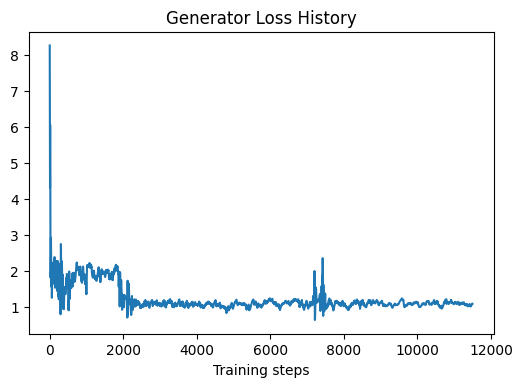

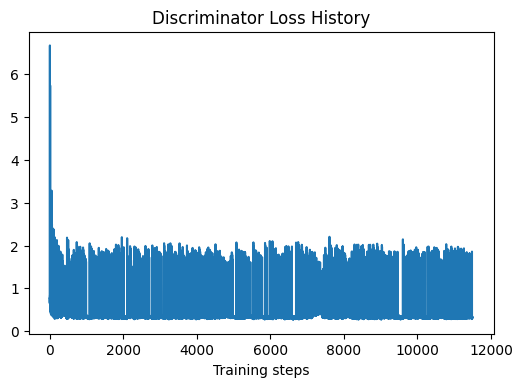

In [271]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

## Compare generated sequences between Random G and trained G

In [272]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random_et, seqs_random_ts = generate_sequences_gumbel(1000, G0,BATCH_SIZE, T)

In [265]:
tf.argmax(seqs_random_et, axis=2)

<tf.Tensor: shape=(1000, 21), dtype=int64, numpy=
array([[1, 4, 2, ..., 5, 2, 3],
       [1, 3, 5, ..., 0, 2, 3],
       [1, 1, 0, ..., 0, 3, 0],
       ...,
       [1, 2, 3, ..., 5, 0, 0],
       [1, 0, 4, ..., 3, 4, 0],
       [1, 5, 0, ..., 3, 2, 3]])>

In [266]:
seqs_random_ts[9:19]

<tf.Tensor: shape=(10, 21, 1), dtype=float64, numpy=
array([[[ 0.        ],
        [ 0.09313473],
        [ 0.0534939 ],
        [ 0.05275375],
        [ 0.06753045],
        [ 0.05044395],
        [ 0.02542377],
        [ 0.06684478],
        [ 0.07924367],
        [ 0.04161887],
        [-0.00460153],
        [ 0.05977219],
        [ 0.02879748],
        [ 0.04058595],
        [ 0.0957636 ],
        [ 0.0341675 ],
        [ 0.13624201],
        [ 0.10519887],
        [ 0.11664324],
        [ 0.11191025],
        [ 0.00502006]],

       [[ 0.        ],
        [ 0.1071408 ],
        [ 0.06943839],
        [ 0.09702168],
        [ 0.11780129],
        [ 0.03747076],
        [ 0.01344083],
        [ 0.06860668],
        [ 0.02483961],
        [ 0.08099445],
        [ 0.08185572],
        [ 0.07565831],
        [ 0.06677266],
        [ 0.01382103],
        [ 0.08750273],
        [ 0.13602425],
        [ 0.04717743],
        [ 0.04723786],
        [ 0.08072992],
        [ 0.08695402],
  

In [273]:
G1 = pretrained_generator
G2 = G
seqs_trained_et, seqs_trained_ts = generate_sequences_gumbel(1000, G2, BATCH_SIZE, T)

In [274]:
tf.argmax(seqs_trained_et, axis=2)[9:19]

<tf.Tensor: shape=(10, 21), dtype=int64, numpy=
array([[1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2]])>

In [275]:
seqs_trained_ts[9:19]

<tf.Tensor: shape=(10, 21, 1), dtype=float64, numpy=
array([[[ 0.        ],
        [ 8.59519994],
        [12.85924533],
        [12.78365682],
        [12.78168433],
        [12.78023897],
        [12.78380508],
        [12.78121752],
        [12.78279527],
        [12.78074817],
        [12.77933409],
        [12.77801549],
        [12.78304943],
        [12.78319243],
        [12.78268924],
        [12.78069399],
        [12.77822692],
        [12.78029361],
        [12.78180582],
        [12.78041021],
        [12.78250007]],

       [[ 0.        ],
        [ 8.59147071],
        [12.89554045],
        [12.77843873],
        [12.78285463],
        [12.78084015],
        [12.78268918],
        [12.78100318],
        [12.78007695],
        [12.780435  ],
        [12.78293373],
        [12.78303312],
        [12.78080814],
        [12.78015572],
        [12.78048268],
        [12.78345358],
        [12.78423427],
        [12.78240027],
        [12.78132504],
        [12.7785655 ],
  

## Save trained G and D weights

In [276]:
if not os.path.exists(model_save_dir + '/G_run_2021-03-27'):
    os.makedirs(model_save_dir + '/G_run_2021-03-27')

G_save_path = model_save_dir + '/G_run_2021-03-27/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_2021-03-27'):
    os.makedirs(model_save_dir + '/D_run_2021-03-27')

D_save_path = model_save_dir + '/D_run_2021-03-27/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)